In [1]:
import argparse
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

from utils import data
import models, utils

In [2]:
class Args(object):
    def __init__(self):
        self.data_path= 'data'
        self.datasetG= 'masked_pwc'
        self.datasetD= 'pwc'
        self.batch_size= 128
        self.model= 'unet1d'
        self.modelG= 'unet1d'
        self.modelD= 'gan_discriminator'
        self.lr= 0.0002
        self.num_epochs= 300
        self.n_data = 100000
        self.min_sep = 5
        self.valid_interval= 1
        self.save_interval= 1
        self.seed = 0
        self.output_dir= 'experiments'
        self.experiment= None
        self.resume_training= False
        self.restore_file= None
        self.no_save= False
        self.step_checkpoints= False
        self.no_log= False
        self.log_interval= 100
        self.no_visual= False
        self.visual_interval= 100
        self.no_progress= False
        self.draft= False
        self.dry_run= False
        self.in_channels= 1
        self.hidden_size = 64
        self.bias= False
        self.test_num = 0
        # UNET
        self.residual = False
args=Args()

In [3]:
# gpu or cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
utils.setup_experiment(args)
utils.init_logging(args)

[2020-08-19 18:40:18] COMMAND: /home/michael/python-virtual-environments/bfcnn/lib/python3.6/site-packages/ipykernel_launcher.py -f /home/michael/.local/share/jupyter/runtime/kernel-17bed208-8c19-4020-a7dc-d9b9ee43cd1f.json
[2020-08-19 18:40:18] Arguments: {'data_path': 'data', 'datasetG': 'masked_pwc', 'datasetD': 'pwc', 'batch_size': 128, 'model': 'unet1d', 'modelG': 'unet1d', 'modelD': 'gan_discriminator', 'lr': 0.0002, 'num_epochs': 300, 'n_data': 100000, 'min_sep': 5, 'valid_interval': 1, 'save_interval': 1, 'seed': 0, 'output_dir': 'experiments', 'experiment': 'unet1d-Aug-19-18:40:18', 'resume_training': False, 'restore_file': None, 'no_save': False, 'step_checkpoints': False, 'no_log': False, 'log_interval': 100, 'no_visual': False, 'visual_interval': 100, 'no_progress': False, 'draft': False, 'dry_run': False, 'in_channels': 1, 'hidden_size': 64, 'bias': False, 'test_num': 0, 'residual': False, 'experiment_dir': 'experiments/unet1d/unet1d-Aug-19-18:40:18', 'checkpoint_dir': 'ex

### Define models and optimizers

In [4]:
# Build data loaders, a model and an optimizer

G,D = models.build_model_gan(args)
netG = G.to(device)
netD = D.to(device)

# Initialize G as the MSE model from previous?
# MODEL_PATH = "models/trained/unet1d_partialconv_10kdata_30epoch_08_13_20.pth"
# netG.load_state_dict(torch.load(MODEL_PATH))
# netG.to(device)

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

# 2 optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=args.lr,betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=args.lr,betas=(0.5, 0.999))

# Not altering the learning rate for now, so not using scheduler
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_G, milestones=[50, 60, 70, 80, 90, 100], gamma=0.5)
logging.info(f"Built a generator model consisting of {sum(p.numel() for p in netG.parameters()):,} parameters")
logging.info(f"Built a discriminator model consisting of {sum(p.numel() for p in netD.parameters()):,} parameters")

if args.resume_training:
    state_dict = utils.load_checkpoint(args, netG, optimizerG) # TODO Should this include netD and optimizerD
    global_step = state_dict['last_step']
    start_epoch = int(state_dict['last_step']/(403200/state_dict['args'].batch_size))+1
else:
    global_step = -1
    start_epoch = 0

[2020-08-19 18:40:22] Built a generator model consisting of 72,000 parameters
[2020-08-19 18:40:22] Built a discriminator model consisting of 692,224 parameters


In [5]:
# build_dataset is a function in utils/data/__init__.py
train_loaderG, _, _ = data.build_dataset(args.datasetG,
                                                   args.n_data, 
                                                   batch_size=args.batch_size,
                                                   min_sep = args.min_sep)
train_loaderD, _, _ = data.build_dataset(args.datasetD,
                                                   args.n_data, 
                                                   batch_size=args.batch_size,
                                                   min_sep = args.min_sep)

# Initialize BCELoss function
criterion = torch.nn.BCELoss()

In [6]:
# Not updated yet for GAN

# Track moving average of loss values
train_meters = {name: utils.RunningAverageMeter(0.98) for name in (["train_loss", "train_psnr", "train_ssim"])}
valid_meters = {name: utils.AverageMeter() for name in (["valid_psnr", "valid_ssim"])}
writer = SummaryWriter(log_dir=args.experiment_dir) if not args.no_visual else None

In [8]:
fake_label = 0.
real_label = 1.
# fake_label = [0.,0.1]
# real_label = [0.9,1.]

G_losses = []
D_losses = []

use_mse = True

if use_mse:
    wtl2 = 0.95

# TRAINING
for epoch in range(start_epoch, args.num_epochs):
#     if args.resume_training:
#         if epoch %10 == 0:
#             optimizer.param_groups[0]["lr"] /= 2
#             print('learning rate reduced by factor of 2')

    train_bar = utils.ProgressBar(train_loaderG, epoch)
    for meter in train_meters.values():
        meter.reset()

    for batch_id, ((clean, mask),real) in enumerate(zip(train_bar,train_loaderD)):
        # dataloader returns [clean, mask] list
        
        ###############################
        # First train the discriminator
        ###############################
        netD.zero_grad()
        real_cpu = real.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,),real_label,device=device)
        # Introducing label noise
#         label = torch.rand((b_size,),device=device)*(real_label[1]-real_label[0])+real_label[0]

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate fake signal batch with G
        inputs = clean.to(device)
        mask_inputs = mask.to(device)
        # only use the mask part of the outputs
        raw_outputs = netG(inputs,mask_inputs)
        fake = (1-mask_inputs)*raw_outputs + mask_inputs*inputs
        
        label.fill_(fake_label)
        # Introducing label noise
#         label = torch.rand((b_size,),device=device)*(fake_label[1]-fake_label[0])+fake_label[0]

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ###############################
        # Next, train the generator
        ###############################
        netG.zero_grad() # train() or zero_grad()?
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        
        if use_mse:
            # Calculate G's loss based on this output
            errG_D = criterion(output, label)
            # MSE Loss
            errG_l2 = F.mse_loss(fake, inputs, reduction="sum") / (inputs.size(0) * 2)
            errG =  (1-wtl2) * errG_D + wtl2 * errG_l2
        else:
            errG = criterion(output, label)
        
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        

        
        # Output training stats
        if batch_id % 50 == 0:
            if use_mse:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f + %.4f = %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, args.num_epochs, batch_id, len(train_loaderG), \
                     errD.item(), errG_D.item(), errG_l2, errG.item(), D_x, D_G_z1, D_G_z2))
            else: 
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, args.num_epochs, batch_id, len(train_loaderG),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        # TO DO: add a "fixed input" to check in on G over time
#         if (global_step % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloaderG)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        global_step += 1
        
        # TO DO, only run loss on masked part of output
        # TO DO, incorporate MSE loss into GAN?
#         loss = F.mse_loss(outputs, inputs, reduction="sum") / (inputs.size(0) * 2)

#         train_psnr = utils.psnr(fake, inputs)
#         train_ssim = utils.ssim(fake, inputs)
#         train_meters["train_loss"].update(errG.item())
#         train_meters["train_psnr"].update(train_psnr.item())
#         train_meters["train_ssim"].update(train_ssim.item())
#         train_bar.log(dict(**train_meters, lr=optimizer_G.param_groups[0]["lr"]), verbose=True)

#         if writer is not None and global_step % args.log_interval == 0:
#             writer.add_scalar("lr", optimizer.param_groups[0]["lr"], global_step)
#             writer.add_scalar("loss/train", loss.item(), global_step)
#             writer.add_scalar("psnr/train", train_psnr.item(), global_step)
#             writer.add_scalar("ssim/train", train_ssim.item(), global_step)
#             gradients = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None], dim=0)
#             writer.add_histogram("gradients", gradients, global_step)
#             sys.stdout.flush()

#     if epoch % args.valid_interval == 0:
#         model.eval()
#         for meter in valid_meters.values():
#             meter.reset()

#         valid_bar = utils.ProgressBar(valid_loader)
        
#         for sample_id, (clean, mask) in enumerate(valid_bar):
#             with torch.no_grad():
#                 inputs = clean.to(device)
#                 mask_inputs = mask.to(device)
#                 # only use the mask part of the outputs
#                 raw_output = model(inputs,mask_inputs)
#                 output = (1-mask_inputs)*raw_output + mask_inputs*inputs
# #                 output = model(inputs)
# #                 sample = noisy_clean_sample[1].to(device)
# #                 noisy_inputs = noisy_clean_sample[0].to(device);
# #                 output = model(noisy_inputs)

#                 valid_psnr = utils.psnr(inputs, output)
#                 valid_meters["valid_psnr"].update(valid_psnr.item())
#                 valid_ssim = utils.ssim(inputs, output)
#                 valid_meters["valid_ssim"].update(valid_ssim.item())

#                 ### Uncomment these when finished
#                 if writer is not None and sample_id < 10:
#                     image = torch.cat([inputs, torch.mul(inputs, mask_inputs), output], dim=0)
#                     image = torchvision.utils.make_grid(image.clamp(0, 1), nrow=3, normalize=False)
#                     writer.add_image(f"valid_samples/{sample_id}", image, global_step)

#         if writer is not None:
#             writer.add_scalar("psnr/valid", valid_meters['valid_psnr'].avg, global_step)
#             writer.add_scalar("ssim/valid", valid_meters['valid_ssim'].avg, global_step)
#             sys.stdout.flush()

#         logging.info(train_bar.print(dict(**train_meters, **valid_meters, lr=optimizer.param_groups[0]["lr"])))
#         utils.save_checkpoint(args, global_step, model, optimizer, score=valid_meters["valid_psnr"].avg, mode="max")
# #     scheduler.step()

# logging.info(f"Done training! Best PSNR {utils.save_checkpoint.best_score:.3f} obtained after step {utils.save_checkpoint.best_step}.")


epoch 00:   0%|          | 3/782 [00:00<02:30,  5.18it/s]

[0/300][0/782]	Loss_D: 1.4632	Loss_G: 1.0431 + 1.2803 = 1.2685	D(x): 0.5475	D(G(z)): 0.5451 / 0.4019


epoch 00:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[0/300][50/782]	Loss_D: 1.5133	Loss_G: 0.6963 + 0.1761 = 0.2021	D(x): 0.4507	D(G(z)): 0.4836 / 0.5069


epoch 00:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[0/300][100/782]	Loss_D: 1.3244	Loss_G: 0.8062 + 0.2436 = 0.2717	D(x): 0.5370	D(G(z)): 0.4911 / 0.4548


epoch 00:  19%|█▉        | 152/782 [00:15<01:02, 10.09it/s]

[0/300][150/782]	Loss_D: 1.2653	Loss_G: 0.7928 + 0.2188 = 0.2475	D(x): 0.5294	D(G(z)): 0.4542 / 0.4584


epoch 00:  26%|██▌       | 202/782 [00:20<00:57, 10.09it/s]

[0/300][200/782]	Loss_D: 1.3219	Loss_G: 0.7804 + 0.1888 = 0.2184	D(x): 0.5751	D(G(z)): 0.5115 / 0.4650


epoch 00:  32%|███▏      | 252/782 [00:25<00:52, 10.05it/s]

[0/300][250/782]	Loss_D: 1.2091	Loss_G: 0.7906 + 0.1671 = 0.1982	D(x): 0.4794	D(G(z)): 0.3650 / 0.4591


epoch 00:  39%|███▊      | 302/782 [00:30<00:47, 10.05it/s]

[0/300][300/782]	Loss_D: 1.0385	Loss_G: 0.7852 + 0.1611 = 0.1923	D(x): 0.5379	D(G(z)): 0.3213 / 0.4709


epoch 00:  45%|████▌     | 352/782 [00:35<00:42, 10.05it/s]

[0/300][350/782]	Loss_D: 1.1803	Loss_G: 1.2166 + 0.1758 = 0.2278	D(x): 0.7004	D(G(z)): 0.5418 / 0.3154


epoch 00:  51%|█████▏    | 402/782 [00:40<00:37, 10.07it/s]

[0/300][400/782]	Loss_D: 0.6771	Loss_G: 1.2043 + 0.1885 = 0.2393	D(x): 0.7093	D(G(z)): 0.2738 / 0.3138


epoch 00:  58%|█████▊    | 452/782 [00:45<00:32, 10.13it/s]

[0/300][450/782]	Loss_D: 1.1105	Loss_G: 0.6674 + 0.1582 = 0.1836	D(x): 0.4781	D(G(z)): 0.2885 / 0.5224


epoch 00:  64%|██████▍   | 502/782 [00:50<00:27, 10.06it/s]

[0/300][500/782]	Loss_D: 1.1723	Loss_G: 0.7169 + 0.1742 = 0.2014	D(x): 0.6407	D(G(z)): 0.4873 / 0.4959


epoch 00:  71%|███████   | 553/782 [00:55<00:22, 10.04it/s]

[0/300][550/782]	Loss_D: 1.4000	Loss_G: 0.3959 + 0.1745 = 0.1856	D(x): 0.3090	D(G(z)): 0.1480 / 0.6803


epoch 00:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[0/300][600/782]	Loss_D: 0.8897	Loss_G: 1.2798 + 0.1646 = 0.2203	D(x): 0.4709	D(G(z)): 0.1025 / 0.2947


epoch 00:  83%|████████▎ | 652/782 [01:04<00:13,  9.87it/s]

[0/300][650/782]	Loss_D: 1.4447	Loss_G: 0.8963 + 0.1957 = 0.2308	D(x): 0.6215	D(G(z)): 0.6047 / 0.4233


epoch 00:  90%|████████▉ | 703/782 [01:10<00:07, 10.07it/s]

[0/300][700/782]	Loss_D: 1.2983	Loss_G: 1.3845 + 0.2061 = 0.2650	D(x): 0.5671	D(G(z)): 0.4848 / 0.2614


epoch 00:  96%|█████████▌| 752/782 [01:14<00:02, 10.14it/s]

[0/300][750/782]	Loss_D: 0.9318	Loss_G: 1.5135 + 0.2174 = 0.2822	D(x): 0.6202	D(G(z)): 0.3446 / 0.2305


epoch 01:   0%|          | 3/782 [00:00<02:32,  5.10it/s]  

[1/300][0/782]	Loss_D: 0.9704	Loss_G: 0.8151 + 0.1450 = 0.1785	D(x): 0.6505	D(G(z)): 0.3906 / 0.4616


epoch 01:   7%|▋         | 52/782 [00:05<01:12, 10.07it/s]

[1/300][50/782]	Loss_D: 1.1995	Loss_G: 1.2140 + 0.1833 = 0.2349	D(x): 0.4461	D(G(z)): 0.2766 / 0.3132


epoch 01:  13%|█▎        | 102/782 [00:10<01:07, 10.06it/s]

[1/300][100/782]	Loss_D: 0.8567	Loss_G: 1.8497 + 0.2365 = 0.3172	D(x): 0.4563	D(G(z)): 0.0235 / 0.1810


epoch 01:  19%|█▉        | 152/782 [00:15<01:02, 10.03it/s]

[1/300][150/782]	Loss_D: 0.7349	Loss_G: 2.0826 + 0.1655 = 0.2614	D(x): 0.8028	D(G(z)): 0.3879 / 0.1356


epoch 01:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[1/300][200/782]	Loss_D: 1.3940	Loss_G: 0.8250 + 0.1958 = 0.2273	D(x): 0.7233	D(G(z)): 0.6409 / 0.4522


epoch 01:  32%|███▏      | 253/782 [00:25<00:52, 10.00it/s]

[1/300][250/782]	Loss_D: 0.5190	Loss_G: 2.2823 + 0.1591 = 0.2652	D(x): 0.8794	D(G(z)): 0.3144 / 0.1109


epoch 01:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[1/300][300/782]	Loss_D: 0.9363	Loss_G: 1.3889 + 0.1975 = 0.2570	D(x): 0.4470	D(G(z)): 0.0885 / 0.2652


epoch 01:  45%|████▌     | 353/782 [00:35<00:42, 10.06it/s]

[1/300][350/782]	Loss_D: 1.5938	Loss_G: 0.7769 + 0.2349 = 0.2620	D(x): 0.2811	D(G(z)): 0.2051 / 0.4920


epoch 01:  52%|█████▏    | 403/782 [00:40<00:37, 10.07it/s]

[1/300][400/782]	Loss_D: 0.4603	Loss_G: 1.9078 + 0.1823 = 0.2686	D(x): 0.8010	D(G(z)): 0.2062 / 0.1610


epoch 01:  58%|█████▊    | 451/782 [00:45<00:32, 10.03it/s]

[1/300][450/782]	Loss_D: 0.7555	Loss_G: 1.5833 + 0.2047 = 0.2736	D(x): 0.6049	D(G(z)): 0.2102 / 0.2244


epoch 01:  64%|██████▍   | 502/782 [00:50<00:27, 10.03it/s]

[1/300][500/782]	Loss_D: 1.9411	Loss_G: 0.6381 + 0.1944 = 0.2166	D(x): 0.2354	D(G(z)): 0.3318 / 0.5518


epoch 01:  71%|███████   | 552/782 [00:55<00:22, 10.05it/s]

[1/300][550/782]	Loss_D: 0.6509	Loss_G: 1.7968 + 0.1762 = 0.2572	D(x): 0.6374	D(G(z)): 0.1668 / 0.1791


epoch 01:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[1/300][600/782]	Loss_D: 1.2707	Loss_G: 1.5272 + 0.1802 = 0.2476	D(x): 0.3203	D(G(z)): 0.0711 / 0.2511


epoch 01:  83%|████████▎ | 652/782 [01:05<00:12, 10.03it/s]

[1/300][650/782]	Loss_D: 0.2349	Loss_G: 1.5315 + 0.1735 = 0.2414	D(x): 0.9637	D(G(z)): 0.1752 / 0.2457


epoch 01:  90%|████████▉ | 702/782 [01:10<00:08,  9.95it/s]

[1/300][700/782]	Loss_D: 1.6748	Loss_G: 0.6600 + 0.2092 = 0.2317	D(x): 0.2986	D(G(z)): 0.3299 / 0.5262


epoch 01:  96%|█████████▋| 753/782 [01:15<00:02,  9.97it/s]

[1/300][750/782]	Loss_D: 1.4393	Loss_G: 1.1246 + 0.1854 = 0.2324	D(x): 0.8821	D(G(z)): 0.7117 / 0.3376


epoch 02:   0%|          | 3/782 [00:00<02:26,  5.33it/s]  

[2/300][0/782]	Loss_D: 2.0229	Loss_G: 1.0016 + 0.1743 = 0.2156	D(x): 0.8632	D(G(z)): 0.8219 / 0.3948


epoch 02:   7%|▋         | 53/782 [00:05<01:12, 10.01it/s]

[2/300][50/782]	Loss_D: 0.8232	Loss_G: 1.4796 + 0.1978 = 0.2619	D(x): 0.6680	D(G(z)): 0.3316 / 0.2355


epoch 02:  13%|█▎        | 103/782 [00:10<01:08,  9.95it/s]

[2/300][100/782]	Loss_D: 1.9314	Loss_G: 0.7025 + 0.2251 = 0.2490	D(x): 0.9151	D(G(z)): 0.8256 / 0.5136


epoch 02:  19%|█▉        | 152/782 [00:15<01:02, 10.03it/s]

[2/300][150/782]	Loss_D: 0.9638	Loss_G: 1.0532 + 0.1972 = 0.2400	D(x): 0.7873	D(G(z)): 0.4998 / 0.3627


epoch 02:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[2/300][200/782]	Loss_D: 1.2753	Loss_G: 1.5372 + 0.1766 = 0.2446	D(x): 0.3369	D(G(z)): 0.0902 / 0.2445


epoch 02:  32%|███▏      | 252/782 [00:25<00:53,  9.99it/s]

[2/300][250/782]	Loss_D: 1.7288	Loss_G: 0.7784 + 0.1639 = 0.1946	D(x): 0.2056	D(G(z)): 0.1018 / 0.4813


epoch 02:  39%|███▊      | 302/782 [00:30<00:48,  9.91it/s]

[2/300][300/782]	Loss_D: 0.8830	Loss_G: 0.9189 + 0.1895 = 0.2260	D(x): 0.6718	D(G(z)): 0.3514 / 0.4170


epoch 02:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[2/300][350/782]	Loss_D: 2.2062	Loss_G: 0.7125 + 0.1930 = 0.2190	D(x): 0.1526	D(G(z)): 0.1819 / 0.5090


epoch 02:  51%|█████▏    | 402/782 [00:40<00:38,  9.87it/s]

[2/300][400/782]	Loss_D: 0.8721	Loss_G: 1.1776 + 0.1872 = 0.2367	D(x): 0.5995	D(G(z)): 0.2808 / 0.3228


epoch 02:  58%|█████▊    | 452/782 [00:45<00:33,  9.94it/s]

[2/300][450/782]	Loss_D: 1.6278	Loss_G: 1.1777 + 0.2348 = 0.2819	D(x): 0.2189	D(G(z)): 0.0652 / 0.3302


epoch 02:  64%|██████▍   | 502/782 [00:50<00:28,  9.69it/s]

[2/300][500/782]	Loss_D: 1.1647	Loss_G: 0.7658 + 0.1783 = 0.2077	D(x): 0.6710	D(G(z)): 0.5172 / 0.4718


epoch 02:  71%|███████   | 553/782 [00:55<00:22,  9.98it/s]

[2/300][550/782]	Loss_D: 0.9492	Loss_G: 2.3086 + 0.1857 = 0.2918	D(x): 0.4209	D(G(z)): 0.0456 / 0.1097


epoch 02:  77%|███████▋  | 602/782 [01:00<00:18,  9.92it/s]

[2/300][600/782]	Loss_D: 1.0329	Loss_G: 0.9672 + 0.1710 = 0.2108	D(x): 0.5348	D(G(z)): 0.3197 / 0.3895


epoch 02:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[2/300][650/782]	Loss_D: 0.8317	Loss_G: 1.0999 + 0.2261 = 0.2698	D(x): 0.7720	D(G(z)): 0.4252 / 0.3418


epoch 02:  90%|████████▉ | 702/782 [01:10<00:08,  9.93it/s]

[2/300][700/782]	Loss_D: 1.2909	Loss_G: 0.7801 + 0.1497 = 0.1812	D(x): 0.8947	D(G(z)): 0.6693 / 0.4757


epoch 02:  96%|█████████▋| 753/782 [01:15<00:02, 10.06it/s]

[2/300][750/782]	Loss_D: 1.2255	Loss_G: 0.9676 + 0.1678 = 0.2078	D(x): 0.5655	D(G(z)): 0.4627 / 0.3926


epoch 03:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[3/300][0/782]	Loss_D: 1.2433	Loss_G: 0.9719 + 0.2390 = 0.2756	D(x): 0.4911	D(G(z)): 0.3820 / 0.3927


epoch 03:   7%|▋         | 53/782 [00:05<01:12, 10.12it/s]

[3/300][50/782]	Loss_D: 1.1051	Loss_G: 1.0891 + 0.1457 = 0.1929	D(x): 0.7873	D(G(z)): 0.5674 / 0.3466


epoch 03:  13%|█▎        | 102/782 [00:10<01:08,  9.94it/s]

[3/300][100/782]	Loss_D: 0.6227	Loss_G: 1.1017 + 0.2310 = 0.2745	D(x): 0.7879	D(G(z)): 0.3062 / 0.3445


epoch 03:  19%|█▉        | 152/782 [00:15<01:03,  9.97it/s]

[3/300][150/782]	Loss_D: 1.0467	Loss_G: 1.5234 + 0.1958 = 0.2622	D(x): 0.8819	D(G(z)): 0.5916 / 0.2276


epoch 03:  26%|██▌       | 201/782 [00:20<00:58, 10.01it/s]

[3/300][200/782]	Loss_D: 0.5846	Loss_G: 1.5568 + 0.1927 = 0.2609	D(x): 0.6930	D(G(z)): 0.1847 / 0.2228


epoch 03:  32%|███▏      | 252/782 [00:25<00:53,  9.92it/s]

[3/300][250/782]	Loss_D: 1.6444	Loss_G: 1.9649 + 0.1945 = 0.2831	D(x): 0.2097	D(G(z)): 0.0358 / 0.1512


epoch 03:  38%|███▊      | 301/782 [00:30<00:48, 10.01it/s]

[3/300][300/782]	Loss_D: 0.9949	Loss_G: 0.7935 + 0.1473 = 0.1796	D(x): 0.4800	D(G(z)): 0.2153 / 0.4612


epoch 03:  45%|████▌     | 352/782 [00:35<00:43,  9.96it/s]

[3/300][350/782]	Loss_D: 0.6642	Loss_G: 1.6369 + 0.2207 = 0.2915	D(x): 0.8862	D(G(z)): 0.4081 / 0.2082


epoch 03:  51%|█████▏    | 402/782 [00:40<00:38,  9.92it/s]

[3/300][400/782]	Loss_D: 2.3069	Loss_G: 0.8394 + 0.1867 = 0.2194	D(x): 0.1170	D(G(z)): 0.0543 / 0.4481


epoch 03:  58%|█████▊    | 453/782 [00:45<00:32, 10.03it/s]

[3/300][450/782]	Loss_D: 0.7408	Loss_G: 1.4150 + 0.1282 = 0.1925	D(x): 0.5493	D(G(z)): 0.1205 / 0.2551


epoch 03:  64%|██████▍   | 501/782 [00:50<00:28,  9.95it/s]

[3/300][500/782]	Loss_D: 1.0863	Loss_G: 1.9477 + 0.1616 = 0.2509	D(x): 0.8630	D(G(z)): 0.5939 / 0.1515


epoch 03:  71%|███████   | 553/782 [00:55<00:23,  9.95it/s]

[3/300][550/782]	Loss_D: 0.8259	Loss_G: 1.3805 + 0.1619 = 0.2228	D(x): 0.6766	D(G(z)): 0.3419 / 0.2631


epoch 03:  77%|███████▋  | 602/782 [01:00<00:17, 10.03it/s]

[3/300][600/782]	Loss_D: 1.2227	Loss_G: 1.7621 + 0.2348 = 0.3112	D(x): 0.9031	D(G(z)): 0.6548 / 0.1848


epoch 03:  84%|████████▎ | 653/782 [01:05<00:12, 10.01it/s]

[3/300][650/782]	Loss_D: 1.2870	Loss_G: 0.8096 + 0.1772 = 0.2088	D(x): 0.7556	D(G(z)): 0.6205 / 0.4576


epoch 03:  90%|████████▉ | 702/782 [01:10<00:08,  9.84it/s]

[3/300][700/782]	Loss_D: 2.0371	Loss_G: 0.5606 + 0.1533 = 0.1737	D(x): 0.2906	D(G(z)): 0.5286 / 0.5811


epoch 03:  96%|█████████▋| 753/782 [01:15<00:02, 10.04it/s]

[3/300][750/782]	Loss_D: 1.1985	Loss_G: 1.2148 + 0.2106 = 0.2608	D(x): 0.7349	D(G(z)): 0.5792 / 0.3061


epoch 04:   0%|          | 3/782 [00:00<02:17,  5.67it/s]  

[4/300][0/782]	Loss_D: 1.0464	Loss_G: 1.0124 + 0.2381 = 0.2768	D(x): 0.6124	D(G(z)): 0.4110 / 0.3773


epoch 04:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[4/300][50/782]	Loss_D: 0.9509	Loss_G: 0.9846 + 0.1565 = 0.1980	D(x): 0.5099	D(G(z)): 0.2255 / 0.3833


epoch 04:  13%|█▎        | 102/782 [00:10<01:08,  9.94it/s]

[4/300][100/782]	Loss_D: 1.5000	Loss_G: 0.7126 + 0.1884 = 0.2146	D(x): 0.5656	D(G(z)): 0.5943 / 0.4949


epoch 04:  19%|█▉        | 151/782 [00:15<01:03,  9.86it/s]

[4/300][150/782]	Loss_D: 0.6433	Loss_G: 1.3163 + 0.1809 = 0.2377	D(x): 0.8407	D(G(z)): 0.3699 / 0.2746


epoch 04:  26%|██▌       | 202/782 [00:20<00:58,  9.93it/s]

[4/300][200/782]	Loss_D: 0.5985	Loss_G: 1.2410 + 0.2311 = 0.2816	D(x): 0.8210	D(G(z)): 0.3238 / 0.2971


epoch 04:  32%|███▏      | 253/782 [00:25<00:52, 10.00it/s]

[4/300][250/782]	Loss_D: 1.0842	Loss_G: 0.9769 + 0.2228 = 0.2605	D(x): 0.8767	D(G(z)): 0.6020 / 0.3894


epoch 04:  39%|███▊      | 302/782 [00:30<00:48,  9.87it/s]

[4/300][300/782]	Loss_D: 0.5750	Loss_G: 1.4864 + 0.1733 = 0.2389	D(x): 0.6934	D(G(z)): 0.1805 / 0.2342


epoch 04:  45%|████▌     | 352/782 [00:35<00:43,  9.94it/s]

[4/300][350/782]	Loss_D: 2.7149	Loss_G: 0.3582 + 0.1693 = 0.1788	D(x): 0.3155	D(G(z)): 0.7747 / 0.7056


epoch 04:  51%|█████▏    | 402/782 [00:40<00:38,  9.89it/s]

[4/300][400/782]	Loss_D: 1.3046	Loss_G: 1.2482 + 0.1968 = 0.2494	D(x): 0.9053	D(G(z)): 0.6871 / 0.3001


epoch 04:  58%|█████▊    | 453/782 [00:45<00:33,  9.97it/s]

[4/300][450/782]	Loss_D: 1.4689	Loss_G: 0.8854 + 0.1748 = 0.2103	D(x): 0.7756	D(G(z)): 0.6880 / 0.4234


epoch 04:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[4/300][500/782]	Loss_D: 0.8514	Loss_G: 1.4270 + 0.2251 = 0.2852	D(x): 0.4906	D(G(z)): 0.1089 / 0.2524


epoch 04:  71%|███████   | 553/782 [00:55<00:22, 10.02it/s]

[4/300][550/782]	Loss_D: 1.3131	Loss_G: 0.6753 + 0.1786 = 0.2035	D(x): 0.4859	D(G(z)): 0.4329 / 0.5225


epoch 04:  77%|███████▋  | 602/782 [01:00<00:18,  9.89it/s]

[4/300][600/782]	Loss_D: 0.9259	Loss_G: 1.1989 + 0.2424 = 0.2903	D(x): 0.7142	D(G(z)): 0.4306 / 0.3102


epoch 04:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[4/300][650/782]	Loss_D: 1.8364	Loss_G: 0.9853 + 0.1842 = 0.2243	D(x): 0.1974	D(G(z)): 0.1231 / 0.3896


epoch 04:  90%|████████▉ | 702/782 [01:10<00:07, 10.01it/s]

[4/300][700/782]	Loss_D: 0.5331	Loss_G: 1.5021 + 0.2033 = 0.2683	D(x): 0.8461	D(G(z)): 0.3016 / 0.2313


epoch 04:  96%|█████████▌| 752/782 [01:15<00:02, 10.04it/s]

[4/300][750/782]	Loss_D: 1.3608	Loss_G: 0.7758 + 0.1816 = 0.2113	D(x): 0.3415	D(G(z)): 0.2312 / 0.4697


epoch 05:   0%|          | 1/782 [00:00<02:51,  4.56it/s]  

[5/300][0/782]	Loss_D: 1.5190	Loss_G: 1.1210 + 0.1548 = 0.2031	D(x): 0.9028	D(G(z)): 0.7405 / 0.3487


epoch 05:   7%|▋         | 53/782 [00:05<01:12, 10.00it/s]

[5/300][50/782]	Loss_D: 0.2517	Loss_G: 2.0786 + 0.2048 = 0.2985	D(x): 0.9271	D(G(z)): 0.1590 / 0.1328


epoch 05:  13%|█▎        | 103/782 [00:10<01:07, 10.04it/s]

[5/300][100/782]	Loss_D: 1.0319	Loss_G: 1.4812 + 0.1899 = 0.2545	D(x): 0.8056	D(G(z)): 0.5420 / 0.2437


epoch 05:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[5/300][150/782]	Loss_D: 1.2578	Loss_G: 2.2421 + 0.1975 = 0.2997	D(x): 0.7218	D(G(z)): 0.5947 / 0.1131


epoch 05:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[5/300][200/782]	Loss_D: 1.1308	Loss_G: 3.0670 + 0.2489 = 0.3898	D(x): 0.9292	D(G(z)): 0.6389 / 0.0516


epoch 05:  32%|███▏      | 252/782 [00:25<00:53,  9.94it/s]

[5/300][250/782]	Loss_D: 0.6320	Loss_G: 1.2276 + 0.1869 = 0.2389	D(x): 0.7795	D(G(z)): 0.3109 / 0.3070


epoch 05:  39%|███▊      | 302/782 [00:30<00:48,  9.93it/s]

[5/300][300/782]	Loss_D: 1.0013	Loss_G: 0.9794 + 0.2004 = 0.2393	D(x): 0.5991	D(G(z)): 0.3627 / 0.3883


epoch 05:  45%|████▌     | 352/782 [00:35<00:43,  9.89it/s]

[5/300][350/782]	Loss_D: 1.2149	Loss_G: 1.3602 + 0.1942 = 0.2525	D(x): 0.3704	D(G(z)): 0.1508 / 0.2698


epoch 05:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[5/300][400/782]	Loss_D: 0.4644	Loss_G: 2.5541 + 0.2303 = 0.3465	D(x): 0.6579	D(G(z)): 0.0368 / 0.0828


epoch 05:  58%|█████▊    | 452/782 [00:45<00:33,  9.91it/s]

[5/300][450/782]	Loss_D: 1.2642	Loss_G: 1.0428 + 0.1989 = 0.2411	D(x): 0.6165	D(G(z)): 0.5182 / 0.3623


epoch 05:  64%|██████▍   | 502/782 [00:50<00:28,  9.91it/s]

[5/300][500/782]	Loss_D: 0.3392	Loss_G: 2.4758 + 0.2339 = 0.3460	D(x): 0.7467	D(G(z)): 0.0392 / 0.0910


epoch 05:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[5/300][550/782]	Loss_D: 0.9786	Loss_G: 1.8932 + 0.2146 = 0.2985	D(x): 0.7919	D(G(z)): 0.5128 / 0.1606


epoch 05:  77%|███████▋  | 602/782 [01:00<00:18,  9.94it/s]

[5/300][600/782]	Loss_D: 0.5156	Loss_G: 1.9315 + 0.1868 = 0.2740	D(x): 0.7551	D(G(z)): 0.2028 / 0.1556


epoch 05:  83%|████████▎ | 652/782 [01:05<00:13,  9.87it/s]

[5/300][650/782]	Loss_D: 0.6344	Loss_G: 1.1940 + 0.1632 = 0.2147	D(x): 0.6930	D(G(z)): 0.2258 / 0.3128


epoch 05:  90%|████████▉ | 703/782 [01:10<00:07,  9.97it/s]

[5/300][700/782]	Loss_D: 0.5867	Loss_G: 1.3475 + 0.1904 = 0.2483	D(x): 0.7546	D(G(z)): 0.2523 / 0.2700


epoch 05:  96%|█████████▌| 752/782 [01:15<00:03,  9.92it/s]

[5/300][750/782]	Loss_D: 0.8674	Loss_G: 1.7016 + 0.1968 = 0.2720	D(x): 0.8377	D(G(z)): 0.4861 / 0.1912


epoch 06:   0%|          | 3/782 [00:00<02:24,  5.40it/s]  

[6/300][0/782]	Loss_D: 0.7218	Loss_G: 1.3661 + 0.2205 = 0.2778	D(x): 0.5446	D(G(z)): 0.0917 / 0.2669


epoch 06:   7%|▋         | 52/782 [00:05<01:13,  9.91it/s]

[6/300][50/782]	Loss_D: 0.5629	Loss_G: 1.5683 + 0.2138 = 0.2815	D(x): 0.7166	D(G(z)): 0.1962 / 0.2160


epoch 06:  13%|█▎        | 103/782 [00:10<01:07, 10.01it/s]

[6/300][100/782]	Loss_D: 0.3521	Loss_G: 2.2924 + 0.1668 = 0.2731	D(x): 0.7559	D(G(z)): 0.0631 / 0.1083


epoch 06:  20%|█▉        | 153/782 [00:15<01:02, 10.06it/s]

[6/300][150/782]	Loss_D: 0.7415	Loss_G: 0.7791 + 0.1678 = 0.1983	D(x): 0.5796	D(G(z)): 0.1623 / 0.4713


epoch 06:  26%|██▌       | 202/782 [00:20<00:58,  9.91it/s]

[6/300][200/782]	Loss_D: 1.1925	Loss_G: 0.5636 + 0.1935 = 0.2120	D(x): 0.3962	D(G(z)): 0.2025 / 0.5774


epoch 06:  32%|███▏      | 252/782 [00:25<00:52, 10.03it/s]

[6/300][250/782]	Loss_D: 0.5909	Loss_G: 1.9545 + 0.2044 = 0.2919	D(x): 0.9468	D(G(z)): 0.4075 / 0.1549


epoch 06:  39%|███▊      | 303/782 [00:30<00:47, 10.06it/s]

[6/300][300/782]	Loss_D: 1.0314	Loss_G: 1.5910 + 0.1919 = 0.2619	D(x): 0.3765	D(G(z)): 0.0274 / 0.2102


epoch 06:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[6/300][350/782]	Loss_D: 0.4575	Loss_G: 1.5202 + 0.1905 = 0.2570	D(x): 0.8915	D(G(z)): 0.2844 / 0.2292


epoch 06:  51%|█████▏    | 402/782 [00:40<00:38,  9.89it/s]

[6/300][400/782]	Loss_D: 0.8347	Loss_G: 2.6304 + 0.2010 = 0.3224	D(x): 0.9510	D(G(z)): 0.5276 / 0.0777


epoch 06:  58%|█████▊    | 453/782 [00:45<00:33,  9.95it/s]

[6/300][450/782]	Loss_D: 0.8152	Loss_G: 1.9696 + 0.2800 = 0.3644	D(x): 0.9045	D(G(z)): 0.5014 / 0.1473


epoch 06:  64%|██████▍   | 502/782 [00:50<00:28,  9.91it/s]

[6/300][500/782]	Loss_D: 0.5324	Loss_G: 1.6183 + 0.2023 = 0.2731	D(x): 0.9270	D(G(z)): 0.3607 / 0.2057


epoch 06:  71%|███████   | 552/782 [00:55<00:23,  9.90it/s]

[6/300][550/782]	Loss_D: 1.1869	Loss_G: 2.5895 + 0.1762 = 0.2968	D(x): 0.9431	D(G(z)): 0.6648 / 0.0819


epoch 06:  77%|███████▋  | 602/782 [01:00<00:18,  9.83it/s]

[6/300][600/782]	Loss_D: 0.3973	Loss_G: 2.7685 + 0.1648 = 0.2950	D(x): 0.8883	D(G(z)): 0.2362 / 0.0700


epoch 06:  83%|████████▎ | 652/782 [01:05<00:13,  9.85it/s]

[6/300][650/782]	Loss_D: 0.1437	Loss_G: 2.7870 + 0.2507 = 0.3775	D(x): 0.9492	D(G(z)): 0.0869 / 0.0661


epoch 06:  90%|████████▉ | 701/782 [01:10<00:08, 10.00it/s]

[6/300][700/782]	Loss_D: 1.4831	Loss_G: 1.5201 + 0.1762 = 0.2434	D(x): 0.9753	D(G(z)): 0.7579 / 0.2308


epoch 06:  96%|█████████▌| 752/782 [01:15<00:03,  9.68it/s]

[6/300][750/782]	Loss_D: 0.1033	Loss_G: 3.3591 + 0.2127 = 0.3700	D(x): 0.9398	D(G(z)): 0.0400 / 0.0378


epoch 07:   0%|          | 1/782 [00:00<02:56,  4.42it/s]  

[7/300][0/782]	Loss_D: 1.2765	Loss_G: 1.7962 + 0.2151 = 0.2941	D(x): 0.3079	D(G(z)): 0.0225 / 0.1866


epoch 07:   7%|▋         | 52/782 [00:05<01:13,  9.91it/s]

[7/300][50/782]	Loss_D: 0.2442	Loss_G: 2.8204 + 0.1975 = 0.3286	D(x): 0.8496	D(G(z)): 0.0748 / 0.0645


epoch 07:  13%|█▎        | 102/782 [00:10<01:08,  9.87it/s]

[7/300][100/782]	Loss_D: 0.0727	Loss_G: 3.5632 + 0.1994 = 0.3676	D(x): 0.9563	D(G(z)): 0.0274 / 0.0314


epoch 07:  19%|█▉        | 152/782 [00:15<01:03,  9.91it/s]

[7/300][150/782]	Loss_D: 0.0555	Loss_G: 4.2438 + 0.2187 = 0.4199	D(x): 0.9595	D(G(z)): 0.0139 / 0.0157


epoch 07:  26%|██▌       | 203/782 [00:20<00:58,  9.94it/s]

[7/300][200/782]	Loss_D: 1.4658	Loss_G: 3.5308 + 0.1568 = 0.3255	D(x): 0.2496	D(G(z)): 0.0128 / 0.0318


epoch 07:  32%|███▏      | 252/782 [00:25<00:53,  9.88it/s]

[7/300][250/782]	Loss_D: 0.2242	Loss_G: 2.2536 + 0.1705 = 0.2747	D(x): 0.9375	D(G(z)): 0.1454 / 0.1101


epoch 07:  39%|███▊      | 302/782 [00:30<00:48,  9.85it/s]

[7/300][300/782]	Loss_D: 0.3475	Loss_G: 4.0858 + 0.2306 = 0.4234	D(x): 0.7196	D(G(z)): 0.0110 / 0.0211


epoch 07:  45%|████▌     | 352/782 [00:35<00:43,  9.86it/s]

[7/300][350/782]	Loss_D: 0.0808	Loss_G: 3.2403 + 0.1548 = 0.3090	D(x): 0.9645	D(G(z)): 0.0436 / 0.0412


epoch 07:  51%|█████▏    | 402/782 [00:40<00:38,  9.82it/s]

[7/300][400/782]	Loss_D: 1.7965	Loss_G: 3.7436 + 0.2442 = 0.4192	D(x): 0.1874	D(G(z)): 0.0099 / 0.0278


epoch 07:  58%|█████▊    | 452/782 [00:45<00:33,  9.87it/s]

[7/300][450/782]	Loss_D: 1.3603	Loss_G: 0.7475 + 0.1910 = 0.2188	D(x): 0.3729	D(G(z)): 0.2652 / 0.4854


epoch 07:  64%|██████▍   | 502/782 [00:50<00:28,  9.86it/s]

[7/300][500/782]	Loss_D: 1.0503	Loss_G: 1.6378 + 0.2378 = 0.3078	D(x): 0.3885	D(G(z)): 0.0581 / 0.2098


epoch 07:  71%|███████   | 552/782 [00:55<00:23,  9.95it/s]

[7/300][550/782]	Loss_D: 0.1640	Loss_G: 6.6909 + 0.2406 = 0.5631	D(x): 0.8518	D(G(z)): 0.0012 / 0.0015


epoch 07:  77%|███████▋  | 602/782 [01:01<00:18,  9.91it/s]

[7/300][600/782]	Loss_D: 0.9670	Loss_G: 3.9593 + 0.1991 = 0.3871	D(x): 0.3961	D(G(z)): 0.0073 / 0.0227


epoch 07:  83%|████████▎ | 652/782 [01:06<00:13,  9.89it/s]

[7/300][650/782]	Loss_D: 0.0751	Loss_G: 4.2621 + 0.1903 = 0.3939	D(x): 0.9403	D(G(z)): 0.0131 / 0.0159


epoch 07:  90%|████████▉ | 702/782 [01:11<00:08,  9.91it/s]

[7/300][700/782]	Loss_D: 0.1003	Loss_G: 2.8358 + 0.1527 = 0.2869	D(x): 0.9825	D(G(z)): 0.0788 / 0.0630


epoch 07:  96%|█████████▌| 752/782 [01:16<00:03,  9.90it/s]

[7/300][750/782]	Loss_D: 0.0807	Loss_G: 5.9873 + 0.1558 = 0.4474	D(x): 0.9252	D(G(z)): 0.0023 / 0.0029


epoch 08:   0%|          | 3/782 [00:00<02:19,  5.60it/s]  

[8/300][0/782]	Loss_D: 1.3151	Loss_G: 0.9578 + 0.2005 = 0.2383	D(x): 0.3698	D(G(z)): 0.2166 / 0.4045


epoch 08:   7%|▋         | 53/782 [00:05<01:13,  9.97it/s]

[8/300][50/782]	Loss_D: 0.1529	Loss_G: 3.0264 + 0.1775 = 0.3200	D(x): 0.9590	D(G(z)): 0.1038 / 0.0536


epoch 08:  13%|█▎        | 102/782 [00:10<01:08,  9.91it/s]

[8/300][100/782]	Loss_D: 0.0123	Loss_G: 5.6377 + 0.2026 = 0.4744	D(x): 0.9920	D(G(z)): 0.0042 / 0.0046


epoch 08:  19%|█▉        | 152/782 [00:15<01:03,  9.93it/s]

[8/300][150/782]	Loss_D: 1.3535	Loss_G: 2.3483 + 0.1749 = 0.2835	D(x): 0.2911	D(G(z)): 0.0368 / 0.1112


epoch 08:  26%|██▌       | 202/782 [00:20<00:58,  9.96it/s]

[8/300][200/782]	Loss_D: 0.0644	Loss_G: 5.9994 + 0.1719 = 0.4633	D(x): 0.9402	D(G(z)): 0.0024 / 0.0028


epoch 08:  32%|███▏      | 251/782 [00:25<00:53,  9.95it/s]

[8/300][250/782]	Loss_D: 0.0274	Loss_G: 5.3873 + 0.1848 = 0.4449	D(x): 0.9785	D(G(z)): 0.0056 / 0.0054


epoch 08:  39%|███▊      | 302/782 [00:30<00:48,  9.89it/s]

[8/300][300/782]	Loss_D: 0.6328	Loss_G: 1.7110 + 0.1891 = 0.2652	D(x): 0.6991	D(G(z)): 0.2281 / 0.1939


epoch 08:  45%|████▌     | 352/782 [00:35<00:43,  9.90it/s]

[8/300][350/782]	Loss_D: 0.3679	Loss_G: 2.7965 + 0.2025 = 0.3322	D(x): 0.9719	D(G(z)): 0.2808 / 0.0652


epoch 08:  51%|█████▏    | 402/782 [00:40<00:37, 10.02it/s]

[8/300][400/782]	Loss_D: 0.2495	Loss_G: 2.1683 + 0.1984 = 0.2969	D(x): 0.9604	D(G(z)): 0.1847 / 0.1237


epoch 08:  58%|█████▊    | 452/782 [00:45<00:33,  9.86it/s]

[8/300][450/782]	Loss_D: 0.7377	Loss_G: 0.4011 + 0.1895 = 0.2001	D(x): 0.7253	D(G(z)): 0.3096 / 0.6826


epoch 08:  64%|██████▍   | 502/782 [00:50<00:28,  9.89it/s]

[8/300][500/782]	Loss_D: 0.0141	Loss_G: 5.3371 + 0.1615 = 0.4203	D(x): 0.9921	D(G(z)): 0.0061 / 0.0053


epoch 08:  70%|███████   | 551/782 [00:55<00:23,  9.96it/s]

[8/300][550/782]	Loss_D: 0.0815	Loss_G: 3.9065 + 0.2244 = 0.4085	D(x): 0.9316	D(G(z)): 0.0094 / 0.0234


epoch 08:  77%|███████▋  | 602/782 [01:00<00:18,  9.88it/s]

[8/300][600/782]	Loss_D: 0.0106	Loss_G: 6.5677 + 0.2318 = 0.5486	D(x): 0.9910	D(G(z)): 0.0016 / 0.0017


epoch 08:  83%|████████▎ | 652/782 [01:05<00:13,  9.92it/s]

[8/300][650/782]	Loss_D: 0.0348	Loss_G: 3.8102 + 0.1817 = 0.3631	D(x): 0.9922	D(G(z)): 0.0265 / 0.0240


epoch 08:  90%|████████▉ | 702/782 [01:10<00:08,  9.94it/s]

[8/300][700/782]	Loss_D: 0.1623	Loss_G: 2.7364 + 0.1918 = 0.3190	D(x): 0.9884	D(G(z)): 0.1385 / 0.0702


epoch 08:  96%|█████████▌| 752/782 [01:15<00:03,  9.93it/s]

[8/300][750/782]	Loss_D: 2.2553	Loss_G: 2.7751 + 0.1633 = 0.2939	D(x): 0.9726	D(G(z)): 0.8810 / 0.0745


epoch 09:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[9/300][0/782]	Loss_D: 0.0860	Loss_G: 4.1174 + 0.1990 = 0.3949	D(x): 0.9413	D(G(z)): 0.0245 / 0.0186


epoch 09:   7%|▋         | 52/782 [00:05<01:12, 10.01it/s]

[9/300][50/782]	Loss_D: 0.0473	Loss_G: 3.5753 + 0.1748 = 0.3449	D(x): 0.9871	D(G(z)): 0.0337 / 0.0307


epoch 09:  13%|█▎        | 103/782 [00:10<01:08,  9.98it/s]

[9/300][100/782]	Loss_D: 0.0318	Loss_G: 3.8286 + 0.1713 = 0.3542	D(x): 0.9956	D(G(z)): 0.0270 / 0.0233


epoch 09:  19%|█▉        | 152/782 [00:15<01:03,  9.92it/s]

[9/300][150/782]	Loss_D: 0.0450	Loss_G: 3.7143 + 0.1835 = 0.3601	D(x): 0.9854	D(G(z)): 0.0298 / 0.0261


epoch 09:  26%|██▌       | 203/782 [00:20<00:57, 10.01it/s]

[9/300][200/782]	Loss_D: 1.4556	Loss_G: 0.7993 + 0.1856 = 0.2163	D(x): 0.5677	D(G(z)): 0.5680 / 0.4626


epoch 09:  32%|███▏      | 251/782 [00:25<00:53, 10.00it/s]

[9/300][250/782]	Loss_D: 0.6652	Loss_G: 1.6150 + 0.1688 = 0.2411	D(x): 0.6857	D(G(z)): 0.2352 / 0.2091


epoch 09:  39%|███▊      | 303/782 [00:30<00:47,  9.98it/s]

[9/300][300/782]	Loss_D: 1.1080	Loss_G: 2.8679 + 0.2241 = 0.3563	D(x): 0.9790	D(G(z)): 0.6287 / 0.0676


epoch 09:  45%|████▌     | 352/782 [00:35<00:43,  9.95it/s]

[9/300][350/782]	Loss_D: 0.0338	Loss_G: 3.8390 + 0.1266 = 0.3123	D(x): 0.9932	D(G(z)): 0.0265 / 0.0246


epoch 09:  52%|█████▏    | 403/782 [00:40<00:38,  9.96it/s]

[9/300][400/782]	Loss_D: 0.0773	Loss_G: 3.1410 + 0.1802 = 0.3283	D(x): 0.9917	D(G(z)): 0.0665 / 0.0454


epoch 09:  58%|█████▊    | 452/782 [00:45<00:33,  9.90it/s]

[9/300][450/782]	Loss_D: 0.0310	Loss_G: 4.2990 + 0.1823 = 0.3881	D(x): 0.9857	D(G(z)): 0.0164 / 0.0147


epoch 09:  64%|██████▍   | 502/782 [00:50<00:28,  9.92it/s]

[9/300][500/782]	Loss_D: 0.0347	Loss_G: 3.8327 + 0.1921 = 0.3742	D(x): 0.9923	D(G(z)): 0.0266 / 0.0233


epoch 09:  71%|███████   | 552/782 [00:55<00:23,  9.94it/s]

[9/300][550/782]	Loss_D: 0.0130	Loss_G: 4.9115 + 0.1701 = 0.4071	D(x): 0.9961	D(G(z)): 0.0091 / 0.0081


epoch 09:  77%|███████▋  | 602/782 [01:00<00:18,  9.95it/s]

[9/300][600/782]	Loss_D: 1.0267	Loss_G: 0.5699 + 0.3059 = 0.3191	D(x): 0.7918	D(G(z)): 0.4983 / 0.5900


epoch 09:  83%|████████▎ | 652/782 [01:05<00:12, 10.09it/s]

[9/300][650/782]	Loss_D: 1.7958	Loss_G: 0.4709 + 0.1915 = 0.2054	D(x): 0.2467	D(G(z)): 0.2735 / 0.6363


epoch 09:  90%|████████▉ | 702/782 [01:10<00:07, 10.08it/s]

[9/300][700/782]	Loss_D: 1.0239	Loss_G: 2.9089 + 0.2252 = 0.3593	D(x): 0.9677	D(G(z)): 0.6053 / 0.0659


epoch 09:  96%|█████████▌| 752/782 [01:15<00:03,  9.92it/s]

[9/300][750/782]	Loss_D: 0.2226	Loss_G: 5.8757 + 0.1709 = 0.4561	D(x): 0.8057	D(G(z)): 0.0019 / 0.0034


epoch 10:   0%|          | 2/782 [00:00<02:22,  5.47it/s]  

[10/300][0/782]	Loss_D: 1.6485	Loss_G: 0.8694 + 0.1870 = 0.2211	D(x): 0.3235	D(G(z)): 0.3050 / 0.4485


epoch 10:   7%|▋         | 52/782 [00:05<01:13,  9.90it/s]

[10/300][50/782]	Loss_D: 1.0864	Loss_G: 1.5744 + 0.2035 = 0.2720	D(x): 0.4003	D(G(z)): 0.0881 / 0.2305


epoch 10:  13%|█▎        | 102/782 [00:10<01:08,  9.98it/s]

[10/300][100/782]	Loss_D: 0.0489	Loss_G: 4.3710 + 0.2066 = 0.4148	D(x): 0.9664	D(G(z)): 0.0144 / 0.0140


epoch 10:  19%|█▉        | 152/782 [00:15<01:03,  9.95it/s]

[10/300][150/782]	Loss_D: 0.0208	Loss_G: 5.4088 + 0.2206 = 0.4800	D(x): 0.9844	D(G(z)): 0.0051 / 0.0050


epoch 10:  26%|██▌       | 201/782 [00:20<00:57, 10.03it/s]

[10/300][200/782]	Loss_D: 0.0226	Loss_G: 4.2800 + 0.2237 = 0.4265	D(x): 0.9926	D(G(z)): 0.0150 / 0.0148


epoch 10:  32%|███▏      | 252/782 [00:25<00:53,  9.88it/s]

[10/300][250/782]	Loss_D: 0.0307	Loss_G: 3.9969 + 0.1916 = 0.3818	D(x): 0.9911	D(G(z)): 0.0215 / 0.0200


epoch 10:  39%|███▊      | 303/782 [00:30<00:48,  9.97it/s]

[10/300][300/782]	Loss_D: 0.0095	Loss_G: 5.6575 + 0.1701 = 0.4445	D(x): 0.9946	D(G(z)): 0.0040 / 0.0039


epoch 10:  45%|████▌     | 352/782 [00:35<00:42, 10.06it/s]

[10/300][350/782]	Loss_D: 0.0082	Loss_G: 6.2791 + 0.2174 = 0.5204	D(x): 0.9939	D(G(z)): 0.0021 / 0.0022


epoch 10:  51%|█████▏    | 402/782 [00:40<00:38,  9.91it/s]

[10/300][400/782]	Loss_D: 0.0154	Loss_G: 4.6528 + 0.1890 = 0.4122	D(x): 0.9955	D(G(z)): 0.0108 / 0.0102


epoch 10:  58%|█████▊    | 452/782 [00:45<00:35,  9.27it/s]

[10/300][450/782]	Loss_D: 0.0169	Loss_G: 5.0202 + 0.2042 = 0.4450	D(x): 0.9917	D(G(z)): 0.0085 / 0.0071


epoch 10:  64%|██████▍   | 503/782 [00:51<00:28,  9.89it/s]

[10/300][500/782]	Loss_D: 0.0060	Loss_G: 6.1261 + 0.2226 = 0.5178	D(x): 0.9964	D(G(z)): 0.0025 / 0.0025


epoch 10:  71%|███████   | 552/782 [00:56<00:22, 10.02it/s]

[10/300][550/782]	Loss_D: 0.0071	Loss_G: 6.3470 + 0.2182 = 0.5246	D(x): 0.9948	D(G(z)): 0.0019 / 0.0020


epoch 10:  77%|███████▋  | 603/782 [01:01<00:18,  9.94it/s]

[10/300][600/782]	Loss_D: 0.0027	Loss_G: 7.7087 + 0.2301 = 0.6040	D(x): 0.9979	D(G(z)): 0.0006 / 0.0006


epoch 10:  83%|████████▎ | 652/782 [01:06<00:13,  9.93it/s]

[10/300][650/782]	Loss_D: 0.0071	Loss_G: 5.6354 + 0.2200 = 0.4908	D(x): 0.9973	D(G(z)): 0.0044 / 0.0042


epoch 10:  90%|████████▉ | 702/782 [01:11<00:08,  9.90it/s]

[10/300][700/782]	Loss_D: 0.0056	Loss_G: 5.7640 + 0.2187 = 0.4959	D(x): 0.9981	D(G(z)): 0.0036 / 0.0036


epoch 10:  96%|█████████▋| 753/782 [01:16<00:02,  9.95it/s]

[10/300][750/782]	Loss_D: 0.0014	Loss_G: 8.0830 + 0.1921 = 0.5867	D(x): 0.9990	D(G(z)): 0.0004 / 0.0004


epoch 11:   0%|          | 3/782 [00:00<02:29,  5.20it/s]  

[11/300][0/782]	Loss_D: 3.7010	Loss_G: 0.4989 + 0.2321 = 0.2454	D(x): 0.0406	D(G(z)): 0.0199 / 0.6802


epoch 11:   7%|▋         | 52/782 [00:05<01:13,  9.90it/s]

[11/300][50/782]	Loss_D: 0.0463	Loss_G: 5.3463 + 0.1447 = 0.4048	D(x): 0.9602	D(G(z)): 0.0054 / 0.0056


epoch 11:  13%|█▎        | 102/782 [00:10<01:08,  9.93it/s]

[11/300][100/782]	Loss_D: 0.8567	Loss_G: 1.2316 + 0.1446 = 0.1989	D(x): 0.6165	D(G(z)): 0.2895 / 0.3086


epoch 11:  20%|█▉        | 153/782 [00:15<01:02,  9.99it/s]

[11/300][150/782]	Loss_D: 1.1247	Loss_G: 2.2410 + 0.1641 = 0.2679	D(x): 0.3708	D(G(z)): 0.0351 / 0.1248


epoch 11:  26%|██▌       | 202/782 [00:20<00:58,  9.93it/s]

[11/300][200/782]	Loss_D: 0.1695	Loss_G: 6.0598 + 0.2018 = 0.4947	D(x): 0.8493	D(G(z)): 0.0024 / 0.0029


epoch 11:  32%|███▏      | 252/782 [00:25<00:53,  9.94it/s]

[11/300][250/782]	Loss_D: 0.0592	Loss_G: 3.4697 + 0.2175 = 0.3801	D(x): 0.9871	D(G(z)): 0.0442 / 0.0345


epoch 11:  39%|███▊      | 302/782 [00:30<00:48,  9.90it/s]

[11/300][300/782]	Loss_D: 0.0088	Loss_G: 5.8857 + 0.2215 = 0.5047	D(x): 0.9944	D(G(z)): 0.0032 / 0.0031


epoch 11:  45%|████▌     | 352/782 [00:35<00:43,  9.88it/s]

[11/300][350/782]	Loss_D: 3.2252	Loss_G: 2.9409 + 0.2263 = 0.3621	D(x): 0.0493	D(G(z)): 0.0123 / 0.0714


epoch 11:  52%|█████▏    | 403/782 [00:40<00:38,  9.87it/s]

[11/300][400/782]	Loss_D: 0.2619	Loss_G: 2.4535 + 0.2020 = 0.3145	D(x): 0.9726	D(G(z)): 0.2051 / 0.0928


epoch 11:  58%|█████▊    | 452/782 [00:45<00:33,  9.89it/s]

[11/300][450/782]	Loss_D: 0.0066	Loss_G: 6.6671 + 0.2033 = 0.5264	D(x): 0.9950	D(G(z)): 0.0015 / 0.0015


epoch 11:  64%|██████▍   | 503/782 [00:50<00:28,  9.96it/s]

[11/300][500/782]	Loss_D: 0.0122	Loss_G: 5.5317 + 0.1950 = 0.4619	D(x): 0.9923	D(G(z)): 0.0044 / 0.0045


epoch 11:  71%|███████   | 552/782 [00:55<00:23,  9.97it/s]

[11/300][550/782]	Loss_D: 0.0115	Loss_G: 7.6998 + 0.2067 = 0.5813	D(x): 0.9891	D(G(z)): 0.0005 / 0.0006


epoch 11:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[11/300][600/782]	Loss_D: 0.0062	Loss_G: 6.0156 + 0.1853 = 0.4768	D(x): 0.9967	D(G(z)): 0.0028 / 0.0028


epoch 11:  83%|████████▎ | 652/782 [01:05<00:12, 10.08it/s]

[11/300][650/782]	Loss_D: 0.0040	Loss_G: 6.8233 + 0.1658 = 0.4986	D(x): 0.9973	D(G(z)): 0.0013 / 0.0013


epoch 11:  90%|████████▉ | 701/782 [01:10<00:08, 10.03it/s]

[11/300][700/782]	Loss_D: 0.0034	Loss_G: 6.8809 + 0.2040 = 0.5379	D(x): 0.9979	D(G(z)): 0.0013 / 0.0012


epoch 11:  96%|█████████▋| 753/782 [01:15<00:02, 10.00it/s]

[11/300][750/782]	Loss_D: 0.0128	Loss_G: 5.3904 + 0.2090 = 0.4681	D(x): 0.9924	D(G(z)): 0.0052 / 0.0052


epoch 12:   0%|          | 3/782 [00:00<02:22,  5.45it/s]  

[12/300][0/782]	Loss_D: 0.0051	Loss_G: 5.9913 + 0.1833 = 0.4737	D(x): 0.9978	D(G(z)): 0.0029 / 0.0028


epoch 12:   7%|▋         | 52/782 [00:05<01:12, 10.13it/s]

[12/300][50/782]	Loss_D: 0.0024	Loss_G: 7.0473 + 0.2198 = 0.5611	D(x): 0.9987	D(G(z)): 0.0011 / 0.0011


epoch 12:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[12/300][100/782]	Loss_D: 0.0262	Loss_G: 8.0741 + 0.2167 = 0.6096	D(x): 0.9747	D(G(z)): 0.0004 / 0.0004


epoch 12:  19%|█▉        | 152/782 [00:15<01:02, 10.16it/s]

[12/300][150/782]	Loss_D: 0.0027	Loss_G: 8.3085 + 0.2199 = 0.6243	D(x): 0.9976	D(G(z)): 0.0003 / 0.0003


epoch 12:  26%|██▌       | 202/782 [00:20<00:57, 10.10it/s]

[12/300][200/782]	Loss_D: 0.0037	Loss_G: 6.2229 + 0.1889 = 0.4906	D(x): 0.9986	D(G(z)): 0.0023 / 0.0023


epoch 12:  32%|███▏      | 252/782 [00:25<00:52, 10.15it/s]

[12/300][250/782]	Loss_D: 0.0050	Loss_G: 5.9636 + 0.1972 = 0.4855	D(x): 0.9979	D(G(z)): 0.0029 / 0.0029


epoch 12:  39%|███▊      | 302/782 [00:29<00:47, 10.12it/s]

[12/300][300/782]	Loss_D: 0.0030	Loss_G: 9.3802 + 0.1849 = 0.6447	D(x): 0.9971	D(G(z)): 0.0001 / 0.0001


epoch 12:  45%|████▌     | 352/782 [00:34<00:42, 10.11it/s]

[12/300][350/782]	Loss_D: 0.0037	Loss_G: 5.9409 + 0.2031 = 0.4900	D(x): 0.9995	D(G(z)): 0.0032 / 0.0030


epoch 12:  51%|█████▏    | 402/782 [00:39<00:37, 10.03it/s]

[12/300][400/782]	Loss_D: 1.5944	Loss_G: 0.0978 + 0.1884 = 0.1838	D(x): 0.3047	D(G(z)): 0.1505 / 0.9114


epoch 12:  58%|█████▊    | 452/782 [00:44<00:33, 10.00it/s]

[12/300][450/782]	Loss_D: 1.0329	Loss_G: 4.6092 + 0.2171 = 0.4367	D(x): 0.8792	D(G(z)): 0.5715 / 0.0133


epoch 12:  64%|██████▍   | 502/782 [00:49<00:27, 10.04it/s]

[12/300][500/782]	Loss_D: 0.0192	Loss_G: 5.3475 + 0.1496 = 0.4095	D(x): 0.9870	D(G(z)): 0.0060 / 0.0054


epoch 12:  71%|███████   | 552/782 [00:54<00:22, 10.12it/s]

[12/300][550/782]	Loss_D: 0.0038	Loss_G: 6.8218 + 0.1910 = 0.5225	D(x): 0.9975	D(G(z)): 0.0013 / 0.0013


epoch 12:  77%|███████▋  | 602/782 [00:59<00:17, 10.09it/s]

[12/300][600/782]	Loss_D: 0.0541	Loss_G: 3.4573 + 0.2097 = 0.3721	D(x): 0.9932	D(G(z)): 0.0461 / 0.0334


epoch 12:  83%|████████▎ | 652/782 [01:04<00:12, 10.13it/s]

[12/300][650/782]	Loss_D: 0.0052	Loss_G: 6.6112 + 0.2108 = 0.5309	D(x): 0.9964	D(G(z)): 0.0016 / 0.0016


epoch 12:  90%|████████▉ | 702/782 [01:09<00:07, 10.11it/s]

[12/300][700/782]	Loss_D: 0.0120	Loss_G: 5.0638 + 0.2182 = 0.4605	D(x): 0.9954	D(G(z)): 0.0074 / 0.0072


epoch 12:  96%|█████████▌| 752/782 [01:14<00:02, 10.13it/s]

[12/300][750/782]	Loss_D: 0.0045	Loss_G: 7.9196 + 0.2022 = 0.5881	D(x): 0.9959	D(G(z)): 0.0004 / 0.0004


epoch 13:   0%|          | 3/782 [00:00<02:28,  5.25it/s]  

[13/300][0/782]	Loss_D: 0.0106	Loss_G: 4.8156 + 0.2345 = 0.4636	D(x): 0.9993	D(G(z)): 0.0099 / 0.0093


epoch 13:   7%|▋         | 52/782 [00:05<01:12, 10.04it/s]

[13/300][50/782]	Loss_D: 0.0048	Loss_G: 6.1204 + 0.2456 = 0.5393	D(x): 0.9977	D(G(z)): 0.0025 / 0.0025


epoch 13:  13%|█▎        | 102/782 [00:10<01:07, 10.01it/s]

[13/300][100/782]	Loss_D: 1.3119	Loss_G: 0.7269 + 0.1924 = 0.2192	D(x): 0.5366	D(G(z)): 0.4522 / 0.5058


epoch 13:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[13/300][150/782]	Loss_D: 1.0466	Loss_G: 1.1882 + 0.2015 = 0.2509	D(x): 0.4486	D(G(z)): 0.1445 / 0.3306


epoch 13:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[13/300][200/782]	Loss_D: 0.0107	Loss_G: 5.5451 + 0.2246 = 0.4906	D(x): 0.9939	D(G(z)): 0.0045 / 0.0045


epoch 13:  32%|███▏      | 253/782 [00:25<00:52, 10.09it/s]

[13/300][250/782]	Loss_D: 0.0541	Loss_G: 6.0679 + 0.2081 = 0.5011	D(x): 0.9498	D(G(z)): 0.0021 / 0.0027


epoch 13:  39%|███▊      | 303/782 [00:30<00:47, 10.10it/s]

[13/300][300/782]	Loss_D: 0.0203	Loss_G: 4.7353 + 0.1812 = 0.4089	D(x): 0.9893	D(G(z)): 0.0095 / 0.0095


epoch 13:  45%|████▌     | 353/782 [00:35<00:42, 10.06it/s]

[13/300][350/782]	Loss_D: 0.0104	Loss_G: 6.5373 + 0.2229 = 0.5386	D(x): 0.9915	D(G(z)): 0.0018 / 0.0017


epoch 13:  52%|█████▏    | 403/782 [00:40<00:37, 10.08it/s]

[13/300][400/782]	Loss_D: 0.3409	Loss_G: 2.7087 + 0.1562 = 0.2838	D(x): 0.7754	D(G(z)): 0.0758 / 0.0773


epoch 13:  58%|█████▊    | 453/782 [00:45<00:32, 10.12it/s]

[13/300][450/782]	Loss_D: 0.0096	Loss_G: 6.4033 + 0.1271 = 0.4409	D(x): 0.9925	D(G(z)): 0.0021 / 0.0021


epoch 13:  64%|██████▍   | 503/782 [00:50<00:27, 10.04it/s]

[13/300][500/782]	Loss_D: 0.0041	Loss_G: 6.7459 + 0.1861 = 0.5141	D(x): 0.9973	D(G(z)): 0.0014 / 0.0015


epoch 13:  71%|███████   | 553/782 [00:55<00:22, 10.03it/s]

[13/300][550/782]	Loss_D: 0.0192	Loss_G: 4.3003 + 0.2298 = 0.4333	D(x): 0.9978	D(G(z)): 0.0168 / 0.0154


epoch 13:  77%|███████▋  | 603/782 [01:00<00:17, 10.09it/s]

[13/300][600/782]	Loss_D: 0.0080	Loss_G: 5.9791 + 0.1987 = 0.4877	D(x): 0.9948	D(G(z)): 0.0028 / 0.0029


epoch 13:  84%|████████▎ | 653/782 [01:04<00:12, 10.10it/s]

[13/300][650/782]	Loss_D: 1.3542	Loss_G: 0.9322 + 0.1847 = 0.2220	D(x): 0.7951	D(G(z)): 0.6205 / 0.4293


epoch 13:  90%|████████▉ | 703/782 [01:09<00:07, 10.03it/s]

[13/300][700/782]	Loss_D: 0.6746	Loss_G: 1.1981 + 0.2457 = 0.2933	D(x): 0.6522	D(G(z)): 0.1780 / 0.3292


epoch 13:  96%|█████████▋| 753/782 [01:14<00:02, 10.10it/s]

[13/300][750/782]	Loss_D: 0.0096	Loss_G: 7.8422 + 0.2200 = 0.6011	D(x): 0.9909	D(G(z)): 0.0005 / 0.0005


epoch 14:   0%|          | 3/782 [00:00<02:19,  5.59it/s]  

[14/300][0/782]	Loss_D: 0.0080	Loss_G: 5.7524 + 0.1537 = 0.4336	D(x): 0.9955	D(G(z)): 0.0035 / 0.0038


epoch 14:   7%|▋         | 51/782 [00:05<01:12, 10.09it/s]

[14/300][50/782]	Loss_D: 0.0372	Loss_G: 6.0390 + 0.2385 = 0.5285	D(x): 0.9660	D(G(z)): 0.0024 / 0.0027


epoch 14:  13%|█▎        | 102/782 [00:10<01:07, 10.06it/s]

[14/300][100/782]	Loss_D: 0.5240	Loss_G: 3.0977 + 0.2397 = 0.3826	D(x): 0.6270	D(G(z)): 0.0302 / 0.0508


epoch 14:  19%|█▉        | 152/782 [00:15<01:02, 10.01it/s]

[14/300][150/782]	Loss_D: 0.0230	Loss_G: 5.8238 + 0.2174 = 0.4978	D(x): 0.9806	D(G(z)): 0.0033 / 0.0034


epoch 14:  26%|██▌       | 202/782 [00:20<00:57, 10.07it/s]

[14/300][200/782]	Loss_D: 0.5730	Loss_G: 1.7652 + 0.2076 = 0.2855	D(x): 0.8021	D(G(z)): 0.2740 / 0.1906


epoch 14:  32%|███▏      | 252/782 [00:25<00:52, 10.09it/s]

[14/300][250/782]	Loss_D: 0.0074	Loss_G: 6.5115 + 0.1993 = 0.5149	D(x): 0.9944	D(G(z)): 0.0018 / 0.0018


epoch 14:  38%|███▊      | 301/782 [00:30<00:47, 10.03it/s]

[14/300][300/782]	Loss_D: 0.0055	Loss_G: 6.3920 + 0.1679 = 0.4791	D(x): 0.9964	D(G(z)): 0.0020 / 0.0020


epoch 14:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[14/300][350/782]	Loss_D: 0.0187	Loss_G: 4.3647 + 0.2048 = 0.4128	D(x): 0.9969	D(G(z)): 0.0155 / 0.0143


epoch 14:  52%|█████▏    | 403/782 [00:40<00:37, 10.10it/s]

[14/300][400/782]	Loss_D: 0.0092	Loss_G: 5.9169 + 0.2512 = 0.5345	D(x): 0.9939	D(G(z)): 0.0031 / 0.0031


epoch 14:  58%|█████▊    | 451/782 [00:44<00:32, 10.06it/s]

[14/300][450/782]	Loss_D: 0.0049	Loss_G: 6.0595 + 0.1874 = 0.4810	D(x): 0.9979	D(G(z)): 0.0028 / 0.0028


epoch 14:  64%|██████▍   | 503/782 [00:50<00:27,  9.98it/s]

[14/300][500/782]	Loss_D: 0.0213	Loss_G: 4.2202 + 0.1651 = 0.3679	D(x): 0.9981	D(G(z)): 0.0191 / 0.0162


epoch 14:  71%|███████   | 552/782 [00:55<00:22, 10.07it/s]

[14/300][550/782]	Loss_D: 0.0125	Loss_G: 4.7034 + 0.2113 = 0.4359	D(x): 0.9986	D(G(z)): 0.0110 / 0.0104


epoch 14:  77%|███████▋  | 602/782 [00:59<00:17, 10.05it/s]

[14/300][600/782]	Loss_D: 0.0011	Loss_G: 7.9653 + 0.1861 = 0.5750	D(x): 0.9994	D(G(z)): 0.0004 / 0.0004


epoch 14:  84%|████████▎ | 653/782 [01:05<00:12, 10.03it/s]

[14/300][650/782]	Loss_D: 0.0052	Loss_G: 5.7133 + 0.1903 = 0.4665	D(x): 0.9987	D(G(z)): 0.0039 / 0.0037


epoch 14:  90%|████████▉ | 702/782 [01:10<00:09,  8.37it/s]

[14/300][700/782]	Loss_D: 0.0026	Loss_G: 8.5691 + 0.2372 = 0.6538	D(x): 0.9976	D(G(z)): 0.0002 / 0.0002


epoch 14:  96%|█████████▋| 753/782 [01:15<00:02,  9.97it/s]

[14/300][750/782]	Loss_D: 0.0036	Loss_G: 8.0936 + 0.2000 = 0.5947	D(x): 0.9968	D(G(z)): 0.0004 / 0.0004


epoch 15:   0%|          | 3/782 [00:00<02:29,  5.23it/s]  

[15/300][0/782]	Loss_D: 5.8150	Loss_G: 6.8390 + 0.1812 = 0.5141	D(x): 0.0058	D(G(z)): 0.0008 / 0.0015


epoch 15:   7%|▋         | 53/782 [00:05<01:11, 10.15it/s]

[15/300][50/782]	Loss_D: 0.9718	Loss_G: 2.4251 + 0.2039 = 0.3149	D(x): 0.8990	D(G(z)): 0.5145 / 0.1090


epoch 15:  13%|█▎        | 103/782 [00:10<01:06, 10.14it/s]

[15/300][100/782]	Loss_D: 0.0178	Loss_G: 6.1186 + 0.1780 = 0.4750	D(x): 0.9848	D(G(z)): 0.0023 / 0.0026


epoch 15:  20%|█▉        | 153/782 [00:15<01:02, 10.07it/s]

[15/300][150/782]	Loss_D: 0.0057	Loss_G: 7.3852 + 0.2490 = 0.6058	D(x): 0.9951	D(G(z)): 0.0008 / 0.0008


epoch 15:  26%|██▌       | 203/782 [00:20<00:57, 10.11it/s]

[15/300][200/782]	Loss_D: 0.0102	Loss_G: 6.0684 + 0.1532 = 0.4489	D(x): 0.9927	D(G(z)): 0.0028 / 0.0029


epoch 15:  32%|███▏      | 253/782 [00:25<00:52, 10.13it/s]

[15/300][250/782]	Loss_D: 0.0033	Loss_G: 6.9890 + 0.1950 = 0.5347	D(x): 0.9979	D(G(z)): 0.0012 / 0.0012


epoch 15:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[15/300][300/782]	Loss_D: 0.0075	Loss_G: 5.8851 + 0.2227 = 0.5058	D(x): 0.9960	D(G(z)): 0.0035 / 0.0034


epoch 15:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[15/300][350/782]	Loss_D: 0.0063	Loss_G: 5.4422 + 0.2309 = 0.4914	D(x): 0.9988	D(G(z)): 0.0050 / 0.0049


epoch 15:  52%|█████▏    | 403/782 [00:40<00:37, 10.06it/s]

[15/300][400/782]	Loss_D: 0.0207	Loss_G: 4.2028 + 0.2325 = 0.4310	D(x): 0.9982	D(G(z)): 0.0186 / 0.0166


epoch 15:  58%|█████▊    | 453/782 [00:45<00:32, 10.03it/s]

[15/300][450/782]	Loss_D: 0.0019	Loss_G: 7.3156 + 0.1894 = 0.5457	D(x): 0.9990	D(G(z)): 0.0008 / 0.0008


epoch 15:  64%|██████▍   | 503/782 [00:50<00:27, 10.11it/s]

[15/300][500/782]	Loss_D: 0.0098	Loss_G: 4.9009 + 0.2347 = 0.4680	D(x): 0.9990	D(G(z)): 0.0088 / 0.0081


epoch 15:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[15/300][550/782]	Loss_D: 0.0022	Loss_G: 8.2754 + 0.2080 = 0.6113	D(x): 0.9981	D(G(z)): 0.0003 / 0.0003


epoch 15:  77%|███████▋  | 603/782 [00:59<00:17, 10.11it/s]

[15/300][600/782]	Loss_D: 0.0023	Loss_G: 7.4580 + 0.2182 = 0.5802	D(x): 0.9984	D(G(z)): 0.0007 / 0.0007


epoch 15:  84%|████████▎ | 653/782 [01:04<00:12, 10.10it/s]

[15/300][650/782]	Loss_D: 0.0025	Loss_G: 6.7297 + 0.2037 = 0.5300	D(x): 0.9989	D(G(z)): 0.0014 / 0.0014


epoch 15:  90%|████████▉ | 703/782 [01:09<00:07, 10.08it/s]

[15/300][700/782]	Loss_D: 0.0020	Loss_G: 7.4158 + 0.1795 = 0.5413	D(x): 0.9987	D(G(z)): 0.0007 / 0.0007


epoch 15:  96%|█████████▋| 753/782 [01:14<00:02, 10.09it/s]

[15/300][750/782]	Loss_D: 0.0026	Loss_G: 6.5419 + 0.2063 = 0.5230	D(x): 0.9991	D(G(z)): 0.0017 / 0.0017


epoch 16:   0%|          | 3/782 [00:00<02:25,  5.35it/s]  

[16/300][0/782]	Loss_D: 0.0024	Loss_G: 6.8778 + 0.2746 = 0.6047	D(x): 0.9989	D(G(z)): 0.0012 / 0.0012


epoch 16:   7%|▋         | 53/782 [00:05<01:11, 10.15it/s]

[16/300][50/782]	Loss_D: 0.0011	Loss_G: 8.9638 + 0.2261 = 0.6630	D(x): 0.9990	D(G(z)): 0.0002 / 0.0002


epoch 16:  13%|█▎        | 101/782 [00:10<01:08, 10.00it/s]

[16/300][100/782]	Loss_D: 0.0035	Loss_G: 7.2161 + 0.1969 = 0.5479	D(x): 0.9974	D(G(z)): 0.0009 / 0.0009


epoch 16:  19%|█▉        | 152/782 [00:15<01:02, 10.07it/s]

[16/300][150/782]	Loss_D: 0.0027	Loss_G: 7.4392 + 0.1765 = 0.5397	D(x): 0.9980	D(G(z)): 0.0007 / 0.0007


epoch 16:  26%|██▌       | 202/782 [00:20<00:57, 10.03it/s]

[16/300][200/782]	Loss_D: 0.0018	Loss_G: 8.1110 + 0.1813 = 0.5778	D(x): 0.9986	D(G(z)): 0.0004 / 0.0004


epoch 16:  32%|███▏      | 252/782 [00:25<00:52, 10.08it/s]

[16/300][250/782]	Loss_D: 0.0039	Loss_G: 5.9546 + 0.1769 = 0.4658	D(x): 0.9991	D(G(z)): 0.0030 / 0.0029


epoch 16:  39%|███▊      | 302/782 [00:30<00:47, 10.09it/s]

[16/300][300/782]	Loss_D: 0.0015	Loss_G: 7.8623 + 0.2298 = 0.6115	D(x): 0.9990	D(G(z)): 0.0005 / 0.0005


epoch 16:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[16/300][350/782]	Loss_D: 0.0016	Loss_G: 7.9362 + 0.2008 = 0.5875	D(x): 0.9989	D(G(z)): 0.0005 / 0.0004


epoch 16:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[16/300][400/782]	Loss_D: 0.0034	Loss_G: 9.2549 + 0.1830 = 0.6366	D(x): 0.9967	D(G(z)): 0.0001 / 0.0001


epoch 16:  58%|█████▊    | 453/782 [00:45<00:32,  9.99it/s]

[16/300][450/782]	Loss_D: 0.0008	Loss_G: 8.2293 + 0.1670 = 0.5701	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 16:  64%|██████▍   | 502/782 [00:49<00:27, 10.01it/s]

[16/300][500/782]	Loss_D: 0.0012	Loss_G: 8.1321 + 0.1626 = 0.5611	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004


epoch 16:  71%|███████   | 552/782 [00:54<00:22, 10.10it/s]

[16/300][550/782]	Loss_D: 0.0023	Loss_G: 6.4656 + 0.2545 = 0.5650	D(x): 0.9995	D(G(z)): 0.0018 / 0.0017


epoch 16:  77%|███████▋  | 602/782 [00:59<00:17, 10.14it/s]

[16/300][600/782]	Loss_D: 0.0009	Loss_G: 8.3682 + 0.1811 = 0.5904	D(x): 0.9994	D(G(z)): 0.0003 / 0.0003


epoch 16:  83%|████████▎ | 652/782 [01:04<00:12, 10.03it/s]

[16/300][650/782]	Loss_D: 0.0013	Loss_G: 9.9208 + 0.2042 = 0.6900	D(x): 0.9987	D(G(z)): 0.0001 / 0.0001


epoch 16:  90%|████████▉ | 702/782 [01:09<00:07, 10.06it/s]

[16/300][700/782]	Loss_D: 0.0014	Loss_G: 8.7722 + 0.1823 = 0.6118	D(x): 0.9988	D(G(z)): 0.0002 / 0.0002


epoch 16:  96%|█████████▋| 753/782 [01:14<00:02, 10.01it/s]

[16/300][750/782]	Loss_D: 0.0019	Loss_G: 6.7172 + 0.1730 = 0.5002	D(x): 0.9995	D(G(z)): 0.0014 / 0.0014


epoch 17:   0%|          | 3/782 [00:00<02:28,  5.23it/s]  

[17/300][0/782]	Loss_D: 0.0021	Loss_G: 7.7796 + 0.2048 = 0.5835	D(x): 0.9984	D(G(z)): 0.0005 / 0.0005


epoch 17:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[17/300][50/782]	Loss_D: 0.0010	Loss_G: 9.3153 + 0.1635 = 0.6211	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001


epoch 17:  13%|█▎        | 103/782 [00:10<01:07, 10.01it/s]

[17/300][100/782]	Loss_D: 0.0018	Loss_G: 8.1801 + 0.1774 = 0.5776	D(x): 0.9986	D(G(z)): 0.0003 / 0.0003


epoch 17:  19%|█▉        | 152/782 [00:15<01:02, 10.02it/s]

[17/300][150/782]	Loss_D: 0.0008	Loss_G: 9.1048 + 0.2316 = 0.6753	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 17:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[17/300][200/782]	Loss_D: 0.0027	Loss_G: 7.0531 + 0.1921 = 0.5352	D(x): 0.9983	D(G(z)): 0.0010 / 0.0010


epoch 17:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[17/300][250/782]	Loss_D: 0.0014	Loss_G: 7.3714 + 0.1453 = 0.5066	D(x): 0.9993	D(G(z)): 0.0007 / 0.0007


epoch 17:  39%|███▊      | 302/782 [00:30<00:47, 10.05it/s]

[17/300][300/782]	Loss_D: 0.0016	Loss_G: 9.0152 + 0.1821 = 0.6237	D(x): 0.9985	D(G(z)): 0.0002 / 0.0002


epoch 17:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[17/300][350/782]	Loss_D: 0.0075	Loss_G: 5.3844 + 0.2530 = 0.5096	D(x): 0.9984	D(G(z)): 0.0058 / 0.0053


epoch 17:  51%|█████▏    | 402/782 [00:40<00:37, 10.05it/s]

[17/300][400/782]	Loss_D: 0.0010	Loss_G: 10.4402 + 0.2569 = 0.7660	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000


epoch 17:  58%|█████▊    | 452/782 [00:45<00:32, 10.03it/s]

[17/300][450/782]	Loss_D: 0.0014	Loss_G: 7.3187 + 0.2232 = 0.5780	D(x): 0.9994	D(G(z)): 0.0008 / 0.0008


epoch 17:  64%|██████▍   | 502/782 [00:50<00:27, 10.02it/s]

[17/300][500/782]	Loss_D: 0.0024	Loss_G: 7.0860 + 0.1726 = 0.5183	D(x): 0.9986	D(G(z)): 0.0010 / 0.0010


epoch 17:  71%|███████   | 552/782 [00:55<00:22, 10.02it/s]

[17/300][550/782]	Loss_D: 0.0006	Loss_G: 9.6518 + 0.2441 = 0.7145	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 17:  77%|███████▋  | 603/782 [01:00<00:17, 10.01it/s]

[17/300][600/782]	Loss_D: 0.0034	Loss_G: 6.0533 + 0.1665 = 0.4608	D(x): 0.9995	D(G(z)): 0.0029 / 0.0027


epoch 17:  83%|████████▎ | 652/782 [01:05<00:12, 10.02it/s]

[17/300][650/782]	Loss_D: 0.0006	Loss_G: 8.6165 + 0.1921 = 0.6133	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 17:  90%|████████▉ | 703/782 [01:10<00:07, 10.03it/s]

[17/300][700/782]	Loss_D: 0.0005	Loss_G: 9.0052 + 0.2283 = 0.6671	D(x): 0.9997	D(G(z)): 0.0002 / 0.0001


epoch 17:  96%|█████████▋| 753/782 [01:15<00:02,  9.77it/s]

[17/300][750/782]	Loss_D: 0.0004	Loss_G: 9.2139 + 0.1608 = 0.6135	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 18:   0%|          | 3/782 [00:00<02:25,  5.36it/s]  

[18/300][0/782]	Loss_D: 0.0006	Loss_G: 8.0344 + 0.2013 = 0.5929	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004


epoch 18:   7%|▋         | 52/782 [00:05<01:13,  9.94it/s]

[18/300][50/782]	Loss_D: 0.0010	Loss_G: 8.2249 + 0.2032 = 0.6043	D(x): 0.9993	D(G(z)): 0.0003 / 0.0003


epoch 18:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[18/300][100/782]	Loss_D: 0.0006	Loss_G: 9.3446 + 0.2414 = 0.6965	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 18:  19%|█▉        | 152/782 [00:15<01:03,  9.96it/s]

[18/300][150/782]	Loss_D: 0.0027	Loss_G: 6.5029 + 0.1671 = 0.4839	D(x): 0.9992	D(G(z)): 0.0018 / 0.0017


epoch 18:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[18/300][200/782]	Loss_D: 0.0008	Loss_G: 9.0707 + 0.1569 = 0.6026	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 18:  32%|███▏      | 251/782 [00:25<00:53, 10.01it/s]

[18/300][250/782]	Loss_D: 0.0007	Loss_G: 8.8437 + 0.1830 = 0.6160	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 18:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[18/300][300/782]	Loss_D: 0.0014	Loss_G: 7.1901 + 0.1975 = 0.5471	D(x): 0.9995	D(G(z)): 0.0009 / 0.0009


epoch 18:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[18/300][350/782]	Loss_D: 1.2328	Loss_G: 0.9398 + 0.1594 = 0.1984	D(x): 0.5667	D(G(z)): 0.4451 / 0.4136


epoch 18:  51%|█████▏    | 402/782 [00:40<00:38,  9.98it/s]

[18/300][400/782]	Loss_D: 1.0509	Loss_G: 1.2627 + 0.1664 = 0.2213	D(x): 0.5989	D(G(z)): 0.3947 / 0.3004


epoch 18:  58%|█████▊    | 452/782 [00:45<00:33,  9.93it/s]

[18/300][450/782]	Loss_D: 1.3654	Loss_G: 0.6794 + 0.1473 = 0.1739	D(x): 0.4411	D(G(z)): 0.3912 / 0.5173


epoch 18:  64%|██████▍   | 502/782 [00:50<00:28,  9.94it/s]

[18/300][500/782]	Loss_D: 1.2842	Loss_G: 0.7167 + 0.1553 = 0.1834	D(x): 0.5382	D(G(z)): 0.4693 / 0.4992


epoch 18:  71%|███████   | 553/782 [00:55<00:22, 10.00it/s]

[18/300][550/782]	Loss_D: 0.9438	Loss_G: 1.4741 + 0.1311 = 0.1982	D(x): 0.7666	D(G(z)): 0.4755 / 0.2425


epoch 18:  77%|███████▋  | 602/782 [01:00<00:17, 10.03it/s]

[18/300][600/782]	Loss_D: 1.5397	Loss_G: 1.3134 + 0.1652 = 0.2226	D(x): 0.7609	D(G(z)): 0.7002 / 0.2870


epoch 18:  83%|████████▎ | 652/782 [01:05<00:12, 10.04it/s]

[18/300][650/782]	Loss_D: 0.7136	Loss_G: 1.5509 + 0.1539 = 0.2238	D(x): 0.7198	D(G(z)): 0.3074 / 0.2251


epoch 18:  90%|████████▉ | 703/782 [01:10<00:07, 10.09it/s]

[18/300][700/782]	Loss_D: 1.4266	Loss_G: 0.6238 + 0.1591 = 0.1824	D(x): 0.4048	D(G(z)): 0.3860 / 0.5423


epoch 18:  96%|█████████▌| 751/782 [01:15<00:03,  9.99it/s]

[18/300][750/782]	Loss_D: 0.9381	Loss_G: 1.1645 + 0.1759 = 0.2253	D(x): 0.4435	D(G(z)): 0.0756 / 0.3342


epoch 19:   0%|          | 3/782 [00:00<02:25,  5.35it/s]  

[19/300][0/782]	Loss_D: 1.2583	Loss_G: 1.8267 + 0.1856 = 0.2676	D(x): 0.3265	D(G(z)): 0.0545 / 0.1895


epoch 19:   7%|▋         | 52/782 [00:05<01:13,  9.98it/s]

[19/300][50/782]	Loss_D: 1.5804	Loss_G: 0.5561 + 0.1703 = 0.1896	D(x): 0.5957	D(G(z)): 0.6386 / 0.5818


epoch 19:  13%|█▎        | 102/782 [00:10<01:08,  9.98it/s]

[19/300][100/782]	Loss_D: 1.5398	Loss_G: 0.9427 + 0.1752 = 0.2135	D(x): 0.2904	D(G(z)): 0.2121 / 0.4043


epoch 19:  20%|█▉        | 153/782 [00:15<01:02, 10.02it/s]

[19/300][150/782]	Loss_D: 1.7802	Loss_G: 1.0210 + 0.1881 = 0.2297	D(x): 0.4282	D(G(z)): 0.5766 / 0.3716


epoch 19:  26%|██▌       | 203/782 [00:20<00:57, 10.04it/s]

[19/300][200/782]	Loss_D: 1.2299	Loss_G: 0.8490 + 0.2057 = 0.2379	D(x): 0.4105	D(G(z)): 0.2711 / 0.4387


epoch 19:  32%|███▏      | 253/782 [00:25<00:52, 10.06it/s]

[19/300][250/782]	Loss_D: 1.2224	Loss_G: 0.8784 + 0.2171 = 0.2501	D(x): 0.4572	D(G(z)): 0.3402 / 0.4263


epoch 19:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[19/300][300/782]	Loss_D: 1.6028	Loss_G: 0.6888 + 0.2027 = 0.2270	D(x): 0.4433	D(G(z)): 0.5280 / 0.5109


epoch 19:  45%|████▌     | 353/782 [00:35<00:42, 10.09it/s]

[19/300][350/782]	Loss_D: 1.2195	Loss_G: 0.8757 + 0.1583 = 0.1942	D(x): 0.4782	D(G(z)): 0.3582 / 0.4296


epoch 19:  51%|█████▏    | 401/782 [00:40<00:37, 10.07it/s]

[19/300][400/782]	Loss_D: 0.6732	Loss_G: 1.1727 + 0.1829 = 0.2324	D(x): 0.6109	D(G(z)): 0.1516 / 0.3191


epoch 19:  58%|█████▊    | 453/782 [00:45<00:32,  9.99it/s]

[19/300][450/782]	Loss_D: 0.9735	Loss_G: 1.7028 + 0.1625 = 0.2395	D(x): 0.6832	D(G(z)): 0.4290 / 0.1916


epoch 19:  64%|██████▍   | 501/782 [00:50<00:28,  9.99it/s]

[19/300][500/782]	Loss_D: 1.0726	Loss_G: 0.8458 + 0.1753 = 0.2088	D(x): 0.5465	D(G(z)): 0.3596 / 0.4379


epoch 19:  71%|███████   | 552/782 [00:55<00:22, 10.06it/s]

[19/300][550/782]	Loss_D: 0.6966	Loss_G: 1.2038 + 0.1652 = 0.2172	D(x): 0.7888	D(G(z)): 0.3550 / 0.3157


epoch 19:  77%|███████▋  | 602/782 [01:00<00:17, 10.02it/s]

[19/300][600/782]	Loss_D: 1.5176	Loss_G: 0.6781 + 0.1665 = 0.1921	D(x): 0.3235	D(G(z)): 0.2712 / 0.5179


epoch 19:  83%|████████▎ | 652/782 [01:05<00:13,  9.99it/s]

[19/300][650/782]	Loss_D: 1.6239	Loss_G: 1.0244 + 0.1893 = 0.2310	D(x): 0.9189	D(G(z)): 0.7672 / 0.3752


epoch 19:  90%|████████▉ | 702/782 [01:10<00:08,  9.94it/s]

[19/300][700/782]	Loss_D: 0.2845	Loss_G: 2.3662 + 0.1871 = 0.2960	D(x): 0.8947	D(G(z)): 0.1559 / 0.1006


epoch 19:  96%|█████████▌| 752/782 [01:15<00:03,  9.95it/s]

[19/300][750/782]	Loss_D: 0.6431	Loss_G: 1.6417 + 0.1767 = 0.2500	D(x): 0.7528	D(G(z)): 0.2831 / 0.2119


epoch 20:   0%|          | 3/782 [00:00<02:22,  5.48it/s]  

[20/300][0/782]	Loss_D: 0.6418	Loss_G: 0.9411 + 0.1860 = 0.2238	D(x): 0.6129	D(G(z)): 0.1123 / 0.4172


epoch 20:   7%|▋         | 53/782 [00:05<01:11, 10.15it/s]

[20/300][50/782]	Loss_D: 1.0961	Loss_G: 1.0419 + 0.1723 = 0.2158	D(x): 0.6192	D(G(z)): 0.4282 / 0.3705


epoch 20:  13%|█▎        | 103/782 [00:10<01:07, 10.08it/s]

[20/300][100/782]	Loss_D: 0.2687	Loss_G: 2.7759 + 0.2360 = 0.3630	D(x): 0.9771	D(G(z)): 0.2117 / 0.0687


epoch 20:  20%|█▉        | 153/782 [00:15<01:02, 10.07it/s]

[20/300][150/782]	Loss_D: 0.2942	Loss_G: 4.3348 + 0.1653 = 0.3737	D(x): 0.7588	D(G(z)): 0.0080 / 0.0157


epoch 20:  26%|██▌       | 203/782 [00:20<00:57, 10.12it/s]

[20/300][200/782]	Loss_D: 1.2705	Loss_G: 1.4706 + 0.2453 = 0.3065	D(x): 0.3872	D(G(z)): 0.2240 / 0.2510


epoch 20:  32%|███▏      | 253/782 [00:25<00:52, 10.13it/s]

[20/300][250/782]	Loss_D: 1.5424	Loss_G: 2.6525 + 0.1395 = 0.2651	D(x): 0.2375	D(G(z)): 0.0134 / 0.0834


epoch 20:  39%|███▊      | 303/782 [00:30<00:47, 10.10it/s]

[20/300][300/782]	Loss_D: 0.3322	Loss_G: 2.3500 + 0.1738 = 0.2826	D(x): 0.8243	D(G(z)): 0.1195 / 0.1066


epoch 20:  45%|████▌     | 353/782 [00:35<00:42, 10.11it/s]

[20/300][350/782]	Loss_D: 0.2453	Loss_G: 2.9787 + 0.1738 = 0.3141	D(x): 0.8494	D(G(z)): 0.0742 / 0.0562


epoch 20:  52%|█████▏    | 403/782 [00:40<00:37, 10.05it/s]

[20/300][400/782]	Loss_D: 0.0548	Loss_G: 3.9892 + 0.1846 = 0.3748	D(x): 0.9675	D(G(z)): 0.0213 / 0.0205


epoch 20:  58%|█████▊    | 451/782 [00:44<00:32, 10.04it/s]

[20/300][450/782]	Loss_D: 0.1662	Loss_G: 3.2049 + 0.2334 = 0.3819	D(x): 0.8885	D(G(z)): 0.0438 / 0.0466


epoch 20:  64%|██████▍   | 503/782 [00:49<00:27, 10.04it/s]

[20/300][500/782]	Loss_D: 0.4570	Loss_G: 2.3034 + 0.1697 = 0.2764	D(x): 0.9944	D(G(z)): 0.3532 / 0.1127


epoch 20:  71%|███████   | 553/782 [00:54<00:22, 10.04it/s]

[20/300][550/782]	Loss_D: 0.0608	Loss_G: 4.1545 + 0.2536 = 0.4486	D(x): 0.9614	D(G(z)): 0.0209 / 0.0174


epoch 20:  77%|███████▋  | 603/782 [00:59<00:17, 10.07it/s]

[20/300][600/782]	Loss_D: 0.0239	Loss_G: 4.1300 + 0.1909 = 0.3879	D(x): 0.9961	D(G(z)): 0.0197 / 0.0179


epoch 20:  83%|████████▎ | 652/782 [01:04<00:12, 10.03it/s]

[20/300][650/782]	Loss_D: 0.0095	Loss_G: 6.8350 + 0.2187 = 0.5495	D(x): 0.9919	D(G(z)): 0.0013 / 0.0013


epoch 20:  90%|████████▉ | 702/782 [01:09<00:07, 10.06it/s]

[20/300][700/782]	Loss_D: 0.0335	Loss_G: 3.9518 + 0.2034 = 0.3908	D(x): 0.9921	D(G(z)): 0.0252 / 0.0213


epoch 20:  96%|█████████▌| 752/782 [01:14<00:02, 10.02it/s]

[20/300][750/782]	Loss_D: 0.0130	Loss_G: 6.1033 + 0.2091 = 0.5038	D(x): 0.9896	D(G(z)): 0.0025 / 0.0027


epoch 21:   0%|          | 3/782 [00:00<02:22,  5.48it/s]  

[21/300][0/782]	Loss_D: 0.0038	Loss_G: 6.4449 + 0.2433 = 0.5534	D(x): 0.9980	D(G(z)): 0.0018 / 0.0019


epoch 21:   7%|▋         | 53/782 [00:05<01:12, 10.12it/s]

[21/300][50/782]	Loss_D: 0.0030	Loss_G: 8.6785 + 0.2542 = 0.6754	D(x): 0.9973	D(G(z)): 0.0002 / 0.0002


epoch 21:  13%|█▎        | 101/782 [00:10<01:07, 10.05it/s]

[21/300][100/782]	Loss_D: 0.0047	Loss_G: 5.8570 + 0.1999 = 0.4828	D(x): 0.9986	D(G(z)): 0.0033 / 0.0033


epoch 21:  20%|█▉        | 153/782 [00:15<01:02, 10.02it/s]

[21/300][150/782]	Loss_D: 0.0045	Loss_G: 8.0251 + 0.2393 = 0.6286	D(x): 0.9960	D(G(z)): 0.0004 / 0.0004


epoch 21:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[21/300][200/782]	Loss_D: 0.0033	Loss_G: 6.5227 + 0.2003 = 0.5165	D(x): 0.9981	D(G(z)): 0.0015 / 0.0017


epoch 21:  32%|███▏      | 253/782 [00:25<00:52, 10.13it/s]

[21/300][250/782]	Loss_D: 1.0436	Loss_G: 0.9635 + 0.1564 = 0.1967	D(x): 0.6516	D(G(z)): 0.4397 / 0.3950


epoch 21:  39%|███▊      | 303/782 [00:30<00:47, 10.13it/s]

[21/300][300/782]	Loss_D: 1.0321	Loss_G: 1.2774 + 0.1886 = 0.2431	D(x): 0.6031	D(G(z)): 0.3808 / 0.2963


epoch 21:  45%|████▌     | 353/782 [00:35<00:42, 10.09it/s]

[21/300][350/782]	Loss_D: 0.6875	Loss_G: 2.2977 + 0.1924 = 0.2977	D(x): 0.9717	D(G(z)): 0.4541 / 0.1178


epoch 21:  52%|█████▏    | 403/782 [00:40<00:37, 10.09it/s]

[21/300][400/782]	Loss_D: 0.0353	Loss_G: 5.1649 + 0.2383 = 0.4846	D(x): 0.9715	D(G(z)): 0.0062 / 0.0066


epoch 21:  58%|█████▊    | 453/782 [00:45<00:32, 10.06it/s]

[21/300][450/782]	Loss_D: 0.1285	Loss_G: 2.3893 + 0.2084 = 0.3175	D(x): 0.9810	D(G(z)): 0.1018 / 0.1046


epoch 21:  64%|██████▍   | 503/782 [00:50<00:27, 10.04it/s]

[21/300][500/782]	Loss_D: 0.5397	Loss_G: 2.3860 + 0.1937 = 0.3033	D(x): 0.6672	D(G(z)): 0.1036 / 0.1006


epoch 21:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[21/300][550/782]	Loss_D: 0.0223	Loss_G: 4.2135 + 0.1770 = 0.3788	D(x): 0.9959	D(G(z)): 0.0179 / 0.0167


epoch 21:  77%|███████▋  | 603/782 [00:59<00:17, 10.12it/s]

[21/300][600/782]	Loss_D: 0.0087	Loss_G: 6.7804 + 0.1679 = 0.4986	D(x): 0.9926	D(G(z)): 0.0013 / 0.0013


epoch 21:  83%|████████▎ | 652/782 [01:04<00:12, 10.02it/s]

[21/300][650/782]	Loss_D: 0.9563	Loss_G: 0.8789 + 0.1636 = 0.1993	D(x): 0.4504	D(G(z)): 0.0787 / 0.4335


epoch 21:  90%|████████▉ | 702/782 [01:09<00:07, 10.06it/s]

[21/300][700/782]	Loss_D: 2.2103	Loss_G: 4.5551 + 0.1625 = 0.3821	D(x): 0.1528	D(G(z)): 0.0115 / 0.0127


epoch 21:  96%|█████████▋| 753/782 [01:14<00:02,  9.98it/s]

[21/300][750/782]	Loss_D: 0.0299	Loss_G: 5.1789 + 0.1899 = 0.4394	D(x): 0.9775	D(G(z)): 0.0070 / 0.0062


epoch 22:   0%|          | 3/782 [00:00<02:20,  5.55it/s]  

[22/300][0/782]	Loss_D: 0.0709	Loss_G: 3.1934 + 0.2105 = 0.3596	D(x): 0.9915	D(G(z)): 0.0601 / 0.0450


epoch 22:   7%|▋         | 52/782 [00:05<01:13,  9.97it/s]

[22/300][50/782]	Loss_D: 0.0465	Loss_G: 5.7069 + 0.1882 = 0.4642	D(x): 0.9570	D(G(z)): 0.0023 / 0.0037


epoch 22:  13%|█▎        | 103/782 [00:10<01:07, 10.09it/s]

[22/300][100/782]	Loss_D: 0.0084	Loss_G: 5.3432 + 0.2035 = 0.4605	D(x): 0.9971	D(G(z)): 0.0055 / 0.0054


epoch 22:  20%|█▉        | 153/782 [00:15<01:02, 10.06it/s]

[22/300][150/782]	Loss_D: 0.5330	Loss_G: 1.6305 + 0.1623 = 0.2357	D(x): 0.8466	D(G(z)): 0.2876 / 0.2184


epoch 22:  26%|██▌       | 202/782 [00:20<00:57, 10.02it/s]

[22/300][200/782]	Loss_D: 0.4282	Loss_G: 1.6289 + 0.2612 = 0.3296	D(x): 0.9617	D(G(z)): 0.3104 / 0.2125


epoch 22:  32%|███▏      | 252/782 [00:25<00:53,  9.93it/s]

[22/300][250/782]	Loss_D: 0.1157	Loss_G: 2.8182 + 0.1846 = 0.3163	D(x): 0.9959	D(G(z)): 0.1045 / 0.0651


epoch 22:  38%|███▊      | 301/782 [00:30<00:48,  9.94it/s]

[22/300][300/782]	Loss_D: 0.0084	Loss_G: 6.4319 + 0.1928 = 0.5047	D(x): 0.9935	D(G(z)): 0.0019 / 0.0019


epoch 22:  45%|████▌     | 353/782 [00:35<00:43,  9.98it/s]

[22/300][350/782]	Loss_D: 0.0043	Loss_G: 7.7930 + 0.2236 = 0.6020	D(x): 0.9963	D(G(z)): 0.0005 / 0.0005


epoch 22:  51%|█████▏    | 402/782 [00:40<00:38,  9.99it/s]

[22/300][400/782]	Loss_D: 0.0054	Loss_G: 5.7532 + 0.1653 = 0.4447	D(x): 0.9983	D(G(z)): 0.0037 / 0.0037


epoch 22:  58%|█████▊    | 452/782 [00:45<00:32, 10.03it/s]

[22/300][450/782]	Loss_D: 0.1322	Loss_G: 2.4066 + 0.1776 = 0.2891	D(x): 0.9740	D(G(z)): 0.0967 / 0.1079


epoch 22:  64%|██████▍   | 502/782 [00:50<00:27, 10.05it/s]

[22/300][500/782]	Loss_D: 0.7445	Loss_G: 1.3833 + 0.1835 = 0.2435	D(x): 0.7666	D(G(z)): 0.3649 / 0.2665


epoch 22:  71%|███████   | 552/782 [00:55<00:22, 10.04it/s]

[22/300][550/782]	Loss_D: 1.1858	Loss_G: 1.8912 + 0.2096 = 0.2937	D(x): 0.3547	D(G(z)): 0.0660 / 0.1731


epoch 22:  77%|███████▋  | 602/782 [01:00<00:17, 10.01it/s]

[22/300][600/782]	Loss_D: 0.0375	Loss_G: 4.5790 + 0.1377 = 0.3598	D(x): 0.9760	D(G(z)): 0.0130 / 0.0119


epoch 22:  83%|████████▎ | 652/782 [01:05<00:13, 10.00it/s]

[22/300][650/782]	Loss_D: 0.0236	Loss_G: 4.3079 + 0.2159 = 0.4205	D(x): 0.9925	D(G(z)): 0.0159 / 0.0153


epoch 22:  90%|████████▉ | 702/782 [01:10<00:08,  9.92it/s]

[22/300][700/782]	Loss_D: 0.0133	Loss_G: 6.7282 + 0.2005 = 0.5269	D(x): 0.9881	D(G(z)): 0.0014 / 0.0014


epoch 22:  96%|█████████▋| 753/782 [01:15<00:02, 10.06it/s]

[22/300][750/782]	Loss_D: 0.0050	Loss_G: 6.1668 + 0.1475 = 0.4485	D(x): 0.9974	D(G(z)): 0.0024 / 0.0024


epoch 23:   0%|          | 3/782 [00:00<02:24,  5.39it/s]  

[23/300][0/782]	Loss_D: 0.0051	Loss_G: 6.3261 + 0.1987 = 0.5051	D(x): 0.9970	D(G(z)): 0.0021 / 0.0021


epoch 23:   7%|▋         | 53/782 [00:05<01:12, 10.04it/s]

[23/300][50/782]	Loss_D: 0.0041	Loss_G: 6.6972 + 0.1982 = 0.5232	D(x): 0.9973	D(G(z)): 0.0014 / 0.0014


epoch 23:  13%|█▎        | 103/782 [00:10<01:07,  9.99it/s]

[23/300][100/782]	Loss_D: 0.0023	Loss_G: 8.0321 + 0.1724 = 0.5654	D(x): 0.9981	D(G(z)): 0.0004 / 0.0004


epoch 23:  20%|█▉        | 153/782 [00:15<01:02, 10.03it/s]

[23/300][150/782]	Loss_D: 0.0069	Loss_G: 5.6558 + 0.2201 = 0.4919	D(x): 0.9972	D(G(z)): 0.0041 / 0.0040


epoch 23:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[23/300][200/782]	Loss_D: 0.0019	Loss_G: 7.7080 + 0.1720 = 0.5488	D(x): 0.9986	D(G(z)): 0.0005 / 0.0005


epoch 23:  32%|███▏      | 252/782 [00:25<00:53,  9.99it/s]

[23/300][250/782]	Loss_D: 0.0059	Loss_G: 5.4723 + 0.2004 = 0.4640	D(x): 0.9990	D(G(z)): 0.0048 / 0.0047


epoch 23:  38%|███▊      | 301/782 [00:30<00:48, 10.00it/s]

[23/300][300/782]	Loss_D: 0.0022	Loss_G: 8.1638 + 0.2621 = 0.6572	D(x): 0.9981	D(G(z)): 0.0003 / 0.0003


epoch 23:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[23/300][350/782]	Loss_D: 0.0040	Loss_G: 6.5343 + 0.1497 = 0.4689	D(x): 0.9976	D(G(z)): 0.0016 / 0.0017


epoch 23:  52%|█████▏    | 403/782 [00:40<00:37, 10.08it/s]

[23/300][400/782]	Loss_D: 0.0037	Loss_G: 6.1754 + 0.1870 = 0.4865	D(x): 0.9988	D(G(z)): 0.0025 / 0.0024


epoch 23:  58%|█████▊    | 453/782 [00:45<00:32, 10.11it/s]

[23/300][450/782]	Loss_D: 0.0021	Loss_G: 9.2484 + 0.2048 = 0.6570	D(x): 0.9980	D(G(z)): 0.0001 / 0.0001


epoch 23:  64%|██████▍   | 503/782 [00:50<00:27, 10.05it/s]

[23/300][500/782]	Loss_D: 0.0024	Loss_G: 10.4117 + 0.1627 = 0.6752	D(x): 0.9977	D(G(z)): 0.0000 / 0.0000


epoch 23:  71%|███████   | 553/782 [00:55<00:22, 10.06it/s]

[23/300][550/782]	Loss_D: 0.0042	Loss_G: 6.2141 + 0.2070 = 0.5074	D(x): 0.9982	D(G(z)): 0.0024 / 0.0024


epoch 23:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[23/300][600/782]	Loss_D: 0.0029	Loss_G: 7.0372 + 0.1765 = 0.5195	D(x): 0.9981	D(G(z)): 0.0010 / 0.0010


epoch 23:  83%|████████▎ | 651/782 [01:05<00:13, 10.00it/s]

[23/300][650/782]	Loss_D: 0.0015	Loss_G: 7.5169 + 0.1857 = 0.5522	D(x): 0.9991	D(G(z)): 0.0006 / 0.0006


epoch 23:  90%|████████▉ | 701/782 [01:10<00:08,  9.98it/s]

[23/300][700/782]	Loss_D: 0.0029	Loss_G: 7.8704 + 0.2219 = 0.6044	D(x): 0.9976	D(G(z)): 0.0004 / 0.0004


epoch 23:  96%|█████████▋| 753/782 [01:15<00:02, 10.03it/s]

[23/300][750/782]	Loss_D: 0.0018	Loss_G: 6.8322 + 0.1595 = 0.4931	D(x): 0.9994	D(G(z)): 0.0013 / 0.0012


epoch 24:   0%|          | 3/782 [00:00<02:26,  5.31it/s]  

[24/300][0/782]	Loss_D: 1.3972	Loss_G: 0.7563 + 0.1747 = 0.2038	D(x): 0.7722	D(G(z)): 0.6454 / 0.4986


epoch 24:   7%|▋         | 52/782 [00:05<01:12, 10.06it/s]

[24/300][50/782]	Loss_D: 0.7629	Loss_G: 1.2649 + 0.1233 = 0.1804	D(x): 0.6177	D(G(z)): 0.2292 / 0.2970


epoch 24:  13%|█▎        | 102/782 [00:10<01:07, 10.15it/s]

[24/300][100/782]	Loss_D: 0.2995	Loss_G: 2.1981 + 0.2127 = 0.3120	D(x): 0.9221	D(G(z)): 0.1919 / 0.1220


epoch 24:  19%|█▉        | 152/782 [00:15<01:02, 10.05it/s]

[24/300][150/782]	Loss_D: 0.1797	Loss_G: 2.7554 + 0.1343 = 0.2654	D(x): 0.8657	D(G(z)): 0.0317 / 0.0740


epoch 24:  26%|██▌       | 202/782 [00:20<00:57, 10.04it/s]

[24/300][200/782]	Loss_D: 0.7694	Loss_G: 0.9710 + 0.1222 = 0.1647	D(x): 0.7215	D(G(z)): 0.3341 / 0.3973


epoch 24:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[24/300][250/782]	Loss_D: 1.1053	Loss_G: 2.4564 + 0.1875 = 0.3010	D(x): 0.9159	D(G(z)): 0.6077 / 0.0967


epoch 24:  39%|███▊      | 302/782 [00:30<00:47, 10.12it/s]

[24/300][300/782]	Loss_D: 0.0129	Loss_G: 4.8757 + 0.2029 = 0.4365	D(x): 0.9958	D(G(z)): 0.0086 / 0.0084


epoch 24:  45%|████▌     | 352/782 [00:35<00:42, 10.12it/s]

[24/300][350/782]	Loss_D: 0.0491	Loss_G: 3.7533 + 0.1542 = 0.3341	D(x): 0.9901	D(G(z)): 0.0380 / 0.0273


epoch 24:  51%|█████▏    | 402/782 [00:39<00:37, 10.02it/s]

[24/300][400/782]	Loss_D: 0.0375	Loss_G: 4.7551 + 0.2293 = 0.4556	D(x): 0.9720	D(G(z)): 0.0089 / 0.0098


epoch 24:  58%|█████▊    | 452/782 [00:44<00:32, 10.09it/s]

[24/300][450/782]	Loss_D: 0.7405	Loss_G: 1.5099 + 0.2280 = 0.2921	D(x): 0.7911	D(G(z)): 0.3770 / 0.2424


epoch 24:  64%|██████▍   | 502/782 [00:49<00:27, 10.07it/s]

[24/300][500/782]	Loss_D: 0.0208	Loss_G: 4.3527 + 0.1725 = 0.3815	D(x): 0.9945	D(G(z)): 0.0152 / 0.0146


epoch 24:  71%|███████   | 553/782 [00:54<00:22,  9.99it/s]

[24/300][550/782]	Loss_D: 0.0030	Loss_G: 8.4720 + 0.2763 = 0.6861	D(x): 0.9973	D(G(z)): 0.0003 / 0.0003


epoch 24:  77%|███████▋  | 603/782 [00:59<00:17, 10.02it/s]

[24/300][600/782]	Loss_D: 0.0213	Loss_G: 4.2304 + 0.2443 = 0.4436	D(x): 0.9967	D(G(z)): 0.0178 / 0.0159


epoch 24:  84%|████████▎ | 653/782 [01:04<00:12, 10.03it/s]

[24/300][650/782]	Loss_D: 0.0026	Loss_G: 8.1377 + 0.2057 = 0.6023	D(x): 0.9977	D(G(z)): 0.0004 / 0.0004


epoch 24:  90%|████████▉ | 703/782 [01:09<00:07, 10.03it/s]

[24/300][700/782]	Loss_D: 0.0021	Loss_G: 7.7392 + 0.1367 = 0.5168	D(x): 0.9985	D(G(z)): 0.0005 / 0.0005


epoch 24:  96%|█████████▋| 753/782 [01:14<00:02, 10.03it/s]

[24/300][750/782]	Loss_D: 0.0065	Loss_G: 5.5483 + 0.2476 = 0.5127	D(x): 0.9979	D(G(z)): 0.0044 / 0.0043


epoch 25:   0%|          | 3/782 [00:00<02:35,  5.02it/s]  

[25/300][0/782]	Loss_D: 0.0042	Loss_G: 7.4307 + 0.1715 = 0.5345	D(x): 0.9966	D(G(z)): 0.0007 / 0.0007


epoch 25:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[25/300][50/782]	Loss_D: 0.0024	Loss_G: 7.0775 + 0.2051 = 0.5487	D(x): 0.9985	D(G(z)): 0.0010 / 0.0010


epoch 25:  13%|█▎        | 102/782 [00:10<01:07, 10.02it/s]

[25/300][100/782]	Loss_D: 0.0041	Loss_G: 8.4427 + 0.1548 = 0.5692	D(x): 0.9962	D(G(z)): 0.0003 / 0.0003


epoch 25:  19%|█▉        | 152/782 [00:15<01:02, 10.00it/s]

[25/300][150/782]	Loss_D: 0.0031	Loss_G: 6.3820 + 0.2369 = 0.5442	D(x): 0.9989	D(G(z)): 0.0020 / 0.0020


epoch 25:  26%|██▌       | 202/782 [00:20<00:58,  9.87it/s]

[25/300][200/782]	Loss_D: 0.0018	Loss_G: 9.8260 + 0.2786 = 0.7559	D(x): 0.9983	D(G(z)): 0.0001 / 0.0001


epoch 25:  32%|███▏      | 252/782 [00:25<00:53,  9.96it/s]

[25/300][250/782]	Loss_D: 0.0016	Loss_G: 8.7108 + 0.2465 = 0.6698	D(x): 0.9986	D(G(z)): 0.0002 / 0.0002


epoch 25:  39%|███▊      | 302/782 [00:30<00:47, 10.02it/s]

[25/300][300/782]	Loss_D: 0.0396	Loss_G: 8.7343 + 0.1992 = 0.6259	D(x): 0.9617	D(G(z)): 0.0002 / 0.0002


epoch 25:  45%|████▌     | 352/782 [00:35<00:43,  9.96it/s]

[25/300][350/782]	Loss_D: 0.0016	Loss_G: 7.7926 + 0.2364 = 0.6142	D(x): 0.9989	D(G(z)): 0.0005 / 0.0005


epoch 25:  51%|█████▏    | 402/782 [00:40<00:38,  9.95it/s]

[25/300][400/782]	Loss_D: 0.0050	Loss_G: 5.7708 + 0.2157 = 0.4935	D(x): 0.9987	D(G(z)): 0.0036 / 0.0035


epoch 25:  58%|█████▊    | 452/782 [00:45<00:33,  9.90it/s]

[25/300][450/782]	Loss_D: 1.4705	Loss_G: 0.8109 + 0.1562 = 0.1889	D(x): 0.8861	D(G(z)): 0.6927 / 0.4719


epoch 25:  64%|██████▍   | 502/782 [00:50<00:28,  9.89it/s]

[25/300][500/782]	Loss_D: 0.7774	Loss_G: 1.5813 + 0.1516 = 0.2231	D(x): 0.5037	D(G(z)): 0.0471 / 0.2303


epoch 25:  71%|███████   | 552/782 [00:55<00:22, 10.02it/s]

[25/300][550/782]	Loss_D: 1.5263	Loss_G: 0.4820 + 0.1548 = 0.1711	D(x): 0.4033	D(G(z)): 0.4009 / 0.6312


epoch 25:  77%|███████▋  | 602/782 [01:00<00:17, 10.00it/s]

[25/300][600/782]	Loss_D: 0.0370	Loss_G: 5.9145 + 0.1916 = 0.4778	D(x): 0.9670	D(G(z)): 0.0032 / 0.0031


epoch 25:  84%|████████▎ | 653/782 [01:05<00:12,  9.97it/s]

[25/300][650/782]	Loss_D: 0.0072	Loss_G: 6.5747 + 0.1802 = 0.4999	D(x): 0.9944	D(G(z)): 0.0016 / 0.0016


epoch 25:  90%|████████▉ | 703/782 [01:10<00:07, 10.02it/s]

[25/300][700/782]	Loss_D: 0.0128	Loss_G: 4.7214 + 0.1759 = 0.4032	D(x): 0.9984	D(G(z)): 0.0111 / 0.0099


epoch 25:  96%|█████████▋| 753/782 [01:15<00:02, 10.00it/s]

[25/300][750/782]	Loss_D: 0.0108	Loss_G: 5.0327 + 0.2003 = 0.4419	D(x): 0.9968	D(G(z)): 0.0075 / 0.0074


epoch 26:   0%|          | 3/782 [00:00<02:24,  5.39it/s]  

[26/300][0/782]	Loss_D: 1.4132	Loss_G: 2.0716 + 0.2093 = 0.3024	D(x): 0.2849	D(G(z)): 0.0282 / 0.1435


epoch 26:   7%|▋         | 53/782 [00:05<01:12, 10.07it/s]

[26/300][50/782]	Loss_D: 0.0142	Loss_G: 5.2070 + 0.1826 = 0.4339	D(x): 0.9923	D(G(z)): 0.0063 / 0.0062


epoch 26:  13%|█▎        | 103/782 [00:10<01:07, 10.13it/s]

[26/300][100/782]	Loss_D: 0.5390	Loss_G: 2.5900 + 0.1838 = 0.3042	D(x): 0.9830	D(G(z)): 0.3800 / 0.0893


epoch 26:  20%|█▉        | 153/782 [00:15<01:02, 10.10it/s]

[26/300][150/782]	Loss_D: 0.0440	Loss_G: 4.3417 + 0.1761 = 0.3844	D(x): 0.9717	D(G(z)): 0.0149 / 0.0147


epoch 26:  26%|██▌       | 203/782 [00:20<00:57, 10.11it/s]

[26/300][200/782]	Loss_D: 0.1696	Loss_G: 3.2525 + 0.2109 = 0.3630	D(x): 0.9059	D(G(z)): 0.0610 / 0.0458


epoch 26:  32%|███▏      | 253/782 [00:25<00:52, 10.02it/s]

[26/300][250/782]	Loss_D: 0.0058	Loss_G: 6.2632 + 0.1815 = 0.4856	D(x): 0.9964	D(G(z)): 0.0022 / 0.0022


epoch 26:  38%|███▊      | 301/782 [00:30<00:48, 10.01it/s]

[26/300][300/782]	Loss_D: 0.0268	Loss_G: 4.3204 + 0.1836 = 0.3905	D(x): 0.9905	D(G(z)): 0.0171 / 0.0145


epoch 26:  45%|████▌     | 353/782 [00:35<00:42, 10.10it/s]

[26/300][350/782]	Loss_D: 0.0021	Loss_G: 6.9764 + 0.2369 = 0.5739	D(x): 0.9990	D(G(z)): 0.0011 / 0.0011


epoch 26:  51%|█████▏    | 402/782 [00:40<00:38, 10.00it/s]

[26/300][400/782]	Loss_D: 0.4813	Loss_G: 2.5611 + 0.1879 = 0.3066	D(x): 0.6617	D(G(z)): 0.0451 / 0.0918


epoch 26:  58%|█████▊    | 453/782 [00:45<00:32, 10.04it/s]

[26/300][450/782]	Loss_D: 0.0112	Loss_G: 8.7589 + 0.1995 = 0.6275	D(x): 0.9890	D(G(z)): 0.0002 / 0.0002


epoch 26:  64%|██████▍   | 503/782 [00:50<00:27, 10.04it/s]

[26/300][500/782]	Loss_D: 0.0020	Loss_G: 7.5034 + 0.1648 = 0.5317	D(x): 0.9987	D(G(z)): 0.0007 / 0.0007


epoch 26:  70%|███████   | 551/782 [00:54<00:23, 10.02it/s]

[26/300][550/782]	Loss_D: 0.0827	Loss_G: 2.9426 + 0.2387 = 0.3739	D(x): 0.9986	D(G(z)): 0.0774 / 0.0591


epoch 26:  77%|███████▋  | 603/782 [01:00<00:17, 10.02it/s]

[26/300][600/782]	Loss_D: 0.0016	Loss_G: 8.3996 + 0.1982 = 0.6083	D(x): 0.9987	D(G(z)): 0.0003 / 0.0003


epoch 26:  83%|████████▎ | 651/782 [01:04<00:13,  9.99it/s]

[26/300][650/782]	Loss_D: 0.0072	Loss_G: 5.3117 + 0.1996 = 0.4552	D(x): 0.9987	D(G(z)): 0.0058 / 0.0056


epoch 26:  90%|████████▉ | 702/782 [01:10<00:08,  9.96it/s]

[26/300][700/782]	Loss_D: 0.0023	Loss_G: 6.7450 + 0.1639 = 0.4929	D(x): 0.9991	D(G(z)): 0.0014 / 0.0014


epoch 26:  96%|█████████▌| 752/782 [01:14<00:02, 10.08it/s]

[26/300][750/782]	Loss_D: 0.0021	Loss_G: 8.5939 + 0.1850 = 0.6055	D(x): 0.9982	D(G(z)): 0.0002 / 0.0002


epoch 27:   0%|          | 3/782 [00:00<02:26,  5.31it/s]  

[27/300][0/782]	Loss_D: 0.0102	Loss_G: 4.7673 + 0.1662 = 0.3962	D(x): 0.9988	D(G(z)): 0.0089 / 0.0095


epoch 27:   7%|▋         | 53/782 [00:05<01:12, 10.09it/s]

[27/300][50/782]	Loss_D: 0.0017	Loss_G: 7.5507 + 0.1874 = 0.5556	D(x): 0.9989	D(G(z)): 0.0006 / 0.0006


epoch 27:  13%|█▎        | 103/782 [00:10<01:07, 10.10it/s]

[27/300][100/782]	Loss_D: 0.0024	Loss_G: 7.0054 + 0.2539 = 0.5915	D(x): 0.9986	D(G(z)): 0.0010 / 0.0010


epoch 27:  20%|█▉        | 153/782 [00:15<01:02, 10.11it/s]

[27/300][150/782]	Loss_D: 0.0036	Loss_G: 6.8307 + 0.2362 = 0.5659	D(x): 0.9977	D(G(z)): 0.0013 / 0.0013


epoch 27:  26%|██▌       | 202/782 [00:20<00:58,  9.92it/s]

[27/300][200/782]	Loss_D: 0.0008	Loss_G: 8.2828 + 0.2209 = 0.6240	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 27:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[27/300][250/782]	Loss_D: 0.0013	Loss_G: 7.3921 + 0.2430 = 0.6004	D(x): 0.9995	D(G(z)): 0.0007 / 0.0007


epoch 27:  39%|███▊      | 302/782 [00:30<00:47, 10.01it/s]

[27/300][300/782]	Loss_D: 0.0020	Loss_G: 8.8167 + 0.1588 = 0.5917	D(x): 0.9982	D(G(z)): 0.0002 / 0.0002


epoch 27:  45%|████▌     | 352/782 [00:35<00:42, 10.03it/s]

[27/300][350/782]	Loss_D: 0.0013	Loss_G: 7.2280 + 0.1687 = 0.5217	D(x): 0.9995	D(G(z)): 0.0008 / 0.0008


epoch 27:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[27/300][400/782]	Loss_D: 0.0015	Loss_G: 10.1711 + 0.2092 = 0.7073	D(x): 0.9986	D(G(z)): 0.0001 / 0.0001


epoch 27:  58%|█████▊    | 452/782 [00:45<00:33,  9.98it/s]

[27/300][450/782]	Loss_D: 0.0009	Loss_G: 8.4637 + 0.1815 = 0.5956	D(x): 0.9994	D(G(z)): 0.0003 / 0.0003


epoch 27:  64%|██████▍   | 503/782 [00:50<00:27,  9.98it/s]

[27/300][500/782]	Loss_D: 0.0010	Loss_G: 8.9051 + 0.1919 = 0.6276	D(x): 0.9992	D(G(z)): 0.0002 / 0.0002


epoch 27:  71%|███████   | 553/782 [00:55<00:22, 10.06it/s]

[27/300][550/782]	Loss_D: 0.0008	Loss_G: 8.7728 + 0.2178 = 0.6455	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002


epoch 27:  77%|███████▋  | 603/782 [01:00<00:17, 10.06it/s]

[27/300][600/782]	Loss_D: 0.0024	Loss_G: 6.6398 + 0.1859 = 0.5086	D(x): 0.9992	D(G(z)): 0.0016 / 0.0016


epoch 27:  84%|████████▎ | 653/782 [01:05<00:12, 10.08it/s]

[27/300][650/782]	Loss_D: 0.0013	Loss_G: 7.9611 + 0.1352 = 0.5265	D(x): 0.9991	D(G(z)): 0.0004 / 0.0004


epoch 27:  90%|████████▉ | 703/782 [01:10<00:07, 10.00it/s]

[27/300][700/782]	Loss_D: 0.0009	Loss_G: 9.1570 + 0.2093 = 0.6567	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 27:  96%|█████████▌| 752/782 [01:15<00:02, 10.06it/s]

[27/300][750/782]	Loss_D: 0.0010	Loss_G: 7.6733 + 0.2242 = 0.5967	D(x): 0.9995	D(G(z)): 0.0005 / 0.0005


epoch 28:   0%|          | 3/782 [00:00<02:23,  5.41it/s]  

[28/300][0/782]	Loss_D: 0.0008	Loss_G: 9.0393 + 0.1942 = 0.6365	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 28:   7%|▋         | 53/782 [00:05<01:12, 10.11it/s]

[28/300][50/782]	Loss_D: 0.0029	Loss_G: 6.7383 + 0.1881 = 0.5156	D(x): 0.9985	D(G(z)): 0.0013 / 0.0013


epoch 28:  13%|█▎        | 103/782 [00:10<01:07, 10.05it/s]

[28/300][100/782]	Loss_D: 0.0013	Loss_G: 7.2496 + 0.2265 = 0.5776	D(x): 0.9996	D(G(z)): 0.0009 / 0.0009


epoch 28:  19%|█▉        | 152/782 [00:15<01:03,  9.98it/s]

[28/300][150/782]	Loss_D: 0.0010	Loss_G: 7.7252 + 0.2235 = 0.5986	D(x): 0.9995	D(G(z)): 0.0005 / 0.0005


epoch 28:  26%|██▌       | 202/782 [00:20<00:57, 10.03it/s]

[28/300][200/782]	Loss_D: 0.0009	Loss_G: 8.9065 + 0.2055 = 0.6405	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002


epoch 28:  32%|███▏      | 253/782 [00:25<00:52, 10.00it/s]

[28/300][250/782]	Loss_D: 0.0015	Loss_G: 7.4419 + 0.2015 = 0.5635	D(x): 0.9992	D(G(z)): 0.0007 / 0.0007


epoch 28:  39%|███▊      | 302/782 [00:30<00:48, 10.00it/s]

[28/300][300/782]	Loss_D: 0.0012	Loss_G: 8.5651 + 0.2005 = 0.6187	D(x): 0.9991	D(G(z)): 0.0002 / 0.0002


epoch 28:  45%|████▌     | 352/782 [00:35<00:43,  9.96it/s]

[28/300][350/782]	Loss_D: 0.0005	Loss_G: 10.8135 + 0.2083 = 0.7385	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 28:  51%|█████▏    | 402/782 [00:40<00:38, 10.00it/s]

[28/300][400/782]	Loss_D: 0.0008	Loss_G: 9.6369 + 0.1597 = 0.6336	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001


epoch 28:  58%|█████▊    | 453/782 [00:45<00:32, 10.07it/s]

[28/300][450/782]	Loss_D: 0.0005	Loss_G: 8.5376 + 0.1721 = 0.5903	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 28:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[28/300][500/782]	Loss_D: 0.0013	Loss_G: 7.9377 + 0.1968 = 0.5839	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004


epoch 28:  71%|███████   | 552/782 [00:55<00:22, 10.08it/s]

[28/300][550/782]	Loss_D: 0.0010	Loss_G: 8.1589 + 0.1698 = 0.5693	D(x): 0.9993	D(G(z)): 0.0003 / 0.0003


epoch 28:  77%|███████▋  | 602/782 [01:00<00:17, 10.02it/s]

[28/300][600/782]	Loss_D: 0.0006	Loss_G: 8.2470 + 0.2124 = 0.6141	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003


epoch 28:  84%|████████▎ | 653/782 [01:05<00:12, 10.01it/s]

[28/300][650/782]	Loss_D: 0.0028	Loss_G: 6.3490 + 0.1930 = 0.5008	D(x): 0.9994	D(G(z)): 0.0022 / 0.0020


epoch 28:  90%|████████▉ | 703/782 [01:10<00:07, 10.00it/s]

[28/300][700/782]	Loss_D: 0.0004	Loss_G: 9.3533 + 0.1845 = 0.6429	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 28:  96%|█████████▌| 751/782 [01:15<00:03, 10.01it/s]

[28/300][750/782]	Loss_D: 0.0008	Loss_G: 10.4154 + 0.2229 = 0.7325	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000


epoch 29:   0%|          | 3/782 [00:00<02:23,  5.44it/s]  

[29/300][0/782]	Loss_D: 0.0024	Loss_G: 6.2724 + 0.1285 = 0.4357	D(x): 0.9995	D(G(z)): 0.0019 / 0.0022


epoch 29:   7%|▋         | 52/782 [00:05<01:12, 10.08it/s]

[29/300][50/782]	Loss_D: 1.0975	Loss_G: 1.9009 + 0.1794 = 0.2655	D(x): 0.4607	D(G(z)): 0.1689 / 0.1743


epoch 29:  13%|█▎        | 102/782 [00:10<01:07, 10.08it/s]

[29/300][100/782]	Loss_D: 1.0368	Loss_G: 1.1037 + 0.1574 = 0.2047	D(x): 0.7362	D(G(z)): 0.5042 / 0.3429


epoch 29:  19%|█▉        | 152/782 [00:15<01:02, 10.10it/s]

[29/300][150/782]	Loss_D: 0.9517	Loss_G: 1.1598 + 0.2390 = 0.2850	D(x): 0.4744	D(G(z)): 0.1578 / 0.3262


epoch 29:  26%|██▌       | 202/782 [00:20<00:57, 10.12it/s]

[29/300][200/782]	Loss_D: 0.6420	Loss_G: 1.5141 + 0.1796 = 0.2464	D(x): 0.8651	D(G(z)): 0.3824 / 0.2311


epoch 29:  32%|███▏      | 252/782 [00:25<00:52, 10.13it/s]

[29/300][250/782]	Loss_D: 0.6325	Loss_G: 1.7487 + 0.2076 = 0.2846	D(x): 0.6266	D(G(z)): 0.1407 / 0.1856


epoch 29:  39%|███▊      | 303/782 [00:30<00:47, 10.00it/s]

[29/300][300/782]	Loss_D: 0.8831	Loss_G: 1.1502 + 0.1707 = 0.2196	D(x): 0.6322	D(G(z)): 0.3287 / 0.3281


epoch 29:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[29/300][350/782]	Loss_D: 1.0002	Loss_G: 0.7816 + 0.1683 = 0.1990	D(x): 0.4778	D(G(z)): 0.1992 / 0.4745


epoch 29:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[29/300][400/782]	Loss_D: 0.9738	Loss_G: 1.7750 + 0.1915 = 0.2707	D(x): 0.4614	D(G(z)): 0.1419 / 0.1859


epoch 29:  58%|█████▊    | 452/782 [00:45<00:32, 10.07it/s]

[29/300][450/782]	Loss_D: 1.5118	Loss_G: 1.2587 + 0.1824 = 0.2362	D(x): 0.2584	D(G(z)): 0.0468 / 0.3041


epoch 29:  64%|██████▍   | 502/782 [00:50<00:27, 10.09it/s]

[29/300][500/782]	Loss_D: 0.2558	Loss_G: 2.0986 + 0.2291 = 0.3226	D(x): 0.8696	D(G(z)): 0.1011 / 0.1402


epoch 29:  71%|███████   | 552/782 [00:54<00:22, 10.08it/s]

[29/300][550/782]	Loss_D: 1.1752	Loss_G: 0.7952 + 0.2268 = 0.2552	D(x): 0.4568	D(G(z)): 0.2981 / 0.4616


epoch 29:  77%|███████▋  | 603/782 [01:00<00:17,  9.97it/s]

[29/300][600/782]	Loss_D: 0.9416	Loss_G: 2.4806 + 0.1715 = 0.2870	D(x): 0.9475	D(G(z)): 0.5668 / 0.0937


epoch 29:  84%|████████▎ | 653/782 [01:05<00:12, 10.00it/s]

[29/300][650/782]	Loss_D: 1.1004	Loss_G: 1.2811 + 0.1574 = 0.2136	D(x): 0.4744	D(G(z)): 0.2812 / 0.2858


epoch 29:  90%|████████▉ | 702/782 [01:09<00:07, 10.02it/s]

[29/300][700/782]	Loss_D: 0.1152	Loss_G: 2.0978 + 0.2121 = 0.3064	D(x): 0.9605	D(G(z)): 0.0713 / 0.1357


epoch 29:  96%|█████████▌| 752/782 [01:14<00:03,  9.54it/s]

[29/300][750/782]	Loss_D: 1.2031	Loss_G: 1.2353 + 0.2563 = 0.3053	D(x): 0.8671	D(G(z)): 0.6368 / 0.3051


epoch 30:   0%|          | 3/782 [00:00<02:30,  5.17it/s]  

[30/300][0/782]	Loss_D: 0.5035	Loss_G: 1.8801 + 0.1951 = 0.2793	D(x): 0.9159	D(G(z)): 0.3207 / 0.1745


epoch 30:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[30/300][50/782]	Loss_D: 0.6814	Loss_G: 2.7202 + 0.1786 = 0.3057	D(x): 0.9657	D(G(z)): 0.4506 / 0.0758


epoch 30:  13%|█▎        | 103/782 [00:10<01:07, 10.06it/s]

[30/300][100/782]	Loss_D: 0.6928	Loss_G: 1.8601 + 0.2285 = 0.3101	D(x): 0.5394	D(G(z)): 0.0351 / 0.1672


epoch 30:  19%|█▉        | 152/782 [00:15<01:02, 10.04it/s]

[30/300][150/782]	Loss_D: 0.1979	Loss_G: 3.1858 + 0.1522 = 0.3039	D(x): 0.8938	D(G(z)): 0.0786 / 0.0462


epoch 30:  26%|██▌       | 202/782 [00:20<00:57, 10.02it/s]

[30/300][200/782]	Loss_D: 2.0579	Loss_G: 1.0714 + 0.2233 = 0.2657	D(x): 0.8918	D(G(z)): 0.8416 / 0.3579


epoch 30:  32%|███▏      | 252/782 [00:25<00:52, 10.01it/s]

[30/300][250/782]	Loss_D: 0.2735	Loss_G: 2.7739 + 0.1682 = 0.2985	D(x): 0.8918	D(G(z)): 0.1434 / 0.0684


epoch 30:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[30/300][300/782]	Loss_D: 0.0804	Loss_G: 3.0897 + 0.2247 = 0.3680	D(x): 0.9960	D(G(z)): 0.0727 / 0.0504


epoch 30:  45%|████▌     | 353/782 [00:35<00:42, 10.01it/s]

[30/300][350/782]	Loss_D: 0.0212	Loss_G: 4.1814 + 0.1915 = 0.3910	D(x): 0.9971	D(G(z)): 0.0181 / 0.0168


epoch 30:  52%|█████▏    | 403/782 [00:40<00:37, 10.09it/s]

[30/300][400/782]	Loss_D: 0.0087	Loss_G: 5.7644 + 0.2023 = 0.4804	D(x): 0.9950	D(G(z)): 0.0037 / 0.0037


epoch 30:  58%|█████▊    | 453/782 [00:45<00:32, 10.04it/s]

[30/300][450/782]	Loss_D: 0.0325	Loss_G: 4.0409 + 0.2007 = 0.3927	D(x): 0.9974	D(G(z)): 0.0294 / 0.0191


epoch 30:  64%|██████▍   | 501/782 [00:50<00:28, 10.01it/s]

[30/300][500/782]	Loss_D: 0.0340	Loss_G: 3.8888 + 0.1586 = 0.3451	D(x): 0.9973	D(G(z)): 0.0307 / 0.0234


epoch 30:  71%|███████   | 552/782 [00:55<00:23,  9.99it/s]

[30/300][550/782]	Loss_D: 0.0037	Loss_G: 7.6122 + 0.2730 = 0.6400	D(x): 0.9969	D(G(z)): 0.0006 / 0.0006


epoch 30:  77%|███████▋  | 603/782 [01:00<00:17,  9.97it/s]

[30/300][600/782]	Loss_D: 0.0029	Loss_G: 6.3543 + 0.2197 = 0.5264	D(x): 0.9992	D(G(z)): 0.0020 / 0.0020


epoch 30:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[30/300][650/782]	Loss_D: 0.0226	Loss_G: 5.9067 + 0.1983 = 0.4837	D(x): 0.9807	D(G(z)): 0.0031 / 0.0030


epoch 30:  90%|████████▉ | 703/782 [01:10<00:07, 10.09it/s]

[30/300][700/782]	Loss_D: 0.9912	Loss_G: 1.1209 + 0.1985 = 0.2446	D(x): 0.5876	D(G(z)): 0.3519 / 0.3362


epoch 30:  96%|█████████▋| 753/782 [01:15<00:02, 10.09it/s]

[30/300][750/782]	Loss_D: 0.7405	Loss_G: 1.3132 + 0.1783 = 0.2351	D(x): 0.7288	D(G(z)): 0.3327 / 0.2832


epoch 31:   0%|          | 3/782 [00:00<02:21,  5.52it/s]  

[31/300][0/782]	Loss_D: 1.0627	Loss_G: 2.8409 + 0.2024 = 0.3344	D(x): 0.9593	D(G(z)): 0.6113 / 0.0692


epoch 31:   7%|▋         | 52/782 [00:05<01:12, 10.03it/s]

[31/300][50/782]	Loss_D: 0.1541	Loss_G: 3.1766 + 0.2686 = 0.4140	D(x): 0.9986	D(G(z)): 0.1386 / 0.0470


epoch 31:  13%|█▎        | 102/782 [00:10<01:07, 10.07it/s]

[31/300][100/782]	Loss_D: 0.0233	Loss_G: 4.1964 + 0.2061 = 0.4056	D(x): 0.9953	D(G(z)): 0.0184 / 0.0169


epoch 31:  19%|█▉        | 152/782 [00:15<01:02, 10.07it/s]

[31/300][150/782]	Loss_D: 0.0041	Loss_G: 6.7375 + 0.1323 = 0.4625	D(x): 0.9973	D(G(z)): 0.0015 / 0.0014


epoch 31:  26%|██▌       | 202/782 [00:20<00:58,  9.96it/s]

[31/300][200/782]	Loss_D: 0.0031	Loss_G: 6.8727 + 0.2481 = 0.5794	D(x): 0.9981	D(G(z)): 0.0012 / 0.0012


epoch 31:  32%|███▏      | 252/782 [00:25<00:53,  9.95it/s]

[31/300][250/782]	Loss_D: 0.3361	Loss_G: 4.6901 + 0.2164 = 0.4401	D(x): 0.9871	D(G(z)): 0.2656 / 0.0119


epoch 31:  39%|███▊      | 303/782 [00:30<00:47, 10.00it/s]

[31/300][300/782]	Loss_D: 1.1597	Loss_G: 1.4437 + 0.2184 = 0.2797	D(x): 0.8972	D(G(z)): 0.6272 / 0.2506


epoch 31:  45%|████▌     | 352/782 [00:35<00:43,  9.97it/s]

[31/300][350/782]	Loss_D: 1.0442	Loss_G: 0.9826 + 0.1961 = 0.2354	D(x): 0.5009	D(G(z)): 0.2803 / 0.3852


epoch 31:  52%|█████▏    | 403/782 [00:40<00:37, 10.01it/s]

[31/300][400/782]	Loss_D: 1.7780	Loss_G: 1.6571 + 0.1901 = 0.2634	D(x): 0.9665	D(G(z)): 0.8047 / 0.2130


epoch 31:  58%|█████▊    | 453/782 [00:45<00:32, 10.06it/s]

[31/300][450/782]	Loss_D: 0.9076	Loss_G: 1.1681 + 0.1774 = 0.2269	D(x): 0.8389	D(G(z)): 0.5088 / 0.3205


epoch 31:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[31/300][500/782]	Loss_D: 0.0120	Loss_G: 5.6864 + 0.1543 = 0.4310	D(x): 0.9926	D(G(z)): 0.0045 / 0.0040


epoch 31:  70%|███████   | 551/782 [00:55<00:23, 10.03it/s]

[31/300][550/782]	Loss_D: 0.0210	Loss_G: 5.2984 + 0.1978 = 0.4529	D(x): 0.9849	D(G(z)): 0.0057 / 0.0058


epoch 31:  77%|███████▋  | 603/782 [01:00<00:17, 10.02it/s]

[31/300][600/782]	Loss_D: 0.0996	Loss_G: 3.1868 + 0.2106 = 0.3594	D(x): 0.9976	D(G(z)): 0.0918 / 0.0465


epoch 31:  84%|████████▎ | 653/782 [01:05<00:12,  9.99it/s]

[31/300][650/782]	Loss_D: 0.0038	Loss_G: 6.1005 + 0.1897 = 0.4852	D(x): 0.9987	D(G(z)): 0.0025 / 0.0025


epoch 31:  90%|████████▉ | 702/782 [01:10<00:07, 10.01it/s]

[31/300][700/782]	Loss_D: 0.0148	Loss_G: 4.6358 + 0.2618 = 0.4805	D(x): 0.9973	D(G(z)): 0.0120 / 0.0108


epoch 31:  96%|█████████▋| 753/782 [01:15<00:02,  9.99it/s]

[31/300][750/782]	Loss_D: 0.0039	Loss_G: 7.4818 + 0.1536 = 0.5200	D(x): 0.9968	D(G(z)): 0.0007 / 0.0006


epoch 32:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[32/300][0/782]	Loss_D: 0.0032	Loss_G: 6.2168 + 0.1596 = 0.4625	D(x): 0.9990	D(G(z)): 0.0022 / 0.0023


epoch 32:   7%|▋         | 52/782 [00:05<01:13,  9.93it/s]

[32/300][50/782]	Loss_D: 0.0052	Loss_G: 5.8127 + 0.2022 = 0.4827	D(x): 0.9982	D(G(z)): 0.0034 / 0.0033


epoch 32:  13%|█▎        | 103/782 [00:10<01:08,  9.98it/s]

[32/300][100/782]	Loss_D: 0.0035	Loss_G: 6.9609 + 0.2576 = 0.5928	D(x): 0.9976	D(G(z)): 0.0011 / 0.0011


epoch 32:  19%|█▉        | 151/782 [00:15<01:02, 10.02it/s]

[32/300][150/782]	Loss_D: 0.0021	Loss_G: 8.5042 + 0.1577 = 0.5750	D(x): 0.9982	D(G(z)): 0.0002 / 0.0002


epoch 32:  26%|██▌       | 203/782 [00:20<00:57, 10.01it/s]

[32/300][200/782]	Loss_D: 0.0097	Loss_G: 6.7288 + 0.1816 = 0.5089	D(x): 0.9917	D(G(z)): 0.0013 / 0.0013


epoch 32:  32%|███▏      | 251/782 [00:25<00:53,  9.98it/s]

[32/300][250/782]	Loss_D: 0.0019	Loss_G: 7.8336 + 0.1770 = 0.5598	D(x): 0.9986	D(G(z)): 0.0005 / 0.0005


epoch 32:  38%|███▊      | 301/782 [00:30<00:48,  9.98it/s]

[32/300][300/782]	Loss_D: 0.0041	Loss_G: 6.0986 + 0.2486 = 0.5411	D(x): 0.9984	D(G(z)): 0.0026 / 0.0025


epoch 32:  45%|████▌     | 353/782 [00:35<00:42, 10.00it/s]

[32/300][350/782]	Loss_D: 0.0020	Loss_G: 7.0865 + 0.2004 = 0.5447	D(x): 0.9990	D(G(z)): 0.0010 / 0.0009


epoch 32:  52%|█████▏    | 403/782 [00:40<00:37, 10.09it/s]

[32/300][400/782]	Loss_D: 0.0017	Loss_G: 7.9635 + 0.1958 = 0.5842	D(x): 0.9987	D(G(z)): 0.0004 / 0.0004


epoch 32:  58%|█████▊    | 453/782 [00:45<00:32, 10.05it/s]

[32/300][450/782]	Loss_D: 0.0012	Loss_G: 8.0033 + 0.1965 = 0.5868	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004


epoch 32:  64%|██████▍   | 503/782 [00:50<00:27, 10.05it/s]

[32/300][500/782]	Loss_D: 0.0016	Loss_G: 7.4357 + 0.2013 = 0.5630	D(x): 0.9991	D(G(z)): 0.0007 / 0.0007


epoch 32:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[32/300][550/782]	Loss_D: 0.0010	Loss_G: 8.9664 + 0.1884 = 0.6273	D(x): 0.9992	D(G(z)): 0.0002 / 0.0002


epoch 32:  77%|███████▋  | 602/782 [01:00<00:18,  9.91it/s]

[32/300][600/782]	Loss_D: 0.0023	Loss_G: 6.8495 + 0.2306 = 0.5616	D(x): 0.9989	D(G(z)): 0.0012 / 0.0012


epoch 32:  84%|████████▎ | 653/782 [01:05<00:12,  9.99it/s]

[32/300][650/782]	Loss_D: 0.0044	Loss_G: 5.6789 + 0.2012 = 0.4751	D(x): 0.9995	D(G(z)): 0.0039 / 0.0037


epoch 32:  90%|████████▉ | 701/782 [01:10<00:08,  9.98it/s]

[32/300][700/782]	Loss_D: 0.0372	Loss_G: 4.6168 + 0.2075 = 0.4280	D(x): 0.9995	D(G(z)): 0.0359 / 0.0109


epoch 32:  96%|█████████▌| 752/782 [01:15<00:02, 10.07it/s]

[32/300][750/782]	Loss_D: 0.0021	Loss_G: 6.8906 + 0.1407 = 0.4782	D(x): 0.9991	D(G(z)): 0.0012 / 0.0012


epoch 33:   0%|          | 3/782 [00:00<02:31,  5.14it/s]  

[33/300][0/782]	Loss_D: 0.0018	Loss_G: 8.7275 + 0.1653 = 0.5934	D(x): 0.9984	D(G(z)): 0.0002 / 0.0002


epoch 33:   7%|▋         | 52/782 [00:05<01:12, 10.04it/s]

[33/300][50/782]	Loss_D: 0.0038	Loss_G: 5.9217 + 0.2250 = 0.5098	D(x): 0.9993	D(G(z)): 0.0031 / 0.0030


epoch 33:  13%|█▎        | 102/782 [00:10<01:07, 10.03it/s]

[33/300][100/782]	Loss_D: 0.0013	Loss_G: 7.4750 + 0.2285 = 0.5908	D(x): 0.9994	D(G(z)): 0.0006 / 0.0007


epoch 33:  19%|█▉        | 152/782 [00:15<01:02, 10.07it/s]

[33/300][150/782]	Loss_D: 0.0009	Loss_G: 8.3560 + 0.1948 = 0.6028	D(x): 0.9994	D(G(z)): 0.0003 / 0.0003


epoch 33:  26%|██▌       | 202/782 [00:20<00:57, 10.03it/s]

[33/300][200/782]	Loss_D: 0.0012	Loss_G: 9.4828 + 0.2047 = 0.6686	D(x): 0.9989	D(G(z)): 0.0001 / 0.0001


epoch 33:  32%|███▏      | 252/782 [00:25<00:54,  9.73it/s]

[33/300][250/782]	Loss_D: 0.0014	Loss_G: 8.4767 + 0.1836 = 0.5982	D(x): 0.9989	D(G(z)): 0.0003 / 0.0003


epoch 33:  39%|███▊      | 302/782 [00:30<00:47, 10.06it/s]

[33/300][300/782]	Loss_D: 0.0011	Loss_G: 7.2131 + 0.1622 = 0.5148	D(x): 0.9997	D(G(z)): 0.0008 / 0.0008


epoch 33:  45%|████▌     | 352/782 [00:35<00:43,  9.97it/s]

[33/300][350/782]	Loss_D: 0.0031	Loss_G: 6.1359 + 0.2016 = 0.4983	D(x): 0.9995	D(G(z)): 0.0026 / 0.0024


epoch 33:  51%|█████▏    | 402/782 [00:40<00:38,  9.97it/s]

[33/300][400/782]	Loss_D: 0.0019	Loss_G: 7.3669 + 0.2551 = 0.6107	D(x): 0.9988	D(G(z)): 0.0007 / 0.0007


epoch 33:  58%|█████▊    | 452/782 [00:45<00:33,  9.97it/s]

[33/300][450/782]	Loss_D: 0.0008	Loss_G: 8.5493 + 0.2168 = 0.6334	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002


epoch 33:  64%|██████▍   | 502/782 [00:50<00:27, 10.08it/s]

[33/300][500/782]	Loss_D: 0.0020	Loss_G: 6.6220 + 0.2223 = 0.5423	D(x): 0.9996	D(G(z)): 0.0015 / 0.0014


epoch 33:  71%|███████   | 552/782 [00:55<00:22, 10.08it/s]

[33/300][550/782]	Loss_D: 0.0014	Loss_G: 7.2595 + 0.2289 = 0.5805	D(x): 0.9994	D(G(z)): 0.0008 / 0.0008


epoch 33:  77%|███████▋  | 602/782 [01:00<00:17, 10.03it/s]

[33/300][600/782]	Loss_D: 0.0008	Loss_G: 10.1685 + 0.1861 = 0.6852	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 33:  83%|████████▎ | 652/782 [01:05<00:13,  9.98it/s]

[33/300][650/782]	Loss_D: 0.0009	Loss_G: 7.8626 + 0.2639 = 0.6438	D(x): 0.9995	D(G(z)): 0.0004 / 0.0005


epoch 33:  90%|████████▉ | 703/782 [01:10<00:07, 10.00it/s]

[33/300][700/782]	Loss_D: 0.0038	Loss_G: 5.9042 + 0.2157 = 0.5002	D(x): 0.9994	D(G(z)): 0.0032 / 0.0031


epoch 33:  96%|█████████▌| 751/782 [01:15<00:03, 10.00it/s]

[33/300][750/782]	Loss_D: 0.0005	Loss_G: 9.9471 + 0.1715 = 0.6603	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 34:   0%|          | 3/782 [00:00<02:25,  5.35it/s]  

[34/300][0/782]	Loss_D: 0.0007	Loss_G: 7.8105 + 0.2064 = 0.5866	D(x): 0.9997	D(G(z)): 0.0004 / 0.0005


epoch 34:   7%|▋         | 52/782 [00:05<01:13,  9.98it/s]

[34/300][50/782]	Loss_D: 0.0006	Loss_G: 8.3144 + 0.2219 = 0.6266	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003


epoch 34:  13%|█▎        | 103/782 [00:10<01:08,  9.89it/s]

[34/300][100/782]	Loss_D: 0.0033	Loss_G: 6.1474 + 0.2208 = 0.5171	D(x): 0.9994	D(G(z)): 0.0027 / 0.0024


epoch 34:  20%|█▉        | 153/782 [00:15<01:03,  9.98it/s]

[34/300][150/782]	Loss_D: 0.0007	Loss_G: 7.8170 + 0.1777 = 0.5596	D(x): 0.9997	D(G(z)): 0.0005 / 0.0005


epoch 34:  26%|██▌       | 202/782 [00:20<00:57, 10.00it/s]

[34/300][200/782]	Loss_D: 0.0008	Loss_G: 8.6640 + 0.2016 = 0.6248	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002


epoch 34:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[34/300][250/782]	Loss_D: 0.0009	Loss_G: 7.7955 + 0.2255 = 0.6040	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005


epoch 34:  39%|███▊      | 303/782 [00:30<00:47, 10.09it/s]

[34/300][300/782]	Loss_D: 0.0009	Loss_G: 7.7178 + 0.2190 = 0.5939	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005


epoch 34:  45%|████▌     | 353/782 [00:35<00:42, 10.00it/s]

[34/300][350/782]	Loss_D: 0.0002	Loss_G: 11.1310 + 0.1723 = 0.7203	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 34:  52%|█████▏    | 403/782 [00:40<00:38,  9.89it/s]

[34/300][400/782]	Loss_D: 0.0007	Loss_G: 7.9982 + 0.1918 = 0.5821	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004


epoch 34:  58%|█████▊    | 453/782 [00:45<00:33,  9.89it/s]

[34/300][450/782]	Loss_D: 0.0014	Loss_G: 7.4989 + 0.2578 = 0.6198	D(x): 0.9993	D(G(z)): 0.0006 / 0.0006


epoch 34:  64%|██████▍   | 503/782 [00:50<00:27, 10.01it/s]

[34/300][500/782]	Loss_D: 0.0015	Loss_G: 8.8393 + 0.1489 = 0.5834	D(x): 0.9986	D(G(z)): 0.0002 / 0.0002


epoch 34:  71%|███████   | 553/782 [00:55<00:22, 10.00it/s]

[34/300][550/782]	Loss_D: 0.0026	Loss_G: 6.2907 + 0.1842 = 0.4895	D(x): 0.9997	D(G(z)): 0.0022 / 0.0021


epoch 34:  77%|███████▋  | 603/782 [01:00<00:17,  9.97it/s]

[34/300][600/782]	Loss_D: 0.0006	Loss_G: 8.1245 + 0.1272 = 0.5270	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003


epoch 34:  84%|████████▎ | 653/782 [01:05<00:12,  9.96it/s]

[34/300][650/782]	Loss_D: 0.0008	Loss_G: 7.9068 + 0.2120 = 0.5968	D(x): 0.9996	D(G(z)): 0.0004 / 0.0004


epoch 34:  90%|████████▉ | 702/782 [01:10<00:08,  9.96it/s]

[34/300][700/782]	Loss_D: 0.0003	Loss_G: 8.7902 + 0.1870 = 0.6172	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 34:  96%|█████████▌| 752/782 [01:15<00:03,  9.96it/s]

[34/300][750/782]	Loss_D: 0.0010	Loss_G: 8.3241 + 0.2113 = 0.6169	D(x): 0.9993	D(G(z)): 0.0003 / 0.0003


epoch 35:   0%|          | 3/782 [00:00<02:20,  5.53it/s]  

[35/300][0/782]	Loss_D: 0.0003	Loss_G: 10.0053 + 0.2284 = 0.7172	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 35:   7%|▋         | 52/782 [00:05<01:13,  9.87it/s]

[35/300][50/782]	Loss_D: 0.0009	Loss_G: 7.3439 + 0.1672 = 0.5261	D(x): 0.9998	D(G(z)): 0.0007 / 0.0008


epoch 35:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[35/300][100/782]	Loss_D: 0.0019	Loss_G: 6.5221 + 0.2062 = 0.5220	D(x): 0.9998	D(G(z)): 0.0017 / 0.0016


epoch 35:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[35/300][150/782]	Loss_D: 0.0002	Loss_G: 10.3582 + 0.1877 = 0.6962	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 35:  26%|██▌       | 202/782 [00:20<00:58,  9.93it/s]

[35/300][200/782]	Loss_D: 0.0034	Loss_G: 6.0365 + 0.1689 = 0.4623	D(x): 0.9998	D(G(z)): 0.0032 / 0.0027


epoch 35:  32%|███▏      | 252/782 [00:25<00:52, 10.01it/s]

[35/300][250/782]	Loss_D: 1.3408	Loss_G: 1.4305 + 0.1650 = 0.2283	D(x): 0.7803	D(G(z)): 0.6043 / 0.2725


epoch 35:  39%|███▊      | 303/782 [00:30<00:48,  9.94it/s]

[35/300][300/782]	Loss_D: 1.0311	Loss_G: 0.8959 + 0.1813 = 0.2171	D(x): 0.5268	D(G(z)): 0.2997 / 0.4230


epoch 35:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[35/300][350/782]	Loss_D: 0.8219	Loss_G: 1.5636 + 0.2412 = 0.3073	D(x): 0.6631	D(G(z)): 0.3166 / 0.2205


epoch 35:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[35/300][400/782]	Loss_D: 0.7165	Loss_G: 1.6961 + 0.1609 = 0.2377	D(x): 0.7339	D(G(z)): 0.3171 / 0.1954


epoch 35:  58%|█████▊    | 452/782 [00:45<00:33,  9.94it/s]

[35/300][450/782]	Loss_D: 1.4554	Loss_G: 0.7866 + 0.1120 = 0.1457	D(x): 0.2961	D(G(z)): 0.1440 / 0.4715


epoch 35:  64%|██████▍   | 502/782 [00:50<00:28,  9.92it/s]

[35/300][500/782]	Loss_D: 1.6011	Loss_G: 1.6679 + 0.1733 = 0.2481	D(x): 0.2441	D(G(z)): 0.1003 / 0.2005


epoch 35:  70%|███████   | 551/782 [00:55<00:23,  9.92it/s]

[35/300][550/782]	Loss_D: 1.2592	Loss_G: 0.5544 + 0.1636 = 0.1832	D(x): 0.3850	D(G(z)): 0.2193 / 0.5874


epoch 35:  77%|███████▋  | 603/782 [01:00<00:17,  9.99it/s]

[35/300][600/782]	Loss_D: 1.0333	Loss_G: 1.3241 + 0.1712 = 0.2289	D(x): 0.6971	D(G(z)): 0.4654 / 0.2826


epoch 35:  84%|████████▎ | 653/782 [01:05<00:13,  9.90it/s]

[35/300][650/782]	Loss_D: 2.1616	Loss_G: 1.5040 + 0.1942 = 0.2597	D(x): 0.1528	D(G(z)): 0.1129 / 0.2435


epoch 35:  90%|████████▉ | 703/782 [01:10<00:07,  9.98it/s]

[35/300][700/782]	Loss_D: 0.6746	Loss_G: 1.5167 + 0.2212 = 0.2860	D(x): 0.6921	D(G(z)): 0.2446 / 0.2341


epoch 35:  96%|█████████▌| 752/782 [01:15<00:03,  9.93it/s]

[35/300][750/782]	Loss_D: 1.7085	Loss_G: 3.3652 + 0.2046 = 0.3627	D(x): 0.2088	D(G(z)): 0.0127 / 0.0415


epoch 36:   0%|          | 3/782 [00:00<02:29,  5.20it/s]  

[36/300][0/782]	Loss_D: 0.0435	Loss_G: 4.4392 + 0.1754 = 0.3886	D(x): 0.9708	D(G(z)): 0.0136 / 0.0130


epoch 36:   7%|▋         | 52/782 [00:05<01:13,  9.95it/s]

[36/300][50/782]	Loss_D: 0.0077	Loss_G: 6.6272 + 0.1762 = 0.4988	D(x): 0.9939	D(G(z)): 0.0016 / 0.0015


epoch 36:  13%|█▎        | 102/782 [00:10<01:08,  9.94it/s]

[36/300][100/782]	Loss_D: 0.8508	Loss_G: 0.9064 + 0.2278 = 0.2617	D(x): 0.7280	D(G(z)): 0.3985 / 0.4178


epoch 36:  19%|█▉        | 152/782 [00:15<01:03,  9.85it/s]

[36/300][150/782]	Loss_D: 1.2278	Loss_G: 2.2372 + 0.2241 = 0.3248	D(x): 0.9853	D(G(z)): 0.6731 / 0.1226


epoch 36:  26%|██▌       | 202/782 [00:20<00:58,  9.99it/s]

[36/300][200/782]	Loss_D: 0.0064	Loss_G: 5.6089 + 0.2416 = 0.5099	D(x): 0.9981	D(G(z)): 0.0045 / 0.0041


epoch 36:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[36/300][250/782]	Loss_D: 0.0025	Loss_G: 6.3987 + 0.1900 = 0.5005	D(x): 0.9994	D(G(z)): 0.0020 / 0.0020


epoch 36:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[36/300][300/782]	Loss_D: 0.0375	Loss_G: 3.6510 + 0.1792 = 0.3528	D(x): 0.9989	D(G(z)): 0.0355 / 0.0283


epoch 36:  45%|████▌     | 352/782 [00:35<00:42, 10.09it/s]

[36/300][350/782]	Loss_D: 0.0179	Loss_G: 5.8859 + 0.1977 = 0.4821	D(x): 0.9852	D(G(z)): 0.0030 / 0.0031


epoch 36:  51%|█████▏    | 402/782 [00:40<00:37, 10.02it/s]

[36/300][400/782]	Loss_D: 1.1757	Loss_G: 0.8631 + 0.1779 = 0.2121	D(x): 0.4215	D(G(z)): 0.2311 / 0.4388


epoch 36:  58%|█████▊    | 452/782 [00:45<00:32, 10.04it/s]

[36/300][450/782]	Loss_D: 3.4958	Loss_G: 4.0236 + 0.1890 = 0.3807	D(x): 0.0362	D(G(z)): 0.0011 / 0.0213


epoch 36:  64%|██████▍   | 503/782 [00:50<00:27, 10.03it/s]

[36/300][500/782]	Loss_D: 1.0049	Loss_G: 1.2188 + 0.1675 = 0.2201	D(x): 0.6581	D(G(z)): 0.4098 / 0.3172


epoch 36:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[36/300][550/782]	Loss_D: 0.0258	Loss_G: 5.4826 + 0.1769 = 0.4422	D(x): 0.9790	D(G(z)): 0.0045 / 0.0047


epoch 36:  77%|███████▋  | 602/782 [01:00<00:18,  9.97it/s]

[36/300][600/782]	Loss_D: 0.0455	Loss_G: 3.9819 + 0.2731 = 0.4585	D(x): 0.9799	D(G(z)): 0.0248 / 0.0208


epoch 36:  83%|████████▎ | 652/782 [01:05<00:12, 10.09it/s]

[36/300][650/782]	Loss_D: 0.0017	Loss_G: 7.7560 + 0.2137 = 0.5908	D(x): 0.9988	D(G(z)): 0.0005 / 0.0005


epoch 36:  90%|████████▉ | 702/782 [01:10<00:07, 10.05it/s]

[36/300][700/782]	Loss_D: 0.0065	Loss_G: 6.0516 + 0.1722 = 0.4662	D(x): 0.9963	D(G(z)): 0.0028 / 0.0027


epoch 36:  96%|█████████▌| 752/782 [01:15<00:02, 10.04it/s]

[36/300][750/782]	Loss_D: 0.0015	Loss_G: 7.9163 + 0.1498 = 0.5382	D(x): 0.9989	D(G(z)): 0.0004 / 0.0004


epoch 37:   0%|          | 3/782 [00:00<02:30,  5.18it/s]  

[37/300][0/782]	Loss_D: 0.0014	Loss_G: 8.2621 + 0.2086 = 0.6113	D(x): 0.9989	D(G(z)): 0.0003 / 0.0003


epoch 37:   7%|▋         | 52/782 [00:05<01:12, 10.06it/s]

[37/300][50/782]	Loss_D: 0.0023	Loss_G: 7.3108 + 0.1795 = 0.5361	D(x): 0.9985	D(G(z)): 0.0008 / 0.0008


epoch 37:  13%|█▎        | 102/782 [00:10<01:07, 10.07it/s]

[37/300][100/782]	Loss_D: 0.0028	Loss_G: 8.1706 + 0.2194 = 0.6170	D(x): 0.9975	D(G(z)): 0.0003 / 0.0003


epoch 37:  19%|█▉        | 152/782 [00:15<01:03, 10.00it/s]

[37/300][150/782]	Loss_D: 0.0017	Loss_G: 7.0541 + 0.2311 = 0.5723	D(x): 0.9993	D(G(z)): 0.0010 / 0.0010


epoch 37:  26%|██▌       | 203/782 [00:20<00:57, 10.05it/s]

[37/300][200/782]	Loss_D: 0.0026	Loss_G: 6.5141 + 0.1656 = 0.4831	D(x): 0.9991	D(G(z)): 0.0017 / 0.0017


epoch 37:  32%|███▏      | 253/782 [00:25<00:52, 10.06it/s]

[37/300][250/782]	Loss_D: 0.0038	Loss_G: 7.4433 + 0.1710 = 0.5346	D(x): 0.9969	D(G(z)): 0.0007 / 0.0007


epoch 37:  38%|███▊      | 301/782 [00:30<00:47, 10.06it/s]

[37/300][300/782]	Loss_D: 0.0142	Loss_G: 5.5221 + 0.1618 = 0.4298	D(x): 0.9915	D(G(z)): 0.0057 / 0.0048


epoch 37:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[37/300][350/782]	Loss_D: 0.0020	Loss_G: 9.7770 + 0.2003 = 0.6792	D(x): 0.9981	D(G(z)): 0.0001 / 0.0001


epoch 37:  52%|█████▏    | 403/782 [00:40<00:37, 10.10it/s]

[37/300][400/782]	Loss_D: 0.0025	Loss_G: 9.2668 + 0.2390 = 0.6904	D(x): 0.9976	D(G(z)): 0.0001 / 0.0001


epoch 37:  58%|█████▊    | 452/782 [00:45<00:32, 10.03it/s]

[37/300][450/782]	Loss_D: 0.0075	Loss_G: 5.1143 + 0.2318 = 0.4760	D(x): 0.9998	D(G(z)): 0.0072 / 0.0068


epoch 37:  64%|██████▍   | 503/782 [00:50<00:27,  9.97it/s]

[37/300][500/782]	Loss_D: 0.0020	Loss_G: 7.2682 + 0.1954 = 0.5491	D(x): 0.9988	D(G(z)): 0.0008 / 0.0008


epoch 37:  71%|███████   | 552/782 [00:55<00:22, 10.07it/s]

[37/300][550/782]	Loss_D: 0.0029	Loss_G: 7.4066 + 0.2784 = 0.6348	D(x): 0.9978	D(G(z)): 0.0007 / 0.0007


epoch 37:  77%|███████▋  | 602/782 [01:00<00:17, 10.09it/s]

[37/300][600/782]	Loss_D: 0.0029	Loss_G: 8.6330 + 0.2105 = 0.6316	D(x): 0.9973	D(G(z)): 0.0002 / 0.0002


epoch 37:  84%|████████▎ | 653/782 [01:05<00:12,  9.99it/s]

[37/300][650/782]	Loss_D: 0.0009	Loss_G: 9.2984 + 0.1631 = 0.6198	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 37:  90%|████████▉ | 702/782 [01:10<00:07, 10.02it/s]

[37/300][700/782]	Loss_D: 0.0009	Loss_G: 7.8537 + 0.1990 = 0.5817	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004


epoch 37:  96%|█████████▋| 753/782 [01:15<00:02,  9.99it/s]

[37/300][750/782]	Loss_D: 0.0028	Loss_G: 6.8437 + 0.1973 = 0.5297	D(x): 0.9985	D(G(z)): 0.0012 / 0.0012


epoch 38:   0%|          | 3/782 [00:00<02:25,  5.36it/s]  

[38/300][0/782]	Loss_D: 0.0009	Loss_G: 8.3567 + 0.2680 = 0.6725	D(x): 0.9993	D(G(z)): 0.0003 / 0.0003


epoch 38:   7%|▋         | 52/782 [00:05<01:12, 10.14it/s]

[38/300][50/782]	Loss_D: 0.0020	Loss_G: 7.4757 + 0.2050 = 0.5685	D(x): 0.9986	D(G(z)): 0.0006 / 0.0006


epoch 38:  13%|█▎        | 102/782 [00:10<01:07, 10.08it/s]

[38/300][100/782]	Loss_D: 0.0020	Loss_G: 7.3109 + 0.1634 = 0.5208	D(x): 0.9988	D(G(z)): 0.0007 / 0.0007


epoch 38:  19%|█▉        | 152/782 [00:15<01:02, 10.04it/s]

[38/300][150/782]	Loss_D: 0.0007	Loss_G: 9.0066 + 0.2190 = 0.6584	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 38:  26%|██▌       | 201/782 [00:20<00:57, 10.07it/s]

[38/300][200/782]	Loss_D: 0.0006	Loss_G: 8.5620 + 0.1914 = 0.6099	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 38:  32%|███▏      | 253/782 [00:25<00:52, 10.06it/s]

[38/300][250/782]	Loss_D: 0.0014	Loss_G: 8.9698 + 0.2325 = 0.6693	D(x): 0.9988	D(G(z)): 0.0001 / 0.0001


epoch 38:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[38/300][300/782]	Loss_D: 0.0007	Loss_G: 8.1931 + 0.2103 = 0.6095	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003


epoch 38:  45%|████▍     | 351/782 [00:35<00:42, 10.06it/s]

[38/300][350/782]	Loss_D: 0.0025	Loss_G: 6.3699 + 0.2079 = 0.5160	D(x): 0.9996	D(G(z)): 0.0021 / 0.0020


epoch 38:  51%|█████▏    | 401/782 [00:40<00:38, 10.02it/s]

[38/300][400/782]	Loss_D: 0.0012	Loss_G: 10.0915 + 0.1998 = 0.6943	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000


epoch 38:  58%|█████▊    | 453/782 [00:45<00:32, 10.12it/s]

[38/300][450/782]	Loss_D: 0.0007	Loss_G: 7.6934 + 0.2213 = 0.5949	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 38:  64%|██████▍   | 503/782 [00:50<00:27, 10.02it/s]

[38/300][500/782]	Loss_D: 0.0006	Loss_G: 9.4100 + 0.1660 = 0.6282	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 38:  71%|███████   | 553/782 [00:55<00:22, 10.06it/s]

[38/300][550/782]	Loss_D: 0.0235	Loss_G: 3.5649 + 0.1845 = 0.3535	D(x): 0.9994	D(G(z)): 0.0226 / 0.0318


epoch 38:  77%|███████▋  | 602/782 [01:00<00:17, 10.02it/s]

[38/300][600/782]	Loss_D: 0.0008	Loss_G: 8.1083 + 0.1584 = 0.5559	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003


epoch 38:  83%|████████▎ | 652/782 [01:04<00:12, 10.11it/s]

[38/300][650/782]	Loss_D: 0.0008	Loss_G: 7.6338 + 0.2009 = 0.5726	D(x): 0.9998	D(G(z)): 0.0006 / 0.0006


epoch 38:  90%|████████▉ | 702/782 [01:09<00:07, 10.10it/s]

[38/300][700/782]	Loss_D: 0.0008	Loss_G: 8.1824 + 0.1815 = 0.5815	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 38:  96%|█████████▌| 752/782 [01:14<00:02, 10.12it/s]

[38/300][750/782]	Loss_D: 0.0011	Loss_G: 10.1541 + 0.2126 = 0.7097	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000


epoch 39:   0%|          | 3/782 [00:00<02:23,  5.43it/s]  

[39/300][0/782]	Loss_D: 0.0006	Loss_G: 8.5000 + 0.2392 = 0.6522	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 39:   7%|▋         | 53/782 [00:05<01:12, 10.10it/s]

[39/300][50/782]	Loss_D: 0.0022	Loss_G: 6.4884 + 0.2229 = 0.5362	D(x): 0.9995	D(G(z)): 0.0017 / 0.0017


epoch 39:  13%|█▎        | 103/782 [00:10<01:07, 10.09it/s]

[39/300][100/782]	Loss_D: 0.0023	Loss_G: 6.5640 + 0.2259 = 0.5428	D(x): 0.9993	D(G(z)): 0.0017 / 0.0016


epoch 39:  19%|█▉        | 152/782 [00:15<01:02, 10.06it/s]

[39/300][150/782]	Loss_D: 0.0007	Loss_G: 7.7688 + 0.1813 = 0.5607	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 39:  26%|██▌       | 202/782 [00:20<00:57, 10.04it/s]

[39/300][200/782]	Loss_D: 0.0009	Loss_G: 8.5065 + 0.2447 = 0.6578	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002


epoch 39:  32%|███▏      | 252/782 [00:25<00:52, 10.07it/s]

[39/300][250/782]	Loss_D: 1.4981	Loss_G: 1.0265 + 0.1326 = 0.1772	D(x): 0.5351	D(G(z)): 0.5046 / 0.4149


epoch 39:  39%|███▊      | 302/782 [00:30<00:47, 10.02it/s]

[39/300][300/782]	Loss_D: 1.0356	Loss_G: 1.1040 + 0.1770 = 0.2233	D(x): 0.6873	D(G(z)): 0.4637 / 0.3435


epoch 39:  45%|████▌     | 353/782 [00:35<00:42, 10.01it/s]

[39/300][350/782]	Loss_D: 1.0653	Loss_G: 0.6376 + 0.1290 = 0.1544	D(x): 0.6627	D(G(z)): 0.4509 / 0.5433


epoch 39:  52%|█████▏    | 403/782 [00:40<00:37,  9.99it/s]

[39/300][400/782]	Loss_D: 0.7015	Loss_G: 1.6742 + 0.1701 = 0.2453	D(x): 0.6204	D(G(z)): 0.1841 / 0.2011


epoch 39:  58%|█████▊    | 453/782 [00:45<00:32, 10.00it/s]

[39/300][450/782]	Loss_D: 1.0940	Loss_G: 0.8929 + 0.1756 = 0.2115	D(x): 0.6433	D(G(z)): 0.4618 / 0.4220


epoch 39:  64%|██████▍   | 502/782 [00:50<00:27, 10.12it/s]

[39/300][500/782]	Loss_D: 1.0931	Loss_G: 0.7959 + 0.1562 = 0.1882	D(x): 0.5799	D(G(z)): 0.3978 / 0.4622


epoch 39:  71%|███████   | 552/782 [00:54<00:22, 10.11it/s]

[39/300][550/782]	Loss_D: 0.9140	Loss_G: 0.9875 + 0.1990 = 0.2384	D(x): 0.6005	D(G(z)): 0.3113 / 0.3874


epoch 39:  77%|███████▋  | 602/782 [00:59<00:17, 10.04it/s]

[39/300][600/782]	Loss_D: 1.1853	Loss_G: 1.0980 + 0.2049 = 0.2496	D(x): 0.7112	D(G(z)): 0.5427 / 0.3518


epoch 39:  83%|████████▎ | 652/782 [01:04<00:12, 10.01it/s]

[39/300][650/782]	Loss_D: 0.5614	Loss_G: 1.8191 + 0.1759 = 0.2581	D(x): 0.7239	D(G(z)): 0.2026 / 0.1736


epoch 39:  90%|████████▉ | 702/782 [01:09<00:07, 10.04it/s]

[39/300][700/782]	Loss_D: 0.7894	Loss_G: 1.1358 + 0.2199 = 0.2657	D(x): 0.5605	D(G(z)): 0.1589 / 0.3412


epoch 39:  96%|█████████▌| 752/782 [01:14<00:02, 10.04it/s]

[39/300][750/782]	Loss_D: 2.9898	Loss_G: 2.2735 + 0.1869 = 0.2912	D(x): 0.9919	D(G(z)): 0.9382 / 0.1134


epoch 40:   0%|          | 3/782 [00:00<02:21,  5.51it/s]  

[40/300][0/782]	Loss_D: 0.9875	Loss_G: 0.7357 + 0.1912 = 0.2184	D(x): 0.6002	D(G(z)): 0.3472 / 0.4970


epoch 40:   7%|▋         | 53/782 [00:05<01:11, 10.14it/s]

[40/300][50/782]	Loss_D: 0.6318	Loss_G: 1.9506 + 0.2492 = 0.3343	D(x): 0.8881	D(G(z)): 0.3846 / 0.1560


epoch 40:  13%|█▎        | 103/782 [00:10<01:07, 10.12it/s]

[40/300][100/782]	Loss_D: 1.8908	Loss_G: 0.5578 + 0.2599 = 0.2748	D(x): 0.5055	D(G(z)): 0.6770 / 0.5815


epoch 40:  20%|█▉        | 153/782 [00:15<01:01, 10.15it/s]

[40/300][150/782]	Loss_D: 0.4370	Loss_G: 2.4903 + 0.1931 = 0.3079	D(x): 0.7429	D(G(z)): 0.1215 / 0.0907


epoch 40:  26%|██▌       | 203/782 [00:20<00:57, 10.01it/s]

[40/300][200/782]	Loss_D: 0.9877	Loss_G: 0.9540 + 0.2150 = 0.2519	D(x): 0.5924	D(G(z)): 0.3553 / 0.3955


epoch 40:  32%|███▏      | 252/782 [00:25<00:52, 10.09it/s]

[40/300][250/782]	Loss_D: 1.0515	Loss_G: 0.7976 + 0.1464 = 0.1790	D(x): 0.6054	D(G(z)): 0.4061 / 0.4595


epoch 40:  39%|███▊      | 302/782 [00:30<00:47, 10.10it/s]

[40/300][300/782]	Loss_D: 1.3797	Loss_G: 4.4217 + 0.2084 = 0.4191	D(x): 0.9622	D(G(z)): 0.7130 / 0.0140


epoch 40:  45%|████▌     | 352/782 [00:34<00:42, 10.00it/s]

[40/300][350/782]	Loss_D: 1.0436	Loss_G: 0.9463 + 0.2335 = 0.2692	D(x): 0.5386	D(G(z)): 0.3301 / 0.3975


epoch 40:  51%|█████▏    | 402/782 [00:39<00:37, 10.12it/s]

[40/300][400/782]	Loss_D: 0.0066	Loss_G: 5.5519 + 0.2478 = 0.5130	D(x): 0.9978	D(G(z)): 0.0044 / 0.0044


epoch 40:  58%|█████▊    | 453/782 [00:45<00:32, 10.02it/s]

[40/300][450/782]	Loss_D: 0.0025	Loss_G: 6.8223 + 0.2101 = 0.5407	D(x): 0.9988	D(G(z)): 0.0013 / 0.0013


epoch 40:  64%|██████▍   | 502/782 [00:49<00:27, 10.05it/s]

[40/300][500/782]	Loss_D: 0.0160	Loss_G: 4.8243 + 0.1821 = 0.4142	D(x): 0.9932	D(G(z)): 0.0091 / 0.0089


epoch 40:  71%|███████   | 552/782 [00:54<00:22, 10.04it/s]

[40/300][550/782]	Loss_D: 0.0054	Loss_G: 5.6317 + 0.2183 = 0.4890	D(x): 0.9989	D(G(z)): 0.0043 / 0.0040


epoch 40:  77%|███████▋  | 603/782 [01:00<00:17, 10.03it/s]

[40/300][600/782]	Loss_D: 0.0134	Loss_G: 5.0012 + 0.2163 = 0.4556	D(x): 0.9944	D(G(z)): 0.0077 / 0.0075


epoch 40:  84%|████████▎ | 653/782 [01:04<00:12, 10.03it/s]

[40/300][650/782]	Loss_D: 0.0064	Loss_G: 5.9587 + 0.2413 = 0.5271	D(x): 0.9966	D(G(z)): 0.0030 / 0.0030


epoch 40:  90%|████████▉ | 702/782 [01:09<00:07, 10.00it/s]

[40/300][700/782]	Loss_D: 0.0016	Loss_G: 8.2778 + 0.2063 = 0.6098	D(x): 0.9987	D(G(z)): 0.0003 / 0.0003


epoch 40:  96%|█████████▋| 753/782 [01:14<00:02, 10.05it/s]

[40/300][750/782]	Loss_D: 0.0014	Loss_G: 8.0021 + 0.1904 = 0.5809	D(x): 0.9990	D(G(z)): 0.0004 / 0.0004


epoch 41:   0%|          | 3/782 [00:00<02:37,  4.95it/s]  

[41/300][0/782]	Loss_D: 0.0016	Loss_G: 6.6993 + 0.1673 = 0.4939	D(x): 0.9998	D(G(z)): 0.0014 / 0.0014


epoch 41:   7%|▋         | 53/782 [00:05<01:12, 10.10it/s]

[41/300][50/782]	Loss_D: 0.0019	Loss_G: 7.6441 + 0.2258 = 0.5967	D(x): 0.9986	D(G(z)): 0.0005 / 0.0005


epoch 41:  13%|█▎        | 103/782 [00:10<01:07, 10.03it/s]

[41/300][100/782]	Loss_D: 0.0021	Loss_G: 6.4482 + 0.1554 = 0.4701	D(x): 0.9997	D(G(z)): 0.0018 / 0.0018


epoch 41:  20%|█▉        | 153/782 [00:15<01:02, 10.09it/s]

[41/300][150/782]	Loss_D: 0.0036	Loss_G: 6.0551 + 0.2407 = 0.5314	D(x): 0.9991	D(G(z)): 0.0027 / 0.0027


epoch 41:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[41/300][200/782]	Loss_D: 0.0016	Loss_G: 8.1580 + 0.2088 = 0.6062	D(x): 0.9987	D(G(z)): 0.0003 / 0.0003


epoch 41:  32%|███▏      | 252/782 [00:25<00:52, 10.00it/s]

[41/300][250/782]	Loss_D: 0.0193	Loss_G: 6.8076 + 0.2009 = 0.5313	D(x): 0.9822	D(G(z)): 0.0012 / 0.0013


epoch 41:  39%|███▊      | 302/782 [00:30<00:47, 10.07it/s]

[41/300][300/782]	Loss_D: 0.0023	Loss_G: 8.8110 + 0.2365 = 0.6652	D(x): 0.9979	D(G(z)): 0.0002 / 0.0002


epoch 41:  45%|████▌     | 352/782 [00:35<00:42, 10.07it/s]

[41/300][350/782]	Loss_D: 0.0015	Loss_G: 8.0142 + 0.2205 = 0.6102	D(x): 0.9989	D(G(z)): 0.0004 / 0.0004


epoch 41:  51%|█████▏    | 402/782 [00:40<00:37, 10.00it/s]

[41/300][400/782]	Loss_D: 0.0023	Loss_G: 7.1520 + 0.1339 = 0.4848	D(x): 0.9986	D(G(z)): 0.0009 / 0.0009


epoch 41:  58%|█████▊    | 453/782 [00:45<00:32, 10.02it/s]

[41/300][450/782]	Loss_D: 0.0006	Loss_G: 9.1767 + 0.1702 = 0.6206	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 41:  64%|██████▍   | 502/782 [00:50<00:27, 10.03it/s]

[41/300][500/782]	Loss_D: 0.0012	Loss_G: 7.9648 + 0.1662 = 0.5561	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004


epoch 41:  71%|███████   | 552/782 [00:55<00:22, 10.08it/s]

[41/300][550/782]	Loss_D: 0.0029	Loss_G: 6.0815 + 0.1544 = 0.4508	D(x): 0.9998	D(G(z)): 0.0027 / 0.0026


epoch 41:  77%|███████▋  | 602/782 [01:00<00:17, 10.09it/s]

[41/300][600/782]	Loss_D: 0.0008	Loss_G: 8.2608 + 0.2322 = 0.6336	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 41:  83%|████████▎ | 652/782 [01:04<00:12, 10.00it/s]

[41/300][650/782]	Loss_D: 0.0014	Loss_G: 7.2106 + 0.1413 = 0.4948	D(x): 0.9994	D(G(z)): 0.0008 / 0.0008


epoch 41:  90%|████████▉ | 702/782 [01:09<00:07, 10.06it/s]

[41/300][700/782]	Loss_D: 0.0003	Loss_G: 9.9789 + 0.1919 = 0.6812	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 41:  96%|█████████▌| 752/782 [01:14<00:02, 10.08it/s]

[41/300][750/782]	Loss_D: 0.0012	Loss_G: 7.4566 + 0.1929 = 0.5561	D(x): 0.9995	D(G(z)): 0.0007 / 0.0007


epoch 42:   0%|          | 3/782 [00:00<02:31,  5.13it/s]  

[42/300][0/782]	Loss_D: 0.0009	Loss_G: 8.7739 + 0.2140 = 0.6420	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002


epoch 42:   7%|▋         | 53/782 [00:05<01:12, 10.11it/s]

[42/300][50/782]	Loss_D: 0.0008	Loss_G: 8.1993 + 0.2244 = 0.6232	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003


epoch 42:  13%|█▎        | 103/782 [00:10<01:07, 10.08it/s]

[42/300][100/782]	Loss_D: 0.0006	Loss_G: 8.5046 + 0.1937 = 0.6093	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 42:  20%|█▉        | 153/782 [00:15<01:02, 10.09it/s]

[42/300][150/782]	Loss_D: 0.0004	Loss_G: 9.8683 + 0.2102 = 0.6931	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 42:  26%|██▌       | 203/782 [00:20<00:58,  9.89it/s]

[42/300][200/782]	Loss_D: 0.0015	Loss_G: 6.9969 + 0.1828 = 0.5235	D(x): 0.9996	D(G(z)): 0.0011 / 0.0011


epoch 42:  32%|███▏      | 252/782 [00:25<00:52, 10.04it/s]

[42/300][250/782]	Loss_D: 0.0008	Loss_G: 8.6916 + 0.2236 = 0.6470	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002


epoch 42:  39%|███▊      | 302/782 [00:30<00:47, 10.07it/s]

[42/300][300/782]	Loss_D: 0.0013	Loss_G: 6.8770 + 0.1727 = 0.5080	D(x): 0.9998	D(G(z)): 0.0011 / 0.0011


epoch 42:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[42/300][350/782]	Loss_D: 0.0008	Loss_G: 8.2942 + 0.2348 = 0.6377	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 42:  51%|█████▏    | 401/782 [00:40<00:37, 10.06it/s]

[42/300][400/782]	Loss_D: 0.7717	Loss_G: 1.5361 + 0.2000 = 0.2668	D(x): 0.7946	D(G(z)): 0.4026 / 0.2281


epoch 42:  58%|█████▊    | 453/782 [00:45<00:32, 10.04it/s]

[42/300][450/782]	Loss_D: 1.5904	Loss_G: 0.7947 + 0.1802 = 0.2109	D(x): 0.4991	D(G(z)): 0.5700 / 0.4611


epoch 42:  64%|██████▍   | 503/782 [00:50<00:27,  9.99it/s]

[42/300][500/782]	Loss_D: 2.1770	Loss_G: 0.5519 + 0.2217 = 0.2382	D(x): 0.1682	D(G(z)): 0.2625 / 0.5845


epoch 42:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[42/300][550/782]	Loss_D: 1.9508	Loss_G: 0.4376 + 0.1801 = 0.1929	D(x): 0.3160	D(G(z)): 0.5172 / 0.6527


epoch 42:  77%|███████▋  | 603/782 [01:00<00:17, 10.10it/s]

[42/300][600/782]	Loss_D: 1.3293	Loss_G: 1.0075 + 0.1917 = 0.2325	D(x): 0.8262	D(G(z)): 0.6675 / 0.3749


epoch 42:  83%|████████▎ | 652/782 [01:05<00:13,  9.99it/s]

[42/300][650/782]	Loss_D: 1.0025	Loss_G: 0.7194 + 0.1152 = 0.1454	D(x): 0.4820	D(G(z)): 0.2166 / 0.4988


epoch 42:  90%|████████▉ | 703/782 [01:10<00:07, 10.03it/s]

[42/300][700/782]	Loss_D: 0.5733	Loss_G: 1.2960 + 0.1800 = 0.2358	D(x): 0.7636	D(G(z)): 0.2480 / 0.2856


epoch 42:  96%|█████████▌| 751/782 [01:14<00:03,  9.94it/s]

[42/300][750/782]	Loss_D: 0.6818	Loss_G: 2.9844 + 0.1879 = 0.3277	D(x): 0.9451	D(G(z)): 0.4393 / 0.0631


epoch 43:   0%|          | 3/782 [00:00<02:28,  5.24it/s]  

[43/300][0/782]	Loss_D: 1.3201	Loss_G: 0.7257 + 0.1937 = 0.2203	D(x): 0.9149	D(G(z)): 0.6927 / 0.4952


epoch 43:   7%|▋         | 53/782 [00:05<01:12, 10.09it/s]

[43/300][50/782]	Loss_D: 0.0389	Loss_G: 3.8474 + 0.2241 = 0.4052	D(x): 0.9945	D(G(z)): 0.0327 / 0.0230


epoch 43:  13%|█▎        | 103/782 [00:10<01:07, 10.03it/s]

[43/300][100/782]	Loss_D: 0.0448	Loss_G: 4.5690 + 0.1897 = 0.4086	D(x): 0.9658	D(G(z)): 0.0096 / 0.0113


epoch 43:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[43/300][150/782]	Loss_D: 1.4138	Loss_G: 1.1342 + 0.1704 = 0.2186	D(x): 0.7650	D(G(z)): 0.6633 / 0.3337


epoch 43:  26%|██▌       | 203/782 [00:20<00:57, 10.14it/s]

[43/300][200/782]	Loss_D: 1.0815	Loss_G: 0.8461 + 0.2468 = 0.2768	D(x): 0.5703	D(G(z)): 0.3823 / 0.4468


epoch 43:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[43/300][250/782]	Loss_D: 0.3409	Loss_G: 2.9961 + 0.1875 = 0.3280	D(x): 0.8695	D(G(z)): 0.1741 / 0.0560


epoch 43:  39%|███▊      | 303/782 [00:30<00:47, 10.01it/s]

[43/300][300/782]	Loss_D: 0.4139	Loss_G: 1.9959 + 0.2173 = 0.3062	D(x): 0.8435	D(G(z)): 0.2052 / 0.1580


epoch 43:  45%|████▌     | 352/782 [00:35<00:42, 10.08it/s]

[43/300][350/782]	Loss_D: 2.4119	Loss_G: 2.8591 + 0.2124 = 0.3447	D(x): 0.0997	D(G(z)): 0.0120 / 0.0639


epoch 43:  51%|█████▏    | 402/782 [00:40<00:38,  9.97it/s]

[43/300][400/782]	Loss_D: 0.1041	Loss_G: 3.4145 + 0.1980 = 0.3588	D(x): 0.9898	D(G(z)): 0.0881 / 0.0369


epoch 43:  58%|█████▊    | 453/782 [00:45<00:32, 10.02it/s]

[43/300][450/782]	Loss_D: 0.0116	Loss_G: 5.5669 + 0.1918 = 0.4606	D(x): 0.9927	D(G(z)): 0.0043 / 0.0043


epoch 43:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[43/300][500/782]	Loss_D: 0.0041	Loss_G: 7.6204 + 0.1988 = 0.5699	D(x): 0.9965	D(G(z)): 0.0006 / 0.0006


epoch 43:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[43/300][550/782]	Loss_D: 0.0049	Loss_G: 6.3614 + 0.1975 = 0.5057	D(x): 0.9971	D(G(z)): 0.0020 / 0.0020


epoch 43:  77%|███████▋  | 603/782 [01:00<00:17, 10.07it/s]

[43/300][600/782]	Loss_D: 0.0038	Loss_G: 6.7621 + 0.1612 = 0.4913	D(x): 0.9975	D(G(z)): 0.0014 / 0.0014


epoch 43:  83%|████████▎ | 652/782 [01:04<00:12, 10.05it/s]

[43/300][650/782]	Loss_D: 0.0038	Loss_G: 6.7942 + 0.1914 = 0.5216	D(x): 0.9975	D(G(z)): 0.0013 / 0.0013


epoch 43:  90%|████████▉ | 702/782 [01:09<00:07, 10.07it/s]

[43/300][700/782]	Loss_D: 0.0084	Loss_G: 7.4659 + 0.1847 = 0.5487	D(x): 0.9923	D(G(z)): 0.0006 / 0.0006


epoch 43:  96%|█████████▌| 752/782 [01:14<00:03,  9.97it/s]

[43/300][750/782]	Loss_D: 0.0026	Loss_G: 6.2977 + 0.2210 = 0.5248	D(x): 0.9995	D(G(z)): 0.0021 / 0.0021


epoch 44:   0%|          | 3/782 [00:00<02:23,  5.44it/s]  

[44/300][0/782]	Loss_D: 0.0014	Loss_G: 7.8619 + 0.2177 = 0.5999	D(x): 0.9991	D(G(z)): 0.0005 / 0.0005


epoch 44:   7%|▋         | 53/782 [00:05<01:12, 10.01it/s]

[44/300][50/782]	Loss_D: 0.0051	Loss_G: 6.3208 + 0.1813 = 0.4883	D(x): 0.9969	D(G(z)): 0.0020 / 0.0020


epoch 44:  13%|█▎        | 103/782 [00:10<01:07, 10.09it/s]

[44/300][100/782]	Loss_D: 0.0008	Loss_G: 8.3987 + 0.1473 = 0.5599	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 44:  20%|█▉        | 153/782 [00:15<01:02, 10.07it/s]

[44/300][150/782]	Loss_D: 0.0040	Loss_G: 6.8458 + 0.1510 = 0.4857	D(x): 0.9972	D(G(z)): 0.0012 / 0.0012


epoch 44:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[44/300][200/782]	Loss_D: 0.0010	Loss_G: 9.4060 + 0.1746 = 0.6362	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001


epoch 44:  32%|███▏      | 252/782 [00:25<00:52, 10.05it/s]

[44/300][250/782]	Loss_D: 0.0009	Loss_G: 9.1166 + 0.2103 = 0.6557	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 44:  39%|███▊      | 303/782 [00:30<00:47, 10.02it/s]

[44/300][300/782]	Loss_D: 0.0052	Loss_G: 5.9080 + 0.1991 = 0.4845	D(x): 0.9982	D(G(z)): 0.0033 / 0.0033


epoch 44:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[44/300][350/782]	Loss_D: 0.0246	Loss_G: 4.1988 + 0.2225 = 0.4213	D(x): 0.9975	D(G(z)): 0.0218 / 0.0167


epoch 44:  51%|█████▏    | 402/782 [00:40<00:37, 10.10it/s]

[44/300][400/782]	Loss_D: 0.0010	Loss_G: 7.7093 + 0.1815 = 0.5579	D(x): 0.9995	D(G(z)): 0.0005 / 0.0005


epoch 44:  58%|█████▊    | 452/782 [00:45<00:32, 10.06it/s]

[44/300][450/782]	Loss_D: 0.0051	Loss_G: 5.8266 + 0.2280 = 0.5080	D(x): 0.9987	D(G(z)): 0.0038 / 0.0033


epoch 44:  64%|██████▍   | 502/782 [00:50<00:27, 10.05it/s]

[44/300][500/782]	Loss_D: 0.0050	Loss_G: 8.3218 + 0.1869 = 0.5937	D(x): 0.9953	D(G(z)): 0.0003 / 0.0003


epoch 44:  71%|███████   | 552/782 [00:55<00:22, 10.07it/s]

[44/300][550/782]	Loss_D: 0.0005	Loss_G: 8.2553 + 0.2144 = 0.6164	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 44:  77%|███████▋  | 602/782 [01:00<00:17, 10.09it/s]

[44/300][600/782]	Loss_D: 0.0005	Loss_G: 8.5699 + 0.2019 = 0.6203	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 44:  83%|████████▎ | 652/782 [01:04<00:12, 10.02it/s]

[44/300][650/782]	Loss_D: 0.0009	Loss_G: 9.0043 + 0.1976 = 0.6379	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001


epoch 44:  90%|████████▉ | 702/782 [01:09<00:07, 10.04it/s]

[44/300][700/782]	Loss_D: 0.0008	Loss_G: 9.6472 + 0.2342 = 0.7048	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001


epoch 44:  96%|█████████▋| 753/782 [01:15<00:02, 10.04it/s]

[44/300][750/782]	Loss_D: 0.0011	Loss_G: 7.2276 + 0.1808 = 0.5331	D(x): 0.9997	D(G(z)): 0.0008 / 0.0008


epoch 45:   0%|          | 3/782 [00:00<02:34,  5.06it/s]  

[45/300][0/782]	Loss_D: 0.0012	Loss_G: 9.4260 + 0.1757 = 0.6383	D(x): 0.9989	D(G(z)): 0.0001 / 0.0001


epoch 45:   7%|▋         | 53/782 [00:05<01:13,  9.98it/s]

[45/300][50/782]	Loss_D: 0.0020	Loss_G: 6.6133 + 0.2394 = 0.5581	D(x): 0.9996	D(G(z)): 0.0016 / 0.0015


epoch 45:  13%|█▎        | 103/782 [00:10<01:07, 10.07it/s]

[45/300][100/782]	Loss_D: 0.0039	Loss_G: 5.9866 + 0.1817 = 0.4720	D(x): 0.9991	D(G(z)): 0.0030 / 0.0029


epoch 45:  19%|█▉        | 152/782 [00:15<01:03,  9.97it/s]

[45/300][150/782]	Loss_D: 0.0004	Loss_G: 9.4359 + 0.1885 = 0.6509	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 45:  26%|██▌       | 203/782 [00:20<00:57, 10.06it/s]

[45/300][200/782]	Loss_D: 0.0003	Loss_G: 9.5707 + 0.1749 = 0.6447	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 45:  32%|███▏      | 251/782 [00:25<00:53, 10.00it/s]

[45/300][250/782]	Loss_D: 0.0006	Loss_G: 10.7282 + 0.1605 = 0.6889	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000


epoch 45:  39%|███▊      | 303/782 [00:30<00:47,  9.99it/s]

[45/300][300/782]	Loss_D: 0.0013	Loss_G: 7.6028 + 0.1672 = 0.5390	D(x): 0.9993	D(G(z)): 0.0006 / 0.0006


epoch 45:  45%|████▌     | 352/782 [00:35<00:42, 10.07it/s]

[45/300][350/782]	Loss_D: 0.0008	Loss_G: 9.0751 + 0.1977 = 0.6416	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001


epoch 45:  51%|█████▏    | 402/782 [00:40<00:37, 10.08it/s]

[45/300][400/782]	Loss_D: 0.0002	Loss_G: 9.8417 + 0.1731 = 0.6565	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 45:  58%|█████▊    | 452/782 [00:45<00:32, 10.01it/s]

[45/300][450/782]	Loss_D: 0.0004	Loss_G: 8.7807 + 0.1962 = 0.6254	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 45:  64%|██████▍   | 502/782 [00:50<00:27, 10.01it/s]

[45/300][500/782]	Loss_D: 0.0152	Loss_G: 4.6517 + 0.2118 = 0.4338	D(x): 0.9993	D(G(z)): 0.0144 / 0.0105


epoch 45:  71%|███████   | 552/782 [00:55<00:22, 10.02it/s]

[45/300][550/782]	Loss_D: 0.0007	Loss_G: 8.0498 + 0.1823 = 0.5757	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004


epoch 45:  77%|███████▋  | 603/782 [01:00<00:17,  9.95it/s]

[45/300][600/782]	Loss_D: 0.0017	Loss_G: 6.6155 + 0.1967 = 0.5176	D(x): 0.9998	D(G(z)): 0.0015 / 0.0014


epoch 45:  84%|████████▎ | 653/782 [01:05<00:12, 10.08it/s]

[45/300][650/782]	Loss_D: 0.0004	Loss_G: 9.5631 + 0.1796 = 0.6488	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 45:  90%|████████▉ | 703/782 [01:10<00:07, 10.08it/s]

[45/300][700/782]	Loss_D: 0.0005	Loss_G: 7.8930 + 0.2213 = 0.6049	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 45:  96%|█████████▋| 753/782 [01:15<00:02, 10.09it/s]

[45/300][750/782]	Loss_D: 0.0009	Loss_G: 7.7365 + 0.1653 = 0.5438	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005


epoch 46:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[46/300][0/782]	Loss_D: 0.0002	Loss_G: 9.8057 + 0.2056 = 0.6856	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 46:   7%|▋         | 53/782 [00:05<01:11, 10.13it/s]

[46/300][50/782]	Loss_D: 0.0004	Loss_G: 8.3776 + 0.2616 = 0.6674	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 46:  13%|█▎        | 103/782 [00:10<01:07, 10.11it/s]

[46/300][100/782]	Loss_D: 0.0009	Loss_G: 7.3285 + 0.2367 = 0.5913	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007


epoch 46:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[46/300][150/782]	Loss_D: 0.0012	Loss_G: 8.1847 + 0.1523 = 0.5539	D(x): 0.9992	D(G(z)): 0.0003 / 0.0003


epoch 46:  26%|██▌       | 203/782 [00:20<00:57, 10.03it/s]

[46/300][200/782]	Loss_D: 0.0006	Loss_G: 7.9520 + 0.2170 = 0.6037	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004


epoch 46:  32%|███▏      | 253/782 [00:25<00:52, 10.07it/s]

[46/300][250/782]	Loss_D: 0.0003	Loss_G: 10.4588 + 0.2367 = 0.7478	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 46:  39%|███▊      | 303/782 [00:30<00:47, 10.12it/s]

[46/300][300/782]	Loss_D: 0.0003	Loss_G: 9.2737 + 0.2474 = 0.6987	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 46:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[46/300][350/782]	Loss_D: 0.0023	Loss_G: 10.7991 + 0.1470 = 0.6796	D(x): 0.9977	D(G(z)): 0.0000 / 0.0000


epoch 46:  52%|█████▏    | 403/782 [00:40<00:37, 10.03it/s]

[46/300][400/782]	Loss_D: 0.0005	Loss_G: 7.9968 + 0.1994 = 0.5893	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 46:  58%|█████▊    | 451/782 [00:44<00:32, 10.03it/s]

[46/300][450/782]	Loss_D: 0.0002	Loss_G: 10.0169 + 0.2183 = 0.7083	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 46:  64%|██████▍   | 503/782 [00:50<00:27, 10.13it/s]

[46/300][500/782]	Loss_D: 0.0003	Loss_G: 9.5957 + 0.2089 = 0.6783	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 46:  71%|███████   | 553/782 [00:54<00:22, 10.03it/s]

[46/300][550/782]	Loss_D: 0.0010	Loss_G: 7.6915 + 0.2255 = 0.5988	D(x): 0.9995	D(G(z)): 0.0005 / 0.0005


epoch 46:  77%|███████▋  | 603/782 [00:59<00:17, 10.08it/s]

[46/300][600/782]	Loss_D: 0.0003	Loss_G: 9.5805 + 0.1851 = 0.6549	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 46:  84%|████████▎ | 653/782 [01:04<00:12, 10.09it/s]

[46/300][650/782]	Loss_D: 0.0004	Loss_G: 8.9732 + 0.1468 = 0.5881	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 46:  90%|████████▉ | 703/782 [01:09<00:07,  9.98it/s]

[46/300][700/782]	Loss_D: 2.8941	Loss_G: 0.2418 + 0.2092 = 0.2108	D(x): 0.0736	D(G(z)): 0.0174 / 0.7963


epoch 46:  96%|█████████▋| 753/782 [01:14<00:02, 10.02it/s]

[46/300][750/782]	Loss_D: 1.0551	Loss_G: 0.7432 + 0.1401 = 0.1703	D(x): 0.5318	D(G(z)): 0.3223 / 0.4865


epoch 47:   0%|          | 2/782 [00:00<02:29,  5.21it/s]  

[47/300][0/782]	Loss_D: 1.1558	Loss_G: 1.1216 + 0.2173 = 0.2625	D(x): 0.6918	D(G(z)): 0.5247 / 0.3370


epoch 47:   7%|▋         | 52/782 [00:05<01:12, 10.04it/s]

[47/300][50/782]	Loss_D: 0.8989	Loss_G: 1.1343 + 0.1856 = 0.2331	D(x): 0.8017	D(G(z)): 0.4790 / 0.3313


epoch 47:  13%|█▎        | 102/782 [00:10<01:07, 10.03it/s]

[47/300][100/782]	Loss_D: 0.6344	Loss_G: 1.9922 + 0.1817 = 0.2722	D(x): 0.7411	D(G(z)): 0.2729 / 0.1444


epoch 47:  20%|█▉        | 153/782 [00:15<01:02, 10.02it/s]

[47/300][150/782]	Loss_D: 1.2922	Loss_G: 0.7797 + 0.1621 = 0.1930	D(x): 0.4988	D(G(z)): 0.4260 / 0.4699


epoch 47:  26%|██▌       | 202/782 [00:20<00:57, 10.02it/s]

[47/300][200/782]	Loss_D: 0.4176	Loss_G: 2.6219 + 0.1415 = 0.2656	D(x): 0.7629	D(G(z)): 0.1307 / 0.0791


epoch 47:  32%|███▏      | 253/782 [00:25<00:52, 10.08it/s]

[47/300][250/782]	Loss_D: 0.9538	Loss_G: 1.6582 + 0.1699 = 0.2444	D(x): 0.7952	D(G(z)): 0.5031 / 0.1997


epoch 47:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[47/300][300/782]	Loss_D: 0.7083	Loss_G: 1.4580 + 0.1544 = 0.2196	D(x): 0.6202	D(G(z)): 0.1945 / 0.2441


epoch 47:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[47/300][350/782]	Loss_D: 1.4357	Loss_G: 1.0376 + 0.1743 = 0.2174	D(x): 0.2803	D(G(z)): 0.1111 / 0.3683


epoch 47:  52%|█████▏    | 403/782 [00:40<00:37, 10.03it/s]

[47/300][400/782]	Loss_D: 1.1955	Loss_G: 1.0191 + 0.1327 = 0.1770	D(x): 0.5695	D(G(z)): 0.4536 / 0.3702


epoch 47:  58%|█████▊    | 453/782 [00:45<00:32, 10.09it/s]

[47/300][450/782]	Loss_D: 0.7596	Loss_G: 2.0390 + 0.1880 = 0.2806	D(x): 0.5308	D(G(z)): 0.1021 / 0.1370


epoch 47:  64%|██████▍   | 503/782 [00:50<00:27, 10.08it/s]

[47/300][500/782]	Loss_D: 1.7775	Loss_G: 1.0515 + 0.1736 = 0.2175	D(x): 0.3597	D(G(z)): 0.5075 / 0.3585


epoch 47:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[47/300][550/782]	Loss_D: 0.8804	Loss_G: 1.9017 + 0.2242 = 0.3081	D(x): 0.4625	D(G(z)): 0.0859 / 0.1570


epoch 47:  77%|███████▋  | 602/782 [01:00<00:17, 10.03it/s]

[47/300][600/782]	Loss_D: 0.8179	Loss_G: 1.1225 + 0.1823 = 0.2293	D(x): 0.8711	D(G(z)): 0.4736 / 0.3435


epoch 47:  83%|████████▎ | 651/782 [01:04<00:13, 10.03it/s]

[47/300][650/782]	Loss_D: 1.7000	Loss_G: 1.9430 + 0.1952 = 0.2826	D(x): 0.2123	D(G(z)): 0.0756 / 0.1595


epoch 47:  90%|████████▉ | 701/782 [01:09<00:08, 10.03it/s]

[47/300][700/782]	Loss_D: 0.2842	Loss_G: 2.1976 + 0.1831 = 0.2838	D(x): 0.8630	D(G(z)): 0.1253 / 0.1161


epoch 47:  96%|█████████▋| 753/782 [01:15<00:02, 10.03it/s]

[47/300][750/782]	Loss_D: 2.4610	Loss_G: 1.1668 + 0.1773 = 0.2268	D(x): 0.9263	D(G(z)): 0.8961 / 0.3365


epoch 48:   0%|          | 3/782 [00:00<02:23,  5.42it/s]  

[48/300][0/782]	Loss_D: 2.9599	Loss_G: 1.8481 + 0.1777 = 0.2612	D(x): 0.0629	D(G(z)): 0.0376 / 0.1702


epoch 48:   7%|▋         | 53/782 [00:05<01:12, 10.00it/s]

[48/300][50/782]	Loss_D: 1.1813	Loss_G: 0.9392 + 0.1899 = 0.2274	D(x): 0.3681	D(G(z)): 0.1122 / 0.4161


epoch 48:  13%|█▎        | 103/782 [00:10<01:07, 10.08it/s]

[48/300][100/782]	Loss_D: 0.6772	Loss_G: 1.5259 + 0.2164 = 0.2818	D(x): 0.9791	D(G(z)): 0.4642 / 0.2356


epoch 48:  20%|█▉        | 153/782 [00:15<01:02, 10.14it/s]

[48/300][150/782]	Loss_D: 0.4691	Loss_G: 3.2986 + 0.1723 = 0.3286	D(x): 0.6686	D(G(z)): 0.0483 / 0.0421


epoch 48:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[48/300][200/782]	Loss_D: 0.5705	Loss_G: 1.7796 + 0.1549 = 0.2361	D(x): 0.8292	D(G(z)): 0.3075 / 0.1798


epoch 48:  32%|███▏      | 253/782 [00:25<00:52, 10.06it/s]

[48/300][250/782]	Loss_D: 0.0525	Loss_G: 3.5115 + 0.2386 = 0.4022	D(x): 0.9857	D(G(z)): 0.0371 / 0.0330


epoch 48:  39%|███▊      | 302/782 [00:30<00:47, 10.05it/s]

[48/300][300/782]	Loss_D: 0.6500	Loss_G: 1.7526 + 0.2994 = 0.3721	D(x): 0.6936	D(G(z)): 0.2379 / 0.1858


epoch 48:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[48/300][350/782]	Loss_D: 1.9004	Loss_G: 5.7996 + 0.1378 = 0.4209	D(x): 0.9968	D(G(z)): 0.8353 / 0.0037


epoch 48:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[48/300][400/782]	Loss_D: 0.3772	Loss_G: 2.2777 + 0.1760 = 0.2811	D(x): 0.7576	D(G(z)): 0.0900 / 0.1109


epoch 48:  58%|█████▊    | 452/782 [00:45<00:32, 10.10it/s]

[48/300][450/782]	Loss_D: 0.1114	Loss_G: 3.7832 + 0.1807 = 0.3609	D(x): 0.9239	D(G(z)): 0.0306 / 0.0265


epoch 48:  64%|██████▍   | 502/782 [00:50<00:27, 10.09it/s]

[48/300][500/782]	Loss_D: 0.0055	Loss_G: 5.5973 + 0.2008 = 0.4707	D(x): 0.9987	D(G(z)): 0.0042 / 0.0042


epoch 48:  71%|███████   | 552/782 [00:55<00:23,  9.74it/s]

[48/300][550/782]	Loss_D: 0.0049	Loss_G: 5.6021 + 0.1660 = 0.4378	D(x): 0.9992	D(G(z)): 0.0041 / 0.0041


epoch 48:  77%|███████▋  | 603/782 [01:00<00:17, 10.14it/s]

[48/300][600/782]	Loss_D: 0.0090	Loss_G: 5.5581 + 0.1651 = 0.4347	D(x): 0.9951	D(G(z)): 0.0041 / 0.0042


epoch 48:  84%|████████▎ | 653/782 [01:05<00:12, 10.03it/s]

[48/300][650/782]	Loss_D: 0.0090	Loss_G: 4.9810 + 0.1894 = 0.4289	D(x): 0.9992	D(G(z)): 0.0082 / 0.0076


epoch 48:  90%|████████▉ | 703/782 [01:10<00:07, 10.11it/s]

[48/300][700/782]	Loss_D: 0.0012	Loss_G: 8.1046 + 0.2199 = 0.6141	D(x): 0.9991	D(G(z)): 0.0004 / 0.0004


epoch 48:  96%|█████████▋| 753/782 [01:15<00:02, 10.02it/s]

[48/300][750/782]	Loss_D: 0.0026	Loss_G: 7.3237 + 0.1978 = 0.5541	D(x): 0.9982	D(G(z)): 0.0008 / 0.0008


epoch 49:   0%|          | 3/782 [00:00<02:25,  5.35it/s]  

[49/300][0/782]	Loss_D: 0.0018	Loss_G: 6.8059 + 0.2063 = 0.5363	D(x): 0.9995	D(G(z)): 0.0013 / 0.0013


epoch 49:   7%|▋         | 52/782 [00:05<01:12, 10.04it/s]

[49/300][50/782]	Loss_D: 0.0127	Loss_G: 4.5698 + 0.1582 = 0.3788	D(x): 0.9996	D(G(z)): 0.0121 / 0.0113


epoch 49:  13%|█▎        | 103/782 [00:10<01:07, 10.01it/s]

[49/300][100/782]	Loss_D: 0.0034	Loss_G: 6.8420 + 0.2407 = 0.5708	D(x): 0.9979	D(G(z)): 0.0012 / 0.0012


epoch 49:  19%|█▉        | 152/782 [00:15<01:03, 10.00it/s]

[49/300][150/782]	Loss_D: 0.0008	Loss_G: 7.8576 + 0.1848 = 0.5685	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005


epoch 49:  26%|██▌       | 202/782 [00:20<00:57, 10.07it/s]

[49/300][200/782]	Loss_D: 0.0034	Loss_G: 7.3903 + 0.1388 = 0.5014	D(x): 0.9973	D(G(z)): 0.0007 / 0.0007


epoch 49:  32%|███▏      | 252/782 [00:25<00:52, 10.12it/s]

[49/300][250/782]	Loss_D: 0.0029	Loss_G: 8.7914 + 0.1704 = 0.6014	D(x): 0.9972	D(G(z)): 0.0002 / 0.0002


epoch 49:  39%|███▊      | 302/782 [00:30<00:47, 10.09it/s]

[49/300][300/782]	Loss_D: 0.0081	Loss_G: 5.0264 + 0.1925 = 0.4342	D(x): 0.9993	D(G(z)): 0.0074 / 0.0071


epoch 49:  45%|████▌     | 352/782 [00:35<00:42, 10.09it/s]

[49/300][350/782]	Loss_D: 0.0013	Loss_G: 7.8042 + 0.2026 = 0.5826	D(x): 0.9992	D(G(z)): 0.0005 / 0.0005


epoch 49:  52%|█████▏    | 403/782 [00:40<00:37,  9.98it/s]

[49/300][400/782]	Loss_D: 0.0007	Loss_G: 9.1761 + 0.1980 = 0.6469	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 49:  58%|█████▊    | 453/782 [00:45<00:32, 10.00it/s]

[49/300][450/782]	Loss_D: 0.0027	Loss_G: 6.6905 + 0.2596 = 0.5812	D(x): 0.9987	D(G(z)): 0.0014 / 0.0014


epoch 49:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[49/300][500/782]	Loss_D: 0.0027	Loss_G: 6.1611 + 0.1957 = 0.4939	D(x): 0.9997	D(G(z)): 0.0024 / 0.0023


epoch 49:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[49/300][550/782]	Loss_D: 0.0007	Loss_G: 8.2664 + 0.1803 = 0.5846	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003


epoch 49:  77%|███████▋  | 603/782 [01:00<00:17,  9.96it/s]

[49/300][600/782]	Loss_D: 0.0015	Loss_G: 6.9930 + 0.2257 = 0.5641	D(x): 0.9996	D(G(z)): 0.0010 / 0.0010


epoch 49:  83%|████████▎ | 652/782 [01:05<00:12, 10.00it/s]

[49/300][650/782]	Loss_D: 0.0030	Loss_G: 6.8440 + 0.1609 = 0.4950	D(x): 0.9982	D(G(z)): 0.0012 / 0.0012


epoch 49:  90%|████████▉ | 702/782 [01:10<00:08,  9.97it/s]

[49/300][700/782]	Loss_D: 0.0009	Loss_G: 8.0135 + 0.1647 = 0.5572	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004


epoch 49:  96%|█████████▌| 752/782 [01:15<00:03,  9.93it/s]

[49/300][750/782]	Loss_D: 0.0020	Loss_G: 6.8762 + 0.1793 = 0.5142	D(x): 0.9991	D(G(z)): 0.0012 / 0.0012


epoch 50:   0%|          | 3/782 [00:00<02:30,  5.19it/s]  

[50/300][0/782]	Loss_D: 0.0012	Loss_G: 8.5800 + 0.1659 = 0.5866	D(x): 0.9990	D(G(z)): 0.0002 / 0.0002


epoch 50:   7%|▋         | 52/782 [00:05<01:11, 10.15it/s]

[50/300][50/782]	Loss_D: 0.0009	Loss_G: 8.0693 + 0.1622 = 0.5576	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004


epoch 50:  13%|█▎        | 102/782 [00:10<01:07, 10.12it/s]

[50/300][100/782]	Loss_D: 0.0004	Loss_G: 8.2990 + 0.2201 = 0.6241	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 50:  19%|█▉        | 152/782 [00:15<01:02, 10.05it/s]

[50/300][150/782]	Loss_D: 0.0033	Loss_G: 6.1888 + 0.2021 = 0.5014	D(x): 0.9991	D(G(z)): 0.0024 / 0.0023


epoch 50:  26%|██▌       | 202/782 [00:20<00:57, 10.10it/s]

[50/300][200/782]	Loss_D: 0.0009	Loss_G: 10.2055 + 0.1655 = 0.6675	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000


epoch 50:  32%|███▏      | 252/782 [00:25<00:52, 10.11it/s]

[50/300][250/782]	Loss_D: 0.0014	Loss_G: 7.1819 + 0.1943 = 0.5436	D(x): 0.9995	D(G(z)): 0.0009 / 0.0009


epoch 50:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[50/300][300/782]	Loss_D: 1.0082	Loss_G: 1.1848 + 0.1797 = 0.2300	D(x): 0.5086	D(G(z)): 0.2554 / 0.3275


epoch 50:  45%|████▌     | 352/782 [00:35<00:42, 10.11it/s]

[50/300][350/782]	Loss_D: 0.5021	Loss_G: 1.6199 + 0.2110 = 0.2814	D(x): 0.8460	D(G(z)): 0.2769 / 0.2070


epoch 50:  51%|█████▏    | 402/782 [00:39<00:37, 10.04it/s]

[50/300][400/782]	Loss_D: 1.3695	Loss_G: 1.1190 + 0.1725 = 0.2199	D(x): 0.6786	D(G(z)): 0.6085 / 0.3370


epoch 50:  58%|█████▊    | 452/782 [00:44<00:32, 10.05it/s]

[50/300][450/782]	Loss_D: 1.4035	Loss_G: 1.0914 + 0.2316 = 0.2746	D(x): 0.5848	D(G(z)): 0.5487 / 0.3515


epoch 50:  64%|██████▍   | 502/782 [00:49<00:27, 10.02it/s]

[50/300][500/782]	Loss_D: 1.6273	Loss_G: 1.0122 + 0.2403 = 0.2789	D(x): 0.5612	D(G(z)): 0.6292 / 0.3761


epoch 50:  71%|███████   | 552/782 [00:54<00:22, 10.07it/s]

[50/300][550/782]	Loss_D: 1.4115	Loss_G: 0.7936 + 0.1613 = 0.1929	D(x): 0.3706	D(G(z)): 0.3175 / 0.4616


epoch 50:  77%|███████▋  | 602/782 [00:59<00:17, 10.11it/s]

[50/300][600/782]	Loss_D: 1.4516	Loss_G: 0.7664 + 0.2454 = 0.2715	D(x): 0.7217	D(G(z)): 0.6422 / 0.4853


epoch 50:  83%|████████▎ | 652/782 [01:04<00:12, 10.09it/s]

[50/300][650/782]	Loss_D: 2.0740	Loss_G: 4.4671 + 0.1778 = 0.3922	D(x): 0.9063	D(G(z)): 0.8394 / 0.0140


epoch 50:  90%|████████▉ | 702/782 [01:09<00:07, 10.11it/s]

[50/300][700/782]	Loss_D: 0.3666	Loss_G: 7.3619 + 0.1640 = 0.5239	D(x): 0.7069	D(G(z)): 0.0003 / 0.0008


epoch 50:  96%|█████████▌| 752/782 [01:14<00:02, 10.15it/s]

[50/300][750/782]	Loss_D: 0.3911	Loss_G: 2.8912 + 0.1526 = 0.2895	D(x): 0.9750	D(G(z)): 0.2982 / 0.0618


epoch 51:   0%|          | 3/782 [00:00<02:32,  5.11it/s]  

[51/300][0/782]	Loss_D: 1.0894	Loss_G: 1.4048 + 0.2057 = 0.2656	D(x): 0.4119	D(G(z)): 0.1583 / 0.2561


epoch 51:   7%|▋         | 52/782 [00:05<01:13,  9.99it/s]

[51/300][50/782]	Loss_D: 1.7728	Loss_G: 2.2777 + 0.1516 = 0.2579	D(x): 0.2047	D(G(z)): 0.0416 / 0.1179


epoch 51:  13%|█▎        | 102/782 [00:10<01:07, 10.02it/s]

[51/300][100/782]	Loss_D: 0.0075	Loss_G: 6.2763 + 0.2071 = 0.5106	D(x): 0.9949	D(G(z)): 0.0023 / 0.0023


epoch 51:  19%|█▉        | 152/782 [00:15<01:02, 10.02it/s]

[51/300][150/782]	Loss_D: 0.5001	Loss_G: 2.4657 + 0.2009 = 0.3141	D(x): 0.7596	D(G(z)): 0.1923 / 0.0935


epoch 51:  26%|██▌       | 203/782 [00:20<00:57,  9.99it/s]

[51/300][200/782]	Loss_D: 0.0508	Loss_G: 3.4405 + 0.1799 = 0.3430	D(x): 0.9978	D(G(z)): 0.0472 / 0.0354


epoch 51:  32%|███▏      | 253/782 [00:25<00:52, 10.07it/s]

[51/300][250/782]	Loss_D: 0.5243	Loss_G: 1.2977 + 0.2088 = 0.2632	D(x): 0.8535	D(G(z)): 0.2973 / 0.2871


epoch 51:  39%|███▊      | 303/782 [00:30<00:47, 10.00it/s]

[51/300][300/782]	Loss_D: 0.5058	Loss_G: 1.7743 + 0.2092 = 0.2875	D(x): 0.8268	D(G(z)): 0.2634 / 0.1780


epoch 51:  45%|████▌     | 353/782 [00:35<00:42,  9.99it/s]

[51/300][350/782]	Loss_D: 1.2043	Loss_G: 3.9148 + 0.2121 = 0.3972	D(x): 0.8844	D(G(z)): 0.6249 / 0.0227


epoch 51:  52%|█████▏    | 403/782 [00:40<00:37,  9.97it/s]

[51/300][400/782]	Loss_D: 0.3086	Loss_G: 2.4621 + 0.2066 = 0.3193	D(x): 0.9590	D(G(z)): 0.2246 / 0.0943


epoch 51:  58%|█████▊    | 453/782 [00:45<00:32, 10.09it/s]

[51/300][450/782]	Loss_D: 0.0325	Loss_G: 3.8455 + 0.2162 = 0.3977	D(x): 0.9991	D(G(z)): 0.0309 / 0.0237


epoch 51:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[51/300][500/782]	Loss_D: 0.0032	Loss_G: 6.7470 + 0.1471 = 0.4771	D(x): 0.9983	D(G(z)): 0.0014 / 0.0014


epoch 51:  71%|███████   | 553/782 [00:55<00:22, 10.02it/s]

[51/300][550/782]	Loss_D: 0.0042	Loss_G: 8.8990 + 0.1560 = 0.5931	D(x): 0.9960	D(G(z)): 0.0002 / 0.0002


epoch 51:  77%|███████▋  | 603/782 [01:00<00:17, 10.03it/s]

[51/300][600/782]	Loss_D: 0.0145	Loss_G: 4.8192 + 0.1922 = 0.4236	D(x): 0.9956	D(G(z)): 0.0101 / 0.0088


epoch 51:  84%|████████▎ | 653/782 [01:05<00:12,  9.99it/s]

[51/300][650/782]	Loss_D: 1.1430	Loss_G: 0.9168 + 0.1809 = 0.2177	D(x): 0.5548	D(G(z)): 0.3882 / 0.4198


epoch 51:  90%|████████▉ | 702/782 [01:10<00:07, 10.01it/s]

[51/300][700/782]	Loss_D: 0.0067	Loss_G: 5.4473 + 0.1938 = 0.4565	D(x): 0.9983	D(G(z)): 0.0050 / 0.0049


epoch 51:  96%|█████████▌| 751/782 [01:15<00:03,  9.96it/s]

[51/300][750/782]	Loss_D: 0.0020	Loss_G: 7.4630 + 0.2000 = 0.5631	D(x): 0.9986	D(G(z)): 0.0006 / 0.0006


epoch 52:   0%|          | 3/782 [00:00<02:25,  5.36it/s]  

[52/300][0/782]	Loss_D: 0.0172	Loss_G: 9.4320 + 0.2131 = 0.6740	D(x): 0.9831	D(G(z)): 0.0001 / 0.0001


epoch 52:   7%|▋         | 52/782 [00:05<01:12, 10.01it/s]

[52/300][50/782]	Loss_D: 0.0072	Loss_G: 6.1016 + 0.1737 = 0.4701	D(x): 0.9954	D(G(z)): 0.0026 / 0.0026


epoch 52:  13%|█▎        | 103/782 [00:10<01:08,  9.98it/s]

[52/300][100/782]	Loss_D: 0.0012	Loss_G: 8.8785 + 0.2102 = 0.6436	D(x): 0.9990	D(G(z)): 0.0002 / 0.0002


epoch 52:  20%|█▉        | 153/782 [00:15<01:02, 10.02it/s]

[52/300][150/782]	Loss_D: 0.0007	Loss_G: 8.2762 + 0.2084 = 0.6118	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003


epoch 52:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s]

[52/300][200/782]	Loss_D: 0.0008	Loss_G: 7.7522 + 0.1792 = 0.5579	D(x): 0.9997	D(G(z)): 0.0005 / 0.0005


epoch 52:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[52/300][250/782]	Loss_D: 0.0008	Loss_G: 8.9366 + 0.2445 = 0.6791	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002


epoch 52:  39%|███▊      | 302/782 [00:30<00:48,  9.98it/s]

[52/300][300/782]	Loss_D: 0.0082	Loss_G: 5.4809 + 0.1880 = 0.4526	D(x): 0.9966	D(G(z)): 0.0047 / 0.0047


epoch 52:  45%|████▌     | 352/782 [00:35<00:42, 10.08it/s]

[52/300][350/782]	Loss_D: 0.0011	Loss_G: 7.9639 + 0.2291 = 0.6159	D(x): 0.9993	D(G(z)): 0.0004 / 0.0004


epoch 52:  51%|█████▏    | 402/782 [00:40<00:38,  9.99it/s]

[52/300][400/782]	Loss_D: 0.0006	Loss_G: 8.8883 + 0.2022 = 0.6365	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 52:  58%|█████▊    | 453/782 [00:45<00:32, 10.03it/s]

[52/300][450/782]	Loss_D: 0.0005	Loss_G: 9.5610 + 0.1804 = 0.6495	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 52:  64%|██████▍   | 503/782 [00:50<00:27, 10.03it/s]

[52/300][500/782]	Loss_D: 0.0006	Loss_G: 8.5892 + 0.2657 = 0.6819	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 52:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[52/300][550/782]	Loss_D: 0.0013	Loss_G: 7.0951 + 0.1673 = 0.5137	D(x): 0.9996	D(G(z)): 0.0010 / 0.0010


epoch 52:  77%|███████▋  | 602/782 [01:00<00:17, 10.09it/s]

[52/300][600/782]	Loss_D: 0.0016	Loss_G: 7.5450 + 0.2111 = 0.5778	D(x): 0.9990	D(G(z)): 0.0006 / 0.0006


epoch 52:  83%|████████▎ | 652/782 [01:05<00:12, 10.06it/s]

[52/300][650/782]	Loss_D: 0.0006	Loss_G: 8.3074 + 0.2079 = 0.6129	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003


epoch 52:  90%|████████▉ | 703/782 [01:10<00:07, 10.02it/s]

[52/300][700/782]	Loss_D: 0.0009	Loss_G: 7.3651 + 0.2355 = 0.5920	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008


epoch 52:  96%|█████████▌| 752/782 [01:15<00:02, 10.10it/s]

[52/300][750/782]	Loss_D: 0.0014	Loss_G: 7.0238 + 0.2179 = 0.5582	D(x): 0.9997	D(G(z)): 0.0011 / 0.0011


epoch 53:   0%|          | 3/782 [00:00<02:20,  5.53it/s]  

[53/300][0/782]	Loss_D: 0.0019	Loss_G: 7.7859 + 0.2108 = 0.5895	D(x): 0.9986	D(G(z)): 0.0005 / 0.0005


epoch 53:   7%|▋         | 52/782 [00:05<01:12, 10.02it/s]

[53/300][50/782]	Loss_D: 0.0007	Loss_G: 7.8609 + 0.1916 = 0.5751	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 53:  13%|█▎        | 101/782 [00:10<01:08, 10.00it/s]

[53/300][100/782]	Loss_D: 0.0005	Loss_G: 7.9771 + 0.2126 = 0.6008	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 53:  20%|█▉        | 153/782 [00:15<01:02, 10.06it/s]

[53/300][150/782]	Loss_D: 0.0009	Loss_G: 8.0572 + 0.1938 = 0.5870	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004


epoch 53:  26%|██▌       | 203/782 [00:20<00:57, 10.06it/s]

[53/300][200/782]	Loss_D: 0.0009	Loss_G: 7.8957 + 0.1728 = 0.5590	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004


epoch 53:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[53/300][250/782]	Loss_D: 0.0011	Loss_G: 8.0169 + 0.2122 = 0.6024	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004


epoch 53:  39%|███▊      | 302/782 [00:30<00:47, 10.09it/s]

[53/300][300/782]	Loss_D: 0.0018	Loss_G: 7.4088 + 0.1938 = 0.5545	D(x): 0.9989	D(G(z)): 0.0007 / 0.0007


epoch 53:  45%|████▌     | 352/782 [00:35<00:42, 10.08it/s]

[53/300][350/782]	Loss_D: 0.0005	Loss_G: 8.5624 + 0.1866 = 0.6054	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 53:  51%|█████▏    | 402/782 [00:40<00:37, 10.11it/s]

[53/300][400/782]	Loss_D: 0.0004	Loss_G: 9.0704 + 0.1539 = 0.5997	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 53:  58%|█████▊    | 452/782 [00:45<00:32, 10.11it/s]

[53/300][450/782]	Loss_D: 0.0011	Loss_G: 7.2865 + 0.2782 = 0.6286	D(x): 0.9997	D(G(z)): 0.0008 / 0.0008


epoch 53:  64%|██████▍   | 502/782 [00:50<00:27, 10.12it/s]

[53/300][500/782]	Loss_D: 0.0052	Loss_G: 6.1848 + 0.1948 = 0.4943	D(x): 0.9974	D(G(z)): 0.0026 / 0.0023


epoch 53:  71%|███████   | 552/782 [00:54<00:22, 10.05it/s]

[53/300][550/782]	Loss_D: 0.0006	Loss_G: 7.8841 + 0.2233 = 0.6063	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004


epoch 53:  77%|███████▋  | 602/782 [00:59<00:17, 10.06it/s]

[53/300][600/782]	Loss_D: 0.0007	Loss_G: 9.3059 + 0.2283 = 0.6822	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 53:  83%|████████▎ | 652/782 [01:04<00:12, 10.07it/s]

[53/300][650/782]	Loss_D: 0.0014	Loss_G: 6.9486 + 0.2054 = 0.5426	D(x): 0.9997	D(G(z)): 0.0011 / 0.0011


epoch 53:  90%|████████▉ | 702/782 [01:09<00:07, 10.04it/s]

[53/300][700/782]	Loss_D: 0.0012	Loss_G: 7.0044 + 0.1717 = 0.5133	D(x): 0.9998	D(G(z)): 0.0010 / 0.0010


epoch 53:  96%|█████████▋| 753/782 [01:14<00:02, 10.02it/s]

[53/300][750/782]	Loss_D: 0.0009	Loss_G: 8.2231 + 0.2061 = 0.6070	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 54:   0%|          | 1/782 [00:00<03:07,  4.16it/s]  

[54/300][0/782]	Loss_D: 0.0027	Loss_G: 7.8356 + 0.2467 = 0.6261	D(x): 0.9976	D(G(z)): 0.0003 / 0.0005


epoch 54:   7%|▋         | 52/782 [00:05<01:12, 10.09it/s]

[54/300][50/782]	Loss_D: 0.8039	Loss_G: 1.4939 + 0.2083 = 0.2726	D(x): 0.8556	D(G(z)): 0.4628 / 0.2358


epoch 54:  13%|█▎        | 102/782 [00:10<01:07, 10.08it/s]

[54/300][100/782]	Loss_D: 1.2578	Loss_G: 0.8250 + 0.1383 = 0.1726	D(x): 0.8906	D(G(z)): 0.6584 / 0.4528


epoch 54:  19%|█▉        | 152/782 [00:15<01:02, 10.11it/s]

[54/300][150/782]	Loss_D: 2.3340	Loss_G: 1.7338 + 0.2003 = 0.2770	D(x): 0.1118	D(G(z)): 0.0501 / 0.1956


epoch 54:  26%|██▌       | 202/782 [00:20<00:57, 10.11it/s]

[54/300][200/782]	Loss_D: 0.5859	Loss_G: 2.4967 + 0.2162 = 0.3303	D(x): 0.9090	D(G(z)): 0.3658 / 0.0958


epoch 54:  32%|███▏      | 252/782 [00:25<00:52, 10.15it/s]

[54/300][250/782]	Loss_D: 0.9292	Loss_G: 1.5603 + 0.2274 = 0.2940	D(x): 0.6995	D(G(z)): 0.4217 / 0.2210


epoch 54:  39%|███▊      | 302/782 [00:30<00:47, 10.12it/s]

[54/300][300/782]	Loss_D: 0.9527	Loss_G: 1.4109 + 0.1846 = 0.2459	D(x): 0.8217	D(G(z)): 0.5207 / 0.2516


epoch 54:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[54/300][350/782]	Loss_D: 0.9812	Loss_G: 1.3599 + 0.1636 = 0.2234	D(x): 0.7122	D(G(z)): 0.4389 / 0.2742


epoch 54:  51%|█████▏    | 402/782 [00:39<00:37, 10.11it/s]

[54/300][400/782]	Loss_D: 0.3418	Loss_G: 2.3231 + 0.1999 = 0.3061	D(x): 0.9644	D(G(z)): 0.2529 / 0.1104


epoch 54:  58%|█████▊    | 452/782 [00:44<00:32, 10.03it/s]

[54/300][450/782]	Loss_D: 0.9657	Loss_G: 0.8288 + 0.2210 = 0.2514	D(x): 0.8336	D(G(z)): 0.5314 / 0.4472


epoch 54:  64%|██████▍   | 502/782 [00:49<00:27, 10.16it/s]

[54/300][500/782]	Loss_D: 0.7042	Loss_G: 1.8656 + 0.1819 = 0.2661	D(x): 0.8578	D(G(z)): 0.4052 / 0.1684


epoch 54:  71%|███████   | 552/782 [00:54<00:22, 10.13it/s]

[54/300][550/782]	Loss_D: 1.0209	Loss_G: 0.7570 + 0.1893 = 0.2177	D(x): 0.4824	D(G(z)): 0.2169 / 0.4824


epoch 54:  77%|███████▋  | 602/782 [00:59<00:17, 10.01it/s]

[54/300][600/782]	Loss_D: 0.4546	Loss_G: 1.5658 + 0.1694 = 0.2393	D(x): 0.7639	D(G(z)): 0.1654 / 0.2177


epoch 54:  84%|████████▎ | 653/782 [01:04<00:12, 10.11it/s]

[54/300][650/782]	Loss_D: 0.2412	Loss_G: 1.7228 + 0.2084 = 0.2841	D(x): 0.9128	D(G(z)): 0.1362 / 0.1900


epoch 54:  90%|████████▉ | 703/782 [01:09<00:07, 10.13it/s]

[54/300][700/782]	Loss_D: 0.0057	Loss_G: 7.3482 + 0.1923 = 0.5501	D(x): 0.9951	D(G(z)): 0.0008 / 0.0008


epoch 54:  96%|█████████▋| 753/782 [01:14<00:02, 10.12it/s]

[54/300][750/782]	Loss_D: 1.1640	Loss_G: 0.9984 + 0.2271 = 0.2657	D(x): 0.6442	D(G(z)): 0.4902 / 0.3864


epoch 55:   0%|          | 3/782 [00:00<02:31,  5.15it/s]  

[55/300][0/782]	Loss_D: 0.0130	Loss_G: 5.2059 + 0.1372 = 0.3906	D(x): 0.9935	D(G(z)): 0.0065 / 0.0062


epoch 55:   7%|▋         | 52/782 [00:05<01:12, 10.08it/s]

[55/300][50/782]	Loss_D: 1.1264	Loss_G: 0.9942 + 0.1896 = 0.2299	D(x): 0.7334	D(G(z)): 0.5332 / 0.3847


epoch 55:  13%|█▎        | 102/782 [00:10<01:07, 10.08it/s]

[55/300][100/782]	Loss_D: 0.1757	Loss_G: 2.7784 + 0.1923 = 0.3216	D(x): 0.9160	D(G(z)): 0.0820 / 0.0717


epoch 55:  19%|█▉        | 152/782 [00:15<01:02, 10.10it/s]

[55/300][150/782]	Loss_D: 0.0141	Loss_G: 7.6326 + 0.1838 = 0.5562	D(x): 0.9864	D(G(z)): 0.0004 / 0.0006


epoch 55:  26%|██▌       | 202/782 [00:20<00:57, 10.09it/s]

[55/300][200/782]	Loss_D: 0.0015	Loss_G: 7.5735 + 0.1801 = 0.5497	D(x): 0.9991	D(G(z)): 0.0006 / 0.0006


epoch 55:  32%|███▏      | 252/782 [00:25<00:52, 10.06it/s]

[55/300][250/782]	Loss_D: 0.0014	Loss_G: 7.3505 + 0.1811 = 0.5395	D(x): 0.9994	D(G(z)): 0.0008 / 0.0008


epoch 55:  39%|███▊      | 302/782 [00:30<00:47, 10.00it/s]

[55/300][300/782]	Loss_D: 0.0048	Loss_G: 6.0420 + 0.1453 = 0.4402	D(x): 0.9980	D(G(z)): 0.0028 / 0.0028


epoch 55:  45%|████▌     | 353/782 [00:35<00:42, 10.07it/s]

[55/300][350/782]	Loss_D: 0.0032	Loss_G: 9.7724 + 0.1983 = 0.6770	D(x): 0.9969	D(G(z)): 0.0001 / 0.0001


epoch 55:  52%|█████▏    | 403/782 [00:40<00:37, 10.08it/s]

[55/300][400/782]	Loss_D: 0.0043	Loss_G: 7.5469 + 0.2335 = 0.5991	D(x): 0.9964	D(G(z)): 0.0006 / 0.0006


epoch 55:  58%|█████▊    | 453/782 [00:45<00:32, 10.08it/s]

[55/300][450/782]	Loss_D: 0.0190	Loss_G: 4.3801 + 0.2117 = 0.4201	D(x): 0.9993	D(G(z)): 0.0181 / 0.0141


epoch 55:  64%|██████▍   | 503/782 [00:50<00:27, 10.05it/s]

[55/300][500/782]	Loss_D: 0.0011	Loss_G: 8.1701 + 0.1447 = 0.5460	D(x): 0.9992	D(G(z)): 0.0003 / 0.0003


epoch 55:  71%|███████   | 553/782 [00:55<00:22, 10.00it/s]

[55/300][550/782]	Loss_D: 0.0036	Loss_G: 6.5650 + 0.2053 = 0.5233	D(x): 0.9980	D(G(z)): 0.0015 / 0.0016


epoch 55:  77%|███████▋  | 603/782 [01:00<00:17, 10.03it/s]

[55/300][600/782]	Loss_D: 0.0024	Loss_G: 6.8568 + 0.2602 = 0.5900	D(x): 0.9988	D(G(z)): 0.0012 / 0.0012


epoch 55:  84%|████████▎ | 653/782 [01:04<00:12,  9.99it/s]

[55/300][650/782]	Loss_D: 0.0016	Loss_G: 7.5111 + 0.1951 = 0.5609	D(x): 0.9990	D(G(z)): 0.0006 / 0.0006


epoch 55:  90%|████████▉ | 702/782 [01:09<00:07, 10.06it/s]

[55/300][700/782]	Loss_D: 0.0041	Loss_G: 6.3928 + 0.1900 = 0.5001	D(x): 0.9978	D(G(z)): 0.0019 / 0.0019


epoch 55:  96%|█████████▌| 752/782 [01:14<00:02, 10.01it/s]

[55/300][750/782]	Loss_D: 0.3240	Loss_G: 6.1201 + 0.2263 = 0.5209	D(x): 0.9963	D(G(z)): 0.2616 / 0.0026


epoch 56:   0%|          | 3/782 [00:00<02:19,  5.58it/s]  

[56/300][0/782]	Loss_D: 0.3988	Loss_G: 3.1603 + 0.2230 = 0.3699	D(x): 0.7247	D(G(z)): 0.0643 / 0.0493


epoch 56:   7%|▋         | 52/782 [00:05<01:12, 10.00it/s]

[56/300][50/782]	Loss_D: 0.8899	Loss_G: 1.2698 + 0.1704 = 0.2254	D(x): 0.5599	D(G(z)): 0.2466 / 0.2928


epoch 56:  13%|█▎        | 102/782 [00:10<01:08,  9.99it/s]

[56/300][100/782]	Loss_D: 1.4280	Loss_G: 0.6010 + 0.1879 = 0.2085	D(x): 0.2974	D(G(z)): 0.1505 / 0.5652


epoch 56:  19%|█▉        | 152/782 [00:15<01:02, 10.09it/s]

[56/300][150/782]	Loss_D: 0.7715	Loss_G: 3.6841 + 0.2046 = 0.3786	D(x): 0.9617	D(G(z)): 0.5008 / 0.0286


epoch 56:  26%|██▌       | 202/782 [00:20<00:57, 10.08it/s]

[56/300][200/782]	Loss_D: 1.5591	Loss_G: 3.9930 + 0.1909 = 0.3810	D(x): 0.2483	D(G(z)): 0.0011 / 0.0220


epoch 56:  32%|███▏      | 252/782 [00:25<00:52, 10.09it/s]

[56/300][250/782]	Loss_D: 0.3082	Loss_G: 5.5407 + 0.1972 = 0.4644	D(x): 0.7539	D(G(z)): 0.0129 / 0.0046


epoch 56:  39%|███▊      | 302/782 [00:30<00:47, 10.08it/s]

[56/300][300/782]	Loss_D: 0.0049	Loss_G: 6.4444 + 0.1387 = 0.4540	D(x): 0.9967	D(G(z)): 0.0017 / 0.0019


epoch 56:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[56/300][350/782]	Loss_D: 0.0099	Loss_G: 6.3949 + 0.2382 = 0.5460	D(x): 0.9921	D(G(z)): 0.0019 / 0.0019


epoch 56:  52%|█████▏    | 403/782 [00:40<00:37, 10.09it/s]

[56/300][400/782]	Loss_D: 0.0078	Loss_G: 5.8692 + 0.2231 = 0.5054	D(x): 0.9955	D(G(z)): 0.0032 / 0.0033


epoch 56:  58%|█████▊    | 453/782 [00:45<00:32, 10.08it/s]

[56/300][450/782]	Loss_D: 0.0098	Loss_G: 4.9901 + 0.2232 = 0.4615	D(x): 0.9987	D(G(z)): 0.0084 / 0.0076


epoch 56:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[56/300][500/782]	Loss_D: 0.0066	Loss_G: 5.3063 + 0.2203 = 0.4746	D(x): 0.9985	D(G(z)): 0.0051 / 0.0056


epoch 56:  70%|███████   | 551/782 [00:54<00:23, 10.02it/s]

[56/300][550/782]	Loss_D: 0.0017	Loss_G: 7.8286 + 0.1856 = 0.5678	D(x): 0.9988	D(G(z)): 0.0005 / 0.0005


epoch 56:  77%|███████▋  | 603/782 [01:00<00:17, 10.10it/s]

[56/300][600/782]	Loss_D: 0.0011	Loss_G: 7.3748 + 0.1828 = 0.5424	D(x): 0.9997	D(G(z)): 0.0008 / 0.0008


epoch 56:  84%|████████▎ | 653/782 [01:05<00:12, 10.04it/s]

[56/300][650/782]	Loss_D: 0.0009	Loss_G: 7.5362 + 0.2617 = 0.6255	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007


epoch 56:  90%|████████▉ | 703/782 [01:10<00:07, 10.10it/s]

[56/300][700/782]	Loss_D: 0.0023	Loss_G: 6.4554 + 0.2556 = 0.5656	D(x): 0.9997	D(G(z)): 0.0020 / 0.0020


epoch 56:  96%|█████████▋| 753/782 [01:14<00:02, 10.00it/s]

[56/300][750/782]	Loss_D: 0.0025	Loss_G: 6.4009 + 0.1945 = 0.5049	D(x): 0.9996	D(G(z)): 0.0021 / 0.0021


epoch 57:   0%|          | 1/782 [00:00<03:00,  4.33it/s]  

[57/300][0/782]	Loss_D: 0.0024	Loss_G: 6.4179 + 0.1831 = 0.4948	D(x): 0.9997	D(G(z)): 0.0022 / 0.0021


epoch 57:   7%|▋         | 53/782 [00:05<01:11, 10.13it/s]

[57/300][50/782]	Loss_D: 0.0022	Loss_G: 6.3854 + 0.2474 = 0.5543	D(x): 0.9998	D(G(z)): 0.0021 / 0.0021


epoch 57:  13%|█▎        | 103/782 [00:10<01:06, 10.14it/s]

[57/300][100/782]	Loss_D: 0.0067	Loss_G: 5.3896 + 0.2281 = 0.4862	D(x): 0.9990	D(G(z)): 0.0057 / 0.0056


epoch 57:  20%|█▉        | 153/782 [00:15<01:02, 10.10it/s]

[57/300][150/782]	Loss_D: 0.0023	Loss_G: 6.6381 + 0.2084 = 0.5299	D(x): 0.9993	D(G(z)): 0.0016 / 0.0016


epoch 57:  26%|██▌       | 203/782 [00:20<00:57, 10.14it/s]

[57/300][200/782]	Loss_D: 0.0022	Loss_G: 6.5335 + 0.2370 = 0.5518	D(x): 0.9996	D(G(z)): 0.0018 / 0.0019


epoch 57:  32%|███▏      | 253/782 [00:25<00:52, 10.11it/s]

[57/300][250/782]	Loss_D: 0.0046	Loss_G: 5.8106 + 0.1952 = 0.4760	D(x): 0.9995	D(G(z)): 0.0041 / 0.0040


epoch 57:  39%|███▊      | 303/782 [00:30<00:47, 10.08it/s]

[57/300][300/782]	Loss_D: 0.0033	Loss_G: 6.1060 + 0.2479 = 0.5408	D(x): 0.9996	D(G(z)): 0.0029 / 0.0029


epoch 57:  45%|████▍     | 351/782 [00:34<00:42, 10.05it/s]

[57/300][350/782]	Loss_D: 0.0030	Loss_G: 6.1263 + 0.2668 = 0.5597	D(x): 0.9998	D(G(z)): 0.0028 / 0.0028


epoch 57:  52%|█████▏    | 403/782 [00:40<00:37, 10.10it/s]

[57/300][400/782]	Loss_D: 0.0026	Loss_G: 6.7214 + 0.2593 = 0.5824	D(x): 0.9989	D(G(z)): 0.0016 / 0.0016


epoch 57:  58%|█████▊    | 453/782 [00:44<00:32, 10.11it/s]

[57/300][450/782]	Loss_D: 0.0021	Loss_G: 6.5974 + 0.2458 = 0.5634	D(x): 0.9996	D(G(z)): 0.0017 / 0.0017


epoch 57:  64%|██████▍   | 503/782 [00:49<00:27, 10.06it/s]

[57/300][500/782]	Loss_D: 0.0006	Loss_G: 9.1432 + 0.2323 = 0.6778	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 57:  71%|███████   | 552/782 [00:54<00:22, 10.04it/s]

[57/300][550/782]	Loss_D: 0.0012	Loss_G: 7.8293 + 0.2300 = 0.6100	D(x): 0.9993	D(G(z)): 0.0005 / 0.0005


epoch 57:  77%|███████▋  | 602/782 [00:59<00:17, 10.10it/s]

[57/300][600/782]	Loss_D: 0.0012	Loss_G: 7.2365 + 0.2042 = 0.5558	D(x): 0.9996	D(G(z)): 0.0009 / 0.0009


epoch 57:  83%|████████▎ | 652/782 [01:04<00:12, 10.08it/s]

[57/300][650/782]	Loss_D: 0.0008	Loss_G: 7.6328 + 0.2288 = 0.5990	D(x): 0.9998	D(G(z)): 0.0006 / 0.0006


epoch 57:  90%|████████▉ | 702/782 [01:09<00:07, 10.06it/s]

[57/300][700/782]	Loss_D: 0.0030	Loss_G: 6.1271 + 0.2590 = 0.5524	D(x): 0.9996	D(G(z)): 0.0027 / 0.0026


epoch 57:  96%|█████████▌| 752/782 [01:14<00:02, 10.04it/s]

[57/300][750/782]	Loss_D: 0.0012	Loss_G: 7.7139 + 0.1921 = 0.5682	D(x): 0.9993	D(G(z)): 0.0005 / 0.0005


epoch 58:   0%|          | 3/782 [00:00<02:22,  5.45it/s]  

[58/300][0/782]	Loss_D: 0.0007	Loss_G: 7.8454 + 0.1910 = 0.5737	D(x): 0.9997	D(G(z)): 0.0005 / 0.0005


epoch 58:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[58/300][50/782]	Loss_D: 0.0011	Loss_G: 7.6174 + 0.2362 = 0.6053	D(x): 0.9995	D(G(z)): 0.0006 / 0.0006


epoch 58:  13%|█▎        | 102/782 [00:10<01:07, 10.11it/s]

[58/300][100/782]	Loss_D: 0.0014	Loss_G: 8.6669 + 0.2421 = 0.6633	D(x): 0.9989	D(G(z)): 0.0002 / 0.0002


epoch 58:  19%|█▉        | 152/782 [00:15<01:02, 10.12it/s]

[58/300][150/782]	Loss_D: 0.0006	Loss_G: 8.6343 + 0.2456 = 0.6650	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 58:  26%|██▌       | 202/782 [00:20<00:57, 10.08it/s]

[58/300][200/782]	Loss_D: 0.0010	Loss_G: 7.9500 + 0.2928 = 0.6756	D(x): 0.9994	D(G(z)): 0.0004 / 0.0004


epoch 58:  32%|███▏      | 252/782 [00:25<00:52, 10.09it/s]

[58/300][250/782]	Loss_D: 0.0008	Loss_G: 7.6974 + 0.1911 = 0.5664	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 58:  39%|███▊      | 302/782 [00:30<00:47, 10.11it/s]

[58/300][300/782]	Loss_D: 0.0039	Loss_G: 6.6305 + 0.1921 = 0.5140	D(x): 0.9976	D(G(z)): 0.0015 / 0.0015


epoch 58:  45%|████▍     | 351/782 [00:34<00:43, 10.01it/s]

[58/300][350/782]	Loss_D: 0.0011	Loss_G: 7.7519 + 0.2249 = 0.6013	D(x): 0.9994	D(G(z)): 0.0005 / 0.0005


epoch 58:  51%|█████▏    | 402/782 [00:40<00:37, 10.02it/s]

[58/300][400/782]	Loss_D: 0.0003	Loss_G: 8.8703 + 0.2227 = 0.6551	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 58:  58%|█████▊    | 453/782 [00:45<00:32, 10.01it/s]

[58/300][450/782]	Loss_D: 0.0009	Loss_G: 7.8612 + 0.2231 = 0.6050	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005


epoch 58:  64%|██████▍   | 502/782 [00:50<00:28,  9.99it/s]

[58/300][500/782]	Loss_D: 0.0011	Loss_G: 7.3068 + 0.2126 = 0.5673	D(x): 0.9997	D(G(z)): 0.0008 / 0.0008


epoch 58:  71%|███████   | 552/782 [00:55<00:22, 10.02it/s]

[58/300][550/782]	Loss_D: 0.0005	Loss_G: 8.3857 + 0.2098 = 0.6186	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 58:  77%|███████▋  | 602/782 [01:00<00:17, 10.02it/s]

[58/300][600/782]	Loss_D: 0.0008	Loss_G: 8.2333 + 0.2046 = 0.6061	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 58:  83%|████████▎ | 652/782 [01:04<00:12, 10.04it/s]

[58/300][650/782]	Loss_D: 0.0008	Loss_G: 7.7509 + 0.2027 = 0.5801	D(x): 0.9997	D(G(z)): 0.0005 / 0.0005


epoch 58:  90%|████████▉ | 702/782 [01:09<00:07, 10.09it/s]

[58/300][700/782]	Loss_D: 0.0010	Loss_G: 8.1145 + 0.2405 = 0.6342	D(x): 0.9994	D(G(z)): 0.0003 / 0.0003


epoch 58:  96%|█████████▌| 752/782 [01:14<00:02, 10.10it/s]

[58/300][750/782]	Loss_D: 0.0008	Loss_G: 7.6667 + 0.1908 = 0.5646	D(x): 0.9998	D(G(z)): 0.0006 / 0.0006


epoch 59:   0%|          | 3/782 [00:00<02:22,  5.47it/s]  

[59/300][0/782]	Loss_D: 0.0007	Loss_G: 7.6194 + 0.2214 = 0.5913	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 59:   7%|▋         | 52/782 [00:05<01:12, 10.04it/s]

[59/300][50/782]	Loss_D: 0.0006	Loss_G: 7.9411 + 0.2394 = 0.6245	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 59:  13%|█▎        | 102/782 [00:10<01:07, 10.13it/s]

[59/300][100/782]	Loss_D: 0.0007	Loss_G: 8.0147 + 0.2650 = 0.6525	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004


epoch 59:  19%|█▉        | 152/782 [00:15<01:02, 10.06it/s]

[59/300][150/782]	Loss_D: 0.0003	Loss_G: 8.6143 + 0.2211 = 0.6407	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 59:  26%|██▌       | 203/782 [00:20<00:57, 10.13it/s]

[59/300][200/782]	Loss_D: 0.0008	Loss_G: 7.8836 + 0.1787 = 0.5640	D(x): 0.9997	D(G(z)): 0.0005 / 0.0005


epoch 59:  32%|███▏      | 253/782 [00:25<00:52, 10.08it/s]

[59/300][250/782]	Loss_D: 0.0002	Loss_G: 9.4674 + 0.2530 = 0.7138	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 59:  39%|███▊      | 303/782 [00:30<00:47, 10.02it/s]

[59/300][300/782]	Loss_D: 0.0004	Loss_G: 8.5633 + 0.2208 = 0.6379	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 59:  45%|████▌     | 352/782 [00:35<00:42, 10.10it/s]

[59/300][350/782]	Loss_D: 0.0005	Loss_G: 8.2509 + 0.2690 = 0.6681	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 59:  51%|█████▏    | 402/782 [00:40<00:37, 10.09it/s]

[59/300][400/782]	Loss_D: 0.0005	Loss_G: 7.9093 + 0.2274 = 0.6115	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005


epoch 59:  58%|█████▊    | 453/782 [00:45<00:32, 10.01it/s]

[59/300][450/782]	Loss_D: 0.0003	Loss_G: 8.7306 + 0.2571 = 0.6808	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 59:  64%|██████▍   | 503/782 [00:50<00:27, 10.04it/s]

[59/300][500/782]	Loss_D: 0.0003	Loss_G: 8.8290 + 0.2256 = 0.6558	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 59:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[59/300][550/782]	Loss_D: 0.0002	Loss_G: 9.1336 + 0.2195 = 0.6652	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 59:  77%|███████▋  | 603/782 [01:00<00:17, 10.00it/s]

[59/300][600/782]	Loss_D: 0.0006	Loss_G: 8.7300 + 0.2380 = 0.6626	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 59:  84%|████████▎ | 653/782 [01:05<00:12, 10.05it/s]

[59/300][650/782]	Loss_D: 0.0006	Loss_G: 7.9479 + 0.2157 = 0.6023	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005


epoch 59:  90%|████████▉ | 703/782 [01:10<00:07, 10.07it/s]

[59/300][700/782]	Loss_D: 0.0005	Loss_G: 8.8473 + 0.2536 = 0.6833	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 59:  96%|█████████▋| 753/782 [01:15<00:02, 10.00it/s]

[59/300][750/782]	Loss_D: 0.0002	Loss_G: 8.9152 + 0.2743 = 0.7064	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 60:   0%|          | 3/782 [00:00<02:23,  5.44it/s]  

[60/300][0/782]	Loss_D: 0.0006	Loss_G: 7.6715 + 0.2519 = 0.6229	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 60:   7%|▋         | 52/782 [00:05<01:12, 10.00it/s]

[60/300][50/782]	Loss_D: 0.0005	Loss_G: 8.7163 + 0.2070 = 0.6325	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 60:  13%|█▎        | 103/782 [00:10<01:07, 10.01it/s]

[60/300][100/782]	Loss_D: 0.0002	Loss_G: 9.1730 + 0.2397 = 0.6864	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 60:  19%|█▉        | 152/782 [00:15<01:02, 10.06it/s]

[60/300][150/782]	Loss_D: 0.0005	Loss_G: 8.8522 + 0.2293 = 0.6605	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 60:  26%|██▌       | 203/782 [00:20<00:58,  9.94it/s]

[60/300][200/782]	Loss_D: 0.0002	Loss_G: 9.5945 + 0.1821 = 0.6527	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 60:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[60/300][250/782]	Loss_D: 0.0002	Loss_G: 9.5986 + 0.2020 = 0.6718	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 60:  39%|███▊      | 302/782 [00:30<00:47, 10.03it/s]

[60/300][300/782]	Loss_D: 0.0004	Loss_G: 8.4980 + 0.2082 = 0.6227	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 60:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[60/300][350/782]	Loss_D: 0.0004	Loss_G: 8.6585 + 0.2054 = 0.6281	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 60:  52%|█████▏    | 403/782 [00:40<00:37, 10.04it/s]

[60/300][400/782]	Loss_D: 0.0002	Loss_G: 9.0645 + 0.2246 = 0.6666	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 60:  58%|█████▊    | 452/782 [00:45<00:33,  9.98it/s]

[60/300][450/782]	Loss_D: 0.0006	Loss_G: 8.9995 + 0.2371 = 0.6752	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 60:  64%|██████▍   | 502/782 [00:50<00:27, 10.03it/s]

[60/300][500/782]	Loss_D: 0.0003	Loss_G: 9.2043 + 0.2473 = 0.6952	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 60:  71%|███████   | 553/782 [00:55<00:22,  9.96it/s]

[60/300][550/782]	Loss_D: 0.0002	Loss_G: 9.2200 + 0.1933 = 0.6447	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 60:  77%|███████▋  | 603/782 [01:00<00:17, 10.08it/s]

[60/300][600/782]	Loss_D: 0.0002	Loss_G: 9.1621 + 0.2207 = 0.6678	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 60:  84%|████████▎ | 653/782 [01:05<00:12, 10.06it/s]

[60/300][650/782]	Loss_D: 0.0002	Loss_G: 9.1228 + 0.1985 = 0.6447	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 60:  90%|████████▉ | 703/782 [01:10<00:07, 10.06it/s]

[60/300][700/782]	Loss_D: 0.0003	Loss_G: 9.8566 + 0.1989 = 0.6818	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 60:  96%|█████████▋| 753/782 [01:15<00:02, 10.06it/s]

[60/300][750/782]	Loss_D: 0.0002	Loss_G: 9.5918 + 0.1813 = 0.6519	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 61:   0%|          | 3/782 [00:00<02:35,  5.01it/s]  

[61/300][0/782]	Loss_D: 0.0001	Loss_G: 10.3553 + 0.2116 = 0.7188	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 61:   7%|▋         | 52/782 [00:05<01:16,  9.58it/s]

[61/300][50/782]	Loss_D: 0.0003	Loss_G: 8.5140 + 0.2741 = 0.6861	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002


epoch 61:  13%|█▎        | 103/782 [00:10<01:06, 10.14it/s]

[61/300][100/782]	Loss_D: 0.0002	Loss_G: 9.3366 + 0.2317 = 0.6870	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 61:  20%|█▉        | 153/782 [00:15<01:02, 10.02it/s]

[61/300][150/782]	Loss_D: 0.0003	Loss_G: 9.0182 + 0.2188 = 0.6588	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 61:  26%|██▌       | 203/782 [00:20<00:57, 10.06it/s]

[61/300][200/782]	Loss_D: 0.0001	Loss_G: 9.5323 + 0.2200 = 0.6856	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 61:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[61/300][250/782]	Loss_D: 0.0002	Loss_G: 9.4897 + 0.2135 = 0.6773	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 61:  39%|███▊      | 303/782 [00:30<00:47, 10.06it/s]

[61/300][300/782]	Loss_D: 0.0001	Loss_G: 10.5083 + 0.2031 = 0.7184	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 61:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[61/300][350/782]	Loss_D: 0.0002	Loss_G: 9.4578 + 0.2263 = 0.6879	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 61:  51%|█████▏    | 402/782 [00:40<00:37, 10.11it/s]

[61/300][400/782]	Loss_D: 0.0002	Loss_G: 9.5951 + 0.2235 = 0.6921	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 61:  58%|█████▊    | 452/782 [00:45<00:32, 10.14it/s]

[61/300][450/782]	Loss_D: 0.0001	Loss_G: 10.3562 + 0.2046 = 0.7122	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 61:  64%|██████▍   | 502/782 [00:50<00:27, 10.10it/s]

[61/300][500/782]	Loss_D: 0.0004	Loss_G: 8.4863 + 0.2304 = 0.6432	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 61:  71%|███████   | 552/782 [00:55<00:22, 10.14it/s]

[61/300][550/782]	Loss_D: 0.0001	Loss_G: 9.9763 + 0.2384 = 0.7253	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 61:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[61/300][600/782]	Loss_D: 0.0002	Loss_G: 9.2605 + 0.2038 = 0.6566	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 61:  84%|████████▎ | 653/782 [01:05<00:12, 10.06it/s]

[61/300][650/782]	Loss_D: 0.0001	Loss_G: 10.0679 + 0.1909 = 0.6848	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 61:  90%|████████▉ | 703/782 [01:10<00:07, 10.11it/s]

[61/300][700/782]	Loss_D: 0.0001	Loss_G: 9.9148 + 0.2016 = 0.6873	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 61:  96%|█████████▋| 753/782 [01:15<00:02, 10.04it/s]

[61/300][750/782]	Loss_D: 0.0002	Loss_G: 9.6241 + 0.1940 = 0.6655	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 62:   0%|          | 3/782 [00:00<02:17,  5.65it/s]  

[62/300][0/782]	Loss_D: 0.0001	Loss_G: 9.3132 + 0.2244 = 0.6789	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 62:   7%|▋         | 52/782 [00:05<01:12, 10.02it/s]

[62/300][50/782]	Loss_D: 0.0002	Loss_G: 9.3920 + 0.2147 = 0.6735	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 62:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[62/300][100/782]	Loss_D: 0.0001	Loss_G: 9.8193 + 0.1993 = 0.6803	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 62:  19%|█▉        | 152/782 [00:15<01:02, 10.12it/s]

[62/300][150/782]	Loss_D: 0.0002	Loss_G: 9.0685 + 0.2191 = 0.6616	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 62:  26%|██▌       | 202/782 [00:20<00:57, 10.13it/s]

[62/300][200/782]	Loss_D: 0.0001	Loss_G: 9.5949 + 0.1950 = 0.6650	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 62:  32%|███▏      | 252/782 [00:25<00:52, 10.10it/s]

[62/300][250/782]	Loss_D: 0.0001	Loss_G: 9.6657 + 0.2677 = 0.7376	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 62:  39%|███▊      | 302/782 [00:30<00:47, 10.09it/s]

[62/300][300/782]	Loss_D: 0.0002	Loss_G: 9.2156 + 0.2291 = 0.6784	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 62:  45%|████▌     | 352/782 [00:35<00:42, 10.03it/s]

[62/300][350/782]	Loss_D: 0.0001	Loss_G: 9.5612 + 0.1994 = 0.6675	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 62:  51%|█████▏    | 402/782 [00:39<00:37, 10.11it/s]

[62/300][400/782]	Loss_D: 0.0001	Loss_G: 9.3571 + 0.1758 = 0.6349	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 62:  58%|█████▊    | 452/782 [00:44<00:32, 10.10it/s]

[62/300][450/782]	Loss_D: 0.0002	Loss_G: 9.5668 + 0.2100 = 0.6779	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 62:  64%|██████▍   | 502/782 [00:49<00:27, 10.11it/s]

[62/300][500/782]	Loss_D: 0.0002	Loss_G: 10.3336 + 0.1967 = 0.7035	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 62:  71%|███████   | 552/782 [00:54<00:22, 10.13it/s]

[62/300][550/782]	Loss_D: 0.0002	Loss_G: 8.9880 + 0.2156 = 0.6543	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 62:  77%|███████▋  | 602/782 [00:59<00:17, 10.11it/s]

[62/300][600/782]	Loss_D: 0.0001	Loss_G: 11.0954 + 0.2076 = 0.7520	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 62:  83%|████████▎ | 652/782 [01:04<00:12, 10.09it/s]

[62/300][650/782]	Loss_D: 0.0001	Loss_G: 9.9551 + 0.2037 = 0.6912	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 62:  90%|████████▉ | 702/782 [01:09<00:07, 10.01it/s]

[62/300][700/782]	Loss_D: 0.0001	Loss_G: 10.2503 + 0.1759 = 0.6797	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 62:  96%|█████████▌| 752/782 [01:14<00:02, 10.10it/s]

[62/300][750/782]	Loss_D: 0.0001	Loss_G: 9.7442 + 0.2407 = 0.7158	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 63:   0%|          | 3/782 [00:00<02:27,  5.29it/s]  

[63/300][0/782]	Loss_D: 0.0001	Loss_G: 10.3697 + 0.1825 = 0.6918	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 63:   7%|▋         | 53/782 [00:05<01:12, 10.09it/s]

[63/300][50/782]	Loss_D: 0.0003	Loss_G: 9.3346 + 0.2077 = 0.6641	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 63:  13%|█▎        | 103/782 [00:10<01:07, 10.11it/s]

[63/300][100/782]	Loss_D: 0.0001	Loss_G: 10.0924 + 0.2039 = 0.6983	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 63:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[63/300][150/782]	Loss_D: 0.0001	Loss_G: 10.2483 + 0.2487 = 0.7487	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 63:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s]

[63/300][200/782]	Loss_D: 0.0001	Loss_G: 10.9137 + 0.2011 = 0.7368	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 63:  32%|███▏      | 251/782 [00:25<00:53, 10.01it/s]

[63/300][250/782]	Loss_D: 0.0001	Loss_G: 10.1231 + 0.2038 = 0.6998	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 63:  39%|███▊      | 302/782 [00:30<00:47, 10.07it/s]

[63/300][300/782]	Loss_D: 0.0001	Loss_G: 9.3684 + 0.2056 = 0.6638	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 63:  45%|████▌     | 352/782 [00:35<00:42, 10.10it/s]

[63/300][350/782]	Loss_D: 0.0003	Loss_G: 8.5789 + 0.1873 = 0.6069	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 63:  51%|█████▏    | 402/782 [00:40<00:37, 10.05it/s]

[63/300][400/782]	Loss_D: 0.0001	Loss_G: 10.7027 + 0.1733 = 0.6997	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 63:  58%|█████▊    | 452/782 [00:45<00:32, 10.06it/s]

[63/300][450/782]	Loss_D: 0.0001	Loss_G: 10.0557 + 0.1996 = 0.6924	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 63:  64%|██████▍   | 502/782 [00:50<00:28,  9.96it/s]

[63/300][500/782]	Loss_D: 0.0001	Loss_G: 10.3380 + 0.1693 = 0.6778	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 63:  71%|███████   | 552/782 [00:55<00:23,  9.99it/s]

[63/300][550/782]	Loss_D: 0.0001	Loss_G: 10.8398 + 0.2319 = 0.7623	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 63:  77%|███████▋  | 601/782 [00:59<00:18,  9.99it/s]

[63/300][600/782]	Loss_D: 0.0002	Loss_G: 9.3689 + 0.2190 = 0.6765	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 63:  83%|████████▎ | 652/782 [01:05<00:13,  9.99it/s]

[63/300][650/782]	Loss_D: 0.0001	Loss_G: 10.4008 + 0.1932 = 0.7036	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 63:  90%|████████▉ | 702/782 [01:10<00:07, 10.00it/s]

[63/300][700/782]	Loss_D: 0.0000	Loss_G: 10.8916 + 0.2188 = 0.7525	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 63:  96%|█████████▌| 752/782 [01:15<00:03,  9.95it/s]

[63/300][750/782]	Loss_D: 0.0001	Loss_G: 10.2359 + 0.1983 = 0.7002	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 64:   0%|          | 3/782 [00:00<02:22,  5.48it/s]  

[64/300][0/782]	Loss_D: 0.0000	Loss_G: 11.3851 + 0.1592 = 0.7205	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:   7%|▋         | 53/782 [00:05<01:12, 10.12it/s]

[64/300][50/782]	Loss_D: 0.0000	Loss_G: 11.1391 + 0.1657 = 0.7143	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  13%|█▎        | 102/782 [00:10<01:09,  9.85it/s]

[64/300][100/782]	Loss_D: 0.0000	Loss_G: 10.4895 + 0.1874 = 0.7025	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[64/300][150/782]	Loss_D: 0.0001	Loss_G: 10.3887 + 0.1920 = 0.7018	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 64:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[64/300][200/782]	Loss_D: 0.0000	Loss_G: 11.9501 + 0.1630 = 0.7524	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  32%|███▏      | 253/782 [00:25<00:52, 10.07it/s]

[64/300][250/782]	Loss_D: 0.0000	Loss_G: 10.8448 + 0.1857 = 0.7186	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  38%|███▊      | 301/782 [00:30<00:47, 10.02it/s]

[64/300][300/782]	Loss_D: 0.0001	Loss_G: 11.3266 + 0.2057 = 0.7618	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  45%|████▌     | 352/782 [00:35<00:42, 10.06it/s]

[64/300][350/782]	Loss_D: 0.0001	Loss_G: 10.4877 + 0.1656 = 0.6818	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 64:  51%|█████▏    | 402/782 [00:40<00:38,  9.94it/s]

[64/300][400/782]	Loss_D: 0.0001	Loss_G: 10.6276 + 0.2265 = 0.7465	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  58%|█████▊    | 452/782 [00:45<00:32, 10.08it/s]

[64/300][450/782]	Loss_D: 0.0000	Loss_G: 10.7255 + 0.1970 = 0.7235	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  64%|██████▍   | 502/782 [00:49<00:27, 10.10it/s]

[64/300][500/782]	Loss_D: 0.0000	Loss_G: 11.5286 + 0.1806 = 0.7480	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  71%|███████   | 552/782 [00:54<00:22, 10.03it/s]

[64/300][550/782]	Loss_D: 0.0000	Loss_G: 10.9403 + 0.2201 = 0.7561	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  77%|███████▋  | 602/782 [00:59<00:17, 10.04it/s]

[64/300][600/782]	Loss_D: 0.0001	Loss_G: 11.0132 + 0.1913 = 0.7324	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  83%|████████▎ | 652/782 [01:04<00:12, 10.14it/s]

[64/300][650/782]	Loss_D: 0.0000	Loss_G: 11.1178 + 0.1767 = 0.7238	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 64:  90%|████████▉ | 702/782 [01:09<00:07, 10.08it/s]

[64/300][700/782]	Loss_D: 0.0002	Loss_G: 9.2961 + 0.1912 = 0.6464	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 64:  96%|█████████▌| 752/782 [01:14<00:02, 10.00it/s]

[64/300][750/782]	Loss_D: 0.0000	Loss_G: 12.2236 + 0.1480 = 0.7518	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:   0%|          | 3/782 [00:00<02:24,  5.39it/s]  

[65/300][0/782]	Loss_D: 0.0000	Loss_G: 10.9939 + 0.1950 = 0.7350	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:   7%|▋         | 53/782 [00:05<01:12, 10.12it/s]

[65/300][50/782]	Loss_D: 0.0002	Loss_G: 9.3905 + 0.1790 = 0.6396	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 65:  13%|█▎        | 103/782 [00:10<01:07, 10.11it/s]

[65/300][100/782]	Loss_D: 0.0001	Loss_G: 10.1069 + 0.2118 = 0.7065	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 65:  19%|█▉        | 151/782 [00:15<01:02, 10.08it/s]

[65/300][150/782]	Loss_D: 0.0001	Loss_G: 10.6351 + 0.1775 = 0.7004	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 65:  26%|██▌       | 203/782 [00:20<00:57, 10.10it/s]

[65/300][200/782]	Loss_D: 0.0001	Loss_G: 10.4360 + 0.2001 = 0.7119	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:  32%|███▏      | 253/782 [00:25<00:52, 10.15it/s]

[65/300][250/782]	Loss_D: 0.0001	Loss_G: 10.5224 + 0.1996 = 0.7157	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:  39%|███▊      | 302/782 [00:30<00:48,  9.94it/s]

[65/300][300/782]	Loss_D: 0.0000	Loss_G: 12.7295 + 0.1872 = 0.8143	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:  45%|████▌     | 352/782 [00:35<00:42, 10.15it/s]

[65/300][350/782]	Loss_D: 0.0000	Loss_G: 11.7519 + 0.1774 = 0.7561	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:  51%|█████▏    | 402/782 [00:39<00:37, 10.09it/s]

[65/300][400/782]	Loss_D: 0.0000	Loss_G: 10.9094 + 0.2023 = 0.7376	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:  58%|█████▊    | 452/782 [00:44<00:32, 10.13it/s]

[65/300][450/782]	Loss_D: 0.0000	Loss_G: 11.6651 + 0.1589 = 0.7342	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:  64%|██████▍   | 502/782 [00:49<00:27, 10.12it/s]

[65/300][500/782]	Loss_D: 0.0001	Loss_G: 10.5045 + 0.1983 = 0.7136	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:  71%|███████   | 552/782 [00:54<00:22, 10.01it/s]

[65/300][550/782]	Loss_D: 0.0001	Loss_G: 10.0530 + 0.2593 = 0.7490	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 65:  77%|███████▋  | 602/782 [00:59<00:17, 10.06it/s]

[65/300][600/782]	Loss_D: 0.0000	Loss_G: 12.3136 + 0.1777 = 0.7845	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:  83%|████████▎ | 652/782 [01:04<00:12, 10.03it/s]

[65/300][650/782]	Loss_D: 0.0000	Loss_G: 12.7411 + 0.2433 = 0.8682	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:  90%|████████▉ | 702/782 [01:09<00:07, 10.10it/s]

[65/300][700/782]	Loss_D: 0.0000	Loss_G: 10.8876 + 0.2317 = 0.7645	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 65:  96%|█████████▌| 752/782 [01:14<00:02, 10.08it/s]

[65/300][750/782]	Loss_D: 0.0000	Loss_G: 10.9546 + 0.2292 = 0.7655	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:   0%|          | 3/782 [00:00<02:23,  5.42it/s]  

[66/300][0/782]	Loss_D: 0.0001	Loss_G: 9.8223 + 0.1802 = 0.6624	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 66:   7%|▋         | 53/782 [00:05<01:12, 10.05it/s]

[66/300][50/782]	Loss_D: 0.0000	Loss_G: 11.4478 + 0.1461 = 0.7112	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  13%|█▎        | 103/782 [00:10<01:07, 10.06it/s]

[66/300][100/782]	Loss_D: 0.0000	Loss_G: 10.9605 + 0.1931 = 0.7315	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[66/300][150/782]	Loss_D: 0.0000	Loss_G: 11.8767 + 0.2232 = 0.8058	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[66/300][200/782]	Loss_D: 0.0000	Loss_G: 11.1194 + 0.2303 = 0.7747	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[66/300][250/782]	Loss_D: 0.0000	Loss_G: 12.7224 + 0.2309 = 0.8555	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  39%|███▊      | 303/782 [00:30<00:47, 10.09it/s]

[66/300][300/782]	Loss_D: 0.0000	Loss_G: 11.2119 + 0.1912 = 0.7422	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[66/300][350/782]	Loss_D: 0.0000	Loss_G: 11.8274 + 0.2016 = 0.7829	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  52%|█████▏    | 403/782 [00:40<00:37, 10.02it/s]

[66/300][400/782]	Loss_D: 0.0000	Loss_G: 10.6547 + 0.1577 = 0.6825	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  58%|█████▊    | 453/782 [00:45<00:32, 10.04it/s]

[66/300][450/782]	Loss_D: 0.0000	Loss_G: 11.0199 + 0.2183 = 0.7584	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  64%|██████▍   | 503/782 [00:50<00:27, 10.04it/s]

[66/300][500/782]	Loss_D: 0.0000	Loss_G: 12.3969 + 0.2075 = 0.8170	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  71%|███████   | 553/782 [00:55<00:22,  9.98it/s]

[66/300][550/782]	Loss_D: 0.0001	Loss_G: 12.0580 + 0.1839 = 0.7776	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  77%|███████▋  | 602/782 [01:00<00:17, 10.03it/s]

[66/300][600/782]	Loss_D: 0.0000	Loss_G: 11.3621 + 0.1948 = 0.7532	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  83%|████████▎ | 652/782 [01:05<00:13, 10.00it/s]

[66/300][650/782]	Loss_D: 0.0000	Loss_G: 10.4928 + 0.1737 = 0.6897	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 66:  90%|████████▉ | 702/782 [01:10<00:07, 10.01it/s]

[66/300][700/782]	Loss_D: 0.0001	Loss_G: 10.0052 + 0.1938 = 0.6844	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 66:  96%|█████████▋| 753/782 [01:15<00:02, 10.13it/s]

[66/300][750/782]	Loss_D: 0.0000	Loss_G: 11.9697 + 0.2197 = 0.8072	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:   0%|          | 3/782 [00:00<02:30,  5.17it/s]  

[67/300][0/782]	Loss_D: 0.0001	Loss_G: 10.5988 + 0.2533 = 0.7705	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:   7%|▋         | 53/782 [00:05<01:12, 10.11it/s]

[67/300][50/782]	Loss_D: 0.0000	Loss_G: 11.5235 + 0.1910 = 0.7577	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  13%|█▎        | 103/782 [00:10<01:07, 10.10it/s]

[67/300][100/782]	Loss_D: 0.0000	Loss_G: 11.7084 + 0.1742 = 0.7509	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  20%|█▉        | 153/782 [00:15<01:02, 10.12it/s]

[67/300][150/782]	Loss_D: 0.0001	Loss_G: 10.4308 + 0.1769 = 0.6896	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  26%|██▌       | 203/782 [00:20<00:57, 10.03it/s]

[67/300][200/782]	Loss_D: 0.0000	Loss_G: 11.1423 + 0.1918 = 0.7393	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[67/300][250/782]	Loss_D: 0.0000	Loss_G: 11.5064 + 0.1851 = 0.7512	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  39%|███▊      | 303/782 [00:30<00:47,  9.99it/s]

[67/300][300/782]	Loss_D: 0.0000	Loss_G: 11.7760 + 0.2559 = 0.8319	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  45%|████▌     | 352/782 [00:35<00:43, 10.00it/s]

[67/300][350/782]	Loss_D: 0.0002	Loss_G: 8.9044 + 0.1816 = 0.6178	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 67:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[67/300][400/782]	Loss_D: 0.0000	Loss_G: 12.0288 + 0.1688 = 0.7618	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  58%|█████▊    | 452/782 [00:45<00:32, 10.02it/s]

[67/300][450/782]	Loss_D: 0.0000	Loss_G: 11.1242 + 0.2222 = 0.7673	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  64%|██████▍   | 502/782 [00:50<00:27, 10.11it/s]

[67/300][500/782]	Loss_D: 0.0000	Loss_G: 11.9441 + 0.1962 = 0.7836	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  71%|███████   | 553/782 [00:55<00:22, 10.03it/s]

[67/300][550/782]	Loss_D: 0.0000	Loss_G: 12.0910 + 0.1714 = 0.7674	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  77%|███████▋  | 603/782 [01:00<00:17, 10.05it/s]

[67/300][600/782]	Loss_D: 0.0000	Loss_G: 11.0021 + 0.2168 = 0.7561	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[67/300][650/782]	Loss_D: 0.0000	Loss_G: 12.1587 + 0.2087 = 0.8062	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  90%|████████▉ | 703/782 [01:10<00:07, 10.09it/s]

[67/300][700/782]	Loss_D: 0.0000	Loss_G: 11.7725 + 0.2193 = 0.7969	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 67:  96%|█████████▌| 752/782 [01:15<00:03,  9.77it/s]

[67/300][750/782]	Loss_D: 0.0000	Loss_G: 12.1705 + 0.1911 = 0.7900	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:   0%|          | 3/782 [00:00<02:20,  5.54it/s]  

[68/300][0/782]	Loss_D: 0.0000	Loss_G: 10.8986 + 0.2125 = 0.7468	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:   7%|▋         | 51/782 [00:05<01:13,  9.99it/s]

[68/300][50/782]	Loss_D: 0.0000	Loss_G: 11.4761 + 0.1917 = 0.7559	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[68/300][100/782]	Loss_D: 0.0000	Loss_G: 11.7172 + 0.2673 = 0.8398	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  20%|█▉        | 153/782 [00:15<01:02, 10.02it/s]

[68/300][150/782]	Loss_D: 0.0000	Loss_G: 11.3393 + 0.1993 = 0.7563	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  26%|██▌       | 201/782 [00:20<00:57, 10.02it/s]

[68/300][200/782]	Loss_D: 0.0000	Loss_G: 12.0781 + 0.2190 = 0.8120	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  32%|███▏      | 253/782 [00:25<00:52, 10.04it/s]

[68/300][250/782]	Loss_D: 0.0001	Loss_G: 9.5745 + 0.2197 = 0.6874	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 68:  39%|███▊      | 303/782 [00:30<00:47, 10.01it/s]

[68/300][300/782]	Loss_D: 0.0000	Loss_G: 11.8011 + 0.1575 = 0.7397	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  45%|████▌     | 353/782 [00:35<00:43,  9.91it/s]

[68/300][350/782]	Loss_D: 0.0000	Loss_G: 12.4033 + 0.1885 = 0.7992	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  51%|█████▏    | 402/782 [00:40<00:38, 10.00it/s]

[68/300][400/782]	Loss_D: 0.0000	Loss_G: 12.5834 + 0.2194 = 0.8376	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  58%|█████▊    | 453/782 [00:45<00:32, 10.03it/s]

[68/300][450/782]	Loss_D: 0.0000	Loss_G: 11.8249 + 0.2195 = 0.7998	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  64%|██████▍   | 503/782 [00:50<00:27, 10.00it/s]

[68/300][500/782]	Loss_D: 0.0000	Loss_G: 12.3399 + 0.1744 = 0.7826	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  71%|███████   | 553/782 [00:55<00:22,  9.98it/s]

[68/300][550/782]	Loss_D: 0.0000	Loss_G: 10.4105 + 0.2026 = 0.7130	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  77%|███████▋  | 602/782 [01:00<00:17, 10.02it/s]

[68/300][600/782]	Loss_D: 0.0000	Loss_G: 10.9725 + 0.2283 = 0.7655	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[68/300][650/782]	Loss_D: 0.0000	Loss_G: 11.8278 + 0.2215 = 0.8018	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  90%|████████▉ | 702/782 [01:10<00:07, 10.03it/s]

[68/300][700/782]	Loss_D: 0.0000	Loss_G: 12.7553 + 0.1769 = 0.8058	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 68:  96%|█████████▌| 752/782 [01:15<00:02, 10.08it/s]

[68/300][750/782]	Loss_D: 0.0000	Loss_G: 12.8735 + 0.1762 = 0.8111	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:   0%|          | 3/782 [00:00<02:35,  5.01it/s]  

[69/300][0/782]	Loss_D: 0.0000	Loss_G: 12.8351 + 0.1921 = 0.8242	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:   7%|▋         | 53/782 [00:05<01:12, 10.09it/s]

[69/300][50/782]	Loss_D: 0.0000	Loss_G: 12.1445 + 0.1964 = 0.7938	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  13%|█▎        | 103/782 [00:10<01:07, 10.08it/s]

[69/300][100/782]	Loss_D: 0.0000	Loss_G: 12.0433 + 0.1839 = 0.7769	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  20%|█▉        | 153/782 [00:15<01:02, 10.04it/s]

[69/300][150/782]	Loss_D: 0.0000	Loss_G: 11.2291 + 0.2129 = 0.7638	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s]

[69/300][200/782]	Loss_D: 0.0000	Loss_G: 13.1661 + 0.1600 = 0.8103	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  32%|███▏      | 252/782 [00:25<00:52, 10.07it/s]

[69/300][250/782]	Loss_D: 0.0000	Loss_G: 11.6574 + 0.2005 = 0.7734	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  39%|███▊      | 302/782 [00:30<00:47, 10.02it/s]

[69/300][300/782]	Loss_D: 0.0000	Loss_G: 11.7472 + 0.1810 = 0.7593	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  45%|████▌     | 353/782 [00:35<00:42, 10.10it/s]

[69/300][350/782]	Loss_D: 0.0000	Loss_G: 12.8423 + 0.1946 = 0.8270	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  52%|█████▏    | 403/782 [00:40<00:37, 10.01it/s]

[69/300][400/782]	Loss_D: 0.0000	Loss_G: 12.6635 + 0.2407 = 0.8618	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  58%|█████▊    | 452/782 [00:45<00:33, 10.00it/s]

[69/300][450/782]	Loss_D: 0.0000	Loss_G: 12.3864 + 0.2118 = 0.8205	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  64%|██████▍   | 502/782 [00:50<00:27, 10.06it/s]

[69/300][500/782]	Loss_D: 0.0000	Loss_G: 13.2574 + 0.1723 = 0.8266	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  71%|███████   | 552/782 [00:55<00:22, 10.02it/s]

[69/300][550/782]	Loss_D: 0.0000	Loss_G: 11.1689 + 0.1711 = 0.7209	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  77%|███████▋  | 603/782 [01:00<00:17, 10.02it/s]

[69/300][600/782]	Loss_D: 0.0000	Loss_G: 12.6437 + 0.2225 = 0.8435	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  83%|████████▎ | 652/782 [01:05<00:12, 10.11it/s]

[69/300][650/782]	Loss_D: 0.0000	Loss_G: 12.4475 + 0.1562 = 0.7707	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  90%|████████▉ | 703/782 [01:10<00:07,  9.99it/s]

[69/300][700/782]	Loss_D: 0.0000	Loss_G: 12.8121 + 0.2118 = 0.8418	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 69:  96%|█████████▋| 753/782 [01:15<00:02, 10.04it/s]

[69/300][750/782]	Loss_D: 0.0000	Loss_G: 11.8853 + 0.2109 = 0.7946	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:   0%|          | 3/782 [00:00<02:18,  5.63it/s]  

[70/300][0/782]	Loss_D: 0.0000	Loss_G: 13.3508 + 0.1898 = 0.8479	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:   7%|▋         | 52/782 [00:05<01:12, 10.03it/s]

[70/300][50/782]	Loss_D: 0.0000	Loss_G: 12.1186 + 0.1915 = 0.7879	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  13%|█▎        | 103/782 [00:10<01:07, 10.07it/s]

[70/300][100/782]	Loss_D: 0.0000	Loss_G: 12.7479 + 0.1733 = 0.8020	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  20%|█▉        | 153/782 [00:15<01:02, 10.03it/s]

[70/300][150/782]	Loss_D: 0.0000	Loss_G: 12.8781 + 0.2136 = 0.8469	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[70/300][200/782]	Loss_D: 0.0000	Loss_G: 13.6625 + 0.2168 = 0.8891	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  32%|███▏      | 253/782 [00:25<00:52, 10.04it/s]

[70/300][250/782]	Loss_D: 0.0000	Loss_G: 12.8659 + 0.2415 = 0.8727	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  39%|███▊      | 303/782 [00:30<00:47, 10.13it/s]

[70/300][300/782]	Loss_D: 0.0000	Loss_G: 11.4117 + 0.1830 = 0.7444	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  45%|████▌     | 353/782 [00:35<00:42, 10.10it/s]

[70/300][350/782]	Loss_D: 0.0000	Loss_G: 14.8423 + 0.2168 = 0.9481	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  52%|█████▏    | 403/782 [00:40<00:37, 10.12it/s]

[70/300][400/782]	Loss_D: 0.0000	Loss_G: 13.3072 + 0.1827 = 0.8389	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  58%|█████▊    | 453/782 [00:45<00:32, 10.02it/s]

[70/300][450/782]	Loss_D: 0.0000	Loss_G: 13.8554 + 0.1952 = 0.8782	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[70/300][500/782]	Loss_D: 0.0000	Loss_G: 13.5747 + 0.1956 = 0.8646	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[70/300][550/782]	Loss_D: 0.0000	Loss_G: 11.9518 + 0.2042 = 0.7916	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  77%|███████▋  | 603/782 [01:00<00:17, 10.10it/s]

[70/300][600/782]	Loss_D: 0.0000	Loss_G: 11.9932 + 0.2555 = 0.8424	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  84%|████████▎ | 653/782 [01:05<00:12, 10.03it/s]

[70/300][650/782]	Loss_D: 0.0000	Loss_G: 13.0787 + 0.2080 = 0.8515	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  90%|████████▉ | 703/782 [01:09<00:07, 10.00it/s]

[70/300][700/782]	Loss_D: 0.0000	Loss_G: 13.5822 + 0.2045 = 0.8733	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 70:  96%|█████████▌| 752/782 [01:14<00:02, 10.00it/s]

[70/300][750/782]	Loss_D: 0.0000	Loss_G: 14.3367 + 0.2188 = 0.9247	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 71:   0%|          | 3/782 [00:00<02:19,  5.58it/s]  

[71/300][0/782]	Loss_D: 1.7622	Loss_G: 5.0666 + 0.2098 = 0.4527	D(x): 0.3097	D(G(z)): 0.0000 / 0.0239


epoch 71:   7%|▋         | 52/782 [00:05<01:12, 10.12it/s]

[71/300][50/782]	Loss_D: 1.1030	Loss_G: 1.0822 + 0.1241 = 0.1720	D(x): 0.4247	D(G(z)): 0.1795 / 0.3536


epoch 71:  13%|█▎        | 102/782 [00:10<01:07, 10.01it/s]

[71/300][100/782]	Loss_D: 0.9947	Loss_G: 1.2057 + 0.1875 = 0.2384	D(x): 0.6110	D(G(z)): 0.3751 / 0.3105


epoch 71:  19%|█▉        | 152/782 [00:15<01:02, 10.03it/s]

[71/300][150/782]	Loss_D: 1.2689	Loss_G: 1.5025 + 0.1680 = 0.2348	D(x): 0.8193	D(G(z)): 0.6338 / 0.2365


epoch 71:  26%|██▌       | 202/782 [00:20<00:57, 10.10it/s]

[71/300][200/782]	Loss_D: 0.8740	Loss_G: 1.3810 + 0.1344 = 0.1967	D(x): 0.8144	D(G(z)): 0.4769 / 0.2610


epoch 71:  32%|███▏      | 252/782 [00:25<00:52, 10.10it/s]

[71/300][250/782]	Loss_D: 1.0974	Loss_G: 0.7895 + 0.1878 = 0.2179	D(x): 0.5156	D(G(z)): 0.3326 / 0.4620


epoch 71:  39%|███▊      | 302/782 [00:30<00:47, 10.12it/s]

[71/300][300/782]	Loss_D: 1.0405	Loss_G: 1.1495 + 0.1489 = 0.1990	D(x): 0.4737	D(G(z)): 0.2330 / 0.3290


epoch 71:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[71/300][350/782]	Loss_D: 0.6816	Loss_G: 1.1723 + 0.1475 = 0.1988	D(x): 0.6291	D(G(z)): 0.1856 / 0.3209


epoch 71:  52%|█████▏    | 403/782 [00:40<00:37, 10.01it/s]

[71/300][400/782]	Loss_D: 0.5514	Loss_G: 1.6509 + 0.1531 = 0.2279	D(x): 0.6859	D(G(z)): 0.1502 / 0.2047


epoch 71:  58%|█████▊    | 453/782 [00:45<00:32, 10.05it/s]

[71/300][450/782]	Loss_D: 1.3195	Loss_G: 0.7542 + 0.1539 = 0.1839	D(x): 0.5059	D(G(z)): 0.4567 / 0.4795


epoch 71:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[71/300][500/782]	Loss_D: 1.8355	Loss_G: 0.6938 + 0.1429 = 0.1705	D(x): 0.3824	D(G(z)): 0.5503 / 0.5133


epoch 71:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[71/300][550/782]	Loss_D: 1.4790	Loss_G: 0.8516 + 0.1702 = 0.2042	D(x): 0.4189	D(G(z)): 0.4320 / 0.4357


epoch 71:  77%|███████▋  | 603/782 [01:00<00:17, 10.10it/s]

[71/300][600/782]	Loss_D: 1.0159	Loss_G: 0.9439 + 0.1411 = 0.1813	D(x): 0.6839	D(G(z)): 0.4567 / 0.4006


epoch 71:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[71/300][650/782]	Loss_D: 1.2511	Loss_G: 1.1738 + 0.1104 = 0.1636	D(x): 0.4829	D(G(z)): 0.3868 / 0.3172


epoch 71:  90%|████████▉ | 703/782 [01:09<00:07, 10.07it/s]

[71/300][700/782]	Loss_D: 1.2309	Loss_G: 0.8662 + 0.1799 = 0.2142	D(x): 0.4292	D(G(z)): 0.2958 / 0.4301


epoch 71:  96%|█████████▋| 753/782 [01:14<00:02, 10.00it/s]

[71/300][750/782]	Loss_D: 1.1557	Loss_G: 1.1004 + 0.1614 = 0.2083	D(x): 0.5658	D(G(z)): 0.4314 / 0.3421


epoch 72:   0%|          | 2/782 [00:00<02:30,  5.18it/s]  

[72/300][0/782]	Loss_D: 1.6934	Loss_G: 0.5888 + 0.1923 = 0.2121	D(x): 0.9314	D(G(z)): 0.7877 / 0.5706


epoch 72:   7%|▋         | 51/782 [00:05<01:13,  9.99it/s]

[72/300][50/782]	Loss_D: 0.9970	Loss_G: 1.2127 + 0.1743 = 0.2262	D(x): 0.8403	D(G(z)): 0.5488 / 0.3083


epoch 72:  13%|█▎        | 103/782 [00:10<01:07, 10.03it/s]

[72/300][100/782]	Loss_D: 0.7866	Loss_G: 1.2159 + 0.1745 = 0.2266	D(x): 0.6500	D(G(z)): 0.2875 / 0.3098


epoch 72:  19%|█▉        | 152/782 [00:15<01:02, 10.02it/s]

[72/300][150/782]	Loss_D: 1.5849	Loss_G: 1.1437 + 0.1754 = 0.2238	D(x): 0.9735	D(G(z)): 0.7766 / 0.3313


epoch 72:  26%|██▌       | 203/782 [00:20<00:57, 10.01it/s]

[72/300][200/782]	Loss_D: 0.4135	Loss_G: 1.9952 + 0.1693 = 0.2606	D(x): 0.7543	D(G(z)): 0.1164 / 0.1455


epoch 72:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[72/300][250/782]	Loss_D: 0.8818	Loss_G: 0.7583 + 0.1912 = 0.2196	D(x): 0.5979	D(G(z)): 0.2890 / 0.4825


epoch 72:  39%|███▊      | 303/782 [00:30<00:47, 10.01it/s]

[72/300][300/782]	Loss_D: 1.5431	Loss_G: 0.2278 + 0.1642 = 0.1674	D(x): 0.3495	D(G(z)): 0.3334 / 0.7998


epoch 72:  45%|████▌     | 353/782 [00:35<00:42, 10.01it/s]

[72/300][350/782]	Loss_D: 1.0404	Loss_G: 2.1375 + 0.1742 = 0.2723	D(x): 0.3826	D(G(z)): 0.0223 / 0.1349


epoch 72:  51%|█████▏    | 402/782 [00:40<00:37, 10.09it/s]

[72/300][400/782]	Loss_D: 0.0796	Loss_G: 3.6996 + 0.1669 = 0.3435	D(x): 0.9717	D(G(z)): 0.0475 / 0.0322


epoch 72:  58%|█████▊    | 453/782 [00:45<00:32, 10.01it/s]

[72/300][450/782]	Loss_D: 0.0566	Loss_G: 4.8412 + 0.1799 = 0.4129	D(x): 0.9542	D(G(z)): 0.0090 / 0.0097


epoch 72:  64%|██████▍   | 503/782 [00:50<00:27, 10.01it/s]

[72/300][500/782]	Loss_D: 0.0062	Loss_G: 5.7717 + 0.1936 = 0.4725	D(x): 0.9977	D(G(z)): 0.0039 / 0.0039


epoch 72:  71%|███████   | 553/782 [00:55<00:22, 10.04it/s]

[72/300][550/782]	Loss_D: 1.2149	Loss_G: 0.7896 + 0.1950 = 0.2247	D(x): 0.4600	D(G(z)): 0.3279 / 0.4691


epoch 72:  77%|███████▋  | 603/782 [01:00<00:17,  9.95it/s]

[72/300][600/782]	Loss_D: 0.6033	Loss_G: 1.4688 + 0.1587 = 0.2242	D(x): 0.9279	D(G(z)): 0.4003 / 0.2433


epoch 72:  84%|████████▎ | 653/782 [01:05<00:12, 10.03it/s]

[72/300][650/782]	Loss_D: 0.4522	Loss_G: 1.3899 + 0.1606 = 0.2221	D(x): 0.7643	D(G(z)): 0.1471 / 0.2705


epoch 72:  90%|████████▉ | 702/782 [01:10<00:07, 10.08it/s]

[72/300][700/782]	Loss_D: 0.0032	Loss_G: 8.5349 + 0.2428 = 0.6574	D(x): 0.9971	D(G(z)): 0.0002 / 0.0002


epoch 72:  96%|█████████▌| 752/782 [01:15<00:02, 10.08it/s]

[72/300][750/782]	Loss_D: 0.0035	Loss_G: 7.6749 + 0.1659 = 0.5414	D(x): 0.9970	D(G(z)): 0.0005 / 0.0006


epoch 73:   0%|          | 3/782 [00:00<02:29,  5.21it/s]  

[73/300][0/782]	Loss_D: 0.0058	Loss_G: 5.5784 + 0.2217 = 0.4896	D(x): 0.9993	D(G(z)): 0.0051 / 0.0047


epoch 73:   7%|▋         | 53/782 [00:05<01:12, 10.00it/s]

[73/300][50/782]	Loss_D: 0.0063	Loss_G: 5.3598 + 0.1812 = 0.4402	D(x): 0.9996	D(G(z)): 0.0058 / 0.0054


epoch 73:  13%|█▎        | 101/782 [00:10<01:07, 10.05it/s]

[73/300][100/782]	Loss_D: 0.0017	Loss_G: 7.6234 + 0.2019 = 0.5730	D(x): 0.9989	D(G(z)): 0.0006 / 0.0006


epoch 73:  20%|█▉        | 153/782 [00:15<01:02, 10.13it/s]

[73/300][150/782]	Loss_D: 0.0016	Loss_G: 7.0100 + 0.2074 = 0.5475	D(x): 0.9995	D(G(z)): 0.0011 / 0.0011


epoch 73:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[73/300][200/782]	Loss_D: 0.0019	Loss_G: 7.8292 + 0.2579 = 0.6364	D(x): 0.9985	D(G(z)): 0.0005 / 0.0005


epoch 73:  32%|███▏      | 253/782 [00:25<00:52, 10.11it/s]

[73/300][250/782]	Loss_D: 0.0008	Loss_G: 8.5494 + 0.1875 = 0.6056	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002


epoch 73:  39%|███▊      | 303/782 [00:30<00:47, 10.14it/s]

[73/300][300/782]	Loss_D: 0.0033	Loss_G: 6.0754 + 0.1981 = 0.4920	D(x): 0.9993	D(G(z)): 0.0027 / 0.0026


epoch 73:  45%|████▌     | 353/782 [00:35<00:42, 10.06it/s]

[73/300][350/782]	Loss_D: 0.0005	Loss_G: 8.0712 + 0.2404 = 0.6319	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 73:  52%|█████▏    | 403/782 [00:40<00:37, 10.02it/s]

[73/300][400/782]	Loss_D: 0.0006	Loss_G: 8.2951 + 0.2168 = 0.6208	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003


epoch 73:  58%|█████▊    | 453/782 [00:45<00:32, 10.10it/s]

[73/300][450/782]	Loss_D: 0.0018	Loss_G: 6.5887 + 0.2022 = 0.5215	D(x): 0.9999	D(G(z)): 0.0016 / 0.0016


epoch 73:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[73/300][500/782]	Loss_D: 0.0009	Loss_G: 7.3093 + 0.2022 = 0.5576	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008


epoch 73:  71%|███████   | 553/782 [00:55<00:22, 10.04it/s]

[73/300][550/782]	Loss_D: 0.0012	Loss_G: 7.0225 + 0.1491 = 0.4928	D(x): 0.9998	D(G(z)): 0.0011 / 0.0010


epoch 73:  77%|███████▋  | 602/782 [00:59<00:17, 10.08it/s]

[73/300][600/782]	Loss_D: 0.0006	Loss_G: 8.3934 + 0.1745 = 0.5854	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003


epoch 73:  83%|████████▎ | 652/782 [01:04<00:12, 10.07it/s]

[73/300][650/782]	Loss_D: 0.0022	Loss_G: 6.5795 + 0.1944 = 0.5137	D(x): 0.9994	D(G(z)): 0.0017 / 0.0016


epoch 73:  90%|████████▉ | 702/782 [01:09<00:07, 10.06it/s]

[73/300][700/782]	Loss_D: 0.0006	Loss_G: 8.7892 + 0.1690 = 0.6000	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 73:  96%|█████████▌| 752/782 [01:14<00:02, 10.05it/s]

[73/300][750/782]	Loss_D: 0.0013	Loss_G: 7.4185 + 0.2090 = 0.5695	D(x): 0.9994	D(G(z)): 0.0007 / 0.0007


epoch 74:   0%|          | 3/782 [00:00<02:24,  5.41it/s]  

[74/300][0/782]	Loss_D: 0.0005	Loss_G: 7.9446 + 0.2483 = 0.6331	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 74:   7%|▋         | 53/782 [00:05<01:12, 10.09it/s]

[74/300][50/782]	Loss_D: 0.0008	Loss_G: 7.6337 + 0.2518 = 0.6209	D(x): 0.9998	D(G(z)): 0.0006 / 0.0006


epoch 74:  13%|█▎        | 103/782 [00:10<01:07, 10.07it/s]

[74/300][100/782]	Loss_D: 0.0059	Loss_G: 5.8557 + 0.1971 = 0.4800	D(x): 0.9976	D(G(z)): 0.0035 / 0.0034


epoch 74:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[74/300][150/782]	Loss_D: 0.0002	Loss_G: 9.9884 + 0.2359 = 0.7235	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 74:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[74/300][200/782]	Loss_D: 0.0027	Loss_G: 6.1913 + 0.1653 = 0.4666	D(x): 0.9999	D(G(z)): 0.0026 / 0.0024


epoch 74:  32%|███▏      | 253/782 [00:25<00:52, 10.08it/s]

[74/300][250/782]	Loss_D: 0.0004	Loss_G: 8.0999 + 0.2370 = 0.6301	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 74:  39%|███▊      | 303/782 [00:30<00:47, 10.08it/s]

[74/300][300/782]	Loss_D: 0.0003	Loss_G: 8.9910 + 0.1928 = 0.6327	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 74:  45%|████▌     | 353/782 [00:35<00:42, 10.07it/s]

[74/300][350/782]	Loss_D: 0.0014	Loss_G: 9.4968 + 0.2184 = 0.6823	D(x): 0.9987	D(G(z)): 0.0001 / 0.0001


epoch 74:  52%|█████▏    | 403/782 [00:40<00:37, 10.07it/s]

[74/300][400/782]	Loss_D: 0.0081	Loss_G: 5.7143 + 0.1751 = 0.4521	D(x): 0.9966	D(G(z)): 0.0047 / 0.0041


epoch 74:  58%|█████▊    | 453/782 [00:45<00:32, 10.07it/s]

[74/300][450/782]	Loss_D: 0.0004	Loss_G: 8.0441 + 0.2030 = 0.5951	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 74:  64%|██████▍   | 502/782 [00:50<00:27, 10.04it/s]

[74/300][500/782]	Loss_D: 0.0004	Loss_G: 9.2601 + 0.1650 = 0.6197	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 74:  71%|███████   | 552/782 [00:54<00:22, 10.06it/s]

[74/300][550/782]	Loss_D: 0.0013	Loss_G: 6.9430 + 0.2019 = 0.5390	D(x): 0.9999	D(G(z)): 0.0012 / 0.0011


epoch 74:  77%|███████▋  | 602/782 [00:59<00:17, 10.09it/s]

[74/300][600/782]	Loss_D: 0.0004	Loss_G: 11.1155 + 0.2020 = 0.7476	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 74:  83%|████████▎ | 652/782 [01:04<00:12, 10.07it/s]

[74/300][650/782]	Loss_D: 0.0002	Loss_G: 10.1594 + 0.1823 = 0.6812	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 74:  90%|████████▉ | 702/782 [01:09<00:07, 10.07it/s]

[74/300][700/782]	Loss_D: 0.0011	Loss_G: 11.3532 + 0.2297 = 0.7859	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000


epoch 74:  96%|█████████▌| 752/782 [01:14<00:03,  9.97it/s]

[74/300][750/782]	Loss_D: 0.0001	Loss_G: 10.7507 + 0.2077 = 0.7349	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 75:   0%|          | 3/782 [00:00<02:18,  5.63it/s]  

[75/300][0/782]	Loss_D: 0.0003	Loss_G: 8.2382 + 0.2138 = 0.6151	D(x): 0.9999	D(G(z)): 0.0002 / 0.0003


epoch 75:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[75/300][50/782]	Loss_D: 0.0000	Loss_G: 11.1208 + 0.1923 = 0.7388	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 75:  13%|█▎        | 103/782 [00:10<01:07, 10.09it/s]

[75/300][100/782]	Loss_D: 0.0006	Loss_G: 8.3119 + 0.1877 = 0.5939	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003


epoch 75:  20%|█▉        | 153/782 [00:15<01:02, 10.06it/s]

[75/300][150/782]	Loss_D: 0.0002	Loss_G: 9.6307 + 0.1946 = 0.6664	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 75:  26%|██▌       | 203/782 [00:20<00:57, 10.06it/s]

[75/300][200/782]	Loss_D: 0.0070	Loss_G: 5.8402 + 0.1613 = 0.4452	D(x): 0.9997	D(G(z)): 0.0067 / 0.0039


epoch 75:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[75/300][250/782]	Loss_D: 0.0004	Loss_G: 8.2531 + 0.1859 = 0.5893	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 75:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[75/300][300/782]	Loss_D: 0.0002	Loss_G: 10.9185 + 0.1967 = 0.7328	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 75:  45%|████▌     | 352/782 [00:35<00:43,  9.99it/s]

[75/300][350/782]	Loss_D: 0.0003	Loss_G: 8.5179 + 0.2072 = 0.6228	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 75:  52%|█████▏    | 403/782 [00:40<00:37, 10.09it/s]

[75/300][400/782]	Loss_D: 0.0002	Loss_G: 8.9433 + 0.1769 = 0.6152	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 75:  58%|█████▊    | 453/782 [00:45<00:32, 10.12it/s]

[75/300][450/782]	Loss_D: 0.0001	Loss_G: 11.2810 + 0.2297 = 0.7823	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 75:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[75/300][500/782]	Loss_D: 0.0003	Loss_G: 8.4089 + 0.1916 = 0.6025	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 75:  71%|███████   | 552/782 [00:55<00:23,  9.98it/s]

[75/300][550/782]	Loss_D: 0.0003	Loss_G: 9.2275 + 0.2008 = 0.6521	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 75:  77%|███████▋  | 603/782 [01:00<00:17, 10.10it/s]

[75/300][600/782]	Loss_D: 0.0001	Loss_G: 9.8185 + 0.1924 = 0.6737	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 75:  84%|████████▎ | 653/782 [01:05<00:12, 10.07it/s]

[75/300][650/782]	Loss_D: 0.0003	Loss_G: 8.8699 + 0.2038 = 0.6371	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 75:  90%|████████▉ | 703/782 [01:10<00:07, 10.07it/s]

[75/300][700/782]	Loss_D: 0.0005	Loss_G: 7.9040 + 0.1722 = 0.5588	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 75:  96%|█████████▌| 751/782 [01:14<00:03, 10.10it/s]

[75/300][750/782]	Loss_D: 0.0001	Loss_G: 11.5559 + 0.2291 = 0.7954	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 76:   0%|          | 3/782 [00:00<02:23,  5.43it/s]  

[76/300][0/782]	Loss_D: 0.0003	Loss_G: 10.6681 + 0.2433 = 0.7645	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 76:   7%|▋         | 52/782 [00:05<01:12, 10.12it/s]

[76/300][50/782]	Loss_D: 0.0003	Loss_G: 11.2256 + 0.1912 = 0.7429	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 76:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[76/300][100/782]	Loss_D: 0.0005	Loss_G: 8.1766 + 0.2007 = 0.5995	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 76:  20%|█▉        | 153/782 [00:15<01:02, 10.04it/s]

[76/300][150/782]	Loss_D: 0.0002	Loss_G: 8.7153 + 0.1836 = 0.6102	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 76:  26%|██▌       | 203/782 [00:20<00:57, 10.03it/s]

[76/300][200/782]	Loss_D: 0.0001	Loss_G: 9.7903 + 0.2092 = 0.6883	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 76:  32%|███▏      | 253/782 [00:25<00:52, 10.07it/s]

[76/300][250/782]	Loss_D: 0.0001	Loss_G: 10.4449 + 0.2348 = 0.7453	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 76:  39%|███▊      | 302/782 [00:30<00:47, 10.02it/s]

[76/300][300/782]	Loss_D: 0.0018	Loss_G: 6.7487 + 0.2338 = 0.5596	D(x): 1.0000	D(G(z)): 0.0018 / 0.0013


epoch 76:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[76/300][350/782]	Loss_D: 0.0001	Loss_G: 12.0804 + 0.2306 = 0.8231	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 76:  51%|█████▏    | 402/782 [00:40<00:38,  9.97it/s]

[76/300][400/782]	Loss_D: 0.0001	Loss_G: 11.1819 + 0.2555 = 0.8018	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 76:  58%|█████▊    | 451/782 [00:45<00:33, 10.02it/s]

[76/300][450/782]	Loss_D: 0.0003	Loss_G: 8.6307 + 0.2447 = 0.6640	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 76:  64%|██████▍   | 503/782 [00:50<00:27, 10.11it/s]

[76/300][500/782]	Loss_D: 0.0000	Loss_G: 10.9993 + 0.1639 = 0.7057	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 76:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[76/300][550/782]	Loss_D: 0.0001	Loss_G: 11.4438 + 0.2406 = 0.8007	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 76:  77%|███████▋  | 603/782 [01:00<00:17, 10.09it/s]

[76/300][600/782]	Loss_D: 1.3025	Loss_G: 0.7831 + 0.1414 = 0.1735	D(x): 0.3344	D(G(z)): 0.1330 / 0.4784


epoch 76:  83%|████████▎ | 651/782 [01:04<00:13, 10.00it/s]

[76/300][650/782]	Loss_D: 1.1016	Loss_G: 0.7915 + 0.1817 = 0.2122	D(x): 0.4559	D(G(z)): 0.2374 / 0.4630


epoch 76:  90%|████████▉ | 702/782 [01:09<00:07, 10.04it/s]

[76/300][700/782]	Loss_D: 1.3542	Loss_G: 1.0001 + 0.1987 = 0.2388	D(x): 0.7765	D(G(z)): 0.6488 / 0.3793


epoch 76:  96%|█████████▌| 752/782 [01:14<00:02, 10.03it/s]

[76/300][750/782]	Loss_D: 0.8785	Loss_G: 0.9450 + 0.2013 = 0.2384	D(x): 0.5071	D(G(z)): 0.1635 / 0.4018


epoch 77:   0%|          | 3/782 [00:00<02:27,  5.29it/s]  

[77/300][0/782]	Loss_D: 1.0086	Loss_G: 1.2180 + 0.1708 = 0.2232	D(x): 0.7609	D(G(z)): 0.4969 / 0.3213


epoch 77:   7%|▋         | 53/782 [00:05<01:12, 10.07it/s]

[77/300][50/782]	Loss_D: 0.9572	Loss_G: 1.2601 + 0.1516 = 0.2070	D(x): 0.4720	D(G(z)): 0.1593 / 0.2963


epoch 77:  13%|█▎        | 103/782 [00:10<01:07, 10.10it/s]

[77/300][100/782]	Loss_D: 0.9384	Loss_G: 0.8369 + 0.1306 = 0.1659	D(x): 0.5382	D(G(z)): 0.2484 / 0.4468


epoch 77:  20%|█▉        | 153/782 [00:15<01:02, 10.09it/s]

[77/300][150/782]	Loss_D: 0.7762	Loss_G: 1.1651 + 0.2099 = 0.2577	D(x): 0.6237	D(G(z)): 0.2450 / 0.3300


epoch 77:  26%|██▌       | 203/782 [00:20<00:57, 10.11it/s]

[77/300][200/782]	Loss_D: 0.2473	Loss_G: 1.7862 + 0.1176 = 0.2010	D(x): 0.9581	D(G(z)): 0.1817 / 0.1798


epoch 77:  32%|███▏      | 251/782 [00:24<00:52, 10.02it/s]

[77/300][250/782]	Loss_D: 0.4155	Loss_G: 2.4344 + 0.1890 = 0.3012	D(x): 0.7059	D(G(z)): 0.0550 / 0.0970


epoch 77:  39%|███▊      | 302/782 [00:30<00:47, 10.05it/s]

[77/300][300/782]	Loss_D: 1.4007	Loss_G: 1.1505 + 0.1532 = 0.2031	D(x): 0.8580	D(G(z)): 0.6974 / 0.3321


epoch 77:  45%|████▌     | 352/782 [00:35<00:42, 10.10it/s]

[77/300][350/782]	Loss_D: 0.6045	Loss_G: 1.5927 + 0.1674 = 0.2387	D(x): 0.6403	D(G(z)): 0.1296 / 0.2159


epoch 77:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[77/300][400/782]	Loss_D: 0.2122	Loss_G: 2.2029 + 0.1556 = 0.2579	D(x): 0.9915	D(G(z)): 0.1800 / 0.1223


epoch 77:  58%|█████▊    | 452/782 [00:44<00:32, 10.08it/s]

[77/300][450/782]	Loss_D: 0.6936	Loss_G: 2.2007 + 0.2056 = 0.3054	D(x): 0.8391	D(G(z)): 0.3779 / 0.1298


epoch 77:  64%|██████▍   | 502/782 [00:49<00:28,  9.98it/s]

[77/300][500/782]	Loss_D: 1.0999	Loss_G: 2.1544 + 0.2103 = 0.3075	D(x): 0.9495	D(G(z)): 0.6238 / 0.1293


epoch 77:  71%|███████   | 553/782 [00:55<00:22, 10.00it/s]

[77/300][550/782]	Loss_D: 0.0254	Loss_G: 4.3901 + 0.2372 = 0.4449	D(x): 0.9919	D(G(z)): 0.0170 / 0.0145


epoch 77:  77%|███████▋  | 603/782 [01:00<00:17, 10.11it/s]

[77/300][600/782]	Loss_D: 0.0899	Loss_G: 3.0428 + 0.2346 = 0.3750	D(x): 0.9637	D(G(z)): 0.0506 / 0.0574


epoch 77:  84%|████████▎ | 653/782 [01:05<00:12, 10.01it/s]

[77/300][650/782]	Loss_D: 0.2838	Loss_G: 2.9902 + 0.1646 = 0.3059	D(x): 0.9924	D(G(z)): 0.2362 / 0.0584


epoch 77:  90%|████████▉ | 703/782 [01:10<00:07, 10.01it/s]

[77/300][700/782]	Loss_D: 0.0400	Loss_G: 3.7565 + 0.2112 = 0.3884	D(x): 0.9982	D(G(z)): 0.0373 / 0.0263


epoch 77:  96%|█████████▋| 753/782 [01:15<00:02, 10.10it/s]

[77/300][750/782]	Loss_D: 0.8862	Loss_G: 2.6909 + 0.2586 = 0.3802	D(x): 0.9026	D(G(z)): 0.5137 / 0.0769


epoch 78:   0%|          | 3/782 [00:00<02:23,  5.44it/s]  

[78/300][0/782]	Loss_D: 0.2259	Loss_G: 2.2472 + 0.2589 = 0.3583	D(x): 0.9931	D(G(z)): 0.1905 / 0.1230


epoch 78:   7%|▋         | 51/782 [00:05<01:12, 10.05it/s]

[78/300][50/782]	Loss_D: 0.0017	Loss_G: 7.3586 + 0.1756 = 0.5347	D(x): 0.9991	D(G(z)): 0.0008 / 0.0007


epoch 78:  13%|█▎        | 101/782 [00:10<01:08, 10.00it/s]

[78/300][100/782]	Loss_D: 0.0047	Loss_G: 6.0172 + 0.2074 = 0.4979	D(x): 0.9983	D(G(z)): 0.0029 / 0.0030


epoch 78:  19%|█▉        | 151/782 [00:15<01:03,  9.97it/s]

[78/300][150/782]	Loss_D: 0.0033	Loss_G: 6.1611 + 0.2562 = 0.5514	D(x): 0.9993	D(G(z)): 0.0026 / 0.0026


epoch 78:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[78/300][200/782]	Loss_D: 0.0015	Loss_G: 7.6788 + 0.2220 = 0.5948	D(x): 0.9990	D(G(z)): 0.0006 / 0.0006


epoch 78:  32%|███▏      | 252/782 [00:25<00:53,  9.94it/s]

[78/300][250/782]	Loss_D: 0.4061	Loss_G: 2.5899 + 0.3075 = 0.4216	D(x): 0.8637	D(G(z)): 0.2214 / 0.0826


epoch 78:  39%|███▊      | 302/782 [00:30<00:48,  9.92it/s]

[78/300][300/782]	Loss_D: 1.2060	Loss_G: 1.5250 + 0.1521 = 0.2207	D(x): 0.6916	D(G(z)): 0.5460 / 0.2300


epoch 78:  45%|████▌     | 352/782 [00:35<00:43,  9.95it/s]

[78/300][350/782]	Loss_D: 0.6916	Loss_G: 1.8056 + 0.1641 = 0.2462	D(x): 0.5598	D(G(z)): 0.0906 / 0.1772


epoch 78:  52%|█████▏    | 403/782 [00:40<00:37, 10.01it/s]

[78/300][400/782]	Loss_D: 0.8406	Loss_G: 1.6099 + 0.2032 = 0.2736	D(x): 0.9450	D(G(z)): 0.5211 / 0.2195


epoch 78:  58%|█████▊    | 452/782 [00:45<00:33,  9.88it/s]

[78/300][450/782]	Loss_D: 0.1011	Loss_G: 3.1845 + 0.1660 = 0.3169	D(x): 0.9985	D(G(z)): 0.0936 / 0.0465


epoch 78:  64%|██████▍   | 502/782 [00:50<00:28,  9.81it/s]

[78/300][500/782]	Loss_D: 0.7870	Loss_G: 2.0466 + 0.1782 = 0.2716	D(x): 0.5322	D(G(z)): 0.1214 / 0.1415


epoch 78:  71%|███████   | 552/782 [00:55<00:23,  9.91it/s]

[78/300][550/782]	Loss_D: 0.0230	Loss_G: 3.6365 + 0.2054 = 0.3770	D(x): 0.9949	D(G(z)): 0.0177 / 0.0294


epoch 78:  77%|███████▋  | 602/782 [01:00<00:18,  9.92it/s]

[78/300][600/782]	Loss_D: 0.0069	Loss_G: 6.7545 + 0.1767 = 0.5056	D(x): 0.9944	D(G(z)): 0.0013 / 0.0013


epoch 78:  83%|████████▎ | 652/782 [01:05<00:12, 10.01it/s]

[78/300][650/782]	Loss_D: 0.0011	Loss_G: 7.5932 + 0.2295 = 0.5977	D(x): 0.9994	D(G(z)): 0.0006 / 0.0006


epoch 78:  90%|████████▉ | 702/782 [01:10<00:08,  9.89it/s]

[78/300][700/782]	Loss_D: 0.2228	Loss_G: 2.4693 + 0.1934 = 0.3072	D(x): 0.9993	D(G(z)): 0.1945 / 0.0951


epoch 78:  96%|█████████▌| 752/782 [01:15<00:03,  9.88it/s]

[78/300][750/782]	Loss_D: 0.0013	Loss_G: 10.3082 + 0.1766 = 0.6832	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000


epoch 79:   0%|          | 3/782 [00:00<02:25,  5.36it/s]  

[79/300][0/782]	Loss_D: 0.0024	Loss_G: 10.4446 + 0.1855 = 0.6985	D(x): 0.9976	D(G(z)): 0.0000 / 0.0000


epoch 79:   7%|▋         | 52/782 [00:05<01:12, 10.07it/s]

[79/300][50/782]	Loss_D: 0.6343	Loss_G: 1.5649 + 0.2082 = 0.2761	D(x): 0.6187	D(G(z)): 0.1225 / 0.2301


epoch 79:  13%|█▎        | 103/782 [00:10<01:07, 10.08it/s]

[79/300][100/782]	Loss_D: 1.2290	Loss_G: 1.5741 + 0.1806 = 0.2502	D(x): 0.3531	D(G(z)): 0.0935 / 0.2363


epoch 79:  20%|█▉        | 153/782 [00:15<01:02, 10.09it/s]

[79/300][150/782]	Loss_D: 0.8361	Loss_G: 1.2534 + 0.1816 = 0.2352	D(x): 0.6066	D(G(z)): 0.2610 / 0.3020


epoch 79:  26%|██▌       | 202/782 [00:20<00:58,  9.94it/s]

[79/300][200/782]	Loss_D: 0.3007	Loss_G: 2.2416 + 0.2104 = 0.3119	D(x): 0.9504	D(G(z)): 0.2120 / 0.1259


epoch 79:  32%|███▏      | 252/782 [00:25<00:52, 10.08it/s]

[79/300][250/782]	Loss_D: 0.0088	Loss_G: 5.3432 + 0.2223 = 0.4784	D(x): 0.9976	D(G(z)): 0.0064 / 0.0058


epoch 79:  39%|███▊      | 303/782 [00:30<00:47, 10.09it/s]

[79/300][300/782]	Loss_D: 0.0130	Loss_G: 9.6347 + 0.1787 = 0.6515	D(x): 0.9873	D(G(z)): 0.0001 / 0.0001


epoch 79:  45%|████▌     | 353/782 [00:35<00:42, 10.09it/s]

[79/300][350/782]	Loss_D: 0.0062	Loss_G: 8.7362 + 0.1927 = 0.6198	D(x): 0.9940	D(G(z)): 0.0002 / 0.0002


epoch 79:  52%|█████▏    | 403/782 [00:40<00:38,  9.88it/s]

[79/300][400/782]	Loss_D: 0.0058	Loss_G: 5.3759 + 0.2097 = 0.4680	D(x): 0.9997	D(G(z)): 0.0055 / 0.0053


epoch 79:  58%|█████▊    | 452/782 [00:45<00:33,  9.87it/s]

[79/300][450/782]	Loss_D: 0.0005	Loss_G: 9.2528 + 0.1570 = 0.6118	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 79:  64%|██████▍   | 502/782 [00:50<00:27, 10.04it/s]

[79/300][500/782]	Loss_D: 0.0016	Loss_G: 7.0352 + 0.2107 = 0.5519	D(x): 0.9994	D(G(z)): 0.0011 / 0.0011


epoch 79:  71%|███████   | 552/782 [00:55<00:23,  9.97it/s]

[79/300][550/782]	Loss_D: 0.0014	Loss_G: 7.2060 + 0.1761 = 0.5276	D(x): 0.9995	D(G(z)): 0.0009 / 0.0009


epoch 79:  77%|███████▋  | 603/782 [01:00<00:17, 10.05it/s]

[79/300][600/782]	Loss_D: 0.0058	Loss_G: 5.7008 + 0.1679 = 0.4445	D(x): 0.9986	D(G(z)): 0.0043 / 0.0041


epoch 79:  83%|████████▎ | 651/782 [01:04<00:13, 10.06it/s]

[79/300][650/782]	Loss_D: 0.0010	Loss_G: 7.4139 + 0.1807 = 0.5423	D(x): 0.9997	D(G(z)): 0.0007 / 0.0007


epoch 79:  90%|████████▉ | 702/782 [01:10<00:08,  9.97it/s]

[79/300][700/782]	Loss_D: 0.0006	Loss_G: 8.5676 + 0.2142 = 0.6318	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 79:  96%|█████████▌| 752/782 [01:15<00:03,  9.98it/s]

[79/300][750/782]	Loss_D: 0.0003	Loss_G: 9.0081 + 0.2352 = 0.6739	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 80:   0%|          | 3/782 [00:00<02:28,  5.25it/s]  

[80/300][0/782]	Loss_D: 0.0692	Loss_G: 5.3216 + 0.2468 = 0.5005	D(x): 0.9759	D(G(z)): 0.0434 / 0.0056


epoch 80:   7%|▋         | 52/782 [00:05<01:12, 10.01it/s]

[80/300][50/782]	Loss_D: 0.0024	Loss_G: 7.6095 + 0.2487 = 0.6167	D(x): 0.9982	D(G(z)): 0.0006 / 0.0006


epoch 80:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[80/300][100/782]	Loss_D: 0.0004	Loss_G: 10.9483 + 0.1621 = 0.7014	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 80:  19%|█▉        | 152/782 [00:15<01:02, 10.09it/s]

[80/300][150/782]	Loss_D: 0.0004	Loss_G: 9.2291 + 0.1911 = 0.6430	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 80:  26%|██▌       | 202/782 [00:20<00:57, 10.08it/s]

[80/300][200/782]	Loss_D: 0.0005	Loss_G: 8.3698 + 0.2041 = 0.6124	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 80:  32%|███▏      | 252/782 [00:25<00:52, 10.00it/s]

[80/300][250/782]	Loss_D: 0.0002	Loss_G: 10.3938 + 0.2169 = 0.7257	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 80:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[80/300][300/782]	Loss_D: 0.0010	Loss_G: 7.6391 + 0.1883 = 0.5608	D(x): 0.9996	D(G(z)): 0.0006 / 0.0006


epoch 80:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[80/300][350/782]	Loss_D: 0.0069	Loss_G: 5.6060 + 0.1952 = 0.4658	D(x): 0.9983	D(G(z)): 0.0051 / 0.0043


epoch 80:  52%|█████▏    | 403/782 [00:40<00:37, 10.03it/s]

[80/300][400/782]	Loss_D: 0.0013	Loss_G: 7.5853 + 0.2439 = 0.6110	D(x): 0.9994	D(G(z)): 0.0006 / 0.0006


epoch 80:  58%|█████▊    | 452/782 [00:45<00:32, 10.01it/s]

[80/300][450/782]	Loss_D: 0.0009	Loss_G: 7.6010 + 0.2439 = 0.6118	D(x): 0.9997	D(G(z)): 0.0006 / 0.0006


epoch 80:  64%|██████▍   | 503/782 [00:50<00:27, 10.02it/s]

[80/300][500/782]	Loss_D: 0.0049	Loss_G: 8.0977 + 0.1696 = 0.5660	D(x): 0.9955	D(G(z)): 0.0004 / 0.0004


epoch 80:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[80/300][550/782]	Loss_D: 0.0008	Loss_G: 7.6116 + 0.1923 = 0.5633	D(x): 0.9998	D(G(z)): 0.0006 / 0.0006


epoch 80:  77%|███████▋  | 602/782 [01:00<00:18,  9.68it/s]

[80/300][600/782]	Loss_D: 0.0004	Loss_G: 11.0552 + 0.2055 = 0.7480	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 80:  83%|████████▎ | 652/782 [01:05<00:13,  9.94it/s]

[80/300][650/782]	Loss_D: 1.8833	Loss_G: 0.6846 + 0.1809 = 0.2061	D(x): 0.3910	D(G(z)): 0.5719 / 0.5151


epoch 80:  90%|████████▉ | 702/782 [01:10<00:08,  9.95it/s]

[80/300][700/782]	Loss_D: 1.1634	Loss_G: 1.1995 + 0.1525 = 0.2049	D(x): 0.3938	D(G(z)): 0.1671 / 0.3311


epoch 80:  96%|█████████▌| 752/782 [01:14<00:02, 10.11it/s]

[80/300][750/782]	Loss_D: 2.1143	Loss_G: 0.7489 + 0.1459 = 0.1761	D(x): 0.2589	D(G(z)): 0.4829 / 0.4863


epoch 81:   0%|          | 3/782 [00:00<02:22,  5.48it/s]  

[81/300][0/782]	Loss_D: 0.7098	Loss_G: 2.2343 + 0.2504 = 0.3496	D(x): 0.5738	D(G(z)): 0.1125 / 0.1207


epoch 81:   7%|▋         | 52/782 [00:05<01:12, 10.06it/s]

[81/300][50/782]	Loss_D: 1.6287	Loss_G: 1.2611 + 0.1969 = 0.2501	D(x): 0.2570	D(G(z)): 0.1545 / 0.3076


epoch 81:  13%|█▎        | 102/782 [00:10<01:07, 10.01it/s]

[81/300][100/782]	Loss_D: 0.6903	Loss_G: 1.9258 + 0.2195 = 0.3048	D(x): 0.6346	D(G(z)): 0.1842 / 0.1595


epoch 81:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[81/300][150/782]	Loss_D: 0.0024	Loss_G: 7.1409 + 0.1967 = 0.5439	D(x): 0.9987	D(G(z)): 0.0010 / 0.0010


epoch 81:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[81/300][200/782]	Loss_D: 0.0018	Loss_G: 6.8783 + 0.2201 = 0.5530	D(x): 0.9995	D(G(z)): 0.0012 / 0.0012


epoch 81:  32%|███▏      | 253/782 [00:25<00:52, 10.12it/s]

[81/300][250/782]	Loss_D: 0.0044	Loss_G: 5.8399 + 0.1995 = 0.4815	D(x): 0.9992	D(G(z)): 0.0036 / 0.0034


epoch 81:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[81/300][300/782]	Loss_D: 0.0016	Loss_G: 6.7596 + 0.1929 = 0.5212	D(x): 0.9998	D(G(z)): 0.0013 / 0.0013


epoch 81:  45%|████▌     | 353/782 [00:35<00:42, 10.06it/s]

[81/300][350/782]	Loss_D: 0.8974	Loss_G: 3.1083 + 0.2306 = 0.3745	D(x): 0.9996	D(G(z)): 0.5682 / 0.0512


epoch 81:  52%|█████▏    | 403/782 [00:40<00:37, 10.09it/s]

[81/300][400/782]	Loss_D: 0.5621	Loss_G: 1.8955 + 0.1655 = 0.2520	D(x): 0.6963	D(G(z)): 0.1712 / 0.1604


epoch 81:  58%|█████▊    | 451/782 [00:44<00:33, 10.01it/s]

[81/300][450/782]	Loss_D: 0.3195	Loss_G: 3.7958 + 0.1921 = 0.3723	D(x): 0.7466	D(G(z)): 0.0144 / 0.0285


epoch 81:  64%|██████▍   | 502/782 [00:50<00:28, 10.00it/s]

[81/300][500/782]	Loss_D: 1.0779	Loss_G: 0.6805 + 0.1868 = 0.2115	D(x): 0.4035	D(G(z)): 0.1062 / 0.5294


epoch 81:  70%|███████   | 551/782 [00:54<00:23, 10.03it/s]

[81/300][550/782]	Loss_D: 0.5878	Loss_G: 1.6342 + 0.2125 = 0.2836	D(x): 0.7120	D(G(z)): 0.2017 / 0.2155


epoch 81:  77%|███████▋  | 602/782 [01:00<00:18,  9.97it/s]

[81/300][600/782]	Loss_D: 0.0142	Loss_G: 4.9578 + 0.2346 = 0.4707	D(x): 0.9944	D(G(z)): 0.0085 / 0.0081


epoch 81:  83%|████████▎ | 652/782 [01:05<00:12, 10.02it/s]

[81/300][650/782]	Loss_D: 0.0620	Loss_G: 3.7070 + 0.2026 = 0.3778	D(x): 0.9997	D(G(z)): 0.0594 / 0.0274


epoch 81:  90%|████████▉ | 702/782 [01:10<00:07, 10.00it/s]

[81/300][700/782]	Loss_D: 0.0015	Loss_G: 8.0592 + 0.1512 = 0.5466	D(x): 0.9988	D(G(z)): 0.0004 / 0.0004


epoch 81:  96%|█████████▋| 753/782 [01:15<00:02, 10.07it/s]

[81/300][750/782]	Loss_D: 0.0042	Loss_G: 6.3798 + 0.1648 = 0.4755	D(x): 0.9980	D(G(z)): 0.0022 / 0.0019


epoch 82:   0%|          | 3/782 [00:00<02:26,  5.33it/s]  

[82/300][0/782]	Loss_D: 0.0013	Loss_G: 8.7568 + 0.1823 = 0.6110	D(x): 0.9989	D(G(z)): 0.0002 / 0.0002


epoch 82:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[82/300][50/782]	Loss_D: 0.0060	Loss_G: 9.0330 + 0.2077 = 0.6489	D(x): 0.9942	D(G(z)): 0.0001 / 0.0001


epoch 82:  13%|█▎        | 102/782 [00:10<01:08,  9.93it/s]

[82/300][100/782]	Loss_D: 0.0021	Loss_G: 9.2866 + 0.2198 = 0.6731	D(x): 0.9980	D(G(z)): 0.0001 / 0.0001


epoch 82:  19%|█▉        | 152/782 [00:15<01:02, 10.05it/s]

[82/300][150/782]	Loss_D: 0.0051	Loss_G: 5.7074 + 0.1765 = 0.4530	D(x): 0.9991	D(G(z)): 0.0041 / 0.0038


epoch 82:  26%|██▌       | 202/782 [00:20<00:57, 10.04it/s]

[82/300][200/782]	Loss_D: 0.0106	Loss_G: 6.1070 + 0.1993 = 0.4947	D(x): 0.9918	D(G(z)): 0.0024 / 0.0024


epoch 82:  32%|███▏      | 252/782 [00:25<00:52, 10.01it/s]

[82/300][250/782]	Loss_D: 0.0012	Loss_G: 8.2336 + 0.2624 = 0.6609	D(x): 0.9991	D(G(z)): 0.0003 / 0.0003


epoch 82:  39%|███▊      | 302/782 [00:30<00:47, 10.12it/s]

[82/300][300/782]	Loss_D: 0.0025	Loss_G: 6.2283 + 0.1987 = 0.5001	D(x): 0.9998	D(G(z)): 0.0023 / 0.0023


epoch 82:  45%|████▌     | 352/782 [00:35<00:42, 10.06it/s]

[82/300][350/782]	Loss_D: 0.0089	Loss_G: 5.0650 + 0.2025 = 0.4457	D(x): 0.9991	D(G(z)): 0.0079 / 0.0073


epoch 82:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[82/300][400/782]	Loss_D: 0.0003	Loss_G: 8.9957 + 0.2440 = 0.6816	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 82:  58%|█████▊    | 452/782 [00:45<00:32, 10.05it/s]

[82/300][450/782]	Loss_D: 0.0055	Loss_G: 5.7907 + 0.2160 = 0.4948	D(x): 0.9981	D(G(z)): 0.0036 / 0.0035


epoch 82:  64%|██████▍   | 503/782 [00:50<00:28,  9.92it/s]

[82/300][500/782]	Loss_D: 0.0007	Loss_G: 10.4746 + 0.2146 = 0.7276	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 82:  71%|███████   | 553/782 [00:55<00:22,  9.98it/s]

[82/300][550/782]	Loss_D: 0.0022	Loss_G: 10.8099 + 0.2407 = 0.7691	D(x): 0.9979	D(G(z)): 0.0000 / 0.0000


epoch 82:  77%|███████▋  | 603/782 [01:00<00:17, 10.08it/s]

[82/300][600/782]	Loss_D: 0.0003	Loss_G: 9.2278 + 0.2110 = 0.6618	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 82:  84%|████████▎ | 653/782 [01:05<00:12,  9.99it/s]

[82/300][650/782]	Loss_D: 0.0022	Loss_G: 6.6335 + 0.2053 = 0.5267	D(x): 0.9992	D(G(z)): 0.0015 / 0.0015


epoch 82:  90%|████████▉ | 702/782 [01:10<00:08,  9.96it/s]

[82/300][700/782]	Loss_D: 0.0006	Loss_G: 8.0123 + 0.2371 = 0.6258	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004


epoch 82:  96%|█████████▌| 752/782 [01:15<00:03,  9.93it/s]

[82/300][750/782]	Loss_D: 0.0022	Loss_G: 6.6455 + 0.2171 = 0.5385	D(x): 0.9995	D(G(z)): 0.0017 / 0.0015


epoch 83:   0%|          | 3/782 [00:00<02:21,  5.51it/s]  

[83/300][0/782]	Loss_D: 0.0050	Loss_G: 5.7592 + 0.2270 = 0.5036	D(x): 0.9988	D(G(z)): 0.0038 / 0.0035


epoch 83:   7%|▋         | 52/782 [00:05<01:12, 10.10it/s]

[83/300][50/782]	Loss_D: 0.0041	Loss_G: 5.8363 + 0.1823 = 0.4650	D(x): 0.9998	D(G(z)): 0.0039 / 0.0032


epoch 83:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[83/300][100/782]	Loss_D: 1.6186	Loss_G: 0.7324 + 0.2027 = 0.2292	D(x): 0.6532	D(G(z)): 0.6772 / 0.4942


epoch 83:  19%|█▉        | 152/782 [00:15<01:02, 10.12it/s]

[83/300][150/782]	Loss_D: 0.6297	Loss_G: 1.7925 + 0.1578 = 0.2395	D(x): 0.7355	D(G(z)): 0.2619 / 0.1771


epoch 83:  26%|██▌       | 202/782 [00:20<00:57, 10.10it/s]

[83/300][200/782]	Loss_D: 1.5292	Loss_G: 1.0585 + 0.2089 = 0.2514	D(x): 0.8848	D(G(z)): 0.7390 / 0.3623


epoch 83:  32%|███▏      | 252/782 [00:25<00:52, 10.17it/s]

[83/300][250/782]	Loss_D: 1.4430	Loss_G: 0.6877 + 0.2124 = 0.2362	D(x): 0.3618	D(G(z)): 0.2717 / 0.5220


epoch 83:  39%|███▊      | 303/782 [00:30<00:47, 10.08it/s]

[83/300][300/782]	Loss_D: 1.2466	Loss_G: 2.7607 + 0.2270 = 0.3537	D(x): 0.8342	D(G(z)): 0.6316 / 0.0704


epoch 83:  45%|████▌     | 353/782 [00:35<00:42, 10.13it/s]

[83/300][350/782]	Loss_D: 0.1401	Loss_G: 3.4876 + 0.2182 = 0.3817	D(x): 0.9037	D(G(z)): 0.0351 / 0.0360


epoch 83:  52%|█████▏    | 403/782 [00:40<00:37, 10.11it/s]

[83/300][400/782]	Loss_D: 1.1328	Loss_G: 2.7651 + 0.2227 = 0.3498	D(x): 0.8270	D(G(z)): 0.5636 / 0.0727


epoch 83:  58%|█████▊    | 453/782 [00:45<00:32, 10.06it/s]

[83/300][450/782]	Loss_D: 0.2570	Loss_G: 3.2249 + 0.2204 = 0.3706	D(x): 0.9697	D(G(z)): 0.1972 / 0.0481


epoch 83:  64%|██████▍   | 502/782 [00:49<00:28,  9.91it/s]

[83/300][500/782]	Loss_D: 0.0626	Loss_G: 4.0688 + 0.2280 = 0.4201	D(x): 0.9505	D(G(z)): 0.0110 / 0.0195


epoch 83:  71%|███████   | 553/782 [00:54<00:22, 10.02it/s]

[83/300][550/782]	Loss_D: 0.0036	Loss_G: 9.0887 + 0.1779 = 0.6234	D(x): 0.9966	D(G(z)): 0.0001 / 0.0001


epoch 83:  77%|███████▋  | 603/782 [00:59<00:17, 10.05it/s]

[83/300][600/782]	Loss_D: 0.0016	Loss_G: 7.6399 + 0.2508 = 0.6202	D(x): 0.9989	D(G(z)): 0.0006 / 0.0006


epoch 83:  84%|████████▎ | 653/782 [01:04<00:12,  9.99it/s]

[83/300][650/782]	Loss_D: 0.0021	Loss_G: 7.1091 + 0.1968 = 0.5424	D(x): 0.9988	D(G(z)): 0.0009 / 0.0009


epoch 83:  90%|████████▉ | 703/782 [01:09<00:07, 10.01it/s]

[83/300][700/782]	Loss_D: 0.0015	Loss_G: 9.7551 + 0.1999 = 0.6776	D(x): 0.9986	D(G(z)): 0.0001 / 0.0001


epoch 83:  96%|█████████▌| 752/782 [01:14<00:02, 10.08it/s]

[83/300][750/782]	Loss_D: 0.0007	Loss_G: 9.6168 + 0.2126 = 0.6828	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 84:   0%|          | 3/782 [00:00<02:32,  5.10it/s]  

[84/300][0/782]	Loss_D: 0.0013	Loss_G: 9.5094 + 0.1913 = 0.6572	D(x): 0.9988	D(G(z)): 0.0001 / 0.0001


epoch 84:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[84/300][50/782]	Loss_D: 0.0029	Loss_G: 6.7156 + 0.2613 = 0.5840	D(x): 0.9985	D(G(z)): 0.0014 / 0.0014


epoch 84:  13%|█▎        | 103/782 [00:10<01:07, 10.11it/s]

[84/300][100/782]	Loss_D: 0.0004	Loss_G: 9.7449 + 0.1859 = 0.6638	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 84:  20%|█▉        | 153/782 [00:15<01:02, 10.12it/s]

[84/300][150/782]	Loss_D: 0.0054	Loss_G: 5.5505 + 0.2030 = 0.4703	D(x): 0.9998	D(G(z)): 0.0052 / 0.0046


epoch 84:  26%|██▌       | 203/782 [00:20<00:57, 10.10it/s]

[84/300][200/782]	Loss_D: 0.0159	Loss_G: 4.4383 + 0.2416 = 0.4515	D(x): 0.9989	D(G(z)): 0.0147 / 0.0132


epoch 84:  32%|███▏      | 253/782 [00:25<00:52, 10.08it/s]

[84/300][250/782]	Loss_D: 0.8255	Loss_G: 1.2226 + 0.1982 = 0.2494	D(x): 0.7945	D(G(z)): 0.4336 / 0.3067


epoch 84:  39%|███▊      | 303/782 [00:30<00:47, 10.10it/s]

[84/300][300/782]	Loss_D: 0.7996	Loss_G: 3.4630 + 0.1470 = 0.3128	D(x): 0.9664	D(G(z)): 0.5122 / 0.0365


epoch 84:  45%|████▌     | 353/782 [00:35<00:42, 10.13it/s]

[84/300][350/782]	Loss_D: 0.0297	Loss_G: 5.1443 + 0.1866 = 0.4345	D(x): 0.9723	D(G(z)): 0.0014 / 0.0076


epoch 84:  52%|█████▏    | 403/782 [00:40<00:37, 10.12it/s]

[84/300][400/782]	Loss_D: 0.0076	Loss_G: 7.4233 + 0.1821 = 0.5442	D(x): 0.9931	D(G(z)): 0.0006 / 0.0007


epoch 84:  58%|█████▊    | 453/782 [00:45<00:32, 10.06it/s]

[84/300][450/782]	Loss_D: 1.9588	Loss_G: 0.4406 + 0.1668 = 0.1805	D(x): 0.4394	D(G(z)): 0.6356 / 0.6532


epoch 84:  64%|██████▍   | 503/782 [00:49<00:27, 10.14it/s]

[84/300][500/782]	Loss_D: 1.6367	Loss_G: 0.8646 + 0.2089 = 0.2417	D(x): 0.4284	D(G(z)): 0.5234 / 0.4305


epoch 84:  70%|███████   | 551/782 [00:54<00:22, 10.07it/s]

[84/300][550/782]	Loss_D: 0.0104	Loss_G: 5.2341 + 0.2180 = 0.4688	D(x): 0.9959	D(G(z)): 0.0062 / 0.0062


epoch 84:  77%|███████▋  | 603/782 [00:59<00:17, 10.09it/s]

[84/300][600/782]	Loss_D: 0.0021	Loss_G: 7.5191 + 0.1941 = 0.5604	D(x): 0.9985	D(G(z)): 0.0006 / 0.0006


epoch 84:  84%|████████▎ | 653/782 [01:04<00:12, 10.06it/s]

[84/300][650/782]	Loss_D: 0.0028	Loss_G: 6.9986 + 0.2046 = 0.5443	D(x): 0.9982	D(G(z)): 0.0011 / 0.0011


epoch 84:  90%|████████▉ | 703/782 [01:09<00:07, 10.03it/s]

[84/300][700/782]	Loss_D: 0.0135	Loss_G: 4.7238 + 0.1921 = 0.4187	D(x): 0.9983	D(G(z)): 0.0117 / 0.0099


epoch 84:  96%|█████████▋| 753/782 [01:14<00:02, 10.00it/s]

[84/300][750/782]	Loss_D: 0.0013	Loss_G: 8.5023 + 0.1868 = 0.6026	D(x): 0.9990	D(G(z)): 0.0002 / 0.0002


epoch 85:   0%|          | 3/782 [00:00<02:26,  5.33it/s]  

[85/300][0/782]	Loss_D: 0.0009	Loss_G: 9.5535 + 0.2111 = 0.6783	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 85:   7%|▋         | 52/782 [00:05<01:13,  9.93it/s]

[85/300][50/782]	Loss_D: 0.0005	Loss_G: 9.1645 + 0.2121 = 0.6598	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 85:  13%|█▎        | 101/782 [00:10<01:08, 10.01it/s]

[85/300][100/782]	Loss_D: 0.0002	Loss_G: 10.3174 + 0.1597 = 0.6676	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 85:  19%|█▉        | 152/782 [00:15<01:03,  9.93it/s]

[85/300][150/782]	Loss_D: 0.0015	Loss_G: 8.6328 + 0.1963 = 0.6181	D(x): 0.9988	D(G(z)): 0.0002 / 0.0002


epoch 85:  26%|██▌       | 201/782 [00:20<00:58, 10.00it/s]

[85/300][200/782]	Loss_D: 0.0013	Loss_G: 6.9899 + 0.1937 = 0.5336	D(x): 0.9998	D(G(z)): 0.0011 / 0.0011


epoch 85:  32%|███▏      | 252/782 [00:25<00:53,  9.98it/s]

[85/300][250/782]	Loss_D: 0.0112	Loss_G: 5.1018 + 0.2303 = 0.4739	D(x): 0.9977	D(G(z)): 0.0088 / 0.0068


epoch 85:  39%|███▊      | 302/782 [00:30<00:49,  9.75it/s]

[85/300][300/782]	Loss_D: 0.0009	Loss_G: 8.2265 + 0.1962 = 0.5977	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 85:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[85/300][350/782]	Loss_D: 0.0047	Loss_G: 5.9036 + 0.2048 = 0.4897	D(x): 0.9987	D(G(z)): 0.0035 / 0.0032


epoch 85:  52%|█████▏    | 403/782 [00:40<00:37, 10.05it/s]

[85/300][400/782]	Loss_D: 0.0028	Loss_G: 7.8180 + 0.1971 = 0.5782	D(x): 0.9977	D(G(z)): 0.0005 / 0.0005


epoch 85:  58%|█████▊    | 453/782 [00:45<00:32, 10.04it/s]

[85/300][450/782]	Loss_D: 0.0009	Loss_G: 7.2515 + 0.1877 = 0.5409	D(x): 0.9999	D(G(z)): 0.0009 / 0.0009


epoch 85:  64%|██████▍   | 501/782 [00:50<00:27, 10.04it/s]

[85/300][500/782]	Loss_D: 0.0032	Loss_G: 6.4922 + 0.1853 = 0.5007	D(x): 0.9986	D(G(z)): 0.0019 / 0.0018


epoch 85:  70%|███████   | 551/782 [00:55<00:22, 10.06it/s]

[85/300][550/782]	Loss_D: 0.0003	Loss_G: 9.6833 + 0.1388 = 0.6160	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 85:  77%|███████▋  | 603/782 [01:00<00:17, 10.05it/s]

[85/300][600/782]	Loss_D: 0.0017	Loss_G: 6.5786 + 0.2178 = 0.5359	D(x): 0.9999	D(G(z)): 0.0016 / 0.0015


epoch 85:  83%|████████▎ | 651/782 [01:05<00:13, 10.06it/s]

[85/300][650/782]	Loss_D: 0.0018	Loss_G: 6.8309 + 0.1673 = 0.5005	D(x): 0.9995	D(G(z)): 0.0013 / 0.0012


epoch 85:  90%|████████▉ | 703/782 [01:10<00:07, 10.02it/s]

[85/300][700/782]	Loss_D: 2.1237	Loss_G: 1.0100 + 0.1802 = 0.2217	D(x): 0.2911	D(G(z)): 0.5430 / 0.3827


epoch 85:  96%|█████████▌| 752/782 [01:15<00:02, 10.04it/s]

[85/300][750/782]	Loss_D: 1.3538	Loss_G: 1.4991 + 0.1637 = 0.2305	D(x): 0.2993	D(G(z)): 0.0622 / 0.2460


epoch 86:   0%|          | 3/782 [00:00<02:34,  5.03it/s]  

[86/300][0/782]	Loss_D: 1.3940	Loss_G: 1.1744 + 0.1471 = 0.1984	D(x): 0.4178	D(G(z)): 0.3511 / 0.3325


epoch 86:   7%|▋         | 51/782 [00:05<01:13,  9.98it/s]

[86/300][50/782]	Loss_D: 0.8699	Loss_G: 1.6732 + 0.2231 = 0.2956	D(x): 0.9794	D(G(z)): 0.5478 / 0.2043


epoch 86:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[86/300][100/782]	Loss_D: 0.0265	Loss_G: 6.8352 + 0.2059 = 0.5374	D(x): 0.9749	D(G(z)): 0.0009 / 0.0012


epoch 86:  20%|█▉        | 153/782 [00:15<01:02, 10.00it/s]

[86/300][150/782]	Loss_D: 2.5595	Loss_G: 5.6220 + 0.1786 = 0.4507	D(x): 0.9930	D(G(z)): 0.9080 / 0.0043


epoch 86:  26%|██▌       | 202/782 [00:20<00:57, 10.12it/s]

[86/300][200/782]	Loss_D: 1.4994	Loss_G: 0.6455 + 0.2081 = 0.2299	D(x): 0.7848	D(G(z)): 0.7044 / 0.5331


epoch 86:  32%|███▏      | 252/782 [00:25<00:52, 10.08it/s]

[86/300][250/782]	Loss_D: 1.3303	Loss_G: 1.1472 + 0.2375 = 0.2830	D(x): 0.3621	D(G(z)): 0.2462 / 0.3255


epoch 86:  39%|███▊      | 303/782 [00:30<00:47, 10.02it/s]

[86/300][300/782]	Loss_D: 0.9424	Loss_G: 1.0555 + 0.1647 = 0.2092	D(x): 0.6465	D(G(z)): 0.3763 / 0.3589


epoch 86:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[86/300][350/782]	Loss_D: 1.0306	Loss_G: 0.8408 + 0.1639 = 0.1977	D(x): 0.6211	D(G(z)): 0.4106 / 0.4402


epoch 86:  52%|█████▏    | 403/782 [00:40<00:37, 10.05it/s]

[86/300][400/782]	Loss_D: 0.3275	Loss_G: 1.8266 + 0.1973 = 0.2788	D(x): 0.9515	D(G(z)): 0.2371 / 0.1761


epoch 86:  58%|█████▊    | 453/782 [00:45<00:32, 10.08it/s]

[86/300][450/782]	Loss_D: 0.7680	Loss_G: 1.6001 + 0.1713 = 0.2428	D(x): 0.8031	D(G(z)): 0.4102 / 0.2126


epoch 86:  64%|██████▍   | 503/782 [00:50<00:27, 10.03it/s]

[86/300][500/782]	Loss_D: 0.5110	Loss_G: 1.6844 + 0.1899 = 0.2646	D(x): 0.8481	D(G(z)): 0.2837 / 0.1974


epoch 86:  70%|███████   | 551/782 [00:54<00:23, 10.04it/s]

[86/300][550/782]	Loss_D: 1.5361	Loss_G: 0.7083 + 0.2398 = 0.2632	D(x): 0.2443	D(G(z)): 0.0371 / 0.5096


epoch 86:  77%|███████▋  | 601/782 [00:59<00:18, 10.04it/s]

[86/300][600/782]	Loss_D: 0.0088	Loss_G: 7.2761 + 0.2264 = 0.5789	D(x): 0.9920	D(G(z)): 0.0008 / 0.0008


epoch 86:  84%|████████▎ | 653/782 [01:05<00:12, 10.12it/s]

[86/300][650/782]	Loss_D: 0.7613	Loss_G: 3.5963 + 0.2278 = 0.3962	D(x): 0.9957	D(G(z)): 0.5116 / 0.0313


epoch 86:  90%|████████▉ | 702/782 [01:10<00:07, 10.02it/s]

[86/300][700/782]	Loss_D: 0.0401	Loss_G: 6.7850 + 0.1981 = 0.5275	D(x): 0.9624	D(G(z)): 0.0014 / 0.0013


epoch 86:  96%|█████████▋| 753/782 [01:15<00:02, 10.04it/s]

[86/300][750/782]	Loss_D: 0.5826	Loss_G: 3.2813 + 0.2034 = 0.3573	D(x): 0.9858	D(G(z)): 0.4186 / 0.0425


epoch 87:   0%|          | 3/782 [00:00<02:32,  5.11it/s]  

[87/300][0/782]	Loss_D: 0.3367	Loss_G: 3.8764 + 0.2285 = 0.4109	D(x): 0.7501	D(G(z)): 0.0296 / 0.0245


epoch 87:   7%|▋         | 53/782 [00:05<01:12, 10.07it/s]

[87/300][50/782]	Loss_D: 0.0770	Loss_G: 2.8464 + 0.1635 = 0.2976	D(x): 0.9452	D(G(z)): 0.0191 / 0.0719


epoch 87:  13%|█▎        | 103/782 [00:10<01:07, 10.07it/s]

[87/300][100/782]	Loss_D: 0.0333	Loss_G: 5.1173 + 0.1748 = 0.4220	D(x): 0.9763	D(G(z)): 0.0091 / 0.0069


epoch 87:  19%|█▉        | 151/782 [00:15<01:02, 10.07it/s]

[87/300][150/782]	Loss_D: 0.0232	Loss_G: 4.3508 + 0.2085 = 0.4156	D(x): 0.9968	D(G(z)): 0.0197 / 0.0141


epoch 87:  26%|██▌       | 202/782 [00:20<00:57, 10.03it/s]

[87/300][200/782]	Loss_D: 0.0008	Loss_G: 9.7688 + 0.1514 = 0.6323	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 87:  32%|███▏      | 252/782 [00:25<00:53,  9.87it/s]

[87/300][250/782]	Loss_D: 0.9515	Loss_G: 0.9223 + 0.1868 = 0.2235	D(x): 0.7472	D(G(z)): 0.4614 / 0.4145


epoch 87:  39%|███▊      | 302/782 [00:30<00:48,  9.90it/s]

[87/300][300/782]	Loss_D: 0.2532	Loss_G: 3.2890 + 0.2160 = 0.3696	D(x): 0.8956	D(G(z)): 0.1287 / 0.0427


epoch 87:  45%|████▌     | 352/782 [00:35<00:43,  9.88it/s]

[87/300][350/782]	Loss_D: 0.0054	Loss_G: 5.7562 + 0.1739 = 0.4530	D(x): 0.9983	D(G(z)): 0.0037 / 0.0036


epoch 87:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[87/300][400/782]	Loss_D: 0.0196	Loss_G: 4.3683 + 0.2492 = 0.4551	D(x): 0.9975	D(G(z)): 0.0169 / 0.0140


epoch 87:  58%|█████▊    | 452/782 [00:45<00:32, 10.10it/s]

[87/300][450/782]	Loss_D: 0.0013	Loss_G: 9.8848 + 0.1828 = 0.6679	D(x): 0.9987	D(G(z)): 0.0001 / 0.0001


epoch 87:  64%|██████▍   | 502/782 [00:50<00:27, 10.08it/s]

[87/300][500/782]	Loss_D: 0.0025	Loss_G: 6.8461 + 0.2066 = 0.5385	D(x): 0.9989	D(G(z)): 0.0013 / 0.0013


epoch 87:  71%|███████   | 552/782 [00:55<00:22, 10.03it/s]

[87/300][550/782]	Loss_D: 0.0007	Loss_G: 7.8663 + 0.1761 = 0.5606	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 87:  77%|███████▋  | 601/782 [00:59<00:18,  9.91it/s]

[87/300][600/782]	Loss_D: 0.0032	Loss_G: 6.2737 + 0.2032 = 0.5067	D(x): 0.9991	D(G(z)): 0.0023 / 0.0023


epoch 87:  83%|████████▎ | 651/782 [01:04<00:13,  9.97it/s]

[87/300][650/782]	Loss_D: 0.0053	Loss_G: 6.4489 + 0.2043 = 0.5166	D(x): 0.9965	D(G(z)): 0.0018 / 0.0018


epoch 87:  90%|████████▉ | 703/782 [01:10<00:07, 10.10it/s]

[87/300][700/782]	Loss_D: 1.0323	Loss_G: 1.2581 + 0.2008 = 0.2537	D(x): 0.4738	D(G(z)): 0.2207 / 0.2997


epoch 87:  96%|█████████▋| 753/782 [01:15<00:02, 10.08it/s]

[87/300][750/782]	Loss_D: 0.1584	Loss_G: 2.6839 + 0.1924 = 0.3170	D(x): 0.9346	D(G(z)): 0.0850 / 0.0767


epoch 88:   0%|          | 3/782 [00:00<02:26,  5.33it/s]  

[88/300][0/782]	Loss_D: 0.0136	Loss_G: 9.6314 + 0.2528 = 0.7218	D(x): 0.9866	D(G(z)): 0.0001 / 0.0001


epoch 88:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[88/300][50/782]	Loss_D: 0.0005	Loss_G: 10.3717 + 0.1674 = 0.6776	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000


epoch 88:  13%|█▎        | 103/782 [00:10<01:07, 10.07it/s]

[88/300][100/782]	Loss_D: 1.4314	Loss_G: 0.7374 + 0.1847 = 0.2124	D(x): 0.6395	D(G(z)): 0.6091 / 0.4874


epoch 88:  20%|█▉        | 153/782 [00:15<01:02, 10.03it/s]

[88/300][150/782]	Loss_D: 0.6128	Loss_G: 1.2851 + 0.1784 = 0.2337	D(x): 0.6382	D(G(z)): 0.1289 / 0.3000


epoch 88:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[88/300][200/782]	Loss_D: 1.9727	Loss_G: 1.5539 + 0.2531 = 0.3181	D(x): 0.9572	D(G(z)): 0.8397 / 0.2305


epoch 88:  32%|███▏      | 253/782 [00:25<00:52, 10.04it/s]

[88/300][250/782]	Loss_D: 0.0149	Loss_G: 7.4855 + 0.2430 = 0.6051	D(x): 0.9859	D(G(z)): 0.0007 / 0.0007


epoch 88:  39%|███▊      | 303/782 [00:30<00:47, 10.05it/s]

[88/300][300/782]	Loss_D: 0.1044	Loss_G: 2.6065 + 0.2208 = 0.3401	D(x): 0.9584	D(G(z)): 0.0589 / 0.0846


epoch 88:  45%|████▌     | 352/782 [00:35<00:45,  9.55it/s]

[88/300][350/782]	Loss_D: 1.0701	Loss_G: 1.3311 + 0.2211 = 0.2766	D(x): 0.5721	D(G(z)): 0.3799 / 0.2756


epoch 88:  52%|█████▏    | 403/782 [00:40<00:37, 10.01it/s]

[88/300][400/782]	Loss_D: 0.2249	Loss_G: 3.4111 + 0.1499 = 0.3129	D(x): 0.8227	D(G(z)): 0.0249 / 0.0363


epoch 88:  58%|█████▊    | 453/782 [00:45<00:32, 10.00it/s]

[88/300][450/782]	Loss_D: 1.4715	Loss_G: 1.0443 + 0.1600 = 0.2042	D(x): 0.9148	D(G(z)): 0.7308 / 0.3653


epoch 88:  64%|██████▍   | 502/782 [00:50<00:28, 10.00it/s]

[88/300][500/782]	Loss_D: 0.5609	Loss_G: 2.3671 + 0.2211 = 0.3284	D(x): 0.8188	D(G(z)): 0.2901 / 0.1027


epoch 88:  71%|███████   | 553/782 [00:55<00:22,  9.99it/s]

[88/300][550/782]	Loss_D: 0.0021	Loss_G: 9.8454 + 0.1781 = 0.6615	D(x): 0.9980	D(G(z)): 0.0001 / 0.0001


epoch 88:  77%|███████▋  | 603/782 [01:00<00:17, 10.02it/s]

[88/300][600/782]	Loss_D: 0.0024	Loss_G: 8.8751 + 0.1244 = 0.5619	D(x): 0.9977	D(G(z)): 0.0002 / 0.0002


epoch 88:  84%|████████▎ | 653/782 [01:05<00:12, 10.05it/s]

[88/300][650/782]	Loss_D: 0.0022	Loss_G: 9.4751 + 0.2645 = 0.7250	D(x): 0.9979	D(G(z)): 0.0001 / 0.0001


epoch 88:  90%|████████▉ | 703/782 [01:10<00:07, 10.08it/s]

[88/300][700/782]	Loss_D: 0.0020	Loss_G: 6.7605 + 0.2104 = 0.5379	D(x): 0.9994	D(G(z)): 0.0014 / 0.0014


epoch 88:  96%|█████████▌| 751/782 [01:15<00:03, 10.09it/s]

[88/300][750/782]	Loss_D: 0.0140	Loss_G: 4.5775 + 0.2072 = 0.4257	D(x): 0.9989	D(G(z)): 0.0128 / 0.0118


epoch 89:   0%|          | 3/782 [00:00<02:28,  5.25it/s]  

[89/300][0/782]	Loss_D: 0.0009	Loss_G: 8.6174 + 0.2264 = 0.6460	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002


epoch 89:   7%|▋         | 52/782 [00:05<01:12, 10.07it/s]

[89/300][50/782]	Loss_D: 0.0014	Loss_G: 8.6058 + 0.2347 = 0.6532	D(x): 0.9988	D(G(z)): 0.0002 / 0.0002


epoch 89:  13%|█▎        | 102/782 [00:10<01:07, 10.11it/s]

[89/300][100/782]	Loss_D: 0.0151	Loss_G: 4.7704 + 0.1993 = 0.4279	D(x): 0.9996	D(G(z)): 0.0146 / 0.0094


epoch 89:  19%|█▉        | 152/782 [00:15<01:02, 10.08it/s]

[89/300][150/782]	Loss_D: 1.0937	Loss_G: 1.1765 + 0.1934 = 0.2426	D(x): 0.4721	D(G(z)): 0.2686 / 0.3222


epoch 89:  26%|██▌       | 202/782 [00:20<00:57, 10.03it/s]

[89/300][200/782]	Loss_D: 0.4628	Loss_G: 1.8598 + 0.2496 = 0.3301	D(x): 0.9021	D(G(z)): 0.2922 / 0.1663


epoch 89:  32%|███▏      | 252/782 [00:25<00:52, 10.07it/s]

[89/300][250/782]	Loss_D: 2.0110	Loss_G: 3.6601 + 0.2059 = 0.3786	D(x): 0.1640	D(G(z)): 0.0427 / 0.0317


epoch 89:  39%|███▊      | 302/782 [00:30<00:47, 10.09it/s]

[89/300][300/782]	Loss_D: 0.6259	Loss_G: 2.4066 + 0.1877 = 0.2986	D(x): 0.6056	D(G(z)): 0.0999 / 0.0984


epoch 89:  45%|████▍     | 351/782 [00:35<00:43,  9.95it/s]

[89/300][350/782]	Loss_D: 0.4478	Loss_G: 1.5192 + 0.2273 = 0.2919	D(x): 0.9065	D(G(z)): 0.2805 / 0.2436


epoch 89:  51%|█████▏    | 401/782 [00:40<00:37, 10.04it/s]

[89/300][400/782]	Loss_D: 0.4379	Loss_G: 2.7972 + 0.1674 = 0.2989	D(x): 0.7117	D(G(z)): 0.0808 / 0.0673


epoch 89:  58%|█████▊    | 451/782 [00:44<00:32, 10.10it/s]

[89/300][450/782]	Loss_D: 1.2031	Loss_G: 3.8438 + 0.2210 = 0.4022	D(x): 0.3430	D(G(z)): 0.0020 / 0.0275


epoch 89:  64%|██████▍   | 501/782 [00:49<00:28,  9.94it/s]

[89/300][500/782]	Loss_D: 0.0063	Loss_G: 8.5446 + 0.2289 = 0.6447	D(x): 0.9940	D(G(z)): 0.0003 / 0.0002


epoch 89:  71%|███████   | 552/782 [00:55<00:23,  9.99it/s]

[89/300][550/782]	Loss_D: 0.0847	Loss_G: 3.6841 + 0.2051 = 0.3790	D(x): 0.9787	D(G(z)): 0.0604 / 0.0323


epoch 89:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[89/300][600/782]	Loss_D: 0.0011	Loss_G: 10.2783 + 0.2004 = 0.7043	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000


epoch 89:  84%|████████▎ | 653/782 [01:05<00:12, 10.09it/s]

[89/300][650/782]	Loss_D: 0.0038	Loss_G: 6.2573 + 0.2265 = 0.5281	D(x): 0.9985	D(G(z)): 0.0024 / 0.0023


epoch 89:  90%|████████▉ | 703/782 [01:10<00:07, 10.09it/s]

[89/300][700/782]	Loss_D: 0.0052	Loss_G: 7.2834 + 0.1828 = 0.5378	D(x): 0.9956	D(G(z)): 0.0008 / 0.0008


epoch 89:  96%|█████████▋| 753/782 [01:15<00:02, 10.01it/s]

[89/300][750/782]	Loss_D: 0.0048	Loss_G: 8.8711 + 0.1771 = 0.6118	D(x): 0.9954	D(G(z)): 0.0002 / 0.0002


epoch 90:   0%|          | 3/782 [00:00<02:21,  5.49it/s]  

[90/300][0/782]	Loss_D: 0.0026	Loss_G: 6.7395 + 0.2977 = 0.6198	D(x): 0.9988	D(G(z)): 0.0014 / 0.0014


epoch 90:   7%|▋         | 51/782 [00:05<01:12, 10.04it/s]

[90/300][50/782]	Loss_D: 0.0024	Loss_G: 6.6239 + 0.1654 = 0.4883	D(x): 0.9992	D(G(z)): 0.0016 / 0.0016


epoch 90:  13%|█▎        | 101/782 [00:10<01:07, 10.03it/s]

[90/300][100/782]	Loss_D: 0.0007	Loss_G: 10.7339 + 0.2640 = 0.7875	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 90:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[90/300][150/782]	Loss_D: 1.1456	Loss_G: 1.0650 + 0.1796 = 0.2239	D(x): 0.8209	D(G(z)): 0.5950 / 0.3580


epoch 90:  26%|██▌       | 203/782 [00:20<00:57, 10.05it/s]

[90/300][200/782]	Loss_D: 1.9189	Loss_G: 0.4226 + 0.1706 = 0.1832	D(x): 0.4025	D(G(z)): 0.6014 / 0.6623


epoch 90:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[90/300][250/782]	Loss_D: 0.5737	Loss_G: 1.6946 + 0.2321 = 0.3052	D(x): 0.6659	D(G(z)): 0.1318 / 0.2041


epoch 90:  39%|███▊      | 302/782 [00:30<00:48,  9.94it/s]

[90/300][300/782]	Loss_D: 0.0385	Loss_G: 4.5972 + 0.2631 = 0.4798	D(x): 0.9761	D(G(z)): 0.0140 / 0.0121


epoch 90:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[90/300][350/782]	Loss_D: 0.9780	Loss_G: 3.3064 + 0.2254 = 0.3795	D(x): 0.6925	D(G(z)): 0.4303 / 0.0461


epoch 90:  51%|█████▏    | 402/782 [00:40<00:37, 10.10it/s]

[90/300][400/782]	Loss_D: 0.3410	Loss_G: 2.2380 + 0.2120 = 0.3133	D(x): 0.8727	D(G(z)): 0.1813 / 0.1156


epoch 90:  58%|█████▊    | 452/782 [00:45<00:32, 10.07it/s]

[90/300][450/782]	Loss_D: 0.0014	Loss_G: 8.8440 + 0.2032 = 0.6352	D(x): 0.9988	D(G(z)): 0.0002 / 0.0002


epoch 90:  64%|██████▍   | 502/782 [00:50<00:27, 10.04it/s]

[90/300][500/782]	Loss_D: 0.0026	Loss_G: 7.2541 + 0.1400 = 0.4957	D(x): 0.9982	D(G(z)): 0.0008 / 0.0008


epoch 90:  70%|███████   | 551/782 [00:55<00:23, 10.00it/s]

[90/300][550/782]	Loss_D: 0.0016	Loss_G: 6.9600 + 0.2170 = 0.5542	D(x): 0.9995	D(G(z)): 0.0011 / 0.0011


epoch 90:  77%|███████▋  | 601/782 [01:00<00:18, 10.02it/s]

[90/300][600/782]	Loss_D: 0.0006	Loss_G: 10.0280 + 0.2585 = 0.7470	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 90:  83%|████████▎ | 651/782 [01:05<00:13, 10.02it/s]

[90/300][650/782]	Loss_D: 0.0069	Loss_G: 6.5890 + 0.2775 = 0.5931	D(x): 0.9951	D(G(z)): 0.0020 / 0.0017


epoch 90:  90%|████████▉ | 703/782 [01:10<00:07, 10.07it/s]

[90/300][700/782]	Loss_D: 0.0007	Loss_G: 9.3897 + 0.1853 = 0.6456	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 90:  96%|█████████▋| 753/782 [01:15<00:02, 10.08it/s]

[90/300][750/782]	Loss_D: 0.0033	Loss_G: 8.6371 + 0.1783 = 0.6012	D(x): 0.9969	D(G(z)): 0.0002 / 0.0002


epoch 91:   0%|          | 3/782 [00:00<02:26,  5.32it/s]  

[91/300][0/782]	Loss_D: 0.0003	Loss_G: 9.0789 + 0.1920 = 0.6364	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 91:   7%|▋         | 53/782 [00:05<01:11, 10.16it/s]

[91/300][50/782]	Loss_D: 0.0010	Loss_G: 7.5157 + 0.1633 = 0.5309	D(x): 0.9997	D(G(z)): 0.0006 / 0.0006


epoch 91:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[91/300][100/782]	Loss_D: 0.0078	Loss_G: 6.7061 + 0.1892 = 0.5150	D(x): 0.9937	D(G(z)): 0.0014 / 0.0015


epoch 91:  20%|█▉        | 153/782 [00:15<01:02, 10.10it/s]

[91/300][150/782]	Loss_D: 0.0023	Loss_G: 9.9420 + 0.1604 = 0.6495	D(x): 0.9977	D(G(z)): 0.0001 / 0.0001


epoch 91:  26%|██▌       | 203/782 [00:20<00:57, 10.05it/s]

[91/300][200/782]	Loss_D: 0.0010	Loss_G: 9.1966 + 0.1850 = 0.6356	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001


epoch 91:  32%|███▏      | 253/782 [00:25<00:52, 10.09it/s]

[91/300][250/782]	Loss_D: 0.6707	Loss_G: 1.0893 + 0.2238 = 0.2671	D(x): 0.8618	D(G(z)): 0.3953 / 0.3485


epoch 91:  39%|███▊      | 303/782 [00:30<00:47, 10.06it/s]

[91/300][300/782]	Loss_D: 0.3970	Loss_G: 2.3946 + 0.1408 = 0.2535	D(x): 0.8195	D(G(z)): 0.1672 / 0.1040


epoch 91:  45%|████▍     | 351/782 [00:35<00:42, 10.12it/s]

[91/300][350/782]	Loss_D: 0.0329	Loss_G: 5.5086 + 0.2167 = 0.4813	D(x): 0.9715	D(G(z)): 0.0037 / 0.0048


epoch 91:  52%|█████▏    | 403/782 [00:40<00:37, 10.07it/s]

[91/300][400/782]	Loss_D: 0.4520	Loss_G: 3.0884 + 0.1859 = 0.3310	D(x): 0.9503	D(G(z)): 0.3168 / 0.0527


epoch 91:  58%|█████▊    | 453/782 [00:45<00:32, 10.10it/s]

[91/300][450/782]	Loss_D: 0.0189	Loss_G: 4.6379 + 0.1798 = 0.4027	D(x): 0.9935	D(G(z)): 0.0122 / 0.0113


epoch 91:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[91/300][500/782]	Loss_D: 0.0074	Loss_G: 10.3064 + 0.1674 = 0.6744	D(x): 0.9927	D(G(z)): 0.0000 / 0.0000


epoch 91:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[91/300][550/782]	Loss_D: 0.0402	Loss_G: 4.0238 + 0.2078 = 0.3986	D(x): 0.9996	D(G(z)): 0.0387 / 0.0205


epoch 91:  77%|███████▋  | 603/782 [01:00<00:17, 10.06it/s]

[91/300][600/782]	Loss_D: 0.0029	Loss_G: 8.0350 + 0.1914 = 0.5836	D(x): 0.9975	D(G(z)): 0.0004 / 0.0004


epoch 91:  84%|████████▎ | 653/782 [01:04<00:12, 10.09it/s]

[91/300][650/782]	Loss_D: 0.0044	Loss_G: 6.0534 + 0.2262 = 0.5176	D(x): 0.9984	D(G(z)): 0.0028 / 0.0027


epoch 91:  90%|████████▉ | 703/782 [01:09<00:07, 10.11it/s]

[91/300][700/782]	Loss_D: 0.0023	Loss_G: 8.5485 + 0.1941 = 0.6118	D(x): 0.9980	D(G(z)): 0.0002 / 0.0002


epoch 91:  96%|█████████▋| 753/782 [01:14<00:02, 10.13it/s]

[91/300][750/782]	Loss_D: 0.6807	Loss_G: 1.3264 + 0.2099 = 0.2658	D(x): 0.7893	D(G(z)): 0.3372 / 0.2841


epoch 92:   0%|          | 3/782 [00:00<02:32,  5.09it/s]  

[92/300][0/782]	Loss_D: 1.0780	Loss_G: 1.0202 + 0.2149 = 0.2552	D(x): 0.8339	D(G(z)): 0.5670 / 0.3816


epoch 92:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[92/300][50/782]	Loss_D: 1.3338	Loss_G: 1.0086 + 0.1240 = 0.1682	D(x): 0.6886	D(G(z)): 0.5968 / 0.3791


epoch 92:  13%|█▎        | 102/782 [00:10<01:08,  9.93it/s]

[92/300][100/782]	Loss_D: 0.8379	Loss_G: 1.2184 + 0.1952 = 0.2464	D(x): 0.4934	D(G(z)): 0.0805 / 0.3190


epoch 92:  20%|█▉        | 153/782 [00:15<01:02, 10.00it/s]

[92/300][150/782]	Loss_D: 2.4789	Loss_G: 1.7459 + 0.2100 = 0.2868	D(x): 0.9085	D(G(z)): 0.8915 / 0.1928


epoch 92:  26%|██▌       | 202/782 [00:20<00:57, 10.02it/s]

[92/300][200/782]	Loss_D: 0.4068	Loss_G: 2.8543 + 0.1456 = 0.2811	D(x): 0.7076	D(G(z)): 0.0463 / 0.0682


epoch 92:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[92/300][250/782]	Loss_D: 2.0938	Loss_G: 5.6568 + 0.1970 = 0.4700	D(x): 0.1537	D(G(z)): 0.0009 / 0.0045


epoch 92:  39%|███▊      | 303/782 [00:30<00:47, 10.08it/s]

[92/300][300/782]	Loss_D: 0.0328	Loss_G: 5.1407 + 0.1957 = 0.4429	D(x): 0.9781	D(G(z)): 0.0105 / 0.0073


epoch 92:  45%|████▌     | 353/782 [00:35<00:43,  9.97it/s]

[92/300][350/782]	Loss_D: 0.0019	Loss_G: 9.3947 + 0.2004 = 0.6601	D(x): 0.9982	D(G(z)): 0.0001 / 0.0001


epoch 92:  51%|█████▏    | 401/782 [00:40<00:38,  9.93it/s]

[92/300][400/782]	Loss_D: 0.0042	Loss_G: 5.9608 + 0.1851 = 0.4738	D(x): 0.9991	D(G(z)): 0.0032 / 0.0030


epoch 92:  58%|█████▊    | 452/782 [00:45<00:33, 10.00it/s]

[92/300][450/782]	Loss_D: 0.0145	Loss_G: 12.0960 + 0.2328 = 0.8260	D(x): 0.9857	D(G(z)): 0.0000 / 0.0000


epoch 92:  64%|██████▍   | 503/782 [00:50<00:27,  9.97it/s]

[92/300][500/782]	Loss_D: 0.0067	Loss_G: 6.6091 + 0.1677 = 0.4898	D(x): 0.9949	D(G(z)): 0.0015 / 0.0015


epoch 92:  71%|███████   | 553/782 [00:55<00:22, 10.01it/s]

[92/300][550/782]	Loss_D: 0.0014	Loss_G: 7.1953 + 0.1719 = 0.5231	D(x): 0.9995	D(G(z)): 0.0009 / 0.0009


epoch 92:  77%|███████▋  | 602/782 [01:00<00:17, 10.12it/s]

[92/300][600/782]	Loss_D: 0.0134	Loss_G: 4.7947 + 0.2291 = 0.4574	D(x): 0.9988	D(G(z)): 0.0121 / 0.0096


epoch 92:  83%|████████▎ | 652/782 [01:05<00:12, 10.11it/s]

[92/300][650/782]	Loss_D: 0.0010	Loss_G: 10.3232 + 0.2463 = 0.7501	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000


epoch 92:  90%|████████▉ | 702/782 [01:10<00:07, 10.05it/s]

[92/300][700/782]	Loss_D: 0.0010	Loss_G: 7.1883 + 0.1903 = 0.5402	D(x): 0.9999	D(G(z)): 0.0009 / 0.0009


epoch 92:  96%|█████████▌| 751/782 [01:15<00:03, 10.00it/s]

[92/300][750/782]	Loss_D: 0.0064	Loss_G: 5.2912 + 0.2437 = 0.4961	D(x): 0.9998	D(G(z)): 0.0061 / 0.0059


epoch 93:   0%|          | 3/782 [00:00<02:34,  5.05it/s]  

[93/300][0/782]	Loss_D: 1.2368	Loss_G: 0.7515 + 0.2162 = 0.2430	D(x): 0.7552	D(G(z)): 0.5885 / 0.4900


epoch 93:   7%|▋         | 52/782 [00:05<01:15,  9.68it/s]

[93/300][50/782]	Loss_D: 0.8768	Loss_G: 1.6121 + 0.2130 = 0.2830	D(x): 0.7169	D(G(z)): 0.4034 / 0.2107


epoch 93:  13%|█▎        | 101/782 [00:10<01:07, 10.04it/s]

[93/300][100/782]	Loss_D: 0.6756	Loss_G: 2.5666 + 0.2173 = 0.3348	D(x): 0.5531	D(G(z)): 0.0557 / 0.0839


epoch 93:  20%|█▉        | 153/782 [00:15<01:02, 10.00it/s]

[93/300][150/782]	Loss_D: 0.3498	Loss_G: 3.6079 + 0.2084 = 0.3783	D(x): 0.7237	D(G(z)): 0.0120 / 0.0315


epoch 93:  26%|██▌       | 202/782 [00:20<00:57, 10.02it/s]

[93/300][200/782]	Loss_D: 0.9438	Loss_G: 1.4482 + 0.1865 = 0.2496	D(x): 0.6345	D(G(z)): 0.3745 / 0.2442


epoch 93:  32%|███▏      | 253/782 [00:25<00:52, 10.02it/s]

[93/300][250/782]	Loss_D: 0.6788	Loss_G: 1.4189 + 0.1485 = 0.2121	D(x): 0.8251	D(G(z)): 0.3763 / 0.2523


epoch 93:  39%|███▊      | 302/782 [00:30<00:47, 10.01it/s]

[93/300][300/782]	Loss_D: 0.0078	Loss_G: 6.4997 + 0.1782 = 0.4942	D(x): 0.9931	D(G(z)): 0.0008 / 0.0020


epoch 93:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[93/300][350/782]	Loss_D: 0.2133	Loss_G: 3.1356 + 0.1707 = 0.3189	D(x): 0.8505	D(G(z)): 0.0479 / 0.0480


epoch 93:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[93/300][400/782]	Loss_D: 0.4857	Loss_G: 1.5100 + 0.2536 = 0.3164	D(x): 0.7475	D(G(z)): 0.1698 / 0.2312


epoch 93:  58%|█████▊    | 452/782 [00:45<00:33, 10.00it/s]

[93/300][450/782]	Loss_D: 0.4386	Loss_G: 3.0038 + 0.2371 = 0.3754	D(x): 0.6764	D(G(z)): 0.0346 / 0.0544


epoch 93:  64%|██████▍   | 503/782 [00:50<00:27, 10.02it/s]

[93/300][500/782]	Loss_D: 0.3802	Loss_G: 2.3589 + 0.1608 = 0.2707	D(x): 0.7450	D(G(z)): 0.0759 / 0.1014


epoch 93:  70%|███████   | 551/782 [00:55<00:23, 10.04it/s]

[93/300][550/782]	Loss_D: 0.0670	Loss_G: 6.2374 + 0.2325 = 0.5328	D(x): 0.9386	D(G(z)): 0.0025 / 0.0022


epoch 93:  77%|███████▋  | 603/782 [01:00<00:17, 10.07it/s]

[93/300][600/782]	Loss_D: 1.1506	Loss_G: 0.9135 + 0.1866 = 0.2229	D(x): 0.9248	D(G(z)): 0.6424 / 0.4120


epoch 93:  84%|████████▎ | 653/782 [01:05<00:12, 10.08it/s]

[93/300][650/782]	Loss_D: 3.2276	Loss_G: 3.4928 + 0.1452 = 0.3126	D(x): 0.0471	D(G(z)): 0.0034 / 0.0352


epoch 93:  90%|████████▉ | 703/782 [01:10<00:07, 10.01it/s]

[93/300][700/782]	Loss_D: 1.1074	Loss_G: 3.7743 + 0.2239 = 0.4014	D(x): 0.9784	D(G(z)): 0.6309 / 0.0272


epoch 93:  96%|█████████▋| 753/782 [01:15<00:02, 10.02it/s]

[93/300][750/782]	Loss_D: 0.0223	Loss_G: 4.7367 + 0.2032 = 0.4299	D(x): 0.9966	D(G(z)): 0.0186 / 0.0103


epoch 94:   0%|          | 3/782 [00:00<02:22,  5.48it/s]  

[94/300][0/782]	Loss_D: 0.0262	Loss_G: 5.3133 + 0.2144 = 0.4693	D(x): 0.9813	D(G(z)): 0.0072 / 0.0055


epoch 94:   7%|▋         | 52/782 [00:05<01:12, 10.12it/s]

[94/300][50/782]	Loss_D: 2.0122	Loss_G: 2.4779 + 0.2017 = 0.3155	D(x): 0.1623	D(G(z)): 0.0090 / 0.0991


epoch 94:  13%|█▎        | 102/782 [00:10<01:08,  9.94it/s]

[94/300][100/782]	Loss_D: 0.8331	Loss_G: 1.3104 + 0.2220 = 0.2765	D(x): 0.5118	D(G(z)): 0.1230 / 0.2846


epoch 94:  19%|█▉        | 152/782 [00:15<01:02, 10.09it/s]

[94/300][150/782]	Loss_D: 0.8716	Loss_G: 2.3216 + 0.1909 = 0.2974	D(x): 0.9562	D(G(z)): 0.5429 / 0.1086


epoch 94:  26%|██▌       | 202/782 [00:20<00:57, 10.10it/s]

[94/300][200/782]	Loss_D: 1.4104	Loss_G: 1.9872 + 0.2322 = 0.3200	D(x): 0.2674	D(G(z)): 0.0324 / 0.1533


epoch 94:  32%|███▏      | 252/782 [00:25<00:52, 10.10it/s]

[94/300][250/782]	Loss_D: 0.0069	Loss_G: 7.0110 + 0.1718 = 0.5138	D(x): 0.9942	D(G(z)): 0.0011 / 0.0011


epoch 94:  39%|███▊      | 302/782 [00:30<00:47, 10.13it/s]

[94/300][300/782]	Loss_D: 0.5678	Loss_G: 1.2460 + 0.1968 = 0.2493	D(x): 0.8739	D(G(z)): 0.3434 / 0.2978


epoch 94:  45%|████▌     | 352/782 [00:35<00:42, 10.01it/s]

[94/300][350/782]	Loss_D: 0.6936	Loss_G: 2.0792 + 0.2294 = 0.3219	D(x): 0.7488	D(G(z)): 0.2911 / 0.1419


epoch 94:  51%|█████▏    | 402/782 [00:40<00:37, 10.11it/s]

[94/300][400/782]	Loss_D: 0.8082	Loss_G: 1.2527 + 0.1927 = 0.2457	D(x): 0.6124	D(G(z)): 0.2575 / 0.2991


epoch 94:  58%|█████▊    | 452/782 [00:44<00:32, 10.08it/s]

[94/300][450/782]	Loss_D: 0.5945	Loss_G: 2.4182 + 0.2399 = 0.3488	D(x): 0.6024	D(G(z)): 0.0683 / 0.0984


epoch 94:  64%|██████▍   | 503/782 [00:50<00:27,  9.99it/s]

[94/300][500/782]	Loss_D: 0.3592	Loss_G: 1.4927 + 0.1527 = 0.2197	D(x): 0.9430	D(G(z)): 0.2542 / 0.2365


epoch 94:  71%|███████   | 553/782 [00:55<00:22, 10.03it/s]

[94/300][550/782]	Loss_D: 0.7822	Loss_G: 3.5028 + 0.2082 = 0.3729	D(x): 0.4850	D(G(z)): 0.0127 / 0.0361


epoch 94:  77%|███████▋  | 602/782 [00:59<00:17, 10.02it/s]

[94/300][600/782]	Loss_D: 0.0055	Loss_G: 5.4440 + 0.2096 = 0.4713	D(x): 0.9994	D(G(z)): 0.0050 / 0.0049


epoch 94:  83%|████████▎ | 651/782 [01:04<00:13, 10.00it/s]

[94/300][650/782]	Loss_D: 0.0025	Loss_G: 7.7711 + 0.2558 = 0.6316	D(x): 0.9980	D(G(z)): 0.0005 / 0.0005


epoch 94:  90%|████████▉ | 703/782 [01:10<00:08,  9.84it/s]

[94/300][700/782]	Loss_D: 0.0319	Loss_G: 4.0756 + 0.1755 = 0.3705	D(x): 0.9939	D(G(z)): 0.0253 / 0.0193


epoch 94:  96%|█████████▋| 753/782 [01:15<00:02, 10.09it/s]

[94/300][750/782]	Loss_D: 0.0045	Loss_G: 5.7828 + 0.1724 = 0.4529	D(x): 0.9990	D(G(z)): 0.0035 / 0.0035


epoch 95:   0%|          | 3/782 [00:00<02:26,  5.33it/s]  

[95/300][0/782]	Loss_D: 0.0003	Loss_G: 9.7873 + 0.1884 = 0.6684	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 95:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[95/300][50/782]	Loss_D: 0.0024	Loss_G: 8.6346 + 0.2042 = 0.6257	D(x): 0.9978	D(G(z)): 0.0002 / 0.0002


epoch 95:  13%|█▎        | 101/782 [00:10<01:07, 10.11it/s]

[95/300][100/782]	Loss_D: 0.0025	Loss_G: 6.5851 + 0.1671 = 0.4880	D(x): 0.9993	D(G(z)): 0.0018 / 0.0017


epoch 95:  20%|█▉        | 153/782 [00:15<01:02, 10.12it/s]

[95/300][150/782]	Loss_D: 0.0778	Loss_G: 3.5138 + 0.2083 = 0.3736	D(x): 0.9940	D(G(z)): 0.0684 / 0.0330


epoch 95:  26%|██▌       | 203/782 [00:20<00:57, 10.13it/s]

[95/300][200/782]	Loss_D: 1.2593	Loss_G: 0.7438 + 0.1943 = 0.2218	D(x): 0.8871	D(G(z)): 0.6660 / 0.4872


epoch 95:  32%|███▏      | 252/782 [00:25<00:52, 10.06it/s]

[95/300][250/782]	Loss_D: 0.6814	Loss_G: 1.1496 + 0.2219 = 0.2683	D(x): 0.7631	D(G(z)): 0.3302 / 0.3241


epoch 95:  39%|███▊      | 302/782 [00:30<00:47, 10.03it/s]

[95/300][300/782]	Loss_D: 0.7459	Loss_G: 1.5459 + 0.1820 = 0.2502	D(x): 0.7065	D(G(z)): 0.3192 / 0.2211


epoch 95:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[95/300][350/782]	Loss_D: 1.3858	Loss_G: 1.5493 + 0.1874 = 0.2555	D(x): 0.2945	D(G(z)): 0.1077 / 0.2256


epoch 95:  51%|█████▏    | 402/782 [00:40<00:37, 10.07it/s]

[95/300][400/782]	Loss_D: 0.2188	Loss_G: 2.4810 + 0.1824 = 0.2973	D(x): 0.8874	D(G(z)): 0.0927 / 0.0907


epoch 95:  58%|█████▊    | 452/782 [00:45<00:32, 10.07it/s]

[95/300][450/782]	Loss_D: 0.0477	Loss_G: 4.5574 + 0.2157 = 0.4328	D(x): 0.9638	D(G(z)): 0.0104 / 0.0133


epoch 95:  64%|██████▍   | 502/782 [00:49<00:27, 10.07it/s]

[95/300][500/782]	Loss_D: 0.6947	Loss_G: 1.7567 + 0.2302 = 0.3066	D(x): 0.9078	D(G(z)): 0.4343 / 0.1862


epoch 95:  71%|███████   | 552/782 [00:54<00:22, 10.13it/s]

[95/300][550/782]	Loss_D: 0.8809	Loss_G: 1.0639 + 0.1908 = 0.2344	D(x): 0.6546	D(G(z)): 0.3474 / 0.3577


epoch 95:  77%|███████▋  | 602/782 [00:59<00:17, 10.08it/s]

[95/300][600/782]	Loss_D: 1.8478	Loss_G: 0.9046 + 0.1768 = 0.2132	D(x): 0.6284	D(G(z)): 0.7293 / 0.4198


epoch 95:  84%|████████▎ | 653/782 [01:04<00:12, 10.00it/s]

[95/300][650/782]	Loss_D: 0.1293	Loss_G: 6.6283 + 0.1990 = 0.5205	D(x): 0.8825	D(G(z)): 0.0013 / 0.0016


epoch 95:  90%|████████▉ | 702/782 [01:09<00:07, 10.01it/s]

[95/300][700/782]	Loss_D: 0.0033	Loss_G: 10.7001 + 0.1904 = 0.7159	D(x): 0.9967	D(G(z)): 0.0000 / 0.0000


epoch 95:  96%|█████████▋| 753/782 [01:14<00:02, 10.00it/s]

[95/300][750/782]	Loss_D: 0.0105	Loss_G: 10.9223 + 0.1746 = 0.7120	D(x): 0.9896	D(G(z)): 0.0000 / 0.0000


epoch 96:   0%|          | 3/782 [00:00<02:23,  5.42it/s]  

[96/300][0/782]	Loss_D: 0.0013	Loss_G: 8.3474 + 0.2029 = 0.6101	D(x): 0.9990	D(G(z)): 0.0003 / 0.0003


epoch 96:   7%|▋         | 52/782 [00:05<01:12, 10.03it/s]

[96/300][50/782]	Loss_D: 0.0031	Loss_G: 6.2929 + 0.1566 = 0.4634	D(x): 0.9992	D(G(z)): 0.0023 / 0.0023


epoch 96:  13%|█▎        | 102/782 [00:10<01:07, 10.03it/s]

[96/300][100/782]	Loss_D: 0.0015	Loss_G: 8.4942 + 0.1841 = 0.5996	D(x): 0.9988	D(G(z)): 0.0002 / 0.0002


epoch 96:  19%|█▉        | 152/782 [00:15<01:02, 10.02it/s]

[96/300][150/782]	Loss_D: 0.0057	Loss_G: 5.5847 + 0.1922 = 0.4618	D(x): 0.9992	D(G(z)): 0.0048 / 0.0043


epoch 96:  26%|██▌       | 202/782 [00:20<00:57, 10.14it/s]

[96/300][200/782]	Loss_D: 1.7011	Loss_G: 1.4852 + 0.1890 = 0.2538	D(x): 0.2391	D(G(z)): 0.1854 / 0.2368


epoch 96:  32%|███▏      | 252/782 [00:25<00:52, 10.11it/s]

[96/300][250/782]	Loss_D: 0.6612	Loss_G: 1.4427 + 0.2062 = 0.2680	D(x): 0.7695	D(G(z)): 0.3167 / 0.2507


epoch 96:  39%|███▊      | 302/782 [00:30<00:47, 10.12it/s]

[96/300][300/782]	Loss_D: 0.2069	Loss_G: 2.3722 + 0.1730 = 0.2830	D(x): 0.9228	D(G(z)): 0.1168 / 0.1020


epoch 96:  45%|████▌     | 352/782 [00:35<00:42, 10.16it/s]

[96/300][350/782]	Loss_D: 0.6637	Loss_G: 1.6100 + 0.1920 = 0.2629	D(x): 0.7989	D(G(z)): 0.3441 / 0.2121


epoch 96:  51%|█████▏    | 402/782 [00:40<00:37, 10.09it/s]

[96/300][400/782]	Loss_D: 0.4623	Loss_G: 1.7606 + 0.1775 = 0.2567	D(x): 0.7790	D(G(z)): 0.1844 / 0.1850


epoch 96:  58%|█████▊    | 452/782 [00:45<00:32, 10.02it/s]

[96/300][450/782]	Loss_D: 1.9083	Loss_G: 1.2244 + 0.1996 = 0.2508	D(x): 0.1767	D(G(z)): 0.0347 / 0.3233


epoch 96:  64%|██████▍   | 502/782 [00:49<00:27, 10.07it/s]

[96/300][500/782]	Loss_D: 0.0652	Loss_G: 5.2553 + 0.1348 = 0.3908	D(x): 0.9430	D(G(z)): 0.0057 / 0.0064


epoch 96:  71%|███████   | 552/782 [00:54<00:22, 10.11it/s]

[96/300][550/782]	Loss_D: 0.0220	Loss_G: 5.9119 + 0.1784 = 0.4651	D(x): 0.9806	D(G(z)): 0.0024 / 0.0031


epoch 96:  77%|███████▋  | 602/782 [00:59<00:17, 10.06it/s]

[96/300][600/782]	Loss_D: 1.5377	Loss_G: 1.0745 + 0.2500 = 0.2913	D(x): 0.4309	D(G(z)): 0.4682 / 0.3573


epoch 96:  83%|████████▎ | 652/782 [01:04<00:12, 10.08it/s]

[96/300][650/782]	Loss_D: 2.5095	Loss_G: 1.1141 + 0.1925 = 0.2386	D(x): 0.9960	D(G(z)): 0.9046 / 0.3485


epoch 96:  90%|████████▉ | 702/782 [01:09<00:07, 10.07it/s]

[96/300][700/782]	Loss_D: 0.0464	Loss_G: 4.8821 + 0.2222 = 0.4552	D(x): 0.9624	D(G(z)): 0.0077 / 0.0087


epoch 96:  96%|█████████▋| 753/782 [01:14<00:02, 10.08it/s]

[96/300][750/782]	Loss_D: 0.6271	Loss_G: 1.1328 + 0.2279 = 0.2731	D(x): 0.7666	D(G(z)): 0.2854 / 0.3421


epoch 97:   0%|          | 3/782 [00:00<02:21,  5.50it/s]  

[97/300][0/782]	Loss_D: 0.4941	Loss_G: 3.6311 + 0.1608 = 0.3343	D(x): 0.6349	D(G(z)): 0.0225 / 0.0299


epoch 97:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[97/300][50/782]	Loss_D: 0.5052	Loss_G: 1.8749 + 0.1972 = 0.2811	D(x): 0.7210	D(G(z)): 0.1522 / 0.1671


epoch 97:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[97/300][100/782]	Loss_D: 0.7193	Loss_G: 1.1097 + 0.2073 = 0.2525	D(x): 0.8704	D(G(z)): 0.4279 / 0.3426


epoch 97:  19%|█▉        | 152/782 [00:15<01:02, 10.07it/s]

[97/300][150/782]	Loss_D: 0.6937	Loss_G: 2.2488 + 0.2104 = 0.3123	D(x): 0.5304	D(G(z)): 0.0440 / 0.1133


epoch 97:  26%|██▌       | 202/782 [00:20<00:57, 10.08it/s]

[97/300][200/782]	Loss_D: 0.6130	Loss_G: 2.9529 + 0.1654 = 0.3048	D(x): 0.9700	D(G(z)): 0.4259 / 0.0591


epoch 97:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[97/300][250/782]	Loss_D: 0.5918	Loss_G: 2.6285 + 0.2401 = 0.3595	D(x): 0.6047	D(G(z)): 0.0711 / 0.0778


epoch 97:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[97/300][300/782]	Loss_D: 0.6968	Loss_G: 1.4971 + 0.1999 = 0.2648	D(x): 0.7814	D(G(z)): 0.3513 / 0.2359


epoch 97:  45%|████▌     | 352/782 [00:35<00:42, 10.06it/s]

[97/300][350/782]	Loss_D: 0.3404	Loss_G: 1.7021 + 0.1446 = 0.2225	D(x): 0.8711	D(G(z)): 0.1763 / 0.2007


epoch 97:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[97/300][400/782]	Loss_D: 0.1671	Loss_G: 7.2652 + 0.1837 = 0.5378	D(x): 0.8496	D(G(z)): 0.0008 / 0.0008


epoch 97:  58%|█████▊    | 452/782 [00:45<00:32, 10.02it/s]

[97/300][450/782]	Loss_D: 0.0073	Loss_G: 5.3821 + 0.2412 = 0.4982	D(x): 0.9982	D(G(z)): 0.0055 / 0.0053


epoch 97:  64%|██████▍   | 503/782 [00:50<00:27,  9.97it/s]

[97/300][500/782]	Loss_D: 0.2556	Loss_G: 8.5944 + 0.2048 = 0.6243	D(x): 0.7841	D(G(z)): 0.0002 / 0.0002


epoch 97:  70%|███████   | 551/782 [00:55<00:23,  9.94it/s]

[97/300][550/782]	Loss_D: 0.6590	Loss_G: 1.4348 + 0.1711 = 0.2343	D(x): 0.6111	D(G(z)): 0.1375 / 0.2521


epoch 97:  77%|███████▋  | 603/782 [01:00<00:17,  9.96it/s]

[97/300][600/782]	Loss_D: 0.0986	Loss_G: 6.5593 + 0.1669 = 0.4865	D(x): 0.9085	D(G(z)): 0.0013 / 0.0017


epoch 97:  84%|████████▎ | 653/782 [01:05<00:12,  9.97it/s]

[97/300][650/782]	Loss_D: 0.0198	Loss_G: 6.5385 + 0.2156 = 0.5318	D(x): 0.9823	D(G(z)): 0.0019 / 0.0018


epoch 97:  90%|████████▉ | 702/782 [01:10<00:08, 10.00it/s]

[97/300][700/782]	Loss_D: 0.0052	Loss_G: 6.6147 + 0.1822 = 0.5039	D(x): 0.9962	D(G(z)): 0.0015 / 0.0015


epoch 97:  96%|█████████▌| 752/782 [01:15<00:02, 10.00it/s]

[97/300][750/782]	Loss_D: 0.1370	Loss_G: 2.8914 + 0.2144 = 0.3482	D(x): 0.9978	D(G(z)): 0.1243 / 0.0611


epoch 98:   0%|          | 3/782 [00:00<02:32,  5.11it/s]  

[98/300][0/782]	Loss_D: 0.0015	Loss_G: 10.7487 + 0.2332 = 0.7589	D(x): 0.9985	D(G(z)): 0.0000 / 0.0000


epoch 98:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[98/300][50/782]	Loss_D: 0.0076	Loss_G: 5.7188 + 0.1980 = 0.4740	D(x): 0.9977	D(G(z)): 0.0053 / 0.0042


epoch 98:  13%|█▎        | 103/782 [00:10<01:07, 10.12it/s]

[98/300][100/782]	Loss_D: 0.7451	Loss_G: 1.8954 + 0.2395 = 0.3223	D(x): 0.5540	D(G(z)): 0.1162 / 0.1633


epoch 98:  20%|█▉        | 153/782 [00:15<01:02,  9.99it/s]

[98/300][150/782]	Loss_D: 0.3859	Loss_G: 1.2993 + 0.1715 = 0.2279	D(x): 0.8881	D(G(z)): 0.2299 / 0.2828


epoch 98:  26%|██▌       | 203/782 [00:20<00:57, 10.08it/s]

[98/300][200/782]	Loss_D: 0.5083	Loss_G: 2.0256 + 0.2351 = 0.3246	D(x): 0.6403	D(G(z)): 0.0294 / 0.1492


epoch 98:  32%|███▏      | 253/782 [00:25<00:52,  9.99it/s]

[98/300][250/782]	Loss_D: 0.1057	Loss_G: 3.5917 + 0.1763 = 0.3471	D(x): 0.9963	D(G(z)): 0.0954 / 0.0327


epoch 98:  39%|███▊      | 302/782 [00:30<00:47, 10.06it/s]

[98/300][300/782]	Loss_D: 0.3606	Loss_G: 3.4223 + 0.1964 = 0.3577	D(x): 0.9760	D(G(z)): 0.2717 / 0.0389


epoch 98:  45%|████▌     | 352/782 [00:35<00:42, 10.08it/s]

[98/300][350/782]	Loss_D: 0.0977	Loss_G: 3.3130 + 0.1342 = 0.2931	D(x): 0.9624	D(G(z)): 0.0565 / 0.0442


epoch 98:  51%|█████▏    | 402/782 [00:40<00:37, 10.00it/s]

[98/300][400/782]	Loss_D: 0.4267	Loss_G: 3.3541 + 0.2005 = 0.3582	D(x): 0.9929	D(G(z)): 0.3318 / 0.0407


epoch 98:  58%|█████▊    | 453/782 [00:45<00:32, 10.12it/s]

[98/300][450/782]	Loss_D: 0.4142	Loss_G: 3.6455 + 0.2203 = 0.3915	D(x): 0.7494	D(G(z)): 0.1030 / 0.0323


epoch 98:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[98/300][500/782]	Loss_D: 0.0943	Loss_G: 3.2309 + 0.1859 = 0.3381	D(x): 0.9910	D(G(z)): 0.0806 / 0.0439


epoch 98:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[98/300][550/782]	Loss_D: 0.0206	Loss_G: 4.7825 + 0.2014 = 0.4304	D(x): 0.9897	D(G(z)): 0.0101 / 0.0095


epoch 98:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[98/300][600/782]	Loss_D: 0.0514	Loss_G: 6.1881 + 0.1780 = 0.4785	D(x): 0.9521	D(G(z)): 0.0019 / 0.0025


epoch 98:  83%|████████▎ | 652/782 [01:05<00:12, 10.02it/s]

[98/300][650/782]	Loss_D: 0.0009	Loss_G: 9.0511 + 0.1907 = 0.6337	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001


epoch 98:  90%|████████▉ | 702/782 [01:09<00:07, 10.07it/s]

[98/300][700/782]	Loss_D: 0.0231	Loss_G: 7.0689 + 0.2471 = 0.5881	D(x): 0.9783	D(G(z)): 0.0009 / 0.0009


epoch 98:  96%|█████████▌| 752/782 [01:14<00:02, 10.13it/s]

[98/300][750/782]	Loss_D: 0.0248	Loss_G: 7.8097 + 0.1717 = 0.5536	D(x): 0.9760	D(G(z)): 0.0004 / 0.0005


epoch 99:   0%|          | 3/782 [00:00<02:20,  5.54it/s]  

[99/300][0/782]	Loss_D: 0.0072	Loss_G: 9.7812 + 0.1985 = 0.6776	D(x): 0.9929	D(G(z)): 0.0001 / 0.0001


epoch 99:   7%|▋         | 52/782 [00:05<01:12, 10.03it/s]

[99/300][50/782]	Loss_D: 0.0074	Loss_G: 8.8366 + 0.2124 = 0.6436	D(x): 0.9928	D(G(z)): 0.0002 / 0.0002


epoch 99:  13%|█▎        | 103/782 [00:10<01:07,  9.99it/s]

[99/300][100/782]	Loss_D: 0.6223	Loss_G: 8.3162 + 0.1888 = 0.5952	D(x): 0.5482	D(G(z)): 0.0001 / 0.0003


epoch 99:  19%|█▉        | 152/782 [00:15<01:02, 10.00it/s]

[99/300][150/782]	Loss_D: 0.3431	Loss_G: 2.6065 + 0.1876 = 0.3085	D(x): 0.7674	D(G(z)): 0.0674 / 0.0817


epoch 99:  26%|██▌       | 202/782 [00:20<00:58,  9.97it/s]

[99/300][200/782]	Loss_D: 0.7437	Loss_G: 1.5926 + 0.2221 = 0.2906	D(x): 0.9343	D(G(z)): 0.4772 / 0.2178


epoch 99:  32%|███▏      | 252/782 [00:25<00:53, 10.00it/s]

[99/300][250/782]	Loss_D: 0.1591	Loss_G: 2.7939 + 0.1483 = 0.2806	D(x): 0.9304	D(G(z)): 0.0819 / 0.0692


epoch 99:  39%|███▊      | 303/782 [00:30<00:47, 10.06it/s]

[99/300][300/782]	Loss_D: 0.3464	Loss_G: 2.2084 + 0.1825 = 0.2838	D(x): 0.8696	D(G(z)): 0.1765 / 0.1276


epoch 99:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[99/300][350/782]	Loss_D: 0.0751	Loss_G: 3.6533 + 0.2460 = 0.4163	D(x): 0.9557	D(G(z)): 0.0286 / 0.0286


epoch 99:  51%|█████▏    | 402/782 [00:40<00:37, 10.06it/s]

[99/300][400/782]	Loss_D: 0.0019	Loss_G: 7.9762 + 0.1654 = 0.5560	D(x): 0.9986	D(G(z)): 0.0004 / 0.0004


epoch 99:  58%|█████▊    | 452/782 [00:45<00:32, 10.09it/s]

[99/300][450/782]	Loss_D: 0.0050	Loss_G: 10.2959 + 0.2187 = 0.7226	D(x): 0.9951	D(G(z)): 0.0000 / 0.0000


epoch 99:  64%|██████▍   | 502/782 [00:50<00:27, 10.05it/s]

[99/300][500/782]	Loss_D: 0.0020	Loss_G: 7.9491 + 0.1416 = 0.5320	D(x): 0.9984	D(G(z)): 0.0004 / 0.0004


epoch 99:  71%|███████   | 552/782 [00:55<00:22, 10.08it/s]

[99/300][550/782]	Loss_D: 0.0119	Loss_G: 5.5443 + 0.2204 = 0.4866	D(x): 0.9926	D(G(z)): 0.0045 / 0.0044


epoch 99:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[99/300][600/782]	Loss_D: 0.0154	Loss_G: 5.2165 + 0.2823 = 0.5290	D(x): 0.9909	D(G(z)): 0.0062 / 0.0060


epoch 99:  84%|████████▎ | 653/782 [01:05<00:12, 10.00it/s]

[99/300][650/782]	Loss_D: 0.0008	Loss_G: 9.0734 + 0.1999 = 0.6436	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 99:  90%|████████▉ | 702/782 [01:10<00:07, 10.03it/s]

[99/300][700/782]	Loss_D: 0.0126	Loss_G: 7.1057 + 0.2610 = 0.6033	D(x): 0.9885	D(G(z)): 0.0011 / 0.0010


epoch 99:  96%|█████████▌| 752/782 [01:15<00:02, 10.02it/s]

[99/300][750/782]	Loss_D: 0.0007	Loss_G: 8.0882 + 0.2076 = 0.6016	D(x): 0.9996	D(G(z)): 0.0004 / 0.0004


epoch 100:   0%|          | 3/782 [00:00<02:34,  5.04it/s] 

[100/300][0/782]	Loss_D: 0.0186	Loss_G: 4.3852 + 0.2284 = 0.4362	D(x): 0.9996	D(G(z)): 0.0180 / 0.0139


epoch 100:   7%|▋         | 51/782 [00:05<01:13, 10.00it/s]

[100/300][50/782]	Loss_D: 0.0112	Loss_G: 5.0286 + 0.1787 = 0.4211	D(x): 0.9995	D(G(z)): 0.0106 / 0.0075


epoch 100:  13%|█▎        | 103/782 [00:10<01:07, 10.06it/s]

[100/300][100/782]	Loss_D: 0.0044	Loss_G: 7.3803 + 0.2214 = 0.5794	D(x): 0.9964	D(G(z)): 0.0008 / 0.0008


epoch 100:  20%|█▉        | 153/782 [00:15<01:02, 10.07it/s]

[100/300][150/782]	Loss_D: 0.6865	Loss_G: 3.3983 + 0.1985 = 0.3585	D(x): 0.5264	D(G(z)): 0.0201 / 0.0370


epoch 100:  26%|██▌       | 202/782 [00:20<00:58,  9.97it/s]

[100/300][200/782]	Loss_D: 0.3564	Loss_G: 9.1501 + 0.1971 = 0.6447	D(x): 0.7162	D(G(z)): 0.0001 / 0.0001


epoch 100:  32%|███▏      | 253/782 [00:25<00:52, 10.02it/s]

[100/300][250/782]	Loss_D: 1.2362	Loss_G: 2.0490 + 0.2070 = 0.2991	D(x): 0.7811	D(G(z)): 0.5962 / 0.1422


epoch 100:  39%|███▊      | 302/782 [00:30<00:47, 10.01it/s]

[100/300][300/782]	Loss_D: 0.0019	Loss_G: 11.5161 + 0.2186 = 0.7835	D(x): 0.9981	D(G(z)): 0.0000 / 0.0000


epoch 100:  45%|████▌     | 352/782 [00:35<00:42, 10.06it/s]

[100/300][350/782]	Loss_D: 0.0387	Loss_G: 10.9495 + 0.1812 = 0.7197	D(x): 0.9624	D(G(z)): 0.0000 / 0.0000


epoch 100:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[100/300][400/782]	Loss_D: 0.3181	Loss_G: 2.4423 + 0.2418 = 0.3518	D(x): 0.7602	D(G(z)): 0.0312 / 0.1025


epoch 100:  58%|█████▊    | 452/782 [00:45<00:32, 10.07it/s]

[100/300][450/782]	Loss_D: 1.6002	Loss_G: 0.7346 + 0.2328 = 0.2579	D(x): 0.2540	D(G(z)): 0.1126 / 0.5072


epoch 100:  64%|██████▍   | 502/782 [00:50<00:27, 10.05it/s]

[100/300][500/782]	Loss_D: 1.4370	Loss_G: 0.4770 + 0.1612 = 0.1770	D(x): 0.3839	D(G(z)): 0.3261 / 0.6300


epoch 100:  71%|███████   | 552/782 [00:55<00:22, 10.06it/s]

[100/300][550/782]	Loss_D: 0.0010	Loss_G: 11.5558 + 0.1802 = 0.7490	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000


epoch 100:  77%|███████▋  | 602/782 [01:00<00:18,  9.81it/s]

[100/300][600/782]	Loss_D: 0.0072	Loss_G: 7.8033 + 0.2340 = 0.6125	D(x): 0.9934	D(G(z)): 0.0005 / 0.0005


epoch 100:  83%|████████▎ | 652/782 [01:05<00:12, 10.08it/s]

[100/300][650/782]	Loss_D: 0.0012	Loss_G: 10.4003 + 0.1933 = 0.7036	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000


epoch 100:  90%|████████▉ | 702/782 [01:10<00:07, 10.02it/s]

[100/300][700/782]	Loss_D: 0.0010	Loss_G: 7.5544 + 0.1803 = 0.5490	D(x): 0.9996	D(G(z)): 0.0006 / 0.0006


epoch 100:  96%|█████████▌| 752/782 [01:15<00:02, 10.06it/s]

[100/300][750/782]	Loss_D: 0.0047	Loss_G: 8.7209 + 0.2142 = 0.6396	D(x): 0.9955	D(G(z)): 0.0002 / 0.0002


epoch 101:   0%|          | 3/782 [00:00<02:24,  5.40it/s]  

[101/300][0/782]	Loss_D: 0.4168	Loss_G: 1.8155 + 0.1914 = 0.2726	D(x): 0.8455	D(G(z)): 0.2125 / 0.1757


epoch 101:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[101/300][50/782]	Loss_D: 5.0718	Loss_G: 1.3131 + 0.2210 = 0.2756	D(x): 0.0081	D(G(z)): 0.0042 / 0.2938


epoch 101:  13%|█▎        | 103/782 [00:10<01:07, 10.12it/s]

[101/300][100/782]	Loss_D: 0.5191	Loss_G: 2.3531 + 0.1776 = 0.2864	D(x): 0.6269	D(G(z)): 0.0277 / 0.1062


epoch 101:  20%|█▉        | 153/782 [00:15<01:02, 10.14it/s]

[101/300][150/782]	Loss_D: 0.9895	Loss_G: 2.2354 + 0.2048 = 0.3063	D(x): 0.4398	D(G(z)): 0.0634 / 0.1316


epoch 101:  26%|██▌       | 203/782 [00:20<00:57, 10.13it/s]

[101/300][200/782]	Loss_D: 0.0235	Loss_G: 9.9282 + 0.1733 = 0.6610	D(x): 0.9770	D(G(z)): 0.0001 / 0.0001


epoch 101:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[101/300][250/782]	Loss_D: 0.3519	Loss_G: 1.9602 + 0.2656 = 0.3503	D(x): 0.9747	D(G(z)): 0.2668 / 0.1537


epoch 101:  39%|███▊      | 303/782 [00:30<00:47, 10.04it/s]

[101/300][300/782]	Loss_D: 1.2164	Loss_G: 0.5476 + 0.2363 = 0.2518	D(x): 0.5062	D(G(z)): 0.3751 / 0.5903


epoch 101:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[101/300][350/782]	Loss_D: 0.4376	Loss_G: 3.7443 + 0.2021 = 0.3792	D(x): 0.6705	D(G(z)): 0.0226 / 0.0276


epoch 101:  52%|█████▏    | 403/782 [00:40<00:37, 10.11it/s]

[101/300][400/782]	Loss_D: 0.0292	Loss_G: 3.9803 + 0.1716 = 0.3621	D(x): 0.9984	D(G(z)): 0.0271 / 0.0220


epoch 101:  58%|█████▊    | 453/782 [00:45<00:32, 10.07it/s]

[101/300][450/782]	Loss_D: 0.1552	Loss_G: 4.2813 + 0.1869 = 0.3916	D(x): 0.8759	D(G(z)): 0.0186 / 0.0163


epoch 101:  64%|██████▍   | 503/782 [00:50<00:27, 10.03it/s]

[101/300][500/782]	Loss_D: 0.8298	Loss_G: 1.3824 + 0.2654 = 0.3213	D(x): 0.8185	D(G(z)): 0.4487 / 0.2658


epoch 101:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[101/300][550/782]	Loss_D: 0.0875	Loss_G: 4.6363 + 0.2016 = 0.4233	D(x): 0.9250	D(G(z)): 0.0083 / 0.0118


epoch 101:  77%|███████▋  | 603/782 [00:59<00:17, 10.12it/s]

[101/300][600/782]	Loss_D: 0.5128	Loss_G: 4.4749 + 0.1794 = 0.3941	D(x): 0.6258	D(G(z)): 0.0206 / 0.0140


epoch 101:  84%|████████▎ | 653/782 [01:04<00:12, 10.08it/s]

[101/300][650/782]	Loss_D: 1.0218	Loss_G: 1.1123 + 0.2346 = 0.2785	D(x): 0.8427	D(G(z)): 0.5593 / 0.3402


epoch 101:  90%|████████▉ | 703/782 [01:09<00:07, 10.10it/s]

[101/300][700/782]	Loss_D: 1.5181	Loss_G: 1.8103 + 0.1700 = 0.2520	D(x): 0.5660	D(G(z)): 0.5452 / 0.1908


epoch 101:  96%|█████████▋| 753/782 [01:14<00:02, 10.12it/s]

[101/300][750/782]	Loss_D: 0.0009	Loss_G: 8.8123 + 0.1716 = 0.6036	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002


epoch 102:   0%|          | 3/782 [00:00<02:36,  4.99it/s]  

[102/300][0/782]	Loss_D: 0.0272	Loss_G: 7.6939 + 0.2338 = 0.6068	D(x): 0.9738	D(G(z)): 0.0005 / 0.0006


epoch 102:   7%|▋         | 53/782 [00:05<01:13,  9.86it/s]

[102/300][50/782]	Loss_D: 0.1432	Loss_G: 4.8364 + 0.2183 = 0.4493	D(x): 0.8748	D(G(z)): 0.0063 / 0.0099


epoch 102:  13%|█▎        | 102/782 [00:10<01:11,  9.48it/s]

[102/300][100/782]	Loss_D: 0.9269	Loss_G: 1.0817 + 0.2020 = 0.2460	D(x): 0.5071	D(G(z)): 0.1703 / 0.3722


epoch 102:  20%|█▉        | 153/782 [00:15<01:04,  9.78it/s]

[102/300][150/782]	Loss_D: 0.2092	Loss_G: 3.4847 + 0.1881 = 0.3530	D(x): 0.9891	D(G(z)): 0.1683 / 0.0380


epoch 102:  26%|██▌       | 202/782 [00:20<00:59,  9.80it/s]

[102/300][200/782]	Loss_D: 0.4111	Loss_G: 2.9386 + 0.1811 = 0.3190	D(x): 0.9941	D(G(z)): 0.3222 / 0.0606


epoch 102:  32%|███▏      | 252/782 [00:26<00:54,  9.76it/s]

[102/300][250/782]	Loss_D: 0.0028	Loss_G: 9.8798 + 0.1909 = 0.6753	D(x): 0.9973	D(G(z)): 0.0001 / 0.0001


epoch 102:  39%|███▊      | 302/782 [00:31<00:49,  9.65it/s]

[102/300][300/782]	Loss_D: 0.0030	Loss_G: 6.2547 + 0.3229 = 0.6195	D(x): 0.9993	D(G(z)): 0.0023 / 0.0022


epoch 102:  45%|████▌     | 352/782 [00:36<00:43,  9.90it/s]

[102/300][350/782]	Loss_D: 0.2381	Loss_G: 2.3877 + 0.2060 = 0.3151	D(x): 0.9907	D(G(z)): 0.1963 / 0.1089


epoch 102:  51%|█████▏    | 402/782 [00:41<00:38,  9.89it/s]

[102/300][400/782]	Loss_D: 0.0740	Loss_G: 2.6983 + 0.2345 = 0.3577	D(x): 0.9937	D(G(z)): 0.0648 / 0.0767


epoch 102:  58%|█████▊    | 452/782 [00:46<00:33,  9.75it/s]

[102/300][450/782]	Loss_D: 0.7208	Loss_G: 1.8905 + 0.1596 = 0.2462	D(x): 0.5837	D(G(z)): 0.1525 / 0.1594


epoch 102:  64%|██████▍   | 502/782 [00:51<00:28,  9.85it/s]

[102/300][500/782]	Loss_D: 0.7056	Loss_G: 5.0129 + 0.1911 = 0.4322	D(x): 0.5205	D(G(z)): 0.0013 / 0.0080


epoch 102:  71%|███████   | 553/782 [00:56<00:22,  9.98it/s]

[102/300][550/782]	Loss_D: 1.0205	Loss_G: 0.6824 + 0.2370 = 0.2593	D(x): 0.4742	D(G(z)): 0.1608 / 0.5263


epoch 102:  77%|███████▋  | 603/782 [01:01<00:17,  9.99it/s]

[102/300][600/782]	Loss_D: 0.0020	Loss_G: 8.7260 + 0.2195 = 0.6448	D(x): 0.9982	D(G(z)): 0.0002 / 0.0002


epoch 102:  83%|████████▎ | 652/782 [01:06<00:13,  9.87it/s]

[102/300][650/782]	Loss_D: 2.7735	Loss_G: 1.3942 + 0.2615 = 0.3182	D(x): 0.0776	D(G(z)): 0.0016 / 0.2772


epoch 102:  90%|████████▉ | 702/782 [01:11<00:08,  9.83it/s]

[102/300][700/782]	Loss_D: 0.2986	Loss_G: 10.3445 + 0.1854 = 0.6934	D(x): 0.7511	D(G(z)): 0.0000 / 0.0000


epoch 102:  96%|█████████▌| 752/782 [01:16<00:03,  9.74it/s]

[102/300][750/782]	Loss_D: 0.0112	Loss_G: 4.9248 + 0.1826 = 0.4197	D(x): 0.9978	D(G(z)): 0.0089 / 0.0084


epoch 103:   0%|          | 3/782 [00:00<02:31,  5.13it/s]  

[103/300][0/782]	Loss_D: 1.7551	Loss_G: 3.8999 + 0.2215 = 0.4054	D(x): 0.2081	D(G(z)): 0.0019 / 0.0266


epoch 103:   7%|▋         | 52/782 [00:05<01:14,  9.86it/s]

[103/300][50/782]	Loss_D: 0.3135	Loss_G: 3.0728 + 0.2263 = 0.3686	D(x): 0.7527	D(G(z)): 0.0176 / 0.0538


epoch 103:  13%|█▎        | 102/782 [00:10<01:09,  9.72it/s]

[103/300][100/782]	Loss_D: 0.0099	Loss_G: 5.8302 + 0.1792 = 0.4617	D(x): 0.9937	D(G(z)): 0.0035 / 0.0035


epoch 103:  19%|█▉        | 152/782 [00:15<01:03,  9.87it/s]

[103/300][150/782]	Loss_D: 0.2509	Loss_G: 2.1834 + 0.2430 = 0.3401	D(x): 0.8396	D(G(z)): 0.0642 / 0.1320


epoch 103:  26%|██▌       | 202/782 [00:20<00:58,  9.89it/s]

[103/300][200/782]	Loss_D: 0.3027	Loss_G: 2.2995 + 0.1907 = 0.2961	D(x): 0.9854	D(G(z)): 0.2408 / 0.1130


epoch 103:  32%|███▏      | 252/782 [00:25<00:53,  9.94it/s]

[103/300][250/782]	Loss_D: 0.0732	Loss_G: 3.5529 + 0.1940 = 0.3619	D(x): 0.9871	D(G(z)): 0.0578 / 0.0322


epoch 103:  39%|███▊      | 302/782 [00:30<00:48,  9.87it/s]

[103/300][300/782]	Loss_D: 1.7052	Loss_G: 5.4351 + 0.2076 = 0.4690	D(x): 0.2078	D(G(z)): 0.0002 / 0.0052


epoch 103:  45%|████▌     | 352/782 [00:35<00:43,  9.87it/s]

[103/300][350/782]	Loss_D: 0.0082	Loss_G: 7.0109 + 0.2219 = 0.5613	D(x): 0.9930	D(G(z)): 0.0012 / 0.0012


epoch 103:  51%|█████▏    | 401/782 [00:40<00:38,  9.88it/s]

[103/300][400/782]	Loss_D: 0.0021	Loss_G: 7.1247 + 0.1988 = 0.5451	D(x): 0.9988	D(G(z)): 0.0009 / 0.0009


epoch 103:  58%|█████▊    | 452/782 [00:45<00:33,  9.89it/s]

[103/300][450/782]	Loss_D: 0.0012	Loss_G: 7.2445 + 0.2087 = 0.5605	D(x): 0.9997	D(G(z)): 0.0009 / 0.0009


epoch 103:  64%|██████▍   | 503/782 [00:51<00:30,  9.03it/s]

[103/300][500/782]	Loss_D: 0.0036	Loss_G: 7.2940 + 0.2581 = 0.6099	D(x): 0.9973	D(G(z)): 0.0009 / 0.0009


epoch 103:  71%|███████   | 552/782 [00:56<00:23,  9.87it/s]

[103/300][550/782]	Loss_D: 0.0009	Loss_G: 8.9757 + 0.2087 = 0.6470	D(x): 0.9992	D(G(z)): 0.0002 / 0.0002


epoch 103:  77%|███████▋  | 602/782 [01:01<00:18,  9.68it/s]

[103/300][600/782]	Loss_D: 0.0056	Loss_G: 13.0089 + 0.1762 = 0.8178	D(x): 0.9945	D(G(z)): 0.0000 / 0.0000


epoch 103:  83%|████████▎ | 652/782 [01:06<00:13,  9.60it/s]

[103/300][650/782]	Loss_D: 0.0009	Loss_G: 9.8940 + 0.1868 = 0.6721	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 103:  90%|████████▉ | 702/782 [01:11<00:08,  9.68it/s]

[103/300][700/782]	Loss_D: 0.0424	Loss_G: 3.8472 + 0.2046 = 0.3868	D(x): 0.9994	D(G(z)): 0.0407 / 0.0241


epoch 103:  96%|█████████▌| 752/782 [01:16<00:03,  9.88it/s]

[103/300][750/782]	Loss_D: 0.0020	Loss_G: 9.3421 + 0.2197 = 0.6758	D(x): 0.9981	D(G(z)): 0.0001 / 0.0001


epoch 104:   0%|          | 3/782 [00:00<02:43,  4.76it/s]  

[104/300][0/782]	Loss_D: 0.0005	Loss_G: 9.1093 + 0.2551 = 0.6978	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 104:   7%|▋         | 52/782 [00:05<01:16,  9.57it/s]

[104/300][50/782]	Loss_D: 0.0024	Loss_G: 6.3037 + 0.1512 = 0.4588	D(x): 0.9999	D(G(z)): 0.0022 / 0.0021


epoch 104:  13%|█▎        | 102/782 [00:10<01:08,  9.90it/s]

[104/300][100/782]	Loss_D: 0.0021	Loss_G: 10.8670 + 0.1872 = 0.7212	D(x): 0.9979	D(G(z)): 0.0000 / 0.0000


epoch 104:  19%|█▉        | 152/782 [00:15<01:03,  9.88it/s]

[104/300][150/782]	Loss_D: 0.3825	Loss_G: 2.3212 + 0.2562 = 0.3595	D(x): 0.8331	D(G(z)): 0.1713 / 0.1117


epoch 104:  26%|██▌       | 202/782 [00:20<00:58,  9.89it/s]

[104/300][200/782]	Loss_D: 0.5156	Loss_G: 1.2385 + 0.2113 = 0.2626	D(x): 0.7285	D(G(z)): 0.1721 / 0.2994


epoch 104:  32%|███▏      | 252/782 [00:25<00:53,  9.81it/s]

[104/300][250/782]	Loss_D: 0.4228	Loss_G: 1.8076 + 0.2102 = 0.2900	D(x): 0.9107	D(G(z)): 0.2719 / 0.1782


epoch 104:  39%|███▊      | 302/782 [00:30<00:48,  9.83it/s]

[104/300][300/782]	Loss_D: 0.3506	Loss_G: 1.8429 + 0.2796 = 0.3578	D(x): 0.8426	D(G(z)): 0.1591 / 0.1674


epoch 104:  45%|████▌     | 352/782 [00:35<00:43,  9.79it/s]

[104/300][350/782]	Loss_D: 0.4727	Loss_G: 3.6990 + 0.2010 = 0.3759	D(x): 0.9443	D(G(z)): 0.3248 / 0.0315


epoch 104:  51%|█████▏    | 402/782 [00:41<00:38,  9.81it/s]

[104/300][400/782]	Loss_D: 0.6478	Loss_G: 1.7202 + 0.1808 = 0.2578	D(x): 0.6854	D(G(z)): 0.2181 / 0.1955


epoch 104:  58%|█████▊    | 452/782 [00:46<00:34,  9.70it/s]

[104/300][450/782]	Loss_D: 0.6668	Loss_G: 1.7600 + 0.2140 = 0.2913	D(x): 0.8329	D(G(z)): 0.3642 / 0.1888


epoch 104:  64%|██████▍   | 503/782 [00:51<00:29,  9.59it/s]

[104/300][500/782]	Loss_D: 0.0083	Loss_G: 7.1575 + 0.2478 = 0.5932	D(x): 0.9922	D(G(z)): 0.0004 / 0.0010


epoch 104:  71%|███████   | 552/782 [00:56<00:23,  9.80it/s]

[104/300][550/782]	Loss_D: 0.2612	Loss_G: 4.9376 + 0.1682 = 0.4067	D(x): 0.7817	D(G(z)): 0.0065 / 0.0089


epoch 104:  77%|███████▋  | 602/782 [01:01<00:18,  9.70it/s]

[104/300][600/782]	Loss_D: 0.0064	Loss_G: 5.7204 + 0.2072 = 0.4829	D(x): 0.9985	D(G(z)): 0.0049 / 0.0041


epoch 104:  83%|████████▎ | 652/782 [01:06<00:13,  9.82it/s]

[104/300][650/782]	Loss_D: 0.9524	Loss_G: 1.4069 + 0.2348 = 0.2934	D(x): 0.8768	D(G(z)): 0.5344 / 0.2681


epoch 104:  90%|████████▉ | 702/782 [01:11<00:08,  9.37it/s]

[104/300][700/782]	Loss_D: 0.0298	Loss_G: 4.1201 + 0.2039 = 0.3997	D(x): 0.9998	D(G(z)): 0.0290 / 0.0193


epoch 104:  96%|█████████▌| 752/782 [01:17<00:03,  9.75it/s]

[104/300][750/782]	Loss_D: 0.1274	Loss_G: 3.4681 + 0.1781 = 0.3426	D(x): 0.9981	D(G(z)): 0.1155 / 0.0357


epoch 105:   0%|          | 2/782 [00:00<02:42,  4.81it/s]  

[105/300][0/782]	Loss_D: 0.0271	Loss_G: 4.3211 + 0.2112 = 0.4167	D(x): 0.9801	D(G(z)): 0.0069 / 0.0171


epoch 105:   7%|▋         | 52/782 [00:05<01:16,  9.60it/s]

[105/300][50/782]	Loss_D: 0.3001	Loss_G: 2.0881 + 0.1295 = 0.2274	D(x): 0.9060	D(G(z)): 0.1768 / 0.1379


epoch 105:  13%|█▎        | 102/782 [00:10<01:11,  9.46it/s]

[105/300][100/782]	Loss_D: 1.1493	Loss_G: 4.9547 + 0.1891 = 0.4274	D(x): 0.3340	D(G(z)): 0.0028 / 0.0083


epoch 105:  19%|█▉        | 152/782 [00:15<01:06,  9.43it/s]

[105/300][150/782]	Loss_D: 0.2802	Loss_G: 3.0005 + 0.1918 = 0.3322	D(x): 0.9994	D(G(z)): 0.2345 / 0.0580


epoch 105:  26%|██▌       | 203/782 [00:21<01:03,  9.05it/s]

[105/300][200/782]	Loss_D: 0.6736	Loss_G: 5.1077 + 0.1744 = 0.4211	D(x): 0.5467	D(G(z)): 0.0023 / 0.0072


epoch 105:  32%|███▏      | 252/782 [00:26<00:54,  9.69it/s]

[105/300][250/782]	Loss_D: 0.1359	Loss_G: 4.5688 + 0.1809 = 0.4003	D(x): 0.8863	D(G(z)): 0.0117 / 0.0127


epoch 105:  39%|███▊      | 303/782 [00:31<00:48,  9.89it/s]

[105/300][300/782]	Loss_D: 0.8460	Loss_G: 2.9446 + 0.2036 = 0.3406	D(x): 0.4606	D(G(z)): 0.0101 / 0.0603


epoch 105:  45%|████▌     | 352/782 [00:36<00:44,  9.66it/s]

[105/300][350/782]	Loss_D: 1.9274	Loss_G: 1.8660 + 0.1742 = 0.2588	D(x): 0.1830	D(G(z)): 0.0147 / 0.2009


epoch 105:  52%|█████▏    | 403/782 [00:41<00:38,  9.88it/s]

[105/300][400/782]	Loss_D: 0.1563	Loss_G: 7.3267 + 0.1973 = 0.5538	D(x): 0.8591	D(G(z)): 0.0006 / 0.0008


epoch 105:  58%|█████▊    | 452/782 [00:46<00:32, 10.04it/s]

[105/300][450/782]	Loss_D: 1.5473	Loss_G: 1.6096 + 0.1959 = 0.2666	D(x): 0.2458	D(G(z)): 0.0704 / 0.2129


epoch 105:  64%|██████▍   | 503/782 [00:51<00:28,  9.91it/s]

[105/300][500/782]	Loss_D: 0.4502	Loss_G: 1.3577 + 0.1785 = 0.2375	D(x): 0.8697	D(G(z)): 0.2576 / 0.2715


epoch 105:  71%|███████   | 553/782 [00:56<00:22,  9.96it/s]

[105/300][550/782]	Loss_D: 0.7300	Loss_G: 1.8358 + 0.1558 = 0.2398	D(x): 0.6976	D(G(z)): 0.2908 / 0.1702


epoch 105:  77%|███████▋  | 602/782 [01:01<00:17, 10.04it/s]

[105/300][600/782]	Loss_D: 0.7209	Loss_G: 1.0756 + 0.1680 = 0.2133	D(x): 0.8474	D(G(z)): 0.4083 / 0.3579


epoch 105:  83%|████████▎ | 652/782 [01:06<00:13,  9.94it/s]

[105/300][650/782]	Loss_D: 0.0462	Loss_G: 3.7257 + 0.1685 = 0.3464	D(x): 0.9918	D(G(z)): 0.0369 / 0.0311


epoch 105:  90%|████████▉ | 703/782 [01:11<00:07, 10.01it/s]

[105/300][700/782]	Loss_D: 0.0026	Loss_G: 7.9597 + 0.1855 = 0.5742	D(x): 0.9979	D(G(z)): 0.0004 / 0.0004


epoch 105:  96%|█████████▌| 752/782 [01:16<00:02, 10.05it/s]

[105/300][750/782]	Loss_D: 0.0066	Loss_G: 9.1221 + 0.1914 = 0.6379	D(x): 0.9936	D(G(z)): 0.0002 / 0.0002


epoch 106:   0%|          | 3/782 [00:00<02:22,  5.47it/s]  

[106/300][0/782]	Loss_D: 0.0063	Loss_G: 5.9212 + 0.2516 = 0.5351	D(x): 0.9974	D(G(z)): 0.0036 / 0.0036


epoch 106:   7%|▋         | 52/782 [00:05<01:12, 10.12it/s]

[106/300][50/782]	Loss_D: 0.0010	Loss_G: 7.7033 + 0.2136 = 0.5880	D(x): 0.9996	D(G(z)): 0.0006 / 0.0006


epoch 106:  13%|█▎        | 102/782 [00:10<01:07, 10.07it/s]

[106/300][100/782]	Loss_D: 0.0057	Loss_G: 6.5949 + 0.1987 = 0.5185	D(x): 0.9960	D(G(z)): 0.0017 / 0.0017


epoch 106:  19%|█▉        | 152/782 [00:15<01:02, 10.01it/s]

[106/300][150/782]	Loss_D: 0.0012	Loss_G: 7.3550 + 0.2016 = 0.5593	D(x): 0.9995	D(G(z)): 0.0008 / 0.0008


epoch 106:  26%|██▌       | 203/782 [00:20<00:57, 10.03it/s]

[106/300][200/782]	Loss_D: 0.0062	Loss_G: 5.6871 + 0.1635 = 0.4397	D(x): 0.9977	D(G(z)): 0.0039 / 0.0038


epoch 106:  32%|███▏      | 251/782 [00:25<00:52, 10.07it/s]

[106/300][250/782]	Loss_D: 0.0096	Loss_G: 7.4820 + 0.1953 = 0.5597	D(x): 0.9911	D(G(z)): 0.0006 / 0.0006


epoch 106:  39%|███▊      | 303/782 [00:30<00:47, 10.09it/s]

[106/300][300/782]	Loss_D: 0.0020	Loss_G: 6.5005 + 0.1844 = 0.5003	D(x): 0.9997	D(G(z)): 0.0017 / 0.0017


epoch 106:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[106/300][350/782]	Loss_D: 0.0086	Loss_G: 7.8836 + 0.1660 = 0.5519	D(x): 0.9918	D(G(z)): 0.0004 / 0.0004


epoch 106:  52%|█████▏    | 403/782 [00:40<00:37, 10.07it/s]

[106/300][400/782]	Loss_D: 0.0011	Loss_G: 7.4512 + 0.2104 = 0.5725	D(x): 0.9996	D(G(z)): 0.0007 / 0.0007


epoch 106:  58%|█████▊    | 453/782 [00:45<00:32, 10.11it/s]

[106/300][450/782]	Loss_D: 0.0009	Loss_G: 11.5762 + 0.1869 = 0.7564	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000


epoch 106:  64%|██████▍   | 501/782 [00:49<00:27, 10.10it/s]

[106/300][500/782]	Loss_D: 0.0012	Loss_G: 8.7823 + 0.2029 = 0.6319	D(x): 0.9990	D(G(z)): 0.0002 / 0.0002


epoch 106:  70%|███████   | 551/782 [00:54<00:23, 10.03it/s]

[106/300][550/782]	Loss_D: 0.0013	Loss_G: 9.3892 + 0.2004 = 0.6598	D(x): 0.9989	D(G(z)): 0.0001 / 0.0001


epoch 106:  77%|███████▋  | 602/782 [01:00<00:17, 10.02it/s]

[106/300][600/782]	Loss_D: 0.0002	Loss_G: 9.0705 + 0.1991 = 0.6427	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 106:  83%|████████▎ | 652/782 [01:05<00:13,  9.68it/s]

[106/300][650/782]	Loss_D: 0.0014	Loss_G: 7.1160 + 0.1562 = 0.5042	D(x): 0.9996	D(G(z)): 0.0010 / 0.0010


epoch 106:  90%|████████▉ | 702/782 [01:10<00:08,  9.86it/s]

[106/300][700/782]	Loss_D: 0.0006	Loss_G: 7.8006 + 0.1887 = 0.5693	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 106:  96%|█████████▌| 752/782 [01:15<00:03,  9.75it/s]

[106/300][750/782]	Loss_D: 0.0008	Loss_G: 7.5954 + 0.1797 = 0.5505	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007


epoch 107:   0%|          | 3/782 [00:00<02:26,  5.31it/s]  

[107/300][0/782]	Loss_D: 0.0004	Loss_G: 8.7517 + 0.1748 = 0.6037	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 107:   7%|▋         | 53/782 [00:05<01:14,  9.77it/s]

[107/300][50/782]	Loss_D: 0.0015	Loss_G: 7.0776 + 0.1862 = 0.5308	D(x): 0.9996	D(G(z)): 0.0011 / 0.0011


epoch 107:  13%|█▎        | 102/782 [00:10<01:16,  8.90it/s]

[107/300][100/782]	Loss_D: 0.0003	Loss_G: 8.8855 + 0.2260 = 0.6589	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 107:  19%|█▉        | 152/782 [00:16<01:03,  9.84it/s]

[107/300][150/782]	Loss_D: 0.0011	Loss_G: 7.4758 + 0.1808 = 0.5455	D(x): 0.9997	D(G(z)): 0.0009 / 0.0009


epoch 107:  26%|██▌       | 203/782 [00:21<00:58,  9.87it/s]

[107/300][200/782]	Loss_D: 0.0013	Loss_G: 7.4220 + 0.1941 = 0.5555	D(x): 0.9996	D(G(z)): 0.0008 / 0.0008


epoch 107:  32%|███▏      | 252/782 [00:26<00:52, 10.04it/s]

[107/300][250/782]	Loss_D: 0.0006	Loss_G: 7.7977 + 0.1819 = 0.5627	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 107:  39%|███▊      | 302/782 [00:31<00:48,  9.85it/s]

[107/300][300/782]	Loss_D: 0.0048	Loss_G: 7.6364 + 0.2296 = 0.5999	D(x): 0.9958	D(G(z)): 0.0006 / 0.0006


epoch 107:  45%|████▍     | 351/782 [00:36<00:42, 10.06it/s]

[107/300][350/782]	Loss_D: 0.0007	Loss_G: 8.3997 + 0.2335 = 0.6418	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003


epoch 107:  51%|█████▏    | 402/782 [00:41<00:37, 10.00it/s]

[107/300][400/782]	Loss_D: 0.0024	Loss_G: 6.7851 + 0.2278 = 0.5556	D(x): 0.9991	D(G(z)): 0.0015 / 0.0015


epoch 107:  58%|█████▊    | 451/782 [00:46<00:33, 10.01it/s]

[107/300][450/782]	Loss_D: 0.0008	Loss_G: 7.4590 + 0.1979 = 0.5610	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007


epoch 107:  64%|██████▍   | 503/782 [00:51<00:27,  9.98it/s]

[107/300][500/782]	Loss_D: 0.0010	Loss_G: 7.3072 + 0.1896 = 0.5455	D(x): 0.9999	D(G(z)): 0.0009 / 0.0009


epoch 107:  71%|███████   | 552/782 [00:56<00:23,  9.79it/s]

[107/300][550/782]	Loss_D: 0.0005	Loss_G: 8.0864 + 0.2158 = 0.6093	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 107:  77%|███████▋  | 602/782 [01:01<00:18,  9.90it/s]

[107/300][600/782]	Loss_D: 0.0004	Loss_G: 8.3587 + 0.2157 = 0.6229	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 107:  83%|████████▎ | 651/782 [01:06<00:13,  9.82it/s]

[107/300][650/782]	Loss_D: 0.0012	Loss_G: 7.3632 + 0.1844 = 0.5434	D(x): 0.9996	D(G(z)): 0.0008 / 0.0008


epoch 107:  90%|████████▉ | 703/782 [01:11<00:07, 10.07it/s]

[107/300][700/782]	Loss_D: 0.0022	Loss_G: 6.3669 + 0.2158 = 0.5234	D(x): 1.0000	D(G(z)): 0.0021 / 0.0021


epoch 107:  96%|█████████▋| 753/782 [01:17<00:02,  9.97it/s]

[107/300][750/782]	Loss_D: 0.0006	Loss_G: 8.6355 + 0.2138 = 0.6349	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 108:   0%|          | 2/782 [00:00<02:33,  5.08it/s]  

[108/300][0/782]	Loss_D: 0.0009	Loss_G: 7.3883 + 0.2026 = 0.5619	D(x): 0.9999	D(G(z)): 0.0009 / 0.0008


epoch 108:   7%|▋         | 52/782 [00:05<01:14,  9.78it/s]

[108/300][50/782]	Loss_D: 0.0015	Loss_G: 7.2540 + 0.1789 = 0.5326	D(x): 0.9994	D(G(z)): 0.0009 / 0.0009


epoch 108:  13%|█▎        | 102/782 [00:10<01:15,  8.97it/s]

[108/300][100/782]	Loss_D: 0.0005	Loss_G: 8.4351 + 0.2006 = 0.6123	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 108:  19%|█▉        | 152/782 [00:15<01:05,  9.67it/s]

[108/300][150/782]	Loss_D: 0.0039	Loss_G: 5.8340 + 0.1785 = 0.4613	D(x): 0.9997	D(G(z)): 0.0036 / 0.0035


epoch 108:  26%|██▌       | 203/782 [00:21<00:59,  9.69it/s]

[108/300][200/782]	Loss_D: 0.0024	Loss_G: 6.3144 + 0.2287 = 0.5330	D(x): 0.9999	D(G(z)): 0.0023 / 0.0023


epoch 108:  32%|███▏      | 252/782 [00:26<00:54,  9.78it/s]

[108/300][250/782]	Loss_D: 0.0009	Loss_G: 7.8515 + 0.2159 = 0.5976	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005


epoch 108:  39%|███▊      | 302/782 [00:31<00:48,  9.85it/s]

[108/300][300/782]	Loss_D: 0.0008	Loss_G: 7.8368 + 0.2044 = 0.5860	D(x): 0.9997	D(G(z)): 0.0005 / 0.0005


epoch 108:  45%|████▌     | 352/782 [00:36<00:43,  9.88it/s]

[108/300][350/782]	Loss_D: 0.0002	Loss_G: 9.0940 + 0.1677 = 0.6140	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 108:  51%|█████▏    | 402/782 [00:41<00:38,  9.85it/s]

[108/300][400/782]	Loss_D: 0.0011	Loss_G: 7.2069 + 0.1958 = 0.5464	D(x): 0.9998	D(G(z)): 0.0010 / 0.0010


epoch 108:  58%|█████▊    | 453/782 [00:46<00:33,  9.96it/s]

[108/300][450/782]	Loss_D: 0.0011	Loss_G: 7.4702 + 0.2410 = 0.6025	D(x): 0.9996	D(G(z)): 0.0007 / 0.0007


epoch 108:  64%|██████▍   | 503/782 [00:51<00:27,  9.97it/s]

[108/300][500/782]	Loss_D: 0.0007	Loss_G: 7.7471 + 0.2222 = 0.5984	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 108:  71%|███████   | 552/782 [00:56<00:23,  9.85it/s]

[108/300][550/782]	Loss_D: 0.0013	Loss_G: 7.4743 + 0.1898 = 0.5540	D(x): 0.9994	D(G(z)): 0.0008 / 0.0008


epoch 108:  77%|███████▋  | 602/782 [01:01<00:18,  9.87it/s]

[108/300][600/782]	Loss_D: 0.0007	Loss_G: 7.7126 + 0.1925 = 0.5685	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 108:  83%|████████▎ | 652/782 [01:06<00:13,  9.90it/s]

[108/300][650/782]	Loss_D: 0.0010	Loss_G: 7.4944 + 0.1890 = 0.5542	D(x): 0.9997	D(G(z)): 0.0007 / 0.0007


epoch 108:  90%|████████▉ | 702/782 [01:11<00:08,  9.88it/s]

[108/300][700/782]	Loss_D: 0.0005	Loss_G: 8.3045 + 0.1687 = 0.5755	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 108:  96%|█████████▌| 752/782 [01:16<00:03,  9.92it/s]

[108/300][750/782]	Loss_D: 0.0016	Loss_G: 8.6189 + 0.2050 = 0.6257	D(x): 0.9987	D(G(z)): 0.0002 / 0.0002


epoch 109:   0%|          | 2/782 [00:00<02:22,  5.46it/s]  

[109/300][0/782]	Loss_D: 0.0034	Loss_G: 7.2393 + 0.2114 = 0.5628	D(x): 0.9975	D(G(z)): 0.0009 / 0.0009


epoch 109:   7%|▋         | 53/782 [00:05<01:13,  9.99it/s]

[109/300][50/782]	Loss_D: 0.0002	Loss_G: 8.8926 + 0.2044 = 0.6388	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 109:  13%|█▎        | 103/782 [00:10<01:07, 10.06it/s]

[109/300][100/782]	Loss_D: 0.0003	Loss_G: 8.7713 + 0.1819 = 0.6113	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 109:  20%|█▉        | 153/782 [00:15<01:02, 10.02it/s]

[109/300][150/782]	Loss_D: 0.0007	Loss_G: 7.5232 + 0.1735 = 0.5410	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007


epoch 109:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[109/300][200/782]	Loss_D: 0.0004	Loss_G: 8.3617 + 0.2443 = 0.6501	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 109:  32%|███▏      | 252/782 [00:25<00:53,  9.89it/s]

[109/300][250/782]	Loss_D: 0.0001	Loss_G: 9.3714 + 0.2382 = 0.6949	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 109:  39%|███▊      | 302/782 [00:30<00:48,  9.92it/s]

[109/300][300/782]	Loss_D: 0.0002	Loss_G: 9.3169 + 0.2148 = 0.6699	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 109:  45%|████▌     | 353/782 [00:35<00:43,  9.77it/s]

[109/300][350/782]	Loss_D: 0.0005	Loss_G: 8.5996 + 0.2297 = 0.6482	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 109:  51%|█████▏    | 402/782 [00:40<00:38,  9.82it/s]

[109/300][400/782]	Loss_D: 0.0011	Loss_G: 8.0463 + 0.2152 = 0.6067	D(x): 0.9993	D(G(z)): 0.0004 / 0.0004


epoch 109:  58%|█████▊    | 452/782 [00:45<00:33,  9.92it/s]

[109/300][450/782]	Loss_D: 0.0004	Loss_G: 8.0210 + 0.1966 = 0.5879	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 109:  64%|██████▍   | 502/782 [00:50<00:28,  9.89it/s]

[109/300][500/782]	Loss_D: 0.0005	Loss_G: 8.0031 + 0.2003 = 0.5904	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 109:  71%|███████   | 552/782 [00:55<00:23,  9.92it/s]

[109/300][550/782]	Loss_D: 0.0001	Loss_G: 9.9461 + 0.2085 = 0.6954	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 109:  77%|███████▋  | 603/782 [01:00<00:17,  9.98it/s]

[109/300][600/782]	Loss_D: 0.0005	Loss_G: 7.9885 + 0.1858 = 0.5760	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 109:  83%|████████▎ | 652/782 [01:05<00:13,  9.89it/s]

[109/300][650/782]	Loss_D: 0.0004	Loss_G: 8.3033 + 0.2054 = 0.6103	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 109:  90%|████████▉ | 702/782 [01:10<00:08,  9.89it/s]

[109/300][700/782]	Loss_D: 0.0003	Loss_G: 8.4023 + 0.1760 = 0.5873	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 109:  96%|█████████▋| 753/782 [01:16<00:02,  9.97it/s]

[109/300][750/782]	Loss_D: 0.0007	Loss_G: 9.8960 + 0.2107 = 0.6949	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001


epoch 110:   0%|          | 3/782 [00:00<02:30,  5.19it/s]  

[110/300][0/782]	Loss_D: 0.0003	Loss_G: 8.5949 + 0.2246 = 0.6431	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 110:   7%|▋         | 52/782 [00:05<01:13,  9.92it/s]

[110/300][50/782]	Loss_D: 0.0007	Loss_G: 8.4947 + 0.1885 = 0.6038	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 110:  13%|█▎        | 102/782 [00:10<01:11,  9.55it/s]

[110/300][100/782]	Loss_D: 0.0002	Loss_G: 8.9158 + 0.2179 = 0.6528	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 110:  20%|█▉        | 153/782 [00:15<01:02, 10.00it/s]

[110/300][150/782]	Loss_D: 0.0007	Loss_G: 7.6848 + 0.2032 = 0.5773	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 110:  26%|██▌       | 203/782 [00:20<00:58,  9.96it/s]

[110/300][200/782]	Loss_D: 0.0008	Loss_G: 7.4847 + 0.1669 = 0.5328	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007


epoch 110:  32%|███▏      | 252/782 [00:25<00:53,  9.92it/s]

[110/300][250/782]	Loss_D: 0.0005	Loss_G: 7.8208 + 0.1797 = 0.5618	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005


epoch 110:  39%|███▊      | 302/782 [00:30<00:48,  9.93it/s]

[110/300][300/782]	Loss_D: 0.0005	Loss_G: 8.1923 + 0.2083 = 0.6075	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 110:  45%|████▌     | 352/782 [00:35<00:43,  9.87it/s]

[110/300][350/782]	Loss_D: 0.0004	Loss_G: 8.0963 + 0.2229 = 0.6166	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 110:  51%|█████▏    | 402/782 [00:40<00:38,  9.89it/s]

[110/300][400/782]	Loss_D: 0.0003	Loss_G: 9.1968 + 0.2136 = 0.6627	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 110:  58%|█████▊    | 452/782 [00:45<00:33,  9.92it/s]

[110/300][450/782]	Loss_D: 0.0004	Loss_G: 7.9647 + 0.2224 = 0.6095	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 110:  64%|██████▍   | 503/782 [00:50<00:28,  9.96it/s]

[110/300][500/782]	Loss_D: 0.0002	Loss_G: 9.7212 + 0.2095 = 0.6851	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 110:  71%|███████   | 552/782 [00:55<00:23,  9.98it/s]

[110/300][550/782]	Loss_D: 0.0001	Loss_G: 9.5222 + 0.1944 = 0.6608	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 110:  77%|███████▋  | 602/782 [01:00<00:18,  9.93it/s]

[110/300][600/782]	Loss_D: 0.0001	Loss_G: 9.7721 + 0.2010 = 0.6796	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 110:  83%|████████▎ | 652/782 [01:05<00:13,  9.87it/s]

[110/300][650/782]	Loss_D: 0.0009	Loss_G: 8.4315 + 0.2461 = 0.6554	D(x): 0.9994	D(G(z)): 0.0003 / 0.0003


epoch 110:  90%|████████▉ | 702/782 [01:11<00:08,  9.87it/s]

[110/300][700/782]	Loss_D: 0.0003	Loss_G: 8.6777 + 0.2014 = 0.6252	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 110:  96%|█████████▌| 752/782 [01:16<00:03,  9.84it/s]

[110/300][750/782]	Loss_D: 0.0002	Loss_G: 8.9631 + 0.1924 = 0.6309	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 111:   0%|          | 3/782 [00:00<02:23,  5.44it/s]  

[111/300][0/782]	Loss_D: 0.0006	Loss_G: 9.3316 + 0.1855 = 0.6428	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 111:   7%|▋         | 52/782 [00:05<01:14,  9.86it/s]

[111/300][50/782]	Loss_D: 0.0001	Loss_G: 9.5429 + 0.2215 = 0.6876	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 111:  13%|█▎        | 102/782 [00:10<01:08,  9.88it/s]

[111/300][100/782]	Loss_D: 0.0001	Loss_G: 9.5348 + 0.2161 = 0.6820	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 111:  19%|█▉        | 152/782 [00:15<01:04,  9.83it/s]

[111/300][150/782]	Loss_D: 0.0003	Loss_G: 8.5590 + 0.2327 = 0.6490	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 111:  26%|██▌       | 202/782 [00:20<00:58,  9.84it/s]

[111/300][200/782]	Loss_D: 0.0003	Loss_G: 8.8904 + 0.1917 = 0.6267	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 111:  32%|███▏      | 252/782 [00:25<00:53,  9.91it/s]

[111/300][250/782]	Loss_D: 0.0001	Loss_G: 9.6429 + 0.2289 = 0.6996	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 111:  39%|███▊      | 302/782 [00:30<00:49,  9.77it/s]

[111/300][300/782]	Loss_D: 0.0002	Loss_G: 9.3601 + 0.2170 = 0.6742	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 111:  45%|████▌     | 352/782 [00:35<00:43,  9.93it/s]

[111/300][350/782]	Loss_D: 0.0008	Loss_G: 9.7507 + 0.2154 = 0.6922	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001


epoch 111:  51%|█████▏    | 402/782 [00:40<00:38,  9.90it/s]

[111/300][400/782]	Loss_D: 0.0001	Loss_G: 11.4800 + 0.2070 = 0.7706	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 111:  58%|█████▊    | 452/782 [00:45<00:33,  9.82it/s]

[111/300][450/782]	Loss_D: 0.0001	Loss_G: 9.7416 + 0.2181 = 0.6943	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 111:  64%|██████▍   | 502/782 [00:50<00:28,  9.85it/s]

[111/300][500/782]	Loss_D: 0.0007	Loss_G: 7.7003 + 0.2118 = 0.5863	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 111:  71%|███████   | 552/782 [00:56<00:23,  9.88it/s]

[111/300][550/782]	Loss_D: 0.0002	Loss_G: 9.3320 + 0.2068 = 0.6630	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 111:  77%|███████▋  | 603/782 [01:01<00:17,  9.98it/s]

[111/300][600/782]	Loss_D: 0.0001	Loss_G: 10.3448 + 0.1841 = 0.6922	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 111:  83%|████████▎ | 652/782 [01:06<00:13,  9.84it/s]

[111/300][650/782]	Loss_D: 0.0002	Loss_G: 10.4633 + 0.2325 = 0.7440	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 111:  90%|████████▉ | 702/782 [01:11<00:08,  9.77it/s]

[111/300][700/782]	Loss_D: 0.0002	Loss_G: 9.1938 + 0.1922 = 0.6423	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 111:  96%|█████████▌| 752/782 [01:16<00:03,  9.88it/s]

[111/300][750/782]	Loss_D: 0.0022	Loss_G: 7.6154 + 0.1998 = 0.5705	D(x): 0.9984	D(G(z)): 0.0006 / 0.0006


epoch 112:   0%|          | 3/782 [00:00<02:26,  5.30it/s]  

[112/300][0/782]	Loss_D: 0.0002	Loss_G: 9.3328 + 0.2220 = 0.6775	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 112:   7%|▋         | 52/782 [00:05<01:13,  9.93it/s]

[112/300][50/782]	Loss_D: 0.0001	Loss_G: 10.0845 + 0.2088 = 0.7025	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 112:  13%|█▎        | 102/782 [00:10<01:08,  9.87it/s]

[112/300][100/782]	Loss_D: 0.0002	Loss_G: 9.3103 + 0.2092 = 0.6642	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 112:  19%|█▉        | 152/782 [00:15<01:03,  9.85it/s]

[112/300][150/782]	Loss_D: 0.0001	Loss_G: 9.7980 + 0.2133 = 0.6925	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 112:  26%|██▌       | 202/782 [00:20<00:58,  9.89it/s]

[112/300][200/782]	Loss_D: 0.0003	Loss_G: 9.5103 + 0.2320 = 0.6959	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 112:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[112/300][250/782]	Loss_D: 0.0002	Loss_G: 9.0772 + 0.2042 = 0.6478	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 112:  39%|███▊      | 302/782 [00:30<00:48,  9.90it/s]

[112/300][300/782]	Loss_D: 0.0002	Loss_G: 9.4287 + 0.2579 = 0.7164	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 112:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[112/300][350/782]	Loss_D: 0.0002	Loss_G: 9.3760 + 0.2134 = 0.6716	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 112:  52%|█████▏    | 403/782 [00:40<00:37, 10.04it/s]

[112/300][400/782]	Loss_D: 0.0001	Loss_G: 10.8356 + 0.2270 = 0.7574	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 112:  58%|█████▊    | 453/782 [00:45<00:32, 10.07it/s]

[112/300][450/782]	Loss_D: 0.0001	Loss_G: 10.3870 + 0.1971 = 0.7066	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 112:  64%|██████▍   | 503/782 [00:50<00:27, 10.06it/s]

[112/300][500/782]	Loss_D: 0.0003	Loss_G: 9.1857 + 0.1950 = 0.6445	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 112:  71%|███████   | 553/782 [00:55<00:22, 10.04it/s]

[112/300][550/782]	Loss_D: 0.0000	Loss_G: 11.3687 + 0.2056 = 0.7637	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 112:  77%|███████▋  | 602/782 [01:00<00:18,  9.96it/s]

[112/300][600/782]	Loss_D: 0.0001	Loss_G: 9.6926 + 0.2264 = 0.6997	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 112:  84%|████████▎ | 653/782 [01:05<00:12,  9.94it/s]

[112/300][650/782]	Loss_D: 0.0001	Loss_G: 10.9830 + 0.2096 = 0.7483	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 112:  90%|████████▉ | 702/782 [01:10<00:08,  9.83it/s]

[112/300][700/782]	Loss_D: 0.0001	Loss_G: 10.4495 + 0.2429 = 0.7533	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 112:  96%|█████████▌| 752/782 [01:15<00:03,  9.83it/s]

[112/300][750/782]	Loss_D: 0.0001	Loss_G: 10.0089 + 0.2024 = 0.6927	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 113:   0%|          | 3/782 [00:00<02:26,  5.30it/s]  

[113/300][0/782]	Loss_D: 0.0001	Loss_G: 11.2283 + 0.1679 = 0.7209	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 113:   7%|▋         | 53/782 [00:05<01:12, 10.02it/s]

[113/300][50/782]	Loss_D: 0.0002	Loss_G: 9.3161 + 0.2437 = 0.6973	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 113:  13%|█▎        | 103/782 [00:10<01:08,  9.96it/s]

[113/300][100/782]	Loss_D: 0.0000	Loss_G: 11.7668 + 0.2442 = 0.8203	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 113:  19%|█▉        | 152/782 [00:15<01:03,  9.90it/s]

[113/300][150/782]	Loss_D: 0.0001	Loss_G: 10.4552 + 0.1701 = 0.6844	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 113:  26%|██▌       | 202/782 [00:20<00:58,  9.94it/s]

[113/300][200/782]	Loss_D: 0.0001	Loss_G: 9.5443 + 0.2252 = 0.6912	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 113:  32%|███▏      | 252/782 [00:25<00:53,  9.97it/s]

[113/300][250/782]	Loss_D: 0.0002	Loss_G: 9.9895 + 0.1767 = 0.6674	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 113:  39%|███▊      | 302/782 [00:30<00:48,  9.96it/s]

[113/300][300/782]	Loss_D: 0.0001	Loss_G: 9.8645 + 0.1991 = 0.6823	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 113:  45%|████▌     | 352/782 [00:35<00:43,  9.92it/s]

[113/300][350/782]	Loss_D: 0.0002	Loss_G: 9.1441 + 0.2102 = 0.6569	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 113:  51%|█████▏    | 402/782 [00:40<00:38,  9.93it/s]

[113/300][400/782]	Loss_D: 0.0002	Loss_G: 9.3098 + 0.1789 = 0.6354	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 113:  58%|█████▊    | 453/782 [00:45<00:32, 10.04it/s]

[113/300][450/782]	Loss_D: 0.0001	Loss_G: 10.2065 + 0.2021 = 0.7023	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 113:  64%|██████▍   | 503/782 [00:50<00:27, 10.05it/s]

[113/300][500/782]	Loss_D: 0.0001	Loss_G: 10.8320 + 0.1983 = 0.7300	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 113:  71%|███████   | 552/782 [00:55<00:23,  9.90it/s]

[113/300][550/782]	Loss_D: 0.0001	Loss_G: 11.0290 + 0.1952 = 0.7369	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 113:  77%|███████▋  | 603/782 [01:00<00:18,  9.89it/s]

[113/300][600/782]	Loss_D: 0.0002	Loss_G: 8.9474 + 0.2192 = 0.6556	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 113:  83%|████████▎ | 652/782 [01:05<00:13,  9.90it/s]

[113/300][650/782]	Loss_D: 0.0001	Loss_G: 10.4888 + 0.2172 = 0.7308	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 113:  90%|████████▉ | 702/782 [01:10<00:08,  9.91it/s]

[113/300][700/782]	Loss_D: 0.0001	Loss_G: 10.1356 + 0.2429 = 0.7375	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 113:  96%|█████████▋| 753/782 [01:15<00:02, 10.01it/s]

[113/300][750/782]	Loss_D: 0.0001	Loss_G: 9.7100 + 0.2040 = 0.6793	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 114:   0%|          | 3/782 [00:00<02:25,  5.34it/s]  

[114/300][0/782]	Loss_D: 0.0001	Loss_G: 10.5679 + 0.2124 = 0.7301	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 114:   7%|▋         | 52/782 [00:05<01:13,  9.96it/s]

[114/300][50/782]	Loss_D: 0.0001	Loss_G: 9.7468 + 0.1676 = 0.6465	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 114:  13%|█▎        | 102/782 [00:10<01:08,  9.90it/s]

[114/300][100/782]	Loss_D: 0.0000	Loss_G: 11.2787 + 0.1840 = 0.7388	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 114:  19%|█▉        | 152/782 [00:15<01:04,  9.83it/s]

[114/300][150/782]	Loss_D: 0.0000	Loss_G: 11.2015 + 0.2099 = 0.7595	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 114:  26%|██▌       | 202/782 [00:20<00:58,  9.91it/s]

[114/300][200/782]	Loss_D: 0.0001	Loss_G: 10.8754 + 0.2196 = 0.7524	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 114:  32%|███▏      | 252/782 [00:25<00:53,  9.91it/s]

[114/300][250/782]	Loss_D: 0.0001	Loss_G: 9.7907 + 0.2048 = 0.6841	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 114:  39%|███▊      | 302/782 [00:30<00:48,  9.88it/s]

[114/300][300/782]	Loss_D: 0.0001	Loss_G: 10.4964 + 0.2160 = 0.7300	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 114:  45%|████▌     | 352/782 [00:35<00:43,  9.87it/s]

[114/300][350/782]	Loss_D: 0.0001	Loss_G: 10.1547 + 0.2428 = 0.7384	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 114:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[114/300][400/782]	Loss_D: 0.0001	Loss_G: 10.1878 + 0.1585 = 0.6600	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 114:  58%|█████▊    | 453/782 [00:45<00:32, 10.05it/s]

[114/300][450/782]	Loss_D: 0.0001	Loss_G: 10.5461 + 0.2312 = 0.7469	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 114:  64%|██████▍   | 502/782 [00:50<00:28,  9.82it/s]

[114/300][500/782]	Loss_D: 0.0002	Loss_G: 9.1632 + 0.1940 = 0.6425	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 114:  71%|███████   | 552/782 [00:55<00:23,  9.87it/s]

[114/300][550/782]	Loss_D: 0.0000	Loss_G: 11.8418 + 0.1800 = 0.7631	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 114:  77%|███████▋  | 602/782 [01:00<00:18,  9.92it/s]

[114/300][600/782]	Loss_D: 0.0001	Loss_G: 10.6263 + 0.2179 = 0.7383	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 114:  84%|████████▎ | 653/782 [01:06<00:13,  9.90it/s]

[114/300][650/782]	Loss_D: 0.0000	Loss_G: 11.1879 + 0.2049 = 0.7540	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 114:  90%|████████▉ | 702/782 [01:11<00:08,  9.91it/s]

[114/300][700/782]	Loss_D: 0.0001	Loss_G: 10.6822 + 0.1880 = 0.7127	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 114:  96%|█████████▌| 752/782 [01:16<00:03,  9.92it/s]

[114/300][750/782]	Loss_D: 0.0001	Loss_G: 9.7270 + 0.1781 = 0.6555	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 115:   0%|          | 3/782 [00:00<02:30,  5.19it/s]  

[115/300][0/782]	Loss_D: 0.0000	Loss_G: 10.4070 + 0.2013 = 0.7115	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:   7%|▋         | 52/782 [00:05<01:13,  9.91it/s]

[115/300][50/782]	Loss_D: 0.0000	Loss_G: 11.7340 + 0.2119 = 0.7880	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  13%|█▎        | 102/782 [00:10<01:08,  9.87it/s]

[115/300][100/782]	Loss_D: 0.0001	Loss_G: 10.6641 + 0.1990 = 0.7223	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  19%|█▉        | 152/782 [00:15<01:03,  9.87it/s]

[115/300][150/782]	Loss_D: 0.0001	Loss_G: 10.5951 + 0.2384 = 0.7562	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  26%|██▌       | 202/782 [00:20<00:58,  9.94it/s]

[115/300][200/782]	Loss_D: 0.0001	Loss_G: 9.2868 + 0.1850 = 0.6400	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 115:  32%|███▏      | 252/782 [00:25<00:53,  9.86it/s]

[115/300][250/782]	Loss_D: 0.0000	Loss_G: 11.4448 + 0.1973 = 0.7597	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  39%|███▊      | 302/782 [00:30<00:48,  9.86it/s]

[115/300][300/782]	Loss_D: 0.0001	Loss_G: 11.3717 + 0.1802 = 0.7398	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  45%|████▌     | 352/782 [00:35<00:43,  9.86it/s]

[115/300][350/782]	Loss_D: 0.0000	Loss_G: 10.9538 + 0.1843 = 0.7228	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  51%|█████▏    | 402/782 [00:40<00:38,  9.93it/s]

[115/300][400/782]	Loss_D: 0.0001	Loss_G: 10.1168 + 0.2336 = 0.7278	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  58%|█████▊    | 451/782 [00:45<00:33,  9.93it/s]

[115/300][450/782]	Loss_D: 0.0000	Loss_G: 12.6961 + 0.2067 = 0.8312	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  64%|██████▍   | 503/782 [00:50<00:27, 10.06it/s]

[115/300][500/782]	Loss_D: 0.0000	Loss_G: 10.5486 + 0.2026 = 0.7199	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  71%|███████   | 552/782 [00:55<00:23,  9.90it/s]

[115/300][550/782]	Loss_D: 0.0001	Loss_G: 10.4628 + 0.2231 = 0.7351	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  77%|███████▋  | 602/782 [01:00<00:18,  9.86it/s]

[115/300][600/782]	Loss_D: 0.0001	Loss_G: 11.0083 + 0.2057 = 0.7459	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  83%|████████▎ | 652/782 [01:05<00:13,  9.86it/s]

[115/300][650/782]	Loss_D: 0.0000	Loss_G: 11.8292 + 0.2081 = 0.7892	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  90%|████████▉ | 702/782 [01:10<00:08,  9.85it/s]

[115/300][700/782]	Loss_D: 0.0000	Loss_G: 11.0911 + 0.2276 = 0.7708	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 115:  96%|█████████▌| 752/782 [01:16<00:03,  9.83it/s]

[115/300][750/782]	Loss_D: 0.0000	Loss_G: 13.2669 + 0.1940 = 0.8477	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:   0%|          | 3/782 [00:00<02:23,  5.44it/s]  

[116/300][0/782]	Loss_D: 0.0000	Loss_G: 11.5957 + 0.2274 = 0.7958	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:   7%|▋         | 53/782 [00:05<01:12, 10.01it/s]

[116/300][50/782]	Loss_D: 0.0000	Loss_G: 11.0679 + 0.2077 = 0.7507	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  13%|█▎        | 102/782 [00:10<01:07, 10.02it/s]

[116/300][100/782]	Loss_D: 0.0000	Loss_G: 10.9686 + 0.2277 = 0.7648	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  19%|█▉        | 151/782 [00:15<01:03,  9.87it/s]

[116/300][150/782]	Loss_D: 0.0000	Loss_G: 10.7210 + 0.1826 = 0.7096	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  26%|██▌       | 202/782 [00:20<00:58,  9.96it/s]

[116/300][200/782]	Loss_D: 0.0001	Loss_G: 10.4175 + 0.2139 = 0.7241	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 116:  32%|███▏      | 252/782 [00:25<00:53,  9.91it/s]

[116/300][250/782]	Loss_D: 0.0000	Loss_G: 11.7581 + 0.2109 = 0.7883	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  39%|███▊      | 302/782 [00:30<00:48,  9.89it/s]

[116/300][300/782]	Loss_D: 0.0000	Loss_G: 12.3716 + 0.1794 = 0.7890	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  45%|████▌     | 353/782 [00:35<00:43,  9.93it/s]

[116/300][350/782]	Loss_D: 0.0000	Loss_G: 11.7215 + 0.2162 = 0.7915	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  51%|█████▏    | 402/782 [00:40<00:38,  9.95it/s]

[116/300][400/782]	Loss_D: 0.0001	Loss_G: 10.0776 + 0.2057 = 0.6993	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 116:  58%|█████▊    | 453/782 [00:45<00:33,  9.94it/s]

[116/300][450/782]	Loss_D: 0.0000	Loss_G: 11.8603 + 0.2464 = 0.8271	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  64%|██████▍   | 503/782 [00:50<00:28,  9.92it/s]

[116/300][500/782]	Loss_D: 0.0000	Loss_G: 11.2234 + 0.2024 = 0.7535	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  71%|███████   | 553/782 [00:55<00:22,  9.99it/s]

[116/300][550/782]	Loss_D: 0.0000	Loss_G: 13.0485 + 0.2030 = 0.8453	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  77%|███████▋  | 603/782 [01:00<00:17, 10.01it/s]

[116/300][600/782]	Loss_D: 0.0000	Loss_G: 10.9505 + 0.1940 = 0.7318	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[116/300][650/782]	Loss_D: 0.0000	Loss_G: 10.7887 + 0.1889 = 0.7189	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  90%|████████▉ | 702/782 [01:10<00:08,  9.89it/s]

[116/300][700/782]	Loss_D: 0.0001	Loss_G: 10.2508 + 0.1840 = 0.6874	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 116:  96%|█████████▋| 753/782 [01:15<00:02, 10.01it/s]

[116/300][750/782]	Loss_D: 0.0000	Loss_G: 11.9882 + 0.1916 = 0.7814	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:   0%|          | 3/782 [00:00<02:26,  5.30it/s]  

[117/300][0/782]	Loss_D: 0.0000	Loss_G: 13.4649 + 0.1835 = 0.8475	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[117/300][50/782]	Loss_D: 0.0000	Loss_G: 12.9172 + 0.1976 = 0.8336	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  13%|█▎        | 102/782 [00:10<01:08,  9.92it/s]

[117/300][100/782]	Loss_D: 0.0000	Loss_G: 11.8436 + 0.1979 = 0.7802	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  19%|█▉        | 152/782 [00:15<01:03,  9.94it/s]

[117/300][150/782]	Loss_D: 0.0000	Loss_G: 11.9093 + 0.2109 = 0.7959	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  26%|██▌       | 202/782 [00:20<00:58,  9.90it/s]

[117/300][200/782]	Loss_D: 0.0000	Loss_G: 11.5659 + 0.2385 = 0.8049	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  32%|███▏      | 252/782 [00:25<00:53,  9.88it/s]

[117/300][250/782]	Loss_D: 0.0000	Loss_G: 10.7936 + 0.1609 = 0.6925	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  39%|███▊      | 302/782 [00:30<00:48,  9.92it/s]

[117/300][300/782]	Loss_D: 0.0000	Loss_G: 10.7190 + 0.2090 = 0.7345	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  45%|████▌     | 353/782 [00:35<00:43,  9.85it/s]

[117/300][350/782]	Loss_D: 0.0000	Loss_G: 11.7009 + 0.2168 = 0.7910	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[117/300][400/782]	Loss_D: 0.0001	Loss_G: 10.1363 + 0.2093 = 0.7056	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 117:  58%|█████▊    | 452/782 [00:45<00:33,  9.89it/s]

[117/300][450/782]	Loss_D: 0.0000	Loss_G: 11.6898 + 0.2384 = 0.8110	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  64%|██████▍   | 502/782 [00:50<00:27, 10.05it/s]

[117/300][500/782]	Loss_D: 0.0000	Loss_G: 11.6630 + 0.2273 = 0.7990	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  71%|███████   | 552/782 [00:55<00:22, 10.07it/s]

[117/300][550/782]	Loss_D: 0.0000	Loss_G: 11.2420 + 0.1620 = 0.7160	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  77%|███████▋  | 602/782 [01:00<00:18,  9.80it/s]

[117/300][600/782]	Loss_D: 0.0000	Loss_G: 12.1439 + 0.2245 = 0.8204	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  84%|████████▎ | 653/782 [01:05<00:13,  9.92it/s]

[117/300][650/782]	Loss_D: 0.0000	Loss_G: 12.5921 + 0.1886 = 0.8088	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  90%|████████▉ | 703/782 [01:10<00:07, 10.06it/s]

[117/300][700/782]	Loss_D: 0.0000	Loss_G: 12.8921 + 0.1859 = 0.8212	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 117:  96%|█████████▌| 752/782 [01:15<00:03,  9.93it/s]

[117/300][750/782]	Loss_D: 0.0000	Loss_G: 12.8196 + 0.2091 = 0.8396	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:   0%|          | 2/782 [00:00<02:37,  4.96it/s]  

[118/300][0/782]	Loss_D: 0.0000	Loss_G: 12.2050 + 0.2117 = 0.8114	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[118/300][50/782]	Loss_D: 0.0000	Loss_G: 12.1304 + 0.1893 = 0.7863	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  13%|█▎        | 102/782 [00:10<01:08,  9.88it/s]

[118/300][100/782]	Loss_D: 0.0000	Loss_G: 10.6954 + 0.1773 = 0.7032	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  19%|█▉        | 152/782 [00:15<01:03,  9.88it/s]

[118/300][150/782]	Loss_D: 0.0000	Loss_G: 11.8050 + 0.1663 = 0.7483	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  26%|██▌       | 202/782 [00:20<00:58,  9.88it/s]

[118/300][200/782]	Loss_D: 0.0000	Loss_G: 11.3740 + 0.1978 = 0.7566	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  32%|███▏      | 252/782 [00:25<00:52, 10.03it/s]

[118/300][250/782]	Loss_D: 0.0000	Loss_G: 12.5933 + 0.2239 = 0.8423	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[118/300][300/782]	Loss_D: 0.0000	Loss_G: 11.6496 + 0.1600 = 0.7345	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  45%|████▌     | 352/782 [00:35<00:43,  9.90it/s]

[118/300][350/782]	Loss_D: 0.0000	Loss_G: 11.6243 + 0.1787 = 0.7510	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  52%|█████▏    | 403/782 [00:40<00:37, 10.04it/s]

[118/300][400/782]	Loss_D: 0.0000	Loss_G: 13.1381 + 0.1699 = 0.8183	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  58%|█████▊    | 452/782 [00:45<00:33,  9.83it/s]

[118/300][450/782]	Loss_D: 0.0000	Loss_G: 13.0548 + 0.1584 = 0.8032	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  64%|██████▍   | 502/782 [00:50<00:28,  9.90it/s]

[118/300][500/782]	Loss_D: 0.0000	Loss_G: 11.3034 + 0.2059 = 0.7608	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  71%|███████   | 552/782 [00:55<00:23,  9.81it/s]

[118/300][550/782]	Loss_D: 0.0000	Loss_G: 11.7743 + 0.1987 = 0.7775	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  77%|███████▋  | 603/782 [01:00<00:18,  9.86it/s]

[118/300][600/782]	Loss_D: 0.0000	Loss_G: 11.8906 + 0.1760 = 0.7617	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  83%|████████▎ | 652/782 [01:05<00:13,  9.87it/s]

[118/300][650/782]	Loss_D: 0.0000	Loss_G: 13.4242 + 0.1721 = 0.8347	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  90%|████████▉ | 702/782 [01:10<00:08,  9.87it/s]

[118/300][700/782]	Loss_D: 0.0000	Loss_G: 12.1076 + 0.1988 = 0.7942	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 118:  96%|█████████▌| 752/782 [01:15<00:03,  9.75it/s]

[118/300][750/782]	Loss_D: 0.0000	Loss_G: 10.7420 + 0.1971 = 0.7244	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:   0%|          | 2/782 [00:00<02:38,  4.93it/s]  

[119/300][0/782]	Loss_D: 0.0000	Loss_G: 12.7093 + 0.1399 = 0.7684	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:   7%|▋         | 52/782 [00:05<01:14,  9.83it/s]

[119/300][50/782]	Loss_D: 0.0000	Loss_G: 11.7545 + 0.1981 = 0.7759	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  13%|█▎        | 102/782 [00:10<01:08,  9.92it/s]

[119/300][100/782]	Loss_D: 0.0000	Loss_G: 12.4897 + 0.1767 = 0.7924	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  19%|█▉        | 152/782 [00:15<01:03,  9.87it/s]

[119/300][150/782]	Loss_D: 0.0000	Loss_G: 11.5757 + 0.1931 = 0.7622	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  26%|██▌       | 202/782 [00:20<00:58,  9.84it/s]

[119/300][200/782]	Loss_D: 0.0000	Loss_G: 13.1223 + 0.1864 = 0.8332	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  32%|███▏      | 252/782 [00:25<00:53,  9.83it/s]

[119/300][250/782]	Loss_D: 0.0000	Loss_G: 12.5510 + 0.2028 = 0.8202	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  39%|███▊      | 302/782 [00:30<00:48,  9.85it/s]

[119/300][300/782]	Loss_D: 0.0000	Loss_G: 13.7799 + 0.2088 = 0.8874	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  45%|████▍     | 351/782 [00:35<00:43,  9.82it/s]

[119/300][350/782]	Loss_D: 0.0000	Loss_G: 13.7642 + 0.1719 = 0.8515	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  52%|█████▏    | 403/782 [00:41<00:37, 10.00it/s]

[119/300][400/782]	Loss_D: 0.0000	Loss_G: 13.7992 + 0.1880 = 0.8685	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  58%|█████▊    | 452/782 [00:45<00:33,  9.91it/s]

[119/300][450/782]	Loss_D: 0.0000	Loss_G: 12.5520 + 0.2066 = 0.8238	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  64%|██████▍   | 502/782 [00:50<00:28,  9.92it/s]

[119/300][500/782]	Loss_D: 0.0000	Loss_G: 14.1697 + 0.1859 = 0.8851	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  71%|███████   | 552/782 [00:56<00:23,  9.72it/s]

[119/300][550/782]	Loss_D: 0.0000	Loss_G: 13.8459 + 0.1796 = 0.8629	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  77%|███████▋  | 603/782 [01:01<00:18,  9.92it/s]

[119/300][600/782]	Loss_D: 0.0000	Loss_G: 12.1865 + 0.1768 = 0.7773	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  84%|████████▎ | 653/782 [01:06<00:12, 10.10it/s]

[119/300][650/782]	Loss_D: 0.0000	Loss_G: 13.0020 + 0.2062 = 0.8460	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  90%|████████▉ | 703/782 [01:11<00:07, 10.07it/s]

[119/300][700/782]	Loss_D: 0.0000	Loss_G: 11.5112 + 0.2323 = 0.7962	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 119:  96%|█████████▋| 753/782 [01:16<00:02, 10.10it/s]

[119/300][750/782]	Loss_D: 0.0000	Loss_G: 14.5073 + 0.2141 = 0.9287	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:   0%|          | 3/782 [00:00<02:26,  5.33it/s]  

[120/300][0/782]	Loss_D: 0.0000	Loss_G: 11.7679 + 0.1665 = 0.7465	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:   7%|▋         | 53/782 [00:05<01:12, 10.11it/s]

[120/300][50/782]	Loss_D: 0.0000	Loss_G: 12.2265 + 0.1564 = 0.7599	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  13%|█▎        | 102/782 [00:10<01:07, 10.06it/s]

[120/300][100/782]	Loss_D: 0.0000	Loss_G: 12.8279 + 0.2160 = 0.8466	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  19%|█▉        | 152/782 [00:15<01:02, 10.08it/s]

[120/300][150/782]	Loss_D: 0.0000	Loss_G: 13.1831 + 0.2509 = 0.8975	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  26%|██▌       | 202/782 [00:20<00:57, 10.10it/s]

[120/300][200/782]	Loss_D: 0.0000	Loss_G: 11.3735 + 0.1507 = 0.7119	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  32%|███▏      | 252/782 [00:25<00:52, 10.06it/s]

[120/300][250/782]	Loss_D: 0.0000	Loss_G: 13.0589 + 0.1727 = 0.8170	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  39%|███▊      | 302/782 [00:30<00:47, 10.08it/s]

[120/300][300/782]	Loss_D: 0.0000	Loss_G: 13.8306 + 0.1758 = 0.8585	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  45%|████▌     | 352/782 [00:35<00:42, 10.07it/s]

[120/300][350/782]	Loss_D: 0.0000	Loss_G: 12.1783 + 0.1601 = 0.7610	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  51%|█████▏    | 402/782 [00:40<00:38,  9.95it/s]

[120/300][400/782]	Loss_D: 0.0000	Loss_G: 13.9730 + 0.2004 = 0.8891	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  58%|█████▊    | 452/782 [00:45<00:32, 10.01it/s]

[120/300][450/782]	Loss_D: 0.0000	Loss_G: 13.4355 + 0.2074 = 0.8688	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  64%|██████▍   | 503/782 [00:50<00:27, 10.15it/s]

[120/300][500/782]	Loss_D: 0.0000	Loss_G: 14.4852 + 0.1542 = 0.8707	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[120/300][550/782]	Loss_D: 0.0000	Loss_G: 14.2792 + 0.1579 = 0.8640	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  77%|███████▋  | 603/782 [01:00<00:17, 10.09it/s]

[120/300][600/782]	Loss_D: 0.0000	Loss_G: 12.1268 + 0.2398 = 0.8342	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  84%|████████▎ | 653/782 [01:05<00:12, 10.11it/s]

[120/300][650/782]	Loss_D: 0.0000	Loss_G: 12.2208 + 0.1909 = 0.7924	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  90%|████████▉ | 703/782 [01:10<00:07, 10.08it/s]

[120/300][700/782]	Loss_D: 0.0000	Loss_G: 12.7654 + 0.2007 = 0.8289	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 120:  96%|█████████▌| 751/782 [01:14<00:03, 10.03it/s]

[120/300][750/782]	Loss_D: 0.0000	Loss_G: 12.3531 + 0.2007 = 0.8084	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:   0%|          | 3/782 [00:00<02:18,  5.63it/s]  

[121/300][0/782]	Loss_D: 0.0000	Loss_G: 11.9966 + 0.1778 = 0.7688	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:   7%|▋         | 53/782 [00:05<01:11, 10.14it/s]

[121/300][50/782]	Loss_D: 0.0000	Loss_G: 13.1806 + 0.1921 = 0.8416	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  13%|█▎        | 103/782 [00:10<01:07, 10.12it/s]

[121/300][100/782]	Loss_D: 0.0000	Loss_G: 14.8520 + 0.2165 = 0.9483	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  20%|█▉        | 153/782 [00:15<01:02, 10.07it/s]

[121/300][150/782]	Loss_D: 0.0000	Loss_G: 11.8972 + 0.2015 = 0.7863	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[121/300][200/782]	Loss_D: 0.0000	Loss_G: 12.6230 + 0.1601 = 0.7833	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[121/300][250/782]	Loss_D: 0.0000	Loss_G: 12.8921 + 0.1845 = 0.8199	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[121/300][300/782]	Loss_D: 0.0000	Loss_G: 12.8726 + 0.2357 = 0.8676	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  45%|████▌     | 353/782 [00:35<00:42, 10.11it/s]

[121/300][350/782]	Loss_D: 0.0000	Loss_G: 12.5459 + 0.2233 = 0.8395	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  52%|█████▏    | 403/782 [00:40<00:37, 10.07it/s]

[121/300][400/782]	Loss_D: 0.0000	Loss_G: 12.4964 + 0.1741 = 0.7902	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  58%|█████▊    | 453/782 [00:45<00:32, 10.14it/s]

[121/300][450/782]	Loss_D: 0.0000	Loss_G: 12.5283 + 0.1539 = 0.7726	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  64%|██████▍   | 503/782 [00:50<00:27, 10.02it/s]

[121/300][500/782]	Loss_D: 0.0000	Loss_G: 13.9728 + 0.1607 = 0.8513	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  71%|███████   | 553/782 [00:55<00:22, 10.03it/s]

[121/300][550/782]	Loss_D: 0.0000	Loss_G: 12.4899 + 0.1978 = 0.8124	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  77%|███████▋  | 603/782 [01:00<00:17, 10.06it/s]

[121/300][600/782]	Loss_D: 0.0000	Loss_G: 12.4849 + 0.1933 = 0.8078	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  84%|████████▎ | 653/782 [01:05<00:12, 10.06it/s]

[121/300][650/782]	Loss_D: 0.0000	Loss_G: 14.9257 + 0.2457 = 0.9797	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  90%|████████▉ | 703/782 [01:09<00:07, 10.02it/s]

[121/300][700/782]	Loss_D: 0.0000	Loss_G: 15.4947 + 0.2208 = 0.9845	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 121:  96%|█████████▋| 753/782 [01:14<00:02, 10.15it/s]

[121/300][750/782]	Loss_D: 0.0000	Loss_G: 12.7544 + 0.2647 = 0.8892	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:   0%|          | 3/782 [00:00<02:20,  5.54it/s]  

[122/300][0/782]	Loss_D: 0.0000	Loss_G: 13.6162 + 0.2604 = 0.9281	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:   7%|▋         | 53/782 [00:05<01:12, 10.10it/s]

[122/300][50/782]	Loss_D: 0.0000	Loss_G: 12.8497 + 0.2155 = 0.8473	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  13%|█▎        | 103/782 [00:10<01:07, 10.11it/s]

[122/300][100/782]	Loss_D: 0.0000	Loss_G: 15.1979 + 0.2041 = 0.9538	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  20%|█▉        | 153/782 [00:15<01:02, 10.11it/s]

[122/300][150/782]	Loss_D: 0.0000	Loss_G: 12.0831 + 0.2044 = 0.7983	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  26%|██▌       | 203/782 [00:20<00:57, 10.04it/s]

[122/300][200/782]	Loss_D: 0.0000	Loss_G: 15.3476 + 0.2162 = 0.9728	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[122/300][250/782]	Loss_D: 0.0000	Loss_G: 12.8371 + 0.1861 = 0.8187	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[122/300][300/782]	Loss_D: 0.0000	Loss_G: 14.8704 + 0.1699 = 0.9050	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[122/300][350/782]	Loss_D: 0.0000	Loss_G: 14.3172 + 0.2268 = 0.9313	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  52%|█████▏    | 403/782 [00:40<00:37, 10.11it/s]

[122/300][400/782]	Loss_D: 0.0000	Loss_G: 14.3375 + 0.1769 = 0.8849	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  58%|█████▊    | 453/782 [00:45<00:32, 10.02it/s]

[122/300][450/782]	Loss_D: 0.0000	Loss_G: 13.6149 + 0.2130 = 0.8831	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  64%|██████▍   | 503/782 [00:50<00:27, 10.12it/s]

[122/300][500/782]	Loss_D: 0.0000	Loss_G: 14.1882 + 0.1677 = 0.8687	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  71%|███████   | 553/782 [00:55<00:22, 10.12it/s]

[122/300][550/782]	Loss_D: 0.0000	Loss_G: 12.3893 + 0.1522 = 0.7641	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[122/300][600/782]	Loss_D: 0.0000	Loss_G: 15.0270 + 0.1912 = 0.9330	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  83%|████████▎ | 651/782 [01:04<00:12, 10.08it/s]

[122/300][650/782]	Loss_D: 0.0000	Loss_G: 14.1808 + 0.1750 = 0.8753	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  90%|████████▉ | 703/782 [01:09<00:07, 10.10it/s]

[122/300][700/782]	Loss_D: 0.0000	Loss_G: 16.1641 + 0.1877 = 0.9866	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 122:  96%|█████████▋| 753/782 [01:14<00:02, 10.15it/s]

[122/300][750/782]	Loss_D: 0.0000	Loss_G: 13.9749 + 0.1559 = 0.8469	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:   0%|          | 3/782 [00:00<02:33,  5.08it/s]  

[123/300][0/782]	Loss_D: 0.0000	Loss_G: 15.3324 + 0.1946 = 0.9515	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[123/300][50/782]	Loss_D: 0.0000	Loss_G: 12.2840 + 0.1823 = 0.7874	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  13%|█▎        | 103/782 [00:10<01:07, 10.06it/s]

[123/300][100/782]	Loss_D: 0.0000	Loss_G: 13.3572 + 0.1564 = 0.8164	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  20%|█▉        | 153/782 [00:15<01:02, 10.10it/s]

[123/300][150/782]	Loss_D: 0.0000	Loss_G: 15.9180 + 0.1563 = 0.9444	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  26%|██▌       | 203/782 [00:20<00:57, 10.08it/s]

[123/300][200/782]	Loss_D: 0.0000	Loss_G: 13.8242 + 0.1789 = 0.8612	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  32%|███▏      | 251/782 [00:25<00:52, 10.08it/s]

[123/300][250/782]	Loss_D: 0.0000	Loss_G: 13.3851 + 0.1874 = 0.8473	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  39%|███▊      | 303/782 [00:30<00:47, 10.10it/s]

[123/300][300/782]	Loss_D: 0.0000	Loss_G: 12.1642 + 0.1673 = 0.7671	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[123/300][350/782]	Loss_D: 0.0000	Loss_G: 14.2523 + 0.2140 = 0.9159	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[123/300][400/782]	Loss_D: 0.0000	Loss_G: 13.3542 + 0.2291 = 0.8854	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  58%|█████▊    | 452/782 [00:45<00:33,  9.90it/s]

[123/300][450/782]	Loss_D: 0.0000	Loss_G: 14.9464 + 0.2009 = 0.9382	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  64%|██████▍   | 502/782 [00:50<00:28,  9.99it/s]

[123/300][500/782]	Loss_D: 0.0000	Loss_G: 11.7485 + 0.1797 = 0.7581	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  70%|███████   | 551/782 [00:54<00:23, 10.00it/s]

[123/300][550/782]	Loss_D: 0.0000	Loss_G: 15.8472 + 0.1818 = 0.9650	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  77%|███████▋  | 601/782 [00:59<00:18, 10.01it/s]

[123/300][600/782]	Loss_D: 0.0000	Loss_G: 13.8350 + 0.2015 = 0.8831	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  83%|████████▎ | 652/782 [01:05<00:12, 10.04it/s]

[123/300][650/782]	Loss_D: 0.0000	Loss_G: 14.5607 + 0.1801 = 0.8992	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  90%|████████▉ | 702/782 [01:10<00:07, 10.05it/s]

[123/300][700/782]	Loss_D: 0.0000	Loss_G: 13.3810 + 0.2225 = 0.8804	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 123:  96%|█████████▌| 752/782 [01:15<00:02, 10.09it/s]

[123/300][750/782]	Loss_D: 0.0000	Loss_G: 15.5536 + 0.1860 = 0.9544	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:   0%|          | 3/782 [00:00<02:30,  5.17it/s]  

[124/300][0/782]	Loss_D: 0.0000	Loss_G: 15.3235 + 0.1919 = 0.9485	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[124/300][50/782]	Loss_D: 0.0000	Loss_G: 14.0548 + 0.1720 = 0.8662	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  13%|█▎        | 103/782 [00:10<01:07, 10.06it/s]

[124/300][100/782]	Loss_D: 0.0000	Loss_G: 14.3804 + 0.2090 = 0.9176	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  20%|█▉        | 153/782 [00:15<01:02, 10.00it/s]

[124/300][150/782]	Loss_D: 0.0000	Loss_G: 14.0398 + 0.1502 = 0.8446	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  26%|██▌       | 202/782 [00:20<00:57, 10.10it/s]

[124/300][200/782]	Loss_D: 0.0000	Loss_G: 14.2754 + 0.1621 = 0.8678	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  32%|███▏      | 252/782 [00:25<00:52, 10.11it/s]

[124/300][250/782]	Loss_D: 0.0000	Loss_G: 14.4534 + 0.2227 = 0.9342	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  39%|███▊      | 302/782 [00:30<00:48,  9.94it/s]

[124/300][300/782]	Loss_D: 0.0000	Loss_G: 15.1184 + 0.1506 = 0.8990	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  45%|████▌     | 352/782 [00:35<00:42, 10.16it/s]

[124/300][350/782]	Loss_D: 0.0000	Loss_G: 16.0523 + 0.1730 = 0.9669	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  51%|█████▏    | 402/782 [00:39<00:37, 10.12it/s]

[124/300][400/782]	Loss_D: 0.0000	Loss_G: 13.9778 + 0.1806 = 0.8705	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  58%|█████▊    | 452/782 [00:44<00:32, 10.03it/s]

[124/300][450/782]	Loss_D: 0.0000	Loss_G: 13.8625 + 0.1859 = 0.8697	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  64%|██████▍   | 502/782 [00:49<00:27, 10.05it/s]

[124/300][500/782]	Loss_D: 0.0000	Loss_G: 15.8136 + 0.1865 = 0.9678	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  71%|███████   | 552/782 [00:54<00:22, 10.09it/s]

[124/300][550/782]	Loss_D: 0.0000	Loss_G: 14.3618 + 0.1674 = 0.8771	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  77%|███████▋  | 602/782 [00:59<00:17, 10.15it/s]

[124/300][600/782]	Loss_D: 0.0000	Loss_G: 15.8883 + 0.1498 = 0.9367	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  83%|████████▎ | 652/782 [01:04<00:12, 10.02it/s]

[124/300][650/782]	Loss_D: 0.0000	Loss_G: 13.9418 + 0.2122 = 0.8986	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  90%|████████▉ | 702/782 [01:09<00:07, 10.04it/s]

[124/300][700/782]	Loss_D: 0.0000	Loss_G: 14.8067 + 0.1863 = 0.9174	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 124:  96%|█████████▌| 752/782 [01:14<00:02, 10.03it/s]

[124/300][750/782]	Loss_D: 0.0000	Loss_G: 14.4291 + 0.1934 = 0.9052	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:   0%|          | 3/782 [00:00<02:30,  5.17it/s]  

[125/300][0/782]	Loss_D: 0.0000	Loss_G: 16.6494 + 0.2062 = 1.0284	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:   7%|▋         | 52/782 [00:05<01:12, 10.11it/s]

[125/300][50/782]	Loss_D: 0.0000	Loss_G: 14.9058 + 0.1611 = 0.8983	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  13%|█▎        | 102/782 [00:10<01:08,  9.99it/s]

[125/300][100/782]	Loss_D: 0.0000	Loss_G: 13.9188 + 0.1932 = 0.8795	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  19%|█▉        | 152/782 [00:15<01:02, 10.10it/s]

[125/300][150/782]	Loss_D: 0.0000	Loss_G: 14.1509 + 0.1875 = 0.8856	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  26%|██▌       | 202/782 [00:20<00:57, 10.02it/s]

[125/300][200/782]	Loss_D: 0.0000	Loss_G: 15.9014 + 0.2004 = 0.9854	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  32%|███▏      | 253/782 [00:25<00:52, 10.06it/s]

[125/300][250/782]	Loss_D: 0.0000	Loss_G: 15.5160 + 0.1726 = 0.9398	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  39%|███▊      | 303/782 [00:30<00:47, 10.10it/s]

[125/300][300/782]	Loss_D: 0.0000	Loss_G: 16.2326 + 0.1776 = 0.9803	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[125/300][350/782]	Loss_D: 0.0000	Loss_G: 16.0877 + 0.1556 = 0.9522	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  52%|█████▏    | 403/782 [00:40<00:37, 10.07it/s]

[125/300][400/782]	Loss_D: 0.0000	Loss_G: 15.7435 + 0.1257 = 0.9066	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  58%|█████▊    | 452/782 [00:45<00:33,  9.99it/s]

[125/300][450/782]	Loss_D: 0.0000	Loss_G: 16.1166 + 0.1869 = 0.9834	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  64%|██████▍   | 503/782 [00:50<00:27, 10.02it/s]

[125/300][500/782]	Loss_D: 0.0000	Loss_G: 13.7807 + 0.1856 = 0.8653	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[125/300][550/782]	Loss_D: 0.0000	Loss_G: 15.6633 + 0.1687 = 0.9434	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  77%|███████▋  | 603/782 [01:00<00:17, 10.11it/s]

[125/300][600/782]	Loss_D: 0.0000	Loss_G: 12.4456 + 0.1727 = 0.7864	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  84%|████████▎ | 653/782 [01:05<00:12, 10.08it/s]

[125/300][650/782]	Loss_D: 0.0000	Loss_G: 14.3213 + 0.1932 = 0.8996	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  90%|████████▉ | 703/782 [01:10<00:07, 10.09it/s]

[125/300][700/782]	Loss_D: 0.0000	Loss_G: 16.5011 + 0.1573 = 0.9745	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 125:  96%|█████████▋| 753/782 [01:15<00:02, 10.11it/s]

[125/300][750/782]	Loss_D: 0.0000	Loss_G: 16.6046 + 0.1761 = 0.9976	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:   0%|          | 3/782 [00:00<02:18,  5.62it/s]  

[126/300][0/782]	Loss_D: 0.0000	Loss_G: 13.4780 + 0.1688 = 0.8343	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:   7%|▋         | 53/782 [00:05<01:12, 10.10it/s]

[126/300][50/782]	Loss_D: 0.0000	Loss_G: 17.1160 + 0.2072 = 1.0526	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  13%|█▎        | 103/782 [00:10<01:07, 10.13it/s]

[126/300][100/782]	Loss_D: 0.0000	Loss_G: 16.4483 + 0.2151 = 1.0268	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[126/300][150/782]	Loss_D: 0.0000	Loss_G: 15.7753 + 0.1918 = 0.9710	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  26%|██▌       | 203/782 [00:20<00:57, 10.08it/s]

[126/300][200/782]	Loss_D: 0.0000	Loss_G: 14.9533 + 0.1963 = 0.9342	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[126/300][250/782]	Loss_D: 0.0000	Loss_G: 15.8071 + 0.2571 = 1.0346	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  38%|███▊      | 301/782 [00:30<00:48,  9.99it/s]

[126/300][300/782]	Loss_D: 0.0000	Loss_G: 14.9861 + 0.1687 = 0.9096	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  45%|████▌     | 353/782 [00:35<00:42, 10.10it/s]

[126/300][350/782]	Loss_D: 0.0000	Loss_G: 15.3661 + 0.1848 = 0.9438	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  51%|█████▏    | 402/782 [00:40<00:37, 10.01it/s]

[126/300][400/782]	Loss_D: 0.0000	Loss_G: 15.7171 + 0.1871 = 0.9636	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  58%|█████▊    | 453/782 [00:45<00:32, 10.00it/s]

[126/300][450/782]	Loss_D: 0.0000	Loss_G: 14.6228 + 0.2049 = 0.9258	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  64%|██████▍   | 501/782 [00:50<00:28,  9.99it/s]

[126/300][500/782]	Loss_D: 0.0000	Loss_G: 14.4660 + 0.1824 = 0.8965	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  71%|███████   | 553/782 [00:55<00:22, 10.02it/s]

[126/300][550/782]	Loss_D: 0.0000	Loss_G: 15.3752 + 0.1946 = 0.9536	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  77%|███████▋  | 602/782 [01:00<00:17, 10.03it/s]

[126/300][600/782]	Loss_D: 0.0000	Loss_G: 15.8229 + 0.2297 = 1.0094	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  83%|████████▎ | 652/782 [01:05<00:12, 10.12it/s]

[126/300][650/782]	Loss_D: 0.0000	Loss_G: 15.1492 + 0.1987 = 0.9462	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  90%|████████▉ | 702/782 [01:10<00:07, 10.01it/s]

[126/300][700/782]	Loss_D: 0.0000	Loss_G: 16.8816 + 0.1679 = 1.0036	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 126:  96%|█████████▌| 752/782 [01:15<00:02, 10.05it/s]

[126/300][750/782]	Loss_D: 0.0000	Loss_G: 14.3489 + 0.1608 = 0.8703	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:   0%|          | 3/782 [00:00<02:28,  5.23it/s]  

[127/300][0/782]	Loss_D: 0.0000	Loss_G: 17.3860 + 0.2489 = 1.1057	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:   7%|▋         | 52/782 [00:05<01:12, 10.11it/s]

[127/300][50/782]	Loss_D: 0.0000	Loss_G: 16.0944 + 0.1738 = 0.9698	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[127/300][100/782]	Loss_D: 0.0000	Loss_G: 14.6105 + 0.1835 = 0.9048	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  19%|█▉        | 152/782 [00:15<01:02, 10.09it/s]

[127/300][150/782]	Loss_D: 0.0000	Loss_G: 14.9153 + 0.1649 = 0.9024	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  26%|██▌       | 201/782 [00:20<00:58, 10.01it/s]

[127/300][200/782]	Loss_D: 0.0000	Loss_G: 16.9526 + 0.2076 = 1.0449	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  32%|███▏      | 251/782 [00:25<00:53,  9.95it/s]

[127/300][250/782]	Loss_D: 0.0000	Loss_G: 15.9544 + 0.1913 = 0.9794	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  39%|███▊      | 303/782 [00:30<00:47, 10.06it/s]

[127/300][300/782]	Loss_D: 0.0000	Loss_G: 15.4676 + 0.1991 = 0.9625	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[127/300][350/782]	Loss_D: 0.0000	Loss_G: 15.1415 + 0.2072 = 0.9539	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  52%|█████▏    | 403/782 [00:40<00:37, 10.04it/s]

[127/300][400/782]	Loss_D: 0.0000	Loss_G: 15.1249 + 0.2196 = 0.9649	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  58%|█████▊    | 453/782 [00:45<00:32, 10.05it/s]

[127/300][450/782]	Loss_D: 0.0000	Loss_G: 17.1351 + 0.2189 = 1.0648	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  64%|██████▍   | 503/782 [00:50<00:27, 10.08it/s]

[127/300][500/782]	Loss_D: 0.0000	Loss_G: 16.8837 + 0.1573 = 0.9936	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  71%|███████   | 553/782 [00:55<00:22, 10.07it/s]

[127/300][550/782]	Loss_D: 0.0000	Loss_G: 17.0512 + 0.1938 = 1.0367	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  77%|███████▋  | 603/782 [01:00<00:17, 10.08it/s]

[127/300][600/782]	Loss_D: 0.0000	Loss_G: 15.9108 + 0.1739 = 0.9607	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  83%|████████▎ | 652/782 [01:05<00:13,  9.94it/s]

[127/300][650/782]	Loss_D: 0.0000	Loss_G: 16.1906 + 0.2275 = 1.0257	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  90%|████████▉ | 702/782 [01:10<00:07, 10.00it/s]

[127/300][700/782]	Loss_D: 0.0000	Loss_G: 15.3140 + 0.2114 = 0.9665	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 127:  96%|█████████▌| 752/782 [01:15<00:02, 10.06it/s]

[127/300][750/782]	Loss_D: 0.0000	Loss_G: 16.7505 + 0.2433 = 1.0687	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:   0%|          | 3/782 [00:00<02:26,  5.32it/s]  

[128/300][0/782]	Loss_D: 0.0000	Loss_G: 15.7817 + 0.2033 = 0.9822	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:   7%|▋         | 53/782 [00:05<01:12, 10.04it/s]

[128/300][50/782]	Loss_D: 0.0000	Loss_G: 17.0337 + 0.1901 = 1.0322	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[128/300][100/782]	Loss_D: 0.0000	Loss_G: 15.8247 + 0.2354 = 1.0148	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  19%|█▉        | 152/782 [00:15<01:02, 10.02it/s]

[128/300][150/782]	Loss_D: 0.0000	Loss_G: 16.1232 + 0.1869 = 0.9837	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  26%|██▌       | 202/782 [00:20<00:57, 10.03it/s]

[128/300][200/782]	Loss_D: 0.0000	Loss_G: 18.0276 + 0.1799 = 1.0723	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[128/300][250/782]	Loss_D: 0.0000	Loss_G: 18.3668 + 0.1947 = 1.1033	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  39%|███▊      | 302/782 [00:30<00:47, 10.05it/s]

[128/300][300/782]	Loss_D: 0.0000	Loss_G: 15.0730 + 0.1556 = 0.9015	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  45%|████▌     | 352/782 [00:35<00:42, 10.03it/s]

[128/300][350/782]	Loss_D: 0.0000	Loss_G: 16.2924 + 0.2214 = 1.0250	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  51%|█████▏    | 402/782 [00:40<00:37, 10.06it/s]

[128/300][400/782]	Loss_D: 0.0000	Loss_G: 17.1388 + 0.1551 = 1.0043	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  58%|█████▊    | 452/782 [00:45<00:32, 10.11it/s]

[128/300][450/782]	Loss_D: 0.0000	Loss_G: 15.4549 + 0.1526 = 0.9177	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  64%|██████▍   | 502/782 [00:50<00:27, 10.08it/s]

[128/300][500/782]	Loss_D: 0.0000	Loss_G: 16.6819 + 0.1884 = 1.0131	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  71%|███████   | 552/782 [00:55<00:22, 10.12it/s]

[128/300][550/782]	Loss_D: 0.0000	Loss_G: 15.3330 + 0.1801 = 0.9377	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  77%|███████▋  | 602/782 [01:00<00:17, 10.10it/s]

[128/300][600/782]	Loss_D: 0.0000	Loss_G: 15.3897 + 0.2087 = 0.9678	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  83%|████████▎ | 652/782 [01:05<00:12, 10.01it/s]

[128/300][650/782]	Loss_D: 0.0000	Loss_G: 18.8313 + 0.1963 = 1.1281	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  90%|████████▉ | 703/782 [01:10<00:07, 10.01it/s]

[128/300][700/782]	Loss_D: 0.0000	Loss_G: 13.7646 + 0.1990 = 0.8773	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 128:  96%|█████████▋| 753/782 [01:15<00:02, 10.06it/s]

[128/300][750/782]	Loss_D: 0.0000	Loss_G: 15.6836 + 0.1927 = 0.9672	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:   0%|          | 3/782 [00:00<02:24,  5.39it/s]  

[129/300][0/782]	Loss_D: 0.0000	Loss_G: 15.2306 + 0.1587 = 0.9123	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:   7%|▋         | 52/782 [00:05<01:12, 10.10it/s]

[129/300][50/782]	Loss_D: 0.0000	Loss_G: 18.1676 + 0.1478 = 1.0488	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  13%|█▎        | 103/782 [00:10<01:07, 10.00it/s]

[129/300][100/782]	Loss_D: 0.0000	Loss_G: 16.5697 + 0.1491 = 0.9701	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  20%|█▉        | 153/782 [00:15<01:02, 10.03it/s]

[129/300][150/782]	Loss_D: 0.0000	Loss_G: 16.7591 + 0.1820 = 1.0109	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  26%|██▌       | 202/782 [00:20<00:58,  9.97it/s]

[129/300][200/782]	Loss_D: 0.0000	Loss_G: 17.9715 + 0.1939 = 1.0828	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  32%|███▏      | 252/782 [00:25<00:52, 10.00it/s]

[129/300][250/782]	Loss_D: 0.0000	Loss_G: 16.1914 + 0.1706 = 0.9716	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  39%|███▊      | 303/782 [00:30<00:48,  9.97it/s]

[129/300][300/782]	Loss_D: 0.0000	Loss_G: 16.9957 + 0.1830 = 1.0237	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  45%|████▌     | 352/782 [00:35<00:42, 10.09it/s]

[129/300][350/782]	Loss_D: 0.0000	Loss_G: 20.2341 + 0.1888 = 1.1911	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  51%|█████▏    | 402/782 [00:40<00:37, 10.10it/s]

[129/300][400/782]	Loss_D: 0.0000	Loss_G: 15.9589 + 0.2034 = 0.9912	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  58%|█████▊    | 452/782 [00:45<00:33,  9.97it/s]

[129/300][450/782]	Loss_D: 0.0000	Loss_G: 18.4793 + 0.1759 = 1.0911	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  64%|██████▍   | 501/782 [00:50<00:27, 10.04it/s]

[129/300][500/782]	Loss_D: 0.0000	Loss_G: 15.7336 + 0.1683 = 0.9466	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[129/300][550/782]	Loss_D: 0.0000	Loss_G: 18.1138 + 0.1562 = 1.0541	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  77%|███████▋  | 603/782 [01:00<00:17, 10.08it/s]

[129/300][600/782]	Loss_D: 0.0000	Loss_G: 19.0809 + 0.1796 = 1.1247	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  84%|████████▎ | 653/782 [01:05<00:12, 10.10it/s]

[129/300][650/782]	Loss_D: 0.0000	Loss_G: 14.5360 + 0.2079 = 0.9243	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  90%|████████▉ | 703/782 [01:10<00:07, 10.09it/s]

[129/300][700/782]	Loss_D: 0.0000	Loss_G: 14.3015 + 0.1870 = 0.8927	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 129:  96%|█████████▌| 752/782 [01:15<00:02, 10.08it/s]

[129/300][750/782]	Loss_D: 0.0000	Loss_G: 14.9372 + 0.2089 = 0.9453	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:   0%|          | 3/782 [00:00<02:24,  5.38it/s]  

[130/300][0/782]	Loss_D: 0.0000	Loss_G: 16.2908 + 0.2108 = 1.0148	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:   7%|▋         | 53/782 [00:05<01:11, 10.16it/s]

[130/300][50/782]	Loss_D: 0.0000	Loss_G: 18.1322 + 0.2002 = 1.0968	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  13%|█▎        | 101/782 [00:10<01:07, 10.12it/s]

[130/300][100/782]	Loss_D: 0.0000	Loss_G: 16.7880 + 0.1855 = 1.0156	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  20%|█▉        | 153/782 [00:15<01:02, 10.10it/s]

[130/300][150/782]	Loss_D: 0.0000	Loss_G: 18.0119 + 0.1609 = 1.0535	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  26%|██▌       | 203/782 [00:20<00:57, 10.11it/s]

[130/300][200/782]	Loss_D: 0.0000	Loss_G: 16.7103 + 0.1954 = 1.0212	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  32%|███▏      | 253/782 [00:25<00:52, 10.12it/s]

[130/300][250/782]	Loss_D: 0.0000	Loss_G: 18.8019 + 0.1992 = 1.1293	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  39%|███▊      | 303/782 [00:30<00:47, 10.10it/s]

[130/300][300/782]	Loss_D: 0.0000	Loss_G: 16.8958 + 0.1614 = 0.9982	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  45%|████▌     | 352/782 [00:35<00:42, 10.00it/s]

[130/300][350/782]	Loss_D: 0.0000	Loss_G: 17.0670 + 0.1891 = 1.0330	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  51%|█████▏    | 402/782 [00:40<00:37, 10.02it/s]

[130/300][400/782]	Loss_D: 0.0000	Loss_G: 17.9321 + 0.1714 = 1.0595	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  58%|█████▊    | 453/782 [00:45<00:32, 10.02it/s]

[130/300][450/782]	Loss_D: 0.0000	Loss_G: 16.9576 + 0.1866 = 1.0251	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  64%|██████▍   | 502/782 [00:50<00:27, 10.01it/s]

[130/300][500/782]	Loss_D: 0.0000	Loss_G: 15.9354 + 0.2298 = 1.0151	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  71%|███████   | 552/782 [00:55<00:22, 10.01it/s]

[130/300][550/782]	Loss_D: 0.0000	Loss_G: 18.3578 + 0.1744 = 1.0836	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  77%|███████▋  | 602/782 [01:00<00:17, 10.02it/s]

[130/300][600/782]	Loss_D: 0.0000	Loss_G: 18.5793 + 0.1349 = 1.0571	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  83%|████████▎ | 652/782 [01:04<00:12, 10.12it/s]

[130/300][650/782]	Loss_D: 0.0000	Loss_G: 16.4917 + 0.1578 = 0.9745	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  90%|████████▉ | 703/782 [01:10<00:07, 10.00it/s]

[130/300][700/782]	Loss_D: 0.0000	Loss_G: 19.4440 + 0.2310 = 1.1916	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 130:  96%|█████████▋| 753/782 [01:15<00:02, 10.04it/s]

[130/300][750/782]	Loss_D: 0.0000	Loss_G: 16.7763 + 0.1922 = 1.0214	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:   0%|          | 1/782 [00:00<02:58,  4.37it/s]  

[131/300][0/782]	Loss_D: 0.0000	Loss_G: 17.3286 + 0.2034 = 1.0597	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:   7%|▋         | 52/782 [00:05<01:12, 10.02it/s]

[131/300][50/782]	Loss_D: 0.0000	Loss_G: 17.4685 + 0.1898 = 1.0537	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  13%|█▎        | 102/782 [00:10<01:07, 10.02it/s]

[131/300][100/782]	Loss_D: 0.0000	Loss_G: 17.8740 + 0.1708 = 1.0559	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  19%|█▉        | 152/782 [00:15<01:02, 10.11it/s]

[131/300][150/782]	Loss_D: 0.0000	Loss_G: 18.4365 + 0.2106 = 1.1219	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  26%|██▌       | 202/782 [00:20<00:57, 10.07it/s]

[131/300][200/782]	Loss_D: 0.0000	Loss_G: 17.7046 + 0.1608 = 1.0380	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[131/300][250/782]	Loss_D: 0.0000	Loss_G: 18.3514 + 0.2382 = 1.1439	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[131/300][300/782]	Loss_D: 0.0000	Loss_G: 18.6751 + 0.1597 = 1.0855	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  45%|████▌     | 353/782 [00:35<00:42, 10.10it/s]

[131/300][350/782]	Loss_D: 0.0000	Loss_G: 19.2210 + 0.1830 = 1.1349	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  52%|█████▏    | 403/782 [00:40<00:37, 10.11it/s]

[131/300][400/782]	Loss_D: 0.0000	Loss_G: 15.6525 + 0.1706 = 0.9447	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  58%|█████▊    | 453/782 [00:45<00:32, 10.03it/s]

[131/300][450/782]	Loss_D: 0.0000	Loss_G: 17.1675 + 0.1989 = 1.0473	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[131/300][500/782]	Loss_D: 0.0000	Loss_G: 17.3154 + 0.1659 = 1.0234	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[131/300][550/782]	Loss_D: 0.0000	Loss_G: 17.0212 + 0.1957 = 1.0369	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  77%|███████▋  | 603/782 [01:00<00:17, 10.10it/s]

[131/300][600/782]	Loss_D: 0.0000	Loss_G: 19.0892 + 0.1769 = 1.1225	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  84%|████████▎ | 653/782 [01:05<00:12, 10.03it/s]

[131/300][650/782]	Loss_D: 0.0000	Loss_G: 15.7766 + 0.2039 = 0.9825	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  90%|████████▉ | 703/782 [01:10<00:07, 10.05it/s]

[131/300][700/782]	Loss_D: 0.0000	Loss_G: 19.3765 + 0.2243 = 1.1819	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 131:  96%|█████████▌| 752/782 [01:14<00:02, 10.09it/s]

[131/300][750/782]	Loss_D: 0.0000	Loss_G: 18.0415 + 0.1944 = 1.0868	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:   0%|          | 3/782 [00:00<02:31,  5.13it/s]  

[132/300][0/782]	Loss_D: 0.0000	Loss_G: 19.6495 + 0.2033 = 1.1756	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:   7%|▋         | 53/782 [00:05<01:12, 10.04it/s]

[132/300][50/782]	Loss_D: 0.0000	Loss_G: 19.6556 + 0.1995 = 1.1723	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  13%|█▎        | 103/782 [00:10<01:07, 10.11it/s]

[132/300][100/782]	Loss_D: 0.0000	Loss_G: 19.3816 + 0.1385 = 1.1007	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  20%|█▉        | 153/782 [00:15<01:02, 10.06it/s]

[132/300][150/782]	Loss_D: 0.0000	Loss_G: 17.5414 + 0.1778 = 1.0460	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[132/300][200/782]	Loss_D: 0.0000	Loss_G: 18.9475 + 0.1821 = 1.1204	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  32%|███▏      | 251/782 [00:25<00:52, 10.07it/s]

[132/300][250/782]	Loss_D: 0.0000	Loss_G: 18.2849 + 0.1831 = 1.0882	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  39%|███▊      | 303/782 [00:30<00:47, 10.11it/s]

[132/300][300/782]	Loss_D: 0.0000	Loss_G: 19.9807 + 0.1921 = 1.1815	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[132/300][350/782]	Loss_D: 0.0000	Loss_G: 17.9961 + 0.1917 = 1.0819	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  52%|█████▏    | 403/782 [00:40<00:37, 10.13it/s]

[132/300][400/782]	Loss_D: 0.0000	Loss_G: 17.6588 + 0.2118 = 1.0842	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  58%|█████▊    | 453/782 [00:45<00:32, 10.10it/s]

[132/300][450/782]	Loss_D: 0.0000	Loss_G: 19.4116 + 0.1974 = 1.1581	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  64%|██████▍   | 503/782 [00:50<00:27, 10.13it/s]

[132/300][500/782]	Loss_D: 0.0000	Loss_G: 19.5439 + 0.1697 = 1.1384	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[132/300][550/782]	Loss_D: 0.0000	Loss_G: 16.9719 + 0.1855 = 1.0249	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  77%|███████▋  | 601/782 [00:59<00:18, 10.02it/s]

[132/300][600/782]	Loss_D: 0.0000	Loss_G: 17.6631 + 0.1506 = 1.0262	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  84%|████████▎ | 653/782 [01:05<00:12,  9.96it/s]

[132/300][650/782]	Loss_D: 0.0000	Loss_G: 18.1719 + 0.1692 = 1.0693	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  90%|████████▉ | 703/782 [01:09<00:07, 10.19it/s]

[132/300][700/782]	Loss_D: 0.0000	Loss_G: 17.7728 + 0.1774 = 1.0571	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 132:  96%|█████████▋| 753/782 [01:14<00:02, 10.05it/s]

[132/300][750/782]	Loss_D: 0.0000	Loss_G: 16.8872 + 0.1350 = 0.9726	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 133:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[133/300][0/782]	Loss_D: 13.4948	Loss_G: 0.9900 + 0.1980 = 0.2376	D(x): 0.0000	D(G(z)): 0.0001 / 0.6372


epoch 133:   7%|▋         | 53/782 [00:05<01:12, 10.05it/s]

[133/300][50/782]	Loss_D: 1.2377	Loss_G: 1.3432 + 0.1753 = 0.2337	D(x): 0.8570	D(G(z)): 0.6326 / 0.2929


epoch 133:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[133/300][100/782]	Loss_D: 1.4219	Loss_G: 0.9635 + 0.1176 = 0.1599	D(x): 0.6323	D(G(z)): 0.5927 / 0.3960


epoch 133:  19%|█▉        | 152/782 [00:15<01:02, 10.07it/s]

[133/300][150/782]	Loss_D: 0.6710	Loss_G: 1.1763 + 0.1690 = 0.2193	D(x): 0.7260	D(G(z)): 0.2831 / 0.3198


epoch 133:  26%|██▌       | 202/782 [00:20<00:57, 10.02it/s]

[133/300][200/782]	Loss_D: 0.9294	Loss_G: 1.9840 + 0.1562 = 0.2476	D(x): 0.4847	D(G(z)): 0.1567 / 0.1474


epoch 133:  32%|███▏      | 251/782 [00:25<00:53,  9.98it/s]

[133/300][250/782]	Loss_D: 0.8909	Loss_G: 1.6725 + 0.1583 = 0.2340	D(x): 0.8987	D(G(z)): 0.5232 / 0.2026


epoch 133:  39%|███▊      | 303/782 [00:30<00:47, 10.12it/s]

[133/300][300/782]	Loss_D: 0.9145	Loss_G: 0.9872 + 0.1977 = 0.2372	D(x): 0.6934	D(G(z)): 0.4045 / 0.3864


epoch 133:  45%|████▌     | 353/782 [00:35<00:42, 10.10it/s]

[133/300][350/782]	Loss_D: 0.9459	Loss_G: 0.7495 + 0.1275 = 0.1586	D(x): 0.5980	D(G(z)): 0.3250 / 0.4947


epoch 133:  52%|█████▏    | 403/782 [00:40<00:37, 10.09it/s]

[133/300][400/782]	Loss_D: 0.7968	Loss_G: 1.4628 + 0.1708 = 0.2354	D(x): 0.6089	D(G(z)): 0.2458 / 0.2438


epoch 133:  58%|█████▊    | 453/782 [00:45<00:32, 10.09it/s]

[133/300][450/782]	Loss_D: 0.6870	Loss_G: 1.1365 + 0.1531 = 0.2023	D(x): 0.7466	D(G(z)): 0.3130 / 0.3348


epoch 133:  64%|██████▍   | 501/782 [00:49<00:28, 10.00it/s]

[133/300][500/782]	Loss_D: 0.4682	Loss_G: 1.4545 + 0.1456 = 0.2111	D(x): 0.8988	D(G(z)): 0.2967 / 0.2460


epoch 133:  71%|███████   | 553/782 [00:55<00:22, 10.00it/s]

[133/300][550/782]	Loss_D: 0.7116	Loss_G: 1.4509 + 0.1491 = 0.2142	D(x): 0.5967	D(G(z)): 0.1637 / 0.2454


epoch 133:  77%|███████▋  | 603/782 [01:00<00:17, 10.08it/s]

[133/300][600/782]	Loss_D: 1.3076	Loss_G: 1.3832 + 0.1560 = 0.2173	D(x): 0.4465	D(G(z)): 0.3688 / 0.2631


epoch 133:  84%|████████▎ | 653/782 [01:05<00:12,  9.98it/s]

[133/300][650/782]	Loss_D: 0.7757	Loss_G: 1.1725 + 0.1798 = 0.2294	D(x): 0.9181	D(G(z)): 0.4833 / 0.3265


epoch 133:  90%|████████▉ | 703/782 [01:10<00:07, 10.03it/s]

[133/300][700/782]	Loss_D: 0.4022	Loss_G: 1.0975 + 0.1525 = 0.1998	D(x): 0.9339	D(G(z)): 0.2744 / 0.3500


epoch 133:  96%|█████████▋| 753/782 [01:15<00:02,  9.97it/s]

[133/300][750/782]	Loss_D: 0.6687	Loss_G: 1.1855 + 0.1176 = 0.1710	D(x): 0.6990	D(G(z)): 0.2550 / 0.3161


epoch 134:   0%|          | 3/782 [00:00<02:23,  5.44it/s]  

[134/300][0/782]	Loss_D: 1.2300	Loss_G: 1.1262 + 0.1523 = 0.2010	D(x): 0.6738	D(G(z)): 0.5388 / 0.3365


epoch 134:   7%|▋         | 52/782 [00:05<01:12, 10.04it/s]

[134/300][50/782]	Loss_D: 0.8074	Loss_G: 1.6363 + 0.1914 = 0.2636	D(x): 0.5013	D(G(z)): 0.0790 / 0.2061


epoch 134:  13%|█▎        | 102/782 [00:10<01:07, 10.11it/s]

[134/300][100/782]	Loss_D: 1.8106	Loss_G: 1.6722 + 0.1721 = 0.2471	D(x): 0.1959	D(G(z)): 0.0595 / 0.1993


epoch 134:  19%|█▉        | 152/782 [00:15<01:02, 10.02it/s]

[134/300][150/782]	Loss_D: 0.2178	Loss_G: 3.1793 + 0.1494 = 0.3009	D(x): 0.8646	D(G(z)): 0.0652 / 0.0463


epoch 134:  26%|██▌       | 202/782 [00:20<00:57, 10.05it/s]

[134/300][200/782]	Loss_D: 1.2647	Loss_G: 0.7607 + 0.2021 = 0.2300	D(x): 0.6330	D(G(z)): 0.5356 / 0.4781


epoch 134:  32%|███▏      | 252/782 [00:25<00:52, 10.07it/s]

[134/300][250/782]	Loss_D: 0.5267	Loss_G: 2.4542 + 0.1754 = 0.2893	D(x): 0.6427	D(G(z)): 0.0698 / 0.0970


epoch 134:  39%|███▊      | 303/782 [00:30<00:47, 10.06it/s]

[134/300][300/782]	Loss_D: 1.0417	Loss_G: 0.8988 + 0.1932 = 0.2284	D(x): 0.4777	D(G(z)): 0.2375 / 0.4207


epoch 134:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[134/300][350/782]	Loss_D: 0.4067	Loss_G: 3.3138 + 0.1501 = 0.3083	D(x): 0.7044	D(G(z)): 0.0428 / 0.0412


epoch 134:  51%|█████▏    | 402/782 [00:40<00:37, 10.02it/s]

[134/300][400/782]	Loss_D: 0.7308	Loss_G: 1.5732 + 0.1805 = 0.2501	D(x): 0.5612	D(G(z)): 0.1258 / 0.2190


epoch 134:  58%|█████▊    | 453/782 [00:45<00:32, 10.00it/s]

[134/300][450/782]	Loss_D: 1.1037	Loss_G: 0.8882 + 0.2118 = 0.2456	D(x): 0.4148	D(G(z)): 0.1654 / 0.4245


epoch 134:  64%|██████▍   | 503/782 [00:50<00:27, 10.04it/s]

[134/300][500/782]	Loss_D: 0.9894	Loss_G: 0.8802 + 0.2062 = 0.2399	D(x): 0.6850	D(G(z)): 0.4396 / 0.4345


epoch 134:  71%|███████   | 553/782 [00:55<00:22, 10.01it/s]

[134/300][550/782]	Loss_D: 2.0553	Loss_G: 1.9487 + 0.1990 = 0.2864	D(x): 0.1420	D(G(z)): 0.0236 / 0.1537


epoch 134:  77%|███████▋  | 603/782 [01:00<00:17, 10.03it/s]

[134/300][600/782]	Loss_D: 0.8859	Loss_G: 0.8402 + 0.1754 = 0.2086	D(x): 0.4846	D(G(z)): 0.1121 / 0.4495


epoch 134:  84%|████████▎ | 653/782 [01:05<00:12, 10.04it/s]

[134/300][650/782]	Loss_D: 1.0275	Loss_G: 1.1117 + 0.1415 = 0.1900	D(x): 0.4813	D(G(z)): 0.2254 / 0.3460


epoch 134:  90%|████████▉ | 703/782 [01:10<00:07, 10.10it/s]

[134/300][700/782]	Loss_D: 1.1096	Loss_G: 1.3779 + 0.1488 = 0.2102	D(x): 0.9087	D(G(z)): 0.6210 / 0.2661


epoch 134:  96%|█████████▋| 753/782 [01:15<00:02, 10.02it/s]

[134/300][750/782]	Loss_D: 0.9278	Loss_G: 1.1464 + 0.2185 = 0.2649	D(x): 0.8057	D(G(z)): 0.4889 / 0.3376


epoch 135:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[135/300][0/782]	Loss_D: 1.1658	Loss_G: 1.3367 + 0.2086 = 0.2650	D(x): 0.3803	D(G(z)): 0.1187 / 0.2828


epoch 135:   7%|▋         | 53/782 [00:05<01:12, 10.10it/s]

[135/300][50/782]	Loss_D: 0.5216	Loss_G: 1.8868 + 0.1694 = 0.2553	D(x): 0.6945	D(G(z)): 0.1351 / 0.1622


epoch 135:  13%|█▎        | 103/782 [00:10<01:07, 10.11it/s]

[135/300][100/782]	Loss_D: 0.4468	Loss_G: 2.4489 + 0.1560 = 0.2707	D(x): 0.9287	D(G(z)): 0.3032 / 0.0954


epoch 135:  20%|█▉        | 153/782 [00:15<01:02, 10.12it/s]

[135/300][150/782]	Loss_D: 1.0302	Loss_G: 1.1090 + 0.1927 = 0.2385	D(x): 0.6541	D(G(z)): 0.4268 / 0.3482


epoch 135:  26%|██▌       | 203/782 [00:20<00:57, 10.12it/s]

[135/300][200/782]	Loss_D: 1.5210	Loss_G: 3.7499 + 0.1971 = 0.3748	D(x): 0.9753	D(G(z)): 0.7512 / 0.0291


epoch 135:  32%|███▏      | 253/782 [00:25<00:52, 10.10it/s]

[135/300][250/782]	Loss_D: 0.0608	Loss_G: 4.4169 + 0.1835 = 0.3952	D(x): 0.9562	D(G(z)): 0.0154 / 0.0157


epoch 135:  39%|███▊      | 303/782 [00:30<00:47, 10.15it/s]

[135/300][300/782]	Loss_D: 0.5614	Loss_G: 2.8356 + 0.2176 = 0.3485	D(x): 0.5992	D(G(z)): 0.0081 / 0.0772


epoch 135:  45%|████▌     | 353/782 [00:35<00:42, 10.07it/s]

[135/300][350/782]	Loss_D: 0.0841	Loss_G: 3.2327 + 0.2371 = 0.3869	D(x): 0.9920	D(G(z)): 0.0718 / 0.0479


epoch 135:  52%|█████▏    | 403/782 [00:40<00:37, 10.03it/s]

[135/300][400/782]	Loss_D: 0.0063	Loss_G: 6.7788 + 0.1906 = 0.5200	D(x): 0.9954	D(G(z)): 0.0017 / 0.0017


epoch 135:  58%|█████▊    | 453/782 [00:45<00:32, 10.03it/s]

[135/300][450/782]	Loss_D: 0.0060	Loss_G: 7.3060 + 0.2243 = 0.5784	D(x): 0.9948	D(G(z)): 0.0009 / 0.0009


epoch 135:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[135/300][500/782]	Loss_D: 0.0003	Loss_G: 10.9857 + 0.2217 = 0.7599	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 135:  71%|███████   | 553/782 [00:55<00:22, 10.07it/s]

[135/300][550/782]	Loss_D: 0.0017	Loss_G: 11.2569 + 0.1619 = 0.7167	D(x): 0.9983	D(G(z)): 0.0000 / 0.0000


epoch 135:  77%|███████▋  | 603/782 [00:59<00:17, 10.12it/s]

[135/300][600/782]	Loss_D: 0.0423	Loss_G: 3.7092 + 0.2151 = 0.3898	D(x): 0.9994	D(G(z)): 0.0400 / 0.0325


epoch 135:  83%|████████▎ | 651/782 [01:04<00:13, 10.01it/s]

[135/300][650/782]	Loss_D: 0.0194	Loss_G: 7.6157 + 0.1936 = 0.5647	D(x): 0.9816	D(G(z)): 0.0006 / 0.0007


epoch 135:  90%|████████▉ | 702/782 [01:09<00:08,  9.85it/s]

[135/300][700/782]	Loss_D: 0.0014	Loss_G: 7.7953 + 0.2005 = 0.5802	D(x): 0.9992	D(G(z)): 0.0006 / 0.0006


epoch 135:  96%|█████████▋| 753/782 [01:14<00:02, 10.09it/s]

[135/300][750/782]	Loss_D: 0.0026	Loss_G: 9.4373 + 0.2277 = 0.6881	D(x): 0.9975	D(G(z)): 0.0001 / 0.0001


epoch 136:   0%|          | 3/782 [00:00<02:34,  5.04it/s]  

[136/300][0/782]	Loss_D: 0.0009	Loss_G: 9.7103 + 0.1898 = 0.6658	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001


epoch 136:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[136/300][50/782]	Loss_D: 0.0014	Loss_G: 9.1498 + 0.2430 = 0.6883	D(x): 0.9987	D(G(z)): 0.0001 / 0.0001


epoch 136:  13%|█▎        | 103/782 [00:10<01:07, 10.01it/s]

[136/300][100/782]	Loss_D: 0.0395	Loss_G: 4.1047 + 0.2380 = 0.4314	D(x): 0.9999	D(G(z)): 0.0383 / 0.0211


epoch 136:  20%|█▉        | 153/782 [00:15<01:02, 10.13it/s]

[136/300][150/782]	Loss_D: 0.0004	Loss_G: 9.1335 + 0.1985 = 0.6453	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 136:  26%|██▌       | 203/782 [00:20<00:57, 10.12it/s]

[136/300][200/782]	Loss_D: 0.8869	Loss_G: 5.3184 + 0.1817 = 0.4386	D(x): 0.4614	D(G(z)): 0.0041 / 0.0069


epoch 136:  32%|███▏      | 253/782 [00:25<00:52, 10.08it/s]

[136/300][250/782]	Loss_D: 1.5491	Loss_G: 0.8025 + 0.1886 = 0.2193	D(x): 0.7797	D(G(z)): 0.7084 / 0.4657


epoch 136:  39%|███▊      | 302/782 [00:30<00:47, 10.08it/s]

[136/300][300/782]	Loss_D: 0.4435	Loss_G: 1.9779 + 0.2363 = 0.3233	D(x): 0.7634	D(G(z)): 0.1259 / 0.1719


epoch 136:  45%|████▌     | 352/782 [00:35<00:42, 10.10it/s]

[136/300][350/782]	Loss_D: 0.0030	Loss_G: 7.7932 + 0.1923 = 0.5724	D(x): 0.9976	D(G(z)): 0.0006 / 0.0006


epoch 136:  51%|█████▏    | 402/782 [00:39<00:37, 10.08it/s]

[136/300][400/782]	Loss_D: 0.0140	Loss_G: 4.6445 + 0.1928 = 0.4154	D(x): 0.9985	D(G(z)): 0.0123 / 0.0116


epoch 136:  58%|█████▊    | 452/782 [00:44<00:32, 10.01it/s]

[136/300][450/782]	Loss_D: 0.0015	Loss_G: 8.0458 + 0.2266 = 0.6176	D(x): 0.9989	D(G(z)): 0.0004 / 0.0004


epoch 136:  64%|██████▍   | 502/782 [00:49<00:28,  9.85it/s]

[136/300][500/782]	Loss_D: 0.0045	Loss_G: 5.9324 + 0.1895 = 0.4766	D(x): 0.9991	D(G(z)): 0.0036 / 0.0033


epoch 136:  71%|███████   | 552/782 [00:54<00:22, 10.11it/s]

[136/300][550/782]	Loss_D: 0.0020	Loss_G: 6.5051 + 0.2024 = 0.5175	D(x): 0.9999	D(G(z)): 0.0020 / 0.0019


epoch 136:  77%|███████▋  | 602/782 [00:59<00:17, 10.03it/s]

[136/300][600/782]	Loss_D: 0.0026	Loss_G: 7.8606 + 0.1632 = 0.5480	D(x): 0.9979	D(G(z)): 0.0005 / 0.0005


epoch 136:  83%|████████▎ | 652/782 [01:04<00:12, 10.11it/s]

[136/300][650/782]	Loss_D: 0.0038	Loss_G: 6.1710 + 0.1646 = 0.4649	D(x): 0.9988	D(G(z)): 0.0026 / 0.0025


epoch 136:  90%|████████▉ | 702/782 [01:09<00:07, 10.11it/s]

[136/300][700/782]	Loss_D: 0.0010	Loss_G: 7.5473 + 0.2373 = 0.6028	D(x): 0.9998	D(G(z)): 0.0008 / 0.0008


epoch 136:  96%|█████████▋| 753/782 [01:14<00:02, 10.01it/s]

[136/300][750/782]	Loss_D: 0.0007	Loss_G: 7.9436 + 0.2291 = 0.6148	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 137:   0%|          | 3/782 [00:00<02:36,  4.98it/s]  

[137/300][0/782]	Loss_D: 0.0005	Loss_G: 8.9544 + 0.1897 = 0.6279	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 137:   7%|▋         | 53/782 [00:05<01:12,  9.99it/s]

[137/300][50/782]	Loss_D: 0.0009	Loss_G: 8.1209 + 0.2198 = 0.6149	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004


epoch 137:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[137/300][100/782]	Loss_D: 0.0005	Loss_G: 11.4532 + 0.1877 = 0.7510	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000


epoch 137:  19%|█▉        | 152/782 [00:15<01:03,  9.95it/s]

[137/300][150/782]	Loss_D: 0.0002	Loss_G: 10.0748 + 0.1820 = 0.6766	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 137:  26%|██▌       | 202/782 [00:20<00:57, 10.06it/s]

[137/300][200/782]	Loss_D: 0.0003	Loss_G: 9.8916 + 0.2524 = 0.7344	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 137:  32%|███▏      | 252/782 [00:25<00:52, 10.08it/s]

[137/300][250/782]	Loss_D: 0.0015	Loss_G: 7.1778 + 0.2428 = 0.5895	D(x): 0.9995	D(G(z)): 0.0010 / 0.0010


epoch 137:  39%|███▊      | 302/782 [00:30<00:47, 10.13it/s]

[137/300][300/782]	Loss_D: 0.0010	Loss_G: 7.5359 + 0.2758 = 0.6388	D(x): 0.9997	D(G(z)): 0.0007 / 0.0007


epoch 137:  45%|████▌     | 353/782 [00:35<00:42,  9.99it/s]

[137/300][350/782]	Loss_D: 0.0006	Loss_G: 10.8971 + 0.1763 = 0.7124	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 137:  51%|█████▏    | 402/782 [00:40<00:37, 10.05it/s]

[137/300][400/782]	Loss_D: 0.0007	Loss_G: 7.9103 + 0.1971 = 0.5827	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 137:  58%|█████▊    | 452/782 [00:45<00:32, 10.04it/s]

[137/300][450/782]	Loss_D: 0.0005	Loss_G: 8.8194 + 0.1746 = 0.6069	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 137:  64%|██████▍   | 502/782 [00:50<00:27, 10.13it/s]

[137/300][500/782]	Loss_D: 0.0002	Loss_G: 13.2270 + 0.1523 = 0.8061	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 137:  71%|███████   | 552/782 [00:54<00:22, 10.02it/s]

[137/300][550/782]	Loss_D: 0.0001	Loss_G: 11.8694 + 0.1802 = 0.7646	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 137:  77%|███████▋  | 602/782 [00:59<00:17, 10.05it/s]

[137/300][600/782]	Loss_D: 0.0008	Loss_G: 7.5711 + 0.1537 = 0.5245	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007


epoch 137:  83%|████████▎ | 652/782 [01:04<00:12, 10.02it/s]

[137/300][650/782]	Loss_D: 0.0001	Loss_G: 10.3984 + 0.2249 = 0.7335	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 137:  90%|████████▉ | 702/782 [01:09<00:07, 10.04it/s]

[137/300][700/782]	Loss_D: 0.0011	Loss_G: 9.5111 + 0.1603 = 0.6278	D(x): 0.9990	D(G(z)): 0.0001 / 0.0001


epoch 137:  96%|█████████▌| 752/782 [01:14<00:02, 10.06it/s]

[137/300][750/782]	Loss_D: 0.0002	Loss_G: 10.4107 + 0.2218 = 0.7313	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 138:   0%|          | 2/782 [00:00<02:38,  4.92it/s]  

[138/300][0/782]	Loss_D: 0.0001	Loss_G: 11.5032 + 0.2195 = 0.7837	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 138:   7%|▋         | 52/782 [00:05<01:16,  9.48it/s]

[138/300][50/782]	Loss_D: 0.0001	Loss_G: 12.1220 + 0.2670 = 0.8597	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 138:  13%|█▎        | 102/782 [00:10<01:08,  9.89it/s]

[138/300][100/782]	Loss_D: 0.0002	Loss_G: 13.4816 + 0.2370 = 0.8993	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 138:  19%|█▉        | 152/782 [00:15<01:03,  9.90it/s]

[138/300][150/782]	Loss_D: 0.0005	Loss_G: 9.1671 + 0.1976 = 0.6461	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 138:  26%|██▌       | 202/782 [00:20<00:58,  9.96it/s]

[138/300][200/782]	Loss_D: 0.0001	Loss_G: 11.9906 + 0.2547 = 0.8415	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 138:  32%|███▏      | 252/782 [00:25<00:53,  9.89it/s]

[138/300][250/782]	Loss_D: 0.0004	Loss_G: 8.5964 + 0.1792 = 0.6001	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 138:  39%|███▊      | 303/782 [00:30<00:47, 10.04it/s]

[138/300][300/782]	Loss_D: 0.0003	Loss_G: 9.1323 + 0.1713 = 0.6193	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 138:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[138/300][350/782]	Loss_D: 0.0027	Loss_G: 6.3500 + 0.1886 = 0.4967	D(x): 0.9998	D(G(z)): 0.0025 / 0.0024


epoch 138:  51%|█████▏    | 402/782 [00:40<00:38,  9.85it/s]

[138/300][400/782]	Loss_D: 0.0001	Loss_G: 11.2419 + 0.2022 = 0.7542	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 138:  58%|█████▊    | 452/782 [00:45<00:33,  9.84it/s]

[138/300][450/782]	Loss_D: 1.9555	Loss_G: 0.8314 + 0.2486 = 0.2777	D(x): 0.9779	D(G(z)): 0.8283 / 0.4634


epoch 138:  64%|██████▍   | 502/782 [00:50<00:28,  9.86it/s]

[138/300][500/782]	Loss_D: 1.9488	Loss_G: 0.6992 + 0.1697 = 0.1962	D(x): 0.2218	D(G(z)): 0.2751 / 0.5132


epoch 138:  71%|███████   | 552/782 [00:55<00:23,  9.92it/s]

[138/300][550/782]	Loss_D: 0.5271	Loss_G: 2.1022 + 0.1863 = 0.2821	D(x): 0.8744	D(G(z)): 0.3125 / 0.1371


epoch 138:  77%|███████▋  | 602/782 [01:00<00:18,  9.58it/s]

[138/300][600/782]	Loss_D: 0.4888	Loss_G: 1.3951 + 0.2044 = 0.2639	D(x): 0.7791	D(G(z)): 0.1948 / 0.2711


epoch 138:  83%|████████▎ | 652/782 [01:05<00:13,  9.51it/s]

[138/300][650/782]	Loss_D: 0.3977	Loss_G: 1.8035 + 0.2452 = 0.3231	D(x): 0.8119	D(G(z)): 0.1634 / 0.1803


epoch 138:  90%|████████▉ | 702/782 [01:10<00:07, 10.03it/s]

[138/300][700/782]	Loss_D: 2.2564	Loss_G: 1.1128 + 0.2372 = 0.2810	D(x): 0.1337	D(G(z)): 0.1138 / 0.3551


epoch 138:  96%|█████████▌| 752/782 [01:15<00:03,  9.89it/s]

[138/300][750/782]	Loss_D: 0.0042	Loss_G: 7.0826 + 0.2134 = 0.5568	D(x): 0.9969	D(G(z)): 0.0011 / 0.0011


epoch 139:   0%|          | 3/782 [00:00<02:21,  5.49it/s]  

[139/300][0/782]	Loss_D: 1.0147	Loss_G: 1.5935 + 0.1902 = 0.2603	D(x): 0.5571	D(G(z)): 0.2980 / 0.2319


epoch 139:   7%|▋         | 53/782 [00:05<01:12, 10.04it/s]

[139/300][50/782]	Loss_D: 0.0348	Loss_G: 6.4466 + 0.2263 = 0.5373	D(x): 0.9682	D(G(z)): 0.0021 / 0.0021


epoch 139:  13%|█▎        | 103/782 [00:10<01:07, 10.05it/s]

[139/300][100/782]	Loss_D: 0.0059	Loss_G: 7.8008 + 0.1740 = 0.5554	D(x): 0.9947	D(G(z)): 0.0005 / 0.0005


epoch 139:  20%|█▉        | 153/782 [00:15<01:02, 10.00it/s]

[139/300][150/782]	Loss_D: 0.0014	Loss_G: 8.0386 + 0.2048 = 0.5965	D(x): 0.9991	D(G(z)): 0.0004 / 0.0004


epoch 139:  26%|██▌       | 202/782 [00:20<00:57, 10.00it/s]

[139/300][200/782]	Loss_D: 0.0016	Loss_G: 6.8120 + 0.2762 = 0.6030	D(x): 0.9998	D(G(z)): 0.0014 / 0.0014


epoch 139:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[139/300][250/782]	Loss_D: 0.0022	Loss_G: 6.4411 + 0.1742 = 0.4875	D(x): 0.9999	D(G(z)): 0.0021 / 0.0020


epoch 139:  39%|███▊      | 303/782 [00:30<00:47, 10.09it/s]

[139/300][300/782]	Loss_D: 0.0001	Loss_G: 10.2596 + 0.1879 = 0.6915	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 139:  45%|████▌     | 353/782 [00:35<00:42, 10.09it/s]

[139/300][350/782]	Loss_D: 0.0010	Loss_G: 7.2534 + 0.1994 = 0.5521	D(x): 0.9999	D(G(z)): 0.0009 / 0.0009


epoch 139:  52%|█████▏    | 403/782 [00:40<00:37, 10.11it/s]

[139/300][400/782]	Loss_D: 0.0013	Loss_G: 7.3708 + 0.1845 = 0.5438	D(x): 0.9995	D(G(z)): 0.0008 / 0.0008


epoch 139:  58%|█████▊    | 451/782 [00:44<00:32, 10.07it/s]

[139/300][450/782]	Loss_D: 0.0036	Loss_G: 6.5518 + 0.1585 = 0.4782	D(x): 0.9983	D(G(z)): 0.0018 / 0.0018


epoch 139:  64%|██████▍   | 503/782 [00:50<00:27, 10.07it/s]

[139/300][500/782]	Loss_D: 0.0004	Loss_G: 8.6277 + 0.2498 = 0.6687	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 139:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[139/300][550/782]	Loss_D: 0.0032	Loss_G: 6.1170 + 0.1573 = 0.4553	D(x): 0.9997	D(G(z)): 0.0029 / 0.0028


epoch 139:  77%|███████▋  | 602/782 [00:59<00:17, 10.03it/s]

[139/300][600/782]	Loss_D: 0.0002	Loss_G: 9.3545 + 0.2154 = 0.6723	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 139:  83%|████████▎ | 652/782 [01:04<00:12, 10.03it/s]

[139/300][650/782]	Loss_D: 0.0004	Loss_G: 8.4754 + 0.1877 = 0.6021	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 139:  90%|████████▉ | 702/782 [01:09<00:07, 10.01it/s]

[139/300][700/782]	Loss_D: 0.0007	Loss_G: 7.8151 + 0.2031 = 0.5837	D(x): 0.9997	D(G(z)): 0.0005 / 0.0005


epoch 139:  96%|█████████▌| 752/782 [01:14<00:02, 10.08it/s]

[139/300][750/782]	Loss_D: 0.0017	Loss_G: 9.2059 + 0.2161 = 0.6656	D(x): 0.9985	D(G(z)): 0.0001 / 0.0001


epoch 140:   0%|          | 3/782 [00:00<02:31,  5.14it/s]  

[140/300][0/782]	Loss_D: 0.0006	Loss_G: 10.1605 + 0.2588 = 0.7539	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 140:   7%|▋         | 53/782 [00:05<01:12, 10.02it/s]

[140/300][50/782]	Loss_D: 0.0020	Loss_G: 8.8907 + 0.2316 = 0.6646	D(x): 0.9982	D(G(z)): 0.0002 / 0.0002


epoch 140:  13%|█▎        | 103/782 [00:10<01:07, 10.08it/s]

[140/300][100/782]	Loss_D: 0.0004	Loss_G: 9.3584 + 0.2127 = 0.6700	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 140:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[140/300][150/782]	Loss_D: 0.0021	Loss_G: 9.7720 + 0.2116 = 0.6896	D(x): 0.9980	D(G(z)): 0.0001 / 0.0001


epoch 140:  26%|██▌       | 203/782 [00:20<00:57, 10.08it/s]

[140/300][200/782]	Loss_D: 0.0005	Loss_G: 8.2838 + 0.1630 = 0.5690	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 140:  32%|███▏      | 253/782 [00:25<00:52, 10.09it/s]

[140/300][250/782]	Loss_D: 0.0016	Loss_G: 6.7737 + 0.1876 = 0.5169	D(x): 0.9999	D(G(z)): 0.0015 / 0.0014


epoch 140:  39%|███▊      | 303/782 [00:30<00:47, 10.00it/s]

[140/300][300/782]	Loss_D: 0.0001	Loss_G: 11.9710 + 0.1920 = 0.7810	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 140:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[140/300][350/782]	Loss_D: 0.0001	Loss_G: 11.1028 + 0.2457 = 0.7886	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 140:  51%|█████▏    | 402/782 [00:40<00:38,  9.84it/s]

[140/300][400/782]	Loss_D: 0.0010	Loss_G: 7.1371 + 0.2073 = 0.5538	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010


epoch 140:  58%|█████▊    | 453/782 [00:45<00:32, 10.10it/s]

[140/300][450/782]	Loss_D: 0.0005	Loss_G: 9.2839 + 0.1842 = 0.6392	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 140:  64%|██████▍   | 503/782 [00:50<00:27, 10.04it/s]

[140/300][500/782]	Loss_D: 0.0002	Loss_G: 10.4978 + 0.2376 = 0.7506	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 140:  71%|███████   | 553/782 [00:55<00:22, 10.03it/s]

[140/300][550/782]	Loss_D: 0.0002	Loss_G: 9.9309 + 0.2287 = 0.7138	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 140:  77%|███████▋  | 602/782 [01:00<00:18,  9.98it/s]

[140/300][600/782]	Loss_D: 0.0009	Loss_G: 7.6570 + 0.1891 = 0.5625	D(x): 0.9997	D(G(z)): 0.0006 / 0.0006


epoch 140:  83%|████████▎ | 652/782 [01:05<00:12, 10.03it/s]

[140/300][650/782]	Loss_D: 0.0002	Loss_G: 11.6669 + 0.2023 = 0.7756	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 140:  90%|████████▉ | 702/782 [01:10<00:08,  9.96it/s]

[140/300][700/782]	Loss_D: 0.0003	Loss_G: 12.4169 + 0.1864 = 0.7979	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 140:  96%|█████████▋| 753/782 [01:15<00:02, 10.07it/s]

[140/300][750/782]	Loss_D: 0.0000	Loss_G: 10.9862 + 0.1460 = 0.6880	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 141:   0%|          | 3/782 [00:00<02:29,  5.22it/s]  

[141/300][0/782]	Loss_D: 0.0002	Loss_G: 11.3478 + 0.2581 = 0.8126	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 141:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[141/300][50/782]	Loss_D: 0.0003	Loss_G: 9.4774 + 0.2451 = 0.7067	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 141:  13%|█▎        | 103/782 [00:10<01:07, 10.09it/s]

[141/300][100/782]	Loss_D: 0.0001	Loss_G: 10.1781 + 0.1874 = 0.6870	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 141:  20%|█▉        | 153/782 [00:15<01:02, 10.04it/s]

[141/300][150/782]	Loss_D: 0.0006	Loss_G: 8.7606 + 0.2389 = 0.6650	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 141:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[141/300][200/782]	Loss_D: 0.0005	Loss_G: 7.9054 + 0.1980 = 0.5834	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 141:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[141/300][250/782]	Loss_D: 0.0011	Loss_G: 7.2409 + 0.2032 = 0.5551	D(x): 0.9999	D(G(z)): 0.0009 / 0.0009


epoch 141:  39%|███▊      | 303/782 [00:30<00:47, 10.00it/s]

[141/300][300/782]	Loss_D: 0.0001	Loss_G: 10.3184 + 0.2335 = 0.7377	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 141:  45%|████▍     | 351/782 [00:35<00:43,  9.98it/s]

[141/300][350/782]	Loss_D: 0.0002	Loss_G: 13.6224 + 0.2280 = 0.8977	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 141:  52%|█████▏    | 403/782 [00:40<00:37, 10.05it/s]

[141/300][400/782]	Loss_D: 0.0005	Loss_G: 7.8037 + 0.1607 = 0.5429	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005


epoch 141:  58%|█████▊    | 453/782 [00:45<00:32, 10.03it/s]

[141/300][450/782]	Loss_D: 0.0001	Loss_G: 9.7038 + 0.2483 = 0.7211	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 141:  64%|██████▍   | 503/782 [00:50<00:27, 10.07it/s]

[141/300][500/782]	Loss_D: 0.0001	Loss_G: 11.2305 + 0.2248 = 0.7751	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 141:  71%|███████   | 553/782 [00:55<00:23,  9.91it/s]

[141/300][550/782]	Loss_D: 0.0000	Loss_G: 10.7470 + 0.2149 = 0.7415	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 141:  77%|███████▋  | 603/782 [01:00<00:17, 10.10it/s]

[141/300][600/782]	Loss_D: 0.0001	Loss_G: 10.8512 + 0.1776 = 0.7113	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 141:  84%|████████▎ | 653/782 [01:05<00:12,  9.99it/s]

[141/300][650/782]	Loss_D: 0.0000	Loss_G: 11.0814 + 0.1618 = 0.7078	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 141:  90%|████████▉ | 703/782 [01:10<00:07,  9.97it/s]

[141/300][700/782]	Loss_D: 0.0001	Loss_G: 9.8340 + 0.1768 = 0.6597	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 141:  96%|█████████▋| 753/782 [01:15<00:02, 10.04it/s]

[141/300][750/782]	Loss_D: 0.0001	Loss_G: 12.5042 + 0.1821 = 0.7982	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 142:   0%|          | 3/782 [00:00<02:22,  5.47it/s]  

[142/300][0/782]	Loss_D: 0.0000	Loss_G: 12.2213 + 0.2147 = 0.8151	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 142:   7%|▋         | 53/782 [00:05<01:13,  9.97it/s]

[142/300][50/782]	Loss_D: 0.0002	Loss_G: 11.4837 + 0.1663 = 0.7322	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 142:  13%|█▎        | 103/782 [00:10<01:07, 10.04it/s]

[142/300][100/782]	Loss_D: 0.0001	Loss_G: 9.9517 + 0.1952 = 0.6830	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 142:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[142/300][150/782]	Loss_D: 0.0005	Loss_G: 8.0445 + 0.2513 = 0.6410	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 142:  26%|██▌       | 203/782 [00:20<00:57, 10.06it/s]

[142/300][200/782]	Loss_D: 0.0000	Loss_G: 11.2664 + 0.2190 = 0.7714	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 142:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[142/300][250/782]	Loss_D: 0.0003	Loss_G: 8.6000 + 0.2583 = 0.6753	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 142:  39%|███▊      | 303/782 [00:30<00:47, 10.14it/s]

[142/300][300/782]	Loss_D: 0.0003	Loss_G: 8.2780 + 0.2317 = 0.6341	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 142:  45%|████▌     | 353/782 [00:35<00:42, 10.12it/s]

[142/300][350/782]	Loss_D: 0.0010	Loss_G: 7.2298 + 0.1448 = 0.4991	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009


epoch 142:  52%|█████▏    | 403/782 [00:40<00:37, 10.08it/s]

[142/300][400/782]	Loss_D: 0.0005	Loss_G: 9.3422 + 0.2401 = 0.6952	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 142:  58%|█████▊    | 453/782 [00:45<00:32, 10.08it/s]

[142/300][450/782]	Loss_D: 0.0004	Loss_G: 10.1339 + 0.2115 = 0.7076	D(x): 0.9996	D(G(z)): 0.0000 / 0.0001


epoch 142:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[142/300][500/782]	Loss_D: 0.0001	Loss_G: 9.8889 + 0.1948 = 0.6795	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 142:  70%|███████   | 551/782 [00:54<00:23, 10.00it/s]

[142/300][550/782]	Loss_D: 0.0041	Loss_G: 7.3486 + 0.2500 = 0.6049	D(x): 0.9967	D(G(z)): 0.0008 / 0.0008


epoch 142:  77%|███████▋  | 603/782 [01:00<00:17, 10.07it/s]

[142/300][600/782]	Loss_D: 0.0003	Loss_G: 13.0111 + 0.2434 = 0.8818	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 142:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[142/300][650/782]	Loss_D: 0.3405	Loss_G: 4.7685 + 0.2106 = 0.4385	D(x): 0.7381	D(G(z)): 0.0030 / 0.0117


epoch 142:  90%|████████▉ | 701/782 [01:09<00:08, 10.02it/s]

[142/300][700/782]	Loss_D: 0.6206	Loss_G: 2.1572 + 0.1879 = 0.2863	D(x): 0.8524	D(G(z)): 0.3585 / 0.1237


epoch 142:  96%|█████████▋| 753/782 [01:15<00:02, 10.00it/s]

[142/300][750/782]	Loss_D: 1.1864	Loss_G: 1.6170 + 0.1289 = 0.2033	D(x): 0.9797	D(G(z)): 0.6633 / 0.2158


epoch 143:   0%|          | 3/782 [00:00<02:29,  5.21it/s]  

[143/300][0/782]	Loss_D: 1.2214	Loss_G: 1.1644 + 0.2724 = 0.3170	D(x): 0.3416	D(G(z)): 0.0541 / 0.3370


epoch 143:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[143/300][50/782]	Loss_D: 0.8324	Loss_G: 1.3969 + 0.2056 = 0.2652	D(x): 0.5659	D(G(z)): 0.1998 / 0.2671


epoch 143:  13%|█▎        | 103/782 [00:10<01:07,  9.99it/s]

[143/300][100/782]	Loss_D: 1.6852	Loss_G: 1.0712 + 0.1547 = 0.2005	D(x): 0.7003	D(G(z)): 0.7138 / 0.3611


epoch 143:  20%|█▉        | 153/782 [00:15<01:02, 10.14it/s]

[143/300][150/782]	Loss_D: 0.7376	Loss_G: 1.1681 + 0.1559 = 0.2065	D(x): 0.7882	D(G(z)): 0.3754 / 0.3289


epoch 143:  26%|██▌       | 203/782 [00:20<00:57, 10.08it/s]

[143/300][200/782]	Loss_D: 0.7360	Loss_G: 1.4883 + 0.1862 = 0.2513	D(x): 0.5357	D(G(z)): 0.0776 / 0.2429


epoch 143:  32%|███▏      | 253/782 [00:25<00:52, 10.09it/s]

[143/300][250/782]	Loss_D: 0.1831	Loss_G: 2.9427 + 0.1826 = 0.3206	D(x): 0.9406	D(G(z)): 0.1122 / 0.0583


epoch 143:  39%|███▊      | 303/782 [00:30<00:47, 10.10it/s]

[143/300][300/782]	Loss_D: 0.3601	Loss_G: 2.4573 + 0.1444 = 0.2601	D(x): 0.8293	D(G(z)): 0.1473 / 0.0972


epoch 143:  45%|████▌     | 353/782 [00:35<00:42, 10.10it/s]

[143/300][350/782]	Loss_D: 0.8048	Loss_G: 1.7293 + 0.1919 = 0.2688	D(x): 0.4956	D(G(z)): 0.0373 / 0.2054


epoch 143:  52%|█████▏    | 403/782 [00:40<00:37, 10.09it/s]

[143/300][400/782]	Loss_D: 0.0120	Loss_G: 9.9631 + 0.1440 = 0.6350	D(x): 0.9881	D(G(z)): 0.0000 / 0.0001


epoch 143:  58%|█████▊    | 451/782 [00:44<00:32, 10.12it/s]

[143/300][450/782]	Loss_D: 0.2918	Loss_G: 1.3995 + 0.1695 = 0.2310	D(x): 0.9985	D(G(z)): 0.2450 / 0.2650


epoch 143:  64%|██████▍   | 503/782 [00:50<00:27, 10.13it/s]

[143/300][500/782]	Loss_D: 1.3920	Loss_G: 1.7917 + 0.2037 = 0.2831	D(x): 0.2725	D(G(z)): 0.0368 / 0.1834


epoch 143:  71%|███████   | 553/782 [00:55<00:22, 10.03it/s]

[143/300][550/782]	Loss_D: 0.0118	Loss_G: 9.0752 + 0.1575 = 0.6034	D(x): 0.9885	D(G(z)): 0.0002 / 0.0002


epoch 143:  77%|███████▋  | 601/782 [00:59<00:18, 10.03it/s]

[143/300][600/782]	Loss_D: 0.0012	Loss_G: 8.0725 + 0.1592 = 0.5548	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004


epoch 143:  84%|████████▎ | 653/782 [01:05<00:12, 10.00it/s]

[143/300][650/782]	Loss_D: 0.1148	Loss_G: 3.7721 + 0.1610 = 0.3415	D(x): 0.9054	D(G(z)): 0.0143 / 0.0250


epoch 143:  90%|████████▉ | 702/782 [01:09<00:07, 10.03it/s]

[143/300][700/782]	Loss_D: 0.0038	Loss_G: 8.1667 + 0.2136 = 0.6112	D(x): 0.9966	D(G(z)): 0.0004 / 0.0004


epoch 143:  96%|█████████▌| 751/782 [01:14<00:03, 10.02it/s]

[143/300][750/782]	Loss_D: 0.0020	Loss_G: 6.8733 + 0.1791 = 0.5138	D(x): 0.9993	D(G(z)): 0.0013 / 0.0013


epoch 144:   0%|          | 3/782 [00:00<02:25,  5.34it/s]  

[144/300][0/782]	Loss_D: 0.0005	Loss_G: 9.7581 + 0.1948 = 0.6729	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 144:   7%|▋         | 51/782 [00:05<01:13,  9.97it/s]

[144/300][50/782]	Loss_D: 0.0058	Loss_G: 5.4921 + 0.2435 = 0.5059	D(x): 0.9994	D(G(z)): 0.0052 / 0.0050


epoch 144:  13%|█▎        | 102/782 [00:10<01:08,  9.99it/s]

[144/300][100/782]	Loss_D: 0.0007	Loss_G: 9.8438 + 0.1639 = 0.6479	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 144:  19%|█▉        | 152/782 [00:15<01:02, 10.08it/s]

[144/300][150/782]	Loss_D: 0.0015	Loss_G: 7.3159 + 0.2507 = 0.6039	D(x): 0.9993	D(G(z)): 0.0008 / 0.0008


epoch 144:  26%|██▌       | 203/782 [00:20<00:58,  9.98it/s]

[144/300][200/782]	Loss_D: 0.0003	Loss_G: 9.4031 + 0.2012 = 0.6613	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 144:  32%|███▏      | 253/782 [00:25<00:52,  9.98it/s]

[144/300][250/782]	Loss_D: 0.0031	Loss_G: 5.9220 + 0.2011 = 0.4871	D(x): 0.9999	D(G(z)): 0.0031 / 0.0030


epoch 144:  39%|███▊      | 302/782 [00:30<00:47, 10.06it/s]

[144/300][300/782]	Loss_D: 0.0006	Loss_G: 7.6381 + 0.1723 = 0.5456	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 144:  45%|████▌     | 352/782 [00:35<00:42, 10.16it/s]

[144/300][350/782]	Loss_D: 0.0007	Loss_G: 7.7171 + 0.1390 = 0.5179	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 144:  51%|█████▏    | 402/782 [00:40<00:37, 10.00it/s]

[144/300][400/782]	Loss_D: 0.0002	Loss_G: 11.0501 + 0.1575 = 0.7021	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 144:  58%|█████▊    | 453/782 [00:45<00:33,  9.96it/s]

[144/300][450/782]	Loss_D: 0.0002	Loss_G: 8.8953 + 0.2332 = 0.6664	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 144:  64%|██████▍   | 502/782 [00:50<00:28,  9.87it/s]

[144/300][500/782]	Loss_D: 0.0007	Loss_G: 8.6700 + 0.1829 = 0.6072	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 144:  71%|███████   | 553/782 [00:55<00:23,  9.90it/s]

[144/300][550/782]	Loss_D: 0.0009	Loss_G: 7.3523 + 0.1715 = 0.5306	D(x): 1.0000	D(G(z)): 0.0009 / 0.0009


epoch 144:  77%|███████▋  | 602/782 [01:00<00:18,  9.94it/s]

[144/300][600/782]	Loss_D: 0.0003	Loss_G: 9.2018 + 0.1504 = 0.6030	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 144:  84%|████████▎ | 653/782 [01:05<00:12, 10.05it/s]

[144/300][650/782]	Loss_D: 0.0006	Loss_G: 9.0268 + 0.2064 = 0.6474	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 144:  90%|████████▉ | 703/782 [01:10<00:07, 10.04it/s]

[144/300][700/782]	Loss_D: 0.0003	Loss_G: 10.1753 + 0.1799 = 0.6797	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 144:  96%|█████████▋| 753/782 [01:15<00:02, 10.05it/s]

[144/300][750/782]	Loss_D: 0.0011	Loss_G: 10.2863 + 0.1970 = 0.7014	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000


epoch 145:   0%|          | 3/782 [00:00<02:22,  5.48it/s]  

[145/300][0/782]	Loss_D: 0.0010	Loss_G: 7.1246 + 0.1862 = 0.5331	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010


epoch 145:   7%|▋         | 52/782 [00:05<01:12, 10.02it/s]

[145/300][50/782]	Loss_D: 0.0001	Loss_G: 9.5661 + 0.2191 = 0.6865	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 145:  13%|█▎        | 101/782 [00:10<01:08,  9.92it/s]

[145/300][100/782]	Loss_D: 0.0043	Loss_G: 9.8951 + 0.1553 = 0.6423	D(x): 0.9958	D(G(z)): 0.0001 / 0.0001


epoch 145:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[145/300][150/782]	Loss_D: 0.0003	Loss_G: 10.1333 + 0.1963 = 0.6931	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 145:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[145/300][200/782]	Loss_D: 0.0006	Loss_G: 7.7933 + 0.2119 = 0.5910	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005


epoch 145:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[145/300][250/782]	Loss_D: 0.0002	Loss_G: 9.0855 + 0.1983 = 0.6427	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 145:  39%|███▊      | 303/782 [00:30<00:47, 10.09it/s]

[145/300][300/782]	Loss_D: 0.0005	Loss_G: 8.2221 + 0.2392 = 0.6384	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 145:  45%|████▌     | 352/782 [00:35<00:43,  9.99it/s]

[145/300][350/782]	Loss_D: 0.0011	Loss_G: 7.2447 + 0.2493 = 0.5991	D(x): 0.9998	D(G(z)): 0.0009 / 0.0009


epoch 145:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[145/300][400/782]	Loss_D: 0.0003	Loss_G: 12.2438 + 0.1673 = 0.7711	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 145:  58%|█████▊    | 452/782 [00:45<00:32, 10.09it/s]

[145/300][450/782]	Loss_D: 0.0003	Loss_G: 8.2722 + 0.2026 = 0.6061	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 145:  64%|██████▍   | 502/782 [00:50<00:27, 10.07it/s]

[145/300][500/782]	Loss_D: 0.0001	Loss_G: 10.2772 + 0.2527 = 0.7539	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 145:  71%|███████   | 552/782 [00:55<00:22, 10.08it/s]

[145/300][550/782]	Loss_D: 0.0004	Loss_G: 8.3617 + 0.2001 = 0.6082	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 145:  77%|███████▋  | 602/782 [01:00<00:17, 10.12it/s]

[145/300][600/782]	Loss_D: 0.0003	Loss_G: 8.4555 + 0.2204 = 0.6322	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 145:  83%|████████▎ | 652/782 [01:05<00:12, 10.07it/s]

[145/300][650/782]	Loss_D: 0.0009	Loss_G: 10.8139 + 0.1886 = 0.7199	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000


epoch 145:  90%|████████▉ | 703/782 [01:10<00:07,  9.98it/s]

[145/300][700/782]	Loss_D: 0.0003	Loss_G: 9.0530 + 0.2292 = 0.6704	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 145:  96%|█████████▋| 753/782 [01:15<00:02, 10.00it/s]

[145/300][750/782]	Loss_D: 0.0001	Loss_G: 9.3881 + 0.1816 = 0.6420	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 146:   0%|          | 3/782 [00:00<02:30,  5.19it/s]  

[146/300][0/782]	Loss_D: 0.0001	Loss_G: 10.2997 + 0.2014 = 0.7063	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 146:   7%|▋         | 52/782 [00:05<01:12, 10.10it/s]

[146/300][50/782]	Loss_D: 0.0006	Loss_G: 12.6552 + 0.2168 = 0.8387	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 146:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[146/300][100/782]	Loss_D: 0.0001	Loss_G: 12.7445 + 0.1971 = 0.8245	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 146:  19%|█▉        | 152/782 [00:15<01:02, 10.04it/s]

[146/300][150/782]	Loss_D: 0.0002	Loss_G: 10.2905 + 0.1258 = 0.6340	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 146:  26%|██▌       | 202/782 [00:20<00:57, 10.04it/s]

[146/300][200/782]	Loss_D: 0.0001	Loss_G: 11.0404 + 0.2153 = 0.7565	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 146:  32%|███▏      | 252/782 [00:25<00:52, 10.04it/s]

[146/300][250/782]	Loss_D: 0.0000	Loss_G: 13.3165 + 0.2263 = 0.8808	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 146:  39%|███▊      | 302/782 [00:30<00:47, 10.13it/s]

[146/300][300/782]	Loss_D: 0.0001	Loss_G: 11.6056 + 0.2371 = 0.8055	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 146:  45%|████▌     | 352/782 [00:35<00:42, 10.09it/s]

[146/300][350/782]	Loss_D: 0.0019	Loss_G: 6.6354 + 0.1582 = 0.4820	D(x): 1.0000	D(G(z)): 0.0018 / 0.0016


epoch 146:  51%|█████▏    | 402/782 [00:40<00:38,  9.96it/s]

[146/300][400/782]	Loss_D: 0.0000	Loss_G: 11.8500 + 0.1980 = 0.7806	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 146:  58%|█████▊    | 453/782 [00:45<00:32, 10.03it/s]

[146/300][450/782]	Loss_D: 0.0000	Loss_G: 12.1224 + 0.2235 = 0.8184	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 146:  64%|██████▍   | 503/782 [00:50<00:27, 10.05it/s]

[146/300][500/782]	Loss_D: 0.0006	Loss_G: 15.0706 + 0.1834 = 0.9277	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 146:  71%|███████   | 553/782 [00:55<00:22, 10.16it/s]

[146/300][550/782]	Loss_D: 0.6899	Loss_G: 1.5423 + 0.2653 = 0.3291	D(x): 0.5973	D(G(z)): 0.1225 / 0.2356


epoch 146:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[146/300][600/782]	Loss_D: 0.4016	Loss_G: 2.3752 + 0.1924 = 0.3016	D(x): 0.7678	D(G(z)): 0.1188 / 0.1012


epoch 146:  83%|████████▎ | 652/782 [01:04<00:12, 10.00it/s]

[146/300][650/782]	Loss_D: 0.8561	Loss_G: 1.3394 + 0.1579 = 0.2169	D(x): 0.5053	D(G(z)): 0.1205 / 0.2789


epoch 146:  90%|████████▉ | 702/782 [01:09<00:08,  9.95it/s]

[146/300][700/782]	Loss_D: 0.7016	Loss_G: 1.9527 + 0.2192 = 0.3059	D(x): 0.6206	D(G(z)): 0.1768 / 0.1558


epoch 146:  96%|█████████▌| 752/782 [01:14<00:03,  9.95it/s]

[146/300][750/782]	Loss_D: 0.4715	Loss_G: 2.1751 + 0.1919 = 0.2910	D(x): 0.8980	D(G(z)): 0.2947 / 0.1271


epoch 147:   0%|          | 3/782 [00:00<02:27,  5.26it/s]  

[147/300][0/782]	Loss_D: 0.2261	Loss_G: 3.1557 + 0.1820 = 0.3307	D(x): 0.9871	D(G(z)): 0.1843 / 0.0514


epoch 147:   7%|▋         | 53/782 [00:05<01:13,  9.97it/s]

[147/300][50/782]	Loss_D: 3.4165	Loss_G: 0.6941 + 0.2016 = 0.2262	D(x): 0.0548	D(G(z)): 0.2000 / 0.5265


epoch 147:  13%|█▎        | 101/782 [00:10<01:08,  9.97it/s]

[147/300][100/782]	Loss_D: 1.1833	Loss_G: 2.5456 + 0.1989 = 0.3162	D(x): 0.9621	D(G(z)): 0.6627 / 0.0867


epoch 147:  20%|█▉        | 153/782 [00:15<01:02, 10.06it/s]

[147/300][150/782]	Loss_D: 0.6457	Loss_G: 1.6444 + 0.2188 = 0.2901	D(x): 0.9753	D(G(z)): 0.4413 / 0.2139


epoch 147:  26%|██▌       | 203/782 [00:20<00:57, 10.05it/s]

[147/300][200/782]	Loss_D: 0.3107	Loss_G: 1.4538 + 0.2017 = 0.2643	D(x): 0.9425	D(G(z)): 0.2165 / 0.2514


epoch 147:  32%|███▏      | 251/782 [00:25<00:52, 10.04it/s]

[147/300][250/782]	Loss_D: 1.4465	Loss_G: 2.9349 + 0.1975 = 0.3344	D(x): 0.6593	D(G(z)): 0.6104 / 0.0610


epoch 147:  39%|███▊      | 303/782 [00:30<00:47, 10.08it/s]

[147/300][300/782]	Loss_D: 0.4120	Loss_G: 1.6358 + 0.1835 = 0.2561	D(x): 0.7529	D(G(z)): 0.1100 / 0.2083


epoch 147:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[147/300][350/782]	Loss_D: 0.0203	Loss_G: 4.8721 + 0.1993 = 0.4329	D(x): 0.9900	D(G(z)): 0.0101 / 0.0094


epoch 147:  52%|█████▏    | 403/782 [00:40<00:37,  9.98it/s]

[147/300][400/782]	Loss_D: 0.0043	Loss_G: 5.8770 + 0.2846 = 0.5642	D(x): 0.9992	D(G(z)): 0.0035 / 0.0032


epoch 147:  58%|█████▊    | 452/782 [00:45<00:32, 10.07it/s]

[147/300][450/782]	Loss_D: 0.0012	Loss_G: 7.3398 + 0.2059 = 0.5626	D(x): 0.9995	D(G(z)): 0.0008 / 0.0008


epoch 147:  64%|██████▍   | 502/782 [00:50<00:27, 10.05it/s]

[147/300][500/782]	Loss_D: 0.0034	Loss_G: 7.7035 + 0.1296 = 0.5083	D(x): 0.9972	D(G(z)): 0.0006 / 0.0006


epoch 147:  71%|███████   | 553/782 [00:55<00:22, 10.00it/s]

[147/300][550/782]	Loss_D: 0.0003	Loss_G: 8.9382 + 0.1435 = 0.5833	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 147:  77%|███████▋  | 602/782 [01:00<00:18,  9.95it/s]

[147/300][600/782]	Loss_D: 0.0012	Loss_G: 7.0298 + 0.1401 = 0.4846	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011


epoch 147:  84%|████████▎ | 653/782 [01:05<00:12, 10.07it/s]

[147/300][650/782]	Loss_D: 0.0135	Loss_G: 4.6072 + 0.1698 = 0.3916	D(x): 0.9999	D(G(z)): 0.0133 / 0.0116


epoch 147:  90%|████████▉ | 703/782 [01:10<00:07,  9.95it/s]

[147/300][700/782]	Loss_D: 0.0011	Loss_G: 7.5214 + 0.1381 = 0.5073	D(x): 0.9997	D(G(z)): 0.0007 / 0.0007


epoch 147:  96%|█████████▌| 752/782 [01:15<00:02, 10.11it/s]

[147/300][750/782]	Loss_D: 0.0004	Loss_G: 9.9669 + 0.1485 = 0.6394	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 148:   0%|          | 3/782 [00:00<02:28,  5.23it/s]  

[148/300][0/782]	Loss_D: 0.0003	Loss_G: 8.8526 + 0.2104 = 0.6425	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 148:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[148/300][50/782]	Loss_D: 0.0010	Loss_G: 7.3115 + 0.1818 = 0.5383	D(x): 0.9998	D(G(z)): 0.0008 / 0.0008


epoch 148:  13%|█▎        | 103/782 [00:10<01:07, 10.03it/s]

[148/300][100/782]	Loss_D: 0.0002	Loss_G: 9.3927 + 0.1537 = 0.6157	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 148:  19%|█▉        | 152/782 [00:15<01:04,  9.78it/s]

[148/300][150/782]	Loss_D: 0.0007	Loss_G: 8.7000 + 0.1982 = 0.6232	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 148:  26%|██▌       | 202/782 [00:20<00:57, 10.03it/s]

[148/300][200/782]	Loss_D: 0.0046	Loss_G: 5.5801 + 0.1854 = 0.4552	D(x): 0.9999	D(G(z)): 0.0045 / 0.0044


epoch 148:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[148/300][250/782]	Loss_D: 0.0011	Loss_G: 7.2239 + 0.2266 = 0.5764	D(x): 0.9998	D(G(z)): 0.0009 / 0.0009


epoch 148:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[148/300][300/782]	Loss_D: 0.0032	Loss_G: 6.0004 + 0.2153 = 0.5045	D(x): 0.9998	D(G(z)): 0.0029 / 0.0029


epoch 148:  45%|████▍     | 351/782 [00:35<00:43,  9.98it/s]

[148/300][350/782]	Loss_D: 0.0001	Loss_G: 9.1920 + 0.1741 = 0.6250	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 148:  52%|█████▏    | 403/782 [00:40<00:37, 10.11it/s]

[148/300][400/782]	Loss_D: 0.0005	Loss_G: 7.9751 + 0.2492 = 0.6355	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 148:  58%|█████▊    | 453/782 [00:45<00:32, 10.05it/s]

[148/300][450/782]	Loss_D: 0.0008	Loss_G: 7.4368 + 0.1830 = 0.5457	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008


epoch 148:  64%|██████▍   | 503/782 [00:50<00:27, 10.06it/s]

[148/300][500/782]	Loss_D: 0.0010	Loss_G: 7.5967 + 0.1814 = 0.5521	D(x): 0.9997	D(G(z)): 0.0006 / 0.0006


epoch 148:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[148/300][550/782]	Loss_D: 0.0013	Loss_G: 6.8540 + 0.2305 = 0.5617	D(x): 1.0000	D(G(z)): 0.0012 / 0.0012


epoch 148:  77%|███████▋  | 602/782 [01:00<00:17, 10.04it/s]

[148/300][600/782]	Loss_D: 0.0004	Loss_G: 8.2301 + 0.2235 = 0.6239	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 148:  83%|████████▎ | 652/782 [01:05<00:12, 10.07it/s]

[148/300][650/782]	Loss_D: 0.0004	Loss_G: 8.0944 + 0.1465 = 0.5439	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 148:  90%|████████▉ | 702/782 [01:10<00:07, 10.04it/s]

[148/300][700/782]	Loss_D: 0.0001	Loss_G: 10.2536 + 0.2150 = 0.7169	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 148:  96%|█████████▌| 752/782 [01:15<00:02, 10.02it/s]

[148/300][750/782]	Loss_D: 0.0006	Loss_G: 7.7175 + 0.1849 = 0.5615	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 149:   0%|          | 3/782 [00:00<02:23,  5.45it/s]  

[149/300][0/782]	Loss_D: 0.0002	Loss_G: 9.6522 + 0.1828 = 0.6563	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 149:   7%|▋         | 52/782 [00:05<01:12, 10.04it/s]

[149/300][50/782]	Loss_D: 0.0006	Loss_G: 8.4161 + 0.2499 = 0.6582	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003


epoch 149:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[149/300][100/782]	Loss_D: 0.0006	Loss_G: 7.5723 + 0.2130 = 0.5810	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 149:  19%|█▉        | 152/782 [00:15<01:02, 10.07it/s]

[149/300][150/782]	Loss_D: 0.0001	Loss_G: 9.2388 + 0.2221 = 0.6729	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 149:  26%|██▌       | 202/782 [00:20<00:57, 10.09it/s]

[149/300][200/782]	Loss_D: 0.0004	Loss_G: 8.1651 + 0.2216 = 0.6187	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 149:  32%|███▏      | 252/782 [00:25<00:52, 10.10it/s]

[149/300][250/782]	Loss_D: 0.0005	Loss_G: 7.9233 + 0.1873 = 0.5741	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005


epoch 149:  39%|███▊      | 302/782 [00:30<00:47, 10.11it/s]

[149/300][300/782]	Loss_D: 0.0002	Loss_G: 8.9994 + 0.1968 = 0.6369	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001


epoch 149:  45%|████▌     | 352/782 [00:35<00:42, 10.08it/s]

[149/300][350/782]	Loss_D: 0.0001	Loss_G: 9.8582 + 0.1697 = 0.6541	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 149:  51%|█████▏    | 402/782 [00:40<00:37, 10.15it/s]

[149/300][400/782]	Loss_D: 0.0009	Loss_G: 9.7969 + 0.2086 = 0.6881	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001


epoch 149:  58%|█████▊    | 452/782 [00:44<00:32, 10.08it/s]

[149/300][450/782]	Loss_D: 0.0018	Loss_G: 6.5535 + 0.2189 = 0.5356	D(x): 0.9999	D(G(z)): 0.0017 / 0.0016


epoch 149:  64%|██████▍   | 502/782 [00:49<00:27, 10.05it/s]

[149/300][500/782]	Loss_D: 0.0004	Loss_G: 8.2640 + 0.2307 = 0.6324	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 149:  71%|███████   | 553/782 [00:55<00:22, 10.13it/s]

[149/300][550/782]	Loss_D: 0.0006	Loss_G: 9.2833 + 0.2016 = 0.6557	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 149:  77%|███████▋  | 603/782 [01:00<00:17,  9.97it/s]

[149/300][600/782]	Loss_D: 0.0004	Loss_G: 9.0749 + 0.2040 = 0.6476	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 149:  84%|████████▎ | 653/782 [01:05<00:12, 10.11it/s]

[149/300][650/782]	Loss_D: 0.0004	Loss_G: 8.5763 + 0.1962 = 0.6152	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 149:  90%|████████▉ | 703/782 [01:09<00:07, 10.13it/s]

[149/300][700/782]	Loss_D: 0.0007	Loss_G: 10.0788 + 0.2271 = 0.7197	D(x): 0.9993	D(G(z)): 0.0000 / 0.0001


epoch 149:  96%|█████████▋| 753/782 [01:14<00:02, 10.09it/s]

[149/300][750/782]	Loss_D: 0.0011	Loss_G: 7.0490 + 0.2019 = 0.5443	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010


epoch 150:   0%|          | 3/782 [00:00<02:31,  5.13it/s]  

[150/300][0/782]	Loss_D: 0.0002	Loss_G: 9.0759 + 0.1577 = 0.6036	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 150:   7%|▋         | 53/782 [00:05<01:12, 10.12it/s]

[150/300][50/782]	Loss_D: 0.0001	Loss_G: 9.6864 + 0.2055 = 0.6796	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 150:  13%|█▎        | 103/782 [00:10<01:07, 10.12it/s]

[150/300][100/782]	Loss_D: 0.0002	Loss_G: 9.3416 + 0.1791 = 0.6372	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 150:  20%|█▉        | 153/782 [00:15<01:02, 10.12it/s]

[150/300][150/782]	Loss_D: 0.0003	Loss_G: 9.9818 + 0.1689 = 0.6596	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 150:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[150/300][200/782]	Loss_D: 0.0014	Loss_G: 6.8336 + 0.1751 = 0.5080	D(x): 0.9999	D(G(z)): 0.0013 / 0.0013


epoch 150:  32%|███▏      | 253/782 [00:25<00:52, 10.11it/s]

[150/300][250/782]	Loss_D: 0.0009	Loss_G: 7.7441 + 0.1557 = 0.5352	D(x): 0.9996	D(G(z)): 0.0005 / 0.0005


epoch 150:  39%|███▊      | 303/782 [00:30<00:47, 10.11it/s]

[150/300][300/782]	Loss_D: 0.0006	Loss_G: 7.9183 + 0.2338 = 0.6180	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004


epoch 150:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[150/300][350/782]	Loss_D: 0.0007	Loss_G: 7.6041 + 0.1715 = 0.5431	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 150:  51%|█████▏    | 401/782 [00:39<00:37, 10.09it/s]

[150/300][400/782]	Loss_D: 0.0003	Loss_G: 8.5243 + 0.1621 = 0.5802	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 150:  58%|█████▊    | 453/782 [00:44<00:32, 10.10it/s]

[150/300][450/782]	Loss_D: 0.0001	Loss_G: 11.8041 + 0.2066 = 0.7865	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 150:  64%|██████▍   | 503/782 [00:49<00:27, 10.10it/s]

[150/300][500/782]	Loss_D: 0.0001	Loss_G: 11.4790 + 0.1562 = 0.7223	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 150:  71%|███████   | 553/782 [00:54<00:22, 10.05it/s]

[150/300][550/782]	Loss_D: 0.0002	Loss_G: 9.3591 + 0.2070 = 0.6646	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 150:  77%|███████▋  | 603/782 [00:59<00:17, 10.13it/s]

[150/300][600/782]	Loss_D: 0.0006	Loss_G: 7.5695 + 0.1909 = 0.5598	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 150:  84%|████████▎ | 653/782 [01:04<00:12, 10.04it/s]

[150/300][650/782]	Loss_D: 0.0000	Loss_G: 11.0331 + 0.2085 = 0.7497	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 150:  90%|████████▉ | 701/782 [01:09<00:08, 10.03it/s]

[150/300][700/782]	Loss_D: 0.0002	Loss_G: 9.4080 + 0.1820 = 0.6433	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 150:  96%|█████████▋| 753/782 [01:14<00:02, 10.02it/s]

[150/300][750/782]	Loss_D: 0.0001	Loss_G: 10.1926 + 0.2071 = 0.7064	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 151:   0%|          | 3/782 [00:00<02:27,  5.28it/s]  

[151/300][0/782]	Loss_D: 0.0000	Loss_G: 12.3758 + 0.1891 = 0.7984	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 151:   7%|▋         | 52/782 [00:05<01:13,  9.91it/s]

[151/300][50/782]	Loss_D: 0.0003	Loss_G: 8.4823 + 0.2354 = 0.6477	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 151:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[151/300][100/782]	Loss_D: 0.0001	Loss_G: 14.3279 + 0.1840 = 0.8912	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 151:  19%|█▉        | 152/782 [00:15<01:02, 10.08it/s]

[151/300][150/782]	Loss_D: 0.0001	Loss_G: 9.4099 + 0.1575 = 0.6201	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 151:  26%|██▌       | 202/782 [00:20<00:57, 10.11it/s]

[151/300][200/782]	Loss_D: 0.0001	Loss_G: 10.5696 + 0.1959 = 0.7145	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 151:  32%|███▏      | 252/782 [00:25<00:53,  9.97it/s]

[151/300][250/782]	Loss_D: 0.0002	Loss_G: 8.7727 + 0.2226 = 0.6501	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 151:  38%|███▊      | 301/782 [00:30<00:48, 10.00it/s]

[151/300][300/782]	Loss_D: 0.0004	Loss_G: 8.1066 + 0.1769 = 0.5734	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 151:  45%|████▍     | 351/782 [00:35<00:42, 10.06it/s]

[151/300][350/782]	Loss_D: 0.0007	Loss_G: 10.0255 + 0.1567 = 0.6502	D(x): 0.9993	D(G(z)): 0.0001 / 0.0001


epoch 151:  51%|█████▏    | 402/782 [00:40<00:37, 10.00it/s]

[151/300][400/782]	Loss_D: 0.0001	Loss_G: 11.3463 + 0.1859 = 0.7439	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 151:  58%|█████▊    | 451/782 [00:45<00:33,  9.98it/s]

[151/300][450/782]	Loss_D: 0.0001	Loss_G: 11.6864 + 0.1980 = 0.7724	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 151:  64%|██████▍   | 503/782 [00:50<00:27, 10.02it/s]

[151/300][500/782]	Loss_D: 0.0005	Loss_G: 8.3706 + 0.2394 = 0.6460	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 151:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[151/300][550/782]	Loss_D: 0.0001	Loss_G: 10.2284 + 0.2018 = 0.7031	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 151:  77%|███████▋  | 603/782 [01:00<00:17, 10.10it/s]

[151/300][600/782]	Loss_D: 0.0001	Loss_G: 9.6548 + 0.1815 = 0.6552	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 151:  84%|████████▎ | 653/782 [01:05<00:12, 10.08it/s]

[151/300][650/782]	Loss_D: 0.0001	Loss_G: 9.1675 + 0.1667 = 0.6167	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 151:  90%|████████▉ | 703/782 [01:10<00:07, 10.00it/s]

[151/300][700/782]	Loss_D: 0.0000	Loss_G: 11.8847 + 0.2405 = 0.8227	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 151:  96%|█████████▌| 752/782 [01:14<00:02, 10.09it/s]

[151/300][750/782]	Loss_D: 0.0001	Loss_G: 10.3044 + 0.1520 = 0.6596	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 152:   0%|          | 2/782 [00:00<02:30,  5.17it/s]  

[152/300][0/782]	Loss_D: 0.0008	Loss_G: 11.2705 + 0.2602 = 0.8108	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000


epoch 152:   7%|▋         | 52/782 [00:05<01:12, 10.11it/s]

[152/300][50/782]	Loss_D: 3.9367	Loss_G: 0.1065 + 0.2337 = 0.2274	D(x): 0.0225	D(G(z)): 0.0012 / 0.9154


epoch 152:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[152/300][100/782]	Loss_D: 1.2643	Loss_G: 1.1290 + 0.1874 = 0.2345	D(x): 0.5535	D(G(z)): 0.4497 / 0.3428


epoch 152:  19%|█▉        | 151/782 [00:15<01:03,  9.97it/s]

[152/300][150/782]	Loss_D: 1.0270	Loss_G: 1.3356 + 0.1830 = 0.2407	D(x): 0.8541	D(G(z)): 0.5618 / 0.2784


epoch 152:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s]

[152/300][200/782]	Loss_D: 1.4853	Loss_G: 1.0934 + 0.1712 = 0.2173	D(x): 0.7664	D(G(z)): 0.6831 / 0.3528


epoch 152:  32%|███▏      | 253/782 [00:25<00:52, 10.02it/s]

[152/300][250/782]	Loss_D: 2.0238	Loss_G: 0.6636 + 0.1725 = 0.1970	D(x): 0.9117	D(G(z)): 0.8375 / 0.5305


epoch 152:  39%|███▊      | 302/782 [00:30<00:47, 10.11it/s]

[152/300][300/782]	Loss_D: 2.8010	Loss_G: 0.3050 + 0.1593 = 0.1666	D(x): 0.0881	D(G(z)): 0.2065 / 0.7519


epoch 152:  45%|████▌     | 352/782 [00:35<00:42, 10.05it/s]

[152/300][350/782]	Loss_D: 0.5319	Loss_G: 1.5428 + 0.1788 = 0.2470	D(x): 0.6485	D(G(z)): 0.0753 / 0.2316


epoch 152:  51%|█████▏    | 401/782 [00:40<00:38, 10.02it/s]

[152/300][400/782]	Loss_D: 0.8643	Loss_G: 2.6470 + 0.1650 = 0.2891	D(x): 0.7064	D(G(z)): 0.3784 / 0.0808


epoch 152:  58%|█████▊    | 451/782 [00:45<00:32, 10.06it/s]

[152/300][450/782]	Loss_D: 0.5841	Loss_G: 1.4976 + 0.2126 = 0.2769	D(x): 0.7244	D(G(z)): 0.2152 / 0.2385


epoch 152:  64%|██████▍   | 501/782 [00:50<00:28, 10.03it/s]

[152/300][500/782]	Loss_D: 0.0052	Loss_G: 6.5385 + 0.2133 = 0.5296	D(x): 0.9965	D(G(z)): 0.0017 / 0.0017


epoch 152:  71%|███████   | 553/782 [00:55<00:22, 10.04it/s]

[152/300][550/782]	Loss_D: 0.2478	Loss_G: 3.3032 + 0.2370 = 0.3903	D(x): 0.9391	D(G(z)): 0.1654 / 0.0407


epoch 152:  77%|███████▋  | 603/782 [01:00<00:17, 10.12it/s]

[152/300][600/782]	Loss_D: 0.1250	Loss_G: 3.8423 + 0.2007 = 0.3828	D(x): 0.9946	D(G(z)): 0.1106 / 0.0260


epoch 152:  83%|████████▎ | 652/782 [01:05<00:13,  9.73it/s]

[152/300][650/782]	Loss_D: 0.0030	Loss_G: 9.3858 + 0.1522 = 0.6139	D(x): 0.9971	D(G(z)): 0.0001 / 0.0001


epoch 152:  90%|████████▉ | 702/782 [01:10<00:07, 10.10it/s]

[152/300][700/782]	Loss_D: 0.0183	Loss_G: 4.4080 + 0.1873 = 0.3983	D(x): 0.9996	D(G(z)): 0.0177 / 0.0137


epoch 152:  96%|█████████▌| 752/782 [01:15<00:02, 10.10it/s]

[152/300][750/782]	Loss_D: 0.0037	Loss_G: 6.0697 + 0.1668 = 0.4619	D(x): 0.9991	D(G(z)): 0.0028 / 0.0027


epoch 153:   0%|          | 3/782 [00:00<02:24,  5.39it/s]  

[153/300][0/782]	Loss_D: 0.0049	Loss_G: 6.2656 + 0.2194 = 0.5217	D(x): 0.9973	D(G(z)): 0.0022 / 0.0021


epoch 153:   7%|▋         | 53/782 [00:05<01:12, 10.04it/s]

[153/300][50/782]	Loss_D: 0.0026	Loss_G: 6.1833 + 0.1522 = 0.4537	D(x): 0.9998	D(G(z)): 0.0024 / 0.0024


epoch 153:  13%|█▎        | 102/782 [00:10<01:12,  9.36it/s]

[153/300][100/782]	Loss_D: 0.0055	Loss_G: 7.4030 + 0.2263 = 0.5851	D(x): 0.9952	D(G(z)): 0.0007 / 0.0007


epoch 153:  19%|█▉        | 152/782 [00:15<01:02, 10.03it/s]

[153/300][150/782]	Loss_D: 0.0002	Loss_G: 10.8891 + 0.2041 = 0.7384	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 153:  26%|██▌       | 202/782 [00:20<00:58,  9.95it/s]

[153/300][200/782]	Loss_D: 0.0015	Loss_G: 11.9658 + 0.1387 = 0.7300	D(x): 0.9985	D(G(z)): 0.0000 / 0.0000


epoch 153:  32%|███▏      | 252/782 [00:25<00:53,  9.99it/s]

[153/300][250/782]	Loss_D: 0.0039	Loss_G: 5.8282 + 0.1964 = 0.4780	D(x): 0.9998	D(G(z)): 0.0037 / 0.0035


epoch 153:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[153/300][300/782]	Loss_D: 0.0097	Loss_G: 5.1187 + 0.2261 = 0.4707	D(x): 0.9990	D(G(z)): 0.0087 / 0.0069


epoch 153:  45%|████▌     | 353/782 [00:35<00:42,  9.99it/s]

[153/300][350/782]	Loss_D: 0.0045	Loss_G: 5.7956 + 0.2264 = 0.5049	D(x): 0.9997	D(G(z)): 0.0042 / 0.0036


epoch 153:  52%|█████▏    | 403/782 [00:40<00:37,  9.98it/s]

[153/300][400/782]	Loss_D: 0.0009	Loss_G: 9.5290 + 0.2385 = 0.7030	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 153:  58%|█████▊    | 453/782 [00:45<00:32, 10.01it/s]

[153/300][450/782]	Loss_D: 0.0017	Loss_G: 8.1187 + 0.1688 = 0.5663	D(x): 0.9987	D(G(z)): 0.0003 / 0.0003


epoch 153:  64%|██████▍   | 503/782 [00:50<00:27, 10.05it/s]

[153/300][500/782]	Loss_D: 0.0023	Loss_G: 6.4824 + 0.2267 = 0.5395	D(x): 0.9996	D(G(z)): 0.0018 / 0.0018


epoch 153:  71%|███████   | 553/782 [00:55<00:22, 10.01it/s]

[153/300][550/782]	Loss_D: 0.0011	Loss_G: 7.4104 + 0.1785 = 0.5401	D(x): 0.9996	D(G(z)): 0.0007 / 0.0007


epoch 153:  77%|███████▋  | 602/782 [01:00<00:18,  9.97it/s]

[153/300][600/782]	Loss_D: 0.0001	Loss_G: 12.3658 + 0.1602 = 0.7705	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 153:  84%|████████▎ | 653/782 [01:05<00:12,  9.98it/s]

[153/300][650/782]	Loss_D: 0.0002	Loss_G: 9.4523 + 0.1713 = 0.6354	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 153:  90%|████████▉ | 702/782 [01:10<00:08,  9.98it/s]

[153/300][700/782]	Loss_D: 0.0006	Loss_G: 8.9744 + 0.2062 = 0.6446	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 153:  96%|█████████▋| 753/782 [01:15<00:02, 10.06it/s]

[153/300][750/782]	Loss_D: 1.2866	Loss_G: 2.2850 + 0.2375 = 0.3399	D(x): 0.3038	D(G(z)): 0.0368 / 0.1116


epoch 154:   0%|          | 3/782 [00:00<02:22,  5.47it/s]  

[154/300][0/782]	Loss_D: 0.8826	Loss_G: 1.0234 + 0.1352 = 0.1796	D(x): 0.8946	D(G(z)): 0.5191 / 0.3747


epoch 154:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[154/300][50/782]	Loss_D: 0.9462	Loss_G: 0.6253 + 0.1790 = 0.2013	D(x): 0.4963	D(G(z)): 0.1923 / 0.5474


epoch 154:  13%|█▎        | 101/782 [00:10<01:08,  9.96it/s]

[154/300][100/782]	Loss_D: 0.6256	Loss_G: 1.7701 + 0.1675 = 0.2476	D(x): 0.5913	D(G(z)): 0.0793 / 0.1875


epoch 154:  19%|█▉        | 152/782 [00:15<01:02, 10.11it/s]

[154/300][150/782]	Loss_D: 1.4265	Loss_G: 1.2310 + 0.1472 = 0.2014	D(x): 0.8831	D(G(z)): 0.7110 / 0.3090


epoch 154:  26%|██▌       | 202/782 [00:20<00:57, 10.07it/s]

[154/300][200/782]	Loss_D: 0.4303	Loss_G: 3.0977 + 0.2525 = 0.3948	D(x): 0.9286	D(G(z)): 0.2889 / 0.0541


epoch 154:  32%|███▏      | 252/782 [00:25<00:52, 10.07it/s]

[154/300][250/782]	Loss_D: 2.0597	Loss_G: 2.7484 + 0.2168 = 0.3434	D(x): 0.1503	D(G(z)): 0.0256 / 0.0754


epoch 154:  39%|███▊      | 303/782 [00:30<00:48,  9.97it/s]

[154/300][300/782]	Loss_D: 1.8322	Loss_G: 0.8143 + 0.1702 = 0.2024	D(x): 0.4212	D(G(z)): 0.5858 / 0.4557


epoch 154:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[154/300][350/782]	Loss_D: 0.2654	Loss_G: 2.0139 + 0.1840 = 0.2755	D(x): 0.8354	D(G(z)): 0.0745 / 0.1493


epoch 154:  52%|█████▏    | 403/782 [00:40<00:37, 10.03it/s]

[154/300][400/782]	Loss_D: 0.0046	Loss_G: 8.2892 + 0.1566 = 0.5633	D(x): 0.9957	D(G(z)): 0.0003 / 0.0003


epoch 154:  58%|█████▊    | 453/782 [00:45<00:32, 10.13it/s]

[154/300][450/782]	Loss_D: 0.0004	Loss_G: 8.0306 + 0.2823 = 0.6697	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 154:  64%|██████▍   | 501/782 [00:50<00:28, 10.02it/s]

[154/300][500/782]	Loss_D: 0.0017	Loss_G: 6.8449 + 0.1752 = 0.5087	D(x): 0.9997	D(G(z)): 0.0014 / 0.0013


epoch 154:  71%|███████   | 552/782 [00:55<00:22, 10.02it/s]

[154/300][550/782]	Loss_D: 0.0343	Loss_G: 4.2387 + 0.1771 = 0.3802	D(x): 0.9996	D(G(z)): 0.0332 / 0.0165


epoch 154:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[154/300][600/782]	Loss_D: 0.0018	Loss_G: 6.6162 + 0.2738 = 0.5910	D(x): 0.9998	D(G(z)): 0.0016 / 0.0015


epoch 154:  83%|████████▎ | 652/782 [01:05<00:12, 10.07it/s]

[154/300][650/782]	Loss_D: 0.0006	Loss_G: 7.9720 + 0.2387 = 0.6253	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004


epoch 154:  90%|████████▉ | 702/782 [01:10<00:07, 10.02it/s]

[154/300][700/782]	Loss_D: 0.0020	Loss_G: 6.4622 + 0.2288 = 0.5405	D(x): 0.9999	D(G(z)): 0.0019 / 0.0019


epoch 154:  96%|█████████▋| 753/782 [01:15<00:02,  9.99it/s]

[154/300][750/782]	Loss_D: 0.0004	Loss_G: 9.4220 + 0.1608 = 0.6239	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 155:   0%|          | 3/782 [00:00<02:21,  5.52it/s]  

[155/300][0/782]	Loss_D: 0.0004	Loss_G: 10.3061 + 0.2222 = 0.7264	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 155:   7%|▋         | 53/782 [00:05<01:12, 10.05it/s]

[155/300][50/782]	Loss_D: 0.0008	Loss_G: 7.6548 + 0.2450 = 0.6155	D(x): 0.9997	D(G(z)): 0.0006 / 0.0006


epoch 155:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[155/300][100/782]	Loss_D: 0.0010	Loss_G: 11.6050 + 0.2344 = 0.8029	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000


epoch 155:  19%|█▉        | 152/782 [00:15<01:02, 10.03it/s]

[155/300][150/782]	Loss_D: 0.0011	Loss_G: 7.9807 + 0.2098 = 0.5983	D(x): 0.9994	D(G(z)): 0.0004 / 0.0004


epoch 155:  26%|██▌       | 202/782 [00:20<00:57, 10.04it/s]

[155/300][200/782]	Loss_D: 0.0003	Loss_G: 11.2432 + 0.1969 = 0.7492	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 155:  32%|███▏      | 252/782 [00:25<00:52, 10.05it/s]

[155/300][250/782]	Loss_D: 0.5276	Loss_G: 1.5365 + 0.1759 = 0.2439	D(x): 0.7234	D(G(z)): 0.1760 / 0.2274


epoch 155:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[155/300][300/782]	Loss_D: 0.3026	Loss_G: 2.4952 + 0.2527 = 0.3649	D(x): 0.8474	D(G(z)): 0.1224 / 0.0963


epoch 155:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[155/300][350/782]	Loss_D: 1.3619	Loss_G: 0.6454 + 0.1703 = 0.1940	D(x): 0.3714	D(G(z)): 0.2736 / 0.5342


epoch 155:  52%|█████▏    | 403/782 [00:40<00:37, 10.05it/s]

[155/300][400/782]	Loss_D: 1.5469	Loss_G: 1.0293 + 0.1607 = 0.2041	D(x): 0.3847	D(G(z)): 0.4156 / 0.3699


epoch 155:  58%|█████▊    | 453/782 [00:45<00:32, 10.08it/s]

[155/300][450/782]	Loss_D: 0.4615	Loss_G: 3.1981 + 0.2519 = 0.3992	D(x): 0.6706	D(G(z)): 0.0453 / 0.0461


epoch 155:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[155/300][500/782]	Loss_D: 0.0535	Loss_G: 5.1042 + 0.2621 = 0.5042	D(x): 0.9565	D(G(z)): 0.0085 / 0.0081


epoch 155:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[155/300][550/782]	Loss_D: 0.0017	Loss_G: 7.3054 + 0.1941 = 0.5497	D(x): 0.9991	D(G(z)): 0.0008 / 0.0008


epoch 155:  77%|███████▋  | 603/782 [01:00<00:17, 10.03it/s]

[155/300][600/782]	Loss_D: 0.0044	Loss_G: 9.8164 + 0.2219 = 0.7016	D(x): 0.9956	D(G(z)): 0.0000 / 0.0001


epoch 155:  84%|████████▎ | 653/782 [01:05<00:12,  9.98it/s]

[155/300][650/782]	Loss_D: 0.0066	Loss_G: 5.2938 + 0.1904 = 0.4456	D(x): 0.9998	D(G(z)): 0.0063 / 0.0059


epoch 155:  90%|████████▉ | 702/782 [01:10<00:08,  9.88it/s]

[155/300][700/782]	Loss_D: 0.0013	Loss_G: 10.1646 + 0.1746 = 0.6741	D(x): 0.9987	D(G(z)): 0.0000 / 0.0000


epoch 155:  96%|█████████▌| 752/782 [01:15<00:02, 10.05it/s]

[155/300][750/782]	Loss_D: 0.0010	Loss_G: 12.3835 + 0.1832 = 0.7932	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000


epoch 156:   0%|          | 3/782 [00:00<02:21,  5.51it/s]  

[156/300][0/782]	Loss_D: 4.7327	Loss_G: 3.8859 + 0.1719 = 0.3576	D(x): 0.0109	D(G(z)): 0.0049 / 0.0263


epoch 156:   7%|▋         | 53/782 [00:05<01:12, 10.02it/s]

[156/300][50/782]	Loss_D: 0.0796	Loss_G: 4.6895 + 0.2160 = 0.4397	D(x): 0.9469	D(G(z)): 0.0241 / 0.0109


epoch 156:  13%|█▎        | 102/782 [00:10<01:07, 10.01it/s]

[156/300][100/782]	Loss_D: 1.1385	Loss_G: 1.1468 + 0.1861 = 0.2341	D(x): 0.7021	D(G(z)): 0.5279 / 0.3287


epoch 156:  20%|█▉        | 153/782 [00:15<01:03,  9.93it/s]

[156/300][150/782]	Loss_D: 3.3501	Loss_G: 2.7151 + 0.1764 = 0.3033	D(x): 0.0431	D(G(z)): 0.0242 / 0.0774


epoch 156:  26%|██▌       | 202/782 [00:20<00:57, 10.12it/s]

[156/300][200/782]	Loss_D: 0.7547	Loss_G: 1.6920 + 0.2078 = 0.2820	D(x): 0.6932	D(G(z)): 0.3068 / 0.2024


epoch 156:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[156/300][250/782]	Loss_D: 0.4183	Loss_G: 1.8989 + 0.2217 = 0.3056	D(x): 0.7244	D(G(z)): 0.0794 / 0.1631


epoch 156:  39%|███▊      | 303/782 [00:30<00:47, 10.01it/s]

[156/300][300/782]	Loss_D: 0.3453	Loss_G: 2.8272 + 0.1605 = 0.2939	D(x): 0.9453	D(G(z)): 0.2410 / 0.0667


epoch 156:  45%|████▌     | 352/782 [00:35<00:43, 10.00it/s]

[156/300][350/782]	Loss_D: 0.5998	Loss_G: 1.5579 + 0.2386 = 0.3046	D(x): 0.7424	D(G(z)): 0.2500 / 0.2220


epoch 156:  51%|█████▏    | 402/782 [00:40<00:37, 10.10it/s]

[156/300][400/782]	Loss_D: 1.7383	Loss_G: 1.2599 + 0.1962 = 0.2494	D(x): 0.9761	D(G(z)): 0.8054 / 0.3007


epoch 156:  58%|█████▊    | 452/782 [00:45<00:32, 10.05it/s]

[156/300][450/782]	Loss_D: 0.2494	Loss_G: 3.5953 + 0.1855 = 0.3560	D(x): 0.8887	D(G(z)): 0.1185 / 0.0317


epoch 156:  64%|██████▍   | 502/782 [00:50<00:27, 10.09it/s]

[156/300][500/782]	Loss_D: 0.9362	Loss_G: 2.5912 + 0.2113 = 0.3303	D(x): 0.4301	D(G(z)): 0.0043 / 0.0882


epoch 156:  71%|███████   | 552/782 [00:55<00:22, 10.10it/s]

[156/300][550/782]	Loss_D: 0.0234	Loss_G: 4.6889 + 0.1832 = 0.4085	D(x): 0.9896	D(G(z)): 0.0128 / 0.0104


epoch 156:  77%|███████▋  | 602/782 [01:00<00:17, 10.04it/s]

[156/300][600/782]	Loss_D: 0.0074	Loss_G: 6.0612 + 0.1939 = 0.4873	D(x): 0.9954	D(G(z)): 0.0028 / 0.0026


epoch 156:  83%|████████▎ | 652/782 [01:05<00:12, 10.13it/s]

[156/300][650/782]	Loss_D: 0.0041	Loss_G: 5.8175 + 0.1079 = 0.3934	D(x): 0.9996	D(G(z)): 0.0037 / 0.0035


epoch 156:  90%|████████▉ | 702/782 [01:10<00:07, 10.07it/s]

[156/300][700/782]	Loss_D: 0.0033	Loss_G: 5.9502 + 0.1639 = 0.4533	D(x): 0.9999	D(G(z)): 0.0032 / 0.0030


epoch 156:  96%|█████████▌| 752/782 [01:15<00:02, 10.04it/s]

[156/300][750/782]	Loss_D: 0.0095	Loss_G: 6.3483 + 0.1902 = 0.4981	D(x): 0.9925	D(G(z)): 0.0020 / 0.0020


epoch 157:   0%|          | 3/782 [00:00<02:27,  5.28it/s]  

[157/300][0/782]	Loss_D: 0.0012	Loss_G: 7.1064 + 0.1739 = 0.5206	D(x): 0.9998	D(G(z)): 0.0010 / 0.0010


epoch 157:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[157/300][50/782]	Loss_D: 0.0006	Loss_G: 10.4287 + 0.1813 = 0.6936	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000


epoch 157:  13%|█▎        | 102/782 [00:10<01:07, 10.03it/s]

[157/300][100/782]	Loss_D: 0.0008	Loss_G: 7.5612 + 0.1677 = 0.5374	D(x): 0.9998	D(G(z)): 0.0006 / 0.0006


epoch 157:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[157/300][150/782]	Loss_D: 0.0145	Loss_G: 4.6315 + 0.1735 = 0.3964	D(x): 0.9995	D(G(z)): 0.0139 / 0.0113


epoch 157:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[157/300][200/782]	Loss_D: 0.0001	Loss_G: 10.2324 + 0.1899 = 0.6920	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 157:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[157/300][250/782]	Loss_D: 0.0007	Loss_G: 9.1020 + 0.2042 = 0.6491	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 157:  39%|███▊      | 303/782 [00:30<00:47, 10.01it/s]

[157/300][300/782]	Loss_D: 0.0007	Loss_G: 9.4109 + 0.1918 = 0.6528	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 157:  45%|████▌     | 353/782 [00:35<00:43,  9.96it/s]

[157/300][350/782]	Loss_D: 0.0004	Loss_G: 8.8503 + 0.2326 = 0.6635	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 157:  52%|█████▏    | 403/782 [00:40<00:37, 10.12it/s]

[157/300][400/782]	Loss_D: 0.0006	Loss_G: 7.6886 + 0.1830 = 0.5582	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 157:  58%|█████▊    | 453/782 [00:45<00:32, 10.09it/s]

[157/300][450/782]	Loss_D: 0.0003	Loss_G: 9.2465 + 0.2388 = 0.6892	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 157:  64%|██████▍   | 503/782 [00:50<00:27, 10.06it/s]

[157/300][500/782]	Loss_D: 0.0009	Loss_G: 8.1380 + 0.1767 = 0.5748	D(x): 0.9994	D(G(z)): 0.0004 / 0.0004


epoch 157:  71%|███████   | 553/782 [00:55<00:22, 10.03it/s]

[157/300][550/782]	Loss_D: 0.0009	Loss_G: 9.9976 + 0.2253 = 0.7140	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001


epoch 157:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[157/300][600/782]	Loss_D: 0.0016	Loss_G: 6.7061 + 0.1738 = 0.5004	D(x): 0.9999	D(G(z)): 0.0015 / 0.0014


epoch 157:  83%|████████▎ | 652/782 [01:05<00:12, 10.05it/s]

[157/300][650/782]	Loss_D: 0.0002	Loss_G: 10.8252 + 0.2230 = 0.7531	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 157:  90%|████████▉ | 702/782 [01:10<00:07, 10.06it/s]

[157/300][700/782]	Loss_D: 0.0003	Loss_G: 9.3302 + 0.2278 = 0.6829	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 157:  96%|█████████▌| 752/782 [01:15<00:02, 10.04it/s]

[157/300][750/782]	Loss_D: 0.0035	Loss_G: 5.8292 + 0.1823 = 0.4647	D(x): 1.0000	D(G(z)): 0.0035 / 0.0033


epoch 158:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[158/300][0/782]	Loss_D: 0.0002	Loss_G: 9.2645 + 0.2137 = 0.6663	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 158:   7%|▋         | 52/782 [00:05<01:12, 10.11it/s]

[158/300][50/782]	Loss_D: 0.0009	Loss_G: 10.1282 + 0.2194 = 0.7149	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 158:  13%|█▎        | 102/782 [00:10<01:07, 10.08it/s]

[158/300][100/782]	Loss_D: 0.0002	Loss_G: 11.8611 + 0.2534 = 0.8338	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 158:  19%|█▉        | 152/782 [00:15<01:02, 10.11it/s]

[158/300][150/782]	Loss_D: 0.0003	Loss_G: 9.3363 + 0.1808 = 0.6386	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 158:  26%|██▌       | 202/782 [00:20<00:57, 10.03it/s]

[158/300][200/782]	Loss_D: 0.0010	Loss_G: 7.2644 + 0.1705 = 0.5252	D(x): 0.9998	D(G(z)): 0.0008 / 0.0008


epoch 158:  32%|███▏      | 253/782 [00:25<00:52, 10.06it/s]

[158/300][250/782]	Loss_D: 0.0009	Loss_G: 7.3320 + 0.1509 = 0.5100	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007


epoch 158:  39%|███▊      | 303/782 [00:30<00:47, 10.10it/s]

[158/300][300/782]	Loss_D: 0.0006	Loss_G: 10.3673 + 0.1866 = 0.6957	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 158:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[158/300][350/782]	Loss_D: 0.0020	Loss_G: 9.1528 + 0.1410 = 0.5916	D(x): 0.9981	D(G(z)): 0.0001 / 0.0001


epoch 158:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[158/300][400/782]	Loss_D: 0.0012	Loss_G: 7.8733 + 0.2847 = 0.6642	D(x): 0.9993	D(G(z)): 0.0005 / 0.0005


epoch 158:  58%|█████▊    | 452/782 [00:45<00:32, 10.11it/s]

[158/300][450/782]	Loss_D: 0.0006	Loss_G: 7.8885 + 0.2141 = 0.5978	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 158:  64%|██████▍   | 502/782 [00:49<00:27, 10.10it/s]

[158/300][500/782]	Loss_D: 0.0007	Loss_G: 8.0613 + 0.1425 = 0.5384	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004


epoch 158:  71%|███████   | 552/782 [00:54<00:22, 10.02it/s]

[158/300][550/782]	Loss_D: 0.0004	Loss_G: 8.1700 + 0.1875 = 0.5866	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 158:  77%|███████▋  | 602/782 [00:59<00:17, 10.03it/s]

[158/300][600/782]	Loss_D: 0.0001	Loss_G: 10.1477 + 0.1954 = 0.6930	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 158:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[158/300][650/782]	Loss_D: 0.0004	Loss_G: 10.4010 + 0.1926 = 0.7030	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 158:  90%|████████▉ | 703/782 [01:10<00:07, 10.03it/s]

[158/300][700/782]	Loss_D: 0.0002	Loss_G: 9.1007 + 0.2093 = 0.6539	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 158:  96%|█████████▌| 752/782 [01:14<00:03,  9.87it/s]

[158/300][750/782]	Loss_D: 0.0003	Loss_G: 8.6627 + 0.1438 = 0.5698	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 159:   0%|          | 3/782 [00:00<02:23,  5.44it/s]  

[159/300][0/782]	Loss_D: 0.0004	Loss_G: 8.3030 + 0.1654 = 0.5723	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 159:   7%|▋         | 52/782 [00:05<01:11, 10.17it/s]

[159/300][50/782]	Loss_D: 0.0001	Loss_G: 9.4555 + 0.1822 = 0.6459	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 159:  13%|█▎        | 102/782 [00:10<01:07, 10.14it/s]

[159/300][100/782]	Loss_D: 0.0003	Loss_G: 8.7317 + 0.2161 = 0.6419	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 159:  19%|█▉        | 152/782 [00:15<01:02, 10.13it/s]

[159/300][150/782]	Loss_D: 0.0001	Loss_G: 9.6564 + 0.1641 = 0.6388	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 159:  26%|██▌       | 202/782 [00:20<00:57, 10.14it/s]

[159/300][200/782]	Loss_D: 0.0002	Loss_G: 8.9423 + 0.1696 = 0.6082	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 159:  32%|███▏      | 252/782 [00:24<00:52, 10.15it/s]

[159/300][250/782]	Loss_D: 0.0001	Loss_G: 9.3287 + 0.1534 = 0.6122	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 159:  39%|███▊      | 302/782 [00:29<00:47, 10.14it/s]

[159/300][300/782]	Loss_D: 0.0001	Loss_G: 10.1657 + 0.1786 = 0.6780	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 159:  45%|████▌     | 352/782 [00:34<00:42, 10.05it/s]

[159/300][350/782]	Loss_D: 0.0004	Loss_G: 8.1847 + 0.2087 = 0.6075	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 159:  51%|█████▏    | 402/782 [00:39<00:37, 10.18it/s]

[159/300][400/782]	Loss_D: 0.0001	Loss_G: 9.2848 + 0.1861 = 0.6410	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 159:  58%|█████▊    | 452/782 [00:44<00:32, 10.06it/s]

[159/300][450/782]	Loss_D: 0.0009	Loss_G: 8.6165 + 0.1710 = 0.5932	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002


epoch 159:  64%|██████▍   | 502/782 [00:49<00:27, 10.06it/s]

[159/300][500/782]	Loss_D: 0.0001	Loss_G: 9.1611 + 0.2036 = 0.6515	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 159:  71%|███████   | 552/782 [00:54<00:22, 10.09it/s]

[159/300][550/782]	Loss_D: 0.0002	Loss_G: 9.0395 + 0.2119 = 0.6533	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 159:  77%|███████▋  | 602/782 [00:59<00:17, 10.07it/s]

[159/300][600/782]	Loss_D: 0.0003	Loss_G: 8.4808 + 0.1681 = 0.5838	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 159:  84%|████████▎ | 653/782 [01:04<00:12, 10.06it/s]

[159/300][650/782]	Loss_D: 0.0001	Loss_G: 9.5894 + 0.1790 = 0.6495	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 159:  90%|████████▉ | 703/782 [01:09<00:07, 10.12it/s]

[159/300][700/782]	Loss_D: 0.0001	Loss_G: 9.3300 + 0.1555 = 0.6142	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 159:  96%|█████████▋| 753/782 [01:14<00:02, 10.12it/s]

[159/300][750/782]	Loss_D: 0.0003	Loss_G: 8.4628 + 0.1527 = 0.5682	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 160:   0%|          | 3/782 [00:00<02:23,  5.42it/s]  

[160/300][0/782]	Loss_D: 0.0001	Loss_G: 10.3216 + 0.1583 = 0.6665	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 160:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[160/300][50/782]	Loss_D: 0.0001	Loss_G: 9.6652 + 0.1661 = 0.6410	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 160:  13%|█▎        | 102/782 [00:10<01:07, 10.03it/s]

[160/300][100/782]	Loss_D: 0.0002	Loss_G: 9.1209 + 0.1457 = 0.5944	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 160:  19%|█▉        | 151/782 [00:15<01:03, 10.00it/s]

[160/300][150/782]	Loss_D: 0.0003	Loss_G: 8.7489 + 0.2304 = 0.6563	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 160:  26%|██▌       | 203/782 [00:20<00:57,  9.98it/s]

[160/300][200/782]	Loss_D: 0.0001	Loss_G: 9.9641 + 0.1784 = 0.6677	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 160:  32%|███▏      | 252/782 [00:25<00:52, 10.09it/s]

[160/300][250/782]	Loss_D: 0.0003	Loss_G: 9.0046 + 0.1514 = 0.5941	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 160:  39%|███▊      | 302/782 [00:30<00:47, 10.05it/s]

[160/300][300/782]	Loss_D: 0.0005	Loss_G: 8.7917 + 0.2097 = 0.6388	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 160:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[160/300][350/782]	Loss_D: 0.0003	Loss_G: 8.4377 + 0.1820 = 0.5948	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 160:  51%|█████▏    | 402/782 [00:40<00:38,  9.90it/s]

[160/300][400/782]	Loss_D: 0.0002	Loss_G: 9.4979 + 0.1740 = 0.6402	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 160:  58%|█████▊    | 453/782 [00:45<00:32, 10.11it/s]

[160/300][450/782]	Loss_D: 0.0001	Loss_G: 9.9814 + 0.2032 = 0.6921	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 160:  64%|██████▍   | 503/782 [00:50<00:27, 10.08it/s]

[160/300][500/782]	Loss_D: 0.0001	Loss_G: 10.6764 + 0.1674 = 0.6928	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 160:  71%|███████   | 553/782 [00:55<00:22, 10.12it/s]

[160/300][550/782]	Loss_D: 0.0003	Loss_G: 8.9153 + 0.1676 = 0.6050	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 160:  77%|███████▋  | 603/782 [01:00<00:17, 10.09it/s]

[160/300][600/782]	Loss_D: 0.0002	Loss_G: 9.3540 + 0.1933 = 0.6513	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 160:  84%|████████▎ | 653/782 [01:05<00:12, 10.09it/s]

[160/300][650/782]	Loss_D: 0.0000	Loss_G: 10.7423 + 0.2087 = 0.7354	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 160:  90%|████████▉ | 703/782 [01:10<00:07, 10.03it/s]

[160/300][700/782]	Loss_D: 0.0002	Loss_G: 8.5885 + 0.1984 = 0.6179	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 160:  96%|█████████▋| 753/782 [01:15<00:02, 10.01it/s]

[160/300][750/782]	Loss_D: 0.0002	Loss_G: 8.6818 + 0.2081 = 0.6318	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 161:   0%|          | 3/782 [00:00<02:18,  5.61it/s]  

[161/300][0/782]	Loss_D: 0.0000	Loss_G: 10.5706 + 0.1927 = 0.7116	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 161:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[161/300][50/782]	Loss_D: 0.0002	Loss_G: 9.3637 + 0.1710 = 0.6307	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 161:  13%|█▎        | 103/782 [00:10<01:07, 10.04it/s]

[161/300][100/782]	Loss_D: 0.0000	Loss_G: 10.4280 + 0.1719 = 0.6848	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 161:  20%|█▉        | 153/782 [00:15<01:02, 10.11it/s]

[161/300][150/782]	Loss_D: 0.0008	Loss_G: 8.7884 + 0.1966 = 0.6262	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002


epoch 161:  26%|██▌       | 203/782 [00:20<00:57, 10.08it/s]

[161/300][200/782]	Loss_D: 0.0001	Loss_G: 9.2628 + 0.1778 = 0.6321	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 161:  32%|███▏      | 251/782 [00:25<00:53, 10.01it/s]

[161/300][250/782]	Loss_D: 0.0001	Loss_G: 10.1984 + 0.1877 = 0.6883	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 161:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[161/300][300/782]	Loss_D: 0.0001	Loss_G: 10.3528 + 0.1971 = 0.7049	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 161:  45%|████▌     | 353/782 [00:35<00:43,  9.97it/s]

[161/300][350/782]	Loss_D: 0.0000	Loss_G: 11.0108 + 0.2367 = 0.7754	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 161:  52%|█████▏    | 403/782 [00:40<00:37,  9.99it/s]

[161/300][400/782]	Loss_D: 0.0001	Loss_G: 10.1428 + 0.1643 = 0.6633	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 161:  58%|█████▊    | 453/782 [00:45<00:32, 10.00it/s]

[161/300][450/782]	Loss_D: 0.0001	Loss_G: 9.7944 + 0.2262 = 0.7047	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 161:  64%|██████▍   | 503/782 [00:50<00:27, 10.08it/s]

[161/300][500/782]	Loss_D: 0.0001	Loss_G: 10.2195 + 0.1893 = 0.6908	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 161:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[161/300][550/782]	Loss_D: 0.0001	Loss_G: 9.7874 + 0.2032 = 0.6824	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 161:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[161/300][600/782]	Loss_D: 0.0001	Loss_G: 11.5038 + 0.1523 = 0.7199	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 161:  84%|████████▎ | 653/782 [01:05<00:12, 10.08it/s]

[161/300][650/782]	Loss_D: 0.0001	Loss_G: 9.7238 + 0.1985 = 0.6748	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 161:  90%|████████▉ | 703/782 [01:10<00:07, 10.07it/s]

[161/300][700/782]	Loss_D: 0.0001	Loss_G: 9.6864 + 0.1684 = 0.6443	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 161:  96%|█████████▌| 752/782 [01:14<00:02, 10.01it/s]

[161/300][750/782]	Loss_D: 0.0003	Loss_G: 8.5780 + 0.1843 = 0.6040	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 162:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[162/300][0/782]	Loss_D: 0.0001	Loss_G: 10.2127 + 0.1898 = 0.6909	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 162:   7%|▋         | 51/782 [00:05<01:13,  9.89it/s]

[162/300][50/782]	Loss_D: 0.0001	Loss_G: 9.5893 + 0.1611 = 0.6325	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 162:  13%|█▎        | 102/782 [00:10<01:07, 10.08it/s]

[162/300][100/782]	Loss_D: 0.0001	Loss_G: 9.2633 + 0.1830 = 0.6370	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 162:  19%|█▉        | 152/782 [00:15<01:02, 10.03it/s]

[162/300][150/782]	Loss_D: 0.0002	Loss_G: 8.6268 + 0.1583 = 0.5817	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 162:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s]

[162/300][200/782]	Loss_D: 0.0001	Loss_G: 10.2773 + 0.2039 = 0.7076	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 162:  32%|███▏      | 252/782 [00:25<00:52, 10.07it/s]

[162/300][250/782]	Loss_D: 0.0002	Loss_G: 9.4130 + 0.1768 = 0.6386	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 162:  39%|███▊      | 302/782 [00:30<00:47, 10.11it/s]

[162/300][300/782]	Loss_D: 0.0001	Loss_G: 9.5348 + 0.1960 = 0.6629	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 162:  45%|████▌     | 352/782 [00:35<00:42, 10.12it/s]

[162/300][350/782]	Loss_D: 0.0002	Loss_G: 8.8269 + 0.2077 = 0.6387	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 162:  51%|█████▏    | 402/782 [00:40<00:37, 10.09it/s]

[162/300][400/782]	Loss_D: 0.0001	Loss_G: 9.9969 + 0.1809 = 0.6717	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 162:  58%|█████▊    | 452/782 [00:45<00:32, 10.05it/s]

[162/300][450/782]	Loss_D: 0.0001	Loss_G: 9.5477 + 0.1917 = 0.6595	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 162:  64%|██████▍   | 502/782 [00:50<00:27, 10.08it/s]

[162/300][500/782]	Loss_D: 0.0001	Loss_G: 9.6431 + 0.2189 = 0.6901	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 162:  71%|███████   | 552/782 [00:55<00:22, 10.13it/s]

[162/300][550/782]	Loss_D: 0.0000	Loss_G: 11.2521 + 0.2286 = 0.7798	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 162:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[162/300][600/782]	Loss_D: 0.0001	Loss_G: 9.3524 + 0.1999 = 0.6575	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 162:  83%|████████▎ | 652/782 [01:04<00:12, 10.03it/s]

[162/300][650/782]	Loss_D: 0.0001	Loss_G: 10.3540 + 0.2151 = 0.7220	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 162:  90%|████████▉ | 702/782 [01:09<00:07, 10.04it/s]

[162/300][700/782]	Loss_D: 0.0000	Loss_G: 11.8073 + 0.1496 = 0.7324	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 162:  96%|█████████▌| 752/782 [01:14<00:02, 10.11it/s]

[162/300][750/782]	Loss_D: 0.0001	Loss_G: 11.1317 + 0.1983 = 0.7450	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:   0%|          | 3/782 [00:00<02:34,  5.05it/s]  

[163/300][0/782]	Loss_D: 0.0001	Loss_G: 9.9024 + 0.1587 = 0.6459	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 163:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[163/300][50/782]	Loss_D: 0.0000	Loss_G: 10.5113 + 0.2316 = 0.7456	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:  13%|█▎        | 103/782 [00:10<01:08,  9.98it/s]

[163/300][100/782]	Loss_D: 0.0001	Loss_G: 10.2993 + 0.2297 = 0.7332	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:  19%|█▉        | 152/782 [00:15<01:02, 10.01it/s]

[163/300][150/782]	Loss_D: 0.0000	Loss_G: 11.2163 + 0.1664 = 0.7189	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:  26%|██▌       | 202/782 [00:20<00:57, 10.03it/s]

[163/300][200/782]	Loss_D: 0.0000	Loss_G: 11.1038 + 0.1873 = 0.7331	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:  32%|███▏      | 252/782 [00:25<00:52, 10.08it/s]

[163/300][250/782]	Loss_D: 0.0001	Loss_G: 9.3268 + 0.2149 = 0.6705	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 163:  39%|███▊      | 302/782 [00:30<00:47, 10.02it/s]

[163/300][300/782]	Loss_D: 0.0000	Loss_G: 10.7813 + 0.2162 = 0.7444	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[163/300][350/782]	Loss_D: 0.0001	Loss_G: 10.1898 + 0.1988 = 0.6984	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:  52%|█████▏    | 403/782 [00:40<00:37, 10.11it/s]

[163/300][400/782]	Loss_D: 0.0000	Loss_G: 11.0127 + 0.1928 = 0.7338	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:  58%|█████▊    | 453/782 [00:45<00:32, 10.00it/s]

[163/300][450/782]	Loss_D: 0.0001	Loss_G: 9.7404 + 0.2058 = 0.6825	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 163:  64%|██████▍   | 503/782 [00:50<00:27, 10.01it/s]

[163/300][500/782]	Loss_D: 0.0000	Loss_G: 10.6966 + 0.2108 = 0.7351	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:  70%|███████   | 551/782 [00:55<00:23, 10.03it/s]

[163/300][550/782]	Loss_D: 0.0001	Loss_G: 10.2523 + 0.2038 = 0.7063	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:  77%|███████▋  | 603/782 [01:00<00:17,  9.98it/s]

[163/300][600/782]	Loss_D: 0.0001	Loss_G: 11.4014 + 0.1629 = 0.7248	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 163:  83%|████████▎ | 651/782 [01:05<00:13, 10.00it/s]

[163/300][650/782]	Loss_D: 0.0001	Loss_G: 10.3679 + 0.1818 = 0.6911	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 163:  90%|████████▉ | 703/782 [01:10<00:07,  9.98it/s]

[163/300][700/782]	Loss_D: 0.0001	Loss_G: 9.7720 + 0.2047 = 0.6830	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 163:  96%|█████████▌| 752/782 [01:15<00:03,  9.98it/s]

[163/300][750/782]	Loss_D: 0.0001	Loss_G: 9.1648 + 0.2124 = 0.6600	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 164:   0%|          | 3/782 [00:00<02:21,  5.49it/s]  

[164/300][0/782]	Loss_D: 0.0002	Loss_G: 8.9273 + 0.2390 = 0.6735	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 164:   7%|▋         | 53/782 [00:05<01:12, 10.09it/s]

[164/300][50/782]	Loss_D: 0.0001	Loss_G: 11.1745 + 0.1983 = 0.7471	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  13%|█▎        | 103/782 [00:10<01:07, 10.04it/s]

[164/300][100/782]	Loss_D: 0.0002	Loss_G: 9.0711 + 0.2253 = 0.6676	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 164:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[164/300][150/782]	Loss_D: 0.0000	Loss_G: 10.8082 + 0.1979 = 0.7285	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  26%|██▌       | 203/782 [00:20<00:57, 10.06it/s]

[164/300][200/782]	Loss_D: 0.0000	Loss_G: 11.3300 + 0.1830 = 0.7404	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  32%|███▏      | 252/782 [00:25<00:52, 10.01it/s]

[164/300][250/782]	Loss_D: 0.0000	Loss_G: 10.5351 + 0.2117 = 0.7279	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  39%|███▊      | 302/782 [00:30<00:47, 10.10it/s]

[164/300][300/782]	Loss_D: 0.0000	Loss_G: 11.0549 + 0.1831 = 0.7267	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[164/300][350/782]	Loss_D: 0.0000	Loss_G: 10.5111 + 0.2203 = 0.7348	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  51%|█████▏    | 402/782 [00:40<00:37, 10.01it/s]

[164/300][400/782]	Loss_D: 0.0000	Loss_G: 11.7199 + 0.1668 = 0.7444	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  58%|█████▊    | 452/782 [00:45<00:32, 10.08it/s]

[164/300][450/782]	Loss_D: 0.0000	Loss_G: 11.1892 + 0.1825 = 0.7328	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  64%|██████▍   | 502/782 [00:50<00:27, 10.09it/s]

[164/300][500/782]	Loss_D: 0.0000	Loss_G: 11.6568 + 0.1933 = 0.7664	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  71%|███████   | 552/782 [00:55<00:23,  9.97it/s]

[164/300][550/782]	Loss_D: 0.0000	Loss_G: 11.9945 + 0.1892 = 0.7795	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  77%|███████▋  | 602/782 [01:00<00:17, 10.12it/s]

[164/300][600/782]	Loss_D: 0.0000	Loss_G: 11.5447 + 0.2418 = 0.8070	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  83%|████████▎ | 652/782 [01:05<00:12, 10.08it/s]

[164/300][650/782]	Loss_D: 0.0000	Loss_G: 12.0696 + 0.1774 = 0.7720	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  90%|████████▉ | 702/782 [01:10<00:07, 10.03it/s]

[164/300][700/782]	Loss_D: 0.0001	Loss_G: 10.3949 + 0.1704 = 0.6817	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 164:  96%|█████████▌| 752/782 [01:15<00:02, 10.07it/s]

[164/300][750/782]	Loss_D: 0.0000	Loss_G: 11.5533 + 0.1844 = 0.7528	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:   0%|          | 3/782 [00:00<02:30,  5.16it/s]  

[165/300][0/782]	Loss_D: 0.0000	Loss_G: 11.5069 + 0.1926 = 0.7583	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:   7%|▋         | 52/782 [00:05<01:12, 10.12it/s]

[165/300][50/782]	Loss_D: 0.0000	Loss_G: 11.1746 + 0.2213 = 0.7690	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  13%|█▎        | 102/782 [00:10<01:09,  9.83it/s]

[165/300][100/782]	Loss_D: 0.0000	Loss_G: 10.6582 + 0.1850 = 0.7086	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  19%|█▉        | 152/782 [00:15<01:02, 10.05it/s]

[165/300][150/782]	Loss_D: 0.0000	Loss_G: 11.0553 + 0.1792 = 0.7230	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  26%|██▌       | 202/782 [00:20<00:57, 10.13it/s]

[165/300][200/782]	Loss_D: 0.0000	Loss_G: 10.9827 + 0.1820 = 0.7221	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  32%|███▏      | 252/782 [00:25<00:52, 10.04it/s]

[165/300][250/782]	Loss_D: 0.0001	Loss_G: 11.9410 + 0.1816 = 0.7696	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 165:  39%|███▊      | 303/782 [00:30<00:47, 10.04it/s]

[165/300][300/782]	Loss_D: 0.0001	Loss_G: 9.7877 + 0.1944 = 0.6740	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 165:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[165/300][350/782]	Loss_D: 0.0000	Loss_G: 10.6976 + 0.2095 = 0.7339	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  52%|█████▏    | 403/782 [00:40<00:37, 10.02it/s]

[165/300][400/782]	Loss_D: 0.0000	Loss_G: 12.8758 + 0.1867 = 0.8212	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  58%|█████▊    | 453/782 [00:45<00:32, 10.15it/s]

[165/300][450/782]	Loss_D: 0.0001	Loss_G: 11.4415 + 0.1624 = 0.7263	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 165:  64%|██████▍   | 503/782 [00:50<00:27, 10.07it/s]

[165/300][500/782]	Loss_D: 0.0000	Loss_G: 11.9954 + 0.2198 = 0.8086	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  71%|███████   | 553/782 [00:55<00:22, 10.01it/s]

[165/300][550/782]	Loss_D: 0.0000	Loss_G: 10.8900 + 0.1921 = 0.7270	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  77%|███████▋  | 603/782 [01:00<00:17, 10.07it/s]

[165/300][600/782]	Loss_D: 0.0000	Loss_G: 10.9984 + 0.1790 = 0.7200	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  84%|████████▎ | 653/782 [01:05<00:12, 10.03it/s]

[165/300][650/782]	Loss_D: 0.0000	Loss_G: 11.1538 + 0.2148 = 0.7617	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  90%|████████▉ | 702/782 [01:09<00:07, 10.01it/s]

[165/300][700/782]	Loss_D: 0.0000	Loss_G: 11.5677 + 0.1757 = 0.7453	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 165:  96%|█████████▋| 753/782 [01:15<00:02, 10.01it/s]

[165/300][750/782]	Loss_D: 0.0000	Loss_G: 11.6864 + 0.2148 = 0.7884	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:   0%|          | 3/782 [00:00<02:24,  5.39it/s]  

[166/300][0/782]	Loss_D: 0.0000	Loss_G: 11.4475 + 0.1624 = 0.7266	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:   7%|▋         | 52/782 [00:05<01:12, 10.03it/s]

[166/300][50/782]	Loss_D: 0.0001	Loss_G: 11.1090 + 0.1843 = 0.7305	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[166/300][100/782]	Loss_D: 0.0000	Loss_G: 10.4316 + 0.1899 = 0.7020	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  19%|█▉        | 152/782 [00:15<01:02, 10.09it/s]

[166/300][150/782]	Loss_D: 0.0000	Loss_G: 11.6140 + 0.2053 = 0.7757	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  26%|██▌       | 202/782 [00:20<00:57, 10.10it/s]

[166/300][200/782]	Loss_D: 0.0000	Loss_G: 10.9788 + 0.2224 = 0.7602	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  32%|███▏      | 252/782 [00:25<00:52, 10.00it/s]

[166/300][250/782]	Loss_D: 0.0000	Loss_G: 12.7802 + 0.2119 = 0.8403	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  39%|███▊      | 302/782 [00:30<00:47, 10.02it/s]

[166/300][300/782]	Loss_D: 0.0000	Loss_G: 11.4472 + 0.2260 = 0.7871	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  45%|████▌     | 352/782 [00:35<00:42, 10.08it/s]

[166/300][350/782]	Loss_D: 0.0000	Loss_G: 10.9736 + 0.1922 = 0.7313	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  51%|█████▏    | 402/782 [00:40<00:37, 10.10it/s]

[166/300][400/782]	Loss_D: 0.0000	Loss_G: 12.0249 + 0.1899 = 0.7816	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  58%|█████▊    | 452/782 [00:45<00:32, 10.01it/s]

[166/300][450/782]	Loss_D: 0.0000	Loss_G: 11.6864 + 0.1755 = 0.7510	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  64%|██████▍   | 501/782 [00:50<00:28, 10.00it/s]

[166/300][500/782]	Loss_D: 0.0000	Loss_G: 11.2520 + 0.1859 = 0.7392	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[166/300][550/782]	Loss_D: 0.0000	Loss_G: 10.5757 + 0.2555 = 0.7715	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  77%|███████▋  | 603/782 [01:00<00:17, 10.09it/s]

[166/300][600/782]	Loss_D: 0.0000	Loss_G: 10.5911 + 0.2237 = 0.7421	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  84%|████████▎ | 653/782 [01:05<00:12, 10.09it/s]

[166/300][650/782]	Loss_D: 0.0000	Loss_G: 11.6436 + 0.1824 = 0.7555	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  90%|████████▉ | 701/782 [01:09<00:08, 10.12it/s]

[166/300][700/782]	Loss_D: 0.0000	Loss_G: 11.3151 + 0.2229 = 0.7775	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 166:  96%|█████████▋| 753/782 [01:15<00:02, 10.05it/s]

[166/300][750/782]	Loss_D: 0.0000	Loss_G: 12.9535 + 0.1721 = 0.8112	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:   0%|          | 3/782 [00:00<02:31,  5.15it/s]  

[167/300][0/782]	Loss_D: 0.0000	Loss_G: 12.4435 + 0.2155 = 0.8269	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:   7%|▋         | 52/782 [00:05<01:12, 10.06it/s]

[167/300][50/782]	Loss_D: 0.0000	Loss_G: 11.2697 + 0.1768 = 0.7315	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  13%|█▎        | 102/782 [00:10<01:07, 10.07it/s]

[167/300][100/782]	Loss_D: 0.0000	Loss_G: 11.9620 + 0.1777 = 0.7669	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  19%|█▉        | 152/782 [00:15<01:03, 10.00it/s]

[167/300][150/782]	Loss_D: 0.0000	Loss_G: 12.4872 + 0.1940 = 0.8087	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  26%|██▌       | 203/782 [00:20<00:57, 10.06it/s]

[167/300][200/782]	Loss_D: 0.0000	Loss_G: 11.6039 + 0.1887 = 0.7595	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  32%|███▏      | 253/782 [00:25<00:52, 10.09it/s]

[167/300][250/782]	Loss_D: 0.0001	Loss_G: 10.1185 + 0.1966 = 0.6927	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  39%|███▊      | 303/782 [00:30<00:47, 10.06it/s]

[167/300][300/782]	Loss_D: 0.0000	Loss_G: 12.5263 + 0.1982 = 0.8146	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[167/300][350/782]	Loss_D: 0.0000	Loss_G: 11.1131 + 0.1963 = 0.7421	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  52%|█████▏    | 403/782 [00:40<00:37, 10.04it/s]

[167/300][400/782]	Loss_D: 0.0000	Loss_G: 11.9060 + 0.2166 = 0.8011	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  58%|█████▊    | 451/782 [00:44<00:32, 10.06it/s]

[167/300][450/782]	Loss_D: 0.0000	Loss_G: 11.1761 + 0.1911 = 0.7404	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  64%|██████▍   | 503/782 [00:50<00:27, 10.07it/s]

[167/300][500/782]	Loss_D: 0.0000	Loss_G: 12.7382 + 0.1498 = 0.7792	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[167/300][550/782]	Loss_D: 0.0000	Loss_G: 12.9248 + 0.1882 = 0.8250	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  77%|███████▋  | 603/782 [01:00<00:17, 10.08it/s]

[167/300][600/782]	Loss_D: 0.0000	Loss_G: 13.2597 + 0.1987 = 0.8518	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  83%|████████▎ | 651/782 [01:04<00:13,  9.98it/s]

[167/300][650/782]	Loss_D: 0.0000	Loss_G: 11.4014 + 0.2262 = 0.7850	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  90%|████████▉ | 701/782 [01:09<00:08,  9.97it/s]

[167/300][700/782]	Loss_D: 0.0000	Loss_G: 11.9101 + 0.2189 = 0.8035	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 167:  96%|█████████▌| 751/782 [01:14<00:03, 10.05it/s]

[167/300][750/782]	Loss_D: 0.0000	Loss_G: 12.8919 + 0.2052 = 0.8396	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:   0%|          | 3/782 [00:00<02:25,  5.35it/s]  

[168/300][0/782]	Loss_D: 0.0000	Loss_G: 12.2476 + 0.2053 = 0.8074	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[168/300][50/782]	Loss_D: 0.0000	Loss_G: 12.2367 + 0.2001 = 0.8020	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  13%|█▎        | 102/782 [00:10<01:08,  9.94it/s]

[168/300][100/782]	Loss_D: 0.0000	Loss_G: 11.8793 + 0.1992 = 0.7832	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  20%|█▉        | 153/782 [00:15<01:02, 10.02it/s]

[168/300][150/782]	Loss_D: 0.0001	Loss_G: 9.9871 + 0.2066 = 0.6956	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 168:  26%|██▌       | 201/782 [00:20<00:58,  9.92it/s]

[168/300][200/782]	Loss_D: 0.0000	Loss_G: 13.5053 + 0.2158 = 0.8803	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[168/300][250/782]	Loss_D: 0.0000	Loss_G: 14.2248 + 0.2014 = 0.9025	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  39%|███▊      | 302/782 [00:30<00:48,  9.97it/s]

[168/300][300/782]	Loss_D: 0.0000	Loss_G: 11.6539 + 0.1945 = 0.7674	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  45%|████▌     | 352/782 [00:35<00:42, 10.08it/s]

[168/300][350/782]	Loss_D: 0.0000	Loss_G: 14.0294 + 0.2284 = 0.9184	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  51%|█████▏    | 402/782 [00:40<00:37, 10.13it/s]

[168/300][400/782]	Loss_D: 0.0000	Loss_G: 13.5160 + 0.1784 = 0.8452	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  58%|█████▊    | 453/782 [00:45<00:32, 10.00it/s]

[168/300][450/782]	Loss_D: 0.0000	Loss_G: 13.0299 + 0.1744 = 0.8172	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  64%|██████▍   | 502/782 [00:50<00:27, 10.05it/s]

[168/300][500/782]	Loss_D: 0.0000	Loss_G: 12.6751 + 0.1861 = 0.8105	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  71%|███████   | 553/782 [00:55<00:22, 10.01it/s]

[168/300][550/782]	Loss_D: 0.0000	Loss_G: 13.0958 + 0.2287 = 0.8721	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  77%|███████▋  | 602/782 [01:00<00:17, 10.04it/s]

[168/300][600/782]	Loss_D: 0.0000	Loss_G: 14.7195 + 0.1532 = 0.8815	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  83%|████████▎ | 652/782 [01:05<00:12, 10.16it/s]

[168/300][650/782]	Loss_D: 0.0000	Loss_G: 13.4321 + 0.2046 = 0.8660	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  90%|████████▉ | 702/782 [01:10<00:07, 10.06it/s]

[168/300][700/782]	Loss_D: 0.0000	Loss_G: 11.5318 + 0.1308 = 0.7008	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 168:  96%|█████████▋| 753/782 [01:15<00:02,  9.96it/s]

[168/300][750/782]	Loss_D: 0.0000	Loss_G: 13.3615 + 0.2013 = 0.8593	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:   0%|          | 3/782 [00:00<02:36,  4.98it/s]  

[169/300][0/782]	Loss_D: 0.0000	Loss_G: 13.0609 + 0.1731 = 0.8174	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:   7%|▋         | 52/782 [00:05<01:13, 10.00it/s]

[169/300][50/782]	Loss_D: 0.0000	Loss_G: 12.6899 + 0.2069 = 0.8310	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  13%|█▎        | 103/782 [00:10<01:08,  9.96it/s]

[169/300][100/782]	Loss_D: 0.0000	Loss_G: 12.5576 + 0.1936 = 0.8118	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  20%|█▉        | 153/782 [00:15<01:03,  9.86it/s]

[169/300][150/782]	Loss_D: 0.0000	Loss_G: 13.1690 + 0.1767 = 0.8263	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  26%|██▌       | 202/782 [00:20<00:58,  9.99it/s]

[169/300][200/782]	Loss_D: 0.0000	Loss_G: 12.4500 + 0.2573 = 0.8670	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  32%|███▏      | 253/782 [00:25<00:52, 10.02it/s]

[169/300][250/782]	Loss_D: 0.0000	Loss_G: 13.2229 + 0.2096 = 0.8603	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  39%|███▊      | 303/782 [00:30<00:47,  9.98it/s]

[169/300][300/782]	Loss_D: 0.0000	Loss_G: 12.8486 + 0.1750 = 0.8087	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[169/300][350/782]	Loss_D: 0.0000	Loss_G: 12.3525 + 0.1792 = 0.7878	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  52%|█████▏    | 403/782 [00:40<00:37, 10.03it/s]

[169/300][400/782]	Loss_D: 0.0000	Loss_G: 12.8820 + 0.1845 = 0.8193	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  58%|█████▊    | 453/782 [00:45<00:33,  9.97it/s]

[169/300][450/782]	Loss_D: 0.0000	Loss_G: 11.9434 + 0.1981 = 0.7853	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[169/300][500/782]	Loss_D: 0.0000	Loss_G: 12.4009 + 0.1761 = 0.7874	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[169/300][550/782]	Loss_D: 0.0000	Loss_G: 13.6842 + 0.2148 = 0.8882	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  77%|███████▋  | 601/782 [01:00<00:18,  9.91it/s]

[169/300][600/782]	Loss_D: 0.0000	Loss_G: 12.1169 + 0.1877 = 0.7842	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  84%|████████▎ | 653/782 [01:05<00:12, 10.10it/s]

[169/300][650/782]	Loss_D: 0.0000	Loss_G: 12.7842 + 0.2418 = 0.8689	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  90%|████████▉ | 703/782 [01:10<00:07, 10.06it/s]

[169/300][700/782]	Loss_D: 0.0000	Loss_G: 12.6017 + 0.1828 = 0.8038	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 169:  96%|█████████▋| 753/782 [01:15<00:02, 10.06it/s]

[169/300][750/782]	Loss_D: 0.0000	Loss_G: 10.3499 + 0.1949 = 0.7026	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:   0%|          | 3/782 [00:00<02:23,  5.43it/s]  

[170/300][0/782]	Loss_D: 0.0000	Loss_G: 14.0379 + 0.1889 = 0.8813	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:   7%|▋         | 52/782 [00:05<01:12, 10.06it/s]

[170/300][50/782]	Loss_D: 0.0000	Loss_G: 13.0186 + 0.1613 = 0.8042	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  13%|█▎        | 103/782 [00:10<01:07, 10.10it/s]

[170/300][100/782]	Loss_D: 0.0000	Loss_G: 14.3303 + 0.1748 = 0.8825	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  20%|█▉        | 153/782 [00:15<01:02, 10.14it/s]

[170/300][150/782]	Loss_D: 0.0000	Loss_G: 12.6639 + 0.2631 = 0.8831	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  26%|██▌       | 203/782 [00:20<00:57, 10.14it/s]

[170/300][200/782]	Loss_D: 0.0000	Loss_G: 13.7787 + 0.1848 = 0.8645	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  32%|███▏      | 253/782 [00:25<00:52, 10.13it/s]

[170/300][250/782]	Loss_D: 0.0000	Loss_G: 13.6099 + 0.1728 = 0.8446	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  39%|███▊      | 303/782 [00:30<00:47, 10.14it/s]

[170/300][300/782]	Loss_D: 0.0000	Loss_G: 13.0331 + 0.1816 = 0.8242	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[170/300][350/782]	Loss_D: 0.0000	Loss_G: 13.4464 + 0.2108 = 0.8725	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[170/300][400/782]	Loss_D: 0.0000	Loss_G: 14.9152 + 0.1578 = 0.8957	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  58%|█████▊    | 452/782 [00:45<00:32, 10.05it/s]

[170/300][450/782]	Loss_D: 0.0000	Loss_G: 13.6826 + 0.1935 = 0.8680	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  64%|██████▍   | 502/782 [00:50<00:27, 10.04it/s]

[170/300][500/782]	Loss_D: 0.0000	Loss_G: 13.6513 + 0.1919 = 0.8649	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  71%|███████   | 552/782 [00:54<00:22, 10.10it/s]

[170/300][550/782]	Loss_D: 0.0000	Loss_G: 12.7399 + 0.2032 = 0.8300	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  77%|███████▋  | 602/782 [00:59<00:17, 10.12it/s]

[170/300][600/782]	Loss_D: 0.0000	Loss_G: 12.9867 + 0.1821 = 0.8223	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  83%|████████▎ | 652/782 [01:04<00:12, 10.10it/s]

[170/300][650/782]	Loss_D: 0.0000	Loss_G: 12.6628 + 0.1862 = 0.8100	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  90%|████████▉ | 702/782 [01:09<00:07, 10.06it/s]

[170/300][700/782]	Loss_D: 0.0000	Loss_G: 11.9238 + 0.1962 = 0.7825	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 170:  96%|█████████▌| 752/782 [01:14<00:02, 10.14it/s]

[170/300][750/782]	Loss_D: 0.0000	Loss_G: 13.0453 + 0.2009 = 0.8431	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:   0%|          | 3/782 [00:00<02:34,  5.04it/s]  

[171/300][0/782]	Loss_D: 0.0000	Loss_G: 12.8308 + 0.1734 = 0.8063	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:   7%|▋         | 53/782 [00:05<01:12,  9.99it/s]

[171/300][50/782]	Loss_D: 0.0000	Loss_G: 14.7558 + 0.1735 = 0.9026	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[171/300][100/782]	Loss_D: 0.0000	Loss_G: 15.6903 + 0.1534 = 0.9302	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  20%|█▉        | 153/782 [00:15<01:02, 10.02it/s]

[171/300][150/782]	Loss_D: 0.0000	Loss_G: 14.1630 + 0.1766 = 0.8759	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  26%|██▌       | 202/782 [00:20<00:57, 10.10it/s]

[171/300][200/782]	Loss_D: 0.0000	Loss_G: 13.4815 + 0.1529 = 0.8193	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[171/300][250/782]	Loss_D: 0.0000	Loss_G: 13.7322 + 0.1460 = 0.8253	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  39%|███▊      | 303/782 [00:30<00:47, 10.01it/s]

[171/300][300/782]	Loss_D: 0.0000	Loss_G: 14.0219 + 0.1894 = 0.8811	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  45%|████▌     | 352/782 [00:35<00:42, 10.01it/s]

[171/300][350/782]	Loss_D: 0.0000	Loss_G: 14.8937 + 0.1868 = 0.9222	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[171/300][400/782]	Loss_D: 0.0000	Loss_G: 15.4477 + 0.1890 = 0.9520	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  58%|█████▊    | 452/782 [00:45<00:33,  9.95it/s]

[171/300][450/782]	Loss_D: 0.0000	Loss_G: 14.0922 + 0.1966 = 0.8914	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  64%|██████▍   | 502/782 [00:50<00:28,  9.96it/s]

[171/300][500/782]	Loss_D: 0.0000	Loss_G: 13.0754 + 0.1729 = 0.8180	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  71%|███████   | 553/782 [00:55<00:22, 10.01it/s]

[171/300][550/782]	Loss_D: 0.0000	Loss_G: 15.3608 + 0.2033 = 0.9612	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  77%|███████▋  | 603/782 [01:00<00:17, 10.00it/s]

[171/300][600/782]	Loss_D: 0.0000	Loss_G: 12.4242 + 0.2403 = 0.8495	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  83%|████████▎ | 652/782 [01:05<00:12, 10.04it/s]

[171/300][650/782]	Loss_D: 0.0000	Loss_G: 13.4807 + 0.2014 = 0.8654	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  90%|████████▉ | 703/782 [01:10<00:07, 10.09it/s]

[171/300][700/782]	Loss_D: 0.0000	Loss_G: 13.3763 + 0.2058 = 0.8643	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 171:  96%|█████████▋| 753/782 [01:15<00:02, 10.08it/s]

[171/300][750/782]	Loss_D: 0.0000	Loss_G: 12.9142 + 0.1696 = 0.8069	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:   0%|          | 2/782 [00:00<02:25,  5.36it/s]  

[172/300][0/782]	Loss_D: 0.0000	Loss_G: 13.6424 + 0.1797 = 0.8529	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:   7%|▋         | 52/782 [00:05<01:12, 10.01it/s]

[172/300][50/782]	Loss_D: 0.0000	Loss_G: 12.1782 + 0.1817 = 0.7816	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  13%|█▎        | 102/782 [00:10<01:08,  9.95it/s]

[172/300][100/782]	Loss_D: 0.0000	Loss_G: 13.6059 + 0.2251 = 0.8941	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  19%|█▉        | 151/782 [00:15<01:03, 10.00it/s]

[172/300][150/782]	Loss_D: 0.0000	Loss_G: 12.9142 + 0.1708 = 0.8079	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  26%|██▌       | 203/782 [00:20<00:58,  9.97it/s]

[172/300][200/782]	Loss_D: 0.0000	Loss_G: 14.1947 + 0.1919 = 0.8920	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  32%|███▏      | 252/782 [00:25<00:52, 10.09it/s]

[172/300][250/782]	Loss_D: 0.0000	Loss_G: 13.7620 + 0.1997 = 0.8778	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  38%|███▊      | 301/782 [00:30<00:48,  9.97it/s]

[172/300][300/782]	Loss_D: 0.0000	Loss_G: 13.9205 + 0.1964 = 0.8826	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  45%|████▌     | 352/782 [00:35<00:43,  9.92it/s]

[172/300][350/782]	Loss_D: 0.0000	Loss_G: 16.2544 + 0.2145 = 1.0165	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  52%|█████▏    | 403/782 [00:40<00:38,  9.96it/s]

[172/300][400/782]	Loss_D: 0.0000	Loss_G: 12.9190 + 0.1693 = 0.8068	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  58%|█████▊    | 453/782 [00:45<00:32,  9.98it/s]

[172/300][450/782]	Loss_D: 0.0000	Loss_G: 12.4666 + 0.2163 = 0.8288	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  64%|██████▍   | 503/782 [00:50<00:27, 10.04it/s]

[172/300][500/782]	Loss_D: 0.0000	Loss_G: 12.6117 + 0.1644 = 0.7868	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  71%|███████   | 552/782 [00:55<00:22, 10.01it/s]

[172/300][550/782]	Loss_D: 0.0000	Loss_G: 13.0264 + 0.2391 = 0.8784	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[172/300][600/782]	Loss_D: 0.0000	Loss_G: 14.0806 + 0.1688 = 0.8644	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  84%|████████▎ | 653/782 [01:05<00:13,  9.87it/s]

[172/300][650/782]	Loss_D: 0.0000	Loss_G: 13.7778 + 0.1871 = 0.8667	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  90%|████████▉ | 703/782 [01:10<00:07, 10.09it/s]

[172/300][700/782]	Loss_D: 0.0000	Loss_G: 14.1311 + 0.1945 = 0.8914	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 172:  96%|█████████▋| 753/782 [01:15<00:02, 10.09it/s]

[172/300][750/782]	Loss_D: 0.0000	Loss_G: 14.4430 + 0.1441 = 0.8590	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:   0%|          | 3/782 [00:00<02:28,  5.25it/s]  

[173/300][0/782]	Loss_D: 0.0000	Loss_G: 14.7985 + 0.1874 = 0.9180	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[173/300][50/782]	Loss_D: 0.0000	Loss_G: 13.5505 + 0.1982 = 0.8658	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  13%|█▎        | 101/782 [00:10<01:07, 10.12it/s]

[173/300][100/782]	Loss_D: 0.0000	Loss_G: 13.4139 + 0.1652 = 0.8277	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  20%|█▉        | 153/782 [00:15<01:02, 10.12it/s]

[173/300][150/782]	Loss_D: 0.0000	Loss_G: 10.8351 + 0.1484 = 0.6828	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  26%|██▌       | 203/782 [00:20<00:57, 10.10it/s]

[173/300][200/782]	Loss_D: 0.0000	Loss_G: 14.6129 + 0.1434 = 0.8668	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[173/300][250/782]	Loss_D: 0.0000	Loss_G: 13.8057 + 0.1519 = 0.8346	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[173/300][300/782]	Loss_D: 0.0000	Loss_G: 17.2304 + 0.2401 = 1.0896	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[173/300][350/782]	Loss_D: 0.0000	Loss_G: 15.4719 + 0.1787 = 0.9434	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  52%|█████▏    | 403/782 [00:40<00:37, 10.01it/s]

[173/300][400/782]	Loss_D: 0.0000	Loss_G: 16.2825 + 0.2069 = 1.0107	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  58%|█████▊    | 452/782 [00:45<00:32, 10.12it/s]

[173/300][450/782]	Loss_D: 0.0000	Loss_G: 16.4696 + 0.1687 = 0.9838	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  64%|██████▍   | 502/782 [00:50<00:27, 10.10it/s]

[173/300][500/782]	Loss_D: 0.0000	Loss_G: 15.3990 + 0.1681 = 0.9296	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  71%|███████   | 553/782 [00:55<00:22,  9.97it/s]

[173/300][550/782]	Loss_D: 0.0000	Loss_G: 16.2258 + 0.1375 = 0.9419	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  77%|███████▋  | 603/782 [01:00<00:17,  9.97it/s]

[173/300][600/782]	Loss_D: 0.0000	Loss_G: 14.7397 + 0.1581 = 0.8872	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  83%|████████▎ | 651/782 [01:04<00:13, 10.03it/s]

[173/300][650/782]	Loss_D: 0.0000	Loss_G: 14.5342 + 0.1693 = 0.8876	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  90%|████████▉ | 703/782 [01:10<00:07, 10.01it/s]

[173/300][700/782]	Loss_D: 0.0000	Loss_G: 15.8119 + 0.1915 = 0.9725	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 173:  96%|█████████▋| 753/782 [01:15<00:02, 10.11it/s]

[173/300][750/782]	Loss_D: 0.0000	Loss_G: 13.8173 + 0.1874 = 0.8689	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:   0%|          | 3/782 [00:00<02:26,  5.34it/s]  

[174/300][0/782]	Loss_D: 0.0000	Loss_G: 13.9849 + 0.2191 = 0.9074	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:   7%|▋         | 52/782 [00:05<01:12, 10.10it/s]

[174/300][50/782]	Loss_D: 0.0000	Loss_G: 14.3549 + 0.1755 = 0.8845	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  13%|█▎        | 102/782 [00:10<01:07, 10.12it/s]

[174/300][100/782]	Loss_D: 0.0000	Loss_G: 12.5235 + 0.1768 = 0.7941	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  19%|█▉        | 152/782 [00:15<01:02, 10.08it/s]

[174/300][150/782]	Loss_D: 0.0000	Loss_G: 15.7984 + 0.1796 = 0.9605	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  26%|██▌       | 202/782 [00:20<00:57, 10.11it/s]

[174/300][200/782]	Loss_D: 0.0000	Loss_G: 12.9089 + 0.1621 = 0.7994	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  32%|███▏      | 252/782 [00:25<00:52, 10.08it/s]

[174/300][250/782]	Loss_D: 0.0000	Loss_G: 17.4817 + 0.1759 = 1.0412	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  39%|███▊      | 302/782 [00:30<00:48,  9.97it/s]

[174/300][300/782]	Loss_D: 0.0000	Loss_G: 16.9301 + 0.2053 = 1.0416	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  45%|████▌     | 352/782 [00:35<00:42, 10.10it/s]

[174/300][350/782]	Loss_D: 0.0000	Loss_G: 17.5657 + 0.1894 = 1.0583	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  51%|█████▏    | 402/782 [00:40<00:37, 10.01it/s]

[174/300][400/782]	Loss_D: 0.0000	Loss_G: 14.2306 + 0.1884 = 0.8905	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  58%|█████▊    | 452/782 [00:45<00:32, 10.10it/s]

[174/300][450/782]	Loss_D: 0.0000	Loss_G: 14.6226 + 0.1841 = 0.9060	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  64%|██████▍   | 502/782 [00:50<00:27, 10.08it/s]

[174/300][500/782]	Loss_D: 0.0000	Loss_G: 17.6676 + 0.1788 = 1.0532	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  71%|███████   | 552/782 [00:54<00:22, 10.08it/s]

[174/300][550/782]	Loss_D: 0.0000	Loss_G: 16.9565 + 0.2024 = 1.0401	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  77%|███████▋  | 602/782 [00:59<00:17, 10.05it/s]

[174/300][600/782]	Loss_D: 0.0000	Loss_G: 13.9181 + 0.1770 = 0.8641	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  83%|████████▎ | 652/782 [01:04<00:12, 10.09it/s]

[174/300][650/782]	Loss_D: 0.0000	Loss_G: 13.0110 + 0.2115 = 0.8515	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  90%|████████▉ | 702/782 [01:09<00:07, 10.07it/s]

[174/300][700/782]	Loss_D: 0.0000	Loss_G: 16.6691 + 0.1742 = 0.9990	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 174:  96%|█████████▌| 752/782 [01:14<00:02, 10.04it/s]

[174/300][750/782]	Loss_D: 0.0000	Loss_G: 16.6109 + 0.1792 = 1.0008	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:   0%|          | 3/782 [00:00<02:20,  5.54it/s]  

[175/300][0/782]	Loss_D: 0.0000	Loss_G: 17.8063 + 0.1784 = 1.0598	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[175/300][50/782]	Loss_D: 0.0000	Loss_G: 14.8542 + 0.1641 = 0.8986	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  13%|█▎        | 103/782 [00:10<01:07, 10.11it/s]

[175/300][100/782]	Loss_D: 0.0000	Loss_G: 13.9834 + 0.2083 = 0.8971	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  20%|█▉        | 153/782 [00:15<01:02, 10.10it/s]

[175/300][150/782]	Loss_D: 0.0000	Loss_G: 15.9943 + 0.2159 = 1.0048	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  26%|██▌       | 203/782 [00:20<00:57,  9.99it/s]

[175/300][200/782]	Loss_D: 0.0000	Loss_G: 14.6198 + 0.2217 = 0.9416	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  32%|███▏      | 252/782 [00:25<00:53,  9.98it/s]

[175/300][250/782]	Loss_D: 0.0000	Loss_G: 14.7633 + 0.1797 = 0.9088	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  39%|███▊      | 303/782 [00:30<00:47,  9.99it/s]

[175/300][300/782]	Loss_D: 0.0000	Loss_G: 12.5822 + 0.1946 = 0.8140	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  45%|████▌     | 352/782 [00:35<00:43,  9.85it/s]

[175/300][350/782]	Loss_D: 0.0000	Loss_G: 15.8624 + 0.1736 = 0.9581	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  52%|█████▏    | 403/782 [00:40<00:37, 10.06it/s]

[175/300][400/782]	Loss_D: 0.0000	Loss_G: 14.3789 + 0.1825 = 0.8923	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  58%|█████▊    | 452/782 [00:45<00:33,  9.86it/s]

[175/300][450/782]	Loss_D: 0.0000	Loss_G: 15.0060 + 0.1640 = 0.9061	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  64%|██████▍   | 503/782 [00:50<00:27,  9.97it/s]

[175/300][500/782]	Loss_D: 0.0000	Loss_G: 15.9192 + 0.1470 = 0.9356	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  71%|███████   | 553/782 [00:55<00:22, 10.01it/s]

[175/300][550/782]	Loss_D: 0.0000	Loss_G: 14.2854 + 0.1635 = 0.8696	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[175/300][600/782]	Loss_D: 0.0000	Loss_G: 14.5419 + 0.1745 = 0.8929	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  83%|████████▎ | 651/782 [01:05<00:13,  9.94it/s]

[175/300][650/782]	Loss_D: 0.0000	Loss_G: 14.4783 + 0.1416 = 0.8584	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  90%|████████▉ | 702/782 [01:10<00:08,  9.80it/s]

[175/300][700/782]	Loss_D: 0.0000	Loss_G: 14.3796 + 0.1970 = 0.9062	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 175:  96%|█████████▋| 753/782 [01:15<00:02, 10.00it/s]

[175/300][750/782]	Loss_D: 0.0000	Loss_G: 16.9224 + 0.2025 = 1.0385	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:   0%|          | 3/782 [00:00<02:24,  5.39it/s]  

[176/300][0/782]	Loss_D: 0.0000	Loss_G: 16.0738 + 0.2050 = 0.9985	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:   7%|▋         | 53/782 [00:05<01:12, 10.12it/s]

[176/300][50/782]	Loss_D: 0.0000	Loss_G: 14.0879 + 0.1957 = 0.8903	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  13%|█▎        | 101/782 [00:10<01:07, 10.13it/s]

[176/300][100/782]	Loss_D: 0.0000	Loss_G: 15.7851 + 0.1723 = 0.9530	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  19%|█▉        | 151/782 [00:15<01:02, 10.08it/s]

[176/300][150/782]	Loss_D: 0.0000	Loss_G: 13.7128 + 0.2042 = 0.8796	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  26%|██▌       | 203/782 [00:20<00:57, 10.04it/s]

[176/300][200/782]	Loss_D: 0.0000	Loss_G: 17.3254 + 0.1823 = 1.0394	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  32%|███▏      | 253/782 [00:25<00:52, 10.07it/s]

[176/300][250/782]	Loss_D: 0.0000	Loss_G: 14.5005 + 0.1840 = 0.8998	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[176/300][300/782]	Loss_D: 0.0000	Loss_G: 14.9527 + 0.1730 = 0.9119	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  45%|████▌     | 352/782 [00:35<00:42, 10.01it/s]

[176/300][350/782]	Loss_D: 0.0000	Loss_G: 16.2886 + 0.1128 = 0.9216	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  51%|█████▏    | 402/782 [00:40<00:37, 10.09it/s]

[176/300][400/782]	Loss_D: 0.0000	Loss_G: 15.0893 + 0.1620 = 0.9084	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  58%|█████▊    | 453/782 [00:45<00:32, 10.14it/s]

[176/300][450/782]	Loss_D: 0.0000	Loss_G: 14.3020 + 0.2193 = 0.9234	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  64%|██████▍   | 503/782 [00:50<00:27, 10.14it/s]

[176/300][500/782]	Loss_D: 0.0000	Loss_G: 16.2566 + 0.1984 = 1.0013	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  71%|███████   | 553/782 [00:54<00:22, 10.05it/s]

[176/300][550/782]	Loss_D: 0.0000	Loss_G: 16.9094 + 0.1718 = 1.0087	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  77%|███████▋  | 603/782 [00:59<00:17, 10.01it/s]

[176/300][600/782]	Loss_D: 0.0000	Loss_G: 14.8419 + 0.2214 = 0.9524	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  84%|████████▎ | 653/782 [01:04<00:12, 10.05it/s]

[176/300][650/782]	Loss_D: 0.0000	Loss_G: 15.5840 + 0.1890 = 0.9588	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  90%|████████▉ | 703/782 [01:09<00:07, 10.03it/s]

[176/300][700/782]	Loss_D: 0.0000	Loss_G: 17.7135 + 0.2176 = 1.0924	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 176:  96%|█████████▌| 751/782 [01:14<00:03, 10.01it/s]

[176/300][750/782]	Loss_D: 0.0000	Loss_G: 14.5465 + 0.1623 = 0.8815	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 177:   0%|          | 3/782 [00:00<02:22,  5.45it/s]  

[177/300][0/782]	Loss_D: 0.0000	Loss_G: 11.6885 + 0.2862 = 0.8563	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 177:   7%|▋         | 53/782 [00:05<01:12,  9.99it/s]

[177/300][50/782]	Loss_D: 1.1788	Loss_G: 0.7768 + 0.1683 = 0.1987	D(x): 0.4771	D(G(z)): 0.3142 / 0.4739


epoch 177:  13%|█▎        | 101/782 [00:10<01:08, 10.01it/s]

[177/300][100/782]	Loss_D: 0.9252	Loss_G: 1.0946 + 0.1473 = 0.1947	D(x): 0.5596	D(G(z)): 0.2613 / 0.3587


epoch 177:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[177/300][150/782]	Loss_D: 1.3336	Loss_G: 0.6421 + 0.1890 = 0.2116	D(x): 0.4226	D(G(z)): 0.3412 / 0.5355


epoch 177:  26%|██▌       | 201/782 [00:20<00:58, 10.01it/s]

[177/300][200/782]	Loss_D: 1.4815	Loss_G: 0.6897 + 0.1691 = 0.1952	D(x): 0.5399	D(G(z)): 0.5550 / 0.5150


epoch 177:  32%|███▏      | 252/782 [00:25<00:53,  9.94it/s]

[177/300][250/782]	Loss_D: 0.8127	Loss_G: 1.6584 + 0.1667 = 0.2413	D(x): 0.6899	D(G(z)): 0.3420 / 0.2012


epoch 177:  38%|███▊      | 301/782 [00:30<00:47, 10.02it/s]

[177/300][300/782]	Loss_D: 0.4461	Loss_G: 1.3540 + 0.1635 = 0.2230	D(x): 0.7499	D(G(z)): 0.1408 / 0.2669


epoch 177:  45%|████▌     | 352/782 [00:35<00:43,  9.91it/s]

[177/300][350/782]	Loss_D: 1.7738	Loss_G: 0.5696 + 0.1290 = 0.1510	D(x): 0.3946	D(G(z)): 0.5428 / 0.5789


epoch 177:  51%|█████▏    | 401/782 [00:40<00:37, 10.03it/s]

[177/300][400/782]	Loss_D: 1.1331	Loss_G: 1.4396 + 0.1454 = 0.2101	D(x): 0.3758	D(G(z)): 0.1208 / 0.2489


epoch 177:  58%|█████▊    | 452/782 [00:45<00:33,  9.76it/s]

[177/300][450/782]	Loss_D: 0.8222	Loss_G: 1.5688 + 0.1810 = 0.2504	D(x): 0.6712	D(G(z)): 0.3316 / 0.2197


epoch 177:  64%|██████▍   | 502/782 [00:50<00:28,  9.85it/s]

[177/300][500/782]	Loss_D: 1.1808	Loss_G: 0.6411 + 0.1723 = 0.1957	D(x): 0.7898	D(G(z)): 0.5961 / 0.5367


epoch 177:  71%|███████   | 552/782 [00:55<00:22, 10.07it/s]

[177/300][550/782]	Loss_D: 1.3109	Loss_G: 0.7141 + 0.1626 = 0.1902	D(x): 0.4322	D(G(z)): 0.3495 / 0.5011


epoch 177:  77%|███████▋  | 602/782 [01:00<00:17, 10.05it/s]

[177/300][600/782]	Loss_D: 0.9886	Loss_G: 0.6673 + 0.1879 = 0.2119	D(x): 0.5244	D(G(z)): 0.2640 / 0.5218


epoch 177:  84%|████████▎ | 653/782 [01:05<00:12,  9.96it/s]

[177/300][650/782]	Loss_D: 2.5838	Loss_G: 0.4445 + 0.1968 = 0.2092	D(x): 0.2042	D(G(z)): 0.5920 / 0.6498


epoch 177:  90%|████████▉ | 703/782 [01:10<00:07,  9.97it/s]

[177/300][700/782]	Loss_D: 1.3224	Loss_G: 0.7891 + 0.1926 = 0.2224	D(x): 0.7373	D(G(z)): 0.6247 / 0.4639


epoch 177:  96%|█████████▋| 753/782 [01:15<00:02,  9.99it/s]

[177/300][750/782]	Loss_D: 2.0072	Loss_G: 1.1644 + 0.2226 = 0.2697	D(x): 0.1737	D(G(z)): 0.1508 / 0.3282


epoch 178:   0%|          | 3/782 [00:00<02:24,  5.38it/s]  

[178/300][0/782]	Loss_D: 0.8701	Loss_G: 0.8514 + 0.1643 = 0.1986	D(x): 0.7885	D(G(z)): 0.4570 / 0.4385


epoch 178:   7%|▋         | 52/782 [00:05<01:12, 10.09it/s]

[178/300][50/782]	Loss_D: 0.8390	Loss_G: 1.0440 + 0.1406 = 0.1857	D(x): 0.7926	D(G(z)): 0.4404 / 0.3643


epoch 178:  13%|█▎        | 102/782 [00:10<01:07, 10.08it/s]

[178/300][100/782]	Loss_D: 0.8743	Loss_G: 1.9498 + 0.2127 = 0.2996	D(x): 0.7885	D(G(z)): 0.4545 / 0.1544


epoch 178:  19%|█▉        | 152/782 [00:15<01:02, 10.09it/s]

[178/300][150/782]	Loss_D: 2.2697	Loss_G: 0.4242 + 0.1768 = 0.1892	D(x): 0.1683	D(G(z)): 0.3336 / 0.6601


epoch 178:  26%|██▌       | 202/782 [00:20<00:57, 10.06it/s]

[178/300][200/782]	Loss_D: 0.7809	Loss_G: 1.0584 + 0.1730 = 0.2173	D(x): 0.6507	D(G(z)): 0.2816 / 0.3597


epoch 178:  32%|███▏      | 252/782 [00:25<00:52, 10.03it/s]

[178/300][250/782]	Loss_D: 0.8371	Loss_G: 1.3905 + 0.2249 = 0.2832	D(x): 0.8439	D(G(z)): 0.4743 / 0.2590


epoch 178:  39%|███▊      | 302/782 [00:30<00:48,  9.81it/s]

[178/300][300/782]	Loss_D: 1.0482	Loss_G: 1.0168 + 0.1852 = 0.2268	D(x): 0.8552	D(G(z)): 0.5768 / 0.3735


epoch 178:  45%|████▌     | 352/782 [00:35<00:42, 10.08it/s]

[178/300][350/782]	Loss_D: 1.2499	Loss_G: 1.2142 + 0.1945 = 0.2455	D(x): 0.7729	D(G(z)): 0.6154 / 0.3086


epoch 178:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[178/300][400/782]	Loss_D: 0.4720	Loss_G: 1.9368 + 0.1650 = 0.2536	D(x): 0.8765	D(G(z)): 0.2788 / 0.1605


epoch 178:  58%|█████▊    | 452/782 [00:44<00:32, 10.08it/s]

[178/300][450/782]	Loss_D: 0.3795	Loss_G: 2.0581 + 0.1712 = 0.2656	D(x): 0.8740	D(G(z)): 0.2128 / 0.1354


epoch 178:  64%|██████▍   | 502/782 [00:49<00:27, 10.08it/s]

[178/300][500/782]	Loss_D: 0.6130	Loss_G: 1.3895 + 0.1846 = 0.2449	D(x): 0.6409	D(G(z)): 0.1410 / 0.2642


epoch 178:  71%|███████   | 552/782 [00:54<00:22, 10.08it/s]

[178/300][550/782]	Loss_D: 0.6579	Loss_G: 2.2272 + 0.1768 = 0.2793	D(x): 0.6086	D(G(z)): 0.1300 / 0.1156


epoch 178:  77%|███████▋  | 602/782 [00:59<00:17, 10.07it/s]

[178/300][600/782]	Loss_D: 0.5161	Loss_G: 1.3565 + 0.1847 = 0.2433	D(x): 0.8946	D(G(z)): 0.3262 / 0.2704


epoch 178:  83%|████████▎ | 652/782 [01:04<00:12, 10.05it/s]

[178/300][650/782]	Loss_D: 1.3037	Loss_G: 1.2045 + 0.1746 = 0.2260	D(x): 0.3228	D(G(z)): 0.1105 / 0.3157


epoch 178:  90%|████████▉ | 702/782 [01:09<00:07, 10.05it/s]

[178/300][700/782]	Loss_D: 1.0270	Loss_G: 1.0780 + 0.1819 = 0.2267	D(x): 0.7406	D(G(z)): 0.5026 / 0.3501


epoch 178:  96%|█████████▌| 752/782 [01:14<00:03,  9.88it/s]

[178/300][750/782]	Loss_D: 0.5478	Loss_G: 2.4046 + 0.1643 = 0.2763	D(x): 0.9606	D(G(z)): 0.3868 / 0.1004


epoch 179:   0%|          | 2/782 [00:00<02:30,  5.19it/s]  

[179/300][0/782]	Loss_D: 1.0718	Loss_G: 2.5833 + 0.2202 = 0.3383	D(x): 0.9223	D(G(z)): 0.6028 / 0.0879


epoch 179:   7%|▋         | 51/782 [00:05<01:12, 10.07it/s]

[179/300][50/782]	Loss_D: 0.9944	Loss_G: 1.3332 + 0.2464 = 0.3007	D(x): 0.8278	D(G(z)): 0.5324 / 0.2795


epoch 179:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[179/300][100/782]	Loss_D: 0.0671	Loss_G: 3.7524 + 0.2042 = 0.3816	D(x): 0.9605	D(G(z)): 0.0259 / 0.0275


epoch 179:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[179/300][150/782]	Loss_D: 1.4728	Loss_G: 1.1557 + 0.2220 = 0.2686	D(x): 0.2579	D(G(z)): 0.0223 / 0.3377


epoch 179:  26%|██▌       | 202/782 [00:20<00:58,  9.93it/s]

[179/300][200/782]	Loss_D: 0.0933	Loss_G: 3.1200 + 0.1538 = 0.3021	D(x): 0.9560	D(G(z)): 0.0461 / 0.0532


epoch 179:  32%|███▏      | 252/782 [00:25<00:52, 10.08it/s]

[179/300][250/782]	Loss_D: 0.0038	Loss_G: 6.0623 + 0.1961 = 0.4894	D(x): 0.9992	D(G(z)): 0.0030 / 0.0028


epoch 179:  39%|███▊      | 302/782 [00:30<00:47, 10.11it/s]

[179/300][300/782]	Loss_D: 0.0164	Loss_G: 8.7303 + 0.2125 = 0.6384	D(x): 0.9840	D(G(z)): 0.0002 / 0.0002


epoch 179:  45%|████▌     | 352/782 [00:35<00:42, 10.05it/s]

[179/300][350/782]	Loss_D: 0.0019	Loss_G: 8.9253 + 0.2235 = 0.6586	D(x): 0.9983	D(G(z)): 0.0002 / 0.0002


epoch 179:  51%|█████▏    | 402/782 [00:40<00:37, 10.12it/s]

[179/300][400/782]	Loss_D: 0.0024	Loss_G: 6.5916 + 0.1978 = 0.5175	D(x): 0.9992	D(G(z)): 0.0016 / 0.0016


epoch 179:  58%|█████▊    | 452/782 [00:45<00:32, 10.04it/s]

[179/300][450/782]	Loss_D: 0.0068	Loss_G: 5.4804 + 0.1938 = 0.4582	D(x): 0.9983	D(G(z)): 0.0051 / 0.0049


epoch 179:  64%|██████▍   | 503/782 [00:50<00:27, 10.00it/s]

[179/300][500/782]	Loss_D: 0.0008	Loss_G: 10.3611 + 0.2440 = 0.7499	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000


epoch 179:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[179/300][550/782]	Loss_D: 0.0009	Loss_G: 11.6304 + 0.2086 = 0.7797	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000


epoch 179:  77%|███████▋  | 603/782 [01:00<00:17, 10.02it/s]

[179/300][600/782]	Loss_D: 0.0006	Loss_G: 9.3282 + 0.2194 = 0.6749	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 179:  84%|████████▎ | 653/782 [01:05<00:12, 10.03it/s]

[179/300][650/782]	Loss_D: 0.0004	Loss_G: 9.5255 + 0.1867 = 0.6536	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 179:  90%|████████▉ | 701/782 [01:09<00:08, 10.03it/s]

[179/300][700/782]	Loss_D: 0.0020	Loss_G: 8.0472 + 0.1644 = 0.5586	D(x): 0.9984	D(G(z)): 0.0004 / 0.0004


epoch 179:  96%|█████████▌| 751/782 [01:14<00:03, 10.00it/s]

[179/300][750/782]	Loss_D: 0.0021	Loss_G: 6.7642 + 0.1815 = 0.5106	D(x): 0.9994	D(G(z)): 0.0015 / 0.0015


epoch 180:   0%|          | 3/782 [00:00<02:24,  5.39it/s]  

[180/300][0/782]	Loss_D: 0.0002	Loss_G: 11.0363 + 0.1901 = 0.7324	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 180:   7%|▋         | 52/782 [00:05<01:14,  9.79it/s]

[180/300][50/782]	Loss_D: 0.0008	Loss_G: 8.1925 + 0.1885 = 0.5887	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 180:  13%|█▎        | 102/782 [00:10<01:07, 10.01it/s]

[180/300][100/782]	Loss_D: 0.0004	Loss_G: 8.6447 + 0.2318 = 0.6525	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 180:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[180/300][150/782]	Loss_D: 0.0041	Loss_G: 8.3402 + 0.2204 = 0.6263	D(x): 0.9962	D(G(z)): 0.0003 / 0.0003


epoch 180:  26%|██▌       | 203/782 [00:20<00:57, 10.05it/s]

[180/300][200/782]	Loss_D: 1.0904	Loss_G: 1.1758 + 0.2317 = 0.2789	D(x): 0.5775	D(G(z)): 0.4002 / 0.3198


epoch 180:  32%|███▏      | 251/782 [00:25<00:53, 10.00it/s]

[180/300][250/782]	Loss_D: 0.3844	Loss_G: 3.6164 + 0.1545 = 0.3276	D(x): 0.7080	D(G(z)): 0.0275 / 0.0288


epoch 180:  39%|███▊      | 302/782 [00:30<00:47, 10.10it/s]

[180/300][300/782]	Loss_D: 0.8519	Loss_G: 1.3920 + 0.2187 = 0.2774	D(x): 0.9304	D(G(z)): 0.5217 / 0.2712


epoch 180:  45%|████▌     | 352/782 [00:35<00:42, 10.10it/s]

[180/300][350/782]	Loss_D: 0.0047	Loss_G: 5.8698 + 0.2858 = 0.5650	D(x): 0.9986	D(G(z)): 0.0033 / 0.0034


epoch 180:  51%|█████▏    | 402/782 [00:40<00:38,  9.97it/s]

[180/300][400/782]	Loss_D: 0.0310	Loss_G: 4.4360 + 0.1966 = 0.4086	D(x): 0.9930	D(G(z)): 0.0236 / 0.0149


epoch 180:  58%|█████▊    | 453/782 [00:45<00:32, 10.13it/s]

[180/300][450/782]	Loss_D: 0.0012	Loss_G: 8.9763 + 0.1860 = 0.6255	D(x): 0.9990	D(G(z)): 0.0002 / 0.0002


epoch 180:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[180/300][500/782]	Loss_D: 0.0296	Loss_G: 4.2561 + 0.2005 = 0.4033	D(x): 0.9994	D(G(z)): 0.0285 / 0.0162


epoch 180:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[180/300][550/782]	Loss_D: 0.0014	Loss_G: 9.2085 + 0.1905 = 0.6414	D(x): 0.9987	D(G(z)): 0.0001 / 0.0001


epoch 180:  77%|███████▋  | 603/782 [01:00<00:17, 10.12it/s]

[180/300][600/782]	Loss_D: 0.0009	Loss_G: 9.8624 + 0.2556 = 0.7360	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 180:  84%|████████▎ | 653/782 [01:05<00:12, 10.06it/s]

[180/300][650/782]	Loss_D: 0.0012	Loss_G: 10.4616 + 0.2109 = 0.7235	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000


epoch 180:  90%|████████▉ | 703/782 [01:10<00:07, 10.01it/s]

[180/300][700/782]	Loss_D: 1.1386	Loss_G: 1.0168 + 0.1915 = 0.2328	D(x): 0.6509	D(G(z)): 0.4890 / 0.3729


epoch 180:  96%|█████████▋| 753/782 [01:15<00:02, 10.05it/s]

[180/300][750/782]	Loss_D: 0.9019	Loss_G: 1.3168 + 0.2411 = 0.2949	D(x): 0.9458	D(G(z)): 0.5533 / 0.2832


epoch 181:   0%|          | 2/782 [00:00<02:31,  5.13it/s]  

[181/300][0/782]	Loss_D: 1.5018	Loss_G: 4.4241 + 0.2380 = 0.4473	D(x): 0.9713	D(G(z)): 0.7309 / 0.0146


epoch 181:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[181/300][50/782]	Loss_D: 0.1207	Loss_G: 4.2145 + 0.2354 = 0.4344	D(x): 0.9032	D(G(z)): 0.0167 / 0.0177


epoch 181:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[181/300][100/782]	Loss_D: 0.0240	Loss_G: 7.9150 + 0.1569 = 0.5448	D(x): 0.9767	D(G(z)): 0.0003 / 0.0005


epoch 181:  19%|█▉        | 152/782 [00:15<01:03,  9.99it/s]

[181/300][150/782]	Loss_D: 0.0261	Loss_G: 4.2224 + 0.1474 = 0.3512	D(x): 0.9998	D(G(z)): 0.0254 / 0.0178


epoch 181:  26%|██▌       | 203/782 [00:20<00:57, 10.00it/s]

[181/300][200/782]	Loss_D: 0.0020	Loss_G: 7.3464 + 0.2204 = 0.5767	D(x): 0.9988	D(G(z)): 0.0008 / 0.0008


epoch 181:  32%|███▏      | 251/782 [00:25<00:52, 10.02it/s]

[181/300][250/782]	Loss_D: 0.0015	Loss_G: 8.9422 + 0.1782 = 0.6164	D(x): 0.9987	D(G(z)): 0.0002 / 0.0002


epoch 181:  38%|███▊      | 301/782 [00:30<00:48,  9.99it/s]

[181/300][300/782]	Loss_D: 0.0104	Loss_G: 7.3028 + 0.2104 = 0.5650	D(x): 0.9904	D(G(z)): 0.0008 / 0.0008


epoch 181:  45%|████▌     | 352/782 [00:35<00:43, 10.00it/s]

[181/300][350/782]	Loss_D: 0.0002	Loss_G: 12.1459 + 0.1792 = 0.7776	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 181:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[181/300][400/782]	Loss_D: 0.0005	Loss_G: 8.6663 + 0.2172 = 0.6397	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 181:  58%|█████▊    | 451/782 [00:45<00:32, 10.05it/s]

[181/300][450/782]	Loss_D: 0.0045	Loss_G: 5.6284 + 0.2119 = 0.4827	D(x): 0.9999	D(G(z)): 0.0044 / 0.0042


epoch 181:  64%|██████▍   | 502/782 [00:50<00:28,  9.97it/s]

[181/300][500/782]	Loss_D: 0.0086	Loss_G: 9.0609 + 0.2223 = 0.6642	D(x): 0.9916	D(G(z)): 0.0001 / 0.0001


epoch 181:  71%|███████   | 552/782 [00:55<00:22, 10.06it/s]

[181/300][550/782]	Loss_D: 0.0015	Loss_G: 10.4617 + 0.1741 = 0.6885	D(x): 0.9985	D(G(z)): 0.0000 / 0.0000


epoch 181:  77%|███████▋  | 601/782 [01:00<00:18,  9.96it/s]

[181/300][600/782]	Loss_D: 0.0001	Loss_G: 11.3478 + 0.1820 = 0.7403	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 181:  83%|████████▎ | 652/782 [01:05<00:12, 10.04it/s]

[181/300][650/782]	Loss_D: 0.0004	Loss_G: 10.2605 + 0.1852 = 0.6889	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 181:  90%|████████▉ | 702/782 [01:10<00:07, 10.07it/s]

[181/300][700/782]	Loss_D: 0.0003	Loss_G: 9.3638 + 0.1865 = 0.6454	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 181:  96%|█████████▋| 753/782 [01:15<00:02, 10.04it/s]

[181/300][750/782]	Loss_D: 0.0021	Loss_G: 6.3774 + 0.1885 = 0.4979	D(x): 0.9999	D(G(z)): 0.0020 / 0.0020


epoch 182:   0%|          | 2/782 [00:00<02:30,  5.17it/s]  

[182/300][0/782]	Loss_D: 0.0002	Loss_G: 8.7766 + 0.1548 = 0.5859	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 182:   7%|▋         | 52/782 [00:05<01:13,  9.92it/s]

[182/300][50/782]	Loss_D: 0.0001	Loss_G: 12.2074 + 0.1975 = 0.7980	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 182:  13%|█▎        | 102/782 [00:10<01:07, 10.11it/s]

[182/300][100/782]	Loss_D: 0.0001	Loss_G: 11.4417 + 0.2095 = 0.7711	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 182:  19%|█▉        | 152/782 [00:15<01:02, 10.02it/s]

[182/300][150/782]	Loss_D: 0.0002	Loss_G: 10.2580 + 0.2797 = 0.7786	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 182:  26%|██▌       | 202/782 [00:20<00:57, 10.07it/s]

[182/300][200/782]	Loss_D: 0.0001	Loss_G: 10.3775 + 0.1932 = 0.7024	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 182:  32%|███▏      | 252/782 [00:25<00:52, 10.08it/s]

[182/300][250/782]	Loss_D: 0.0001	Loss_G: 9.9101 + 0.2516 = 0.7345	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 182:  39%|███▊      | 303/782 [00:30<00:47, 10.08it/s]

[182/300][300/782]	Loss_D: 0.0001	Loss_G: 10.4428 + 0.1967 = 0.7091	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 182:  45%|████▌     | 353/782 [00:35<00:42, 10.10it/s]

[182/300][350/782]	Loss_D: 0.0011	Loss_G: 7.1806 + 0.1827 = 0.5326	D(x): 0.9999	D(G(z)): 0.0009 / 0.0009


epoch 182:  52%|█████▏    | 403/782 [00:40<00:37, 10.10it/s]

[182/300][400/782]	Loss_D: 0.0001	Loss_G: 11.2243 + 0.2163 = 0.7667	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 182:  58%|█████▊    | 453/782 [00:45<00:32, 10.09it/s]

[182/300][450/782]	Loss_D: 0.0001	Loss_G: 10.3439 + 0.2132 = 0.7198	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 182:  64%|██████▍   | 503/782 [00:50<00:27, 10.08it/s]

[182/300][500/782]	Loss_D: 0.0009	Loss_G: 7.2803 + 0.2064 = 0.5601	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008


epoch 182:  71%|███████   | 553/782 [00:55<00:22, 10.07it/s]

[182/300][550/782]	Loss_D: 0.0002	Loss_G: 8.5504 + 0.2279 = 0.6440	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 182:  77%|███████▋  | 601/782 [00:59<00:17, 10.10it/s]

[182/300][600/782]	Loss_D: 0.0000	Loss_G: 11.3005 + 0.2015 = 0.7565	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 182:  84%|████████▎ | 653/782 [01:05<00:12, 10.08it/s]

[182/300][650/782]	Loss_D: 0.0002	Loss_G: 8.6647 + 0.2602 = 0.6805	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 182:  90%|████████▉ | 702/782 [01:10<00:07, 10.03it/s]

[182/300][700/782]	Loss_D: 0.0044	Loss_G: 5.8671 + 0.1993 = 0.4827	D(x): 0.9996	D(G(z)): 0.0039 / 0.0037


epoch 182:  96%|█████████▌| 752/782 [01:15<00:02, 10.03it/s]

[182/300][750/782]	Loss_D: 0.0002	Loss_G: 8.7852 + 0.2422 = 0.6694	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 183:   0%|          | 2/782 [00:00<02:27,  5.30it/s]  

[183/300][0/782]	Loss_D: 0.0001	Loss_G: 9.5577 + 0.2886 = 0.7520	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 183:   7%|▋         | 52/782 [00:05<01:13,  9.99it/s]

[183/300][50/782]	Loss_D: 0.0001	Loss_G: 10.6111 + 0.1450 = 0.6683	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 183:  13%|█▎        | 103/782 [00:10<01:08,  9.91it/s]

[183/300][100/782]	Loss_D: 0.0000	Loss_G: 12.1193 + 0.1797 = 0.7767	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 183:  19%|█▉        | 152/782 [00:15<01:03,  9.97it/s]

[183/300][150/782]	Loss_D: 0.0003	Loss_G: 8.4605 + 0.1882 = 0.6018	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 183:  26%|██▌       | 202/782 [00:20<00:57, 10.07it/s]

[183/300][200/782]	Loss_D: 0.0001	Loss_G: 11.2311 + 0.2243 = 0.7747	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 183:  32%|███▏      | 253/782 [00:25<00:52, 10.00it/s]

[183/300][250/782]	Loss_D: 0.0001	Loss_G: 9.9680 + 0.2322 = 0.7190	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 183:  39%|███▊      | 303/782 [00:30<00:47, 10.04it/s]

[183/300][300/782]	Loss_D: 0.0004	Loss_G: 8.7362 + 0.1908 = 0.6181	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 183:  45%|████▌     | 352/782 [00:35<00:42, 10.05it/s]

[183/300][350/782]	Loss_D: 0.0002	Loss_G: 11.3750 + 0.2112 = 0.7694	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 183:  51%|█████▏    | 402/782 [00:40<00:38, 10.00it/s]

[183/300][400/782]	Loss_D: 0.0001	Loss_G: 10.0777 + 0.1753 = 0.6705	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 183:  58%|█████▊    | 452/782 [00:45<00:34,  9.59it/s]

[183/300][450/782]	Loss_D: 0.0001	Loss_G: 9.9726 + 0.1535 = 0.6444	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 183:  64%|██████▍   | 503/782 [00:50<00:27, 10.05it/s]

[183/300][500/782]	Loss_D: 0.0002	Loss_G: 10.0932 + 0.2508 = 0.7429	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 183:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[183/300][550/782]	Loss_D: 0.0001	Loss_G: 9.9754 + 0.2523 = 0.7385	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 183:  77%|███████▋  | 603/782 [01:00<00:17, 10.06it/s]

[183/300][600/782]	Loss_D: 0.0001	Loss_G: 11.1234 + 0.1921 = 0.7387	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 183:  83%|████████▎ | 652/782 [01:05<00:13,  9.99it/s]

[183/300][650/782]	Loss_D: 0.0015	Loss_G: 6.7607 + 0.2014 = 0.5294	D(x): 0.9999	D(G(z)): 0.0014 / 0.0013


epoch 183:  90%|████████▉ | 703/782 [01:10<00:07,  9.99it/s]

[183/300][700/782]	Loss_D: 0.0008	Loss_G: 7.3595 + 0.1882 = 0.5468	D(x): 0.9999	D(G(z)): 0.0008 / 0.0007


epoch 183:  96%|█████████▋| 753/782 [01:15<00:02,  9.99it/s]

[183/300][750/782]	Loss_D: 0.0004	Loss_G: 9.1595 + 0.1732 = 0.6225	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 184:   0%|          | 2/782 [00:00<02:30,  5.19it/s]  

[184/300][0/782]	Loss_D: 0.0002	Loss_G: 10.1676 + 0.2009 = 0.6992	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 184:   7%|▋         | 52/782 [00:05<01:12, 10.11it/s]

[184/300][50/782]	Loss_D: 0.0002	Loss_G: 10.0274 + 0.2572 = 0.7457	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 184:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[184/300][100/782]	Loss_D: 0.0009	Loss_G: 7.3557 + 0.1537 = 0.5138	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008


epoch 184:  19%|█▉        | 152/782 [00:15<01:02, 10.09it/s]

[184/300][150/782]	Loss_D: 0.0004	Loss_G: 10.4521 + 0.1990 = 0.7117	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 184:  26%|██▌       | 202/782 [00:20<00:57, 10.06it/s]

[184/300][200/782]	Loss_D: 0.0026	Loss_G: 8.0533 + 0.1668 = 0.5611	D(x): 0.9978	D(G(z)): 0.0004 / 0.0004


epoch 184:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[184/300][250/782]	Loss_D: 0.0007	Loss_G: 11.1467 + 0.2450 = 0.7901	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 184:  39%|███▊      | 302/782 [00:30<00:48,  9.98it/s]

[184/300][300/782]	Loss_D: 0.0005	Loss_G: 10.0748 + 0.2558 = 0.7468	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000


epoch 184:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[184/300][350/782]	Loss_D: 0.0000	Loss_G: 12.9054 + 0.1887 = 0.8246	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 184:  51%|█████▏    | 402/782 [00:40<00:37, 10.11it/s]

[184/300][400/782]	Loss_D: 0.0001	Loss_G: 12.9368 + 0.2306 = 0.8659	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 184:  58%|█████▊    | 452/782 [00:45<00:32, 10.08it/s]

[184/300][450/782]	Loss_D: 0.0003	Loss_G: 9.4944 + 0.2247 = 0.6882	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 184:  64%|██████▍   | 502/782 [00:49<00:27, 10.08it/s]

[184/300][500/782]	Loss_D: 0.0000	Loss_G: 11.7803 + 0.2321 = 0.8095	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 184:  71%|███████   | 552/782 [00:54<00:22, 10.01it/s]

[184/300][550/782]	Loss_D: 0.0005	Loss_G: 12.4923 + 0.2064 = 0.8207	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 184:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[184/300][600/782]	Loss_D: 0.0002	Loss_G: 9.0066 + 0.1689 = 0.6108	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 184:  84%|████████▎ | 653/782 [01:05<00:12, 10.04it/s]

[184/300][650/782]	Loss_D: 0.0001	Loss_G: 9.8309 + 0.2307 = 0.7107	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 184:  90%|████████▉ | 703/782 [01:10<00:07, 10.09it/s]

[184/300][700/782]	Loss_D: 0.0002	Loss_G: 10.0352 + 0.1901 = 0.6823	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 184:  96%|█████████▋| 753/782 [01:14<00:02, 10.10it/s]

[184/300][750/782]	Loss_D: 0.0007	Loss_G: 7.5155 + 0.2114 = 0.5766	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007


epoch 185:   0%|          | 2/782 [00:00<02:31,  5.13it/s]  

[185/300][0/782]	Loss_D: 0.0000	Loss_G: 12.6313 + 0.2278 = 0.8480	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 185:   7%|▋         | 52/782 [00:05<01:12, 10.08it/s]

[185/300][50/782]	Loss_D: 0.0000	Loss_G: 13.8387 + 0.1996 = 0.8816	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 185:  13%|█▎        | 101/782 [00:10<01:09,  9.79it/s]

[185/300][100/782]	Loss_D: 0.0001	Loss_G: 9.2536 + 0.1483 = 0.6036	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 185:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[185/300][150/782]	Loss_D: 0.0002	Loss_G: 10.1351 + 0.1884 = 0.6857	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 185:  26%|██▌       | 203/782 [00:20<00:58,  9.98it/s]

[185/300][200/782]	Loss_D: 0.0001	Loss_G: 11.6813 + 0.2298 = 0.8024	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 185:  32%|███▏      | 252/782 [00:25<00:52, 10.08it/s]

[185/300][250/782]	Loss_D: 0.0004	Loss_G: 8.3502 + 0.2401 = 0.6456	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 185:  39%|███▊      | 302/782 [00:30<00:47, 10.03it/s]

[185/300][300/782]	Loss_D: 0.0005	Loss_G: 9.5383 + 0.2237 = 0.6894	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 185:  45%|████▌     | 352/782 [00:35<00:42, 10.05it/s]

[185/300][350/782]	Loss_D: 0.0001	Loss_G: 10.2259 + 0.1810 = 0.6832	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 185:  52%|█████▏    | 403/782 [00:40<00:37, 10.01it/s]

[185/300][400/782]	Loss_D: 0.0000	Loss_G: 13.7192 + 0.2289 = 0.9034	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 185:  58%|█████▊    | 452/782 [00:45<00:32, 10.02it/s]

[185/300][450/782]	Loss_D: 0.0004	Loss_G: 9.2970 + 0.1831 = 0.6388	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 185:  64%|██████▍   | 503/782 [00:50<00:27,  9.98it/s]

[185/300][500/782]	Loss_D: 0.0000	Loss_G: 10.8530 + 0.2429 = 0.7734	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 185:  71%|███████   | 552/782 [00:55<00:22, 10.07it/s]

[185/300][550/782]	Loss_D: 0.0000	Loss_G: 12.1000 + 0.1999 = 0.7950	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 185:  77%|███████▋  | 602/782 [01:00<00:17, 10.06it/s]

[185/300][600/782]	Loss_D: 0.0001	Loss_G: 9.6004 + 0.2211 = 0.6901	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 185:  83%|████████▎ | 652/782 [01:05<00:12, 10.01it/s]

[185/300][650/782]	Loss_D: 0.0043	Loss_G: 8.9133 + 0.2105 = 0.6456	D(x): 0.9958	D(G(z)): 0.0001 / 0.0002


epoch 185:  90%|████████▉ | 702/782 [01:10<00:08,  9.98it/s]

[185/300][700/782]	Loss_D: 0.0000	Loss_G: 13.9441 + 0.2346 = 0.9201	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 185:  96%|█████████▌| 752/782 [01:15<00:02, 10.06it/s]

[185/300][750/782]	Loss_D: 0.0003	Loss_G: 8.5873 + 0.1820 = 0.6023	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 186:   0%|          | 2/782 [00:00<02:25,  5.35it/s]  

[186/300][0/782]	Loss_D: 0.0001	Loss_G: 10.0997 + 0.2060 = 0.7007	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000


epoch 186:   7%|▋         | 52/782 [00:05<01:12, 10.06it/s]

[186/300][50/782]	Loss_D: 0.0001	Loss_G: 10.8332 + 0.2419 = 0.7715	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 186:  13%|█▎        | 102/782 [00:10<01:07, 10.12it/s]

[186/300][100/782]	Loss_D: 0.0000	Loss_G: 11.9201 + 0.1847 = 0.7714	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 186:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[186/300][150/782]	Loss_D: 0.0001	Loss_G: 13.0809 + 0.2167 = 0.8599	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 186:  26%|██▌       | 202/782 [00:20<00:57, 10.11it/s]

[186/300][200/782]	Loss_D: 0.0002	Loss_G: 10.3331 + 0.1825 = 0.6901	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 186:  32%|███▏      | 252/782 [00:25<00:52, 10.11it/s]

[186/300][250/782]	Loss_D: 1.3554	Loss_G: 0.5285 + 0.2395 = 0.2540	D(x): 0.4873	D(G(z)): 0.4367 / 0.6003


epoch 186:  39%|███▊      | 302/782 [00:30<00:47, 10.05it/s]

[186/300][300/782]	Loss_D: 1.4011	Loss_G: 0.7582 + 0.1702 = 0.1996	D(x): 0.3786	D(G(z)): 0.3167 / 0.4813


epoch 186:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[186/300][350/782]	Loss_D: 1.3101	Loss_G: 1.0515 + 0.2285 = 0.2696	D(x): 0.5486	D(G(z)): 0.4872 / 0.3625


epoch 186:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[186/300][400/782]	Loss_D: 0.8298	Loss_G: 1.2937 + 0.1961 = 0.2510	D(x): 0.6187	D(G(z)): 0.2755 / 0.2857


epoch 186:  58%|█████▊    | 452/782 [00:45<00:32, 10.05it/s]

[186/300][450/782]	Loss_D: 1.8736	Loss_G: 0.5685 + 0.1674 = 0.1875	D(x): 0.5554	D(G(z)): 0.7036 / 0.5777


epoch 186:  64%|██████▍   | 502/782 [00:50<00:28, 10.00it/s]

[186/300][500/782]	Loss_D: 1.2497	Loss_G: 0.9318 + 0.1910 = 0.2280	D(x): 0.7920	D(G(z)): 0.6215 / 0.4095


epoch 186:  70%|███████   | 551/782 [00:54<00:23, 10.02it/s]

[186/300][550/782]	Loss_D: 0.4543	Loss_G: 1.7764 + 0.2068 = 0.2853	D(x): 0.7484	D(G(z)): 0.1441 / 0.1768


epoch 186:  77%|███████▋  | 603/782 [01:00<00:17, 10.14it/s]

[186/300][600/782]	Loss_D: 1.5706	Loss_G: 0.8351 + 0.1333 = 0.1684	D(x): 0.8773	D(G(z)): 0.7520 / 0.4441


epoch 186:  84%|████████▎ | 653/782 [01:05<00:12, 10.11it/s]

[186/300][650/782]	Loss_D: 1.4538	Loss_G: 0.6840 + 0.1970 = 0.2213	D(x): 0.3603	D(G(z)): 0.3237 / 0.5129


epoch 186:  90%|████████▉ | 702/782 [01:09<00:08,  9.85it/s]

[186/300][700/782]	Loss_D: 0.7434	Loss_G: 1.3532 + 0.1775 = 0.2363	D(x): 0.8982	D(G(z)): 0.4602 / 0.2675


epoch 186:  96%|█████████▌| 752/782 [01:14<00:03,  9.97it/s]

[186/300][750/782]	Loss_D: 0.5971	Loss_G: 1.4405 + 0.1534 = 0.2178	D(x): 0.8138	D(G(z)): 0.3169 / 0.2465


epoch 187:   0%|          | 1/782 [00:00<03:03,  4.25it/s]  

[187/300][0/782]	Loss_D: 2.2488	Loss_G: 0.4229 + 0.2779 = 0.2851	D(x): 0.6324	D(G(z)): 0.8196 / 0.6613


epoch 187:   7%|▋         | 52/782 [00:05<01:12, 10.12it/s]

[187/300][50/782]	Loss_D: 1.4147	Loss_G: 0.7164 + 0.2185 = 0.2434	D(x): 0.8368	D(G(z)): 0.7005 / 0.4959


epoch 187:  13%|█▎        | 103/782 [00:10<01:08,  9.87it/s]

[187/300][100/782]	Loss_D: 0.0074	Loss_G: 11.2213 + 0.1859 = 0.7376	D(x): 0.9926	D(G(z)): 0.0000 / 0.0000


epoch 187:  19%|█▉        | 152/782 [00:15<01:02, 10.08it/s]

[187/300][150/782]	Loss_D: 0.0010	Loss_G: 8.9672 + 0.1810 = 0.6203	D(x): 0.9992	D(G(z)): 0.0002 / 0.0002


epoch 187:  26%|██▌       | 202/782 [00:20<00:57, 10.07it/s]

[187/300][200/782]	Loss_D: 0.0013	Loss_G: 9.7312 + 0.1868 = 0.6640	D(x): 0.9988	D(G(z)): 0.0001 / 0.0001


epoch 187:  32%|███▏      | 252/782 [00:25<00:52, 10.09it/s]

[187/300][250/782]	Loss_D: 0.5477	Loss_G: 1.6552 + 0.1929 = 0.2660	D(x): 0.7763	D(G(z)): 0.2484 / 0.2013


epoch 187:  39%|███▊      | 303/782 [00:30<00:47, 10.04it/s]

[187/300][300/782]	Loss_D: 0.9654	Loss_G: 1.5828 + 0.2000 = 0.2691	D(x): 0.9552	D(G(z)): 0.5794 / 0.2169


epoch 187:  45%|████▌     | 353/782 [00:35<00:42, 10.07it/s]

[187/300][350/782]	Loss_D: 1.5408	Loss_G: 0.7539 + 0.2011 = 0.2288	D(x): 0.4011	D(G(z)): 0.4339 / 0.4836


epoch 187:  52%|█████▏    | 403/782 [00:40<00:37, 10.06it/s]

[187/300][400/782]	Loss_D: 0.2028	Loss_G: 3.0867 + 0.2349 = 0.3775	D(x): 0.8852	D(G(z)): 0.0732 / 0.0514


epoch 187:  58%|█████▊    | 453/782 [00:45<00:32, 10.08it/s]

[187/300][450/782]	Loss_D: 1.2769	Loss_G: 3.2126 + 0.1820 = 0.3335	D(x): 0.3268	D(G(z)): 0.0042 / 0.0491


epoch 187:  64%|██████▍   | 501/782 [00:49<00:27, 10.05it/s]

[187/300][500/782]	Loss_D: 0.0071	Loss_G: 9.6151 + 0.1745 = 0.6465	D(x): 0.9930	D(G(z)): 0.0001 / 0.0001


epoch 187:  71%|███████   | 553/782 [00:55<00:22, 10.01it/s]

[187/300][550/782]	Loss_D: 0.0022	Loss_G: 11.6221 + 0.2283 = 0.7980	D(x): 0.9978	D(G(z)): 0.0000 / 0.0000


epoch 187:  77%|███████▋  | 601/782 [00:59<00:18, 10.03it/s]

[187/300][600/782]	Loss_D: 0.0001	Loss_G: 10.4750 + 0.1824 = 0.6970	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 187:  83%|████████▎ | 651/782 [01:04<00:13, 10.07it/s]

[187/300][650/782]	Loss_D: 0.0007	Loss_G: 10.6199 + 0.2057 = 0.7265	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000


epoch 187:  90%|████████▉ | 703/782 [01:10<00:07, 10.07it/s]

[187/300][700/782]	Loss_D: 0.0003	Loss_G: 10.1265 + 0.2083 = 0.7042	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 187:  96%|█████████▋| 753/782 [01:15<00:02, 10.09it/s]

[187/300][750/782]	Loss_D: 0.0102	Loss_G: 4.9213 + 0.1818 = 0.4187	D(x): 0.9990	D(G(z)): 0.0091 / 0.0083


epoch 188:   0%|          | 3/782 [00:00<02:30,  5.16it/s]  

[188/300][0/782]	Loss_D: 0.0004	Loss_G: 10.1540 + 0.2453 = 0.7407	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 188:   7%|▋         | 53/782 [00:05<01:12, 10.09it/s]

[188/300][50/782]	Loss_D: 0.0016	Loss_G: 6.7502 + 0.1519 = 0.4818	D(x): 0.9999	D(G(z)): 0.0015 / 0.0015


epoch 188:  13%|█▎        | 103/782 [00:10<01:07, 10.09it/s]

[188/300][100/782]	Loss_D: 0.0002	Loss_G: 14.3240 + 0.1976 = 0.9039	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 188:  19%|█▉        | 152/782 [00:15<01:03,  9.91it/s]

[188/300][150/782]	Loss_D: 0.0006	Loss_G: 12.0160 + 0.2044 = 0.7950	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 188:  26%|██▌       | 202/782 [00:20<00:57, 10.12it/s]

[188/300][200/782]	Loss_D: 0.0017	Loss_G: 6.5886 + 0.2564 = 0.5730	D(x): 0.9999	D(G(z)): 0.0017 / 0.0016


epoch 188:  32%|███▏      | 252/782 [00:25<00:52, 10.03it/s]

[188/300][250/782]	Loss_D: 0.0021	Loss_G: 6.5081 + 0.1928 = 0.5086	D(x): 0.9998	D(G(z)): 0.0019 / 0.0018


epoch 188:  39%|███▊      | 302/782 [00:30<00:47, 10.01it/s]

[188/300][300/782]	Loss_D: 0.0006	Loss_G: 7.6364 + 0.2221 = 0.5928	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 188:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[188/300][350/782]	Loss_D: 0.0006	Loss_G: 8.3743 + 0.1905 = 0.5997	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003


epoch 188:  51%|█████▏    | 401/782 [00:40<00:37, 10.08it/s]

[188/300][400/782]	Loss_D: 0.0012	Loss_G: 7.0207 + 0.2129 = 0.5533	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011


epoch 188:  58%|█████▊    | 453/782 [00:45<00:32, 10.12it/s]

[188/300][450/782]	Loss_D: 0.0001	Loss_G: 9.8720 + 0.1724 = 0.6574	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 188:  64%|██████▍   | 503/782 [00:50<00:27, 10.06it/s]

[188/300][500/782]	Loss_D: 0.0001	Loss_G: 10.3718 + 0.2320 = 0.7390	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 188:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[188/300][550/782]	Loss_D: 0.0006	Loss_G: 10.1497 + 0.1873 = 0.6854	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 188:  77%|███████▋  | 603/782 [01:00<00:17, 10.03it/s]

[188/300][600/782]	Loss_D: 0.0003	Loss_G: 9.8620 + 0.2106 = 0.6932	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 188:  83%|████████▎ | 652/782 [01:04<00:12, 10.01it/s]

[188/300][650/782]	Loss_D: 0.0002	Loss_G: 8.7895 + 0.2335 = 0.6613	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 188:  90%|████████▉ | 703/782 [01:10<00:07, 10.01it/s]

[188/300][700/782]	Loss_D: 0.0003	Loss_G: 10.9923 + 0.2436 = 0.7811	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 188:  96%|█████████▋| 753/782 [01:15<00:02, 10.15it/s]

[188/300][750/782]	Loss_D: 0.0006	Loss_G: 8.9119 + 0.1903 = 0.6264	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 189:   0%|          | 2/782 [00:00<02:28,  5.26it/s]  

[189/300][0/782]	Loss_D: 0.0001	Loss_G: 10.4430 + 0.1675 = 0.6813	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 189:   7%|▋         | 53/782 [00:05<01:12, 10.04it/s]

[189/300][50/782]	Loss_D: 0.0001	Loss_G: 10.0804 + 0.1766 = 0.6718	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 189:  13%|█▎        | 103/782 [00:10<01:07, 10.01it/s]

[189/300][100/782]	Loss_D: 0.0001	Loss_G: 10.5521 + 0.1681 = 0.6873	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 189:  19%|█▉        | 152/782 [00:15<01:02, 10.01it/s]

[189/300][150/782]	Loss_D: 0.0001	Loss_G: 12.0021 + 0.2303 = 0.8189	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 189:  26%|██▌       | 203/782 [00:20<00:57, 10.01it/s]

[189/300][200/782]	Loss_D: 0.0005	Loss_G: 8.8548 + 0.2113 = 0.6435	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 189:  32%|███▏      | 251/782 [00:25<00:52, 10.10it/s]

[189/300][250/782]	Loss_D: 0.0002	Loss_G: 8.8207 + 0.2446 = 0.6734	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 189:  39%|███▊      | 303/782 [00:30<00:47, 10.15it/s]

[189/300][300/782]	Loss_D: 0.0008	Loss_G: 7.5617 + 0.2248 = 0.5917	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007


epoch 189:  45%|████▌     | 353/782 [00:35<00:42, 10.12it/s]

[189/300][350/782]	Loss_D: 0.0001	Loss_G: 11.3392 + 0.1877 = 0.7453	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 189:  52%|█████▏    | 403/782 [00:40<00:37, 10.08it/s]

[189/300][400/782]	Loss_D: 0.0001	Loss_G: 10.6820 + 0.2570 = 0.7782	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 189:  58%|█████▊    | 453/782 [00:45<00:32, 10.08it/s]

[189/300][450/782]	Loss_D: 0.0000	Loss_G: 10.5913 + 0.1763 = 0.6971	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 189:  64%|██████▍   | 503/782 [00:50<00:27, 10.07it/s]

[189/300][500/782]	Loss_D: 0.0000	Loss_G: 11.2957 + 0.2153 = 0.7693	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 189:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[189/300][550/782]	Loss_D: 0.0003	Loss_G: 8.2169 + 0.2105 = 0.6108	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 189:  77%|███████▋  | 602/782 [00:59<00:17, 10.05it/s]

[189/300][600/782]	Loss_D: 0.0001	Loss_G: 10.5737 + 0.1878 = 0.7071	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 189:  83%|████████▎ | 652/782 [01:04<00:12, 10.04it/s]

[189/300][650/782]	Loss_D: 0.0006	Loss_G: 7.5903 + 0.1672 = 0.5383	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 189:  90%|████████▉ | 703/782 [01:10<00:07, 10.11it/s]

[189/300][700/782]	Loss_D: 0.0001	Loss_G: 9.1075 + 0.2408 = 0.6841	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 189:  96%|█████████▌| 751/782 [01:14<00:03, 10.10it/s]

[189/300][750/782]	Loss_D: 0.0001	Loss_G: 11.7389 + 0.1786 = 0.7566	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 190:   0%|          | 3/782 [00:00<02:32,  5.12it/s]  

[190/300][0/782]	Loss_D: 0.0006	Loss_G: 8.9655 + 0.2216 = 0.6588	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 190:   7%|▋         | 52/782 [00:05<01:12, 10.04it/s]

[190/300][50/782]	Loss_D: 1.4021	Loss_G: 1.5169 + 0.2071 = 0.2726	D(x): 0.2792	D(G(z)): 0.0730 / 0.2380


epoch 190:  13%|█▎        | 103/782 [00:10<01:07, 10.07it/s]

[190/300][100/782]	Loss_D: 0.6898	Loss_G: 1.6641 + 0.1917 = 0.2653	D(x): 0.8166	D(G(z)): 0.3730 / 0.2007


epoch 190:  20%|█▉        | 153/782 [00:15<01:03,  9.98it/s]

[190/300][150/782]	Loss_D: 0.5322	Loss_G: 1.0727 + 0.1869 = 0.2312	D(x): 0.9722	D(G(z)): 0.3874 / 0.3520


epoch 190:  26%|██▌       | 203/782 [00:20<00:57, 10.10it/s]

[190/300][200/782]	Loss_D: 1.0448	Loss_G: 1.0178 + 0.1892 = 0.2307	D(x): 0.5306	D(G(z)): 0.3170 / 0.3713


epoch 190:  32%|███▏      | 253/782 [00:25<00:52, 10.10it/s]

[190/300][250/782]	Loss_D: 0.7983	Loss_G: 1.4889 + 0.1891 = 0.2541	D(x): 0.5771	D(G(z)): 0.2019 / 0.2346


epoch 190:  39%|███▊      | 302/782 [00:30<00:47, 10.01it/s]

[190/300][300/782]	Loss_D: 1.3268	Loss_G: 1.2735 + 0.2004 = 0.2541	D(x): 0.3069	D(G(z)): 0.1039 / 0.2938


epoch 190:  45%|████▍     | 351/782 [00:35<00:43, 10.00it/s]

[190/300][350/782]	Loss_D: 1.0397	Loss_G: 1.3891 + 0.1616 = 0.2229	D(x): 0.4684	D(G(z)): 0.2160 / 0.2639


epoch 190:  52%|█████▏    | 403/782 [00:40<00:37, 10.02it/s]

[190/300][400/782]	Loss_D: 1.0980	Loss_G: 1.2909 + 0.1592 = 0.2158	D(x): 0.9079	D(G(z)): 0.6162 / 0.2899


epoch 190:  58%|█████▊    | 451/782 [00:45<00:33,  9.98it/s]

[190/300][450/782]	Loss_D: 1.8281	Loss_G: 0.8342 + 0.2330 = 0.2631	D(x): 0.1887	D(G(z)): 0.0892 / 0.4517


epoch 190:  64%|██████▍   | 503/782 [00:50<00:27, 10.01it/s]

[190/300][500/782]	Loss_D: 1.1884	Loss_G: 0.8818 + 0.1856 = 0.2204	D(x): 0.7411	D(G(z)): 0.5745 / 0.4236


epoch 190:  71%|███████   | 553/782 [00:55<00:22,  9.99it/s]

[190/300][550/782]	Loss_D: 0.2563	Loss_G: 3.0089 + 0.2641 = 0.4014	D(x): 0.8032	D(G(z)): 0.0302 / 0.0555


epoch 190:  77%|███████▋  | 603/782 [01:00<00:17, 10.00it/s]

[190/300][600/782]	Loss_D: 1.0693	Loss_G: 1.0535 + 0.1722 = 0.2162	D(x): 0.8549	D(G(z)): 0.5868 / 0.3588


epoch 190:  83%|████████▎ | 652/782 [01:05<00:12, 10.10it/s]

[190/300][650/782]	Loss_D: 0.0086	Loss_G: 9.0934 + 0.1636 = 0.6101	D(x): 0.9916	D(G(z)): 0.0002 / 0.0002


epoch 190:  90%|████████▉ | 702/782 [01:10<00:07, 10.07it/s]

[190/300][700/782]	Loss_D: 1.6329	Loss_G: 1.2946 + 0.1947 = 0.2497	D(x): 0.2303	D(G(z)): 0.0976 / 0.2869


epoch 190:  96%|█████████▌| 752/782 [01:15<00:02, 10.10it/s]

[190/300][750/782]	Loss_D: 0.0034	Loss_G: 5.9948 + 0.2116 = 0.5008	D(x): 0.9995	D(G(z)): 0.0029 / 0.0030


epoch 191:   0%|          | 1/782 [00:00<02:59,  4.35it/s]  

[191/300][0/782]	Loss_D: 0.0526	Loss_G: 3.6735 + 0.2068 = 0.3801	D(x): 0.9981	D(G(z)): 0.0490 / 0.0289


epoch 191:   7%|▋         | 53/782 [00:05<01:11, 10.15it/s]

[191/300][50/782]	Loss_D: 0.0026	Loss_G: 11.1549 + 0.2603 = 0.8050	D(x): 0.9975	D(G(z)): 0.0000 / 0.0000


epoch 191:  13%|█▎        | 103/782 [00:10<01:07, 10.12it/s]

[191/300][100/782]	Loss_D: 0.0004	Loss_G: 10.1314 + 0.2083 = 0.7044	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 191:  20%|█▉        | 153/782 [00:15<01:02, 10.11it/s]

[191/300][150/782]	Loss_D: 0.0080	Loss_G: 5.1723 + 0.2149 = 0.4627	D(x): 0.9997	D(G(z)): 0.0077 / 0.0067


epoch 191:  26%|██▌       | 203/782 [00:20<00:57, 10.12it/s]

[191/300][200/782]	Loss_D: 0.0001	Loss_G: 10.5399 + 0.1497 = 0.6693	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 191:  32%|███▏      | 252/782 [00:25<00:52, 10.03it/s]

[191/300][250/782]	Loss_D: 0.0014	Loss_G: 12.0146 + 0.2264 = 0.8158	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000


epoch 191:  39%|███▊      | 302/782 [00:30<00:47, 10.08it/s]

[191/300][300/782]	Loss_D: 0.0003	Loss_G: 10.7311 + 0.1842 = 0.7116	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 191:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[191/300][350/782]	Loss_D: 0.0012	Loss_G: 7.8918 + 0.2241 = 0.6075	D(x): 0.9993	D(G(z)): 0.0005 / 0.0005


epoch 191:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[191/300][400/782]	Loss_D: 0.0012	Loss_G: 10.8673 + 0.1860 = 0.7201	D(x): 0.9988	D(G(z)): 0.0000 / 0.0000


epoch 191:  58%|█████▊    | 452/782 [00:45<00:32, 10.04it/s]

[191/300][450/782]	Loss_D: 0.0084	Loss_G: 5.3511 + 0.1864 = 0.4446	D(x): 0.9990	D(G(z)): 0.0073 / 0.0055


epoch 191:  64%|██████▍   | 502/782 [00:50<00:27, 10.06it/s]

[191/300][500/782]	Loss_D: 0.0002	Loss_G: 10.9376 + 0.1398 = 0.6797	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 191:  71%|███████   | 552/782 [00:55<00:22, 10.12it/s]

[191/300][550/782]	Loss_D: 0.0003	Loss_G: 11.5329 + 0.1903 = 0.7574	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 191:  77%|███████▋  | 602/782 [00:59<00:17, 10.09it/s]

[191/300][600/782]	Loss_D: 0.0001	Loss_G: 11.9756 + 0.2154 = 0.8034	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 191:  83%|████████▎ | 652/782 [01:04<00:12, 10.05it/s]

[191/300][650/782]	Loss_D: 0.0001	Loss_G: 10.4458 + 0.1898 = 0.7026	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 191:  90%|████████▉ | 702/782 [01:09<00:07, 10.06it/s]

[191/300][700/782]	Loss_D: 0.0001	Loss_G: 10.4996 + 0.1635 = 0.6803	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 191:  96%|█████████▌| 752/782 [01:14<00:02, 10.01it/s]

[191/300][750/782]	Loss_D: 0.0001	Loss_G: 12.7435 + 0.1878 = 0.8155	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 192:   0%|          | 3/782 [00:00<02:26,  5.31it/s]  

[192/300][0/782]	Loss_D: 0.0003	Loss_G: 8.8128 + 0.1945 = 0.6255	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 192:   7%|▋         | 51/782 [00:05<01:12, 10.05it/s]

[192/300][50/782]	Loss_D: 0.0001	Loss_G: 10.5733 + 0.1489 = 0.6702	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 192:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[192/300][100/782]	Loss_D: 0.0002	Loss_G: 10.2875 + 0.2530 = 0.7548	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 192:  19%|█▉        | 152/782 [00:15<01:02, 10.00it/s]

[192/300][150/782]	Loss_D: 0.0001	Loss_G: 10.4454 + 0.2007 = 0.7130	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 192:  26%|██▌       | 203/782 [00:20<00:57, 10.01it/s]

[192/300][200/782]	Loss_D: 0.0001	Loss_G: 11.6131 + 0.2057 = 0.7760	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 192:  32%|███▏      | 251/782 [00:25<00:52, 10.03it/s]

[192/300][250/782]	Loss_D: 0.0000	Loss_G: 12.1927 + 0.2463 = 0.8436	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 192:  39%|███▊      | 303/782 [00:30<00:47, 10.00it/s]

[192/300][300/782]	Loss_D: 0.0005	Loss_G: 8.6822 + 0.2439 = 0.6658	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 192:  45%|████▍     | 351/782 [00:35<00:43, 10.00it/s]

[192/300][350/782]	Loss_D: 0.0016	Loss_G: 6.7820 + 0.2353 = 0.5626	D(x): 0.9998	D(G(z)): 0.0014 / 0.0013


epoch 192:  52%|█████▏    | 403/782 [00:40<00:37, 10.02it/s]

[192/300][400/782]	Loss_D: 0.0002	Loss_G: 8.9459 + 0.2664 = 0.7004	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 192:  58%|█████▊    | 453/782 [00:45<00:32,  9.99it/s]

[192/300][450/782]	Loss_D: 0.0002	Loss_G: 10.0693 + 0.1509 = 0.6468	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 192:  64%|██████▍   | 502/782 [00:50<00:27, 10.04it/s]

[192/300][500/782]	Loss_D: 0.0002	Loss_G: 10.4165 + 0.1822 = 0.6939	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 192:  71%|███████   | 552/782 [00:55<00:22, 10.06it/s]

[192/300][550/782]	Loss_D: 0.0002	Loss_G: 11.5723 + 0.2205 = 0.7881	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 192:  77%|███████▋  | 601/782 [01:00<00:18, 10.03it/s]

[192/300][600/782]	Loss_D: 0.0001	Loss_G: 11.8546 + 0.2269 = 0.8083	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 192:  83%|████████▎ | 652/782 [01:05<00:13,  9.83it/s]

[192/300][650/782]	Loss_D: 0.0002	Loss_G: 8.9050 + 0.2063 = 0.6413	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 192:  90%|████████▉ | 701/782 [01:10<00:08,  9.99it/s]

[192/300][700/782]	Loss_D: 0.0001	Loss_G: 11.7075 + 0.1964 = 0.7719	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 192:  96%|█████████▌| 752/782 [01:15<00:02, 10.05it/s]

[192/300][750/782]	Loss_D: 0.0001	Loss_G: 11.2080 + 0.2125 = 0.7623	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 193:   0%|          | 3/782 [00:00<02:27,  5.26it/s]  

[193/300][0/782]	Loss_D: 0.0005	Loss_G: 11.1940 + 0.1788 = 0.7296	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 193:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[193/300][50/782]	Loss_D: 0.0000	Loss_G: 10.5715 + 0.2317 = 0.7487	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 193:  13%|█▎        | 103/782 [00:10<01:07, 10.12it/s]

[193/300][100/782]	Loss_D: 0.0001	Loss_G: 10.7789 + 0.2279 = 0.7555	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 193:  20%|█▉        | 153/782 [00:15<01:02, 10.14it/s]

[193/300][150/782]	Loss_D: 0.0001	Loss_G: 9.7127 + 0.1672 = 0.6444	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 193:  26%|██▌       | 203/782 [00:20<00:57, 10.12it/s]

[193/300][200/782]	Loss_D: 0.0000	Loss_G: 10.9236 + 0.1953 = 0.7317	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 193:  32%|███▏      | 253/782 [00:25<00:52, 10.12it/s]

[193/300][250/782]	Loss_D: 0.0001	Loss_G: 9.8772 + 0.1910 = 0.6753	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 193:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[193/300][300/782]	Loss_D: 0.0001	Loss_G: 9.5936 + 0.1897 = 0.6599	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 193:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[193/300][350/782]	Loss_D: 0.0001	Loss_G: 9.5178 + 0.2396 = 0.7035	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 193:  52%|█████▏    | 403/782 [00:40<00:37, 10.13it/s]

[193/300][400/782]	Loss_D: 0.0001	Loss_G: 9.3491 + 0.1979 = 0.6555	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 193:  58%|█████▊    | 453/782 [00:45<00:32, 10.14it/s]

[193/300][450/782]	Loss_D: 0.0001	Loss_G: 10.9602 + 0.1844 = 0.7232	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 193:  64%|██████▍   | 503/782 [00:50<00:27, 10.11it/s]

[193/300][500/782]	Loss_D: 0.0000	Loss_G: 12.0781 + 0.2083 = 0.8018	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 193:  71%|███████   | 553/782 [00:54<00:22, 10.06it/s]

[193/300][550/782]	Loss_D: 0.0000	Loss_G: 10.8780 + 0.1821 = 0.7169	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 193:  77%|███████▋  | 603/782 [00:59<00:17, 10.08it/s]

[193/300][600/782]	Loss_D: 0.0001	Loss_G: 9.5609 + 0.1737 = 0.6431	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 193:  84%|████████▎ | 653/782 [01:04<00:12, 10.09it/s]

[193/300][650/782]	Loss_D: 0.0002	Loss_G: 11.0457 + 0.2689 = 0.8078	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 193:  90%|████████▉ | 703/782 [01:09<00:07,  9.98it/s]

[193/300][700/782]	Loss_D: 0.0001	Loss_G: 11.3492 + 0.1871 = 0.7453	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 193:  96%|█████████▌| 752/782 [01:14<00:02, 10.15it/s]

[193/300][750/782]	Loss_D: 0.0005	Loss_G: 8.2057 + 0.1854 = 0.5865	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 194:   0%|          | 3/782 [00:00<02:32,  5.09it/s]  

[194/300][0/782]	Loss_D: 0.0000	Loss_G: 13.6622 + 0.1976 = 0.8708	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 194:   7%|▋         | 52/782 [00:05<01:12, 10.01it/s]

[194/300][50/782]	Loss_D: 0.0001	Loss_G: 10.7434 + 0.2443 = 0.7693	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 194:  13%|█▎        | 102/782 [00:10<01:08,  9.90it/s]

[194/300][100/782]	Loss_D: 0.0002	Loss_G: 8.7559 + 0.1656 = 0.5951	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 194:  19%|█▉        | 152/782 [00:15<01:03,  9.95it/s]

[194/300][150/782]	Loss_D: 0.0001	Loss_G: 11.4214 + 0.2028 = 0.7638	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 194:  26%|██▌       | 203/782 [00:20<00:57, 10.00it/s]

[194/300][200/782]	Loss_D: 0.0001	Loss_G: 11.0537 + 0.1432 = 0.6887	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 194:  32%|███▏      | 253/782 [00:25<00:52, 10.02it/s]

[194/300][250/782]	Loss_D: 0.0001	Loss_G: 9.5590 + 0.2031 = 0.6709	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 194:  39%|███▊      | 303/782 [00:30<00:47,  9.98it/s]

[194/300][300/782]	Loss_D: 0.0001	Loss_G: 11.3592 + 0.2152 = 0.7724	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 194:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[194/300][350/782]	Loss_D: 0.0000	Loss_G: 11.6775 + 0.1782 = 0.7532	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 194:  52%|█████▏    | 403/782 [00:40<00:37, 10.11it/s]

[194/300][400/782]	Loss_D: 0.0001	Loss_G: 10.1976 + 0.2228 = 0.7216	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 194:  58%|█████▊    | 452/782 [00:45<00:32, 10.00it/s]

[194/300][450/782]	Loss_D: 0.0000	Loss_G: 15.7466 + 0.2133 = 0.9899	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 194:  64%|██████▍   | 503/782 [00:50<00:28,  9.95it/s]

[194/300][500/782]	Loss_D: 0.0001	Loss_G: 10.3986 + 0.1823 = 0.6931	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 194:  71%|███████   | 552/782 [00:55<00:22, 10.06it/s]

[194/300][550/782]	Loss_D: 0.0000	Loss_G: 12.9228 + 0.2261 = 0.8610	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 194:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[194/300][600/782]	Loss_D: 0.0001	Loss_G: 9.9070 + 0.2150 = 0.6996	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 194:  83%|████████▎ | 652/782 [01:05<00:12, 10.07it/s]

[194/300][650/782]	Loss_D: 0.0000	Loss_G: 11.0291 + 0.1460 = 0.6901	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 194:  90%|████████▉ | 703/782 [01:10<00:07, 10.03it/s]

[194/300][700/782]	Loss_D: 0.0001	Loss_G: 11.7922 + 0.2514 = 0.8285	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 194:  96%|█████████▋| 753/782 [01:15<00:02, 10.02it/s]

[194/300][750/782]	Loss_D: 0.0000	Loss_G: 11.5106 + 0.1836 = 0.7499	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:   0%|          | 3/782 [00:00<02:28,  5.25it/s]  

[195/300][0/782]	Loss_D: 0.0000	Loss_G: 11.3780 + 0.1547 = 0.7159	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:   7%|▋         | 51/782 [00:05<01:12, 10.02it/s]

[195/300][50/782]	Loss_D: 0.0001	Loss_G: 10.3342 + 0.1635 = 0.6720	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:  13%|█▎        | 101/782 [00:10<01:08, 10.00it/s]

[195/300][100/782]	Loss_D: 0.0001	Loss_G: 11.2334 + 0.1742 = 0.7272	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:  20%|█▉        | 153/782 [00:15<01:02, 10.07it/s]

[195/300][150/782]	Loss_D: 0.0001	Loss_G: 10.4568 + 0.2174 = 0.7294	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:  26%|██▌       | 203/782 [00:20<00:58,  9.97it/s]

[195/300][200/782]	Loss_D: 0.0002	Loss_G: 11.1677 + 0.1843 = 0.7335	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 195:  32%|███▏      | 253/782 [00:25<00:52, 10.08it/s]

[195/300][250/782]	Loss_D: 0.0001	Loss_G: 9.9789 + 0.2181 = 0.7061	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 195:  39%|███▊      | 303/782 [00:30<00:47, 10.09it/s]

[195/300][300/782]	Loss_D: 0.0001	Loss_G: 9.8712 + 0.1686 = 0.6538	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 195:  45%|████▌     | 353/782 [00:35<00:42, 10.09it/s]

[195/300][350/782]	Loss_D: 0.0003	Loss_G: 8.9492 + 0.1885 = 0.6266	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 195:  52%|█████▏    | 403/782 [00:40<00:37, 10.09it/s]

[195/300][400/782]	Loss_D: 0.0001	Loss_G: 11.4010 + 0.2188 = 0.7779	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:  58%|█████▊    | 453/782 [00:45<00:32,  9.97it/s]

[195/300][450/782]	Loss_D: 0.0001	Loss_G: 10.5791 + 0.2316 = 0.7490	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:  64%|██████▍   | 503/782 [00:50<00:27, 10.16it/s]

[195/300][500/782]	Loss_D: 0.0000	Loss_G: 11.4255 + 0.1902 = 0.7519	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[195/300][550/782]	Loss_D: 0.0001	Loss_G: 11.1380 + 0.2032 = 0.7499	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 195:  77%|███████▋  | 602/782 [01:00<00:18,  9.99it/s]

[195/300][600/782]	Loss_D: 0.0001	Loss_G: 11.0350 + 0.1483 = 0.6927	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:  83%|████████▎ | 652/782 [01:05<00:12, 10.05it/s]

[195/300][650/782]	Loss_D: 0.0000	Loss_G: 10.6234 + 0.1911 = 0.7127	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:  90%|████████▉ | 702/782 [01:10<00:08,  9.75it/s]

[195/300][700/782]	Loss_D: 0.0000	Loss_G: 10.3545 + 0.2118 = 0.7189	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 195:  96%|█████████▋| 753/782 [01:15<00:02,  9.99it/s]

[195/300][750/782]	Loss_D: 0.0000	Loss_G: 10.9232 + 0.1402 = 0.6794	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 196:   0%|          | 3/782 [00:00<02:34,  5.05it/s]  

[196/300][0/782]	Loss_D: 0.0001	Loss_G: 10.4606 + 0.1739 = 0.6883	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 196:   7%|▋         | 51/782 [00:05<01:12, 10.12it/s]

[196/300][50/782]	Loss_D: 0.0000	Loss_G: 10.1564 + 0.1488 = 0.6492	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 196:  13%|█▎        | 103/782 [00:10<01:06, 10.14it/s]

[196/300][100/782]	Loss_D: 0.0000	Loss_G: 12.8222 + 0.1562 = 0.7895	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 196:  20%|█▉        | 153/782 [00:15<01:02, 10.13it/s]

[196/300][150/782]	Loss_D: 0.0001	Loss_G: 9.7681 + 0.1638 = 0.6440	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 196:  26%|██▌       | 203/782 [00:20<00:57, 10.03it/s]

[196/300][200/782]	Loss_D: 0.0001	Loss_G: 10.2651 + 0.1892 = 0.6930	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 196:  32%|███▏      | 253/782 [00:25<00:52, 10.04it/s]

[196/300][250/782]	Loss_D: 0.0001	Loss_G: 9.7017 + 0.1889 = 0.6646	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 196:  39%|███▊      | 303/782 [00:30<00:47, 10.04it/s]

[196/300][300/782]	Loss_D: 0.0000	Loss_G: 10.6806 + 0.1345 = 0.6618	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 196:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[196/300][350/782]	Loss_D: 0.0001	Loss_G: 9.9859 + 0.1407 = 0.6330	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 196:  52%|█████▏    | 403/782 [00:40<00:37, 10.12it/s]

[196/300][400/782]	Loss_D: 0.0006	Loss_G: 7.7025 + 0.2202 = 0.5944	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005


epoch 196:  58%|█████▊    | 453/782 [00:45<00:32, 10.10it/s]

[196/300][450/782]	Loss_D: 0.0001	Loss_G: 11.3166 + 0.1639 = 0.7216	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 196:  64%|██████▍   | 503/782 [00:50<00:27, 10.05it/s]

[196/300][500/782]	Loss_D: 0.0001	Loss_G: 9.9719 + 0.1968 = 0.6856	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 196:  70%|███████   | 551/782 [00:54<00:23, 10.00it/s]

[196/300][550/782]	Loss_D: 0.0001	Loss_G: 10.1919 + 0.2020 = 0.7015	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 196:  77%|███████▋  | 603/782 [01:00<00:17, 10.08it/s]

[196/300][600/782]	Loss_D: 0.0000	Loss_G: 11.4630 + 0.1828 = 0.7468	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 196:  84%|████████▎ | 653/782 [01:04<00:12, 10.07it/s]

[196/300][650/782]	Loss_D: 0.0001	Loss_G: 10.1205 + 0.1754 = 0.6727	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 196:  90%|████████▉ | 703/782 [01:09<00:07, 10.02it/s]

[196/300][700/782]	Loss_D: 0.0000	Loss_G: 11.2041 + 0.1706 = 0.7223	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 196:  96%|█████████▋| 753/782 [01:14<00:02, 10.02it/s]

[196/300][750/782]	Loss_D: 0.0000	Loss_G: 10.6966 + 0.1771 = 0.7030	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:   0%|          | 3/782 [00:00<02:32,  5.12it/s]  

[197/300][0/782]	Loss_D: 0.0001	Loss_G: 9.1693 + 0.1570 = 0.6076	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 197:   7%|▋         | 52/782 [00:05<01:12, 10.11it/s]

[197/300][50/782]	Loss_D: 0.0000	Loss_G: 10.7252 + 0.1802 = 0.7075	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[197/300][100/782]	Loss_D: 0.0001	Loss_G: 9.9090 + 0.1824 = 0.6687	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 197:  19%|█▉        | 152/782 [00:15<01:02, 10.02it/s]

[197/300][150/782]	Loss_D: 0.0001	Loss_G: 9.9136 + 0.1892 = 0.6754	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 197:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s]

[197/300][200/782]	Loss_D: 0.0000	Loss_G: 10.7394 + 0.2050 = 0.7317	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[197/300][250/782]	Loss_D: 0.0001	Loss_G: 9.2978 + 0.2223 = 0.6761	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 197:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[197/300][300/782]	Loss_D: 0.0000	Loss_G: 11.4580 + 0.1750 = 0.7392	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  45%|████▌     | 353/782 [00:35<00:43,  9.93it/s]

[197/300][350/782]	Loss_D: 0.0000	Loss_G: 11.0656 + 0.1625 = 0.7076	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  52%|█████▏    | 403/782 [00:40<00:37, 10.05it/s]

[197/300][400/782]	Loss_D: 0.0000	Loss_G: 10.9152 + 0.1851 = 0.7216	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  58%|█████▊    | 453/782 [00:45<00:32, 10.09it/s]

[197/300][450/782]	Loss_D: 0.0000	Loss_G: 10.8511 + 0.1826 = 0.7161	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[197/300][500/782]	Loss_D: 0.0000	Loss_G: 10.5798 + 0.2069 = 0.7256	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  71%|███████   | 553/782 [00:55<00:22, 10.07it/s]

[197/300][550/782]	Loss_D: 0.0000	Loss_G: 11.4182 + 0.1815 = 0.7433	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  77%|███████▋  | 602/782 [01:00<00:18, 10.00it/s]

[197/300][600/782]	Loss_D: 0.0000	Loss_G: 10.3888 + 0.1771 = 0.6877	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  84%|████████▎ | 653/782 [01:05<00:12,  9.97it/s]

[197/300][650/782]	Loss_D: 0.0000	Loss_G: 12.3961 + 0.1958 = 0.8058	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  90%|████████▉ | 702/782 [01:10<00:07, 10.03it/s]

[197/300][700/782]	Loss_D: 0.0000	Loss_G: 11.3780 + 0.1914 = 0.7507	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 197:  96%|█████████▌| 752/782 [01:15<00:02, 10.01it/s]

[197/300][750/782]	Loss_D: 0.0000	Loss_G: 12.0358 + 0.2214 = 0.8121	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:   0%|          | 3/782 [00:00<02:27,  5.27it/s]  

[198/300][0/782]	Loss_D: 0.0000	Loss_G: 12.3423 + 0.2196 = 0.8257	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:   7%|▋         | 52/782 [00:05<01:11, 10.15it/s]

[198/300][50/782]	Loss_D: 0.0000	Loss_G: 10.9540 + 0.2295 = 0.7657	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  13%|█▎        | 102/782 [00:10<01:07, 10.14it/s]

[198/300][100/782]	Loss_D: 0.0000	Loss_G: 12.2277 + 0.1857 = 0.7878	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  19%|█▉        | 152/782 [00:15<01:02, 10.13it/s]

[198/300][150/782]	Loss_D: 0.0001	Loss_G: 9.5987 + 0.2150 = 0.6842	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 198:  26%|██▌       | 202/782 [00:20<00:57, 10.13it/s]

[198/300][200/782]	Loss_D: 0.0000	Loss_G: 10.7052 + 0.1860 = 0.7120	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  32%|███▏      | 252/782 [00:25<00:52, 10.11it/s]

[198/300][250/782]	Loss_D: 0.0000	Loss_G: 12.5443 + 0.1897 = 0.8074	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  39%|███▊      | 302/782 [00:29<00:47, 10.12it/s]

[198/300][300/782]	Loss_D: 0.0000	Loss_G: 10.9679 + 0.2596 = 0.7950	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  45%|████▌     | 352/782 [00:34<00:42, 10.06it/s]

[198/300][350/782]	Loss_D: 0.0000	Loss_G: 10.2819 + 0.1760 = 0.6813	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  52%|█████▏    | 403/782 [00:40<00:37, 10.10it/s]

[198/300][400/782]	Loss_D: 0.0000	Loss_G: 10.8319 + 0.2743 = 0.8022	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  58%|█████▊    | 453/782 [00:45<00:32, 10.01it/s]

[198/300][450/782]	Loss_D: 0.0000	Loss_G: 12.9194 + 0.2052 = 0.8409	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  64%|██████▍   | 503/782 [00:50<00:27, 10.03it/s]

[198/300][500/782]	Loss_D: 0.0000	Loss_G: 10.8312 + 0.1832 = 0.7156	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  71%|███████   | 553/782 [00:55<00:22, 10.00it/s]

[198/300][550/782]	Loss_D: 0.0000	Loss_G: 10.6540 + 0.2116 = 0.7337	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[198/300][600/782]	Loss_D: 0.0000	Loss_G: 11.2205 + 0.1523 = 0.7057	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  84%|████████▎ | 653/782 [01:04<00:12, 10.06it/s]

[198/300][650/782]	Loss_D: 0.0000	Loss_G: 12.4174 + 0.1832 = 0.7949	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  90%|████████▉ | 703/782 [01:09<00:07, 10.05it/s]

[198/300][700/782]	Loss_D: 0.0000	Loss_G: 12.0382 + 0.1879 = 0.7804	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 198:  96%|█████████▌| 752/782 [01:14<00:03,  9.87it/s]

[198/300][750/782]	Loss_D: 0.0000	Loss_G: 11.2791 + 0.2344 = 0.7866	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 199:   0%|          | 3/782 [00:00<02:31,  5.13it/s]  

[199/300][0/782]	Loss_D: 0.0001	Loss_G: 12.6573 + 0.2097 = 0.8320	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 199:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[199/300][50/782]	Loss_D: 0.0001	Loss_G: 9.1628 + 0.1750 = 0.6243	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 199:  13%|█▎        | 102/782 [00:10<01:07, 10.03it/s]

[199/300][100/782]	Loss_D: 0.0000	Loss_G: 12.4558 + 0.1878 = 0.8012	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 199:  19%|█▉        | 152/782 [00:15<01:02, 10.04it/s]

[199/300][150/782]	Loss_D: 0.0001	Loss_G: 9.7653 + 0.2054 = 0.6834	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 199:  26%|██▌       | 201/782 [00:20<01:14,  7.84it/s]

[199/300][200/782]	Loss_D: 0.0000	Loss_G: 12.6413 + 0.2001 = 0.8222	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 199:  32%|███▏      | 253/782 [00:25<00:52, 10.06it/s]

[199/300][250/782]	Loss_D: 0.0000	Loss_G: 11.3049 + 0.1982 = 0.7535	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 199:  38%|███▊      | 301/782 [00:30<00:47, 10.06it/s]

[199/300][300/782]	Loss_D: 0.0000	Loss_G: 14.7890 + 0.1255 = 0.8587	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 199:  45%|████▌     | 353/782 [00:35<00:42, 10.07it/s]

[199/300][350/782]	Loss_D: 0.0000	Loss_G: 13.4085 + 0.1988 = 0.8593	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 199:  51%|█████▏    | 401/782 [00:40<00:38, 10.01it/s]

[199/300][400/782]	Loss_D: 0.0000	Loss_G: 13.3439 + 0.1873 = 0.8452	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 199:  58%|█████▊    | 453/782 [00:45<00:32,  9.97it/s]

[199/300][450/782]	Loss_D: 0.0001	Loss_G: 11.5684 + 0.2141 = 0.7818	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 199:  64%|██████▍   | 501/782 [00:50<00:28,  9.98it/s]

[199/300][500/782]	Loss_D: 0.0002	Loss_G: 8.9787 + 0.2188 = 0.6567	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 199:  70%|███████   | 551/782 [00:55<00:22, 10.05it/s]

[199/300][550/782]	Loss_D: 0.0000	Loss_G: 10.7993 + 0.2214 = 0.7503	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 199:  77%|███████▋  | 601/782 [01:00<00:18, 10.02it/s]

[199/300][600/782]	Loss_D: 0.0000	Loss_G: 11.8602 + 0.1483 = 0.7339	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 199:  83%|████████▎ | 651/782 [01:05<00:13, 10.05it/s]

[199/300][650/782]	Loss_D: 0.0005	Loss_G: 7.7900 + 0.2733 = 0.6492	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005


epoch 199:  90%|████████▉ | 701/782 [01:10<00:08,  9.98it/s]

[199/300][700/782]	Loss_D: 0.0000	Loss_G: 13.0513 + 0.1513 = 0.7963	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 199:  96%|█████████▌| 751/782 [01:15<00:03,  9.96it/s]

[199/300][750/782]	Loss_D: 0.0000	Loss_G: 13.8367 + 0.1764 = 0.8594	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:   0%|          | 3/782 [00:00<02:26,  5.33it/s]  

[200/300][0/782]	Loss_D: 0.0000	Loss_G: 13.7312 + 0.2016 = 0.8781	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:   7%|▋         | 52/782 [00:05<01:12, 10.08it/s]

[200/300][50/782]	Loss_D: 0.0000	Loss_G: 11.6811 + 0.1888 = 0.7634	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  13%|█▎        | 102/782 [00:10<01:07, 10.13it/s]

[200/300][100/782]	Loss_D: 0.0000	Loss_G: 11.0695 + 0.1882 = 0.7323	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  19%|█▉        | 152/782 [00:15<01:02, 10.04it/s]

[200/300][150/782]	Loss_D: 0.0000	Loss_G: 15.2281 + 0.2417 = 0.9910	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  26%|██▌       | 203/782 [00:20<00:57, 10.05it/s]

[200/300][200/782]	Loss_D: 0.0000	Loss_G: 12.2343 + 0.1653 = 0.7687	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  32%|███▏      | 253/782 [00:25<00:52, 10.11it/s]

[200/300][250/782]	Loss_D: 0.0000	Loss_G: 12.7615 + 0.1568 = 0.7870	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  38%|███▊      | 301/782 [00:29<00:47, 10.13it/s]

[200/300][300/782]	Loss_D: 0.0000	Loss_G: 14.4404 + 0.2108 = 0.9222	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[200/300][350/782]	Loss_D: 0.0004	Loss_G: 13.3506 + 0.1573 = 0.8170	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 200:  51%|█████▏    | 402/782 [00:39<00:38,  9.87it/s]

[200/300][400/782]	Loss_D: 0.0000	Loss_G: 10.8300 + 0.1985 = 0.7300	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  58%|█████▊    | 453/782 [00:45<00:32, 10.04it/s]

[200/300][450/782]	Loss_D: 0.0001	Loss_G: 12.1764 + 0.2319 = 0.8291	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 200:  64%|██████▍   | 503/782 [00:50<00:27, 10.10it/s]

[200/300][500/782]	Loss_D: 0.0000	Loss_G: 13.0738 + 0.2305 = 0.8726	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  71%|███████   | 553/782 [00:55<00:22, 10.06it/s]

[200/300][550/782]	Loss_D: 0.0000	Loss_G: 15.2281 + 0.1922 = 0.9440	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  77%|███████▋  | 603/782 [00:59<00:17, 10.07it/s]

[200/300][600/782]	Loss_D: 0.0000	Loss_G: 13.6303 + 0.2005 = 0.8720	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  84%|████████▎ | 653/782 [01:04<00:12, 10.03it/s]

[200/300][650/782]	Loss_D: 0.0000	Loss_G: 11.8987 + 0.2275 = 0.8110	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  90%|████████▉ | 702/782 [01:09<00:07, 10.11it/s]

[200/300][700/782]	Loss_D: 0.0000	Loss_G: 15.9795 + 0.1770 = 0.9671	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 200:  96%|█████████▌| 752/782 [01:14<00:02, 10.08it/s]

[200/300][750/782]	Loss_D: 0.0000	Loss_G: 12.4991 + 0.2210 = 0.8349	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:   0%|          | 3/782 [00:00<02:27,  5.28it/s]  

[201/300][0/782]	Loss_D: 0.0000	Loss_G: 11.3217 + 0.2417 = 0.7957	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:   7%|▋         | 53/782 [00:05<01:12, 10.02it/s]

[201/300][50/782]	Loss_D: 0.0000	Loss_G: 12.3685 + 0.1888 = 0.7978	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:  13%|█▎        | 102/782 [00:10<01:07, 10.01it/s]

[201/300][100/782]	Loss_D: 0.0000	Loss_G: 14.4317 + 0.1957 = 0.9075	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:  19%|█▉        | 151/782 [00:15<01:02, 10.08it/s]

[201/300][150/782]	Loss_D: 0.0000	Loss_G: 11.7721 + 0.1862 = 0.7655	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:  26%|██▌       | 201/782 [00:20<00:57, 10.03it/s]

[201/300][200/782]	Loss_D: 0.0000	Loss_G: 11.1888 + 0.1733 = 0.7240	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:  32%|███▏      | 251/782 [00:25<00:52, 10.07it/s]

[201/300][250/782]	Loss_D: 0.0000	Loss_G: 13.2574 + 0.1843 = 0.8379	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:  38%|███▊      | 301/782 [00:30<00:48,  9.99it/s]

[201/300][300/782]	Loss_D: 0.0000	Loss_G: 13.7190 + 0.1845 = 0.8612	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:  45%|████▍     | 351/782 [00:35<00:43,  9.99it/s]

[201/300][350/782]	Loss_D: 0.0000	Loss_G: 15.1796 + 0.1729 = 0.9232	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:  51%|█████▏    | 401/782 [00:40<00:38,  9.98it/s]

[201/300][400/782]	Loss_D: 0.0000	Loss_G: 11.9978 + 0.1792 = 0.7702	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:  58%|█████▊    | 451/782 [00:45<00:33, 10.01it/s]

[201/300][450/782]	Loss_D: 0.0000	Loss_G: 11.9658 + 0.2064 = 0.7944	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[201/300][500/782]	Loss_D: 0.0000	Loss_G: 13.9088 + 0.1388 = 0.8273	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 201:  71%|███████   | 553/782 [00:55<00:22, 10.06it/s]

[201/300][550/782]	Loss_D: 1.3878	Loss_G: 1.1513 + 0.1872 = 0.2354	D(x): 0.5331	D(G(z)): 0.4968 / 0.3341


epoch 201:  77%|███████▋  | 603/782 [01:00<00:17, 10.00it/s]

[201/300][600/782]	Loss_D: 1.2503	Loss_G: 1.6488 + 0.1660 = 0.2401	D(x): 0.3375	D(G(z)): 0.0922 / 0.2074


epoch 201:  84%|████████▎ | 653/782 [01:05<00:12, 10.07it/s]

[201/300][650/782]	Loss_D: 1.3266	Loss_G: 1.0335 + 0.1507 = 0.1949	D(x): 0.9483	D(G(z)): 0.7064 / 0.3752


epoch 201:  90%|████████▉ | 703/782 [01:10<00:07, 10.06it/s]

[201/300][700/782]	Loss_D: 0.6479	Loss_G: 1.6438 + 0.1892 = 0.2620	D(x): 0.8381	D(G(z)): 0.3668 / 0.2014


epoch 201:  96%|█████████▌| 752/782 [01:15<00:03,  9.95it/s]

[201/300][750/782]	Loss_D: 0.5147	Loss_G: 1.9704 + 0.2140 = 0.3018	D(x): 0.8452	D(G(z)): 0.2836 / 0.1504


epoch 202:   0%|          | 3/782 [00:00<02:30,  5.19it/s]  

[202/300][0/782]	Loss_D: 1.3982	Loss_G: 0.8136 + 0.1715 = 0.2036	D(x): 0.3174	D(G(z)): 0.1724 / 0.4615


epoch 202:   7%|▋         | 53/782 [00:05<01:13,  9.95it/s]

[202/300][50/782]	Loss_D: 1.5424	Loss_G: 0.6581 + 0.1437 = 0.1694	D(x): 0.5631	D(G(z)): 0.5985 / 0.5300


epoch 202:  13%|█▎        | 102/782 [00:10<01:07, 10.11it/s]

[202/300][100/782]	Loss_D: 0.3239	Loss_G: 2.3640 + 0.1796 = 0.2888	D(x): 0.8813	D(G(z)): 0.1745 / 0.1035


epoch 202:  19%|█▉        | 152/782 [00:15<01:02, 10.05it/s]

[202/300][150/782]	Loss_D: 1.6845	Loss_G: 0.4976 + 0.1949 = 0.2101	D(x): 0.5142	D(G(z)): 0.6158 / 0.6156


epoch 202:  26%|██▌       | 202/782 [00:20<00:57, 10.07it/s]

[202/300][200/782]	Loss_D: 0.4764	Loss_G: 1.6055 + 0.1558 = 0.2283	D(x): 0.8962	D(G(z)): 0.2977 / 0.2159


epoch 202:  32%|███▏      | 252/782 [00:25<00:53,  9.85it/s]

[202/300][250/782]	Loss_D: 0.9433	Loss_G: 1.2440 + 0.1880 = 0.2408	D(x): 0.7881	D(G(z)): 0.4898 / 0.3013


epoch 202:  39%|███▊      | 302/782 [00:30<00:48,  9.88it/s]

[202/300][300/782]	Loss_D: 0.6584	Loss_G: 1.6066 + 0.2184 = 0.2878	D(x): 0.5953	D(G(z)): 0.0982 / 0.2208


epoch 202:  45%|████▌     | 352/782 [00:35<00:43,  9.82it/s]

[202/300][350/782]	Loss_D: 1.1908	Loss_G: 2.3651 + 0.2092 = 0.3170	D(x): 0.8448	D(G(z)): 0.6176 / 0.1050


epoch 202:  51%|█████▏    | 402/782 [00:40<00:37, 10.06it/s]

[202/300][400/782]	Loss_D: 0.6302	Loss_G: 2.2053 + 0.2097 = 0.3095	D(x): 0.8605	D(G(z)): 0.3605 / 0.1276


epoch 202:  58%|█████▊    | 452/782 [00:45<00:32, 10.01it/s]

[202/300][450/782]	Loss_D: 0.2199	Loss_G: 2.5736 + 0.1980 = 0.3167	D(x): 0.9078	D(G(z)): 0.1099 / 0.0894


epoch 202:  64%|██████▍   | 501/782 [00:50<00:28,  9.98it/s]

[202/300][500/782]	Loss_D: 0.0243	Loss_G: 4.4657 + 0.1518 = 0.3675	D(x): 0.9931	D(G(z)): 0.0172 / 0.0143


epoch 202:  70%|███████   | 551/782 [00:55<00:23,  9.96it/s]

[202/300][550/782]	Loss_D: 0.0046	Loss_G: 5.8420 + 0.1992 = 0.4814	D(x): 0.9992	D(G(z)): 0.0038 / 0.0037


epoch 202:  77%|███████▋  | 603/782 [01:00<00:17, 10.01it/s]

[202/300][600/782]	Loss_D: 0.0009	Loss_G: 11.2192 + 0.2090 = 0.7595	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000


epoch 202:  83%|████████▎ | 651/782 [01:05<00:13,  9.99it/s]

[202/300][650/782]	Loss_D: 0.0140	Loss_G: 5.0605 + 0.1658 = 0.4105	D(x): 0.9990	D(G(z)): 0.0128 / 0.0073


epoch 202:  90%|████████▉ | 703/782 [01:10<00:07, 10.00it/s]

[202/300][700/782]	Loss_D: 0.0112	Loss_G: 4.6047 + 0.2148 = 0.4343	D(x): 0.9985	D(G(z)): 0.0097 / 0.0113


epoch 202:  96%|█████████▌| 752/782 [01:15<00:02, 10.01it/s]

[202/300][750/782]	Loss_D: 0.0032	Loss_G: 6.0618 + 0.2209 = 0.5130	D(x): 0.9997	D(G(z)): 0.0029 / 0.0028


epoch 203:   0%|          | 3/782 [00:00<02:29,  5.20it/s]  

[203/300][0/782]	Loss_D: 0.0056	Loss_G: 5.4973 + 0.1780 = 0.4439	D(x): 0.9998	D(G(z)): 0.0054 / 0.0047


epoch 203:   7%|▋         | 53/782 [00:05<01:13,  9.97it/s]

[203/300][50/782]	Loss_D: 0.0006	Loss_G: 10.6777 + 0.2439 = 0.7656	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000


epoch 203:  13%|█▎        | 103/782 [00:10<01:07, 10.03it/s]

[203/300][100/782]	Loss_D: 0.0001	Loss_G: 10.0197 + 0.1873 = 0.6789	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 203:  20%|█▉        | 153/782 [00:15<01:02, 10.09it/s]

[203/300][150/782]	Loss_D: 0.0002	Loss_G: 10.5371 + 0.1634 = 0.6821	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 203:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[203/300][200/782]	Loss_D: 0.0002	Loss_G: 9.5458 + 0.1767 = 0.6452	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 203:  32%|███▏      | 253/782 [00:25<00:52, 10.04it/s]

[203/300][250/782]	Loss_D: 0.0001	Loss_G: 10.4590 + 0.1962 = 0.7094	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 203:  39%|███▊      | 303/782 [00:30<00:47, 10.00it/s]

[203/300][300/782]	Loss_D: 0.0007	Loss_G: 7.4814 + 0.2402 = 0.6022	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 203:  45%|████▌     | 352/782 [00:35<00:42, 10.01it/s]

[203/300][350/782]	Loss_D: 0.0007	Loss_G: 7.5885 + 0.1940 = 0.5638	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 203:  51%|█████▏    | 401/782 [00:40<00:38, 10.00it/s]

[203/300][400/782]	Loss_D: 0.0003	Loss_G: 8.2734 + 0.1884 = 0.5927	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 203:  58%|█████▊    | 452/782 [00:45<00:33,  9.88it/s]

[203/300][450/782]	Loss_D: 0.0001	Loss_G: 10.0373 + 0.1830 = 0.6757	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 203:  64%|██████▍   | 502/782 [00:50<00:27, 10.09it/s]

[203/300][500/782]	Loss_D: 0.0000	Loss_G: 10.9925 + 0.2383 = 0.7760	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 203:  71%|███████   | 552/782 [00:55<00:22, 10.05it/s]

[203/300][550/782]	Loss_D: 0.0012	Loss_G: 7.0616 + 0.2272 = 0.5689	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011


epoch 203:  77%|███████▋  | 602/782 [01:00<00:17, 10.11it/s]

[203/300][600/782]	Loss_D: 0.0005	Loss_G: 9.6716 + 0.2105 = 0.6836	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 203:  83%|████████▎ | 652/782 [01:05<00:12, 10.06it/s]

[203/300][650/782]	Loss_D: 0.0001	Loss_G: 10.1917 + 0.2107 = 0.7098	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 203:  90%|████████▉ | 702/782 [01:10<00:07, 10.05it/s]

[203/300][700/782]	Loss_D: 0.0002	Loss_G: 9.2410 + 0.1646 = 0.6184	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 203:  96%|█████████▌| 752/782 [01:15<00:02, 10.12it/s]

[203/300][750/782]	Loss_D: 0.0006	Loss_G: 8.0175 + 0.2140 = 0.6041	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004


epoch 204:   0%|          | 3/782 [00:00<02:23,  5.43it/s]  

[204/300][0/782]	Loss_D: 0.0002	Loss_G: 9.2023 + 0.1417 = 0.5948	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 204:   7%|▋         | 53/782 [00:05<01:12, 10.11it/s]

[204/300][50/782]	Loss_D: 0.0004	Loss_G: 7.9967 + 0.1883 = 0.5787	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 204:  13%|█▎        | 103/782 [00:10<01:07, 10.08it/s]

[204/300][100/782]	Loss_D: 0.0003	Loss_G: 8.4905 + 0.1799 = 0.5955	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 204:  20%|█▉        | 153/782 [00:15<01:01, 10.15it/s]

[204/300][150/782]	Loss_D: 0.0004	Loss_G: 8.7271 + 0.2387 = 0.6631	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 204:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[204/300][200/782]	Loss_D: 0.0001	Loss_G: 10.0445 + 0.1995 = 0.6917	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 204:  32%|███▏      | 253/782 [00:25<00:52, 10.15it/s]

[204/300][250/782]	Loss_D: 0.0002	Loss_G: 8.7482 + 0.1650 = 0.5941	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 204:  39%|███▊      | 303/782 [00:30<00:47, 10.14it/s]

[204/300][300/782]	Loss_D: 0.0003	Loss_G: 8.5167 + 0.1854 = 0.6020	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 204:  45%|████▌     | 353/782 [00:35<00:42, 10.10it/s]

[204/300][350/782]	Loss_D: 0.0005	Loss_G: 7.7350 + 0.1918 = 0.5690	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005


epoch 204:  52%|█████▏    | 403/782 [00:40<00:37, 10.11it/s]

[204/300][400/782]	Loss_D: 0.0000	Loss_G: 11.1979 + 0.1829 = 0.7336	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 204:  58%|█████▊    | 453/782 [00:45<00:32, 10.02it/s]

[204/300][450/782]	Loss_D: 0.0001	Loss_G: 10.3818 + 0.1772 = 0.6874	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 204:  64%|██████▍   | 503/782 [00:49<00:27, 10.01it/s]

[204/300][500/782]	Loss_D: 0.0002	Loss_G: 9.3393 + 0.2183 = 0.6744	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 204:  70%|███████   | 551/782 [00:54<00:22, 10.13it/s]

[204/300][550/782]	Loss_D: 0.0003	Loss_G: 8.9942 + 0.2179 = 0.6568	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 204:  77%|███████▋  | 603/782 [00:59<00:17, 10.14it/s]

[204/300][600/782]	Loss_D: 0.0004	Loss_G: 8.4420 + 0.2260 = 0.6368	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 204:  84%|████████▎ | 653/782 [01:04<00:12, 10.07it/s]

[204/300][650/782]	Loss_D: 0.0002	Loss_G: 9.8091 + 0.1351 = 0.6188	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 204:  90%|████████▉ | 703/782 [01:09<00:07, 10.05it/s]

[204/300][700/782]	Loss_D: 0.0001	Loss_G: 9.9531 + 0.1747 = 0.6637	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 204:  96%|█████████▋| 753/782 [01:14<00:02, 10.04it/s]

[204/300][750/782]	Loss_D: 0.0005	Loss_G: 8.1344 + 0.2178 = 0.6136	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 205:   0%|          | 2/782 [00:00<02:20,  5.56it/s]  

[205/300][0/782]	Loss_D: 0.0001	Loss_G: 9.6638 + 0.1408 = 0.6170	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 205:   7%|▋         | 52/782 [00:05<01:12, 10.09it/s]

[205/300][50/782]	Loss_D: 0.0001	Loss_G: 10.1544 + 0.2059 = 0.7033	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 205:  13%|█▎        | 102/782 [00:10<01:08,  9.88it/s]

[205/300][100/782]	Loss_D: 0.0001	Loss_G: 9.3737 + 0.1913 = 0.6504	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 205:  19%|█▉        | 152/782 [00:15<01:03,  9.99it/s]

[205/300][150/782]	Loss_D: 0.0001	Loss_G: 10.2489 + 0.1944 = 0.6971	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 205:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[205/300][200/782]	Loss_D: 0.0002	Loss_G: 8.7491 + 0.1900 = 0.6180	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 205:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[205/300][250/782]	Loss_D: 0.0002	Loss_G: 9.4438 + 0.1759 = 0.6393	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 205:  39%|███▊      | 302/782 [00:30<00:47, 10.00it/s]

[205/300][300/782]	Loss_D: 0.0003	Loss_G: 11.1533 + 0.1940 = 0.7419	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 205:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[205/300][350/782]	Loss_D: 0.0001	Loss_G: 9.6697 + 0.1865 = 0.6606	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 205:  51%|█████▏    | 402/782 [00:40<00:37, 10.05it/s]

[205/300][400/782]	Loss_D: 0.0004	Loss_G: 7.9836 + 0.2055 = 0.5944	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 205:  58%|█████▊    | 451/782 [00:45<00:32, 10.04it/s]

[205/300][450/782]	Loss_D: 0.0002	Loss_G: 9.6494 + 0.2026 = 0.6750	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 205:  64%|██████▍   | 501/782 [00:50<00:28, 10.03it/s]

[205/300][500/782]	Loss_D: 0.0002	Loss_G: 9.0169 + 0.2043 = 0.6449	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 205:  70%|███████   | 551/782 [00:55<00:22, 10.04it/s]

[205/300][550/782]	Loss_D: 0.0002	Loss_G: 8.6677 + 0.2184 = 0.6408	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 205:  77%|███████▋  | 603/782 [01:00<00:17,  9.98it/s]

[205/300][600/782]	Loss_D: 0.0001	Loss_G: 9.6633 + 0.2079 = 0.6807	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 205:  83%|████████▎ | 652/782 [01:05<00:12, 10.06it/s]

[205/300][650/782]	Loss_D: 0.0000	Loss_G: 11.1483 + 0.2621 = 0.8064	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 205:  90%|████████▉ | 703/782 [01:10<00:07, 10.03it/s]

[205/300][700/782]	Loss_D: 0.0001	Loss_G: 9.8253 + 0.2032 = 0.6843	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 205:  96%|█████████▌| 751/782 [01:15<00:03, 10.01it/s]

[205/300][750/782]	Loss_D: 0.0002	Loss_G: 10.9636 + 0.1723 = 0.7118	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 206:   0%|          | 3/782 [00:00<02:24,  5.38it/s]  

[206/300][0/782]	Loss_D: 0.0002	Loss_G: 9.1079 + 0.1933 = 0.6390	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 206:   7%|▋         | 52/782 [00:05<01:12, 10.02it/s]

[206/300][50/782]	Loss_D: 0.0000	Loss_G: 12.4039 + 0.1813 = 0.7925	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 206:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[206/300][100/782]	Loss_D: 0.0001	Loss_G: 10.9610 + 0.1905 = 0.7290	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 206:  19%|█▉        | 152/782 [00:15<01:02, 10.02it/s]

[206/300][150/782]	Loss_D: 0.0001	Loss_G: 9.4381 + 0.2548 = 0.7140	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 206:  26%|██▌       | 203/782 [00:20<00:57, 10.01it/s]

[206/300][200/782]	Loss_D: 0.0001	Loss_G: 9.8106 + 0.1760 = 0.6578	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 206:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[206/300][250/782]	Loss_D: 0.0001	Loss_G: 10.7700 + 0.2158 = 0.7435	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 206:  39%|███▊      | 302/782 [00:30<00:47, 10.02it/s]

[206/300][300/782]	Loss_D: 0.0001	Loss_G: 11.6303 + 0.2743 = 0.8421	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 206:  45%|████▌     | 352/782 [00:35<00:43,  9.99it/s]

[206/300][350/782]	Loss_D: 0.0001	Loss_G: 10.6235 + 0.2113 = 0.7319	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 206:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[206/300][400/782]	Loss_D: 0.0003	Loss_G: 8.8451 + 0.2493 = 0.6791	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 206:  58%|█████▊    | 452/782 [00:45<00:32, 10.03it/s]

[206/300][450/782]	Loss_D: 0.0001	Loss_G: 9.4086 + 0.1829 = 0.6442	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 206:  64%|██████▍   | 502/782 [00:50<00:28,  9.99it/s]

[206/300][500/782]	Loss_D: 0.0001	Loss_G: 9.4954 + 0.2234 = 0.6870	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 206:  71%|███████   | 552/782 [00:55<00:23,  9.84it/s]

[206/300][550/782]	Loss_D: 0.0006	Loss_G: 7.5937 + 0.1360 = 0.5089	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 206:  77%|███████▋  | 602/782 [01:00<00:18,  9.70it/s]

[206/300][600/782]	Loss_D: 0.0001	Loss_G: 9.6599 + 0.2273 = 0.6990	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 206:  83%|████████▎ | 652/782 [01:05<00:12, 10.04it/s]

[206/300][650/782]	Loss_D: 0.0000	Loss_G: 11.4304 + 0.2766 = 0.8343	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 206:  90%|████████▉ | 702/782 [01:10<00:07, 10.04it/s]

[206/300][700/782]	Loss_D: 0.0002	Loss_G: 9.0470 + 0.1683 = 0.6123	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 206:  96%|█████████▌| 751/782 [01:14<00:03, 10.06it/s]

[206/300][750/782]	Loss_D: 0.0001	Loss_G: 9.2190 + 0.1806 = 0.6325	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 207:   0%|          | 3/782 [00:00<02:21,  5.51it/s]  

[207/300][0/782]	Loss_D: 0.0004	Loss_G: 7.9621 + 0.2291 = 0.6158	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 207:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[207/300][50/782]	Loss_D: 0.0000	Loss_G: 11.8993 + 0.1884 = 0.7740	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 207:  13%|█▎        | 103/782 [00:10<01:07, 10.11it/s]

[207/300][100/782]	Loss_D: 0.0000	Loss_G: 10.5151 + 0.1895 = 0.7058	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 207:  20%|█▉        | 153/782 [00:15<01:02, 10.14it/s]

[207/300][150/782]	Loss_D: 0.0000	Loss_G: 12.5983 + 0.1863 = 0.8069	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 207:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[207/300][200/782]	Loss_D: 0.0000	Loss_G: 11.1911 + 0.2033 = 0.7527	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 207:  32%|███▏      | 251/782 [00:25<00:52, 10.04it/s]

[207/300][250/782]	Loss_D: 0.0001	Loss_G: 9.9601 + 0.1487 = 0.6393	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 207:  39%|███▊      | 303/782 [00:30<00:47, 10.02it/s]

[207/300][300/782]	Loss_D: 0.0001	Loss_G: 11.7730 + 0.1815 = 0.7611	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 207:  45%|████▌     | 353/782 [00:35<00:42, 10.09it/s]

[207/300][350/782]	Loss_D: 0.0000	Loss_G: 11.5306 + 0.1922 = 0.7591	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 207:  51%|█████▏    | 401/782 [00:39<00:37, 10.03it/s]

[207/300][400/782]	Loss_D: 0.0001	Loss_G: 12.2149 + 0.1791 = 0.7809	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 207:  58%|█████▊    | 451/782 [00:44<00:33, 10.01it/s]

[207/300][450/782]	Loss_D: 0.0000	Loss_G: 11.1728 + 0.1801 = 0.7297	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 207:  64%|██████▍   | 501/782 [00:49<00:27, 10.04it/s]

[207/300][500/782]	Loss_D: 0.0006	Loss_G: 7.6639 + 0.2257 = 0.5976	D(x): 1.0000	D(G(z)): 0.0006 / 0.0005


epoch 207:  71%|███████   | 552/782 [00:55<00:22, 10.04it/s]

[207/300][550/782]	Loss_D: 0.0000	Loss_G: 11.1890 + 0.2101 = 0.7591	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 207:  77%|███████▋  | 602/782 [01:00<00:17, 10.10it/s]

[207/300][600/782]	Loss_D: 0.0000	Loss_G: 11.3026 + 0.2001 = 0.7552	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 207:  83%|████████▎ | 652/782 [01:04<00:12, 10.02it/s]

[207/300][650/782]	Loss_D: 0.0000	Loss_G: 11.9360 + 0.2085 = 0.7949	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 207:  90%|████████▉ | 702/782 [01:09<00:07, 10.01it/s]

[207/300][700/782]	Loss_D: 0.0000	Loss_G: 11.6266 + 0.1769 = 0.7494	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 207:  96%|█████████▌| 752/782 [01:14<00:02, 10.03it/s]

[207/300][750/782]	Loss_D: 0.0001	Loss_G: 10.8256 + 0.1862 = 0.7182	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 208:   0%|          | 2/782 [00:00<02:34,  5.04it/s]  

[208/300][0/782]	Loss_D: 0.0001	Loss_G: 10.4268 + 0.1840 = 0.6961	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 208:   7%|▋         | 53/782 [00:05<01:12, 10.05it/s]

[208/300][50/782]	Loss_D: 0.0000	Loss_G: 10.8851 + 0.2094 = 0.7432	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  13%|█▎        | 103/782 [00:10<01:07, 10.08it/s]

[208/300][100/782]	Loss_D: 0.0000	Loss_G: 12.4640 + 0.2224 = 0.8344	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  19%|█▉        | 152/782 [00:15<01:03,  9.91it/s]

[208/300][150/782]	Loss_D: 0.0000	Loss_G: 11.5827 + 0.2000 = 0.7691	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[208/300][200/782]	Loss_D: 0.0000	Loss_G: 12.3893 + 0.1688 = 0.7798	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  32%|███▏      | 252/782 [00:25<00:52, 10.04it/s]

[208/300][250/782]	Loss_D: 0.0000	Loss_G: 11.7209 + 0.1568 = 0.7350	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  39%|███▊      | 302/782 [00:30<00:48,  9.93it/s]

[208/300][300/782]	Loss_D: 0.0000	Loss_G: 11.0921 + 0.1255 = 0.6739	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  45%|████▌     | 352/782 [00:35<00:42, 10.06it/s]

[208/300][350/782]	Loss_D: 0.0000	Loss_G: 11.8884 + 0.2507 = 0.8326	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  51%|█████▏    | 402/782 [00:40<00:37, 10.02it/s]

[208/300][400/782]	Loss_D: 0.0000	Loss_G: 11.6650 + 0.2137 = 0.7863	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  58%|█████▊    | 452/782 [00:45<00:32, 10.08it/s]

[208/300][450/782]	Loss_D: 0.0000	Loss_G: 11.4232 + 0.1890 = 0.7507	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  64%|██████▍   | 502/782 [00:50<00:27, 10.08it/s]

[208/300][500/782]	Loss_D: 0.0000	Loss_G: 11.6914 + 0.1652 = 0.7415	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  71%|███████   | 552/782 [00:55<00:22, 10.11it/s]

[208/300][550/782]	Loss_D: 0.0001	Loss_G: 9.3778 + 0.1966 = 0.6557	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 208:  77%|███████▋  | 603/782 [01:00<00:17,  9.97it/s]

[208/300][600/782]	Loss_D: 0.0000	Loss_G: 13.2091 + 0.1760 = 0.8276	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  83%|████████▎ | 652/782 [01:05<00:12, 10.02it/s]

[208/300][650/782]	Loss_D: 0.0000	Loss_G: 11.4704 + 0.1923 = 0.7562	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  90%|████████▉ | 702/782 [01:10<00:07, 10.08it/s]

[208/300][700/782]	Loss_D: 0.0000	Loss_G: 12.7722 + 0.2083 = 0.8365	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 208:  96%|█████████▌| 752/782 [01:15<00:02, 10.09it/s]

[208/300][750/782]	Loss_D: 0.0000	Loss_G: 11.8266 + 0.2007 = 0.7820	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:   0%|          | 3/782 [00:00<02:35,  5.00it/s]  

[209/300][0/782]	Loss_D: 0.0000	Loss_G: 12.1655 + 0.1992 = 0.7975	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[209/300][50/782]	Loss_D: 0.0000	Loss_G: 14.2509 + 0.1736 = 0.8775	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  13%|█▎        | 103/782 [00:10<01:07, 10.05it/s]

[209/300][100/782]	Loss_D: 0.0000	Loss_G: 12.2690 + 0.1878 = 0.7919	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  20%|█▉        | 153/782 [00:15<01:03,  9.98it/s]

[209/300][150/782]	Loss_D: 0.0000	Loss_G: 11.3705 + 0.1808 = 0.7402	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  26%|██▌       | 203/782 [00:20<00:58,  9.89it/s]

[209/300][200/782]	Loss_D: 0.0002	Loss_G: 9.4304 + 0.1766 = 0.6393	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 209:  32%|███▏      | 252/782 [00:25<00:52, 10.04it/s]

[209/300][250/782]	Loss_D: 0.0000	Loss_G: 13.8085 + 0.1809 = 0.8623	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  39%|███▊      | 302/782 [00:30<00:47, 10.02it/s]

[209/300][300/782]	Loss_D: 0.0001	Loss_G: 10.2957 + 0.2002 = 0.7050	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  45%|████▌     | 352/782 [00:35<00:42, 10.02it/s]

[209/300][350/782]	Loss_D: 0.0000	Loss_G: 11.2380 + 0.1515 = 0.7058	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  51%|█████▏    | 402/782 [00:40<00:37, 10.02it/s]

[209/300][400/782]	Loss_D: 0.0000	Loss_G: 11.1564 + 0.2042 = 0.7518	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  58%|█████▊    | 453/782 [00:45<00:32,  9.98it/s]

[209/300][450/782]	Loss_D: 0.0005	Loss_G: 10.3889 + 0.1840 = 0.6943	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 209:  64%|██████▍   | 503/782 [00:50<00:27, 10.06it/s]

[209/300][500/782]	Loss_D: 0.0001	Loss_G: 12.3245 + 0.1770 = 0.7843	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  71%|███████   | 553/782 [00:55<00:22, 10.03it/s]

[209/300][550/782]	Loss_D: 0.0000	Loss_G: 13.1145 + 0.2037 = 0.8493	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  77%|███████▋  | 603/782 [01:00<00:17, 10.07it/s]

[209/300][600/782]	Loss_D: 0.0000	Loss_G: 15.3211 + 0.2005 = 0.9566	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  83%|████████▎ | 652/782 [01:05<00:13,  9.96it/s]

[209/300][650/782]	Loss_D: 0.0001	Loss_G: 10.2875 + 0.1790 = 0.6844	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 209:  90%|████████▉ | 703/782 [01:10<00:07, 10.01it/s]

[209/300][700/782]	Loss_D: 0.0001	Loss_G: 9.2247 + 0.2526 = 0.7012	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 209:  96%|█████████▋| 753/782 [01:15<00:02, 10.13it/s]

[209/300][750/782]	Loss_D: 0.0000	Loss_G: 14.1254 + 0.2283 = 0.9232	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 210:   0%|          | 3/782 [00:00<02:34,  5.03it/s]  

[210/300][0/782]	Loss_D: 0.0000	Loss_G: 12.6429 + 0.2072 = 0.8290	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 210:   7%|▋         | 52/782 [00:05<01:12, 10.08it/s]

[210/300][50/782]	Loss_D: 0.0000	Loss_G: 13.4195 + 0.2025 = 0.8633	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 210:  13%|█▎        | 102/782 [00:10<01:07, 10.09it/s]

[210/300][100/782]	Loss_D: 0.0000	Loss_G: 11.3297 + 0.1955 = 0.7522	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 210:  19%|█▉        | 151/782 [00:15<01:02, 10.02it/s]

[210/300][150/782]	Loss_D: 0.0000	Loss_G: 12.2483 + 0.1851 = 0.7883	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 210:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[210/300][200/782]	Loss_D: 0.0001	Loss_G: 9.2944 + 0.2260 = 0.6795	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 210:  32%|███▏      | 253/782 [00:25<00:52, 10.07it/s]

[210/300][250/782]	Loss_D: 0.0000	Loss_G: 11.1438 + 0.1931 = 0.7406	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 210:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[210/300][300/782]	Loss_D: 0.6397	Loss_G: 1.3840 + 0.2011 = 0.2603	D(x): 0.5772	D(G(z)): 0.0680 / 0.2673


epoch 210:  45%|████▌     | 353/782 [00:35<00:42, 10.06it/s]

[210/300][350/782]	Loss_D: 0.7988	Loss_G: 1.4224 + 0.1818 = 0.2438	D(x): 0.5758	D(G(z)): 0.1997 / 0.2580


epoch 210:  52%|█████▏    | 403/782 [00:40<00:37, 10.04it/s]

[210/300][400/782]	Loss_D: 0.6243	Loss_G: 1.3193 + 0.2076 = 0.2632	D(x): 0.9072	D(G(z)): 0.3922 / 0.2856


epoch 210:  58%|█████▊    | 452/782 [00:45<00:33,  9.97it/s]

[210/300][450/782]	Loss_D: 0.7516	Loss_G: 1.6001 + 0.1544 = 0.2267	D(x): 0.8050	D(G(z)): 0.4010 / 0.2122


epoch 210:  64%|██████▍   | 502/782 [00:50<00:27, 10.06it/s]

[210/300][500/782]	Loss_D: 1.8815	Loss_G: 1.2218 + 0.1684 = 0.2210	D(x): 0.8003	D(G(z)): 0.7949 / 0.3102


epoch 210:  71%|███████   | 552/782 [00:55<00:22, 10.03it/s]

[210/300][550/782]	Loss_D: 0.6457	Loss_G: 1.1984 + 0.2082 = 0.2577	D(x): 0.7067	D(G(z)): 0.2424 / 0.3167


epoch 210:  77%|███████▋  | 602/782 [01:00<00:17, 10.06it/s]

[210/300][600/782]	Loss_D: 0.5684	Loss_G: 1.2532 + 0.1763 = 0.2301	D(x): 0.9100	D(G(z)): 0.3689 / 0.2944


epoch 210:  84%|████████▎ | 653/782 [01:05<00:12,  9.98it/s]

[210/300][650/782]	Loss_D: 1.5304	Loss_G: 0.9218 + 0.2285 = 0.2631	D(x): 0.3583	D(G(z)): 0.3606 / 0.4095


epoch 210:  90%|████████▉ | 702/782 [01:10<00:08,  9.83it/s]

[210/300][700/782]	Loss_D: 1.2426	Loss_G: 0.8521 + 0.1935 = 0.2265	D(x): 0.8428	D(G(z)): 0.6439 / 0.4377


epoch 210:  96%|█████████▌| 751/782 [01:15<00:03,  9.98it/s]

[210/300][750/782]	Loss_D: 0.1360	Loss_G: 3.3782 + 0.2326 = 0.3899	D(x): 0.9896	D(G(z)): 0.1157 / 0.0408


epoch 211:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[211/300][0/782]	Loss_D: 0.6017	Loss_G: 1.6953 + 0.1902 = 0.2654	D(x): 0.6869	D(G(z)): 0.1945 / 0.1940


epoch 211:   7%|▋         | 53/782 [00:05<01:12, 10.05it/s]

[211/300][50/782]	Loss_D: 2.0180	Loss_G: 1.2949 + 0.1524 = 0.2095	D(x): 0.7569	D(G(z)): 0.8081 / 0.2919


epoch 211:  13%|█▎        | 103/782 [00:10<01:06, 10.15it/s]

[211/300][100/782]	Loss_D: 2.4562	Loss_G: 1.2168 + 0.2165 = 0.2665	D(x): 0.7309	D(G(z)): 0.8649 / 0.3118


epoch 211:  20%|█▉        | 153/782 [00:15<01:02, 10.04it/s]

[211/300][150/782]	Loss_D: 0.2354	Loss_G: 2.2426 + 0.2117 = 0.3132	D(x): 0.9716	D(G(z)): 0.1822 / 0.1193


epoch 211:  26%|██▌       | 202/782 [00:20<00:58,  9.85it/s]

[211/300][200/782]	Loss_D: 0.1160	Loss_G: 3.0728 + 0.1984 = 0.3421	D(x): 0.9417	D(G(z)): 0.0528 / 0.0512


epoch 211:  32%|███▏      | 252/782 [00:25<00:52, 10.11it/s]

[211/300][250/782]	Loss_D: 0.7216	Loss_G: 1.3196 + 0.1678 = 0.2254	D(x): 0.6385	D(G(z)): 0.2262 / 0.2829


epoch 211:  39%|███▊      | 302/782 [00:30<00:47, 10.13it/s]

[211/300][300/782]	Loss_D: 0.0120	Loss_G: 6.2562 + 0.2237 = 0.5254	D(x): 0.9904	D(G(z)): 0.0024 / 0.0023


epoch 211:  45%|████▌     | 352/782 [00:35<00:42, 10.11it/s]

[211/300][350/782]	Loss_D: 0.0014	Loss_G: 9.7744 + 0.2158 = 0.6937	D(x): 0.9987	D(G(z)): 0.0001 / 0.0001


epoch 211:  51%|█████▏    | 402/782 [00:40<00:37, 10.11it/s]

[211/300][400/782]	Loss_D: 0.0023	Loss_G: 6.3931 + 0.1878 = 0.4980	D(x): 0.9997	D(G(z)): 0.0020 / 0.0019


epoch 211:  58%|█████▊    | 452/782 [00:45<00:32, 10.09it/s]

[211/300][450/782]	Loss_D: 0.0008	Loss_G: 10.7622 + 0.1644 = 0.6943	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000


epoch 211:  64%|██████▍   | 502/782 [00:49<00:27, 10.06it/s]

[211/300][500/782]	Loss_D: 0.0005	Loss_G: 8.8281 + 0.1936 = 0.6253	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 211:  71%|███████   | 552/782 [00:54<00:22, 10.14it/s]

[211/300][550/782]	Loss_D: 0.0031	Loss_G: 9.3318 + 0.2208 = 0.6763	D(x): 0.9971	D(G(z)): 0.0001 / 0.0001


epoch 211:  77%|███████▋  | 602/782 [00:59<00:17, 10.04it/s]

[211/300][600/782]	Loss_D: 0.0027	Loss_G: 6.4564 + 0.2202 = 0.5320	D(x): 0.9992	D(G(z)): 0.0019 / 0.0019


epoch 211:  83%|████████▎ | 652/782 [01:04<00:12, 10.11it/s]

[211/300][650/782]	Loss_D: 0.0004	Loss_G: 8.5073 + 0.1666 = 0.5836	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 211:  90%|████████▉ | 702/782 [01:09<00:07, 10.12it/s]

[211/300][700/782]	Loss_D: 0.0007	Loss_G: 8.3750 + 0.2439 = 0.6504	D(x): 0.9996	D(G(z)): 0.0003 / 0.0003


epoch 211:  96%|█████████▌| 752/782 [01:14<00:02, 10.09it/s]

[211/300][750/782]	Loss_D: 0.0002	Loss_G: 8.8731 + 0.2350 = 0.6669	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 212:   0%|          | 3/782 [00:00<02:31,  5.14it/s]  

[212/300][0/782]	Loss_D: 0.0002	Loss_G: 10.4415 + 0.1996 = 0.7117	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 212:   7%|▋         | 52/782 [00:05<01:12, 10.04it/s]

[212/300][50/782]	Loss_D: 0.0001	Loss_G: 9.5500 + 0.2003 = 0.6678	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 212:  13%|█▎        | 102/782 [00:10<01:07, 10.06it/s]

[212/300][100/782]	Loss_D: 0.0003	Loss_G: 11.1387 + 0.2068 = 0.7534	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 212:  19%|█▉        | 152/782 [00:15<01:02, 10.04it/s]

[212/300][150/782]	Loss_D: 0.0003	Loss_G: 8.6428 + 0.1915 = 0.6141	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 212:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[212/300][200/782]	Loss_D: 0.0005	Loss_G: 12.1031 + 0.1940 = 0.7894	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 212:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[212/300][250/782]	Loss_D: 0.0001	Loss_G: 13.5772 + 0.2127 = 0.8809	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 212:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[212/300][300/782]	Loss_D: 0.0002	Loss_G: 9.5308 + 0.2208 = 0.6863	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 212:  45%|████▌     | 353/782 [00:35<00:42,  9.99it/s]

[212/300][350/782]	Loss_D: 0.0001	Loss_G: 12.7127 + 0.1316 = 0.7607	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 212:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[212/300][400/782]	Loss_D: 0.0005	Loss_G: 7.8644 + 0.2030 = 0.5861	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005


epoch 212:  58%|█████▊    | 452/782 [00:45<00:32, 10.09it/s]

[212/300][450/782]	Loss_D: 0.0007	Loss_G: 8.8783 + 0.1960 = 0.6302	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 212:  64%|██████▍   | 502/782 [00:50<00:27, 10.07it/s]

[212/300][500/782]	Loss_D: 0.0001	Loss_G: 10.7108 + 0.1629 = 0.6903	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 212:  71%|███████   | 552/782 [00:55<00:22, 10.06it/s]

[212/300][550/782]	Loss_D: 0.0017	Loss_G: 6.5667 + 0.1807 = 0.5000	D(x): 1.0000	D(G(z)): 0.0016 / 0.0016


epoch 212:  77%|███████▋  | 601/782 [00:59<00:18, 10.03it/s]

[212/300][600/782]	Loss_D: 0.0022	Loss_G: 6.3453 + 0.1506 = 0.4603	D(x): 1.0000	D(G(z)): 0.0021 / 0.0020


epoch 212:  84%|████████▎ | 653/782 [01:05<00:12, 10.00it/s]

[212/300][650/782]	Loss_D: 0.0005	Loss_G: 7.8646 + 0.2109 = 0.5936	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005


epoch 212:  90%|████████▉ | 702/782 [01:10<00:07, 10.02it/s]

[212/300][700/782]	Loss_D: 0.0003	Loss_G: 8.6102 + 0.2070 = 0.6272	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 212:  96%|█████████▌| 752/782 [01:15<00:02, 10.01it/s]

[212/300][750/782]	Loss_D: 0.0000	Loss_G: 10.5401 + 0.2665 = 0.7801	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 213:   0%|          | 3/782 [00:00<02:22,  5.47it/s]  

[213/300][0/782]	Loss_D: 0.0001	Loss_G: 12.0106 + 0.1510 = 0.7440	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 213:   7%|▋         | 53/782 [00:05<01:12, 10.07it/s]

[213/300][50/782]	Loss_D: 0.0000	Loss_G: 11.9273 + 0.2056 = 0.7917	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 213:  13%|█▎        | 103/782 [00:10<01:07, 10.00it/s]

[213/300][100/782]	Loss_D: 0.0007	Loss_G: 8.0525 + 0.1737 = 0.5676	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004


epoch 213:  19%|█▉        | 152/782 [00:15<01:03,  9.98it/s]

[213/300][150/782]	Loss_D: 0.0006	Loss_G: 7.9384 + 0.2407 = 0.6256	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005


epoch 213:  26%|██▌       | 203/782 [00:20<00:57, 10.11it/s]

[213/300][200/782]	Loss_D: 0.0009	Loss_G: 9.3016 + 0.1397 = 0.5978	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 213:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[213/300][250/782]	Loss_D: 0.0011	Loss_G: 10.2257 + 0.1886 = 0.6904	D(x): 0.9990	D(G(z)): 0.0000 / 0.0000


epoch 213:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[213/300][300/782]	Loss_D: 0.0003	Loss_G: 9.6577 + 0.2254 = 0.6970	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 213:  45%|████▌     | 353/782 [00:35<00:42, 10.10it/s]

[213/300][350/782]	Loss_D: 0.0004	Loss_G: 8.8489 + 0.1463 = 0.5814	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 213:  52%|█████▏    | 403/782 [00:40<00:38,  9.97it/s]

[213/300][400/782]	Loss_D: 0.9751	Loss_G: 0.7430 + 0.1925 = 0.2200	D(x): 0.5503	D(G(z)): 0.2952 / 0.4882


epoch 213:  58%|█████▊    | 453/782 [00:45<00:32, 10.04it/s]

[213/300][450/782]	Loss_D: 1.5656	Loss_G: 1.2881 + 0.2006 = 0.2550	D(x): 0.9679	D(G(z)): 0.7644 / 0.2973


epoch 213:  64%|██████▍   | 503/782 [00:50<00:28,  9.96it/s]

[213/300][500/782]	Loss_D: 0.6144	Loss_G: 1.6974 + 0.2120 = 0.2863	D(x): 0.7062	D(G(z)): 0.2209 / 0.1974


epoch 213:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[213/300][550/782]	Loss_D: 0.6675	Loss_G: 1.9745 + 0.2787 = 0.3634	D(x): 0.6099	D(G(z)): 0.1394 / 0.1477


epoch 213:  77%|███████▋  | 601/782 [00:59<00:17, 10.07it/s]

[213/300][600/782]	Loss_D: 0.7794	Loss_G: 2.4175 + 0.1636 = 0.2763	D(x): 0.4860	D(G(z)): 0.0043 / 0.1064


epoch 213:  83%|████████▎ | 652/782 [01:05<00:13,  9.99it/s]

[213/300][650/782]	Loss_D: 0.2702	Loss_G: 1.7082 + 0.1999 = 0.2753	D(x): 0.8897	D(G(z)): 0.1386 / 0.1927


epoch 213:  90%|████████▉ | 703/782 [01:10<00:07, 10.06it/s]

[213/300][700/782]	Loss_D: 0.4856	Loss_G: 3.7035 + 0.2080 = 0.3828	D(x): 0.6374	D(G(z)): 0.0142 / 0.0282


epoch 213:  96%|█████████▋| 753/782 [01:15<00:02, 10.09it/s]

[213/300][750/782]	Loss_D: 0.5216	Loss_G: 3.1901 + 0.1415 = 0.2939	D(x): 0.6226	D(G(z)): 0.0185 / 0.0480


epoch 214:   0%|          | 3/782 [00:00<02:20,  5.55it/s]  

[214/300][0/782]	Loss_D: 0.0067	Loss_G: 9.8091 + 0.2139 = 0.6936	D(x): 0.9935	D(G(z)): 0.0001 / 0.0001


epoch 214:   7%|▋         | 53/782 [00:05<01:12, 10.09it/s]

[214/300][50/782]	Loss_D: 0.0013	Loss_G: 8.5021 + 0.1666 = 0.5833	D(x): 0.9989	D(G(z)): 0.0002 / 0.0003


epoch 214:  13%|█▎        | 103/782 [00:10<01:07, 10.08it/s]

[214/300][100/782]	Loss_D: 0.0033	Loss_G: 6.5475 + 0.1805 = 0.4988	D(x): 0.9984	D(G(z)): 0.0017 / 0.0017


epoch 214:  20%|█▉        | 153/782 [00:15<01:02, 10.00it/s]

[214/300][150/782]	Loss_D: 0.0015	Loss_G: 11.2738 + 0.1901 = 0.7443	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000


epoch 214:  26%|██▌       | 203/782 [00:20<00:57, 10.01it/s]

[214/300][200/782]	Loss_D: 0.0005	Loss_G: 9.9600 + 0.2451 = 0.7308	D(x): 0.9996	D(G(z)): 0.0000 / 0.0001


epoch 214:  32%|███▏      | 253/782 [00:25<00:53,  9.98it/s]

[214/300][250/782]	Loss_D: 0.0003	Loss_G: 9.5221 + 0.1706 = 0.6382	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 214:  39%|███▊      | 302/782 [00:30<00:48,  9.94it/s]

[214/300][300/782]	Loss_D: 0.0011	Loss_G: 11.0383 + 0.2232 = 0.7640	D(x): 0.9989	D(G(z)): 0.0000 / 0.0000


epoch 214:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[214/300][350/782]	Loss_D: 0.0032	Loss_G: 6.6660 + 0.2369 = 0.5584	D(x): 0.9983	D(G(z)): 0.0015 / 0.0015


epoch 214:  52%|█████▏    | 403/782 [00:40<00:38,  9.92it/s]

[214/300][400/782]	Loss_D: 0.0009	Loss_G: 9.8328 + 0.1609 = 0.6445	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 214:  58%|█████▊    | 453/782 [00:45<00:32, 10.01it/s]

[214/300][450/782]	Loss_D: 0.0002	Loss_G: 10.7934 + 0.1369 = 0.6698	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 214:  64%|██████▍   | 503/782 [00:50<00:27, 10.07it/s]

[214/300][500/782]	Loss_D: 0.5917	Loss_G: 1.8580 + 0.1809 = 0.2647	D(x): 0.6999	D(G(z)): 0.1973 / 0.1674


epoch 214:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[214/300][550/782]	Loss_D: 0.5543	Loss_G: 2.8825 + 0.1886 = 0.3233	D(x): 0.5977	D(G(z)): 0.0279 / 0.0601


epoch 214:  77%|███████▋  | 603/782 [01:00<00:17, 10.10it/s]

[214/300][600/782]	Loss_D: 1.5065	Loss_G: 0.9104 + 0.1653 = 0.2025	D(x): 0.2999	D(G(z)): 0.2074 / 0.4132


epoch 214:  83%|████████▎ | 652/782 [01:05<00:12, 10.07it/s]

[214/300][650/782]	Loss_D: 1.0355	Loss_G: 1.3269 + 0.1957 = 0.2522	D(x): 0.6035	D(G(z)): 0.3899 / 0.2766


epoch 214:  90%|████████▉ | 702/782 [01:10<00:08,  9.99it/s]

[214/300][700/782]	Loss_D: 0.3451	Loss_G: 8.0121 + 0.1901 = 0.5812	D(x): 0.7164	D(G(z)): 0.0015 / 0.0004


epoch 214:  96%|█████████▌| 752/782 [01:15<00:03,  9.97it/s]

[214/300][750/782]	Loss_D: 0.1095	Loss_G: 3.2464 + 0.1853 = 0.3384	D(x): 0.9721	D(G(z)): 0.0764 / 0.0471


epoch 215:   0%|          | 3/782 [00:00<02:20,  5.52it/s]  

[215/300][0/782]	Loss_D: 0.0040	Loss_G: 6.5673 + 0.2234 = 0.5406	D(x): 0.9977	D(G(z)): 0.0016 / 0.0017


epoch 215:   7%|▋         | 52/782 [00:05<01:11, 10.19it/s]

[215/300][50/782]	Loss_D: 0.0019	Loss_G: 11.6038 + 0.2148 = 0.7842	D(x): 0.9981	D(G(z)): 0.0000 / 0.0000


epoch 215:  13%|█▎        | 102/782 [00:10<01:07, 10.06it/s]

[215/300][100/782]	Loss_D: 0.0022	Loss_G: 9.1205 + 0.1981 = 0.6442	D(x): 0.9980	D(G(z)): 0.0001 / 0.0001


epoch 215:  19%|█▉        | 152/782 [00:15<01:02, 10.03it/s]

[215/300][150/782]	Loss_D: 0.0069	Loss_G: 5.3829 + 0.2116 = 0.4702	D(x): 0.9988	D(G(z)): 0.0057 / 0.0053


epoch 215:  26%|██▌       | 203/782 [00:20<00:57, 10.05it/s]

[215/300][200/782]	Loss_D: 0.0049	Loss_G: 5.7204 + 0.2260 = 0.5007	D(x): 0.9992	D(G(z)): 0.0042 / 0.0037


epoch 215:  32%|███▏      | 253/782 [00:25<00:52, 10.12it/s]

[215/300][250/782]	Loss_D: 0.0113	Loss_G: 4.8563 + 0.1559 = 0.3910	D(x): 0.9997	D(G(z)): 0.0109 / 0.0093


epoch 215:  39%|███▊      | 303/782 [00:30<00:47, 10.09it/s]

[215/300][300/782]	Loss_D: 0.0049	Loss_G: 5.5541 + 0.1714 = 0.4406	D(x): 0.9999	D(G(z)): 0.0048 / 0.0047


epoch 215:  45%|████▌     | 353/782 [00:35<00:42, 10.01it/s]

[215/300][350/782]	Loss_D: 0.0034	Loss_G: 5.9984 + 0.2131 = 0.5024	D(x): 0.9996	D(G(z)): 0.0030 / 0.0028


epoch 215:  52%|█████▏    | 403/782 [00:40<00:37,  9.99it/s]

[215/300][400/782]	Loss_D: 0.0004	Loss_G: 10.0585 + 0.1661 = 0.6607	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 215:  58%|█████▊    | 452/782 [00:45<00:33,  9.99it/s]

[215/300][450/782]	Loss_D: 0.0099	Loss_G: 5.0870 + 0.2359 = 0.4785	D(x): 0.9976	D(G(z)): 0.0075 / 0.0071


epoch 215:  64%|██████▍   | 503/782 [00:50<00:27, 10.00it/s]

[215/300][500/782]	Loss_D: 0.0075	Loss_G: 8.1905 + 0.2287 = 0.6268	D(x): 0.9928	D(G(z)): 0.0002 / 0.0003


epoch 215:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[215/300][550/782]	Loss_D: 0.0028	Loss_G: 7.0843 + 0.2099 = 0.5536	D(x): 0.9982	D(G(z)): 0.0010 / 0.0010


epoch 215:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[215/300][600/782]	Loss_D: 0.0009	Loss_G: 7.3196 + 0.1783 = 0.5353	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008


epoch 215:  83%|████████▎ | 652/782 [01:05<00:12, 10.11it/s]

[215/300][650/782]	Loss_D: 0.0016	Loss_G: 6.8940 + 0.1940 = 0.5290	D(x): 0.9997	D(G(z)): 0.0012 / 0.0012


epoch 215:  90%|████████▉ | 703/782 [01:10<00:07,  9.91it/s]

[215/300][700/782]	Loss_D: 0.0005	Loss_G: 10.1333 + 0.1824 = 0.6800	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 215:  96%|█████████▌| 752/782 [01:15<00:02, 10.04it/s]

[215/300][750/782]	Loss_D: 0.0326	Loss_G: 10.2753 + 0.1945 = 0.6985	D(x): 0.9681	D(G(z)): 0.0000 / 0.0000


epoch 216:   0%|          | 3/782 [00:00<02:26,  5.31it/s]  

[216/300][0/782]	Loss_D: 1.4374	Loss_G: 0.7256 + 0.2124 = 0.2381	D(x): 0.9063	D(G(z)): 0.7112 / 0.5118


epoch 216:   7%|▋         | 53/782 [00:05<01:13,  9.97it/s]

[216/300][50/782]	Loss_D: 1.1842	Loss_G: 3.1152 + 0.1705 = 0.3177	D(x): 0.7886	D(G(z)): 0.5891 / 0.0519


epoch 216:  13%|█▎        | 103/782 [00:10<01:07, 10.04it/s]

[216/300][100/782]	Loss_D: 0.7326	Loss_G: 2.0273 + 0.2474 = 0.3364	D(x): 0.7614	D(G(z)): 0.3380 / 0.1502


epoch 216:  20%|█▉        | 153/782 [00:15<01:02, 10.07it/s]

[216/300][150/782]	Loss_D: 0.4427	Loss_G: 1.8889 + 0.2225 = 0.3058	D(x): 0.7850	D(G(z)): 0.1739 / 0.1634


epoch 216:  26%|██▌       | 203/782 [00:20<00:57, 10.05it/s]

[216/300][200/782]	Loss_D: 2.0467	Loss_G: 1.7659 + 0.2328 = 0.3095	D(x): 0.1513	D(G(z)): 0.0538 / 0.1909


epoch 216:  32%|███▏      | 252/782 [00:25<00:53,  9.98it/s]

[216/300][250/782]	Loss_D: 0.2296	Loss_G: 3.5770 + 0.2026 = 0.3713	D(x): 0.9930	D(G(z)): 0.1953 / 0.0333


epoch 216:  39%|███▊      | 302/782 [00:30<00:48,  9.98it/s]

[216/300][300/782]	Loss_D: 0.0036	Loss_G: 10.6490 + 0.1623 = 0.6867	D(x): 0.9965	D(G(z)): 0.0000 / 0.0000


epoch 216:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[216/300][350/782]	Loss_D: 0.0006	Loss_G: 9.3335 + 0.2545 = 0.7085	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 216:  52%|█████▏    | 403/782 [00:40<00:37, 10.10it/s]

[216/300][400/782]	Loss_D: 0.0009	Loss_G: 9.2077 + 0.1947 = 0.6454	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 216:  58%|█████▊    | 453/782 [00:45<00:32, 10.03it/s]

[216/300][450/782]	Loss_D: 1.1008	Loss_G: 1.3621 + 0.1561 = 0.2164	D(x): 0.9754	D(G(z)): 0.6335 / 0.2768


epoch 216:  64%|██████▍   | 503/782 [00:50<00:28,  9.81it/s]

[216/300][500/782]	Loss_D: 0.1732	Loss_G: 3.0775 + 0.2437 = 0.3854	D(x): 0.9470	D(G(z)): 0.1097 / 0.0529


epoch 216:  71%|███████   | 553/782 [00:55<00:22,  9.97it/s]

[216/300][550/782]	Loss_D: 0.0053	Loss_G: 6.1168 + 0.2502 = 0.5436	D(x): 0.9973	D(G(z)): 0.0026 / 0.0026


epoch 216:  77%|███████▋  | 602/782 [01:00<00:17, 10.11it/s]

[216/300][600/782]	Loss_D: 0.0059	Loss_G: 6.4026 + 0.2050 = 0.5149	D(x): 0.9960	D(G(z)): 0.0019 / 0.0019


epoch 216:  83%|████████▎ | 652/782 [01:05<00:12, 10.00it/s]

[216/300][650/782]	Loss_D: 0.0009	Loss_G: 8.6705 + 0.2110 = 0.6340	D(x): 0.9993	D(G(z)): 0.0002 / 0.0002


epoch 216:  90%|████████▉ | 703/782 [01:10<00:07, 10.01it/s]

[216/300][700/782]	Loss_D: 0.0032	Loss_G: 6.7591 + 0.1540 = 0.4843	D(x): 0.9982	D(G(z)): 0.0013 / 0.0013


epoch 216:  96%|█████████▋| 753/782 [01:15<00:02, 10.02it/s]

[216/300][750/782]	Loss_D: 0.0013	Loss_G: 9.9038 + 0.2156 = 0.7000	D(x): 0.9988	D(G(z)): 0.0001 / 0.0001


epoch 217:   0%|          | 3/782 [00:00<02:32,  5.11it/s]  

[217/300][0/782]	Loss_D: 0.0003	Loss_G: 9.9942 + 0.1619 = 0.6535	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 217:   7%|▋         | 52/782 [00:05<01:12, 10.03it/s]

[217/300][50/782]	Loss_D: 0.0004	Loss_G: 9.7422 + 0.2098 = 0.6864	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 217:  13%|█▎        | 102/782 [00:10<01:08,  9.95it/s]

[217/300][100/782]	Loss_D: 0.0008	Loss_G: 8.4370 + 0.2114 = 0.6227	D(x): 0.9995	D(G(z)): 0.0003 / 0.0003


epoch 217:  20%|█▉        | 153/782 [00:15<01:03,  9.98it/s]

[217/300][150/782]	Loss_D: 0.0014	Loss_G: 10.5403 + 0.2335 = 0.7488	D(x): 0.9987	D(G(z)): 0.0000 / 0.0000


epoch 217:  26%|██▌       | 202/782 [00:20<00:58,  9.95it/s]

[217/300][200/782]	Loss_D: 0.0002	Loss_G: 9.7599 + 0.2326 = 0.7090	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 217:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[217/300][250/782]	Loss_D: 0.0005	Loss_G: 10.5806 + 0.2218 = 0.7397	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000


epoch 217:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[217/300][300/782]	Loss_D: 0.0004	Loss_G: 9.2467 + 0.1875 = 0.6404	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 217:  45%|████▌     | 352/782 [00:35<00:42, 10.01it/s]

[217/300][350/782]	Loss_D: 0.0004	Loss_G: 8.2230 + 0.1904 = 0.5920	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 217:  51%|█████▏    | 402/782 [00:40<00:37, 10.11it/s]

[217/300][400/782]	Loss_D: 0.0004	Loss_G: 8.0329 + 0.2225 = 0.6130	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 217:  58%|█████▊    | 452/782 [00:45<00:32, 10.01it/s]

[217/300][450/782]	Loss_D: 0.0001	Loss_G: 11.0755 + 0.2146 = 0.7576	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 217:  64%|██████▍   | 503/782 [00:50<00:28,  9.94it/s]

[217/300][500/782]	Loss_D: 0.0001	Loss_G: 11.8176 + 0.1989 = 0.7799	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 217:  71%|███████   | 553/782 [00:55<00:22, 10.05it/s]

[217/300][550/782]	Loss_D: 0.0001	Loss_G: 10.2003 + 0.1592 = 0.6613	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 217:  77%|███████▋  | 603/782 [01:00<00:17,  9.99it/s]

[217/300][600/782]	Loss_D: 0.0001	Loss_G: 10.4057 + 0.2241 = 0.7332	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 217:  84%|████████▎ | 653/782 [01:05<00:12,  9.98it/s]

[217/300][650/782]	Loss_D: 0.0001	Loss_G: 12.5067 + 0.1500 = 0.7678	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 217:  90%|████████▉ | 703/782 [01:10<00:07,  9.96it/s]

[217/300][700/782]	Loss_D: 0.0001	Loss_G: 11.1973 + 0.2042 = 0.7538	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 217:  96%|█████████▋| 753/782 [01:15<00:02, 10.09it/s]

[217/300][750/782]	Loss_D: 0.0001	Loss_G: 10.2971 + 0.1893 = 0.6947	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 218:   0%|          | 3/782 [00:00<02:23,  5.44it/s]  

[218/300][0/782]	Loss_D: 0.0004	Loss_G: 8.8975 + 0.2398 = 0.6727	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 218:   7%|▋         | 52/782 [00:05<01:12, 10.03it/s]

[218/300][50/782]	Loss_D: 0.0007	Loss_G: 7.5054 + 0.2525 = 0.6151	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007


epoch 218:  13%|█▎        | 103/782 [00:10<01:07, 10.09it/s]

[218/300][100/782]	Loss_D: 0.0001	Loss_G: 9.3238 + 0.1719 = 0.6295	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 218:  20%|█▉        | 153/782 [00:15<01:02, 10.09it/s]

[218/300][150/782]	Loss_D: 0.0001	Loss_G: 9.9075 + 0.1882 = 0.6742	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 218:  26%|██▌       | 203/782 [00:20<00:57, 10.04it/s]

[218/300][200/782]	Loss_D: 0.0002	Loss_G: 9.9774 + 0.1884 = 0.6779	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 218:  32%|███▏      | 252/782 [00:25<00:53,  9.98it/s]

[218/300][250/782]	Loss_D: 0.0005	Loss_G: 9.5892 + 0.2013 = 0.6707	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 218:  39%|███▊      | 303/782 [00:30<00:47, 10.02it/s]

[218/300][300/782]	Loss_D: 0.0009	Loss_G: 7.9406 + 0.2147 = 0.6010	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004


epoch 218:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[218/300][350/782]	Loss_D: 0.0006	Loss_G: 7.6600 + 0.2063 = 0.5790	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 218:  52%|█████▏    | 403/782 [00:40<00:37, 10.04it/s]

[218/300][400/782]	Loss_D: 0.0007	Loss_G: 7.6006 + 0.1896 = 0.5602	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007


epoch 218:  58%|█████▊    | 453/782 [00:45<00:32, 10.02it/s]

[218/300][450/782]	Loss_D: 0.0002	Loss_G: 9.2539 + 0.1848 = 0.6382	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 218:  64%|██████▍   | 503/782 [00:50<00:27, 10.04it/s]

[218/300][500/782]	Loss_D: 0.0001	Loss_G: 9.2178 + 0.2261 = 0.6757	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 218:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[218/300][550/782]	Loss_D: 0.0001	Loss_G: 9.5481 + 0.1635 = 0.6327	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 218:  77%|███████▋  | 603/782 [01:00<00:17, 10.16it/s]

[218/300][600/782]	Loss_D: 0.0006	Loss_G: 7.6935 + 0.1900 = 0.5652	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 218:  83%|████████▎ | 652/782 [01:05<00:12, 10.05it/s]

[218/300][650/782]	Loss_D: 0.0012	Loss_G: 7.0225 + 0.2266 = 0.5664	D(x): 0.9999	D(G(z)): 0.0010 / 0.0010


epoch 218:  90%|████████▉ | 702/782 [01:10<00:07, 10.09it/s]

[218/300][700/782]	Loss_D: 0.0003	Loss_G: 10.1015 + 0.1775 = 0.6737	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 218:  96%|█████████▌| 752/782 [01:15<00:03,  9.78it/s]

[218/300][750/782]	Loss_D: 0.0003	Loss_G: 8.7787 + 0.1732 = 0.6035	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 219:   0%|          | 1/782 [00:00<02:48,  4.62it/s]  

[219/300][0/782]	Loss_D: 1.5219	Loss_G: 0.4624 + 0.1664 = 0.1812	D(x): 0.5281	D(G(z)): 0.4499 / 0.6604


epoch 219:   7%|▋         | 53/782 [00:05<01:11, 10.15it/s]

[219/300][50/782]	Loss_D: 0.0055	Loss_G: 5.7137 + 0.2073 = 0.4826	D(x): 0.9988	D(G(z)): 0.0043 / 0.0039


epoch 219:  13%|█▎        | 103/782 [00:10<01:07, 10.07it/s]

[219/300][100/782]	Loss_D: 0.0028	Loss_G: 9.7371 + 0.1993 = 0.6762	D(x): 0.9973	D(G(z)): 0.0001 / 0.0001


epoch 219:  20%|█▉        | 153/782 [00:15<01:01, 10.15it/s]

[219/300][150/782]	Loss_D: 2.3069	Loss_G: 5.6434 + 0.2013 = 0.4734	D(x): 0.1220	D(G(z)): 0.0002 / 0.0049


epoch 219:  26%|██▌       | 203/782 [00:20<00:57, 10.14it/s]

[219/300][200/782]	Loss_D: 0.6256	Loss_G: 1.8679 + 0.1708 = 0.2556	D(x): 0.6107	D(G(z)): 0.1094 / 0.1668


epoch 219:  32%|███▏      | 253/782 [00:25<00:52, 10.10it/s]

[219/300][250/782]	Loss_D: 0.8351	Loss_G: 0.7821 + 0.1460 = 0.1778	D(x): 0.5849	D(G(z)): 0.2457 / 0.4665


epoch 219:  39%|███▊      | 303/782 [00:30<00:47, 10.06it/s]

[219/300][300/782]	Loss_D: 0.6149	Loss_G: 1.4062 + 0.1778 = 0.2392	D(x): 0.6797	D(G(z)): 0.1948 / 0.2552


epoch 219:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[219/300][350/782]	Loss_D: 1.1213	Loss_G: 0.8122 + 0.1736 = 0.2055	D(x): 0.4401	D(G(z)): 0.2312 / 0.4566


epoch 219:  52%|█████▏    | 403/782 [00:40<00:37, 10.01it/s]

[219/300][400/782]	Loss_D: 0.7042	Loss_G: 1.9256 + 0.2101 = 0.2959	D(x): 0.8019	D(G(z)): 0.3680 / 0.1554


epoch 219:  58%|█████▊    | 452/782 [00:44<00:32, 10.04it/s]

[219/300][450/782]	Loss_D: 0.0925	Loss_G: 3.7690 + 0.1863 = 0.3655	D(x): 0.9486	D(G(z)): 0.0378 / 0.0263


epoch 219:  64%|██████▍   | 502/782 [00:49<00:27, 10.02it/s]

[219/300][500/782]	Loss_D: 0.0029	Loss_G: 7.0784 + 0.1753 = 0.5204	D(x): 0.9982	D(G(z)): 0.0010 / 0.0010


epoch 219:  71%|███████   | 552/782 [00:54<00:22, 10.04it/s]

[219/300][550/782]	Loss_D: 0.0002	Loss_G: 12.6753 + 0.1871 = 0.8115	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 219:  77%|███████▋  | 603/782 [01:00<00:17, 10.02it/s]

[219/300][600/782]	Loss_D: 0.0022	Loss_G: 6.4666 + 0.2041 = 0.5172	D(x): 0.9997	D(G(z)): 0.0019 / 0.0018


epoch 219:  84%|████████▎ | 653/782 [01:04<00:12, 10.16it/s]

[219/300][650/782]	Loss_D: 0.0006	Loss_G: 9.1184 + 0.2458 = 0.6895	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 219:  90%|████████▉ | 703/782 [01:09<00:07, 10.09it/s]

[219/300][700/782]	Loss_D: 0.0019	Loss_G: 9.0061 + 0.2065 = 0.6465	D(x): 0.9983	D(G(z)): 0.0001 / 0.0001


epoch 219:  96%|█████████▋| 753/782 [01:14<00:02, 10.08it/s]

[219/300][750/782]	Loss_D: 0.0013	Loss_G: 7.3819 + 0.1343 = 0.4967	D(x): 0.9994	D(G(z)): 0.0008 / 0.0008


epoch 220:   0%|          | 3/782 [00:00<02:23,  5.41it/s]  

[220/300][0/782]	Loss_D: 0.0012	Loss_G: 7.7716 + 0.2596 = 0.6352	D(x): 0.9993	D(G(z)): 0.0005 / 0.0005


epoch 220:   7%|▋         | 53/782 [00:05<01:12, 10.12it/s]

[220/300][50/782]	Loss_D: 0.0002	Loss_G: 10.9209 + 0.2549 = 0.7882	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 220:  13%|█▎        | 103/782 [00:10<01:07, 10.13it/s]

[220/300][100/782]	Loss_D: 0.0003	Loss_G: 9.1982 + 0.1816 = 0.6325	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 220:  19%|█▉        | 152/782 [00:15<01:03,  9.99it/s]

[220/300][150/782]	Loss_D: 0.0001	Loss_G: 10.0605 + 0.1926 = 0.6860	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 220:  26%|██▌       | 202/782 [00:20<00:57, 10.10it/s]

[220/300][200/782]	Loss_D: 0.0001	Loss_G: 12.0364 + 0.1273 = 0.7228	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 220:  32%|███▏      | 252/782 [00:25<00:52, 10.11it/s]

[220/300][250/782]	Loss_D: 0.0007	Loss_G: 8.7928 + 0.1534 = 0.5854	D(x): 0.9994	D(G(z)): 0.0002 / 0.0002


epoch 220:  39%|███▊      | 302/782 [00:30<00:47, 10.09it/s]

[220/300][300/782]	Loss_D: 0.0006	Loss_G: 12.4799 + 0.2047 = 0.8185	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 220:  45%|████▌     | 353/782 [00:35<00:42, 10.02it/s]

[220/300][350/782]	Loss_D: 0.0006	Loss_G: 9.9500 + 0.2836 = 0.7669	D(x): 0.9994	D(G(z)): 0.0001 / 0.0001


epoch 220:  51%|█████▏    | 402/782 [00:40<00:40,  9.45it/s]

[220/300][400/782]	Loss_D: 0.0001	Loss_G: 11.8791 + 0.2538 = 0.8351	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 220:  58%|█████▊    | 451/782 [00:45<00:33, 10.00it/s]

[220/300][450/782]	Loss_D: 0.0003	Loss_G: 10.3624 + 0.1938 = 0.7022	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 220:  64%|██████▍   | 503/782 [00:50<00:27, 10.01it/s]

[220/300][500/782]	Loss_D: 0.0004	Loss_G: 8.7382 + 0.1548 = 0.5840	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 220:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[220/300][550/782]	Loss_D: 0.0004	Loss_G: 9.9363 + 0.2113 = 0.6976	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 220:  77%|███████▋  | 603/782 [01:00<00:17, 10.08it/s]

[220/300][600/782]	Loss_D: 0.0021	Loss_G: 6.5416 + 0.2050 = 0.5218	D(x): 0.9996	D(G(z)): 0.0018 / 0.0017


epoch 220:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[220/300][650/782]	Loss_D: 0.0001	Loss_G: 10.3606 + 0.1879 = 0.6965	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 220:  90%|████████▉ | 703/782 [01:10<00:07, 10.03it/s]

[220/300][700/782]	Loss_D: 0.0000	Loss_G: 12.2136 + 0.2528 = 0.8508	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 220:  96%|█████████▌| 752/782 [01:15<00:02, 10.08it/s]

[220/300][750/782]	Loss_D: 0.0003	Loss_G: 8.4856 + 0.2513 = 0.6630	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 221:   0%|          | 3/782 [00:00<02:25,  5.35it/s]  

[221/300][0/782]	Loss_D: 0.0001	Loss_G: 11.3393 + 0.1705 = 0.7289	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 221:   7%|▋         | 53/782 [00:05<01:12, 10.10it/s]

[221/300][50/782]	Loss_D: 0.0002	Loss_G: 11.7458 + 0.1852 = 0.7632	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 221:  13%|█▎        | 103/782 [00:10<01:07, 10.00it/s]

[221/300][100/782]	Loss_D: 0.0002	Loss_G: 9.4506 + 0.2045 = 0.6668	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 221:  19%|█▉        | 152/782 [00:15<01:02, 10.01it/s]

[221/300][150/782]	Loss_D: 0.0004	Loss_G: 8.1016 + 0.2231 = 0.6170	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 221:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[221/300][200/782]	Loss_D: 0.0005	Loss_G: 8.8702 + 0.2177 = 0.6503	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 221:  32%|███▏      | 253/782 [00:25<00:52, 10.02it/s]

[221/300][250/782]	Loss_D: 0.0016	Loss_G: 6.7564 + 0.1403 = 0.4711	D(x): 0.9999	D(G(z)): 0.0016 / 0.0015


epoch 221:  38%|███▊      | 301/782 [00:30<00:47, 10.06it/s]

[221/300][300/782]	Loss_D: 0.0007	Loss_G: 8.7857 + 0.1878 = 0.6177	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 221:  45%|████▌     | 353/782 [00:35<00:42,  9.99it/s]

[221/300][350/782]	Loss_D: 0.0774	Loss_G: 5.0085 + 0.1564 = 0.3990	D(x): 0.9563	D(G(z)): 0.0318 / 0.0077


epoch 221:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[221/300][400/782]	Loss_D: 1.0704	Loss_G: 1.1197 + 0.2004 = 0.2464	D(x): 0.6808	D(G(z)): 0.4693 / 0.3423


epoch 221:  58%|█████▊    | 452/782 [00:45<00:32, 10.05it/s]

[221/300][450/782]	Loss_D: 1.2095	Loss_G: 1.0898 + 0.1627 = 0.2091	D(x): 0.8841	D(G(z)): 0.6489 / 0.3493


epoch 221:  64%|██████▍   | 502/782 [00:50<00:27, 10.08it/s]

[221/300][500/782]	Loss_D: 0.4889	Loss_G: 2.3960 + 0.1994 = 0.3092	D(x): 0.9525	D(G(z)): 0.3243 / 0.1100


epoch 221:  71%|███████   | 552/782 [00:55<00:23,  9.83it/s]

[221/300][550/782]	Loss_D: 0.6949	Loss_G: 1.9360 + 0.1762 = 0.2642	D(x): 0.9826	D(G(z)): 0.4643 / 0.1692


epoch 221:  77%|███████▋  | 603/782 [01:00<00:17, 10.04it/s]

[221/300][600/782]	Loss_D: 0.0587	Loss_G: 6.9432 + 0.2358 = 0.5711	D(x): 0.9455	D(G(z)): 0.0017 / 0.0012


epoch 221:  83%|████████▎ | 652/782 [01:05<00:12, 10.00it/s]

[221/300][650/782]	Loss_D: 0.0066	Loss_G: 5.3472 + 0.1823 = 0.4405	D(x): 0.9998	D(G(z)): 0.0064 / 0.0058


epoch 221:  90%|████████▉ | 703/782 [01:10<00:07, 10.02it/s]

[221/300][700/782]	Loss_D: 0.0006	Loss_G: 10.1555 + 0.2123 = 0.7095	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 221:  96%|█████████▌| 752/782 [01:15<00:03,  9.97it/s]

[221/300][750/782]	Loss_D: 0.0006	Loss_G: 9.1743 + 0.2176 = 0.6654	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 222:   0%|          | 3/782 [00:00<02:26,  5.32it/s]  

[222/300][0/782]	Loss_D: 0.0021	Loss_G: 6.6589 + 0.2027 = 0.5255	D(x): 0.9994	D(G(z)): 0.0015 / 0.0015


epoch 222:   7%|▋         | 53/782 [00:05<01:12, 10.02it/s]

[222/300][50/782]	Loss_D: 0.0005	Loss_G: 8.3467 + 0.2007 = 0.6080	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 222:  13%|█▎        | 101/782 [00:10<01:07, 10.06it/s]

[222/300][100/782]	Loss_D: 0.0035	Loss_G: 6.7476 + 0.2074 = 0.5344	D(x): 0.9979	D(G(z)): 0.0014 / 0.0014


epoch 222:  20%|█▉        | 153/782 [00:15<01:02, 10.11it/s]

[222/300][150/782]	Loss_D: 0.0005	Loss_G: 7.9162 + 0.1592 = 0.5470	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 222:  26%|██▌       | 203/782 [00:20<00:57, 10.10it/s]

[222/300][200/782]	Loss_D: 0.0009	Loss_G: 10.1813 + 0.1803 = 0.6804	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000


epoch 222:  32%|███▏      | 253/782 [00:25<00:52, 10.02it/s]

[222/300][250/782]	Loss_D: 0.0016	Loss_G: 7.0532 + 0.1793 = 0.5230	D(x): 0.9994	D(G(z)): 0.0010 / 0.0010


epoch 222:  39%|███▊      | 303/782 [00:30<00:47, 10.10it/s]

[222/300][300/782]	Loss_D: 0.0007	Loss_G: 12.3137 + 0.1927 = 0.7987	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000


epoch 222:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[222/300][350/782]	Loss_D: 0.0002	Loss_G: 11.3016 + 0.1975 = 0.7527	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 222:  52%|█████▏    | 403/782 [00:40<00:37, 10.07it/s]

[222/300][400/782]	Loss_D: 0.0004	Loss_G: 9.2839 + 0.1974 = 0.6517	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 222:  58%|█████▊    | 453/782 [00:45<00:32, 10.03it/s]

[222/300][450/782]	Loss_D: 0.0014	Loss_G: 7.7111 + 0.2060 = 0.5813	D(x): 0.9991	D(G(z)): 0.0005 / 0.0005


epoch 222:  64%|██████▍   | 502/782 [00:50<00:28,  9.78it/s]

[222/300][500/782]	Loss_D: 0.0003	Loss_G: 8.8312 + 0.1909 = 0.6229	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 222:  71%|███████   | 552/782 [00:55<00:23,  9.88it/s]

[222/300][550/782]	Loss_D: 0.0005	Loss_G: 8.1580 + 0.1563 = 0.5564	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 222:  77%|███████▋  | 602/782 [01:00<00:18,  9.88it/s]

[222/300][600/782]	Loss_D: 0.0011	Loss_G: 7.4844 + 0.2093 = 0.5730	D(x): 0.9996	D(G(z)): 0.0007 / 0.0007


epoch 222:  84%|████████▎ | 653/782 [01:05<00:12,  9.98it/s]

[222/300][650/782]	Loss_D: 0.0001	Loss_G: 12.2978 + 0.1881 = 0.7936	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 222:  90%|████████▉ | 702/782 [01:10<00:08,  9.83it/s]

[222/300][700/782]	Loss_D: 0.0033	Loss_G: 10.5359 + 0.1557 = 0.6747	D(x): 0.9967	D(G(z)): 0.0000 / 0.0000


epoch 222:  96%|█████████▌| 752/782 [01:15<00:03,  9.71it/s]

[222/300][750/782]	Loss_D: 0.0003	Loss_G: 9.3173 + 0.1506 = 0.6089	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 223:   0%|          | 3/782 [00:00<02:35,  5.03it/s]  

[223/300][0/782]	Loss_D: 0.0002	Loss_G: 10.4685 + 0.1884 = 0.7024	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 223:   7%|▋         | 52/782 [00:05<01:13,  9.87it/s]

[223/300][50/782]	Loss_D: 0.0003	Loss_G: 10.2808 + 0.2053 = 0.7090	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 223:  13%|█▎        | 102/782 [00:10<01:08,  9.93it/s]

[223/300][100/782]	Loss_D: 0.0001	Loss_G: 10.9861 + 0.2361 = 0.7736	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 223:  19%|█▉        | 152/782 [00:15<01:04,  9.83it/s]

[223/300][150/782]	Loss_D: 0.0007	Loss_G: 10.2724 + 0.2108 = 0.7139	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 223:  26%|██▌       | 202/782 [00:20<00:58,  9.92it/s]

[223/300][200/782]	Loss_D: 0.0001	Loss_G: 10.3999 + 0.1940 = 0.7043	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 223:  32%|███▏      | 252/782 [00:25<00:54,  9.80it/s]

[223/300][250/782]	Loss_D: 0.0001	Loss_G: 11.8444 + 0.2143 = 0.7958	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 223:  39%|███▊      | 302/782 [00:30<00:48,  9.83it/s]

[223/300][300/782]	Loss_D: 0.0001	Loss_G: 9.7136 + 0.1984 = 0.6742	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 223:  45%|████▌     | 352/782 [00:35<00:43,  9.83it/s]

[223/300][350/782]	Loss_D: 0.0001	Loss_G: 10.7395 + 0.1898 = 0.7173	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 223:  51%|█████▏    | 402/782 [00:40<00:38,  9.84it/s]

[223/300][400/782]	Loss_D: 0.0000	Loss_G: 11.6187 + 0.1667 = 0.7393	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 223:  58%|█████▊    | 452/782 [00:45<00:33,  9.72it/s]

[223/300][450/782]	Loss_D: 0.0001	Loss_G: 9.3771 + 0.1341 = 0.5963	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 223:  64%|██████▍   | 502/782 [00:51<00:28,  9.85it/s]

[223/300][500/782]	Loss_D: 0.0002	Loss_G: 9.3857 + 0.1850 = 0.6450	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 223:  71%|███████   | 552/782 [00:56<00:23,  9.92it/s]

[223/300][550/782]	Loss_D: 0.0002	Loss_G: 8.8848 + 0.2041 = 0.6381	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 223:  77%|███████▋  | 603/782 [01:01<00:17, 10.02it/s]

[223/300][600/782]	Loss_D: 0.0000	Loss_G: 11.3899 + 0.1686 = 0.7297	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 223:  84%|████████▎ | 653/782 [01:06<00:12, 10.05it/s]

[223/300][650/782]	Loss_D: 0.0001	Loss_G: 12.0865 + 0.1823 = 0.7775	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 223:  90%|████████▉ | 702/782 [01:11<00:08,  9.77it/s]

[223/300][700/782]	Loss_D: 0.0001	Loss_G: 10.7623 + 0.1624 = 0.6924	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 223:  96%|█████████▌| 752/782 [01:16<00:03,  9.84it/s]

[223/300][750/782]	Loss_D: 0.0000	Loss_G: 11.7976 + 0.2561 = 0.8331	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 224:   0%|          | 3/782 [00:00<02:26,  5.31it/s]  

[224/300][0/782]	Loss_D: 0.0002	Loss_G: 10.2442 + 0.1820 = 0.6851	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 224:   7%|▋         | 52/782 [00:05<01:13,  9.91it/s]

[224/300][50/782]	Loss_D: 0.0001	Loss_G: 10.4731 + 0.1752 = 0.6901	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 224:  13%|█▎        | 102/782 [00:10<01:08,  9.87it/s]

[224/300][100/782]	Loss_D: 0.0001	Loss_G: 9.9414 + 0.2249 = 0.7108	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 224:  19%|█▉        | 152/782 [00:15<01:03,  9.90it/s]

[224/300][150/782]	Loss_D: 0.0001	Loss_G: 10.2145 + 0.1845 = 0.6860	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 224:  26%|██▌       | 202/782 [00:20<00:59,  9.82it/s]

[224/300][200/782]	Loss_D: 0.0001	Loss_G: 11.8715 + 0.2190 = 0.8016	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 224:  32%|███▏      | 252/782 [00:25<00:53,  9.91it/s]

[224/300][250/782]	Loss_D: 0.0001	Loss_G: 10.5554 + 0.1745 = 0.6935	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 224:  39%|███▊      | 302/782 [00:30<00:48,  9.89it/s]

[224/300][300/782]	Loss_D: 0.0001	Loss_G: 9.9227 + 0.1603 = 0.6484	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 224:  45%|████▌     | 352/782 [00:35<00:43,  9.90it/s]

[224/300][350/782]	Loss_D: 0.0001	Loss_G: 9.5846 + 0.1872 = 0.6571	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 224:  51%|█████▏    | 402/782 [00:40<00:38,  9.83it/s]

[224/300][400/782]	Loss_D: 0.0001	Loss_G: 10.2815 + 0.1715 = 0.6770	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 224:  58%|█████▊    | 452/782 [00:45<00:33,  9.88it/s]

[224/300][450/782]	Loss_D: 0.0001	Loss_G: 9.8154 + 0.1718 = 0.6540	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 224:  64%|██████▍   | 502/782 [00:50<00:28,  9.82it/s]

[224/300][500/782]	Loss_D: 0.0001	Loss_G: 10.5097 + 0.2022 = 0.7176	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 224:  71%|███████   | 552/782 [00:56<00:23,  9.88it/s]

[224/300][550/782]	Loss_D: 0.0001	Loss_G: 11.2076 + 0.1936 = 0.7443	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 224:  77%|███████▋  | 602/782 [01:01<00:18,  9.86it/s]

[224/300][600/782]	Loss_D: 0.0001	Loss_G: 10.4798 + 0.2028 = 0.7167	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 224:  83%|████████▎ | 652/782 [01:06<00:13,  9.82it/s]

[224/300][650/782]	Loss_D: 0.0002	Loss_G: 8.9845 + 0.1794 = 0.6196	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 224:  90%|████████▉ | 702/782 [01:11<00:08,  9.79it/s]

[224/300][700/782]	Loss_D: 0.0002	Loss_G: 9.4480 + 0.1733 = 0.6370	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 224:  96%|█████████▌| 752/782 [01:16<00:03,  9.85it/s]

[224/300][750/782]	Loss_D: 0.0002	Loss_G: 9.0605 + 0.1750 = 0.6193	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 225:   0%|          | 3/782 [00:00<02:34,  5.05it/s]  

[225/300][0/782]	Loss_D: 0.0000	Loss_G: 10.5630 + 0.2353 = 0.7517	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 225:   7%|▋         | 51/782 [00:05<01:15,  9.71it/s]

[225/300][50/782]	Loss_D: 0.0002	Loss_G: 8.8259 + 0.1316 = 0.5663	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 225:  13%|█▎        | 102/782 [00:10<01:08,  9.87it/s]

[225/300][100/782]	Loss_D: 0.0000	Loss_G: 11.3954 + 0.2029 = 0.7625	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 225:  19%|█▉        | 152/782 [00:15<01:04,  9.84it/s]

[225/300][150/782]	Loss_D: 0.0000	Loss_G: 10.4880 + 0.1996 = 0.7140	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 225:  26%|██▌       | 202/782 [00:20<00:58,  9.86it/s]

[225/300][200/782]	Loss_D: 0.0000	Loss_G: 11.9445 + 0.2304 = 0.8161	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 225:  32%|███▏      | 252/782 [00:25<00:54,  9.79it/s]

[225/300][250/782]	Loss_D: 0.0002	Loss_G: 8.8581 + 0.1742 = 0.6084	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 225:  39%|███▊      | 302/782 [00:30<00:48,  9.89it/s]

[225/300][300/782]	Loss_D: 0.0001	Loss_G: 10.9083 + 0.1900 = 0.7259	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 225:  45%|████▌     | 353/782 [00:36<00:43,  9.88it/s]

[225/300][350/782]	Loss_D: 0.0002	Loss_G: 8.9410 + 0.2031 = 0.6400	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 225:  51%|█████▏    | 402/782 [00:41<00:38,  9.85it/s]

[225/300][400/782]	Loss_D: 0.0001	Loss_G: 10.1972 + 0.1843 = 0.6850	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 225:  58%|█████▊    | 452/782 [00:46<00:33,  9.88it/s]

[225/300][450/782]	Loss_D: 0.0003	Loss_G: 8.3255 + 0.1684 = 0.5762	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 225:  64%|██████▍   | 502/782 [00:51<00:28,  9.87it/s]

[225/300][500/782]	Loss_D: 0.0001	Loss_G: 12.3192 + 0.1912 = 0.7976	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 225:  71%|███████   | 552/782 [00:56<00:23,  9.88it/s]

[225/300][550/782]	Loss_D: 0.0001	Loss_G: 10.8398 + 0.2173 = 0.7485	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 225:  77%|███████▋  | 602/782 [01:01<00:18,  9.91it/s]

[225/300][600/782]	Loss_D: 0.0001	Loss_G: 9.1314 + 0.2237 = 0.6691	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 225:  83%|████████▎ | 652/782 [01:06<00:12, 10.05it/s]

[225/300][650/782]	Loss_D: 0.0001	Loss_G: 10.9068 + 0.2013 = 0.7366	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 225:  90%|████████▉ | 702/782 [01:11<00:08,  9.83it/s]

[225/300][700/782]	Loss_D: 0.0001	Loss_G: 10.8687 + 0.1503 = 0.6862	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 225:  96%|█████████▌| 752/782 [01:16<00:03,  9.84it/s]

[225/300][750/782]	Loss_D: 0.0002	Loss_G: 9.0439 + 0.1733 = 0.6169	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 226:   0%|          | 3/782 [00:00<02:44,  4.74it/s]  

[226/300][0/782]	Loss_D: 0.0004	Loss_G: 11.7678 + 0.1456 = 0.7267	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 226:   7%|▋         | 52/782 [00:05<01:14,  9.83it/s]

[226/300][50/782]	Loss_D: 0.0001	Loss_G: 10.1151 + 0.1942 = 0.6902	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 226:  13%|█▎        | 102/782 [00:10<01:09,  9.84it/s]

[226/300][100/782]	Loss_D: 0.0000	Loss_G: 11.6228 + 0.1341 = 0.7085	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  19%|█▉        | 152/782 [00:15<01:02, 10.05it/s]

[226/300][150/782]	Loss_D: 0.0000	Loss_G: 10.6831 + 0.1869 = 0.7117	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  26%|██▌       | 202/782 [00:20<00:58,  9.93it/s]

[226/300][200/782]	Loss_D: 0.0000	Loss_G: 11.2741 + 0.1621 = 0.7177	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  32%|███▏      | 252/782 [00:25<00:54,  9.80it/s]

[226/300][250/782]	Loss_D: 0.0000	Loss_G: 10.8546 + 0.1675 = 0.7019	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  39%|███▊      | 302/782 [00:30<00:48,  9.82it/s]

[226/300][300/782]	Loss_D: 0.0001	Loss_G: 10.4636 + 0.2054 = 0.7183	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 226:  45%|████▌     | 352/782 [00:35<00:43,  9.83it/s]

[226/300][350/782]	Loss_D: 0.0001	Loss_G: 11.0290 + 0.1953 = 0.7370	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  51%|█████▏    | 402/782 [00:40<00:38,  9.82it/s]

[226/300][400/782]	Loss_D: 0.0000	Loss_G: 11.7016 + 0.1587 = 0.7358	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  58%|█████▊    | 452/782 [00:45<00:33,  9.74it/s]

[226/300][450/782]	Loss_D: 0.0001	Loss_G: 10.4347 + 0.1806 = 0.6933	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  64%|██████▍   | 502/782 [00:51<00:28,  9.83it/s]

[226/300][500/782]	Loss_D: 0.0001	Loss_G: 10.3513 + 0.2058 = 0.7131	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  71%|███████   | 552/782 [00:56<00:23,  9.88it/s]

[226/300][550/782]	Loss_D: 0.0001	Loss_G: 9.5210 + 0.1361 = 0.6054	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 226:  77%|███████▋  | 602/782 [01:01<00:18,  9.90it/s]

[226/300][600/782]	Loss_D: 0.0000	Loss_G: 11.2673 + 0.1819 = 0.7362	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  83%|████████▎ | 652/782 [01:06<00:13,  9.87it/s]

[226/300][650/782]	Loss_D: 0.0000	Loss_G: 10.9025 + 0.1720 = 0.7086	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  90%|████████▉ | 702/782 [01:11<00:08,  9.86it/s]

[226/300][700/782]	Loss_D: 0.0001	Loss_G: 10.1685 + 0.1692 = 0.6691	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 226:  96%|█████████▋| 753/782 [01:16<00:02,  9.77it/s]

[226/300][750/782]	Loss_D: 0.0000	Loss_G: 10.5432 + 0.1807 = 0.6988	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:   0%|          | 2/782 [00:00<02:26,  5.32it/s]  

[227/300][0/782]	Loss_D: 0.0001	Loss_G: 10.1160 + 0.1587 = 0.6566	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 227:   7%|▋         | 52/782 [00:05<01:13,  9.87it/s]

[227/300][50/782]	Loss_D: 0.0000	Loss_G: 11.6960 + 0.1794 = 0.7552	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:  13%|█▎        | 102/782 [00:10<01:09,  9.83it/s]

[227/300][100/782]	Loss_D: 0.0000	Loss_G: 11.9388 + 0.1865 = 0.7741	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:  19%|█▉        | 152/782 [00:15<01:04,  9.81it/s]

[227/300][150/782]	Loss_D: 0.0001	Loss_G: 9.9486 + 0.1742 = 0.6629	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 227:  26%|██▌       | 202/782 [00:20<00:59,  9.82it/s]

[227/300][200/782]	Loss_D: 0.0000	Loss_G: 11.2701 + 0.1723 = 0.7272	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:  32%|███▏      | 252/782 [00:25<00:54,  9.79it/s]

[227/300][250/782]	Loss_D: 0.0001	Loss_G: 9.6969 + 0.1729 = 0.6491	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 227:  39%|███▊      | 302/782 [00:30<00:48,  9.83it/s]

[227/300][300/782]	Loss_D: 0.0000	Loss_G: 12.5758 + 0.2062 = 0.8247	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:  45%|████▌     | 352/782 [00:35<00:43,  9.81it/s]

[227/300][350/782]	Loss_D: 0.0000	Loss_G: 11.2529 + 0.2181 = 0.7698	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:  51%|█████▏    | 402/782 [00:41<00:38,  9.82it/s]

[227/300][400/782]	Loss_D: 0.0001	Loss_G: 11.4149 + 0.1487 = 0.7120	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:  58%|█████▊    | 452/782 [00:46<00:33,  9.73it/s]

[227/300][450/782]	Loss_D: 0.0001	Loss_G: 10.3945 + 0.2068 = 0.7162	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:  64%|██████▍   | 502/782 [00:51<00:28,  9.89it/s]

[227/300][500/782]	Loss_D: 0.0001	Loss_G: 10.0415 + 0.2047 = 0.6965	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 227:  71%|███████   | 552/782 [00:56<00:23,  9.81it/s]

[227/300][550/782]	Loss_D: 0.0001	Loss_G: 10.6504 + 0.2194 = 0.7409	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:  77%|███████▋  | 602/782 [01:01<00:18,  9.80it/s]

[227/300][600/782]	Loss_D: 0.0000	Loss_G: 10.2820 + 0.1847 = 0.6896	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:  83%|████████▎ | 652/782 [01:06<00:13,  9.84it/s]

[227/300][650/782]	Loss_D: 0.0000	Loss_G: 10.2582 + 0.2598 = 0.7597	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 227:  90%|████████▉ | 702/782 [01:11<00:08,  9.81it/s]

[227/300][700/782]	Loss_D: 0.0001	Loss_G: 9.7149 + 0.2127 = 0.6878	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 227:  96%|█████████▌| 752/782 [01:16<00:03,  9.81it/s]

[227/300][750/782]	Loss_D: 0.0001	Loss_G: 9.9741 + 0.1772 = 0.6670	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 228:   0%|          | 2/782 [00:00<02:36,  4.98it/s]  

[228/300][0/782]	Loss_D: 0.0001	Loss_G: 10.6029 + 0.2040 = 0.7240	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:   7%|▋         | 52/782 [00:05<01:13,  9.87it/s]

[228/300][50/782]	Loss_D: 0.0001	Loss_G: 10.7063 + 0.1851 = 0.7112	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  13%|█▎        | 102/782 [00:10<01:09,  9.84it/s]

[228/300][100/782]	Loss_D: 0.0000	Loss_G: 10.9103 + 0.2069 = 0.7421	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  19%|█▉        | 152/782 [00:15<01:03,  9.85it/s]

[228/300][150/782]	Loss_D: 0.0000	Loss_G: 11.0045 + 0.1889 = 0.7297	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  26%|██▌       | 202/782 [00:20<00:58,  9.90it/s]

[228/300][200/782]	Loss_D: 0.0001	Loss_G: 9.8675 + 0.2118 = 0.6945	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 228:  32%|███▏      | 252/782 [00:25<00:53,  9.84it/s]

[228/300][250/782]	Loss_D: 0.0001	Loss_G: 10.6439 + 0.2001 = 0.7223	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  39%|███▊      | 302/782 [00:30<00:48,  9.94it/s]

[228/300][300/782]	Loss_D: 0.0002	Loss_G: 8.7170 + 0.2177 = 0.6426	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 228:  45%|████▌     | 352/782 [00:35<00:43,  9.81it/s]

[228/300][350/782]	Loss_D: 0.0000	Loss_G: 11.9300 + 0.1527 = 0.7416	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  51%|█████▏    | 402/782 [00:41<00:38,  9.82it/s]

[228/300][400/782]	Loss_D: 0.0000	Loss_G: 11.4930 + 0.1843 = 0.7497	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  58%|█████▊    | 452/782 [00:46<00:33,  9.80it/s]

[228/300][450/782]	Loss_D: 0.0000	Loss_G: 13.6106 + 0.2214 = 0.8909	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  64%|██████▍   | 502/782 [00:51<00:28,  9.90it/s]

[228/300][500/782]	Loss_D: 0.0000	Loss_G: 13.1304 + 0.1751 = 0.8228	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  71%|███████   | 552/782 [00:56<00:23,  9.80it/s]

[228/300][550/782]	Loss_D: 0.0000	Loss_G: 11.5863 + 0.2592 = 0.8255	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  77%|███████▋  | 602/782 [01:01<00:18,  9.80it/s]

[228/300][600/782]	Loss_D: 0.0000	Loss_G: 13.7777 + 0.1785 = 0.8585	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  83%|████████▎ | 652/782 [01:06<00:13,  9.81it/s]

[228/300][650/782]	Loss_D: 0.0000	Loss_G: 11.9690 + 0.1794 = 0.7689	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  90%|████████▉ | 702/782 [01:11<00:08,  9.80it/s]

[228/300][700/782]	Loss_D: 0.0000	Loss_G: 11.7419 + 0.1916 = 0.7691	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 228:  96%|█████████▌| 752/782 [01:16<00:03,  9.84it/s]

[228/300][750/782]	Loss_D: 0.0000	Loss_G: 11.3100 + 0.2221 = 0.7765	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:   0%|          | 3/782 [00:00<02:26,  5.30it/s]  

[229/300][0/782]	Loss_D: 0.0000	Loss_G: 11.2475 + 0.1852 = 0.7383	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:   7%|▋         | 52/782 [00:05<01:14,  9.85it/s]

[229/300][50/782]	Loss_D: 0.0000	Loss_G: 11.4112 + 0.1483 = 0.7114	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  13%|█▎        | 102/782 [00:10<01:09,  9.79it/s]

[229/300][100/782]	Loss_D: 0.0000	Loss_G: 10.6339 + 0.1872 = 0.7095	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  19%|█▉        | 152/782 [00:15<01:04,  9.82it/s]

[229/300][150/782]	Loss_D: 0.0000	Loss_G: 11.3032 + 0.1581 = 0.7154	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  26%|██▌       | 202/782 [00:20<01:00,  9.54it/s]

[229/300][200/782]	Loss_D: 0.0000	Loss_G: 12.1875 + 0.1714 = 0.7722	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  32%|███▏      | 252/782 [00:25<00:53,  9.89it/s]

[229/300][250/782]	Loss_D: 0.0000	Loss_G: 13.7071 + 0.2110 = 0.8858	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  39%|███▊      | 302/782 [00:30<00:48,  9.84it/s]

[229/300][300/782]	Loss_D: 0.0000	Loss_G: 13.0270 + 0.1710 = 0.8138	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  45%|████▌     | 352/782 [00:35<00:43,  9.87it/s]

[229/300][350/782]	Loss_D: 0.0000	Loss_G: 10.8969 + 0.1799 = 0.7158	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  51%|█████▏    | 402/782 [00:40<00:38,  9.84it/s]

[229/300][400/782]	Loss_D: 0.0000	Loss_G: 11.3313 + 0.1648 = 0.7232	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  58%|█████▊    | 451/782 [00:45<00:34,  9.60it/s]

[229/300][450/782]	Loss_D: 0.0000	Loss_G: 12.4173 + 0.1785 = 0.7904	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  64%|██████▍   | 502/782 [00:51<00:28,  9.83it/s]

[229/300][500/782]	Loss_D: 0.0001	Loss_G: 10.1135 + 0.1832 = 0.6797	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  71%|███████   | 552/782 [00:56<00:23,  9.85it/s]

[229/300][550/782]	Loss_D: 0.0000	Loss_G: 12.3003 + 0.1291 = 0.7376	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  77%|███████▋  | 602/782 [01:01<00:18,  9.83it/s]

[229/300][600/782]	Loss_D: 0.0000	Loss_G: 11.8106 + 0.1784 = 0.7600	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  83%|████████▎ | 652/782 [01:06<00:13,  9.83it/s]

[229/300][650/782]	Loss_D: 0.0001	Loss_G: 9.9993 + 0.1494 = 0.6419	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 229:  90%|████████▉ | 702/782 [01:11<00:08,  9.90it/s]

[229/300][700/782]	Loss_D: 0.0000	Loss_G: 12.9545 + 0.2124 = 0.8495	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 229:  96%|█████████▌| 752/782 [01:16<00:03,  9.87it/s]

[229/300][750/782]	Loss_D: 0.0000	Loss_G: 15.2005 + 0.2221 = 0.9711	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:   0%|          | 3/782 [00:00<02:41,  4.81it/s]  

[230/300][0/782]	Loss_D: 0.0000	Loss_G: 12.6038 + 0.1754 = 0.7968	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:   7%|▋         | 52/782 [00:05<01:14,  9.85it/s]

[230/300][50/782]	Loss_D: 0.0000	Loss_G: 10.7498 + 0.1447 = 0.6749	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  13%|█▎        | 102/782 [00:10<01:09,  9.85it/s]

[230/300][100/782]	Loss_D: 0.0000	Loss_G: 15.1133 + 0.1985 = 0.9442	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  19%|█▉        | 152/782 [00:15<01:04,  9.79it/s]

[230/300][150/782]	Loss_D: 0.0000	Loss_G: 13.6724 + 0.2095 = 0.8826	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  26%|██▌       | 202/782 [00:20<00:59,  9.78it/s]

[230/300][200/782]	Loss_D: 0.0000	Loss_G: 12.6027 + 0.2155 = 0.8348	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  32%|███▏      | 252/782 [00:25<00:53,  9.82it/s]

[230/300][250/782]	Loss_D: 0.0000	Loss_G: 11.9489 + 0.1843 = 0.7725	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  39%|███▊      | 302/782 [00:30<00:48,  9.80it/s]

[230/300][300/782]	Loss_D: 0.0000	Loss_G: 12.0738 + 0.1922 = 0.7863	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  45%|████▌     | 352/782 [00:35<00:43,  9.84it/s]

[230/300][350/782]	Loss_D: 0.0000	Loss_G: 10.3463 + 0.1561 = 0.6656	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  51%|█████▏    | 402/782 [00:41<00:38,  9.88it/s]

[230/300][400/782]	Loss_D: 0.0000	Loss_G: 13.2504 + 0.1927 = 0.8455	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  58%|█████▊    | 452/782 [00:46<00:33,  9.89it/s]

[230/300][450/782]	Loss_D: 0.0000	Loss_G: 12.2837 + 0.2027 = 0.8067	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  64%|██████▍   | 502/782 [00:51<00:28,  9.86it/s]

[230/300][500/782]	Loss_D: 0.0001	Loss_G: 11.4725 + 0.1794 = 0.7441	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 230:  71%|███████   | 552/782 [00:56<00:23,  9.76it/s]

[230/300][550/782]	Loss_D: 0.0000	Loss_G: 11.4460 + 0.2090 = 0.7708	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  77%|███████▋  | 602/782 [01:01<00:18,  9.80it/s]

[230/300][600/782]	Loss_D: 0.0000	Loss_G: 12.8725 + 0.2643 = 0.8947	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  83%|████████▎ | 652/782 [01:06<00:12, 10.00it/s]

[230/300][650/782]	Loss_D: 0.0000	Loss_G: 13.1293 + 0.1440 = 0.7933	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  90%|████████▉ | 702/782 [01:11<00:08,  9.90it/s]

[230/300][700/782]	Loss_D: 0.0000	Loss_G: 11.7637 + 0.1941 = 0.7726	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 230:  96%|█████████▌| 752/782 [01:16<00:03,  9.86it/s]

[230/300][750/782]	Loss_D: 0.0000	Loss_G: 11.1267 + 0.2145 = 0.7602	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:   0%|          | 3/782 [00:00<02:31,  5.13it/s]  

[231/300][0/782]	Loss_D: 0.0000	Loss_G: 13.3902 + 0.1716 = 0.8325	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:   7%|▋         | 52/782 [00:05<01:14,  9.86it/s]

[231/300][50/782]	Loss_D: 0.0000	Loss_G: 11.9386 + 0.2358 = 0.8209	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  13%|█▎        | 102/782 [00:10<01:09,  9.85it/s]

[231/300][100/782]	Loss_D: 0.0002	Loss_G: 8.9107 + 0.2042 = 0.6396	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 231:  19%|█▉        | 152/782 [00:15<01:04,  9.84it/s]

[231/300][150/782]	Loss_D: 0.0000	Loss_G: 11.3371 + 0.1616 = 0.7204	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  26%|██▌       | 203/782 [00:20<00:58,  9.85it/s]

[231/300][200/782]	Loss_D: 0.0002	Loss_G: 9.0269 + 0.1912 = 0.6330	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001


epoch 231:  32%|███▏      | 252/782 [00:25<00:53,  9.87it/s]

[231/300][250/782]	Loss_D: 0.0000	Loss_G: 11.5912 + 0.1858 = 0.7560	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  39%|███▊      | 302/782 [00:30<00:48,  9.81it/s]

[231/300][300/782]	Loss_D: 0.0000	Loss_G: 12.1641 + 0.1679 = 0.7677	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  45%|████▌     | 352/782 [00:35<00:43,  9.80it/s]

[231/300][350/782]	Loss_D: 0.0000	Loss_G: 11.9179 + 0.1732 = 0.7605	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  51%|█████▏    | 402/782 [00:41<00:38,  9.86it/s]

[231/300][400/782]	Loss_D: 0.0000	Loss_G: 15.5833 + 0.2269 = 0.9947	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  58%|█████▊    | 452/782 [00:46<00:33,  9.85it/s]

[231/300][450/782]	Loss_D: 0.0000	Loss_G: 10.2875 + 0.2035 = 0.7077	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  64%|██████▍   | 502/782 [00:51<00:28,  9.91it/s]

[231/300][500/782]	Loss_D: 0.0000	Loss_G: 13.4384 + 0.2079 = 0.8694	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  71%|███████   | 552/782 [00:56<00:23, 10.00it/s]

[231/300][550/782]	Loss_D: 0.0000	Loss_G: 14.8310 + 0.2249 = 0.9552	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  77%|███████▋  | 602/782 [01:01<00:18,  9.86it/s]

[231/300][600/782]	Loss_D: 0.0000	Loss_G: 11.4391 + 0.1656 = 0.7293	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  83%|████████▎ | 652/782 [01:06<00:13,  9.96it/s]

[231/300][650/782]	Loss_D: 0.0000	Loss_G: 12.1262 + 0.1949 = 0.7914	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  90%|████████▉ | 702/782 [01:11<00:08,  9.82it/s]

[231/300][700/782]	Loss_D: 0.0000	Loss_G: 10.9750 + 0.1799 = 0.7197	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 231:  96%|█████████▌| 752/782 [01:16<00:03,  9.83it/s]

[231/300][750/782]	Loss_D: 0.0000	Loss_G: 14.8098 + 0.1911 = 0.9220	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 232:   0%|          | 3/782 [00:00<02:24,  5.38it/s]  

[232/300][0/782]	Loss_D: 0.0177	Loss_G: 5.4898 + 0.2745 = 0.5352	D(x): 0.9826	D(G(z)): 0.0000 / 0.0062


epoch 232:   7%|▋         | 52/782 [00:05<01:14,  9.85it/s]

[232/300][50/782]	Loss_D: 1.0505	Loss_G: 1.3520 + 0.1591 = 0.2187	D(x): 0.4775	D(G(z)): 0.2294 / 0.2807


epoch 232:  13%|█▎        | 102/782 [00:10<01:08,  9.88it/s]

[232/300][100/782]	Loss_D: 0.6311	Loss_G: 1.3359 + 0.1677 = 0.2261	D(x): 0.9479	D(G(z)): 0.4269 / 0.2740


epoch 232:  19%|█▉        | 152/782 [00:15<01:02, 10.01it/s]

[232/300][150/782]	Loss_D: 0.9738	Loss_G: 1.3179 + 0.2044 = 0.2601	D(x): 0.6537	D(G(z)): 0.4056 / 0.2783


epoch 232:  26%|██▌       | 202/782 [00:20<00:57, 10.05it/s]

[232/300][200/782]	Loss_D: 1.9444	Loss_G: 0.6446 + 0.1676 = 0.1914	D(x): 0.5547	D(G(z)): 0.7273 / 0.5339


epoch 232:  32%|███▏      | 253/782 [00:25<00:53,  9.98it/s]

[232/300][250/782]	Loss_D: 1.3221	Loss_G: 0.9920 + 0.1880 = 0.2282	D(x): 0.4134	D(G(z)): 0.3298 / 0.3814


epoch 232:  39%|███▊      | 302/782 [00:30<00:48,  9.91it/s]

[232/300][300/782]	Loss_D: 1.2527	Loss_G: 0.9763 + 0.1860 = 0.2256	D(x): 0.6305	D(G(z)): 0.5262 / 0.3872


epoch 232:  45%|████▌     | 352/782 [00:35<00:43,  9.87it/s]

[232/300][350/782]	Loss_D: 1.7595	Loss_G: 1.1315 + 0.1842 = 0.2315	D(x): 0.2232	D(G(z)): 0.1920 / 0.3332


epoch 232:  51%|█████▏    | 402/782 [00:40<00:38,  9.97it/s]

[232/300][400/782]	Loss_D: 0.4164	Loss_G: 1.6568 + 0.2162 = 0.2882	D(x): 0.8675	D(G(z)): 0.2356 / 0.1987


epoch 232:  58%|█████▊    | 452/782 [00:45<00:33,  9.84it/s]

[232/300][450/782]	Loss_D: 0.5487	Loss_G: 1.3708 + 0.2197 = 0.2772	D(x): 0.8497	D(G(z)): 0.3145 / 0.2619


epoch 232:  64%|██████▍   | 503/782 [00:50<00:28,  9.95it/s]

[232/300][500/782]	Loss_D: 0.6526	Loss_G: 0.9271 + 0.1357 = 0.1752	D(x): 0.6075	D(G(z)): 0.1268 / 0.4124


epoch 232:  71%|███████   | 552/782 [00:55<00:23,  9.89it/s]

[232/300][550/782]	Loss_D: 0.4001	Loss_G: 2.4200 + 0.2157 = 0.3259	D(x): 0.7200	D(G(z)): 0.0425 / 0.1068


epoch 232:  77%|███████▋  | 602/782 [01:00<00:18,  9.80it/s]

[232/300][600/782]	Loss_D: 0.2229	Loss_G: 3.4057 + 0.1916 = 0.3523	D(x): 0.9634	D(G(z)): 0.1642 / 0.0393


epoch 232:  83%|████████▎ | 652/782 [01:06<00:13,  9.83it/s]

[232/300][650/782]	Loss_D: 0.4146	Loss_G: 3.2123 + 0.2148 = 0.3647	D(x): 0.9953	D(G(z)): 0.3196 / 0.0484


epoch 232:  90%|████████▉ | 702/782 [01:11<00:08,  9.88it/s]

[232/300][700/782]	Loss_D: 0.7559	Loss_G: 2.9945 + 0.1826 = 0.3232	D(x): 0.9824	D(G(z)): 0.5063 / 0.0551


epoch 232:  96%|█████████▌| 752/782 [01:16<00:03,  9.82it/s]

[232/300][750/782]	Loss_D: 0.2999	Loss_G: 2.9128 + 0.1853 = 0.3217	D(x): 0.7758	D(G(z)): 0.0368 / 0.0619


epoch 233:   0%|          | 3/782 [00:00<02:31,  5.14it/s]  

[233/300][0/782]	Loss_D: 0.4307	Loss_G: 5.5992 + 0.2135 = 0.4828	D(x): 0.6626	D(G(z)): 0.0013 / 0.0045


epoch 233:   7%|▋         | 52/782 [00:05<01:14,  9.79it/s]

[233/300][50/782]	Loss_D: 0.0004	Loss_G: 8.7151 + 0.2153 = 0.6403	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 233:  13%|█▎        | 102/782 [00:10<01:08,  9.86it/s]

[233/300][100/782]	Loss_D: 0.0009	Loss_G: 7.3837 + 0.2387 = 0.5959	D(x): 0.9998	D(G(z)): 0.0008 / 0.0008


epoch 233:  19%|█▉        | 152/782 [00:15<01:04,  9.82it/s]

[233/300][150/782]	Loss_D: 0.0025	Loss_G: 6.2600 + 0.1832 = 0.4870	D(x): 0.9998	D(G(z)): 0.0023 / 0.0022


epoch 233:  26%|██▌       | 202/782 [00:20<01:00,  9.57it/s]

[233/300][200/782]	Loss_D: 0.0212	Loss_G: 7.9354 + 0.2189 = 0.6047	D(x): 0.9795	D(G(z)): 0.0003 / 0.0004


epoch 233:  32%|███▏      | 252/782 [00:25<00:53,  9.88it/s]

[233/300][250/782]	Loss_D: 0.0009	Loss_G: 8.2600 + 0.1901 = 0.5936	D(x): 0.9994	D(G(z)): 0.0003 / 0.0003


epoch 233:  39%|███▊      | 302/782 [00:30<00:48,  9.81it/s]

[233/300][300/782]	Loss_D: 0.0006	Loss_G: 7.9105 + 0.2238 = 0.6082	D(x): 0.9999	D(G(z)): 0.0005 / 0.0005


epoch 233:  45%|████▌     | 352/782 [00:35<00:43,  9.84it/s]

[233/300][350/782]	Loss_D: 0.0010	Loss_G: 7.4887 + 0.1860 = 0.5511	D(x): 0.9997	D(G(z)): 0.0007 / 0.0007


epoch 233:  51%|█████▏    | 402/782 [00:40<00:38,  9.84it/s]

[233/300][400/782]	Loss_D: 0.0059	Loss_G: 6.3196 + 0.1679 = 0.4755	D(x): 0.9962	D(G(z)): 0.0020 / 0.0021


epoch 233:  58%|█████▊    | 452/782 [00:45<00:33,  9.94it/s]

[233/300][450/782]	Loss_D: 0.0011	Loss_G: 8.2518 + 0.1927 = 0.5956	D(x): 0.9992	D(G(z)): 0.0003 / 0.0003


epoch 233:  64%|██████▍   | 502/782 [00:51<00:28,  9.81it/s]

[233/300][500/782]	Loss_D: 0.0001	Loss_G: 9.6985 + 0.2173 = 0.6914	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 233:  71%|███████   | 552/782 [00:56<00:23,  9.81it/s]

[233/300][550/782]	Loss_D: 0.0006	Loss_G: 7.6568 + 0.2086 = 0.5810	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 233:  77%|███████▋  | 602/782 [01:01<00:18,  9.87it/s]

[233/300][600/782]	Loss_D: 0.0017	Loss_G: 7.0716 + 0.2464 = 0.5876	D(x): 0.9993	D(G(z)): 0.0010 / 0.0010


epoch 233:  83%|████████▎ | 652/782 [01:06<00:13,  9.82it/s]

[233/300][650/782]	Loss_D: 0.0030	Loss_G: 6.0162 + 0.2316 = 0.5208	D(x): 0.9999	D(G(z)): 0.0029 / 0.0027


epoch 233:  90%|████████▉ | 702/782 [01:11<00:08,  9.83it/s]

[233/300][700/782]	Loss_D: 0.0005	Loss_G: 8.1122 + 0.2164 = 0.6112	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 233:  96%|█████████▌| 752/782 [01:16<00:03,  9.84it/s]

[233/300][750/782]	Loss_D: 0.0003	Loss_G: 8.7547 + 0.2283 = 0.6546	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 234:   0%|          | 3/782 [00:00<02:33,  5.08it/s]  

[234/300][0/782]	Loss_D: 0.0005	Loss_G: 7.8252 + 0.2633 = 0.6414	D(x): 0.9999	D(G(z)): 0.0004 / 0.0005


epoch 234:   7%|▋         | 52/782 [00:05<01:13,  9.89it/s]

[234/300][50/782]	Loss_D: 0.0007	Loss_G: 11.1223 + 0.2315 = 0.7760	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000


epoch 234:  13%|█▎        | 102/782 [00:10<01:11,  9.54it/s]

[234/300][100/782]	Loss_D: 0.0029	Loss_G: 6.0483 + 0.1653 = 0.4595	D(x): 1.0000	D(G(z)): 0.0028 / 0.0027


epoch 234:  19%|█▉        | 152/782 [00:15<01:04,  9.82it/s]

[234/300][150/782]	Loss_D: 0.0017	Loss_G: 8.4124 + 0.2044 = 0.6148	D(x): 0.9986	D(G(z)): 0.0003 / 0.0003


epoch 234:  26%|██▌       | 202/782 [00:20<00:58,  9.98it/s]

[234/300][200/782]	Loss_D: 0.0054	Loss_G: 5.5215 + 0.1782 = 0.4454	D(x): 0.9999	D(G(z)): 0.0053 / 0.0046


epoch 234:  32%|███▏      | 252/782 [00:25<00:52, 10.06it/s]

[234/300][250/782]	Loss_D: 0.0003	Loss_G: 9.5511 + 0.2454 = 0.7107	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 234:  39%|███▊      | 302/782 [00:30<00:47, 10.09it/s]

[234/300][300/782]	Loss_D: 0.0007	Loss_G: 7.8061 + 0.1419 = 0.5252	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 234:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[234/300][350/782]	Loss_D: 0.0003	Loss_G: 11.4085 + 0.1763 = 0.7379	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 234:  51%|█████▏    | 402/782 [00:40<00:37, 10.06it/s]

[234/300][400/782]	Loss_D: 0.0001	Loss_G: 12.3793 + 0.2203 = 0.8283	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 234:  58%|█████▊    | 452/782 [00:45<00:32, 10.01it/s]

[234/300][450/782]	Loss_D: 0.0006	Loss_G: 8.0288 + 0.1522 = 0.5460	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004


epoch 234:  64%|██████▍   | 503/782 [00:50<00:27,  9.97it/s]

[234/300][500/782]	Loss_D: 0.0002	Loss_G: 10.2800 + 0.2282 = 0.7308	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 234:  71%|███████   | 552/782 [00:55<00:22, 10.07it/s]

[234/300][550/782]	Loss_D: 0.0001	Loss_G: 9.1331 + 0.1939 = 0.6409	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 234:  77%|███████▋  | 602/782 [01:00<00:17, 10.07it/s]

[234/300][600/782]	Loss_D: 0.0002	Loss_G: 9.2741 + 0.2075 = 0.6608	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 234:  83%|████████▎ | 652/782 [01:05<00:12, 10.06it/s]

[234/300][650/782]	Loss_D: 0.0002	Loss_G: 8.8364 + 0.2266 = 0.6571	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 234:  90%|████████▉ | 702/782 [01:10<00:08,  9.97it/s]

[234/300][700/782]	Loss_D: 0.0009	Loss_G: 7.4750 + 0.1786 = 0.5434	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007


epoch 234:  96%|█████████▌| 752/782 [01:15<00:03,  9.91it/s]

[234/300][750/782]	Loss_D: 0.0006	Loss_G: 8.9516 + 0.1781 = 0.6168	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 235:   0%|          | 3/782 [00:00<02:33,  5.07it/s]  

[235/300][0/782]	Loss_D: 0.0013	Loss_G: 6.8885 + 0.2090 = 0.5430	D(x): 0.9999	D(G(z)): 0.0012 / 0.0012


epoch 235:   7%|▋         | 53/782 [00:05<01:12, 10.07it/s]

[235/300][50/782]	Loss_D: 0.0001	Loss_G: 9.6410 + 0.2086 = 0.6802	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 235:  13%|█▎        | 103/782 [00:10<01:07, 10.06it/s]

[235/300][100/782]	Loss_D: 0.0001	Loss_G: 10.5736 + 0.1827 = 0.7022	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 235:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[235/300][150/782]	Loss_D: 0.0002	Loss_G: 8.5453 + 0.1962 = 0.6137	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 235:  26%|██▌       | 202/782 [00:20<00:58,  9.98it/s]

[235/300][200/782]	Loss_D: 0.0001	Loss_G: 10.5044 + 0.2070 = 0.7219	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 235:  32%|███▏      | 252/782 [00:25<00:53,  9.96it/s]

[235/300][250/782]	Loss_D: 0.0002	Loss_G: 9.2190 + 0.2136 = 0.6639	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 235:  39%|███▊      | 303/782 [00:30<00:47, 10.02it/s]

[235/300][300/782]	Loss_D: 0.0001	Loss_G: 9.3763 + 0.2017 = 0.6604	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 235:  45%|████▌     | 352/782 [00:35<00:43,  9.98it/s]

[235/300][350/782]	Loss_D: 0.0001	Loss_G: 9.7825 + 0.1720 = 0.6525	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 235:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[235/300][400/782]	Loss_D: 0.0002	Loss_G: 9.0328 + 0.1799 = 0.6225	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 235:  58%|█████▊    | 451/782 [00:45<00:33, 10.01it/s]

[235/300][450/782]	Loss_D: 0.0001	Loss_G: 9.9346 + 0.2423 = 0.7270	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 235:  64%|██████▍   | 503/782 [00:50<00:28,  9.83it/s]

[235/300][500/782]	Loss_D: 0.0007	Loss_G: 7.5636 + 0.1954 = 0.5638	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007


epoch 235:  71%|███████   | 552/782 [00:55<00:22, 10.06it/s]

[235/300][550/782]	Loss_D: 0.0001	Loss_G: 10.7129 + 0.1487 = 0.6769	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 235:  77%|███████▋  | 602/782 [01:00<00:17, 10.09it/s]

[235/300][600/782]	Loss_D: 0.0001	Loss_G: 11.4668 + 0.2144 = 0.7771	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 235:  83%|████████▎ | 652/782 [01:05<00:12, 10.04it/s]

[235/300][650/782]	Loss_D: 0.0001	Loss_G: 10.0581 + 0.2154 = 0.7075	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 235:  90%|████████▉ | 702/782 [01:10<00:07, 10.11it/s]

[235/300][700/782]	Loss_D: 0.0007	Loss_G: 7.4159 + 0.1974 = 0.5583	D(x): 1.0000	D(G(z)): 0.0007 / 0.0007


epoch 235:  96%|█████████▌| 752/782 [01:15<00:02, 10.09it/s]

[235/300][750/782]	Loss_D: 0.0001	Loss_G: 9.8284 + 0.1997 = 0.6812	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 236:   0%|          | 3/782 [00:00<02:23,  5.42it/s]  

[236/300][0/782]	Loss_D: 0.0002	Loss_G: 9.3351 + 0.1720 = 0.6302	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 236:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[236/300][50/782]	Loss_D: 0.0007	Loss_G: 10.2608 + 0.1907 = 0.6942	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 236:  13%|█▎        | 102/782 [00:10<01:07, 10.02it/s]

[236/300][100/782]	Loss_D: 0.0003	Loss_G: 9.0174 + 0.1584 = 0.6013	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 236:  19%|█▉        | 151/782 [00:15<01:02, 10.02it/s]

[236/300][150/782]	Loss_D: 0.0004	Loss_G: 8.1773 + 0.1791 = 0.5790	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 236:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[236/300][200/782]	Loss_D: 0.0001	Loss_G: 9.7266 + 0.1978 = 0.6743	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 236:  32%|███▏      | 252/782 [00:25<00:52, 10.03it/s]

[236/300][250/782]	Loss_D: 0.0009	Loss_G: 7.2471 + 0.1941 = 0.5468	D(x): 0.9999	D(G(z)): 0.0009 / 0.0008


epoch 236:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[236/300][300/782]	Loss_D: 0.0000	Loss_G: 11.3957 + 0.2493 = 0.8066	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 236:  45%|████▌     | 352/782 [00:35<00:42, 10.07it/s]

[236/300][350/782]	Loss_D: 0.0001	Loss_G: 10.4150 + 0.1979 = 0.7087	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 236:  51%|█████▏    | 402/782 [00:40<00:37, 10.11it/s]

[236/300][400/782]	Loss_D: 0.0001	Loss_G: 9.7101 + 0.1908 = 0.6668	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 236:  58%|█████▊    | 453/782 [00:45<00:32, 10.00it/s]

[236/300][450/782]	Loss_D: 0.0008	Loss_G: 11.7537 + 0.1551 = 0.7351	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000


epoch 236:  64%|██████▍   | 503/782 [00:50<00:27, 10.00it/s]

[236/300][500/782]	Loss_D: 0.0002	Loss_G: 8.9499 + 0.1584 = 0.5980	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 236:  71%|███████   | 553/782 [00:55<00:22, 10.00it/s]

[236/300][550/782]	Loss_D: 0.0004	Loss_G: 8.0319 + 0.1944 = 0.5863	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 236:  77%|███████▋  | 602/782 [01:00<00:17, 10.03it/s]

[236/300][600/782]	Loss_D: 0.0001	Loss_G: 10.8724 + 0.1963 = 0.7301	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 236:  83%|████████▎ | 652/782 [01:05<00:13,  9.98it/s]

[236/300][650/782]	Loss_D: 0.0001	Loss_G: 11.8339 + 0.1777 = 0.7606	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 236:  90%|████████▉ | 702/782 [01:10<00:08,  9.96it/s]

[236/300][700/782]	Loss_D: 0.0005	Loss_G: 7.9091 + 0.1966 = 0.5822	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 236:  96%|█████████▋| 753/782 [01:15<00:02, 10.05it/s]

[236/300][750/782]	Loss_D: 0.0001	Loss_G: 10.7429 + 0.1975 = 0.7247	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 237:   0%|          | 3/782 [00:00<02:25,  5.34it/s]  

[237/300][0/782]	Loss_D: 0.0002	Loss_G: 9.1553 + 0.1699 = 0.6191	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 237:   7%|▋         | 52/782 [00:05<01:11, 10.18it/s]

[237/300][50/782]	Loss_D: 0.0001	Loss_G: 9.8981 + 0.1886 = 0.6741	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 237:  13%|█▎        | 102/782 [00:10<01:07, 10.12it/s]

[237/300][100/782]	Loss_D: 0.0001	Loss_G: 9.6412 + 0.2594 = 0.7285	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 237:  19%|█▉        | 152/782 [00:15<01:05,  9.67it/s]

[237/300][150/782]	Loss_D: 0.0001	Loss_G: 10.3056 + 0.1783 = 0.6847	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 237:  26%|██▌       | 202/782 [00:20<00:57, 10.04it/s]

[237/300][200/782]	Loss_D: 0.0001	Loss_G: 9.6011 + 0.1445 = 0.6174	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 237:  32%|███▏      | 252/782 [00:25<00:52, 10.09it/s]

[237/300][250/782]	Loss_D: 0.0002	Loss_G: 8.9269 + 0.1985 = 0.6350	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 237:  39%|███▊      | 302/782 [00:30<00:47, 10.11it/s]

[237/300][300/782]	Loss_D: 0.0001	Loss_G: 11.0969 + 0.2650 = 0.8066	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 237:  45%|████▌     | 353/782 [00:35<00:42, 10.06it/s]

[237/300][350/782]	Loss_D: 0.0001	Loss_G: 11.7173 + 0.1347 = 0.7139	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 237:  52%|█████▏    | 403/782 [00:40<00:37, 10.03it/s]

[237/300][400/782]	Loss_D: 0.0001	Loss_G: 9.5154 + 0.1901 = 0.6564	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 237:  58%|█████▊    | 453/782 [00:45<00:32, 10.07it/s]

[237/300][450/782]	Loss_D: 0.0001	Loss_G: 11.3364 + 0.2186 = 0.7745	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 237:  64%|██████▍   | 503/782 [00:50<00:27, 10.09it/s]

[237/300][500/782]	Loss_D: 0.0002	Loss_G: 9.0572 + 0.2081 = 0.6506	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 237:  71%|███████   | 553/782 [00:55<00:22, 10.06it/s]

[237/300][550/782]	Loss_D: 0.0003	Loss_G: 8.3398 + 0.1696 = 0.5781	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 237:  77%|███████▋  | 603/782 [01:00<00:17, 10.07it/s]

[237/300][600/782]	Loss_D: 0.0000	Loss_G: 11.4636 + 0.2322 = 0.7938	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 237:  83%|████████▎ | 652/782 [01:05<00:13,  9.95it/s]

[237/300][650/782]	Loss_D: 0.0002	Loss_G: 8.7865 + 0.1793 = 0.6097	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 237:  90%|████████▉ | 702/782 [01:10<00:07, 10.03it/s]

[237/300][700/782]	Loss_D: 0.0000	Loss_G: 10.4222 + 0.1886 = 0.7003	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 237:  96%|█████████▌| 752/782 [01:14<00:02, 10.02it/s]

[237/300][750/782]	Loss_D: 0.0001	Loss_G: 9.8349 + 0.2266 = 0.7070	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 238:   0%|          | 3/782 [00:00<02:31,  5.13it/s]  

[238/300][0/782]	Loss_D: 0.0000	Loss_G: 10.1796 + 0.1968 = 0.6959	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:   7%|▋         | 51/782 [00:05<01:13,  9.97it/s]

[238/300][50/782]	Loss_D: 0.0000	Loss_G: 11.7962 + 0.1307 = 0.7140	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  13%|█▎        | 102/782 [00:10<01:07, 10.09it/s]

[238/300][100/782]	Loss_D: 0.0001	Loss_G: 10.3086 + 0.1800 = 0.6864	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  20%|█▉        | 153/782 [00:15<01:03,  9.98it/s]

[238/300][150/782]	Loss_D: 0.0000	Loss_G: 10.7800 + 0.2059 = 0.7346	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  26%|██▌       | 203/782 [00:20<00:57, 10.03it/s]

[238/300][200/782]	Loss_D: 0.0000	Loss_G: 11.3287 + 0.1911 = 0.7479	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[238/300][250/782]	Loss_D: 0.0001	Loss_G: 10.1462 + 0.2337 = 0.7294	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  38%|███▊      | 301/782 [00:30<00:48,  9.96it/s]

[238/300][300/782]	Loss_D: 0.0000	Loss_G: 11.7124 + 0.1476 = 0.7258	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  45%|████▍     | 351/782 [00:35<00:43,  9.93it/s]

[238/300][350/782]	Loss_D: 0.0002	Loss_G: 9.9240 + 0.1963 = 0.6827	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 238:  51%|█████▏    | 401/782 [00:40<00:38,  9.91it/s]

[238/300][400/782]	Loss_D: 0.0000	Loss_G: 12.2915 + 0.1721 = 0.7780	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  58%|█████▊    | 451/782 [00:45<00:33,  9.95it/s]

[238/300][450/782]	Loss_D: 0.0000	Loss_G: 12.9210 + 0.1793 = 0.8163	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  64%|██████▍   | 502/782 [00:50<00:27, 10.07it/s]

[238/300][500/782]	Loss_D: 0.0001	Loss_G: 11.5909 + 0.1682 = 0.7393	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 238:  71%|███████   | 552/782 [00:55<00:22, 10.05it/s]

[238/300][550/782]	Loss_D: 0.0001	Loss_G: 9.7183 + 0.2126 = 0.6879	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 238:  77%|███████▋  | 603/782 [01:00<00:17,  9.96it/s]

[238/300][600/782]	Loss_D: 0.0000	Loss_G: 13.5335 + 0.1816 = 0.8492	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  84%|████████▎ | 653/782 [01:05<00:12, 10.01it/s]

[238/300][650/782]	Loss_D: 0.0000	Loss_G: 12.9894 + 0.2716 = 0.9075	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  90%|████████▉ | 701/782 [01:10<00:08,  9.97it/s]

[238/300][700/782]	Loss_D: 0.0000	Loss_G: 11.4492 + 0.1884 = 0.7514	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 238:  96%|█████████▌| 751/782 [01:15<00:03,  9.96it/s]

[238/300][750/782]	Loss_D: 0.0000	Loss_G: 13.9353 + 0.2155 = 0.9015	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 239:   0%|          | 3/782 [00:00<02:36,  4.98it/s]  

[239/300][0/782]	Loss_D: 0.0000	Loss_G: 10.3520 + 0.2371 = 0.7428	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 239:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[239/300][50/782]	Loss_D: 0.0001	Loss_G: 11.8414 + 0.2003 = 0.7824	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 239:  13%|█▎        | 102/782 [00:10<01:10,  9.69it/s]

[239/300][100/782]	Loss_D: 0.0001	Loss_G: 10.0732 + 0.2117 = 0.7047	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 239:  19%|█▉        | 152/782 [00:15<01:03,  9.96it/s]

[239/300][150/782]	Loss_D: 0.0000	Loss_G: 11.1969 + 0.2269 = 0.7754	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 239:  26%|██▌       | 203/782 [00:20<00:58,  9.98it/s]

[239/300][200/782]	Loss_D: 1.3433	Loss_G: 1.8373 + 0.2010 = 0.2828	D(x): 0.3384	D(G(z)): 0.1108 / 0.1928


epoch 239:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[239/300][250/782]	Loss_D: 1.1502	Loss_G: 0.9533 + 0.1856 = 0.2240	D(x): 0.6676	D(G(z)): 0.5079 / 0.3964


epoch 239:  39%|███▊      | 302/782 [00:30<00:48,  9.94it/s]

[239/300][300/782]	Loss_D: 0.9355	Loss_G: 0.8564 + 0.1686 = 0.2030	D(x): 0.6161	D(G(z)): 0.3488 / 0.4344


epoch 239:  45%|████▌     | 352/782 [00:35<00:43,  9.91it/s]

[239/300][350/782]	Loss_D: 1.4162	Loss_G: 0.6985 + 0.1459 = 0.1735	D(x): 0.5670	D(G(z)): 0.5436 / 0.5114


epoch 239:  52%|█████▏    | 403/782 [00:40<00:37, 10.06it/s]

[239/300][400/782]	Loss_D: 1.2197	Loss_G: 0.9728 + 0.2118 = 0.2499	D(x): 0.8522	D(G(z)): 0.6370 / 0.3914


epoch 239:  58%|█████▊    | 451/782 [00:45<00:32, 10.07it/s]

[239/300][450/782]	Loss_D: 0.4565	Loss_G: 1.3852 + 0.2081 = 0.2670	D(x): 0.7985	D(G(z)): 0.2008 / 0.2596


epoch 239:  64%|██████▍   | 503/782 [00:50<00:27, 10.01it/s]

[239/300][500/782]	Loss_D: 1.8081	Loss_G: 0.4746 + 0.1720 = 0.1871	D(x): 0.2056	D(G(z)): 0.1534 / 0.6324


epoch 239:  71%|███████   | 552/782 [00:55<00:24,  9.54it/s]

[239/300][550/782]	Loss_D: 1.1610	Loss_G: 1.8472 + 0.1935 = 0.2762	D(x): 0.6217	D(G(z)): 0.4700 / 0.1718


epoch 239:  77%|███████▋  | 602/782 [01:00<00:18,  9.52it/s]

[239/300][600/782]	Loss_D: 0.3561	Loss_G: 4.2139 + 0.1904 = 0.3916	D(x): 0.7131	D(G(z)): 0.0042 / 0.0175


epoch 239:  83%|████████▎ | 651/782 [01:05<00:13, 10.03it/s]

[239/300][650/782]	Loss_D: 0.4400	Loss_G: 2.4706 + 0.1706 = 0.2856	D(x): 0.9208	D(G(z)): 0.2892 / 0.1016


epoch 239:  90%|████████▉ | 702/782 [01:10<00:08,  9.97it/s]

[239/300][700/782]	Loss_D: 0.0098	Loss_G: 5.0542 + 0.1880 = 0.4313	D(x): 0.9984	D(G(z)): 0.0081 / 0.0075


epoch 239:  96%|█████████▋| 753/782 [01:15<00:02,  9.99it/s]

[239/300][750/782]	Loss_D: 0.0021	Loss_G: 7.9616 + 0.2276 = 0.6143	D(x): 0.9983	D(G(z)): 0.0004 / 0.0004


epoch 240:   0%|          | 3/782 [00:00<02:35,  5.00it/s]  

[240/300][0/782]	Loss_D: 2.3632	Loss_G: 5.1100 + 0.1941 = 0.4399	D(x): 0.1165	D(G(z)): 0.0056 / 0.0079


epoch 240:   7%|▋         | 53/782 [00:05<01:12, 10.11it/s]

[240/300][50/782]	Loss_D: 0.6578	Loss_G: 1.9419 + 0.1548 = 0.2442	D(x): 0.5737	D(G(z)): 0.0837 / 0.1525


epoch 240:  13%|█▎        | 103/782 [00:10<01:07, 10.05it/s]

[240/300][100/782]	Loss_D: 0.8518	Loss_G: 1.1389 + 0.1764 = 0.2246	D(x): 0.7868	D(G(z)): 0.4447 / 0.3337


epoch 240:  20%|█▉        | 153/782 [00:15<01:02, 10.10it/s]

[240/300][150/782]	Loss_D: 0.0138	Loss_G: 5.3393 + 0.1477 = 0.4073	D(x): 0.9922	D(G(z)): 0.0060 / 0.0058


epoch 240:  26%|██▌       | 202/782 [00:20<00:58,  9.94it/s]

[240/300][200/782]	Loss_D: 0.0583	Loss_G: 6.8412 + 0.1975 = 0.5297	D(x): 0.9458	D(G(z)): 0.0011 / 0.0013


epoch 240:  32%|███▏      | 252/782 [00:25<00:52, 10.04it/s]

[240/300][250/782]	Loss_D: 0.0050	Loss_G: 5.5774 + 0.3067 = 0.5702	D(x): 0.9996	D(G(z)): 0.0045 / 0.0044


epoch 240:  38%|███▊      | 301/782 [00:30<00:48,  9.99it/s]

[240/300][300/782]	Loss_D: 0.0004	Loss_G: 8.7326 + 0.1951 = 0.6220	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 240:  45%|████▌     | 353/782 [00:35<00:42, 10.00it/s]

[240/300][350/782]	Loss_D: 0.0005	Loss_G: 8.5270 + 0.1927 = 0.6094	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 240:  52%|█████▏    | 403/782 [00:40<00:37, 10.06it/s]

[240/300][400/782]	Loss_D: 0.0005	Loss_G: 8.0213 + 0.2106 = 0.6012	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 240:  58%|█████▊    | 451/782 [00:45<00:32, 10.05it/s]

[240/300][450/782]	Loss_D: 0.0005	Loss_G: 8.7656 + 0.1821 = 0.6112	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 240:  64%|██████▍   | 503/782 [00:50<00:27, 10.06it/s]

[240/300][500/782]	Loss_D: 0.0012	Loss_G: 7.4121 + 0.1950 = 0.5558	D(x): 0.9996	D(G(z)): 0.0007 / 0.0007


epoch 240:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[240/300][550/782]	Loss_D: 0.0002	Loss_G: 8.8489 + 0.2021 = 0.6344	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 240:  77%|███████▋  | 603/782 [01:00<00:17, 10.07it/s]

[240/300][600/782]	Loss_D: 0.0021	Loss_G: 6.6921 + 0.1521 = 0.4791	D(x): 0.9994	D(G(z)): 0.0014 / 0.0014


epoch 240:  83%|████████▎ | 651/782 [01:04<00:13, 10.04it/s]

[240/300][650/782]	Loss_D: 0.0003	Loss_G: 8.3027 + 0.1938 = 0.5993	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 240:  90%|████████▉ | 702/782 [01:10<00:07, 10.03it/s]

[240/300][700/782]	Loss_D: 0.0005	Loss_G: 8.1671 + 0.1568 = 0.5573	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 240:  96%|█████████▌| 752/782 [01:15<00:03,  9.94it/s]

[240/300][750/782]	Loss_D: 0.0003	Loss_G: 11.2470 + 0.1845 = 0.7376	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 241:   0%|          | 3/782 [00:00<02:27,  5.28it/s]  

[241/300][0/782]	Loss_D: 0.0003	Loss_G: 8.3905 + 0.2480 = 0.6551	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 241:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[241/300][50/782]	Loss_D: 0.0002	Loss_G: 9.2062 + 0.2342 = 0.6828	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 241:  13%|█▎        | 102/782 [00:10<01:07, 10.03it/s]

[241/300][100/782]	Loss_D: 0.0001	Loss_G: 10.3350 + 0.1998 = 0.7066	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 241:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[241/300][150/782]	Loss_D: 0.0013	Loss_G: 6.8739 + 0.2432 = 0.5747	D(x): 1.0000	D(G(z)): 0.0012 / 0.0012


epoch 241:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[241/300][200/782]	Loss_D: 0.0002	Loss_G: 8.8537 + 0.1747 = 0.6086	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 241:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[241/300][250/782]	Loss_D: 0.0000	Loss_G: 10.7428 + 0.2430 = 0.7680	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 241:  39%|███▊      | 303/782 [00:30<00:48,  9.96it/s]

[241/300][300/782]	Loss_D: 0.0004	Loss_G: 7.9627 + 0.1919 = 0.5805	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 241:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[241/300][350/782]	Loss_D: 0.0001	Loss_G: 9.6485 + 0.1626 = 0.6369	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 241:  52%|█████▏    | 403/782 [00:40<00:37, 10.14it/s]

[241/300][400/782]	Loss_D: 0.0002	Loss_G: 8.5962 + 0.2288 = 0.6471	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 241:  58%|█████▊    | 453/782 [00:45<00:32, 10.09it/s]

[241/300][450/782]	Loss_D: 0.0001	Loss_G: 10.4546 + 0.2002 = 0.7129	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 241:  64%|██████▍   | 501/782 [00:49<00:27, 10.10it/s]

[241/300][500/782]	Loss_D: 0.0003	Loss_G: 8.8238 + 0.1999 = 0.6311	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 241:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[241/300][550/782]	Loss_D: 0.0001	Loss_G: 9.4181 + 0.2054 = 0.6660	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 241:  77%|███████▋  | 603/782 [01:00<00:17, 10.05it/s]

[241/300][600/782]	Loss_D: 0.0001	Loss_G: 9.7333 + 0.1488 = 0.6280	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 241:  83%|████████▎ | 652/782 [01:05<00:12, 10.08it/s]

[241/300][650/782]	Loss_D: 0.0001	Loss_G: 10.3766 + 0.1677 = 0.6782	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 241:  90%|████████▉ | 702/782 [01:10<00:07, 10.07it/s]

[241/300][700/782]	Loss_D: 0.0001	Loss_G: 10.0234 + 0.1743 = 0.6668	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 241:  96%|█████████▌| 752/782 [01:14<00:02, 10.08it/s]

[241/300][750/782]	Loss_D: 0.0008	Loss_G: 7.3944 + 0.1739 = 0.5349	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007


epoch 242:   0%|          | 3/782 [00:00<02:23,  5.41it/s]  

[242/300][0/782]	Loss_D: 0.0004	Loss_G: 7.9325 + 0.2268 = 0.6121	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 242:   7%|▋         | 53/782 [00:05<01:12, 10.10it/s]

[242/300][50/782]	Loss_D: 0.0004	Loss_G: 8.4677 + 0.1721 = 0.5869	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 242:  13%|█▎        | 103/782 [00:10<01:07, 10.01it/s]

[242/300][100/782]	Loss_D: 0.0002	Loss_G: 9.4089 + 0.1707 = 0.6326	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 242:  20%|█▉        | 153/782 [00:15<01:02, 10.09it/s]

[242/300][150/782]	Loss_D: 0.0003	Loss_G: 8.6582 + 0.2199 = 0.6418	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 242:  26%|██▌       | 201/782 [00:20<00:57, 10.06it/s]

[242/300][200/782]	Loss_D: 0.0005	Loss_G: 9.6574 + 0.1469 = 0.6224	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 242:  32%|███▏      | 251/782 [00:25<00:53, 10.01it/s]

[242/300][250/782]	Loss_D: 0.0006	Loss_G: 7.5503 + 0.2280 = 0.5941	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 242:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[242/300][300/782]	Loss_D: 0.0009	Loss_G: 7.2897 + 0.1377 = 0.4953	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008


epoch 242:  45%|████▌     | 352/782 [00:35<00:42, 10.10it/s]

[242/300][350/782]	Loss_D: 0.0002	Loss_G: 9.8947 + 0.1639 = 0.6505	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 242:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[242/300][400/782]	Loss_D: 0.0001	Loss_G: 11.2874 + 0.1570 = 0.7136	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 242:  58%|█████▊    | 452/782 [00:45<00:32, 10.03it/s]

[242/300][450/782]	Loss_D: 0.0005	Loss_G: 7.9728 + 0.1812 = 0.5708	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 242:  64%|██████▍   | 501/782 [00:49<00:27, 10.07it/s]

[242/300][500/782]	Loss_D: 0.0001	Loss_G: 10.8200 + 0.1846 = 0.7164	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 242:  71%|███████   | 553/782 [00:55<00:22, 10.04it/s]

[242/300][550/782]	Loss_D: 0.0001	Loss_G: 9.6402 + 0.2206 = 0.6916	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 242:  77%|███████▋  | 602/782 [01:00<00:17, 10.02it/s]

[242/300][600/782]	Loss_D: 0.0005	Loss_G: 10.8842 + 0.2191 = 0.7524	D(x): 0.9995	D(G(z)): 0.0000 / 0.0000


epoch 242:  83%|████████▎ | 652/782 [01:05<00:12, 10.03it/s]

[242/300][650/782]	Loss_D: 0.0001	Loss_G: 10.5546 + 0.1605 = 0.6802	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 242:  90%|████████▉ | 702/782 [01:09<00:07, 10.05it/s]

[242/300][700/782]	Loss_D: 0.0001	Loss_G: 9.8806 + 0.1985 = 0.6826	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 242:  96%|█████████▌| 752/782 [01:14<00:02, 10.06it/s]

[242/300][750/782]	Loss_D: 0.0000	Loss_G: 10.9567 + 0.2027 = 0.7404	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 243:   0%|          | 3/782 [00:00<02:23,  5.41it/s]  

[243/300][0/782]	Loss_D: 0.0004	Loss_G: 10.7278 + 0.2094 = 0.7353	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000


epoch 243:   7%|▋         | 52/782 [00:05<01:12, 10.07it/s]

[243/300][50/782]	Loss_D: 0.0001	Loss_G: 11.1332 + 0.1849 = 0.7323	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 243:  13%|█▎        | 102/782 [00:10<01:08,  9.99it/s]

[243/300][100/782]	Loss_D: 0.0003	Loss_G: 8.7843 + 0.2018 = 0.6310	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 243:  19%|█▉        | 152/782 [00:15<01:02, 10.09it/s]

[243/300][150/782]	Loss_D: 0.0001	Loss_G: 9.4479 + 0.2093 = 0.6712	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 243:  26%|██▌       | 202/782 [00:20<00:57, 10.00it/s]

[243/300][200/782]	Loss_D: 0.0002	Loss_G: 9.4663 + 0.1699 = 0.6347	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 243:  32%|███▏      | 252/782 [00:25<00:52, 10.12it/s]

[243/300][250/782]	Loss_D: 0.0001	Loss_G: 9.8151 + 0.1844 = 0.6659	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 243:  39%|███▊      | 302/782 [00:30<00:47, 10.01it/s]

[243/300][300/782]	Loss_D: 0.0001	Loss_G: 10.1977 + 0.1898 = 0.6902	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 243:  45%|████▍     | 351/782 [00:35<00:43, 10.02it/s]

[243/300][350/782]	Loss_D: 0.0001	Loss_G: 10.0540 + 0.1804 = 0.6740	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 243:  51%|█████▏    | 402/782 [00:40<00:37, 10.03it/s]

[243/300][400/782]	Loss_D: 0.0001	Loss_G: 9.5842 + 0.1800 = 0.6503	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 243:  58%|█████▊    | 452/782 [00:45<00:32, 10.10it/s]

[243/300][450/782]	Loss_D: 0.0000	Loss_G: 10.3863 + 0.2384 = 0.7458	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 243:  64%|██████▍   | 502/782 [00:50<00:27, 10.10it/s]

[243/300][500/782]	Loss_D: 0.0000	Loss_G: 10.3864 + 0.1532 = 0.6648	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 243:  71%|███████   | 552/782 [00:55<00:22, 10.02it/s]

[243/300][550/782]	Loss_D: 0.0002	Loss_G: 9.0595 + 0.1935 = 0.6368	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 243:  77%|███████▋  | 602/782 [01:00<00:17, 10.03it/s]

[243/300][600/782]	Loss_D: 0.0000	Loss_G: 11.7634 + 0.2080 = 0.7858	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 243:  84%|████████▎ | 653/782 [01:05<00:12, 10.02it/s]

[243/300][650/782]	Loss_D: 0.0000	Loss_G: 11.4489 + 0.1417 = 0.7071	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 243:  90%|████████▉ | 702/782 [01:10<00:08,  9.99it/s]

[243/300][700/782]	Loss_D: 0.0003	Loss_G: 8.5515 + 0.1641 = 0.5835	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 243:  96%|█████████▌| 752/782 [01:15<00:02, 10.13it/s]

[243/300][750/782]	Loss_D: 0.0000	Loss_G: 11.0220 + 0.1929 = 0.7344	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 244:   0%|          | 3/782 [00:00<02:22,  5.48it/s]  

[244/300][0/782]	Loss_D: 0.0001	Loss_G: 9.8093 + 0.1974 = 0.6780	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 244:   7%|▋         | 52/782 [00:05<01:12, 10.11it/s]

[244/300][50/782]	Loss_D: 0.0002	Loss_G: 8.8316 + 0.1873 = 0.6195	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 244:  13%|█▎        | 102/782 [00:10<01:07, 10.03it/s]

[244/300][100/782]	Loss_D: 0.0001	Loss_G: 9.5695 + 0.1628 = 0.6331	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 244:  20%|█▉        | 153/782 [00:15<01:02, 10.02it/s]

[244/300][150/782]	Loss_D: 0.0002	Loss_G: 8.7016 + 0.1722 = 0.5987	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 244:  26%|██▌       | 202/782 [00:20<00:58,  9.89it/s]

[244/300][200/782]	Loss_D: 0.0001	Loss_G: 9.4019 + 0.1878 = 0.6485	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 244:  32%|███▏      | 252/782 [00:25<00:53,  9.98it/s]

[244/300][250/782]	Loss_D: 0.0001	Loss_G: 9.2947 + 0.1799 = 0.6356	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 244:  39%|███▊      | 302/782 [00:30<00:49,  9.61it/s]

[244/300][300/782]	Loss_D: 0.0001	Loss_G: 9.4531 + 0.2111 = 0.6732	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 244:  45%|████▌     | 352/782 [00:35<00:43,  9.96it/s]

[244/300][350/782]	Loss_D: 0.0001	Loss_G: 9.7029 + 0.2427 = 0.7157	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 244:  52%|█████▏    | 403/782 [00:40<00:37, 10.07it/s]

[244/300][400/782]	Loss_D: 0.0000	Loss_G: 10.6747 + 0.1877 = 0.7120	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 244:  58%|█████▊    | 453/782 [00:45<00:32, 10.07it/s]

[244/300][450/782]	Loss_D: 0.0002	Loss_G: 8.8112 + 0.1891 = 0.6202	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 244:  64%|██████▍   | 503/782 [00:50<00:27, 10.11it/s]

[244/300][500/782]	Loss_D: 0.0000	Loss_G: 11.7706 + 0.2209 = 0.7984	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 244:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[244/300][550/782]	Loss_D: 0.0001	Loss_G: 9.9693 + 0.1950 = 0.6837	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 244:  77%|███████▋  | 603/782 [01:00<00:17, 10.07it/s]

[244/300][600/782]	Loss_D: 0.0001	Loss_G: 11.5157 + 0.1642 = 0.7318	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 244:  83%|████████▎ | 652/782 [01:05<00:12, 10.01it/s]

[244/300][650/782]	Loss_D: 0.0001	Loss_G: 9.2296 + 0.1860 = 0.6382	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 244:  90%|████████▉ | 703/782 [01:10<00:08,  9.49it/s]

[244/300][700/782]	Loss_D: 0.0001	Loss_G: 10.5057 + 0.2275 = 0.7414	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 244:  96%|█████████▋| 753/782 [01:15<00:02, 10.08it/s]

[244/300][750/782]	Loss_D: 0.0001	Loss_G: 9.6886 + 0.1934 = 0.6682	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 245:   0%|          | 3/782 [00:00<02:24,  5.38it/s]  

[245/300][0/782]	Loss_D: 0.0001	Loss_G: 9.9464 + 0.1795 = 0.6679	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 245:   7%|▋         | 53/782 [00:05<01:12, 10.00it/s]

[245/300][50/782]	Loss_D: 0.0001	Loss_G: 10.2012 + 0.2289 = 0.7275	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 245:  13%|█▎        | 102/782 [00:10<01:07, 10.03it/s]

[245/300][100/782]	Loss_D: 0.0002	Loss_G: 9.0632 + 0.1762 = 0.6205	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 245:  20%|█▉        | 153/782 [00:15<01:04,  9.82it/s]

[245/300][150/782]	Loss_D: 0.0002	Loss_G: 8.8233 + 0.1847 = 0.6167	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 245:  26%|██▌       | 202/782 [00:20<00:58,  9.99it/s]

[245/300][200/782]	Loss_D: 0.0001	Loss_G: 9.6607 + 0.2066 = 0.6793	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 245:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[245/300][250/782]	Loss_D: 0.0000	Loss_G: 10.9248 + 0.2119 = 0.7475	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 245:  39%|███▊      | 302/782 [00:30<00:47, 10.05it/s]

[245/300][300/782]	Loss_D: 0.0001	Loss_G: 9.8045 + 0.2203 = 0.6995	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 245:  45%|████▌     | 352/782 [00:35<00:42, 10.09it/s]

[245/300][350/782]	Loss_D: 0.0002	Loss_G: 9.6341 + 0.2264 = 0.6968	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 245:  51%|█████▏    | 402/782 [00:40<00:37, 10.01it/s]

[245/300][400/782]	Loss_D: 0.0005	Loss_G: 7.9916 + 0.2300 = 0.6181	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 245:  58%|█████▊    | 452/782 [00:45<00:33,  9.96it/s]

[245/300][450/782]	Loss_D: 0.0000	Loss_G: 11.7944 + 0.2310 = 0.8092	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 245:  64%|██████▍   | 502/782 [00:50<00:27, 10.06it/s]

[245/300][500/782]	Loss_D: 0.0000	Loss_G: 10.8174 + 0.1678 = 0.7003	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 245:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[245/300][550/782]	Loss_D: 0.0001	Loss_G: 10.2979 + 0.1867 = 0.6922	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 245:  77%|███████▋  | 603/782 [01:00<00:17, 10.03it/s]

[245/300][600/782]	Loss_D: 0.0003	Loss_G: 8.4886 + 0.2024 = 0.6167	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 245:  83%|████████▎ | 651/782 [01:05<00:13,  9.95it/s]

[245/300][650/782]	Loss_D: 0.0000	Loss_G: 11.0562 + 0.1553 = 0.7004	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 245:  90%|████████▉ | 703/782 [01:10<00:07,  9.95it/s]

[245/300][700/782]	Loss_D: 0.0001	Loss_G: 10.2006 + 0.2279 = 0.7266	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 245:  96%|█████████▌| 752/782 [01:15<00:02, 10.08it/s]

[245/300][750/782]	Loss_D: 0.0000	Loss_G: 10.6790 + 0.1876 = 0.7121	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:   0%|          | 3/782 [00:00<02:31,  5.15it/s]  

[246/300][0/782]	Loss_D: 0.0000	Loss_G: 11.6459 + 0.2063 = 0.7783	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:   7%|▋         | 52/782 [00:05<01:12, 10.06it/s]

[246/300][50/782]	Loss_D: 0.0001	Loss_G: 9.5906 + 0.1309 = 0.6039	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 246:  13%|█▎        | 102/782 [00:10<01:07, 10.02it/s]

[246/300][100/782]	Loss_D: 0.0000	Loss_G: 10.4928 + 0.2099 = 0.7240	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:  19%|█▉        | 152/782 [00:15<01:03,  9.92it/s]

[246/300][150/782]	Loss_D: 0.0000	Loss_G: 10.6980 + 0.1560 = 0.6831	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:  26%|██▌       | 202/782 [00:20<00:58,  9.96it/s]

[246/300][200/782]	Loss_D: 0.0004	Loss_G: 9.6599 + 0.2287 = 0.7003	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 246:  32%|███▏      | 253/782 [00:25<00:53,  9.88it/s]

[246/300][250/782]	Loss_D: 0.0000	Loss_G: 10.3570 + 0.2495 = 0.7549	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:  38%|███▊      | 301/782 [00:30<00:48,  9.96it/s]

[246/300][300/782]	Loss_D: 0.0001	Loss_G: 10.2645 + 0.1771 = 0.6815	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:  45%|████▍     | 351/782 [00:35<00:43,  9.99it/s]

[246/300][350/782]	Loss_D: 0.0000	Loss_G: 10.8622 + 0.2422 = 0.7732	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:  51%|█████▏    | 402/782 [00:40<00:38,  9.99it/s]

[246/300][400/782]	Loss_D: 0.0001	Loss_G: 11.3974 + 0.2810 = 0.8368	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:  58%|█████▊    | 453/782 [00:45<00:32,  9.99it/s]

[246/300][450/782]	Loss_D: 0.0002	Loss_G: 8.9710 + 0.2082 = 0.6463	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001


epoch 246:  64%|██████▍   | 501/782 [00:50<00:27, 10.05it/s]

[246/300][500/782]	Loss_D: 0.0000	Loss_G: 12.2733 + 0.1920 = 0.7960	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:  71%|███████   | 552/782 [00:55<00:23,  9.97it/s]

[246/300][550/782]	Loss_D: 0.0001	Loss_G: 12.1107 + 0.1776 = 0.7743	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 246:  77%|███████▋  | 602/782 [01:00<00:18,  9.62it/s]

[246/300][600/782]	Loss_D: 0.0000	Loss_G: 12.0859 + 0.2118 = 0.8055	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:  83%|████████▎ | 652/782 [01:05<00:12, 10.01it/s]

[246/300][650/782]	Loss_D: 0.0000	Loss_G: 10.5133 + 0.1563 = 0.6741	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:  90%|████████▉ | 702/782 [01:10<00:08,  9.89it/s]

[246/300][700/782]	Loss_D: 0.0000	Loss_G: 10.3936 + 0.1693 = 0.6805	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 246:  96%|█████████▌| 752/782 [01:15<00:02, 10.06it/s]

[246/300][750/782]	Loss_D: 0.0000	Loss_G: 11.4470 + 0.1773 = 0.7407	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 247:   0%|          | 3/782 [00:00<02:29,  5.20it/s]  

[247/300][0/782]	Loss_D: 5.6798	Loss_G: 0.6323 + 0.1491 = 0.1733	D(x): 0.0040	D(G(z)): 0.0004 / 0.5800


epoch 247:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[247/300][50/782]	Loss_D: 1.9326	Loss_G: 0.9603 + 0.1749 = 0.2142	D(x): 0.5150	D(G(z)): 0.6914 / 0.4015


epoch 247:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[247/300][100/782]	Loss_D: 1.3394	Loss_G: 1.5621 + 0.1573 = 0.2276	D(x): 0.3297	D(G(z)): 0.1653 / 0.2209


epoch 247:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[247/300][150/782]	Loss_D: 1.3518	Loss_G: 2.2581 + 0.1509 = 0.2563	D(x): 0.7235	D(G(z)): 0.6097 / 0.1160


epoch 247:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[247/300][200/782]	Loss_D: 2.6791	Loss_G: 0.7049 + 0.2396 = 0.2629	D(x): 0.1535	D(G(z)): 0.5017 / 0.5091


epoch 247:  32%|███▏      | 253/782 [00:25<00:52, 10.06it/s]

[247/300][250/782]	Loss_D: 1.3218	Loss_G: 0.9768 + 0.1871 = 0.2266	D(x): 0.3443	D(G(z)): 0.1978 / 0.3878


epoch 247:  39%|███▊      | 303/782 [00:30<00:48,  9.96it/s]

[247/300][300/782]	Loss_D: 0.7349	Loss_G: 1.9258 + 0.2041 = 0.2902	D(x): 0.6025	D(G(z)): 0.1873 / 0.1577


epoch 247:  45%|████▌     | 352/782 [00:35<00:42, 10.07it/s]

[247/300][350/782]	Loss_D: 0.7921	Loss_G: 1.6216 + 0.1442 = 0.2181	D(x): 0.5513	D(G(z)): 0.1640 / 0.2080


epoch 247:  51%|█████▏    | 402/782 [00:40<00:37, 10.02it/s]

[247/300][400/782]	Loss_D: 0.5486	Loss_G: 2.5727 + 0.1423 = 0.2639	D(x): 0.8803	D(G(z)): 0.3342 / 0.0833


epoch 247:  58%|█████▊    | 453/782 [00:45<00:32, 10.09it/s]

[247/300][450/782]	Loss_D: 0.9513	Loss_G: 2.8915 + 0.1855 = 0.3208	D(x): 0.4100	D(G(z)): 0.0291 / 0.0614


epoch 247:  64%|██████▍   | 503/782 [00:50<00:27, 10.03it/s]

[247/300][500/782]	Loss_D: 1.9927	Loss_G: 0.8185 + 0.1923 = 0.2236	D(x): 0.1707	D(G(z)): 0.1317 / 0.4592


epoch 247:  71%|███████   | 552/782 [00:55<00:23,  9.93it/s]

[247/300][550/782]	Loss_D: 0.1891	Loss_G: 2.8893 + 0.2164 = 0.3500	D(x): 0.9335	D(G(z)): 0.1098 / 0.0706


epoch 247:  77%|███████▋  | 602/782 [01:00<00:18,  9.95it/s]

[247/300][600/782]	Loss_D: 0.0328	Loss_G: 4.9238 + 0.1995 = 0.4357	D(x): 0.9772	D(G(z)): 0.0095 / 0.0085


epoch 247:  83%|████████▎ | 652/782 [01:05<00:12, 10.01it/s]

[247/300][650/782]	Loss_D: 0.0021	Loss_G: 7.5947 + 0.2175 = 0.5863	D(x): 0.9983	D(G(z)): 0.0004 / 0.0006


epoch 247:  90%|████████▉ | 702/782 [01:10<00:08,  9.99it/s]

[247/300][700/782]	Loss_D: 0.1141	Loss_G: 4.2291 + 0.2015 = 0.4028	D(x): 0.9172	D(G(z)): 0.0261 / 0.0171


epoch 247:  96%|█████████▋| 753/782 [01:15<00:03,  9.64it/s]

[247/300][750/782]	Loss_D: 0.8712	Loss_G: 0.8334 + 0.1995 = 0.2312	D(x): 0.8373	D(G(z)): 0.4914 / 0.4420


epoch 248:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[248/300][0/782]	Loss_D: 1.0348	Loss_G: 1.2603 + 0.1735 = 0.2278	D(x): 0.8705	D(G(z)): 0.5800 / 0.2957


epoch 248:   7%|▋         | 53/782 [00:05<01:12, 10.05it/s]

[248/300][50/782]	Loss_D: 0.2007	Loss_G: 2.2477 + 0.2043 = 0.3065	D(x): 0.9340	D(G(z)): 0.1228 / 0.1119


epoch 248:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[248/300][100/782]	Loss_D: 0.0766	Loss_G: 3.5590 + 0.1486 = 0.3191	D(x): 0.9827	D(G(z)): 0.0568 / 0.0328


epoch 248:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[248/300][150/782]	Loss_D: 0.0063	Loss_G: 9.3577 + 0.1893 = 0.6477	D(x): 0.9938	D(G(z)): 0.0001 / 0.0001


epoch 248:  26%|██▌       | 202/782 [00:20<00:57, 10.07it/s]

[248/300][200/782]	Loss_D: 0.0068	Loss_G: 5.4266 + 0.2071 = 0.4681	D(x): 0.9992	D(G(z)): 0.0060 / 0.0053


epoch 248:  32%|███▏      | 252/782 [00:25<00:52, 10.12it/s]

[248/300][250/782]	Loss_D: 0.0006	Loss_G: 7.9107 + 0.2853 = 0.6666	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 248:  39%|███▊      | 302/782 [00:30<00:47, 10.08it/s]

[248/300][300/782]	Loss_D: 0.6120	Loss_G: 1.2503 + 0.2197 = 0.2712	D(x): 0.8297	D(G(z)): 0.3375 / 0.2987


epoch 248:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[248/300][350/782]	Loss_D: 0.8584	Loss_G: 8.8819 + 0.1969 = 0.6312	D(x): 0.4449	D(G(z)): 0.0002 / 0.0002


epoch 248:  51%|█████▏    | 401/782 [00:40<00:37, 10.09it/s]

[248/300][400/782]	Loss_D: 0.0179	Loss_G: 4.7782 + 0.2256 = 0.4532	D(x): 0.9924	D(G(z)): 0.0102 / 0.0097


epoch 248:  58%|█████▊    | 453/782 [00:45<00:32, 10.04it/s]

[248/300][450/782]	Loss_D: 0.1766	Loss_G: 3.7898 + 0.1737 = 0.3545	D(x): 0.9888	D(G(z)): 0.1503 / 0.0257


epoch 248:  64%|██████▍   | 502/782 [00:50<00:27, 10.06it/s]

[248/300][500/782]	Loss_D: 0.0132	Loss_G: 4.8067 + 0.2020 = 0.4322	D(x): 0.9968	D(G(z)): 0.0099 / 0.0091


epoch 248:  70%|███████   | 551/782 [00:55<00:23,  9.98it/s]

[248/300][550/782]	Loss_D: 0.0046	Loss_G: 7.1534 + 0.1749 = 0.5238	D(x): 0.9963	D(G(z)): 0.0009 / 0.0009


epoch 248:  77%|███████▋  | 603/782 [01:00<00:18,  9.68it/s]

[248/300][600/782]	Loss_D: 0.0018	Loss_G: 6.8362 + 0.1800 = 0.5128	D(x): 0.9995	D(G(z)): 0.0013 / 0.0013


epoch 248:  84%|████████▎ | 653/782 [01:05<00:12, 10.08it/s]

[248/300][650/782]	Loss_D: 0.0013	Loss_G: 12.2613 + 0.2235 = 0.8254	D(x): 0.9987	D(G(z)): 0.0000 / 0.0000


epoch 248:  90%|████████▉ | 703/782 [01:10<00:07, 10.07it/s]

[248/300][700/782]	Loss_D: 0.0049	Loss_G: 5.6521 + 0.2219 = 0.4935	D(x): 0.9996	D(G(z)): 0.0044 / 0.0042


epoch 248:  96%|█████████▌| 752/782 [01:15<00:02, 10.03it/s]

[248/300][750/782]	Loss_D: 0.0005	Loss_G: 7.8493 + 0.1529 = 0.5377	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005


epoch 249:   0%|          | 3/782 [00:00<02:24,  5.38it/s]  

[249/300][0/782]	Loss_D: 0.0002	Loss_G: 11.6112 + 0.2044 = 0.7748	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 249:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[249/300][50/782]	Loss_D: 0.0001	Loss_G: 10.3421 + 0.1417 = 0.6517	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 249:  13%|█▎        | 103/782 [00:10<01:07, 10.07it/s]

[249/300][100/782]	Loss_D: 0.0024	Loss_G: 8.3188 + 0.1999 = 0.6058	D(x): 0.9979	D(G(z)): 0.0003 / 0.0003


epoch 249:  20%|█▉        | 153/782 [00:15<01:02, 10.06it/s]

[249/300][150/782]	Loss_D: 0.0002	Loss_G: 8.9713 + 0.1818 = 0.6213	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 249:  26%|██▌       | 203/782 [00:20<00:58,  9.96it/s]

[249/300][200/782]	Loss_D: 0.0000	Loss_G: 13.3079 + 0.2659 = 0.9180	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 249:  32%|███▏      | 252/782 [00:25<00:52, 10.03it/s]

[249/300][250/782]	Loss_D: 0.0017	Loss_G: 7.1953 + 0.1821 = 0.5328	D(x): 0.9992	D(G(z)): 0.0009 / 0.0009


epoch 249:  39%|███▊      | 302/782 [00:30<00:47, 10.05it/s]

[249/300][300/782]	Loss_D: 0.0007	Loss_G: 7.4724 + 0.1744 = 0.5393	D(x): 1.0000	D(G(z)): 0.0007 / 0.0006


epoch 249:  45%|████▌     | 352/782 [00:35<00:42, 10.05it/s]

[249/300][350/782]	Loss_D: 0.0005	Loss_G: 8.1090 + 0.2392 = 0.6326	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004


epoch 249:  52%|█████▏    | 403/782 [00:40<00:37,  9.98it/s]

[249/300][400/782]	Loss_D: 0.0002	Loss_G: 9.7766 + 0.1612 = 0.6420	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 249:  58%|█████▊    | 452/782 [00:45<00:33,  9.93it/s]

[249/300][450/782]	Loss_D: 0.0013	Loss_G: 7.0935 + 0.1676 = 0.5139	D(x): 0.9997	D(G(z)): 0.0010 / 0.0010


epoch 249:  64%|██████▍   | 502/782 [00:50<00:27, 10.07it/s]

[249/300][500/782]	Loss_D: 0.0003	Loss_G: 8.3482 + 0.1806 = 0.5890	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 249:  71%|███████   | 552/782 [00:55<00:22, 10.05it/s]

[249/300][550/782]	Loss_D: 0.0035	Loss_G: 6.0092 + 0.1582 = 0.4507	D(x): 0.9997	D(G(z)): 0.0031 / 0.0028


epoch 249:  77%|███████▋  | 602/782 [01:00<00:17, 10.03it/s]

[249/300][600/782]	Loss_D: 0.0003	Loss_G: 11.2217 + 0.2191 = 0.7693	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 249:  84%|████████▎ | 653/782 [01:05<00:12,  9.99it/s]

[249/300][650/782]	Loss_D: 0.0001	Loss_G: 10.6033 + 0.1771 = 0.6984	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 249:  90%|████████▉ | 703/782 [01:10<00:07,  9.92it/s]

[249/300][700/782]	Loss_D: 0.0001	Loss_G: 10.5193 + 0.2442 = 0.7580	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 249:  96%|█████████▋| 753/782 [01:15<00:02, 10.05it/s]

[249/300][750/782]	Loss_D: 0.0002	Loss_G: 8.9019 + 0.1659 = 0.6027	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 250:   0%|          | 3/782 [00:00<02:23,  5.41it/s]  

[250/300][0/782]	Loss_D: 0.0000	Loss_G: 12.1158 + 0.2560 = 0.8490	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 250:   7%|▋         | 51/782 [00:05<01:12, 10.02it/s]

[250/300][50/782]	Loss_D: 0.0002	Loss_G: 9.5262 + 0.2158 = 0.6813	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 250:  13%|█▎        | 103/782 [00:10<01:07, 10.01it/s]

[250/300][100/782]	Loss_D: 0.0039	Loss_G: 10.1579 + 0.1806 = 0.6795	D(x): 0.9962	D(G(z)): 0.0001 / 0.0001


epoch 250:  20%|█▉        | 153/782 [00:15<01:03,  9.95it/s]

[250/300][150/782]	Loss_D: 0.0000	Loss_G: 11.1543 + 0.1765 = 0.7254	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 250:  26%|██▌       | 202/782 [00:20<00:57, 10.08it/s]

[250/300][200/782]	Loss_D: 0.0001	Loss_G: 9.4977 + 0.2230 = 0.6867	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 250:  32%|███▏      | 253/782 [00:25<00:52, 10.00it/s]

[250/300][250/782]	Loss_D: 0.0002	Loss_G: 9.4403 + 0.1695 = 0.6330	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 250:  39%|███▊      | 303/782 [00:30<00:48,  9.95it/s]

[250/300][300/782]	Loss_D: 0.0002	Loss_G: 9.3300 + 0.2004 = 0.6568	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 250:  45%|████▌     | 352/782 [00:35<00:43,  9.95it/s]

[250/300][350/782]	Loss_D: 0.0001	Loss_G: 9.6836 + 0.1669 = 0.6428	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 250:  51%|█████▏    | 401/782 [00:40<00:38,  9.96it/s]

[250/300][400/782]	Loss_D: 0.0001	Loss_G: 9.7677 + 0.1525 = 0.6333	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 250:  58%|█████▊    | 453/782 [00:45<00:33,  9.93it/s]

[250/300][450/782]	Loss_D: 0.0009	Loss_G: 7.3129 + 0.1505 = 0.5086	D(x): 0.9999	D(G(z)): 0.0008 / 0.0008


epoch 250:  64%|██████▍   | 502/782 [00:50<00:27, 10.07it/s]

[250/300][500/782]	Loss_D: 0.0004	Loss_G: 8.7184 + 0.1957 = 0.6218	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 250:  71%|███████   | 552/782 [00:55<00:23,  9.95it/s]

[250/300][550/782]	Loss_D: 0.0001	Loss_G: 9.3667 + 0.1476 = 0.6085	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 250:  77%|███████▋  | 602/782 [01:00<00:18,  9.97it/s]

[250/300][600/782]	Loss_D: 0.0001	Loss_G: 9.6132 + 0.1903 = 0.6614	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 250:  83%|████████▎ | 652/782 [01:05<00:13,  9.94it/s]

[250/300][650/782]	Loss_D: 0.0001	Loss_G: 10.1469 + 0.1825 = 0.6808	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 250:  90%|████████▉ | 702/782 [01:10<00:08,  9.96it/s]

[250/300][700/782]	Loss_D: 0.0000	Loss_G: 11.8740 + 0.1443 = 0.7308	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 250:  96%|█████████▌| 751/782 [01:15<00:03, 10.06it/s]

[250/300][750/782]	Loss_D: 0.0002	Loss_G: 9.4203 + 0.2155 = 0.6758	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 251:   0%|          | 2/782 [00:00<02:52,  4.52it/s]  

[251/300][0/782]	Loss_D: 0.1177	Loss_G: 4.2966 + 0.1986 = 0.4035	D(x): 0.8950	D(G(z)): 0.0021 / 0.0160


epoch 251:   7%|▋         | 53/782 [00:05<01:13,  9.94it/s]

[251/300][50/782]	Loss_D: 2.2461	Loss_G: 0.6136 + 0.1619 = 0.1845	D(x): 0.2061	D(G(z)): 0.3144 / 0.5685


epoch 251:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[251/300][100/782]	Loss_D: 0.1517	Loss_G: 3.0279 + 0.1830 = 0.3252	D(x): 0.9197	D(G(z)): 0.0634 / 0.0599


epoch 251:  19%|█▉        | 152/782 [00:15<01:03,  9.97it/s]

[251/300][150/782]	Loss_D: 0.8743	Loss_G: 1.8727 + 0.1909 = 0.2750	D(x): 0.9943	D(G(z)): 0.5567 / 0.1780


epoch 251:  26%|██▌       | 203/782 [00:20<00:58,  9.97it/s]

[251/300][200/782]	Loss_D: 2.1193	Loss_G: 0.5545 + 0.1940 = 0.2120	D(x): 0.2858	D(G(z)): 0.5159 / 0.5882


epoch 251:  32%|███▏      | 253/782 [00:25<00:52,  9.99it/s]

[251/300][250/782]	Loss_D: 0.0940	Loss_G: 3.1398 + 0.1720 = 0.3204	D(x): 0.9839	D(G(z)): 0.0739 / 0.0492


epoch 251:  39%|███▊      | 302/782 [00:30<00:48,  9.80it/s]

[251/300][300/782]	Loss_D: 2.3585	Loss_G: 4.4998 + 0.1611 = 0.3780	D(x): 0.9949	D(G(z)): 0.8781 / 0.0183


epoch 251:  45%|████▌     | 353/782 [00:35<00:42,  9.99it/s]

[251/300][350/782]	Loss_D: 0.0283	Loss_G: 4.6946 + 0.1875 = 0.4129	D(x): 0.9842	D(G(z)): 0.0121 / 0.0113


epoch 251:  51%|█████▏    | 402/782 [00:40<00:38,  9.97it/s]

[251/300][400/782]	Loss_D: 0.0026	Loss_G: 6.4319 + 0.1961 = 0.5079	D(x): 0.9994	D(G(z)): 0.0020 / 0.0019


epoch 251:  58%|█████▊    | 452/782 [00:45<00:33,  9.95it/s]

[251/300][450/782]	Loss_D: 0.0004	Loss_G: 8.7729 + 0.1574 = 0.5881	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 251:  64%|██████▍   | 502/782 [00:50<00:28,  9.99it/s]

[251/300][500/782]	Loss_D: 0.0012	Loss_G: 9.2087 + 0.1658 = 0.6179	D(x): 0.9989	D(G(z)): 0.0001 / 0.0001


epoch 251:  71%|███████   | 552/782 [00:55<00:22, 10.02it/s]

[251/300][550/782]	Loss_D: 0.0016	Loss_G: 7.1128 + 0.2166 = 0.5614	D(x): 0.9995	D(G(z)): 0.0010 / 0.0010


epoch 251:  77%|███████▋  | 602/782 [01:00<00:17, 10.06it/s]

[251/300][600/782]	Loss_D: 0.0001	Loss_G: 12.0561 + 0.1959 = 0.7889	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 251:  83%|████████▎ | 652/782 [01:05<00:12, 10.09it/s]

[251/300][650/782]	Loss_D: 0.0002	Loss_G: 11.9531 + 0.2540 = 0.8389	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 251:  90%|████████▉ | 703/782 [01:10<00:07,  9.98it/s]

[251/300][700/782]	Loss_D: 0.0013	Loss_G: 7.3405 + 0.2015 = 0.5584	D(x): 0.9996	D(G(z)): 0.0008 / 0.0008


epoch 251:  96%|█████████▋| 753/782 [01:15<00:02,  9.94it/s]

[251/300][750/782]	Loss_D: 0.0003	Loss_G: 8.7720 + 0.2601 = 0.6857	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 252:   0%|          | 3/782 [00:00<02:24,  5.39it/s]  

[252/300][0/782]	Loss_D: 0.0005	Loss_G: 8.1775 + 0.2001 = 0.5990	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 252:   7%|▋         | 52/782 [00:05<01:14,  9.84it/s]

[252/300][50/782]	Loss_D: 0.0039	Loss_G: 5.8250 + 0.2061 = 0.4870	D(x): 0.9998	D(G(z)): 0.0037 / 0.0036


epoch 252:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[252/300][100/782]	Loss_D: 0.0035	Loss_G: 5.9682 + 0.1834 = 0.4727	D(x): 0.9997	D(G(z)): 0.0032 / 0.0031


epoch 252:  20%|█▉        | 153/782 [00:15<01:02, 10.07it/s]

[252/300][150/782]	Loss_D: 0.0018	Loss_G: 6.6706 + 0.2010 = 0.5245	D(x): 0.9997	D(G(z)): 0.0015 / 0.0015


epoch 252:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s]

[252/300][200/782]	Loss_D: 0.0001	Loss_G: 9.7341 + 0.2152 = 0.6912	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 252:  32%|███▏      | 253/782 [00:25<00:52, 10.06it/s]

[252/300][250/782]	Loss_D: 1.7296	Loss_G: 1.0261 + 0.1550 = 0.1986	D(x): 0.4330	D(G(z)): 0.5574 / 0.3706


epoch 252:  39%|███▊      | 303/782 [00:30<00:48,  9.95it/s]

[252/300][300/782]	Loss_D: 0.5218	Loss_G: 1.5999 + 0.1848 = 0.2555	D(x): 0.7796	D(G(z)): 0.2272 / 0.2175


epoch 252:  45%|████▍     | 351/782 [00:35<00:43, 10.01it/s]

[252/300][350/782]	Loss_D: 0.0906	Loss_G: 5.2257 + 0.1651 = 0.4181	D(x): 0.9211	D(G(z)): 0.0058 / 0.0070


epoch 252:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[252/300][400/782]	Loss_D: 0.0105	Loss_G: 8.2696 + 0.1941 = 0.5978	D(x): 0.9899	D(G(z)): 0.0003 / 0.0003


epoch 252:  58%|█████▊    | 452/782 [00:45<00:33,  9.97it/s]

[252/300][450/782]	Loss_D: 0.2158	Loss_G: 3.2686 + 0.1449 = 0.3011	D(x): 0.9996	D(G(z)): 0.1883 / 0.0439


epoch 252:  64%|██████▍   | 503/782 [00:50<00:27,  9.98it/s]

[252/300][500/782]	Loss_D: 0.4942	Loss_G: 6.3393 + 0.2248 = 0.5305	D(x): 0.6269	D(G(z)): 0.0004 / 0.0021


epoch 252:  70%|███████   | 551/782 [00:55<00:23,  9.96it/s]

[252/300][550/782]	Loss_D: 0.0120	Loss_G: 5.3116 + 0.1511 = 0.4092	D(x): 0.9942	D(G(z)): 0.0061 / 0.0059


epoch 252:  77%|███████▋  | 603/782 [01:00<00:17, 10.07it/s]

[252/300][600/782]	Loss_D: 0.0026	Loss_G: 8.8212 + 0.2080 = 0.6387	D(x): 0.9975	D(G(z)): 0.0002 / 0.0002


epoch 252:  84%|████████▎ | 653/782 [01:05<00:12, 10.09it/s]

[252/300][650/782]	Loss_D: 0.0007	Loss_G: 11.6045 + 0.1988 = 0.7691	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000


epoch 252:  90%|████████▉ | 703/782 [01:10<00:07, 10.08it/s]

[252/300][700/782]	Loss_D: 0.0034	Loss_G: 6.4097 + 0.1560 = 0.4687	D(x): 0.9985	D(G(z)): 0.0019 / 0.0019


epoch 252:  96%|█████████▋| 753/782 [01:15<00:02, 10.06it/s]

[252/300][750/782]	Loss_D: 2.9157	Loss_G: 5.4642 + 0.1981 = 0.4614	D(x): 0.9998	D(G(z)): 0.9282 / 0.0055


epoch 253:   0%|          | 2/782 [00:00<02:30,  5.19it/s]  

[253/300][0/782]	Loss_D: 0.3735	Loss_G: 1.5721 + 0.2122 = 0.2802	D(x): 0.7780	D(G(z)): 0.0978 / 0.2465


epoch 253:   7%|▋         | 52/782 [00:05<01:13,  9.96it/s]

[253/300][50/782]	Loss_D: 0.5355	Loss_G: 2.9944 + 0.1731 = 0.3142	D(x): 0.9903	D(G(z)): 0.3921 / 0.0558


epoch 253:  13%|█▎        | 102/782 [00:10<01:09,  9.80it/s]

[253/300][100/782]	Loss_D: 1.4282	Loss_G: 0.9973 + 0.1823 = 0.2230	D(x): 0.2782	D(G(z)): 0.0271 / 0.3964


epoch 253:  19%|█▉        | 152/782 [00:15<01:02, 10.08it/s]

[253/300][150/782]	Loss_D: 0.1266	Loss_G: 2.3761 + 0.2504 = 0.3567	D(x): 0.9663	D(G(z)): 0.0870 / 0.1036


epoch 253:  26%|██▌       | 201/782 [00:20<00:58, 10.01it/s]

[253/300][200/782]	Loss_D: 0.0819	Loss_G: 4.2434 + 0.1539 = 0.3584	D(x): 0.9351	D(G(z)): 0.0137 / 0.0169


epoch 253:  32%|███▏      | 252/782 [00:25<00:53,  9.98it/s]

[253/300][250/782]	Loss_D: 0.0032	Loss_G: 7.2302 + 0.2046 = 0.5559	D(x): 0.9976	D(G(z)): 0.0009 / 0.0009


epoch 253:  39%|███▊      | 302/782 [00:30<00:48,  9.92it/s]

[253/300][300/782]	Loss_D: 0.0010	Loss_G: 7.4125 + 0.2735 = 0.6305	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007


epoch 253:  45%|████▍     | 351/782 [00:35<00:42, 10.04it/s]

[253/300][350/782]	Loss_D: 0.0129	Loss_G: 12.1943 + 0.2264 = 0.8248	D(x): 0.9872	D(G(z)): 0.0000 / 0.0000


epoch 253:  51%|█████▏    | 401/782 [00:40<00:38, 10.00it/s]

[253/300][400/782]	Loss_D: 0.0003	Loss_G: 11.3684 + 0.2518 = 0.8077	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 253:  58%|█████▊    | 452/782 [00:45<00:33,  9.96it/s]

[253/300][450/782]	Loss_D: 0.0005	Loss_G: 7.9195 + 0.1657 = 0.5534	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 253:  64%|██████▍   | 502/782 [00:50<00:28,  9.96it/s]

[253/300][500/782]	Loss_D: 0.0077	Loss_G: 9.5321 + 0.2407 = 0.7053	D(x): 0.9924	D(G(z)): 0.0001 / 0.0001


epoch 253:  71%|███████   | 553/782 [00:55<00:22, 10.00it/s]

[253/300][550/782]	Loss_D: 0.0026	Loss_G: 10.1391 + 0.1950 = 0.6922	D(x): 0.9975	D(G(z)): 0.0001 / 0.0001


epoch 253:  77%|███████▋  | 602/782 [01:00<00:18,  9.51it/s]

[253/300][600/782]	Loss_D: 0.0108	Loss_G: 12.1002 + 0.1848 = 0.7806	D(x): 0.9893	D(G(z)): 0.0000 / 0.0000


epoch 253:  83%|████████▎ | 652/782 [01:05<00:13,  9.96it/s]

[253/300][650/782]	Loss_D: 0.0006	Loss_G: 7.9286 + 0.2196 = 0.6050	D(x): 0.9999	D(G(z)): 0.0005 / 0.0004


epoch 253:  90%|████████▉ | 703/782 [01:10<00:07, 10.00it/s]

[253/300][700/782]	Loss_D: 0.0030	Loss_G: 6.4659 + 0.2026 = 0.5158	D(x): 0.9989	D(G(z)): 0.0019 / 0.0018


epoch 253:  96%|█████████▌| 752/782 [01:15<00:03,  9.93it/s]

[253/300][750/782]	Loss_D: 0.0002	Loss_G: 11.8325 + 0.2375 = 0.8172	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 254:   0%|          | 3/782 [00:00<02:29,  5.21it/s]  

[254/300][0/782]	Loss_D: 0.0002	Loss_G: 10.1663 + 0.1952 = 0.6938	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 254:   7%|▋         | 52/782 [00:05<01:19,  9.22it/s]

[254/300][50/782]	Loss_D: 0.0005	Loss_G: 9.9684 + 0.1565 = 0.6471	D(x): 0.9996	D(G(z)): 0.0001 / 0.0001


epoch 254:  13%|█▎        | 103/782 [00:10<01:07, 10.10it/s]

[254/300][100/782]	Loss_D: 0.0002	Loss_G: 10.4103 + 0.1997 = 0.7102	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 254:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[254/300][150/782]	Loss_D: 0.0004	Loss_G: 8.1147 + 0.1960 = 0.5920	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004


epoch 254:  26%|██▌       | 203/782 [00:20<00:57, 10.07it/s]

[254/300][200/782]	Loss_D: 0.0001	Loss_G: 11.9171 + 0.2123 = 0.7976	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 254:  32%|███▏      | 251/782 [00:25<00:52, 10.09it/s]

[254/300][250/782]	Loss_D: 0.0003	Loss_G: 8.1799 + 0.2312 = 0.6286	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 254:  39%|███▊      | 303/782 [00:30<00:47, 10.04it/s]

[254/300][300/782]	Loss_D: 0.0006	Loss_G: 8.7440 + 0.2541 = 0.6786	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002


epoch 254:  45%|████▌     | 353/782 [00:35<00:42, 10.11it/s]

[254/300][350/782]	Loss_D: 0.0001	Loss_G: 10.9976 + 0.2365 = 0.7746	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 254:  52%|█████▏    | 403/782 [00:40<00:37, 10.10it/s]

[254/300][400/782]	Loss_D: 0.0010	Loss_G: 9.1604 + 0.1942 = 0.6425	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 254:  58%|█████▊    | 453/782 [00:45<00:32, 10.05it/s]

[254/300][450/782]	Loss_D: 0.0006	Loss_G: 8.3606 + 0.2128 = 0.6202	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003


epoch 254:  64%|██████▍   | 503/782 [00:50<00:27, 10.04it/s]

[254/300][500/782]	Loss_D: 0.0002	Loss_G: 11.1961 + 0.1791 = 0.7299	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 254:  71%|███████   | 553/782 [00:55<00:22, 10.08it/s]

[254/300][550/782]	Loss_D: 0.0002	Loss_G: 9.5911 + 0.1684 = 0.6395	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 254:  77%|███████▋  | 601/782 [00:59<00:18, 10.05it/s]

[254/300][600/782]	Loss_D: 0.0006	Loss_G: 8.4040 + 0.2367 = 0.6451	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003


epoch 254:  83%|████████▎ | 652/782 [01:05<00:12, 10.04it/s]

[254/300][650/782]	Loss_D: 0.0001	Loss_G: 10.1707 + 0.1832 = 0.6826	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 254:  90%|████████▉ | 702/782 [01:10<00:07, 10.12it/s]

[254/300][700/782]	Loss_D: 0.0007	Loss_G: 8.5866 + 0.1893 = 0.6091	D(x): 0.9995	D(G(z)): 0.0002 / 0.0002


epoch 254:  96%|█████████▌| 752/782 [01:14<00:02, 10.10it/s]

[254/300][750/782]	Loss_D: 0.0016	Loss_G: 6.7300 + 0.2023 = 0.5287	D(x): 0.9999	D(G(z)): 0.0015 / 0.0015


epoch 255:   0%|          | 3/782 [00:00<02:21,  5.50it/s]  

[255/300][0/782]	Loss_D: 0.0001	Loss_G: 9.4948 + 0.2233 = 0.6869	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 255:   7%|▋         | 51/782 [00:05<01:12, 10.06it/s]

[255/300][50/782]	Loss_D: 0.0003	Loss_G: 8.3373 + 0.1719 = 0.5801	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003


epoch 255:  13%|█▎        | 103/782 [00:10<01:07, 10.00it/s]

[255/300][100/782]	Loss_D: 0.0005	Loss_G: 9.5374 + 0.1768 = 0.6448	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 255:  19%|█▉        | 152/782 [00:15<01:02, 10.00it/s]

[255/300][150/782]	Loss_D: 0.0003	Loss_G: 9.0456 + 0.2021 = 0.6443	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 255:  26%|██▌       | 202/782 [00:20<00:57, 10.06it/s]

[255/300][200/782]	Loss_D: 0.0027	Loss_G: 6.0671 + 0.1945 = 0.4881	D(x): 1.0000	D(G(z)): 0.0027 / 0.0026


epoch 255:  32%|███▏      | 252/782 [00:25<00:52, 10.02it/s]

[255/300][250/782]	Loss_D: 0.0002	Loss_G: 10.1653 + 0.1650 = 0.6650	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 255:  39%|███▊      | 302/782 [00:30<00:47, 10.01it/s]

[255/300][300/782]	Loss_D: 0.0019	Loss_G: 6.4173 + 0.2592 = 0.5671	D(x): 1.0000	D(G(z)): 0.0019 / 0.0018


epoch 255:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[255/300][350/782]	Loss_D: 0.0000	Loss_G: 10.7449 + 0.2042 = 0.7312	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 255:  52%|█████▏    | 403/782 [00:40<00:37, 10.09it/s]

[255/300][400/782]	Loss_D: 0.0003	Loss_G: 11.2279 + 0.1652 = 0.7184	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 255:  58%|█████▊    | 453/782 [00:45<00:32, 10.10it/s]

[255/300][450/782]	Loss_D: 0.0001	Loss_G: 9.6809 + 0.1859 = 0.6606	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 255:  64%|██████▍   | 502/782 [00:50<00:28,  9.97it/s]

[255/300][500/782]	Loss_D: 0.0004	Loss_G: 8.6212 + 0.1727 = 0.5951	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002


epoch 255:  71%|███████   | 552/782 [00:55<00:23, 10.00it/s]

[255/300][550/782]	Loss_D: 0.0005	Loss_G: 8.2895 + 0.2533 = 0.6551	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003


epoch 255:  77%|███████▋  | 602/782 [01:00<00:17, 10.04it/s]

[255/300][600/782]	Loss_D: 0.0001	Loss_G: 10.3929 + 0.1379 = 0.6507	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 255:  83%|████████▎ | 652/782 [01:05<00:12, 10.01it/s]

[255/300][650/782]	Loss_D: 0.0009	Loss_G: 7.4211 + 0.1509 = 0.5144	D(x): 0.9999	D(G(z)): 0.0007 / 0.0007


epoch 255:  90%|████████▉ | 702/782 [01:10<00:08,  9.98it/s]

[255/300][700/782]	Loss_D: 0.0004	Loss_G: 9.9200 + 0.2043 = 0.6901	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 255:  96%|█████████▌| 751/782 [01:14<00:03, 10.03it/s]

[255/300][750/782]	Loss_D: 0.0003	Loss_G: 9.6118 + 0.2059 = 0.6762	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 256:   0%|          | 3/782 [00:00<02:32,  5.12it/s]  

[256/300][0/782]	Loss_D: 0.0003	Loss_G: 8.3847 + 0.2367 = 0.6441	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 256:   7%|▋         | 52/782 [00:05<01:12, 10.02it/s]

[256/300][50/782]	Loss_D: 0.0001	Loss_G: 9.9798 + 0.2214 = 0.7093	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 256:  13%|█▎        | 102/782 [00:10<01:08,  9.93it/s]

[256/300][100/782]	Loss_D: 0.0002	Loss_G: 9.1454 + 0.1807 = 0.6290	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 256:  19%|█▉        | 151/782 [00:15<01:03,  9.98it/s]

[256/300][150/782]	Loss_D: 0.0000	Loss_G: 11.4432 + 0.1970 = 0.7593	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 256:  26%|██▌       | 203/782 [00:20<00:58,  9.92it/s]

[256/300][200/782]	Loss_D: 0.0001	Loss_G: 10.1934 + 0.2098 = 0.7090	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 256:  32%|███▏      | 253/782 [00:25<00:53,  9.98it/s]

[256/300][250/782]	Loss_D: 0.0003	Loss_G: 8.5067 + 0.2609 = 0.6732	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 256:  39%|███▊      | 303/782 [00:30<00:47, 10.05it/s]

[256/300][300/782]	Loss_D: 0.0001	Loss_G: 10.0786 + 0.2017 = 0.6955	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 256:  45%|████▌     | 352/782 [00:35<00:43,  9.87it/s]

[256/300][350/782]	Loss_D: 0.0011	Loss_G: 7.0775 + 0.2384 = 0.5804	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010


epoch 256:  51%|█████▏    | 402/782 [00:40<00:38,  9.82it/s]

[256/300][400/782]	Loss_D: 0.0010	Loss_G: 7.1364 + 0.2019 = 0.5486	D(x): 1.0000	D(G(z)): 0.0010 / 0.0010


epoch 256:  58%|█████▊    | 452/782 [00:45<00:33,  9.87it/s]

[256/300][450/782]	Loss_D: 0.0009	Loss_G: 10.6909 + 0.1365 = 0.6642	D(x): 0.9991	D(G(z)): 0.0000 / 0.0000


epoch 256:  64%|██████▍   | 503/782 [00:50<00:27, 10.06it/s]

[256/300][500/782]	Loss_D: 0.0003	Loss_G: 8.5979 + 0.2120 = 0.6313	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 256:  71%|███████   | 553/782 [00:55<00:22, 10.04it/s]

[256/300][550/782]	Loss_D: 0.0008	Loss_G: 7.3242 + 0.1482 = 0.5070	D(x): 1.0000	D(G(z)): 0.0008 / 0.0008


epoch 256:  77%|███████▋  | 602/782 [01:00<00:18,  9.93it/s]

[256/300][600/782]	Loss_D: 0.0001	Loss_G: 10.9997 + 0.2294 = 0.7679	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 256:  83%|████████▎ | 652/782 [01:05<00:13,  9.99it/s]

[256/300][650/782]	Loss_D: 0.0001	Loss_G: 10.2301 + 0.1408 = 0.6453	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 256:  90%|████████▉ | 702/782 [01:10<00:08,  9.95it/s]

[256/300][700/782]	Loss_D: 0.0005	Loss_G: 7.8778 + 0.1911 = 0.5754	D(x): 1.0000	D(G(z)): 0.0005 / 0.0004


epoch 256:  96%|█████████▋| 753/782 [01:15<00:02, 10.02it/s]

[256/300][750/782]	Loss_D: 0.0001	Loss_G: 11.9654 + 0.2291 = 0.8160	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 257:   0%|          | 3/782 [00:00<02:28,  5.24it/s]  

[257/300][0/782]	Loss_D: 0.3530	Loss_G: 1.6984 + 0.2006 = 0.2755	D(x): 0.7214	D(G(z)): 0.0001 / 0.2110


epoch 257:   7%|▋         | 52/782 [00:05<01:12, 10.06it/s]

[257/300][50/782]	Loss_D: 0.3274	Loss_G: 1.8538 + 0.1824 = 0.2660	D(x): 0.9406	D(G(z)): 0.2227 / 0.1781


epoch 257:  13%|█▎        | 102/782 [00:10<01:08,  9.88it/s]

[257/300][100/782]	Loss_D: 1.6364	Loss_G: 1.1913 + 0.2396 = 0.2871	D(x): 0.2402	D(G(z)): 0.1449 / 0.3194


epoch 257:  19%|█▉        | 152/782 [00:15<01:03,  9.97it/s]

[257/300][150/782]	Loss_D: 0.7076	Loss_G: 1.7864 + 0.1514 = 0.2332	D(x): 0.5958	D(G(z)): 0.1570 / 0.1773


epoch 257:  26%|██▌       | 202/782 [00:20<00:57, 10.05it/s]

[257/300][200/782]	Loss_D: 1.5316	Loss_G: 1.0684 + 0.1558 = 0.2014	D(x): 0.8193	D(G(z)): 0.7227 / 0.3581


epoch 257:  32%|███▏      | 252/782 [00:25<00:52, 10.06it/s]

[257/300][250/782]	Loss_D: 0.4581	Loss_G: 2.0129 + 0.1592 = 0.2519	D(x): 0.8045	D(G(z)): 0.2062 / 0.1431


epoch 257:  38%|███▊      | 301/782 [00:30<00:48, 10.00it/s]

[257/300][300/782]	Loss_D: 0.8653	Loss_G: 1.5075 + 0.1884 = 0.2543	D(x): 0.5274	D(G(z)): 0.1830 / 0.2297


epoch 257:  45%|████▌     | 352/782 [00:35<00:42, 10.01it/s]

[257/300][350/782]	Loss_D: 0.9908	Loss_G: 0.9800 + 0.1808 = 0.2208	D(x): 0.6610	D(G(z)): 0.4210 / 0.3883


epoch 257:  51%|█████▏    | 402/782 [00:40<00:38,  9.99it/s]

[257/300][400/782]	Loss_D: 0.1761	Loss_G: 3.3156 + 0.1589 = 0.3167	D(x): 0.9369	D(G(z)): 0.1027 / 0.0419


epoch 257:  58%|█████▊    | 452/782 [00:45<00:32, 10.02it/s]

[257/300][450/782]	Loss_D: 1.4748	Loss_G: 2.2621 + 0.2262 = 0.3280	D(x): 0.8386	D(G(z)): 0.6973 / 0.1217


epoch 257:  64%|██████▍   | 503/782 [00:50<00:27, 10.06it/s]

[257/300][500/782]	Loss_D: 0.0149	Loss_G: 4.6650 + 0.1791 = 0.4034	D(x): 0.9990	D(G(z)): 0.0137 / 0.0114


epoch 257:  71%|███████   | 552/782 [00:55<00:23,  9.97it/s]

[257/300][550/782]	Loss_D: 0.0115	Loss_G: 4.8154 + 0.1855 = 0.4170	D(x): 0.9987	D(G(z)): 0.0101 / 0.0093


epoch 257:  77%|███████▋  | 603/782 [01:00<00:17, 10.02it/s]

[257/300][600/782]	Loss_D: 0.0016	Loss_G: 8.2729 + 0.2042 = 0.6077	D(x): 0.9987	D(G(z)): 0.0003 / 0.0003


epoch 257:  84%|████████▎ | 653/782 [01:05<00:12,  9.97it/s]

[257/300][650/782]	Loss_D: 0.0002	Loss_G: 10.5004 + 0.2034 = 0.7183	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 257:  90%|████████▉ | 703/782 [01:10<00:07, 10.11it/s]

[257/300][700/782]	Loss_D: 0.0028	Loss_G: 6.2075 + 0.2355 = 0.5341	D(x): 0.9996	D(G(z)): 0.0024 / 0.0024


epoch 257:  96%|█████████▋| 753/782 [01:15<00:02, 10.08it/s]

[257/300][750/782]	Loss_D: 0.0012	Loss_G: 6.9927 + 0.1914 = 0.5315	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011


epoch 258:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[258/300][0/782]	Loss_D: 0.0278	Loss_G: 3.9308 + 0.1963 = 0.3830	D(x): 0.9989	D(G(z)): 0.0263 / 0.0230


epoch 258:   7%|▋         | 52/782 [00:05<01:12, 10.03it/s]

[258/300][50/782]	Loss_D: 0.0020	Loss_G: 7.7010 + 0.2143 = 0.5886	D(x): 0.9986	D(G(z)): 0.0006 / 0.0006


epoch 258:  13%|█▎        | 102/782 [00:10<01:09,  9.83it/s]

[258/300][100/782]	Loss_D: 0.0009	Loss_G: 9.2526 + 0.1814 = 0.6350	D(x): 0.9992	D(G(z)): 0.0001 / 0.0001


epoch 258:  19%|█▉        | 152/782 [00:15<01:02, 10.04it/s]

[258/300][150/782]	Loss_D: 0.0001	Loss_G: 10.2797 + 0.2069 = 0.7106	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 258:  26%|██▌       | 202/782 [00:20<00:57, 10.07it/s]

[258/300][200/782]	Loss_D: 0.0002	Loss_G: 13.1217 + 0.1985 = 0.8446	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 258:  32%|███▏      | 252/782 [00:25<00:53,  9.95it/s]

[258/300][250/782]	Loss_D: 0.0012	Loss_G: 6.9386 + 0.2212 = 0.5571	D(x): 0.9999	D(G(z)): 0.0011 / 0.0011


epoch 258:  39%|███▊      | 302/782 [00:30<00:50,  9.49it/s]

[258/300][300/782]	Loss_D: 0.0006	Loss_G: 13.7352 + 0.2004 = 0.8771	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000


epoch 258:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[258/300][350/782]	Loss_D: 0.0002	Loss_G: 11.6408 + 0.2393 = 0.8094	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 258:  51%|█████▏    | 402/782 [00:40<00:38,  9.95it/s]

[258/300][400/782]	Loss_D: 0.0001	Loss_G: 9.7880 + 0.2341 = 0.7118	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 258:  58%|█████▊    | 452/782 [00:45<00:34,  9.46it/s]

[258/300][450/782]	Loss_D: 0.0009	Loss_G: 8.0992 + 0.2173 = 0.6114	D(x): 0.9995	D(G(z)): 0.0004 / 0.0004


epoch 258:  64%|██████▍   | 502/782 [00:50<00:28,  9.78it/s]

[258/300][500/782]	Loss_D: 0.0009	Loss_G: 7.3037 + 0.1446 = 0.5026	D(x): 0.9998	D(G(z)): 0.0008 / 0.0008


epoch 258:  71%|███████   | 553/782 [00:55<00:23,  9.95it/s]

[258/300][550/782]	Loss_D: 0.0003	Loss_G: 10.7587 + 0.1761 = 0.7052	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 258:  77%|███████▋  | 603/782 [01:00<00:17, 10.01it/s]

[258/300][600/782]	Loss_D: 0.0003	Loss_G: 9.7185 + 0.1922 = 0.6685	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 258:  83%|████████▎ | 652/782 [01:05<00:13,  9.97it/s]

[258/300][650/782]	Loss_D: 0.0007	Loss_G: 7.7865 + 0.1708 = 0.5516	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 258:  90%|████████▉ | 702/782 [01:10<00:08,  9.94it/s]

[258/300][700/782]	Loss_D: 0.0004	Loss_G: 8.1315 + 0.1620 = 0.5605	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 258:  96%|█████████▌| 752/782 [01:15<00:03,  9.93it/s]

[258/300][750/782]	Loss_D: 0.0007	Loss_G: 7.9040 + 0.1933 = 0.5788	D(x): 0.9997	D(G(z)): 0.0004 / 0.0004


epoch 259:   0%|          | 3/782 [00:00<02:19,  5.57it/s]  

[259/300][0/782]	Loss_D: 0.0002	Loss_G: 9.2182 + 0.1647 = 0.6173	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 259:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[259/300][50/782]	Loss_D: 0.0002	Loss_G: 9.2197 + 0.1535 = 0.6068	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 259:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[259/300][100/782]	Loss_D: 0.0003	Loss_G: 9.8322 + 0.2479 = 0.7271	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 259:  19%|█▉        | 151/782 [00:15<01:03,  9.94it/s]

[259/300][150/782]	Loss_D: 0.0001	Loss_G: 10.2805 + 0.2008 = 0.7047	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 259:  26%|██▌       | 203/782 [00:20<00:57,  9.99it/s]

[259/300][200/782]	Loss_D: 0.0002	Loss_G: 10.1703 + 0.1881 = 0.6873	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 259:  32%|███▏      | 253/782 [00:25<00:52, 10.12it/s]

[259/300][250/782]	Loss_D: 0.0000	Loss_G: 11.0884 + 0.2055 = 0.7496	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 259:  39%|███▊      | 303/782 [00:30<00:47, 10.09it/s]

[259/300][300/782]	Loss_D: 0.0001	Loss_G: 12.4849 + 0.1802 = 0.7954	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 259:  45%|████▌     | 353/782 [00:35<00:42, 10.09it/s]

[259/300][350/782]	Loss_D: 0.0007	Loss_G: 7.5882 + 0.1685 = 0.5395	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


epoch 259:  52%|█████▏    | 403/782 [00:40<00:37, 10.10it/s]

[259/300][400/782]	Loss_D: 0.0001	Loss_G: 10.3500 + 0.2129 = 0.7198	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 259:  58%|█████▊    | 452/782 [00:45<00:33,  9.96it/s]

[259/300][450/782]	Loss_D: 0.0001	Loss_G: 11.0341 + 0.2343 = 0.7743	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 259:  64%|██████▍   | 501/782 [00:50<00:28, 10.01it/s]

[259/300][500/782]	Loss_D: 0.0002	Loss_G: 9.8749 + 0.2765 = 0.7565	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 259:  71%|███████   | 552/782 [00:55<00:23,  9.95it/s]

[259/300][550/782]	Loss_D: 0.0002	Loss_G: 9.0599 + 0.1910 = 0.6345	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 259:  77%|███████▋  | 602/782 [01:00<00:18,  9.95it/s]

[259/300][600/782]	Loss_D: 0.0003	Loss_G: 9.6345 + 0.2406 = 0.7103	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 259:  83%|████████▎ | 651/782 [01:05<00:13, 10.07it/s]

[259/300][650/782]	Loss_D: 0.0002	Loss_G: 9.1493 + 0.1557 = 0.6054	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 259:  90%|████████▉ | 703/782 [01:10<00:07, 10.10it/s]

[259/300][700/782]	Loss_D: 0.0002	Loss_G: 9.3107 + 0.2346 = 0.6884	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 259:  96%|█████████▋| 753/782 [01:15<00:02, 10.04it/s]

[259/300][750/782]	Loss_D: 0.0001	Loss_G: 11.5748 + 0.1672 = 0.7376	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 260:   0%|          | 3/782 [00:00<02:23,  5.43it/s]  

[260/300][0/782]	Loss_D: 0.0002	Loss_G: 9.8763 + 0.1895 = 0.6738	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 260:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[260/300][50/782]	Loss_D: 0.0001	Loss_G: 9.9691 + 0.2511 = 0.7370	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 260:  13%|█▎        | 101/782 [00:10<01:07, 10.06it/s]

[260/300][100/782]	Loss_D: 0.0007	Loss_G: 7.6179 + 0.1969 = 0.5679	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006


epoch 260:  19%|█▉        | 152/782 [00:15<01:04,  9.77it/s]

[260/300][150/782]	Loss_D: 0.0002	Loss_G: 9.0123 + 0.2525 = 0.6905	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 260:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s]

[260/300][200/782]	Loss_D: 0.0002	Loss_G: 9.9062 + 0.1731 = 0.6597	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 260:  32%|███▏      | 253/782 [00:25<00:52, 10.01it/s]

[260/300][250/782]	Loss_D: 0.0002	Loss_G: 9.5549 + 0.1588 = 0.6286	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 260:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[260/300][300/782]	Loss_D: 0.0003	Loss_G: 8.4670 + 0.1998 = 0.6132	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 260:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[260/300][350/782]	Loss_D: 0.0002	Loss_G: 9.0686 + 0.1874 = 0.6315	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 260:  52%|█████▏    | 403/782 [00:40<00:37,  9.99it/s]

[260/300][400/782]	Loss_D: 0.0004	Loss_G: 8.3421 + 0.1873 = 0.5950	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 260:  58%|█████▊    | 452/782 [00:45<00:32, 10.06it/s]

[260/300][450/782]	Loss_D: 0.0001	Loss_G: 10.0348 + 0.1818 = 0.6745	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 260:  64%|██████▍   | 502/782 [00:50<00:27, 10.09it/s]

[260/300][500/782]	Loss_D: 0.0001	Loss_G: 10.1544 + 0.1745 = 0.6735	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 260:  71%|███████   | 552/782 [00:55<00:22, 10.10it/s]

[260/300][550/782]	Loss_D: 0.0002	Loss_G: 8.6592 + 0.1916 = 0.6150	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 260:  77%|███████▋  | 601/782 [01:00<00:18,  9.96it/s]

[260/300][600/782]	Loss_D: 0.0001	Loss_G: 9.1259 + 0.1634 = 0.6115	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 260:  83%|████████▎ | 651/782 [01:05<00:13, 10.01it/s]

[260/300][650/782]	Loss_D: 0.0001	Loss_G: 10.8161 + 0.1635 = 0.6962	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 260:  90%|████████▉ | 703/782 [01:10<00:07, 10.03it/s]

[260/300][700/782]	Loss_D: 0.0002	Loss_G: 9.1778 + 0.2214 = 0.6692	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 260:  96%|█████████▋| 753/782 [01:15<00:02,  9.98it/s]

[260/300][750/782]	Loss_D: 0.0003	Loss_G: 10.0545 + 0.2743 = 0.7633	D(x): 0.9997	D(G(z)): 0.0001 / 0.0001


epoch 261:   0%|          | 3/782 [00:00<02:21,  5.51it/s]  

[261/300][0/782]	Loss_D: 0.0004	Loss_G: 8.1304 + 0.2264 = 0.6216	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004


epoch 261:   7%|▋         | 52/782 [00:05<01:12, 10.13it/s]

[261/300][50/782]	Loss_D: 0.0002	Loss_G: 8.6555 + 0.1660 = 0.5905	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 261:  13%|█▎        | 102/782 [00:10<01:07, 10.10it/s]

[261/300][100/782]	Loss_D: 0.0000	Loss_G: 10.1946 + 0.1971 = 0.6969	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 261:  20%|█▉        | 153/782 [00:15<01:03,  9.98it/s]

[261/300][150/782]	Loss_D: 0.0001	Loss_G: 9.5911 + 0.1889 = 0.6590	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 261:  26%|██▌       | 203/782 [00:20<00:57,  9.99it/s]

[261/300][200/782]	Loss_D: 0.0000	Loss_G: 10.6346 + 0.1542 = 0.6783	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 261:  32%|███▏      | 252/782 [00:25<00:52, 10.03it/s]

[261/300][250/782]	Loss_D: 0.0003	Loss_G: 8.9642 + 0.2074 = 0.6453	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002


epoch 261:  39%|███▊      | 303/782 [00:30<00:47, 10.12it/s]

[261/300][300/782]	Loss_D: 0.0001	Loss_G: 9.7759 + 0.2459 = 0.7224	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 261:  45%|████▌     | 353/782 [00:35<00:42, 10.00it/s]

[261/300][350/782]	Loss_D: 0.0001	Loss_G: 9.8950 + 0.1716 = 0.6577	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 261:  51%|█████▏    | 402/782 [00:40<00:37, 10.00it/s]

[261/300][400/782]	Loss_D: 0.0003	Loss_G: 8.4981 + 0.1962 = 0.6113	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 261:  58%|█████▊    | 452/782 [00:45<00:32, 10.08it/s]

[261/300][450/782]	Loss_D: 0.0002	Loss_G: 8.8289 + 0.1729 = 0.6057	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 261:  64%|██████▍   | 502/782 [00:50<00:27, 10.05it/s]

[261/300][500/782]	Loss_D: 0.0001	Loss_G: 9.5964 + 0.2050 = 0.6745	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 261:  71%|███████   | 552/782 [00:55<00:23,  9.99it/s]

[261/300][550/782]	Loss_D: 0.0002	Loss_G: 9.0614 + 0.1870 = 0.6307	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001


epoch 261:  77%|███████▋  | 603/782 [01:00<00:17,  9.98it/s]

[261/300][600/782]	Loss_D: 0.0002	Loss_G: 9.2267 + 0.1733 = 0.6260	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 261:  83%|████████▎ | 652/782 [01:05<00:12, 10.04it/s]

[261/300][650/782]	Loss_D: 0.0001	Loss_G: 9.2701 + 0.1962 = 0.6499	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 261:  90%|████████▉ | 702/782 [01:10<00:07, 10.05it/s]

[261/300][700/782]	Loss_D: 0.0002	Loss_G: 9.3420 + 0.2351 = 0.6905	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 261:  96%|█████████▌| 752/782 [01:15<00:02, 10.06it/s]

[261/300][750/782]	Loss_D: 0.0001	Loss_G: 9.1955 + 0.2214 = 0.6701	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:   0%|          | 3/782 [00:00<02:23,  5.42it/s]  

[262/300][0/782]	Loss_D: 0.0002	Loss_G: 9.1422 + 0.1811 = 0.6291	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 262:   7%|▋         | 53/782 [00:05<01:12, 10.01it/s]

[262/300][50/782]	Loss_D: 0.0001	Loss_G: 9.6551 + 0.1862 = 0.6596	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:  13%|█▎        | 103/782 [00:10<01:08,  9.97it/s]

[262/300][100/782]	Loss_D: 0.0002	Loss_G: 8.9581 + 0.2341 = 0.6703	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 262:  19%|█▉        | 152/782 [00:15<01:03,  9.97it/s]

[262/300][150/782]	Loss_D: 0.0000	Loss_G: 11.5005 + 0.2182 = 0.7823	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 262:  26%|██▌       | 202/782 [00:20<00:58,  9.95it/s]

[262/300][200/782]	Loss_D: 0.0001	Loss_G: 9.7736 + 0.1804 = 0.6600	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:  32%|███▏      | 251/782 [00:25<00:52, 10.06it/s]

[262/300][250/782]	Loss_D: 0.0001	Loss_G: 9.8534 + 0.2291 = 0.7103	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:  39%|███▊      | 303/782 [00:30<00:47, 10.08it/s]

[262/300][300/782]	Loss_D: 0.0001	Loss_G: 10.1746 + 0.1958 = 0.6947	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 262:  45%|████▍     | 351/782 [00:35<00:43, 10.00it/s]

[262/300][350/782]	Loss_D: 0.0000	Loss_G: 10.9310 + 0.2254 = 0.7607	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 262:  52%|█████▏    | 403/782 [00:40<00:38,  9.93it/s]

[262/300][400/782]	Loss_D: 0.0001	Loss_G: 9.4126 + 0.2046 = 0.6650	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:  58%|█████▊    | 451/782 [00:45<00:33, 10.00it/s]

[262/300][450/782]	Loss_D: 0.0001	Loss_G: 9.4354 + 0.2054 = 0.6669	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:  64%|██████▍   | 502/782 [00:50<00:28,  9.98it/s]

[262/300][500/782]	Loss_D: 0.0001	Loss_G: 9.4198 + 0.2398 = 0.6988	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:  70%|███████   | 551/782 [00:55<00:23,  9.95it/s]

[262/300][550/782]	Loss_D: 0.0001	Loss_G: 9.6482 + 0.1842 = 0.6574	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:  77%|███████▋  | 602/782 [01:00<00:18,  9.95it/s]

[262/300][600/782]	Loss_D: 0.0001	Loss_G: 9.9880 + 0.1609 = 0.6523	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:  83%|████████▎ | 651/782 [01:05<00:13, 10.01it/s]

[262/300][650/782]	Loss_D: 0.0001	Loss_G: 9.1765 + 0.1944 = 0.6435	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:  90%|████████▉ | 703/782 [01:10<00:07, 10.02it/s]

[262/300][700/782]	Loss_D: 0.0001	Loss_G: 9.4470 + 0.1902 = 0.6530	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 262:  96%|█████████▌| 751/782 [01:15<00:03,  9.90it/s]

[262/300][750/782]	Loss_D: 0.0003	Loss_G: 9.5471 + 0.2101 = 0.6770	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 263:   0%|          | 3/782 [00:00<02:28,  5.25it/s]  

[263/300][0/782]	Loss_D: 0.0005	Loss_G: 8.7391 + 0.1513 = 0.5807	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002


epoch 263:   7%|▋         | 53/782 [00:05<01:13,  9.94it/s]

[263/300][50/782]	Loss_D: 0.0003	Loss_G: 8.5872 + 0.1783 = 0.5987	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 263:  13%|█▎        | 103/782 [00:10<01:07, 10.07it/s]

[263/300][100/782]	Loss_D: 0.0001	Loss_G: 9.5626 + 0.1724 = 0.6419	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 263:  20%|█▉        | 153/782 [00:15<01:02, 10.11it/s]

[263/300][150/782]	Loss_D: 0.0003	Loss_G: 8.6355 + 0.1717 = 0.5949	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 263:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[263/300][200/782]	Loss_D: 0.0001	Loss_G: 9.7156 + 0.1829 = 0.6595	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 263:  32%|███▏      | 253/782 [00:25<00:52,  9.99it/s]

[263/300][250/782]	Loss_D: 0.0002	Loss_G: 9.0434 + 0.1928 = 0.6353	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 263:  39%|███▊      | 302/782 [00:30<00:48,  9.98it/s]

[263/300][300/782]	Loss_D: 0.0001	Loss_G: 9.9576 + 0.1871 = 0.6756	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 263:  45%|████▌     | 352/782 [00:35<00:43,  9.99it/s]

[263/300][350/782]	Loss_D: 0.0001	Loss_G: 9.3312 + 0.2348 = 0.6896	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 263:  51%|█████▏    | 402/782 [00:40<00:38,  9.97it/s]

[263/300][400/782]	Loss_D: 0.0003	Loss_G: 9.2885 + 0.1766 = 0.6322	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 263:  58%|█████▊    | 452/782 [00:45<00:33,  9.92it/s]

[263/300][450/782]	Loss_D: 0.0001	Loss_G: 10.7473 + 0.2002 = 0.7275	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 263:  64%|██████▍   | 502/782 [00:50<00:28,  9.99it/s]

[263/300][500/782]	Loss_D: 0.0001	Loss_G: 10.4520 + 0.1934 = 0.7063	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 263:  71%|███████   | 553/782 [00:55<00:22, 10.00it/s]

[263/300][550/782]	Loss_D: 0.0001	Loss_G: 9.7022 + 0.2070 = 0.6817	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 263:  77%|███████▋  | 603/782 [01:00<00:17,  9.97it/s]

[263/300][600/782]	Loss_D: 0.0000	Loss_G: 10.6818 + 0.2319 = 0.7544	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 263:  83%|████████▎ | 652/782 [01:05<00:12, 10.03it/s]

[263/300][650/782]	Loss_D: 0.0001	Loss_G: 9.7042 + 0.2120 = 0.6866	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 263:  90%|████████▉ | 702/782 [01:10<00:07, 10.09it/s]

[263/300][700/782]	Loss_D: 0.0002	Loss_G: 9.0773 + 0.2055 = 0.6490	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 263:  96%|█████████▌| 752/782 [01:15<00:02, 10.06it/s]

[263/300][750/782]	Loss_D: 0.0001	Loss_G: 9.7371 + 0.2100 = 0.6864	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 264:   0%|          | 3/782 [00:00<02:25,  5.37it/s]  

[264/300][0/782]	Loss_D: 0.0002	Loss_G: 8.9139 + 0.1991 = 0.6348	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 264:   7%|▋         | 53/782 [00:05<01:12, 10.00it/s]

[264/300][50/782]	Loss_D: 0.0000	Loss_G: 11.1635 + 0.1939 = 0.7424	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 264:  13%|█▎        | 102/782 [00:10<01:08,  9.92it/s]

[264/300][100/782]	Loss_D: 0.0001	Loss_G: 9.4549 + 0.1931 = 0.6562	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 264:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[264/300][150/782]	Loss_D: 0.0001	Loss_G: 9.7560 + 0.1782 = 0.6571	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 264:  26%|██▌       | 203/782 [00:20<00:57, 10.08it/s]

[264/300][200/782]	Loss_D: 0.0001	Loss_G: 9.7336 + 0.2261 = 0.7015	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 264:  32%|███▏      | 253/782 [00:25<00:52, 10.08it/s]

[264/300][250/782]	Loss_D: 0.0001	Loss_G: 10.5065 + 0.2144 = 0.7290	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 264:  39%|███▊      | 303/782 [00:30<00:47, 10.10it/s]

[264/300][300/782]	Loss_D: 0.0001	Loss_G: 9.8702 + 0.1810 = 0.6655	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 264:  45%|████▍     | 351/782 [00:35<00:42, 10.04it/s]

[264/300][350/782]	Loss_D: 0.0001	Loss_G: 9.9578 + 0.2126 = 0.6998	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 264:  52%|█████▏    | 403/782 [00:40<00:37, 10.01it/s]

[264/300][400/782]	Loss_D: 0.0000	Loss_G: 10.4652 + 0.2091 = 0.7219	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 264:  58%|█████▊    | 453/782 [00:45<00:32, 10.06it/s]

[264/300][450/782]	Loss_D: 0.0000	Loss_G: 12.0271 + 0.1765 = 0.7691	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 264:  64%|██████▍   | 502/782 [00:50<00:28,  9.91it/s]

[264/300][500/782]	Loss_D: 0.0001	Loss_G: 10.3849 + 0.2079 = 0.7167	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 264:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[264/300][550/782]	Loss_D: 0.0000	Loss_G: 10.4874 + 0.1984 = 0.7129	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 264:  77%|███████▋  | 603/782 [01:00<00:17,  9.99it/s]

[264/300][600/782]	Loss_D: 0.0001	Loss_G: 10.6558 + 0.1953 = 0.7183	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 264:  83%|████████▎ | 652/782 [01:05<00:13,  9.66it/s]

[264/300][650/782]	Loss_D: 0.0000	Loss_G: 11.8834 + 0.2623 = 0.8434	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 264:  90%|████████▉ | 703/782 [01:10<00:07,  9.96it/s]

[264/300][700/782]	Loss_D: 0.0000	Loss_G: 11.2781 + 0.1900 = 0.7444	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 264:  96%|█████████▌| 752/782 [01:15<00:03,  9.89it/s]

[264/300][750/782]	Loss_D: 0.0000	Loss_G: 10.5521 + 0.2147 = 0.7315	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 265:   0%|          | 3/782 [00:00<02:20,  5.54it/s]  

[265/300][0/782]	Loss_D: 0.0000	Loss_G: 10.7135 + 0.2000 = 0.7256	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 265:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[265/300][50/782]	Loss_D: 0.0001	Loss_G: 11.0742 + 0.1875 = 0.7318	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 265:  13%|█▎        | 103/782 [00:10<01:07, 10.05it/s]

[265/300][100/782]	Loss_D: 0.0001	Loss_G: 9.9915 + 0.1916 = 0.6816	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 265:  20%|█▉        | 153/782 [00:15<01:02, 10.03it/s]

[265/300][150/782]	Loss_D: 0.0000	Loss_G: 11.3885 + 0.1938 = 0.7535	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 265:  26%|██▌       | 202/782 [00:20<00:57, 10.03it/s]

[265/300][200/782]	Loss_D: 0.0001	Loss_G: 9.4670 + 0.1843 = 0.6484	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 265:  32%|███▏      | 252/782 [00:25<00:52, 10.05it/s]

[265/300][250/782]	Loss_D: 0.0000	Loss_G: 11.7897 + 0.2044 = 0.7837	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 265:  39%|███▊      | 302/782 [00:30<00:47, 10.05it/s]

[265/300][300/782]	Loss_D: 0.0001	Loss_G: 10.2447 + 0.2076 = 0.7095	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 265:  45%|████▌     | 353/782 [00:35<00:42, 10.03it/s]

[265/300][350/782]	Loss_D: 0.0000	Loss_G: 11.4491 + 0.1982 = 0.7607	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 265:  52%|█████▏    | 403/782 [00:40<00:37, 10.01it/s]

[265/300][400/782]	Loss_D: 0.0001	Loss_G: 9.8902 + 0.1932 = 0.6781	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 265:  58%|█████▊    | 453/782 [00:45<00:32, 10.01it/s]

[265/300][450/782]	Loss_D: 0.0001	Loss_G: 11.5934 + 0.2238 = 0.7923	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 265:  64%|██████▍   | 502/782 [00:50<00:27, 10.04it/s]

[265/300][500/782]	Loss_D: 0.0000	Loss_G: 10.9195 + 0.2357 = 0.7699	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 265:  71%|███████   | 552/782 [00:55<00:22, 10.05it/s]

[265/300][550/782]	Loss_D: 0.0000	Loss_G: 12.3196 + 0.1790 = 0.7860	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 265:  77%|███████▋  | 603/782 [01:00<00:17,  9.97it/s]

[265/300][600/782]	Loss_D: 0.0000	Loss_G: 11.3449 + 0.2040 = 0.7610	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 265:  84%|████████▎ | 653/782 [01:05<00:12, 10.04it/s]

[265/300][650/782]	Loss_D: 0.0000	Loss_G: 10.7457 + 0.1550 = 0.6846	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 265:  90%|████████▉ | 701/782 [01:10<00:08, 10.00it/s]

[265/300][700/782]	Loss_D: 0.0000	Loss_G: 12.0602 + 0.2003 = 0.7933	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 265:  96%|█████████▋| 753/782 [01:15<00:02, 10.02it/s]

[265/300][750/782]	Loss_D: 0.0001	Loss_G: 11.6886 + 0.2061 = 0.7802	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:   0%|          | 3/782 [00:00<02:32,  5.12it/s]  

[266/300][0/782]	Loss_D: 0.0002	Loss_G: 10.9465 + 0.2184 = 0.7548	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 266:   7%|▋         | 53/782 [00:05<01:12, 10.08it/s]

[266/300][50/782]	Loss_D: 0.0000	Loss_G: 11.6120 + 0.2222 = 0.7917	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  13%|█▎        | 103/782 [00:10<01:07, 10.02it/s]

[266/300][100/782]	Loss_D: 0.0000	Loss_G: 12.0756 + 0.1872 = 0.7816	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  20%|█▉        | 153/782 [00:15<01:02, 10.01it/s]

[266/300][150/782]	Loss_D: 0.0000	Loss_G: 12.1318 + 0.2285 = 0.8237	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  26%|██▌       | 202/782 [00:20<00:57, 10.08it/s]

[266/300][200/782]	Loss_D: 0.0000	Loss_G: 11.5515 + 0.2302 = 0.7962	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  32%|███▏      | 252/782 [00:25<00:52, 10.11it/s]

[266/300][250/782]	Loss_D: 0.0001	Loss_G: 9.8264 + 0.2120 = 0.6927	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 266:  39%|███▊      | 302/782 [00:30<00:48,  9.96it/s]

[266/300][300/782]	Loss_D: 0.0000	Loss_G: 11.0622 + 0.2212 = 0.7632	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  45%|████▌     | 352/782 [00:35<00:42, 10.06it/s]

[266/300][350/782]	Loss_D: 0.0000	Loss_G: 11.4619 + 0.2292 = 0.7908	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  51%|█████▏    | 402/782 [00:40<00:37, 10.07it/s]

[266/300][400/782]	Loss_D: 0.0000	Loss_G: 11.7628 + 0.1837 = 0.7626	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  58%|█████▊    | 453/782 [00:45<00:32, 10.01it/s]

[266/300][450/782]	Loss_D: 0.0000	Loss_G: 10.9928 + 0.1996 = 0.7393	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  64%|██████▍   | 503/782 [00:50<00:27,  9.98it/s]

[266/300][500/782]	Loss_D: 0.0001	Loss_G: 9.6055 + 0.1745 = 0.6460	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 266:  71%|███████   | 552/782 [00:55<00:22, 10.02it/s]

[266/300][550/782]	Loss_D: 0.0000	Loss_G: 11.9164 + 0.2169 = 0.8019	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  77%|███████▋  | 602/782 [01:00<00:18,  9.98it/s]

[266/300][600/782]	Loss_D: 0.0000	Loss_G: 11.7360 + 0.1973 = 0.7742	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  83%|████████▎ | 652/782 [01:05<00:13, 10.00it/s]

[266/300][650/782]	Loss_D: 0.0000	Loss_G: 11.3604 + 0.1969 = 0.7551	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  90%|████████▉ | 702/782 [01:10<00:07, 10.02it/s]

[266/300][700/782]	Loss_D: 0.0000	Loss_G: 11.9557 + 0.1981 = 0.7860	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 266:  96%|█████████▌| 752/782 [01:15<00:02, 10.07it/s]

[266/300][750/782]	Loss_D: 0.0000	Loss_G: 11.5921 + 0.1880 = 0.7582	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:   0%|          | 3/782 [00:00<02:28,  5.25it/s]  

[267/300][0/782]	Loss_D: 0.0000	Loss_G: 11.9490 + 0.2093 = 0.7962	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:   7%|▋         | 53/782 [00:05<01:11, 10.13it/s]

[267/300][50/782]	Loss_D: 0.0001	Loss_G: 10.6109 + 0.2141 = 0.7339	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  13%|█▎        | 103/782 [00:10<01:07, 10.10it/s]

[267/300][100/782]	Loss_D: 0.0000	Loss_G: 11.8737 + 0.1892 = 0.7734	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  20%|█▉        | 153/782 [00:15<01:02, 10.06it/s]

[267/300][150/782]	Loss_D: 0.0000	Loss_G: 11.0196 + 0.2091 = 0.7497	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[267/300][200/782]	Loss_D: 0.0000	Loss_G: 10.8154 + 0.1807 = 0.7124	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  32%|███▏      | 251/782 [00:25<00:52, 10.05it/s]

[267/300][250/782]	Loss_D: 0.0000	Loss_G: 11.9481 + 0.2149 = 0.8016	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  38%|███▊      | 301/782 [00:30<00:49,  9.82it/s]

[267/300][300/782]	Loss_D: 0.0000	Loss_G: 11.7032 + 0.2326 = 0.8061	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  45%|████▍     | 351/782 [00:35<00:43, 10.02it/s]

[267/300][350/782]	Loss_D: 0.0000	Loss_G: 11.3031 + 0.2038 = 0.7587	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  51%|█████▏    | 401/782 [00:40<00:37, 10.03it/s]

[267/300][400/782]	Loss_D: 0.0000	Loss_G: 11.4064 + 0.1839 = 0.7450	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  58%|█████▊    | 453/782 [00:45<00:32,  9.99it/s]

[267/300][450/782]	Loss_D: 0.0000	Loss_G: 12.3491 + 0.2038 = 0.8111	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  64%|██████▍   | 502/782 [00:50<00:27, 10.03it/s]

[267/300][500/782]	Loss_D: 0.0000	Loss_G: 10.4149 + 0.2142 = 0.7242	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  71%|███████   | 552/782 [00:55<00:22, 10.09it/s]

[267/300][550/782]	Loss_D: 0.0000	Loss_G: 11.5949 + 0.1781 = 0.7489	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  77%|███████▋  | 602/782 [01:00<00:18,  9.89it/s]

[267/300][600/782]	Loss_D: 0.0001	Loss_G: 9.9108 + 0.2169 = 0.7016	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 267:  83%|████████▎ | 652/782 [01:05<00:12, 10.10it/s]

[267/300][650/782]	Loss_D: 0.0000	Loss_G: 11.2159 + 0.1592 = 0.7120	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  90%|████████▉ | 702/782 [01:10<00:08,  9.44it/s]

[267/300][700/782]	Loss_D: 0.0000	Loss_G: 10.8586 + 0.1691 = 0.7036	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 267:  96%|█████████▋| 753/782 [01:15<00:02, 10.01it/s]

[267/300][750/782]	Loss_D: 0.0000	Loss_G: 12.4043 + 0.2170 = 0.8263	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:   0%|          | 3/782 [00:00<02:25,  5.34it/s]  

[268/300][0/782]	Loss_D: 0.0000	Loss_G: 12.3650 + 0.1892 = 0.7980	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:   7%|▋         | 53/782 [00:05<01:12, 10.10it/s]

[268/300][50/782]	Loss_D: 0.0000	Loss_G: 12.0671 + 0.2022 = 0.7954	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  13%|█▎        | 102/782 [00:10<01:08,  9.98it/s]

[268/300][100/782]	Loss_D: 0.0000	Loss_G: 10.5080 + 0.2265 = 0.7406	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  19%|█▉        | 152/782 [00:15<01:03,  9.99it/s]

[268/300][150/782]	Loss_D: 0.0000	Loss_G: 11.6518 + 0.2502 = 0.8203	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  26%|██▌       | 201/782 [00:20<00:57, 10.03it/s]

[268/300][200/782]	Loss_D: 0.0000	Loss_G: 12.9712 + 0.2219 = 0.8594	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  32%|███▏      | 253/782 [00:25<00:52, 10.06it/s]

[268/300][250/782]	Loss_D: 0.0000	Loss_G: 12.5653 + 0.1940 = 0.8126	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  38%|███▊      | 301/782 [00:30<00:47, 10.04it/s]

[268/300][300/782]	Loss_D: 0.0000	Loss_G: 12.6872 + 0.1846 = 0.8098	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  45%|████▌     | 352/782 [00:35<00:42, 10.01it/s]

[268/300][350/782]	Loss_D: 0.0000	Loss_G: 12.4174 + 0.2060 = 0.8165	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  51%|█████▏    | 402/782 [00:40<00:38,  9.82it/s]

[268/300][400/782]	Loss_D: 0.0000	Loss_G: 12.5065 + 0.1945 = 0.8101	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  58%|█████▊    | 452/782 [00:45<00:32, 10.01it/s]

[268/300][450/782]	Loss_D: 0.0000	Loss_G: 11.8434 + 0.2125 = 0.7941	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  64%|██████▍   | 502/782 [00:50<00:27, 10.02it/s]

[268/300][500/782]	Loss_D: 0.0000	Loss_G: 12.4813 + 0.1907 = 0.8052	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  71%|███████   | 552/782 [00:55<00:22, 10.03it/s]

[268/300][550/782]	Loss_D: 0.0000	Loss_G: 11.2010 + 0.1832 = 0.7341	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  77%|███████▋  | 601/782 [01:00<00:18, 10.00it/s]

[268/300][600/782]	Loss_D: 0.0000	Loss_G: 11.0395 + 0.1757 = 0.7189	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  83%|████████▎ | 652/782 [01:05<00:12, 10.04it/s]

[268/300][650/782]	Loss_D: 0.0000	Loss_G: 12.6635 + 0.1746 = 0.7991	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  90%|████████▉ | 701/782 [01:10<00:08, 10.01it/s]

[268/300][700/782]	Loss_D: 0.0000	Loss_G: 11.4133 + 0.1632 = 0.7257	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 268:  96%|█████████▋| 753/782 [01:15<00:02, 10.09it/s]

[268/300][750/782]	Loss_D: 0.0000	Loss_G: 12.1596 + 0.2255 = 0.8222	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:   0%|          | 3/782 [00:00<02:24,  5.41it/s]  

[269/300][0/782]	Loss_D: 0.0000	Loss_G: 12.1165 + 0.1823 = 0.7790	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:   7%|▋         | 52/782 [00:05<01:12, 10.09it/s]

[269/300][50/782]	Loss_D: 0.0000	Loss_G: 12.7616 + 0.1902 = 0.8188	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  13%|█▎        | 102/782 [00:10<01:07, 10.05it/s]

[269/300][100/782]	Loss_D: 0.0000	Loss_G: 13.2777 + 0.1745 = 0.8297	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  19%|█▉        | 152/782 [00:15<01:02, 10.07it/s]

[269/300][150/782]	Loss_D: 0.0000	Loss_G: 11.9041 + 0.1787 = 0.7649	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  26%|██▌       | 202/782 [00:20<00:57, 10.05it/s]

[269/300][200/782]	Loss_D: 0.0000	Loss_G: 12.9470 + 0.1999 = 0.8372	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  32%|███▏      | 252/782 [00:25<00:53,  9.93it/s]

[269/300][250/782]	Loss_D: 0.0000	Loss_G: 12.1603 + 0.1741 = 0.7734	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  39%|███▊      | 302/782 [00:30<00:48,  9.96it/s]

[269/300][300/782]	Loss_D: 0.0000	Loss_G: 13.4032 + 0.2417 = 0.8997	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  45%|████▌     | 353/782 [00:35<00:43,  9.91it/s]

[269/300][350/782]	Loss_D: 0.0000	Loss_G: 13.2329 + 0.2171 = 0.8679	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  52%|█████▏    | 403/782 [00:40<00:37, 10.14it/s]

[269/300][400/782]	Loss_D: 0.0000	Loss_G: 12.1600 + 0.2061 = 0.8038	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  58%|█████▊    | 453/782 [00:45<00:32, 10.07it/s]

[269/300][450/782]	Loss_D: 0.0000	Loss_G: 12.5355 + 0.1785 = 0.7964	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  64%|██████▍   | 502/782 [00:50<00:28,  9.91it/s]

[269/300][500/782]	Loss_D: 0.0000	Loss_G: 11.9665 + 0.1715 = 0.7612	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  71%|███████   | 552/782 [00:55<00:23,  9.92it/s]

[269/300][550/782]	Loss_D: 0.0000	Loss_G: 13.0898 + 0.2012 = 0.8456	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  77%|███████▋  | 601/782 [01:00<00:18, 10.04it/s]

[269/300][600/782]	Loss_D: 0.0000	Loss_G: 12.0351 + 0.1551 = 0.7491	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  84%|████████▎ | 653/782 [01:05<00:12, 10.06it/s]

[269/300][650/782]	Loss_D: 0.0000	Loss_G: 12.5599 + 0.1765 = 0.7957	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  90%|████████▉ | 703/782 [01:10<00:07, 10.07it/s]

[269/300][700/782]	Loss_D: 0.0000	Loss_G: 12.6998 + 0.2170 = 0.8411	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 269:  96%|█████████▌| 751/782 [01:14<00:03, 10.03it/s]

[269/300][750/782]	Loss_D: 0.0000	Loss_G: 12.3141 + 0.2082 = 0.8135	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:   0%|          | 3/782 [00:00<02:31,  5.13it/s]  

[270/300][0/782]	Loss_D: 0.0000	Loss_G: 13.3159 + 0.1819 = 0.8386	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:   7%|▋         | 53/782 [00:05<01:13,  9.96it/s]

[270/300][50/782]	Loss_D: 0.0000	Loss_G: 13.1705 + 0.2354 = 0.8822	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  13%|█▎        | 103/782 [00:10<01:07, 10.10it/s]

[270/300][100/782]	Loss_D: 0.0000	Loss_G: 12.2277 + 0.2105 = 0.8114	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  20%|█▉        | 153/782 [00:15<01:02, 10.07it/s]

[270/300][150/782]	Loss_D: 0.0000	Loss_G: 13.3305 + 0.2123 = 0.8682	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[270/300][200/782]	Loss_D: 0.0000	Loss_G: 12.4839 + 0.1729 = 0.7884	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  32%|███▏      | 253/782 [00:25<00:52, 10.09it/s]

[270/300][250/782]	Loss_D: 0.0000	Loss_G: 13.1531 + 0.1829 = 0.8314	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  39%|███▊      | 303/782 [00:30<00:47, 10.04it/s]

[270/300][300/782]	Loss_D: 0.0000	Loss_G: 14.3301 + 0.1627 = 0.8710	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  45%|████▍     | 351/782 [00:35<00:43,  9.97it/s]

[270/300][350/782]	Loss_D: 0.0000	Loss_G: 12.6702 + 0.1897 = 0.8137	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  52%|█████▏    | 403/782 [00:40<00:37,  9.99it/s]

[270/300][400/782]	Loss_D: 0.0000	Loss_G: 10.6531 + 0.2249 = 0.7463	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  58%|█████▊    | 453/782 [00:45<00:32, 10.05it/s]

[270/300][450/782]	Loss_D: 0.0000	Loss_G: 12.6620 + 0.1708 = 0.7953	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  64%|██████▍   | 503/782 [00:50<00:27, 10.12it/s]

[270/300][500/782]	Loss_D: 0.0000	Loss_G: 13.0677 + 0.2435 = 0.8847	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  71%|███████   | 553/782 [00:55<00:22, 10.04it/s]

[270/300][550/782]	Loss_D: 0.0000	Loss_G: 13.2194 + 0.2022 = 0.8531	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  77%|███████▋  | 602/782 [01:00<00:18,  9.94it/s]

[270/300][600/782]	Loss_D: 0.0000	Loss_G: 13.8215 + 0.2201 = 0.9002	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  83%|████████▎ | 652/782 [01:05<00:12, 10.01it/s]

[270/300][650/782]	Loss_D: 0.0000	Loss_G: 13.7066 + 0.2079 = 0.8829	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  90%|████████▉ | 702/782 [01:10<00:07, 10.03it/s]

[270/300][700/782]	Loss_D: 0.0000	Loss_G: 12.3993 + 0.2106 = 0.8201	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 270:  96%|█████████▌| 752/782 [01:15<00:03,  9.83it/s]

[270/300][750/782]	Loss_D: 0.0000	Loss_G: 13.5315 + 0.1760 = 0.8438	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:   0%|          | 3/782 [00:00<02:24,  5.40it/s]  

[271/300][0/782]	Loss_D: 0.0000	Loss_G: 13.6060 + 0.2277 = 0.8966	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:   7%|▋         | 53/782 [00:05<01:12, 10.05it/s]

[271/300][50/782]	Loss_D: 0.0000	Loss_G: 12.0537 + 0.1827 = 0.7762	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  13%|█▎        | 103/782 [00:10<01:07, 10.09it/s]

[271/300][100/782]	Loss_D: 0.0000	Loss_G: 12.5425 + 0.1714 = 0.7900	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[271/300][150/782]	Loss_D: 0.0000	Loss_G: 13.2054 + 0.2101 = 0.8598	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  26%|██▌       | 203/782 [00:20<00:57, 10.04it/s]

[271/300][200/782]	Loss_D: 0.0000	Loss_G: 12.5069 + 0.2171 = 0.8316	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[271/300][250/782]	Loss_D: 0.0000	Loss_G: 12.5558 + 0.2206 = 0.8373	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  39%|███▊      | 303/782 [00:30<00:48,  9.96it/s]

[271/300][300/782]	Loss_D: 0.0000	Loss_G: 13.0792 + 0.1911 = 0.8356	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[271/300][350/782]	Loss_D: 0.0000	Loss_G: 13.2461 + 0.1920 = 0.8447	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  51%|█████▏    | 402/782 [00:40<00:37, 10.01it/s]

[271/300][400/782]	Loss_D: 0.0000	Loss_G: 11.4605 + 0.2038 = 0.7667	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  58%|█████▊    | 452/782 [00:45<00:32, 10.08it/s]

[271/300][450/782]	Loss_D: 0.0000	Loss_G: 12.5189 + 0.1848 = 0.8015	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  64%|██████▍   | 502/782 [00:50<00:27, 10.06it/s]

[271/300][500/782]	Loss_D: 0.0000	Loss_G: 12.6774 + 0.1674 = 0.7929	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  71%|███████   | 552/782 [00:55<00:22, 10.05it/s]

[271/300][550/782]	Loss_D: 0.0000	Loss_G: 12.8374 + 0.2061 = 0.8376	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[271/300][600/782]	Loss_D: 0.0000	Loss_G: 14.1043 + 0.2100 = 0.9047	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  83%|████████▎ | 652/782 [01:05<00:12, 10.05it/s]

[271/300][650/782]	Loss_D: 0.0000	Loss_G: 13.7893 + 0.1658 = 0.8470	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  90%|████████▉ | 702/782 [01:09<00:07, 10.07it/s]

[271/300][700/782]	Loss_D: 0.0000	Loss_G: 13.7495 + 0.2039 = 0.8812	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 271:  96%|█████████▌| 752/782 [01:14<00:03,  9.88it/s]

[271/300][750/782]	Loss_D: 0.0000	Loss_G: 13.3426 + 0.1903 = 0.8480	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:   0%|          | 3/782 [00:00<02:30,  5.19it/s]  

[272/300][0/782]	Loss_D: 0.0000	Loss_G: 12.7862 + 0.2291 = 0.8570	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[272/300][50/782]	Loss_D: 0.0000	Loss_G: 13.1638 + 0.2171 = 0.8644	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  13%|█▎        | 102/782 [00:10<01:07, 10.11it/s]

[272/300][100/782]	Loss_D: 0.0000	Loss_G: 14.3005 + 0.1815 = 0.8874	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  19%|█▉        | 152/782 [00:15<01:02, 10.10it/s]

[272/300][150/782]	Loss_D: 0.0000	Loss_G: 13.5906 + 0.2103 = 0.8793	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s]

[272/300][200/782]	Loss_D: 0.0000	Loss_G: 14.0976 + 0.1792 = 0.8751	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  32%|███▏      | 252/782 [00:25<00:52, 10.00it/s]

[272/300][250/782]	Loss_D: 0.0000	Loss_G: 13.2653 + 0.1911 = 0.8448	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[272/300][300/782]	Loss_D: 0.0000	Loss_G: 13.7624 + 0.2174 = 0.8947	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  45%|████▌     | 352/782 [00:35<00:42, 10.05it/s]

[272/300][350/782]	Loss_D: 0.0000	Loss_G: 13.5358 + 0.1460 = 0.8155	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  52%|█████▏    | 403/782 [00:40<00:38,  9.73it/s]

[272/300][400/782]	Loss_D: 0.0000	Loss_G: 13.8767 + 0.2135 = 0.8967	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  58%|█████▊    | 453/782 [00:45<00:32, 10.06it/s]

[272/300][450/782]	Loss_D: 0.0000	Loss_G: 12.8951 + 0.2033 = 0.8379	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  64%|██████▍   | 503/782 [00:50<00:27, 10.18it/s]

[272/300][500/782]	Loss_D: 0.0000	Loss_G: 13.0919 + 0.2146 = 0.8585	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[272/300][550/782]	Loss_D: 0.0000	Loss_G: 13.4075 + 0.2309 = 0.8897	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  77%|███████▋  | 603/782 [01:00<00:17, 10.09it/s]

[272/300][600/782]	Loss_D: 0.0000	Loss_G: 12.9250 + 0.1994 = 0.8357	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  83%|████████▎ | 651/782 [01:04<00:13, 10.08it/s]

[272/300][650/782]	Loss_D: 0.0000	Loss_G: 13.7680 + 0.2025 = 0.8807	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  90%|████████▉ | 701/782 [01:09<00:08, 10.08it/s]

[272/300][700/782]	Loss_D: 0.0000	Loss_G: 14.3051 + 0.1855 = 0.8915	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 272:  96%|█████████▋| 753/782 [01:15<00:02, 10.07it/s]

[272/300][750/782]	Loss_D: 0.0000	Loss_G: 12.6872 + 0.1864 = 0.8115	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:   0%|          | 3/782 [00:00<02:26,  5.30it/s]  

[273/300][0/782]	Loss_D: 0.0000	Loss_G: 13.8977 + 0.1758 = 0.8619	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:   7%|▋         | 53/782 [00:05<01:12, 10.01it/s]

[273/300][50/782]	Loss_D: 0.0000	Loss_G: 14.8035 + 0.1578 = 0.8901	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  13%|█▎        | 102/782 [00:10<01:07, 10.04it/s]

[273/300][100/782]	Loss_D: 0.0000	Loss_G: 13.6090 + 0.2250 = 0.8942	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  19%|█▉        | 152/782 [00:15<01:02, 10.06it/s]

[273/300][150/782]	Loss_D: 0.0000	Loss_G: 14.0995 + 0.2067 = 0.9014	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  26%|██▌       | 203/782 [00:20<00:57, 10.04it/s]

[273/300][200/782]	Loss_D: 0.0000	Loss_G: 13.5273 + 0.1940 = 0.8606	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  32%|███▏      | 253/782 [00:25<00:52, 10.11it/s]

[273/300][250/782]	Loss_D: 0.0000	Loss_G: 13.6375 + 0.2010 = 0.8728	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  39%|███▊      | 303/782 [00:30<00:47, 10.04it/s]

[273/300][300/782]	Loss_D: 0.0000	Loss_G: 13.4809 + 0.1898 = 0.8544	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[273/300][350/782]	Loss_D: 0.0000	Loss_G: 14.6205 + 0.1862 = 0.9079	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  51%|█████▏    | 401/782 [00:40<00:37, 10.09it/s]

[273/300][400/782]	Loss_D: 0.0000	Loss_G: 13.5296 + 0.2140 = 0.8798	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  58%|█████▊    | 451/782 [00:45<00:33,  9.99it/s]

[273/300][450/782]	Loss_D: 0.0000	Loss_G: 14.7185 + 0.1890 = 0.9154	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  64%|██████▍   | 503/782 [00:50<00:27, 10.03it/s]

[273/300][500/782]	Loss_D: 0.0000	Loss_G: 14.2886 + 0.2264 = 0.9295	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  70%|███████   | 551/782 [00:54<00:22, 10.10it/s]

[273/300][550/782]	Loss_D: 0.0000	Loss_G: 14.2688 + 0.2500 = 0.9509	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  77%|███████▋  | 601/782 [00:59<00:18, 10.05it/s]

[273/300][600/782]	Loss_D: 0.0000	Loss_G: 13.6308 + 0.1928 = 0.8647	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  84%|████████▎ | 653/782 [01:05<00:12, 10.11it/s]

[273/300][650/782]	Loss_D: 0.0000	Loss_G: 14.4547 + 0.1983 = 0.9111	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  90%|████████▉ | 703/782 [01:10<00:07, 10.07it/s]

[273/300][700/782]	Loss_D: 0.0000	Loss_G: 13.7137 + 0.2130 = 0.8881	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 273:  96%|█████████▌| 752/782 [01:14<00:02, 10.04it/s]

[273/300][750/782]	Loss_D: 0.0000	Loss_G: 14.3396 + 0.1647 = 0.8734	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:   0%|          | 3/782 [00:00<02:36,  4.97it/s]  

[274/300][0/782]	Loss_D: 0.0000	Loss_G: 15.4711 + 0.1275 = 0.8947	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:   7%|▋         | 53/782 [00:05<01:13,  9.96it/s]

[274/300][50/782]	Loss_D: 0.0000	Loss_G: 14.6305 + 0.1965 = 0.9182	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  13%|█▎        | 102/782 [00:10<01:07, 10.03it/s]

[274/300][100/782]	Loss_D: 0.0000	Loss_G: 13.6507 + 0.1996 = 0.8721	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  19%|█▉        | 152/782 [00:15<01:02, 10.03it/s]

[274/300][150/782]	Loss_D: 0.0000	Loss_G: 13.5312 + 0.2108 = 0.8768	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  26%|██▌       | 202/782 [00:20<00:57, 10.09it/s]

[274/300][200/782]	Loss_D: 0.0000	Loss_G: 14.0730 + 0.1678 = 0.8631	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  32%|███▏      | 252/782 [00:25<00:52, 10.04it/s]

[274/300][250/782]	Loss_D: 0.0000	Loss_G: 14.0448 + 0.1729 = 0.8665	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  39%|███▊      | 302/782 [00:30<00:47, 10.03it/s]

[274/300][300/782]	Loss_D: 0.0000	Loss_G: 14.6396 + 0.2068 = 0.9285	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  45%|████▌     | 353/782 [00:35<00:42, 10.01it/s]

[274/300][350/782]	Loss_D: 0.0000	Loss_G: 16.2522 + 0.1670 = 0.9713	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  51%|█████▏    | 402/782 [00:40<00:37, 10.09it/s]

[274/300][400/782]	Loss_D: 0.0000	Loss_G: 14.0375 + 0.1694 = 0.8628	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  58%|█████▊    | 452/782 [00:45<00:33,  9.97it/s]

[274/300][450/782]	Loss_D: 0.0000	Loss_G: 14.0266 + 0.2142 = 0.9048	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  64%|██████▍   | 502/782 [00:50<00:27, 10.10it/s]

[274/300][500/782]	Loss_D: 0.0000	Loss_G: 14.1503 + 0.1900 = 0.8881	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  71%|███████   | 552/782 [00:55<00:22, 10.15it/s]

[274/300][550/782]	Loss_D: 0.0000	Loss_G: 14.1040 + 0.1931 = 0.8886	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  77%|███████▋  | 602/782 [01:00<00:17, 10.12it/s]

[274/300][600/782]	Loss_D: 0.0000	Loss_G: 14.4216 + 0.1998 = 0.9109	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  83%|████████▎ | 652/782 [01:05<00:12, 10.06it/s]

[274/300][650/782]	Loss_D: 0.0000	Loss_G: 14.2951 + 0.2169 = 0.9208	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  90%|████████▉ | 702/782 [01:10<00:07, 10.06it/s]

[274/300][700/782]	Loss_D: 0.0000	Loss_G: 13.2718 + 0.1501 = 0.8062	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 274:  96%|█████████▌| 752/782 [01:14<00:02, 10.06it/s]

[274/300][750/782]	Loss_D: 0.0000	Loss_G: 13.9563 + 0.1957 = 0.8838	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:   0%|          | 2/782 [00:00<02:26,  5.33it/s]  

[275/300][0/782]	Loss_D: 0.0000	Loss_G: 14.0399 + 0.1786 = 0.8716	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:   7%|▋         | 53/782 [00:05<01:12, 10.06it/s]

[275/300][50/782]	Loss_D: 0.0000	Loss_G: 15.2677 + 0.1629 = 0.9181	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  13%|█▎        | 101/782 [00:10<01:07, 10.03it/s]

[275/300][100/782]	Loss_D: 0.0000	Loss_G: 14.3393 + 0.1513 = 0.8607	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  19%|█▉        | 152/782 [00:15<01:03, 10.00it/s]

[275/300][150/782]	Loss_D: 0.0000	Loss_G: 13.8853 + 0.1642 = 0.8502	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  26%|██▌       | 202/782 [00:20<00:57, 10.02it/s]

[275/300][200/782]	Loss_D: 0.0000	Loss_G: 14.8626 + 0.1819 = 0.9159	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  32%|███▏      | 252/782 [00:25<00:52, 10.07it/s]

[275/300][250/782]	Loss_D: 0.0000	Loss_G: 14.2529 + 0.2006 = 0.9032	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  39%|███▊      | 302/782 [00:30<00:47, 10.08it/s]

[275/300][300/782]	Loss_D: 0.0000	Loss_G: 14.0215 + 0.2136 = 0.9040	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  45%|████▍     | 351/782 [00:35<00:43, 10.02it/s]

[275/300][350/782]	Loss_D: 0.0000	Loss_G: 14.8633 + 0.1544 = 0.8898	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  51%|█████▏    | 402/782 [00:40<00:37, 10.02it/s]

[275/300][400/782]	Loss_D: 0.0000	Loss_G: 13.5525 + 0.1714 = 0.8405	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  58%|█████▊    | 452/782 [00:45<00:34,  9.69it/s]

[275/300][450/782]	Loss_D: 0.0000	Loss_G: 14.5508 + 0.1957 = 0.9135	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  64%|██████▍   | 503/782 [00:50<00:27, 10.08it/s]

[275/300][500/782]	Loss_D: 0.0000	Loss_G: 15.2468 + 0.1758 = 0.9293	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  71%|███████   | 552/782 [00:55<00:22, 10.08it/s]

[275/300][550/782]	Loss_D: 0.0000	Loss_G: 14.1692 + 0.1892 = 0.8882	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  77%|███████▋  | 602/782 [01:00<00:17, 10.08it/s]

[275/300][600/782]	Loss_D: 0.0000	Loss_G: 14.5872 + 0.1937 = 0.9134	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  83%|████████▎ | 651/782 [01:05<00:13,  9.97it/s]

[275/300][650/782]	Loss_D: 0.0000	Loss_G: 15.8521 + 0.1518 = 0.9368	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  90%|████████▉ | 701/782 [01:10<00:08,  9.99it/s]

[275/300][700/782]	Loss_D: 0.0000	Loss_G: 14.2607 + 0.1771 = 0.8813	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 275:  96%|█████████▋| 753/782 [01:15<00:02,  9.98it/s]

[275/300][750/782]	Loss_D: 0.0000	Loss_G: 16.2623 + 0.2037 = 1.0067	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:   0%|          | 3/782 [00:00<02:22,  5.46it/s]  

[276/300][0/782]	Loss_D: 0.0000	Loss_G: 14.8340 + 0.1979 = 0.9297	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[276/300][50/782]	Loss_D: 0.0000	Loss_G: 15.7835 + 0.1736 = 0.9541	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  13%|█▎        | 103/782 [00:10<01:07, 10.04it/s]

[276/300][100/782]	Loss_D: 0.0000	Loss_G: 14.7203 + 0.1837 = 0.9105	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  20%|█▉        | 153/782 [00:15<01:02,  9.98it/s]

[276/300][150/782]	Loss_D: 0.0000	Loss_G: 16.1640 + 0.1829 = 0.9820	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  26%|██▌       | 202/782 [00:20<00:59,  9.81it/s]

[276/300][200/782]	Loss_D: 0.0000	Loss_G: 15.8778 + 0.1931 = 0.9773	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[276/300][250/782]	Loss_D: 0.0000	Loss_G: 15.3661 + 0.1758 = 0.9354	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  39%|███▊      | 303/782 [00:30<00:47, 10.04it/s]

[276/300][300/782]	Loss_D: 0.0000	Loss_G: 13.7297 + 0.1720 = 0.8499	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[276/300][350/782]	Loss_D: 0.0000	Loss_G: 14.1939 + 0.1497 = 0.8519	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  52%|█████▏    | 403/782 [00:40<00:37, 10.06it/s]

[276/300][400/782]	Loss_D: 0.0000	Loss_G: 14.6426 + 0.1748 = 0.8982	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  58%|█████▊    | 452/782 [00:45<00:33, 10.00it/s]

[276/300][450/782]	Loss_D: 0.0000	Loss_G: 15.7920 + 0.1767 = 0.9574	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  64%|██████▍   | 502/782 [00:50<00:27, 10.06it/s]

[276/300][500/782]	Loss_D: 0.0000	Loss_G: 16.1565 + 0.1716 = 0.9709	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  71%|███████   | 552/782 [00:55<00:22, 10.03it/s]

[276/300][550/782]	Loss_D: 0.0000	Loss_G: 15.6946 + 0.1621 = 0.9388	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  77%|███████▋  | 602/782 [01:00<00:18,  9.99it/s]

[276/300][600/782]	Loss_D: 0.0000	Loss_G: 14.3512 + 0.2199 = 0.9265	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  83%|████████▎ | 652/782 [01:05<00:12, 10.02it/s]

[276/300][650/782]	Loss_D: 0.0000	Loss_G: 14.7724 + 0.1616 = 0.8921	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  90%|████████▉ | 701/782 [01:09<00:08,  9.96it/s]

[276/300][700/782]	Loss_D: 0.0000	Loss_G: 15.4155 + 0.2044 = 0.9650	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 276:  96%|█████████▌| 752/782 [01:15<00:03,  9.97it/s]

[276/300][750/782]	Loss_D: 0.0000	Loss_G: 15.4345 + 0.2325 = 0.9926	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:   0%|          | 3/782 [00:00<02:40,  4.85it/s]  

[277/300][0/782]	Loss_D: 0.0000	Loss_G: 15.4342 + 0.1748 = 0.9378	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:   7%|▋         | 53/782 [00:05<01:12, 10.02it/s]

[277/300][50/782]	Loss_D: 0.0000	Loss_G: 16.3055 + 0.1940 = 0.9996	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  13%|█▎        | 102/782 [00:10<01:09,  9.78it/s]

[277/300][100/782]	Loss_D: 0.0000	Loss_G: 15.7998 + 0.1348 = 0.9181	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  20%|█▉        | 153/782 [00:15<01:03,  9.98it/s]

[277/300][150/782]	Loss_D: 0.0000	Loss_G: 15.9610 + 0.1507 = 0.9412	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  26%|██▌       | 202/782 [00:20<00:58,  9.98it/s]

[277/300][200/782]	Loss_D: 0.0000	Loss_G: 15.6385 + 0.1821 = 0.9550	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  32%|███▏      | 253/782 [00:25<00:53,  9.98it/s]

[277/300][250/782]	Loss_D: 0.0000	Loss_G: 14.1033 + 0.1737 = 0.8702	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  39%|███▊      | 303/782 [00:30<00:47, 10.08it/s]

[277/300][300/782]	Loss_D: 0.0000	Loss_G: 14.2577 + 0.1491 = 0.8545	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  45%|████▌     | 353/782 [00:35<00:42, 10.01it/s]

[277/300][350/782]	Loss_D: 0.0000	Loss_G: 16.6632 + 0.1600 = 0.9851	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  52%|█████▏    | 403/782 [00:40<00:37, 10.06it/s]

[277/300][400/782]	Loss_D: 0.0000	Loss_G: 15.6841 + 0.1791 = 0.9544	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  58%|█████▊    | 453/782 [00:45<00:32, 10.12it/s]

[277/300][450/782]	Loss_D: 0.0000	Loss_G: 16.0468 + 0.2007 = 0.9930	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  64%|██████▍   | 503/782 [00:50<00:27, 10.06it/s]

[277/300][500/782]	Loss_D: 0.0000	Loss_G: 15.4418 + 0.1830 = 0.9460	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  71%|███████   | 552/782 [00:55<00:23,  9.94it/s]

[277/300][550/782]	Loss_D: 0.0000	Loss_G: 15.6232 + 0.1551 = 0.9285	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  77%|███████▋  | 602/782 [01:00<00:17, 10.06it/s]

[277/300][600/782]	Loss_D: 0.0000	Loss_G: 16.2203 + 0.2059 = 1.0066	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  84%|████████▎ | 653/782 [01:05<00:12,  9.96it/s]

[277/300][650/782]	Loss_D: 0.0000	Loss_G: 17.2750 + 0.1812 = 1.0359	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  90%|████████▉ | 703/782 [01:10<00:07, 10.01it/s]

[277/300][700/782]	Loss_D: 0.0000	Loss_G: 13.8596 + 0.2218 = 0.9037	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 277:  96%|█████████▋| 753/782 [01:15<00:02,  9.99it/s]

[277/300][750/782]	Loss_D: 0.0000	Loss_G: 14.7407 + 0.1769 = 0.9051	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:   0%|          | 3/782 [00:00<02:26,  5.33it/s]  

[278/300][0/782]	Loss_D: 0.0000	Loss_G: 16.2321 + 0.1809 = 0.9835	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:   7%|▋         | 51/782 [00:05<01:13, 10.00it/s]

[278/300][50/782]	Loss_D: 0.0000	Loss_G: 14.6069 + 0.1971 = 0.9176	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  13%|█▎        | 103/782 [00:10<01:07, 10.04it/s]

[278/300][100/782]	Loss_D: 0.0000	Loss_G: 16.6487 + 0.2540 = 1.0738	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  20%|█▉        | 153/782 [00:15<01:02, 10.10it/s]

[278/300][150/782]	Loss_D: 0.0000	Loss_G: 16.9827 + 0.1798 = 1.0199	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  26%|██▌       | 203/782 [00:20<00:57, 10.11it/s]

[278/300][200/782]	Loss_D: 0.0000	Loss_G: 14.6939 + 0.1946 = 0.9195	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  32%|███▏      | 253/782 [00:25<00:52, 10.08it/s]

[278/300][250/782]	Loss_D: 0.0000	Loss_G: 17.0055 + 0.1457 = 0.9887	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  39%|███▊      | 303/782 [00:30<00:47, 10.01it/s]

[278/300][300/782]	Loss_D: 0.0000	Loss_G: 16.1703 + 0.1850 = 0.9842	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  45%|████▌     | 352/782 [00:35<00:42, 10.06it/s]

[278/300][350/782]	Loss_D: 0.0000	Loss_G: 16.7663 + 0.1691 = 0.9990	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  51%|█████▏    | 402/782 [00:40<00:37, 10.07it/s]

[278/300][400/782]	Loss_D: 0.0000	Loss_G: 15.8598 + 0.1896 = 0.9731	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  58%|█████▊    | 452/782 [00:45<00:32, 10.02it/s]

[278/300][450/782]	Loss_D: 0.0000	Loss_G: 16.4698 + 0.1818 = 0.9962	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  64%|██████▍   | 502/782 [00:50<00:29,  9.35it/s]

[278/300][500/782]	Loss_D: 0.0000	Loss_G: 15.5233 + 0.1786 = 0.9459	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  71%|███████   | 552/782 [00:55<00:22, 10.06it/s]

[278/300][550/782]	Loss_D: 0.0000	Loss_G: 14.5492 + 0.1706 = 0.8895	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  77%|███████▋  | 603/782 [01:00<00:17, 10.01it/s]

[278/300][600/782]	Loss_D: 0.0000	Loss_G: 15.8310 + 0.1506 = 0.9346	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  84%|████████▎ | 653/782 [01:05<00:12, 10.10it/s]

[278/300][650/782]	Loss_D: 0.0000	Loss_G: 16.0502 + 0.2409 = 1.0314	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  90%|████████▉ | 703/782 [01:10<00:07, 10.06it/s]

[278/300][700/782]	Loss_D: 0.0000	Loss_G: 15.8533 + 0.1570 = 0.9418	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 278:  96%|█████████▋| 753/782 [01:15<00:02, 10.06it/s]

[278/300][750/782]	Loss_D: 0.0000	Loss_G: 17.3285 + 0.1955 = 1.0522	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:   0%|          | 3/782 [00:00<02:24,  5.40it/s]  

[279/300][0/782]	Loss_D: 0.0000	Loss_G: 17.1277 + 0.1593 = 1.0077	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[279/300][50/782]	Loss_D: 0.0000	Loss_G: 15.2685 + 0.2013 = 0.9547	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  13%|█▎        | 102/782 [00:10<01:07, 10.02it/s]

[279/300][100/782]	Loss_D: 0.0000	Loss_G: 16.3442 + 0.1805 = 0.9887	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[279/300][150/782]	Loss_D: 0.0000	Loss_G: 17.0878 + 0.1865 = 1.0315	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  26%|██▌       | 203/782 [00:20<00:57,  9.99it/s]

[279/300][200/782]	Loss_D: 0.0000	Loss_G: 16.4083 + 0.1853 = 0.9964	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  32%|███▏      | 252/782 [00:25<00:52, 10.05it/s]

[279/300][250/782]	Loss_D: 0.0000	Loss_G: 16.3547 + 0.2004 = 1.0081	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  39%|███▊      | 302/782 [00:30<00:47, 10.02it/s]

[279/300][300/782]	Loss_D: 0.0000	Loss_G: 16.8423 + 0.1595 = 0.9936	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  45%|████▌     | 352/782 [00:35<00:42, 10.12it/s]

[279/300][350/782]	Loss_D: 0.0000	Loss_G: 16.8578 + 0.2180 = 1.0500	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  51%|█████▏    | 402/782 [00:40<00:37, 10.01it/s]

[279/300][400/782]	Loss_D: 0.0000	Loss_G: 16.6978 + 0.1702 = 0.9966	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  58%|█████▊    | 452/782 [00:45<00:32, 10.12it/s]

[279/300][450/782]	Loss_D: 0.0000	Loss_G: 14.5352 + 0.2062 = 0.9227	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  64%|██████▍   | 502/782 [00:50<00:27, 10.08it/s]

[279/300][500/782]	Loss_D: 0.0000	Loss_G: 17.9810 + 0.1629 = 1.0538	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  71%|███████   | 552/782 [00:55<00:22, 10.09it/s]

[279/300][550/782]	Loss_D: 0.0000	Loss_G: 17.4078 + 0.1736 = 1.0353	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  77%|███████▋  | 602/782 [01:00<00:17, 10.02it/s]

[279/300][600/782]	Loss_D: 0.0000	Loss_G: 16.2344 + 0.2008 = 1.0025	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  84%|████████▎ | 653/782 [01:05<00:12, 10.05it/s]

[279/300][650/782]	Loss_D: 0.0000	Loss_G: 16.0907 + 0.1688 = 0.9649	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  90%|████████▉ | 703/782 [01:10<00:07, 10.10it/s]

[279/300][700/782]	Loss_D: 0.0000	Loss_G: 15.4540 + 0.1835 = 0.9470	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 279:  96%|█████████▋| 753/782 [01:15<00:02, 10.01it/s]

[279/300][750/782]	Loss_D: 0.0000	Loss_G: 16.5020 + 0.1996 = 1.0148	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:   0%|          | 3/782 [00:00<02:31,  5.15it/s]  

[280/300][0/782]	Loss_D: 0.0000	Loss_G: 15.7698 + 0.1995 = 0.9780	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:   7%|▋         | 53/782 [00:05<01:12, 10.11it/s]

[280/300][50/782]	Loss_D: 0.0000	Loss_G: 15.7594 + 0.2606 = 1.0355	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  13%|█▎        | 103/782 [00:10<01:06, 10.14it/s]

[280/300][100/782]	Loss_D: 0.0000	Loss_G: 16.2869 + 0.1876 = 0.9925	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  19%|█▉        | 151/782 [00:15<01:04,  9.74it/s]

[280/300][150/782]	Loss_D: 0.0000	Loss_G: 16.1054 + 0.2336 = 1.0272	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  26%|██▌       | 203/782 [00:20<00:57, 10.09it/s]

[280/300][200/782]	Loss_D: 0.0000	Loss_G: 15.5881 + 0.1930 = 0.9627	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  32%|███▏      | 253/782 [00:25<00:52, 10.10it/s]

[280/300][250/782]	Loss_D: 0.0000	Loss_G: 16.7178 + 0.1792 = 1.0061	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  39%|███▊      | 303/782 [00:30<00:47, 10.08it/s]

[280/300][300/782]	Loss_D: 0.0000	Loss_G: 17.2790 + 0.1972 = 1.0513	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  45%|████▌     | 352/782 [00:35<00:42, 10.01it/s]

[280/300][350/782]	Loss_D: 0.0000	Loss_G: 17.3651 + 0.1982 = 1.0565	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  51%|█████▏    | 402/782 [00:40<00:37, 10.12it/s]

[280/300][400/782]	Loss_D: 0.0000	Loss_G: 18.1273 + 0.1654 = 1.0635	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  58%|█████▊    | 452/782 [00:45<00:32, 10.06it/s]

[280/300][450/782]	Loss_D: 0.0000	Loss_G: 18.2921 + 0.1639 = 1.0703	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  64%|██████▍   | 503/782 [00:50<00:27, 10.01it/s]

[280/300][500/782]	Loss_D: 0.0000	Loss_G: 15.7740 + 0.1992 = 0.9780	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  71%|███████   | 553/782 [00:55<00:22, 10.07it/s]

[280/300][550/782]	Loss_D: 0.0000	Loss_G: 17.1015 + 0.1998 = 1.0448	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  77%|███████▋  | 601/782 [00:59<00:17, 10.06it/s]

[280/300][600/782]	Loss_D: 0.0000	Loss_G: 16.4303 + 0.1783 = 0.9909	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  84%|████████▎ | 653/782 [01:05<00:12, 10.08it/s]

[280/300][650/782]	Loss_D: 0.0000	Loss_G: 17.3968 + 0.1922 = 1.0524	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  90%|████████▉ | 703/782 [01:10<00:07, 10.00it/s]

[280/300][700/782]	Loss_D: 0.0000	Loss_G: 18.1193 + 0.1814 = 1.0783	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 280:  96%|█████████▋| 753/782 [01:15<00:02, 10.02it/s]

[280/300][750/782]	Loss_D: 0.0000	Loss_G: 18.1459 + 0.1998 = 1.0971	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:   0%|          | 3/782 [00:00<02:22,  5.48it/s]  

[281/300][0/782]	Loss_D: 0.0000	Loss_G: 15.5218 + 0.1661 = 0.9339	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:   7%|▋         | 53/782 [00:05<01:11, 10.14it/s]

[281/300][50/782]	Loss_D: 0.0000	Loss_G: 18.1612 + 0.2025 = 1.1005	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  13%|█▎        | 103/782 [00:10<01:07, 10.06it/s]

[281/300][100/782]	Loss_D: 0.0000	Loss_G: 18.2417 + 0.1879 = 1.0906	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  19%|█▉        | 152/782 [00:15<01:03,  9.98it/s]

[281/300][150/782]	Loss_D: 0.0000	Loss_G: 17.4720 + 0.2470 = 1.1082	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  26%|██▌       | 202/782 [00:20<00:58,  9.98it/s]

[281/300][200/782]	Loss_D: 0.0000	Loss_G: 17.8242 + 0.1633 = 1.0463	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  32%|███▏      | 252/782 [00:25<00:52, 10.04it/s]

[281/300][250/782]	Loss_D: 0.0000	Loss_G: 17.8686 + 0.1616 = 1.0470	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[281/300][300/782]	Loss_D: 0.0000	Loss_G: 16.7752 + 0.1766 = 1.0065	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  45%|████▌     | 353/782 [00:35<00:42, 10.04it/s]

[281/300][350/782]	Loss_D: 0.0000	Loss_G: 17.1382 + 0.1848 = 1.0325	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  51%|█████▏    | 402/782 [00:40<00:37, 10.08it/s]

[281/300][400/782]	Loss_D: 0.0000	Loss_G: 17.4422 + 0.2287 = 1.0894	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  58%|█████▊    | 452/782 [00:45<00:32, 10.01it/s]

[281/300][450/782]	Loss_D: 0.0000	Loss_G: 16.0735 + 0.1845 = 0.9790	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  64%|██████▍   | 502/782 [00:50<00:27, 10.01it/s]

[281/300][500/782]	Loss_D: 0.0000	Loss_G: 17.3932 + 0.2003 = 1.0599	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  71%|███████   | 552/782 [00:55<00:23,  9.98it/s]

[281/300][550/782]	Loss_D: 0.0000	Loss_G: 18.4414 + 0.2188 = 1.1299	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  77%|███████▋  | 602/782 [01:00<00:17, 10.02it/s]

[281/300][600/782]	Loss_D: 0.0000	Loss_G: 17.6125 + 0.1791 = 1.0508	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  83%|████████▎ | 652/782 [01:05<00:12, 10.11it/s]

[281/300][650/782]	Loss_D: 0.0000	Loss_G: 18.5067 + 0.1899 = 1.1058	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  90%|████████▉ | 702/782 [01:10<00:07, 10.04it/s]

[281/300][700/782]	Loss_D: 0.0000	Loss_G: 16.9068 + 0.1632 = 1.0004	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 281:  96%|█████████▌| 752/782 [01:15<00:02, 10.09it/s]

[281/300][750/782]	Loss_D: 0.0000	Loss_G: 16.9216 + 0.1986 = 1.0348	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:   0%|          | 3/782 [00:00<02:19,  5.58it/s]  

[282/300][0/782]	Loss_D: 0.0000	Loss_G: 17.5598 + 0.2137 = 1.0810	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:   7%|▋         | 53/782 [00:05<01:12, 10.02it/s]

[282/300][50/782]	Loss_D: 0.0000	Loss_G: 19.4061 + 0.1601 = 1.1224	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  13%|█▎        | 103/782 [00:10<01:07, 10.03it/s]

[282/300][100/782]	Loss_D: 0.0000	Loss_G: 17.3205 + 0.1247 = 0.9845	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  20%|█▉        | 153/782 [00:15<01:02, 10.10it/s]

[282/300][150/782]	Loss_D: 0.0000	Loss_G: 17.2673 + 0.1538 = 1.0095	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  26%|██▌       | 203/782 [00:20<00:57, 10.13it/s]

[282/300][200/782]	Loss_D: 0.0000	Loss_G: 17.1936 + 0.2026 = 1.0521	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[282/300][250/782]	Loss_D: 0.0000	Loss_G: 17.8435 + 0.2247 = 1.1056	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[282/300][300/782]	Loss_D: 0.0000	Loss_G: 18.9868 + 0.1671 = 1.1081	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  45%|████▌     | 352/782 [00:35<00:42, 10.12it/s]

[282/300][350/782]	Loss_D: 0.0000	Loss_G: 17.6878 + 0.2027 = 1.0770	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  51%|█████▏    | 402/782 [00:40<00:37, 10.05it/s]

[282/300][400/782]	Loss_D: 0.0000	Loss_G: 17.4625 + 0.2182 = 1.0805	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  58%|█████▊    | 452/782 [00:45<00:32, 10.04it/s]

[282/300][450/782]	Loss_D: 0.0000	Loss_G: 17.7384 + 0.2074 = 1.0840	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  64%|██████▍   | 502/782 [00:49<00:27, 10.09it/s]

[282/300][500/782]	Loss_D: 0.0000	Loss_G: 16.5564 + 0.1845 = 1.0031	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  71%|███████   | 552/782 [00:54<00:22, 10.08it/s]

[282/300][550/782]	Loss_D: 0.0000	Loss_G: 16.2374 + 0.2056 = 1.0072	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  77%|███████▋  | 603/782 [01:00<00:17, 10.02it/s]

[282/300][600/782]	Loss_D: 0.0000	Loss_G: 15.9170 + 0.1704 = 0.9577	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  84%|████████▎ | 653/782 [01:04<00:12, 10.05it/s]

[282/300][650/782]	Loss_D: 0.0000	Loss_G: 17.3540 + 0.1773 = 1.0361	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  90%|████████▉ | 703/782 [01:09<00:07, 10.05it/s]

[282/300][700/782]	Loss_D: 0.0000	Loss_G: 17.6620 + 0.1946 = 1.0680	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 282:  96%|█████████▋| 753/782 [01:14<00:02,  9.89it/s]

[282/300][750/782]	Loss_D: 0.0000	Loss_G: 18.8222 + 0.1684 = 1.1011	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:   0%|          | 3/782 [00:00<02:32,  5.11it/s]  

[283/300][0/782]	Loss_D: 0.0000	Loss_G: 19.9426 + 0.1644 = 1.1533	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:   7%|▋         | 52/782 [00:05<01:12, 10.10it/s]

[283/300][50/782]	Loss_D: 0.0000	Loss_G: 17.0691 + 0.1980 = 1.0416	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  13%|█▎        | 102/782 [00:10<01:07, 10.09it/s]

[283/300][100/782]	Loss_D: 0.0000	Loss_G: 17.6523 + 0.1915 = 1.0645	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  20%|█▉        | 153/782 [00:15<01:02, 10.04it/s]

[283/300][150/782]	Loss_D: 0.0000	Loss_G: 18.5913 + 0.1851 = 1.1054	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  26%|██▌       | 202/782 [00:20<01:00,  9.51it/s]

[283/300][200/782]	Loss_D: 0.0000	Loss_G: 18.3112 + 0.1770 = 1.0837	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  32%|███▏      | 252/782 [00:25<00:53,  9.92it/s]

[283/300][250/782]	Loss_D: 0.0000	Loss_G: 17.9563 + 0.2128 = 1.1000	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  39%|███▊      | 302/782 [00:30<00:48,  9.98it/s]

[283/300][300/782]	Loss_D: 0.0000	Loss_G: 17.6729 + 0.1671 = 1.0424	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  45%|████▌     | 352/782 [00:35<00:42, 10.08it/s]

[283/300][350/782]	Loss_D: 0.0000	Loss_G: 16.6088 + 0.2260 = 1.0452	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[283/300][400/782]	Loss_D: 0.0000	Loss_G: 18.9156 + 0.1844 = 1.1210	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  58%|█████▊    | 452/782 [00:45<00:33,  9.92it/s]

[283/300][450/782]	Loss_D: 0.0000	Loss_G: 18.1104 + 0.1582 = 1.0558	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  64%|██████▍   | 503/782 [00:50<00:27, 10.05it/s]

[283/300][500/782]	Loss_D: 0.0000	Loss_G: 16.3479 + 0.1651 = 0.9743	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  71%|███████   | 553/782 [00:55<00:22,  9.99it/s]

[283/300][550/782]	Loss_D: 0.0000	Loss_G: 20.3613 + 0.1773 = 1.1865	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  77%|███████▋  | 603/782 [01:00<00:17,  9.98it/s]

[283/300][600/782]	Loss_D: 0.0000	Loss_G: 18.4259 + 0.2154 = 1.1259	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  84%|████████▎ | 653/782 [01:05<00:12,  9.98it/s]

[283/300][650/782]	Loss_D: 0.0000	Loss_G: 19.1249 + 0.1796 = 1.1269	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  90%|████████▉ | 703/782 [01:10<00:07, 10.07it/s]

[283/300][700/782]	Loss_D: 0.0000	Loss_G: 18.5141 + 0.1855 = 1.1019	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 283:  96%|█████████▌| 752/782 [01:15<00:02, 10.05it/s]

[283/300][750/782]	Loss_D: 0.0000	Loss_G: 17.4778 + 0.1618 = 1.0276	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:   0%|          | 3/782 [00:00<02:34,  5.05it/s]  

[284/300][0/782]	Loss_D: 0.0000	Loss_G: 17.7723 + 0.1586 = 1.0393	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:   7%|▋         | 52/782 [00:05<01:12, 10.09it/s]

[284/300][50/782]	Loss_D: 0.0000	Loss_G: 18.0665 + 0.2001 = 1.0934	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  13%|█▎        | 102/782 [00:10<01:07, 10.08it/s]

[284/300][100/782]	Loss_D: 0.0000	Loss_G: 19.6645 + 0.2140 = 1.1865	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  19%|█▉        | 152/782 [00:15<01:02, 10.02it/s]

[284/300][150/782]	Loss_D: 0.0000	Loss_G: 17.8932 + 0.1882 = 1.0734	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  26%|██▌       | 202/782 [00:20<00:57, 10.02it/s]

[284/300][200/782]	Loss_D: 0.0000	Loss_G: 17.3801 + 0.2095 = 1.0680	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  32%|███▏      | 251/782 [00:25<00:53,  9.95it/s]

[284/300][250/782]	Loss_D: 0.0000	Loss_G: 19.2443 + 0.1937 = 1.1462	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  39%|███▊      | 302/782 [00:30<00:47, 10.04it/s]

[284/300][300/782]	Loss_D: 0.0000	Loss_G: 18.3378 + 0.1543 = 1.0634	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  45%|████▌     | 352/782 [00:35<00:42, 10.08it/s]

[284/300][350/782]	Loss_D: 0.0000	Loss_G: 19.9526 + 0.2081 = 1.1953	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  51%|█████▏    | 402/782 [00:40<00:37, 10.04it/s]

[284/300][400/782]	Loss_D: 0.0000	Loss_G: 20.7416 + 0.1708 = 1.1994	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  58%|█████▊    | 453/782 [00:45<00:32, 10.06it/s]

[284/300][450/782]	Loss_D: 0.0000	Loss_G: 18.9429 + 0.1878 = 1.1256	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  64%|██████▍   | 502/782 [00:50<00:27, 10.00it/s]

[284/300][500/782]	Loss_D: 0.0000	Loss_G: 19.5059 + 0.1614 = 1.1286	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  71%|███████   | 552/782 [00:55<00:22, 10.05it/s]

[284/300][550/782]	Loss_D: 0.0000	Loss_G: 19.2207 + 0.1745 = 1.1268	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  77%|███████▋  | 602/782 [01:00<00:17, 10.07it/s]

[284/300][600/782]	Loss_D: 0.0000	Loss_G: 20.2225 + 0.1731 = 1.1756	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  83%|████████▎ | 652/782 [01:05<00:13,  9.93it/s]

[284/300][650/782]	Loss_D: 0.0000	Loss_G: 18.8901 + 0.1709 = 1.1068	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  90%|████████▉ | 703/782 [01:10<00:07,  9.97it/s]

[284/300][700/782]	Loss_D: 0.0000	Loss_G: 19.0469 + 0.1747 = 1.1183	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 284:  96%|█████████▋| 753/782 [01:15<00:02, 10.07it/s]

[284/300][750/782]	Loss_D: 0.0000	Loss_G: 17.6347 + 0.1884 = 1.0607	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:   0%|          | 3/782 [00:00<02:22,  5.47it/s]  

[285/300][0/782]	Loss_D: 0.0000	Loss_G: 17.2821 + 0.2002 = 1.0543	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:   7%|▋         | 52/782 [00:05<01:12, 10.02it/s]

[285/300][50/782]	Loss_D: 0.0000	Loss_G: 17.6796 + 0.2082 = 1.0817	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  13%|█▎        | 103/782 [00:10<01:07,  9.99it/s]

[285/300][100/782]	Loss_D: 0.0000	Loss_G: 20.7124 + 0.2561 = 1.2789	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[285/300][150/782]	Loss_D: 0.0000	Loss_G: 17.3046 + 0.1852 = 1.0412	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  26%|██▌       | 203/782 [00:20<00:57, 10.10it/s]

[285/300][200/782]	Loss_D: 0.0000	Loss_G: 19.9661 + 0.1578 = 1.1482	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  32%|███▏      | 253/782 [00:25<00:52, 10.11it/s]

[285/300][250/782]	Loss_D: 0.0000	Loss_G: 21.1918 + 0.1489 = 1.2010	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[285/300][300/782]	Loss_D: 0.0000	Loss_G: 19.7940 + 0.2082 = 1.1875	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  45%|████▌     | 353/782 [00:35<00:42, 10.09it/s]

[285/300][350/782]	Loss_D: 0.0000	Loss_G: 19.8904 + 0.1513 = 1.1382	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  51%|█████▏    | 402/782 [00:40<00:37, 10.08it/s]

[285/300][400/782]	Loss_D: 0.0000	Loss_G: 17.9017 + 0.1925 = 1.0779	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  58%|█████▊    | 453/782 [00:45<00:32, 10.00it/s]

[285/300][450/782]	Loss_D: 0.0000	Loss_G: 17.7112 + 0.1860 = 1.0623	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  64%|██████▍   | 503/782 [00:50<00:27, 10.01it/s]

[285/300][500/782]	Loss_D: 0.0000	Loss_G: 19.8708 + 0.1574 = 1.1431	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  71%|███████   | 552/782 [00:55<00:22, 10.02it/s]

[285/300][550/782]	Loss_D: 0.0000	Loss_G: 17.4969 + 0.2086 = 1.0730	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  77%|███████▋  | 601/782 [01:00<00:18, 10.00it/s]

[285/300][600/782]	Loss_D: 0.0000	Loss_G: 16.8763 + 0.1631 = 0.9988	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  84%|████████▎ | 653/782 [01:05<00:12,  9.96it/s]

[285/300][650/782]	Loss_D: 0.0000	Loss_G: 21.9882 + 0.2305 = 1.3184	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  90%|████████▉ | 703/782 [01:10<00:07, 10.00it/s]

[285/300][700/782]	Loss_D: 0.0000	Loss_G: 18.3883 + 0.1634 = 1.0747	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 285:  96%|█████████▋| 753/782 [01:15<00:02, 10.11it/s]

[285/300][750/782]	Loss_D: 0.0000	Loss_G: 19.3343 + 0.2301 = 1.1853	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:   0%|          | 2/782 [00:00<02:20,  5.54it/s]  

[286/300][0/782]	Loss_D: 0.0000	Loss_G: 17.0554 + 0.1868 = 1.0302	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:   7%|▋         | 53/782 [00:05<01:12, 10.12it/s]

[286/300][50/782]	Loss_D: 0.0000	Loss_G: 17.1250 + 0.2083 = 1.0542	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  13%|█▎        | 101/782 [00:10<01:07, 10.05it/s]

[286/300][100/782]	Loss_D: 0.0000	Loss_G: 17.7611 + 0.1783 = 1.0574	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  20%|█▉        | 153/782 [00:15<01:02, 10.06it/s]

[286/300][150/782]	Loss_D: 0.0000	Loss_G: 18.3306 + 0.1929 = 1.0998	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  26%|██▌       | 203/782 [00:20<00:57, 10.08it/s]

[286/300][200/782]	Loss_D: 0.0000	Loss_G: 20.0432 + 0.1703 = 1.1639	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  32%|███▏      | 251/782 [00:25<00:54,  9.77it/s]

[286/300][250/782]	Loss_D: 0.0000	Loss_G: 16.0651 + 0.2351 = 1.0266	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[286/300][300/782]	Loss_D: 0.0000	Loss_G: 18.0116 + 0.1663 = 1.0586	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  45%|████▌     | 353/782 [00:35<00:42, 10.07it/s]

[286/300][350/782]	Loss_D: 0.0000	Loss_G: 20.0649 + 0.1894 = 1.1832	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  52%|█████▏    | 403/782 [00:40<00:37, 10.07it/s]

[286/300][400/782]	Loss_D: 0.0000	Loss_G: 18.2753 + 0.1437 = 1.0503	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  58%|█████▊    | 453/782 [00:45<00:32, 10.08it/s]

[286/300][450/782]	Loss_D: 0.0000	Loss_G: 20.3245 + 0.2000 = 1.2062	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  64%|██████▍   | 502/782 [00:50<00:27, 10.04it/s]

[286/300][500/782]	Loss_D: 0.0000	Loss_G: 18.6467 + 0.1793 = 1.1027	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  71%|███████   | 553/782 [00:55<00:22, 10.09it/s]

[286/300][550/782]	Loss_D: 0.0000	Loss_G: 18.3914 + 0.2057 = 1.1150	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  77%|███████▋  | 603/782 [01:00<00:17, 10.01it/s]

[286/300][600/782]	Loss_D: 0.0000	Loss_G: 19.4758 + 0.1986 = 1.1624	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  83%|████████▎ | 652/782 [01:05<00:12, 10.10it/s]

[286/300][650/782]	Loss_D: 0.0000	Loss_G: 18.9365 + 0.1760 = 1.1141	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  90%|████████▉ | 702/782 [01:10<00:08,  9.97it/s]

[286/300][700/782]	Loss_D: 0.0000	Loss_G: 19.7664 + 0.1933 = 1.1719	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 286:  96%|█████████▋| 753/782 [01:15<00:02, 10.02it/s]

[286/300][750/782]	Loss_D: 1.0233	Loss_G: 1.0215 + 0.1704 = 0.2130	D(x): 0.7437	D(G(z)): 0.4241 / 0.4557


epoch 287:   0%|          | 3/782 [00:00<02:23,  5.41it/s]  

[287/300][0/782]	Loss_D: 1.1654	Loss_G: 1.5244 + 0.1870 = 0.2539	D(x): 0.8346	D(G(z)): 0.6057 / 0.2298


epoch 287:   7%|▋         | 52/782 [00:05<01:13,  9.95it/s]

[287/300][50/782]	Loss_D: 1.8043	Loss_G: 1.2399 + 0.1777 = 0.2308	D(x): 0.8654	D(G(z)): 0.7954 / 0.3067


epoch 287:  13%|█▎        | 102/782 [00:10<01:08,  9.92it/s]

[287/300][100/782]	Loss_D: 1.1589	Loss_G: 1.0325 + 0.2198 = 0.2604	D(x): 0.5318	D(G(z)): 0.3868 / 0.3707


epoch 287:  19%|█▉        | 152/782 [00:15<01:03,  9.92it/s]

[287/300][150/782]	Loss_D: 0.7213	Loss_G: 1.5033 + 0.1736 = 0.2401	D(x): 0.9147	D(G(z)): 0.4585 / 0.2319


epoch 287:  26%|██▌       | 203/782 [00:20<00:58,  9.86it/s]

[287/300][200/782]	Loss_D: 1.1303	Loss_G: 1.0964 + 0.1579 = 0.2048	D(x): 0.9095	D(G(z)): 0.6310 / 0.3461


epoch 287:  32%|███▏      | 253/782 [00:25<00:53,  9.82it/s]

[287/300][250/782]	Loss_D: 0.4434	Loss_G: 1.4538 + 0.1615 = 0.2261	D(x): 0.8814	D(G(z)): 0.2655 / 0.2447


epoch 287:  39%|███▊      | 302/782 [00:30<00:48,  9.92it/s]

[287/300][300/782]	Loss_D: 0.4117	Loss_G: 1.5373 + 0.1573 = 0.2263	D(x): 0.9046	D(G(z)): 0.2622 / 0.2235


epoch 287:  45%|████▍     | 351/782 [00:35<00:43,  9.84it/s]

[287/300][350/782]	Loss_D: 0.5483	Loss_G: 1.8418 + 0.1491 = 0.2337	D(x): 0.6844	D(G(z)): 0.1485 / 0.1657


epoch 287:  52%|█████▏    | 403/782 [00:40<00:38,  9.96it/s]

[287/300][400/782]	Loss_D: 1.2895	Loss_G: 1.0976 + 0.1911 = 0.2364	D(x): 0.9863	D(G(z)): 0.7084 / 0.3475


epoch 287:  58%|█████▊    | 452/782 [00:45<00:33,  9.89it/s]

[287/300][450/782]	Loss_D: 0.6916	Loss_G: 1.5028 + 0.1066 = 0.1764	D(x): 0.6867	D(G(z)): 0.2616 / 0.2326


epoch 287:  64%|██████▍   | 501/782 [00:50<00:28,  9.92it/s]

[287/300][500/782]	Loss_D: 0.6336	Loss_G: 1.6725 + 0.1279 = 0.2052	D(x): 0.7589	D(G(z)): 0.2883 / 0.1949


epoch 287:  71%|███████   | 553/782 [00:55<00:22,  9.98it/s]

[287/300][550/782]	Loss_D: 0.2880	Loss_G: 2.0942 + 0.1523 = 0.2494	D(x): 0.9266	D(G(z)): 0.1876 / 0.1329


epoch 287:  77%|███████▋  | 602/782 [01:00<00:18,  9.89it/s]

[287/300][600/782]	Loss_D: 0.6236	Loss_G: 1.5149 + 0.1660 = 0.2335	D(x): 0.7956	D(G(z)): 0.3152 / 0.2324


epoch 287:  84%|████████▎ | 653/782 [01:05<00:12,  9.95it/s]

[287/300][650/782]	Loss_D: 0.8147	Loss_G: 1.2039 + 0.1327 = 0.1862	D(x): 0.5161	D(G(z)): 0.1181 / 0.3206


epoch 287:  90%|████████▉ | 703/782 [01:10<00:07,  9.95it/s]

[287/300][700/782]	Loss_D: 0.2741	Loss_G: 2.7599 + 0.1775 = 0.3066	D(x): 0.8012	D(G(z)): 0.0454 / 0.0701


epoch 287:  96%|█████████▋| 753/782 [01:15<00:02, 10.11it/s]

[287/300][750/782]	Loss_D: 0.6705	Loss_G: 1.7606 + 0.1731 = 0.2525	D(x): 0.5569	D(G(z)): 0.0507 / 0.1921


epoch 288:   0%|          | 3/782 [00:00<02:29,  5.22it/s]  

[288/300][0/782]	Loss_D: 1.1091	Loss_G: 1.2465 + 0.1673 = 0.2213	D(x): 0.9777	D(G(z)): 0.6454 / 0.3047


epoch 288:   7%|▋         | 53/782 [00:05<01:12, 10.05it/s]

[288/300][50/782]	Loss_D: 0.5224	Loss_G: 2.4943 + 0.1302 = 0.2484	D(x): 0.9804	D(G(z)): 0.3823 / 0.0904


epoch 288:  13%|█▎        | 102/782 [00:10<01:07, 10.02it/s]

[288/300][100/782]	Loss_D: 1.0351	Loss_G: 1.2055 + 0.1675 = 0.2194	D(x): 0.6542	D(G(z)): 0.4351 / 0.3134


epoch 288:  20%|█▉        | 153/782 [00:15<01:02,  9.99it/s]

[288/300][150/782]	Loss_D: 0.9285	Loss_G: 1.5169 + 0.2236 = 0.2883	D(x): 0.7365	D(G(z)): 0.4446 / 0.2340


epoch 288:  26%|██▌       | 202/782 [00:20<00:57, 10.01it/s]

[288/300][200/782]	Loss_D: 0.1169	Loss_G: 2.6583 + 0.1662 = 0.2908	D(x): 0.9475	D(G(z)): 0.0600 / 0.0803


epoch 288:  32%|███▏      | 253/782 [00:25<00:52, 10.02it/s]

[288/300][250/782]	Loss_D: 1.5366	Loss_G: 2.1244 + 0.1659 = 0.2638	D(x): 0.9702	D(G(z)): 0.7495 / 0.1380


epoch 288:  39%|███▊      | 302/782 [00:30<00:48,  9.97it/s]

[288/300][300/782]	Loss_D: 0.0485	Loss_G: 3.6596 + 0.1740 = 0.3483	D(x): 0.9954	D(G(z)): 0.0426 / 0.0325


epoch 288:  45%|████▌     | 352/782 [00:35<00:42, 10.04it/s]

[288/300][350/782]	Loss_D: 0.0051	Loss_G: 5.7095 + 0.2107 = 0.4857	D(x): 0.9995	D(G(z)): 0.0046 / 0.0044


epoch 288:  51%|█████▏    | 402/782 [00:40<00:37, 10.09it/s]

[288/300][400/782]	Loss_D: 0.0044	Loss_G: 11.7684 + 0.2041 = 0.7823	D(x): 0.9956	D(G(z)): 0.0000 / 0.0000


epoch 288:  58%|█████▊    | 452/782 [00:45<00:32, 10.10it/s]

[288/300][450/782]	Loss_D: 0.0116	Loss_G: 8.0836 + 0.2307 = 0.6233	D(x): 0.9889	D(G(z)): 0.0004 / 0.0004


epoch 288:  64%|██████▍   | 502/782 [00:50<00:27, 10.04it/s]

[288/300][500/782]	Loss_D: 0.0033	Loss_G: 8.3756 + 0.2187 = 0.6265	D(x): 0.9971	D(G(z)): 0.0004 / 0.0004


epoch 288:  71%|███████   | 552/782 [00:55<00:22, 10.11it/s]

[288/300][550/782]	Loss_D: 0.0001	Loss_G: 12.5213 + 0.1763 = 0.7935	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 288:  77%|███████▋  | 602/782 [01:00<00:17, 10.07it/s]

[288/300][600/782]	Loss_D: 0.0070	Loss_G: 5.4208 + 0.2145 = 0.4748	D(x): 0.9999	D(G(z)): 0.0069 / 0.0061


epoch 288:  83%|████████▎ | 652/782 [01:05<00:12, 10.10it/s]

[288/300][650/782]	Loss_D: 0.0001	Loss_G: 10.3638 + 0.2471 = 0.7529	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 288:  90%|████████▉ | 702/782 [01:10<00:07, 10.09it/s]

[288/300][700/782]	Loss_D: 0.0002	Loss_G: 12.6346 + 0.1742 = 0.7972	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 288:  96%|█████████▋| 753/782 [01:15<00:02, 10.03it/s]

[288/300][750/782]	Loss_D: 0.0003	Loss_G: 11.2727 + 0.1805 = 0.7351	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 289:   0%|          | 3/782 [00:00<02:24,  5.38it/s]  

[289/300][0/782]	Loss_D: 0.0014	Loss_G: 14.4278 + 0.2430 = 0.9522	D(x): 0.9986	D(G(z)): 0.0000 / 0.0000


epoch 289:   7%|▋         | 53/782 [00:05<01:12, 10.11it/s]

[289/300][50/782]	Loss_D: 0.0003	Loss_G: 10.8954 + 0.1571 = 0.6940	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 289:  13%|█▎        | 103/782 [00:10<01:07, 10.13it/s]

[289/300][100/782]	Loss_D: 0.0001	Loss_G: 11.3984 + 0.1777 = 0.7387	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 289:  19%|█▉        | 151/782 [00:15<01:03, 10.01it/s]

[289/300][150/782]	Loss_D: 0.0012	Loss_G: 8.2914 + 0.1792 = 0.5848	D(x): 0.9992	D(G(z)): 0.0004 / 0.0004


epoch 289:  26%|██▌       | 203/782 [00:20<00:57, 10.06it/s]

[289/300][200/782]	Loss_D: 0.0002	Loss_G: 9.5506 + 0.2308 = 0.6968	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 289:  32%|███▏      | 253/782 [00:25<00:52, 10.11it/s]

[289/300][250/782]	Loss_D: 0.0001	Loss_G: 10.0178 + 0.2235 = 0.7132	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 289:  39%|███▊      | 303/782 [00:30<00:49,  9.77it/s]

[289/300][300/782]	Loss_D: 0.0001	Loss_G: 11.0230 + 0.1765 = 0.7188	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 289:  45%|████▍     | 351/782 [00:35<00:43, 10.01it/s]

[289/300][350/782]	Loss_D: 0.0001	Loss_G: 10.6322 + 0.2390 = 0.7587	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 289:  52%|█████▏    | 403/782 [00:40<00:37, 10.03it/s]

[289/300][400/782]	Loss_D: 0.0001	Loss_G: 10.3897 + 0.1972 = 0.7068	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 289:  58%|█████▊    | 451/782 [00:45<00:33,  9.96it/s]

[289/300][450/782]	Loss_D: 0.0002	Loss_G: 9.5435 + 0.1867 = 0.6545	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 289:  64%|██████▍   | 502/782 [00:50<00:27, 10.10it/s]

[289/300][500/782]	Loss_D: 0.0001	Loss_G: 12.9707 + 0.1863 = 0.8255	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 289:  71%|███████   | 553/782 [00:55<00:22,  9.99it/s]

[289/300][550/782]	Loss_D: 0.0001	Loss_G: 10.9536 + 0.2012 = 0.7388	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 289:  77%|███████▋  | 603/782 [01:00<00:17, 10.03it/s]

[289/300][600/782]	Loss_D: 0.0002	Loss_G: 10.1787 + 0.2492 = 0.7457	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 289:  84%|████████▎ | 653/782 [01:05<00:12, 10.08it/s]

[289/300][650/782]	Loss_D: 0.0002	Loss_G: 9.9660 + 0.2159 = 0.7034	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 289:  90%|████████▉ | 703/782 [01:10<00:07, 10.01it/s]

[289/300][700/782]	Loss_D: 0.0001	Loss_G: 12.4579 + 0.2102 = 0.8226	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 289:  96%|█████████▌| 752/782 [01:15<00:02, 10.01it/s]

[289/300][750/782]	Loss_D: 0.0001	Loss_G: 13.0544 + 0.2320 = 0.8731	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 290:   0%|          | 3/782 [00:00<02:28,  5.26it/s]  

[290/300][0/782]	Loss_D: 0.1117	Loss_G: 10.5330 + 0.2240 = 0.7394	D(x): 0.8990	D(G(z)): 0.0000 / 0.0000


epoch 290:   7%|▋         | 53/782 [00:05<01:11, 10.14it/s]

[290/300][50/782]	Loss_D: 0.0002	Loss_G: 9.8731 + 0.2364 = 0.7183	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 290:  13%|█▎        | 103/782 [00:10<01:07, 10.10it/s]

[290/300][100/782]	Loss_D: 0.0000	Loss_G: 12.0387 + 0.1879 = 0.7805	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 290:  20%|█▉        | 153/782 [00:15<01:02, 10.10it/s]

[290/300][150/782]	Loss_D: 0.0001	Loss_G: 13.8511 + 0.2136 = 0.8955	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 290:  26%|██▌       | 203/782 [00:20<00:57, 10.14it/s]

[290/300][200/782]	Loss_D: 0.0001	Loss_G: 15.6838 + 0.2286 = 1.0013	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 290:  32%|███▏      | 253/782 [00:25<00:52, 10.10it/s]

[290/300][250/782]	Loss_D: 0.0000	Loss_G: 12.2634 + 0.1804 = 0.7846	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 290:  39%|███▊      | 303/782 [00:30<00:47, 10.14it/s]

[290/300][300/782]	Loss_D: 0.0000	Loss_G: 16.8458 + 0.2281 = 1.0590	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 290:  45%|████▌     | 352/782 [00:35<00:44,  9.75it/s]

[290/300][350/782]	Loss_D: 0.0000	Loss_G: 13.2039 + 0.1925 = 0.8430	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 290:  51%|█████▏    | 402/782 [00:39<00:37, 10.10it/s]

[290/300][400/782]	Loss_D: 0.0003	Loss_G: 14.0754 + 0.1780 = 0.8728	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 290:  58%|█████▊    | 452/782 [00:44<00:32, 10.07it/s]

[290/300][450/782]	Loss_D: 0.0000	Loss_G: 15.3612 + 0.1530 = 0.9134	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 290:  64%|██████▍   | 502/782 [00:49<00:27, 10.01it/s]

[290/300][500/782]	Loss_D: 0.0000	Loss_G: 14.5084 + 0.1522 = 0.8700	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 290:  71%|███████   | 552/782 [00:54<00:22, 10.10it/s]

[290/300][550/782]	Loss_D: 0.0000	Loss_G: 14.5509 + 0.2397 = 0.9553	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 290:  77%|███████▋  | 602/782 [00:59<00:17, 10.10it/s]

[290/300][600/782]	Loss_D: 0.0000	Loss_G: 14.7055 + 0.2092 = 0.9340	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 290:  83%|████████▎ | 652/782 [01:04<00:12, 10.08it/s]

[290/300][650/782]	Loss_D: 0.0003	Loss_G: 8.4924 + 0.1959 = 0.6107	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 290:  90%|████████▉ | 702/782 [01:09<00:07, 10.01it/s]

[290/300][700/782]	Loss_D: 0.0000	Loss_G: 12.6993 + 0.1376 = 0.7656	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 290:  96%|█████████▌| 752/782 [01:14<00:03,  9.81it/s]

[290/300][750/782]	Loss_D: 0.0000	Loss_G: 13.2722 + 0.2107 = 0.8637	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 291:   0%|          | 3/782 [00:00<02:24,  5.38it/s]  

[291/300][0/782]	Loss_D: 0.0001	Loss_G: 12.3191 + 0.1842 = 0.7910	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 291:   7%|▋         | 51/782 [00:05<01:13,  9.98it/s]

[291/300][50/782]	Loss_D: 0.0003	Loss_G: 12.5528 + 0.1803 = 0.7989	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000


epoch 291:  13%|█▎        | 102/782 [00:10<01:07, 10.06it/s]

[291/300][100/782]	Loss_D: 0.0003	Loss_G: 9.5938 + 0.2248 = 0.6932	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001


epoch 291:  19%|█▉        | 152/782 [00:15<01:06,  9.42it/s]

[291/300][150/782]	Loss_D: 0.0001	Loss_G: 9.3794 + 0.2481 = 0.7047	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 291:  26%|██▌       | 203/782 [00:20<00:56, 10.33it/s]

[291/300][200/782]	Loss_D: 0.0000	Loss_G: 14.0207 + 0.1885 = 0.8801	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 291:  32%|███▏      | 253/782 [00:25<00:52, 10.05it/s]

[291/300][250/782]	Loss_D: 0.0000	Loss_G: 13.1978 + 0.1925 = 0.8428	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 291:  39%|███▊      | 303/782 [00:30<00:47, 10.03it/s]

[291/300][300/782]	Loss_D: 0.0000	Loss_G: 11.3259 + 0.1937 = 0.7503	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 291:  45%|████▌     | 353/782 [00:35<00:42, 10.07it/s]

[291/300][350/782]	Loss_D: 0.0000	Loss_G: 12.3920 + 0.1859 = 0.7962	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 291:  52%|█████▏    | 403/782 [00:40<00:37, 10.06it/s]

[291/300][400/782]	Loss_D: 0.0001	Loss_G: 11.7685 + 0.1975 = 0.7761	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 291:  58%|█████▊    | 453/782 [00:45<00:32, 10.04it/s]

[291/300][450/782]	Loss_D: 2.1463	Loss_G: 1.1979 + 0.1866 = 0.2371	D(x): 0.9794	D(G(z)): 0.8567 / 0.3313


epoch 291:  64%|██████▍   | 503/782 [00:50<00:27, 10.07it/s]

[291/300][500/782]	Loss_D: 0.6284	Loss_G: 1.2784 + 0.2408 = 0.2926	D(x): 0.8888	D(G(z)): 0.3873 / 0.2971


epoch 291:  70%|███████   | 551/782 [00:55<00:23, 10.04it/s]

[291/300][550/782]	Loss_D: 0.0218	Loss_G: 3.9951 + 0.2142 = 0.4032	D(x): 0.9962	D(G(z)): 0.0176 / 0.0298


epoch 291:  77%|███████▋  | 601/782 [01:00<00:18, 10.01it/s]

[291/300][600/782]	Loss_D: 0.0025	Loss_G: 7.4692 + 0.2167 = 0.5793	D(x): 0.9983	D(G(z)): 0.0007 / 0.0007


epoch 291:  83%|████████▎ | 651/782 [01:05<00:13,  9.99it/s]

[291/300][650/782]	Loss_D: 0.0023	Loss_G: 6.6275 + 0.1885 = 0.5104	D(x): 0.9996	D(G(z)): 0.0019 / 0.0019


epoch 291:  90%|████████▉ | 701/782 [01:10<00:08, 10.03it/s]

[291/300][700/782]	Loss_D: 0.0018	Loss_G: 7.6751 + 0.2021 = 0.5757	D(x): 0.9989	D(G(z)): 0.0006 / 0.0006


epoch 291:  96%|█████████▌| 751/782 [01:15<00:03, 10.06it/s]

[291/300][750/782]	Loss_D: 0.0007	Loss_G: 7.7824 + 0.1883 = 0.5680	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005


epoch 292:   0%|          | 3/782 [00:00<02:29,  5.22it/s]  

[292/300][0/782]	Loss_D: 0.0006	Loss_G: 9.2676 + 0.1536 = 0.6093	D(x): 0.9995	D(G(z)): 0.0001 / 0.0001


epoch 292:   7%|▋         | 53/782 [00:05<01:13,  9.96it/s]

[292/300][50/782]	Loss_D: 0.0001	Loss_G: 10.0041 + 0.1784 = 0.6697	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001


epoch 292:  13%|█▎        | 102/782 [00:10<01:08,  9.97it/s]

[292/300][100/782]	Loss_D: 0.0002	Loss_G: 10.6110 + 0.1875 = 0.7087	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 292:  19%|█▉        | 152/782 [00:15<01:02, 10.05it/s]

[292/300][150/782]	Loss_D: 0.0000	Loss_G: 11.8284 + 0.2174 = 0.7980	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 292:  26%|██▌       | 202/782 [00:20<00:58,  9.99it/s]

[292/300][200/782]	Loss_D: 0.0000	Loss_G: 12.0313 + 0.2162 = 0.8070	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 292:  32%|███▏      | 253/782 [00:25<00:52, 10.07it/s]

[292/300][250/782]	Loss_D: 0.0001	Loss_G: 10.3252 + 0.1591 = 0.6674	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 292:  39%|███▊      | 302/782 [00:30<00:47, 10.09it/s]

[292/300][300/782]	Loss_D: 0.0002	Loss_G: 12.2680 + 0.1899 = 0.7938	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 292:  45%|████▌     | 352/782 [00:35<00:43,  9.86it/s]

[292/300][350/782]	Loss_D: 0.0000	Loss_G: 14.1081 + 0.1786 = 0.8751	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 292:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[292/300][400/782]	Loss_D: 0.0003	Loss_G: 8.4354 + 0.1497 = 0.5640	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003


epoch 292:  58%|█████▊    | 453/782 [00:45<00:33,  9.92it/s]

[292/300][450/782]	Loss_D: 0.0010	Loss_G: 7.2858 + 0.2068 = 0.5607	D(x): 0.9999	D(G(z)): 0.0009 / 0.0009


epoch 292:  64%|██████▍   | 503/782 [00:50<00:27, 10.02it/s]

[292/300][500/782]	Loss_D: 0.0001	Loss_G: 9.4774 + 0.1471 = 0.6136	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 292:  71%|███████   | 553/782 [00:55<00:22,  9.99it/s]

[292/300][550/782]	Loss_D: 0.0001	Loss_G: 10.4358 + 0.1097 = 0.6260	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 292:  77%|███████▋  | 603/782 [01:00<00:18,  9.94it/s]

[292/300][600/782]	Loss_D: 0.0001	Loss_G: 12.1410 + 0.1996 = 0.7966	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 292:  84%|████████▎ | 653/782 [01:05<00:12,  9.92it/s]

[292/300][650/782]	Loss_D: 0.0002	Loss_G: 12.0192 + 0.2096 = 0.8001	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000


epoch 292:  90%|████████▉ | 703/782 [01:10<00:07,  9.97it/s]

[292/300][700/782]	Loss_D: 0.0001	Loss_G: 10.0263 + 0.2076 = 0.6986	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 292:  96%|█████████▋| 753/782 [01:15<00:02, 10.06it/s]

[292/300][750/782]	Loss_D: 0.0011	Loss_G: 7.8683 + 0.2212 = 0.6035	D(x): 0.9995	D(G(z)): 0.0005 / 0.0005


epoch 293:   0%|          | 3/782 [00:00<02:31,  5.14it/s]  

[293/300][0/782]	Loss_D: 0.0001	Loss_G: 10.1328 + 0.1919 = 0.6889	D(x): 0.9999	D(G(z)): 0.0000 / 0.0001


epoch 293:   7%|▋         | 53/782 [00:05<01:12, 10.03it/s]

[293/300][50/782]	Loss_D: 0.0000	Loss_G: 12.5175 + 0.2330 = 0.8472	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 293:  13%|█▎        | 102/782 [00:10<01:07, 10.12it/s]

[293/300][100/782]	Loss_D: 0.0000	Loss_G: 11.7406 + 0.2246 = 0.8004	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 293:  19%|█▉        | 152/782 [00:15<01:02, 10.10it/s]

[293/300][150/782]	Loss_D: 0.0001	Loss_G: 11.3508 + 0.2306 = 0.7866	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 293:  26%|██▌       | 202/782 [00:20<00:57, 10.06it/s]

[293/300][200/782]	Loss_D: 0.0000	Loss_G: 12.0515 + 0.2175 = 0.8092	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 293:  32%|███▏      | 252/782 [00:25<00:52, 10.05it/s]

[293/300][250/782]	Loss_D: 0.0000	Loss_G: 14.4273 + 0.1859 = 0.8979	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 293:  39%|███▊      | 302/782 [00:30<00:47, 10.15it/s]

[293/300][300/782]	Loss_D: 0.0002	Loss_G: 9.3873 + 0.2337 = 0.6914	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 293:  45%|████▌     | 352/782 [00:35<00:42, 10.06it/s]

[293/300][350/782]	Loss_D: 0.0001	Loss_G: 10.6830 + 0.1792 = 0.7043	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 293:  52%|█████▏    | 403/782 [00:40<00:38,  9.96it/s]

[293/300][400/782]	Loss_D: 0.0000	Loss_G: 14.8594 + 0.1604 = 0.8954	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 293:  58%|█████▊    | 453/782 [00:45<00:32, 10.05it/s]

[293/300][450/782]	Loss_D: 0.0000	Loss_G: 11.8072 + 0.1414 = 0.7247	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 293:  64%|██████▍   | 503/782 [00:50<00:27, 10.18it/s]

[293/300][500/782]	Loss_D: 0.0018	Loss_G: 6.6913 + 0.1794 = 0.5050	D(x): 0.9999	D(G(z)): 0.0017 / 0.0016


epoch 293:  71%|███████   | 553/782 [00:55<00:22, 10.02it/s]

[293/300][550/782]	Loss_D: 0.0001	Loss_G: 10.8811 + 0.1725 = 0.7080	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 293:  77%|███████▋  | 602/782 [01:00<00:17, 10.01it/s]

[293/300][600/782]	Loss_D: 0.0000	Loss_G: 14.8415 + 0.2799 = 1.0079	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 293:  83%|████████▎ | 652/782 [01:04<00:12, 10.00it/s]

[293/300][650/782]	Loss_D: 0.0001	Loss_G: 11.3518 + 0.1661 = 0.7254	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 293:  90%|████████▉ | 702/782 [01:09<00:07, 10.02it/s]

[293/300][700/782]	Loss_D: 0.0000	Loss_G: 11.3862 + 0.1898 = 0.7496	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 293:  96%|█████████▌| 752/782 [01:14<00:02, 10.11it/s]

[293/300][750/782]	Loss_D: 0.0000	Loss_G: 13.3787 + 0.1931 = 0.8524	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:   0%|          | 1/782 [00:00<03:04,  4.23it/s]  

[294/300][0/782]	Loss_D: 0.0000	Loss_G: 13.7820 + 0.1712 = 0.8517	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:   7%|▋         | 53/782 [00:05<01:13,  9.96it/s]

[294/300][50/782]	Loss_D: 0.0001	Loss_G: 10.4570 + 0.1932 = 0.7064	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  13%|█▎        | 103/782 [00:10<01:07, 10.03it/s]

[294/300][100/782]	Loss_D: 0.0000	Loss_G: 12.8044 + 0.1301 = 0.7639	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[294/300][150/782]	Loss_D: 0.0000	Loss_G: 12.6188 + 0.1472 = 0.7708	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  26%|██▌       | 202/782 [00:20<00:57, 10.06it/s]

[294/300][200/782]	Loss_D: 0.0001	Loss_G: 10.3780 + 0.1903 = 0.6997	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  32%|███▏      | 252/782 [00:25<00:52, 10.01it/s]

[294/300][250/782]	Loss_D: 0.0001	Loss_G: 9.4396 + 0.1667 = 0.6304	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 294:  39%|███▊      | 303/782 [00:30<00:48,  9.97it/s]

[294/300][300/782]	Loss_D: 0.0000	Loss_G: 12.7048 + 0.1839 = 0.8100	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  45%|████▌     | 353/782 [00:35<00:42,  9.98it/s]

[294/300][350/782]	Loss_D: 0.0000	Loss_G: 12.2733 + 0.2039 = 0.8074	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  52%|█████▏    | 403/782 [00:40<00:37,  9.98it/s]

[294/300][400/782]	Loss_D: 0.0001	Loss_G: 9.6747 + 0.1615 = 0.6371	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 294:  58%|█████▊    | 453/782 [00:45<00:32,  9.97it/s]

[294/300][450/782]	Loss_D: 0.0000	Loss_G: 12.2577 + 0.2009 = 0.8037	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  64%|██████▍   | 502/782 [00:50<00:28,  9.97it/s]

[294/300][500/782]	Loss_D: 0.0000	Loss_G: 12.7425 + 0.1898 = 0.8174	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  71%|███████   | 552/782 [00:55<00:22, 10.06it/s]

[294/300][550/782]	Loss_D: 0.0000	Loss_G: 10.8849 + 0.2019 = 0.7360	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  77%|███████▋  | 602/782 [01:00<00:17, 10.06it/s]

[294/300][600/782]	Loss_D: 0.0000	Loss_G: 12.3435 + 0.1635 = 0.7725	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  83%|████████▎ | 652/782 [01:05<00:12, 10.08it/s]

[294/300][650/782]	Loss_D: 0.0000	Loss_G: 12.0275 + 0.1608 = 0.7541	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  90%|████████▉ | 702/782 [01:10<00:07, 10.08it/s]

[294/300][700/782]	Loss_D: 0.0000	Loss_G: 10.6460 + 0.1983 = 0.7207	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 294:  96%|█████████▌| 752/782 [01:15<00:02, 10.03it/s]

[294/300][750/782]	Loss_D: 0.0000	Loss_G: 12.7695 + 0.1721 = 0.8020	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:   0%|          | 3/782 [00:00<02:25,  5.36it/s]  

[295/300][0/782]	Loss_D: 0.0000	Loss_G: 14.2822 + 0.2555 = 0.9569	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:   7%|▋         | 52/782 [00:05<01:12, 10.05it/s]

[295/300][50/782]	Loss_D: 0.0001	Loss_G: 10.0006 + 0.1919 = 0.6824	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 295:  13%|█▎        | 102/782 [00:10<01:07, 10.02it/s]

[295/300][100/782]	Loss_D: 0.0000	Loss_G: 11.4638 + 0.2068 = 0.7696	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:  20%|█▉        | 153/782 [00:15<01:02, 10.00it/s]

[295/300][150/782]	Loss_D: 0.0000	Loss_G: 12.6644 + 0.1940 = 0.8176	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:  26%|██▌       | 203/782 [00:20<00:57, 10.02it/s]

[295/300][200/782]	Loss_D: 0.0001	Loss_G: 11.3352 + 0.1956 = 0.7526	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:  32%|███▏      | 253/782 [00:25<00:52, 10.03it/s]

[295/300][250/782]	Loss_D: 0.0000	Loss_G: 12.4763 + 0.2135 = 0.8266	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:  39%|███▊      | 302/782 [00:30<00:48,  9.90it/s]

[295/300][300/782]	Loss_D: 0.0000	Loss_G: 12.7364 + 0.2157 = 0.8417	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:  45%|████▌     | 353/782 [00:35<00:42, 10.09it/s]

[295/300][350/782]	Loss_D: 0.0000	Loss_G: 12.4795 + 0.1999 = 0.8139	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:  52%|█████▏    | 403/782 [00:40<00:37, 10.00it/s]

[295/300][400/782]	Loss_D: 0.0000	Loss_G: 11.2974 + 0.2020 = 0.7567	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:  58%|█████▊    | 452/782 [00:45<00:32, 10.02it/s]

[295/300][450/782]	Loss_D: 0.0001	Loss_G: 10.0769 + 0.1806 = 0.6754	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 295:  64%|██████▍   | 503/782 [00:50<00:27,  9.97it/s]

[295/300][500/782]	Loss_D: 0.0000	Loss_G: 13.5602 + 0.2149 = 0.8822	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:  71%|███████   | 553/782 [00:55<00:22, 10.03it/s]

[295/300][550/782]	Loss_D: 0.0001	Loss_G: 9.9638 + 0.1797 = 0.6689	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 295:  77%|███████▋  | 602/782 [01:00<00:17, 10.09it/s]

[295/300][600/782]	Loss_D: 0.0000	Loss_G: 13.5647 + 0.1607 = 0.8309	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:  83%|████████▎ | 652/782 [01:05<00:12, 10.13it/s]

[295/300][650/782]	Loss_D: 0.0001	Loss_G: 9.8218 + 0.2170 = 0.6972	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 295:  90%|████████▉ | 702/782 [01:10<00:07, 10.04it/s]

[295/300][700/782]	Loss_D: 0.0000	Loss_G: 14.1534 + 0.2318 = 0.9279	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 295:  96%|█████████▋| 753/782 [01:15<00:02, 10.02it/s]

[295/300][750/782]	Loss_D: 0.0000	Loss_G: 13.2548 + 0.2016 = 0.8543	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:   0%|          | 3/782 [00:00<02:18,  5.60it/s]  

[296/300][0/782]	Loss_D: 0.0001	Loss_G: 14.4813 + 0.1486 = 0.8653	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000


epoch 296:   7%|▋         | 53/782 [00:05<01:12, 10.02it/s]

[296/300][50/782]	Loss_D: 0.0000	Loss_G: 13.2108 + 0.2069 = 0.8571	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  13%|█▎        | 103/782 [00:10<01:07, 10.10it/s]

[296/300][100/782]	Loss_D: 0.0002	Loss_G: 8.6714 + 0.2005 = 0.6240	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002


epoch 296:  20%|█▉        | 153/782 [00:15<01:02, 10.13it/s]

[296/300][150/782]	Loss_D: 0.0000	Loss_G: 14.7302 + 0.2159 = 0.9416	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  26%|██▌       | 203/782 [00:20<00:57, 10.11it/s]

[296/300][200/782]	Loss_D: 0.0000	Loss_G: 13.2433 + 0.1351 = 0.7905	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  32%|███▏      | 253/782 [00:25<00:52, 10.09it/s]

[296/300][250/782]	Loss_D: 0.0000	Loss_G: 12.4552 + 0.2010 = 0.8137	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[296/300][300/782]	Loss_D: 0.0000	Loss_G: 14.4315 + 0.1784 = 0.8911	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  45%|████▌     | 353/782 [00:35<00:42, 10.05it/s]

[296/300][350/782]	Loss_D: 0.0000	Loss_G: 15.7364 + 0.2117 = 0.9880	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  52%|█████▏    | 403/782 [00:40<00:37, 10.05it/s]

[296/300][400/782]	Loss_D: 0.0000	Loss_G: 11.9170 + 0.2340 = 0.8182	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  58%|█████▊    | 451/782 [00:44<00:32, 10.08it/s]

[296/300][450/782]	Loss_D: 0.0000	Loss_G: 11.7316 + 0.2676 = 0.8408	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  64%|██████▍   | 503/782 [00:50<00:27, 10.01it/s]

[296/300][500/782]	Loss_D: 0.0000	Loss_G: 11.6315 + 0.1792 = 0.7518	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  71%|███████   | 553/782 [00:55<00:22, 10.07it/s]

[296/300][550/782]	Loss_D: 0.0000	Loss_G: 11.4082 + 0.1906 = 0.7514	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  77%|███████▋  | 603/782 [01:00<00:17, 10.10it/s]

[296/300][600/782]	Loss_D: 0.0000	Loss_G: 10.7057 + 0.2208 = 0.7450	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  84%|████████▎ | 653/782 [01:05<00:12, 10.05it/s]

[296/300][650/782]	Loss_D: 0.0000	Loss_G: 12.4859 + 0.2136 = 0.8272	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  90%|████████▉ | 703/782 [01:09<00:07, 10.08it/s]

[296/300][700/782]	Loss_D: 0.0000	Loss_G: 12.7112 + 0.2373 = 0.8610	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 296:  96%|█████████▋| 753/782 [01:14<00:02, 10.13it/s]

[296/300][750/782]	Loss_D: 0.0000	Loss_G: 12.8714 + 0.1808 = 0.8154	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:   0%|          | 3/782 [00:00<02:30,  5.16it/s]  

[297/300][0/782]	Loss_D: 0.0000	Loss_G: 14.7970 + 0.2277 = 0.9562	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:   7%|▋         | 53/782 [00:05<01:13,  9.89it/s]

[297/300][50/782]	Loss_D: 0.0000	Loss_G: 12.4288 + 0.1863 = 0.7984	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  13%|█▎        | 103/782 [00:10<01:07, 10.03it/s]

[297/300][100/782]	Loss_D: 0.0000	Loss_G: 12.9305 + 0.2176 = 0.8533	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  20%|█▉        | 153/782 [00:15<01:02, 10.11it/s]

[297/300][150/782]	Loss_D: 0.0000	Loss_G: 10.4074 + 0.2353 = 0.7439	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  26%|██▌       | 203/782 [00:20<00:57, 10.12it/s]

[297/300][200/782]	Loss_D: 0.0000	Loss_G: 13.2305 + 0.2485 = 0.8976	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  32%|███▏      | 253/782 [00:25<00:52, 10.02it/s]

[297/300][250/782]	Loss_D: 0.0000	Loss_G: 13.3697 + 0.1962 = 0.8549	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  39%|███▊      | 302/782 [00:30<00:47, 10.07it/s]

[297/300][300/782]	Loss_D: 0.0000	Loss_G: 13.6807 + 0.1797 = 0.8548	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  45%|████▌     | 353/782 [00:35<00:42, 10.00it/s]

[297/300][350/782]	Loss_D: 0.0000	Loss_G: 14.3573 + 0.1555 = 0.8656	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  52%|█████▏    | 403/782 [00:40<00:37, 10.13it/s]

[297/300][400/782]	Loss_D: 0.0000	Loss_G: 10.4416 + 0.2054 = 0.7173	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  58%|█████▊    | 453/782 [00:45<00:32, 10.07it/s]

[297/300][450/782]	Loss_D: 0.0000	Loss_G: 13.5597 + 0.2434 = 0.9092	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  64%|██████▍   | 503/782 [00:50<00:27, 10.11it/s]

[297/300][500/782]	Loss_D: 0.0000	Loss_G: 13.3659 + 0.2236 = 0.8807	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  71%|███████   | 553/782 [00:55<00:22, 10.10it/s]

[297/300][550/782]	Loss_D: 0.0000	Loss_G: 13.8852 + 0.2015 = 0.8857	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  77%|███████▋  | 603/782 [01:00<00:17, 10.07it/s]

[297/300][600/782]	Loss_D: 0.0000	Loss_G: 12.1427 + 0.1817 = 0.7798	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  84%|████████▎ | 653/782 [01:05<00:12, 10.03it/s]

[297/300][650/782]	Loss_D: 0.0000	Loss_G: 12.1617 + 0.2146 = 0.8120	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  90%|████████▉ | 701/782 [01:09<00:08, 10.04it/s]

[297/300][700/782]	Loss_D: 0.0000	Loss_G: 12.6645 + 0.2081 = 0.8309	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 297:  96%|█████████▋| 753/782 [01:15<00:02, 10.09it/s]

[297/300][750/782]	Loss_D: 0.0001	Loss_G: 9.1827 + 0.1511 = 0.6027	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


epoch 298:   0%|          | 3/782 [00:00<02:19,  5.59it/s]  

[298/300][0/782]	Loss_D: 0.0000	Loss_G: 11.6222 + 0.2279 = 0.7976	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:   7%|▋         | 52/782 [00:05<01:12, 10.03it/s]

[298/300][50/782]	Loss_D: 0.0000	Loss_G: 14.4908 + 0.2091 = 0.9232	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  13%|█▎        | 103/782 [00:10<01:07,  9.99it/s]

[298/300][100/782]	Loss_D: 0.0000	Loss_G: 13.8899 + 0.2117 = 0.8956	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  20%|█▉        | 153/782 [00:15<01:02, 10.05it/s]

[298/300][150/782]	Loss_D: 0.0000	Loss_G: 15.5790 + 0.1714 = 0.9418	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  26%|██▌       | 203/782 [00:20<00:57, 10.13it/s]

[298/300][200/782]	Loss_D: 0.0000	Loss_G: 16.8126 + 0.1906 = 1.0217	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  32%|███▏      | 253/782 [00:25<00:52, 10.07it/s]

[298/300][250/782]	Loss_D: 0.0000	Loss_G: 15.4151 + 0.1692 = 0.9315	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  39%|███▊      | 303/782 [00:30<00:47, 10.07it/s]

[298/300][300/782]	Loss_D: 0.0000	Loss_G: 15.1731 + 0.1642 = 0.9147	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  45%|████▌     | 353/782 [00:35<00:42, 10.08it/s]

[298/300][350/782]	Loss_D: 0.0000	Loss_G: 14.4990 + 0.2473 = 0.9599	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  52%|█████▏    | 403/782 [00:40<00:37, 10.02it/s]

[298/300][400/782]	Loss_D: 0.0000	Loss_G: 13.9993 + 0.1699 = 0.8614	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  58%|█████▊    | 452/782 [00:45<00:32, 10.12it/s]

[298/300][450/782]	Loss_D: 0.0000	Loss_G: 12.1200 + 0.2598 = 0.8528	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  64%|██████▍   | 502/782 [00:50<00:28,  9.74it/s]

[298/300][500/782]	Loss_D: 0.0000	Loss_G: 14.2470 + 0.2013 = 0.9036	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  71%|███████   | 552/782 [00:55<00:22, 10.12it/s]

[298/300][550/782]	Loss_D: 0.0000	Loss_G: 13.1251 + 0.1697 = 0.8174	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  77%|███████▋  | 602/782 [01:00<00:17, 10.06it/s]

[298/300][600/782]	Loss_D: 0.0000	Loss_G: 12.1617 + 0.2248 = 0.8216	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  83%|████████▎ | 652/782 [01:05<00:12, 10.05it/s]

[298/300][650/782]	Loss_D: 0.0000	Loss_G: 15.3136 + 0.1627 = 0.9203	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  90%|████████▉ | 702/782 [01:10<00:07, 10.04it/s]

[298/300][700/782]	Loss_D: 0.0000	Loss_G: 12.1572 + 0.1885 = 0.7869	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 298:  96%|█████████▋| 753/782 [01:15<00:02,  9.99it/s]

[298/300][750/782]	Loss_D: 0.0000	Loss_G: 15.8023 + 0.1714 = 0.9530	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:   0%|          | 3/782 [00:00<02:21,  5.50it/s]  

[299/300][0/782]	Loss_D: 0.0000	Loss_G: 13.8651 + 0.2309 = 0.9126	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:   7%|▋         | 53/782 [00:05<01:12, 10.04it/s]

[299/300][50/782]	Loss_D: 0.0000	Loss_G: 14.8161 + 0.2697 = 0.9970	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  13%|█▎        | 103/782 [00:10<01:06, 10.15it/s]

[299/300][100/782]	Loss_D: 0.0000	Loss_G: 12.0982 + 0.1870 = 0.7826	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  20%|█▉        | 153/782 [00:15<01:02, 10.08it/s]

[299/300][150/782]	Loss_D: 0.0000	Loss_G: 14.2218 + 0.1968 = 0.8980	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  26%|██▌       | 203/782 [00:20<00:57, 10.12it/s]

[299/300][200/782]	Loss_D: 0.0000	Loss_G: 15.6310 + 0.2191 = 0.9897	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  32%|███▏      | 252/782 [00:25<00:52, 10.07it/s]

[299/300][250/782]	Loss_D: 0.0000	Loss_G: 10.9491 + 0.1922 = 0.7300	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  39%|███▊      | 302/782 [00:30<00:47, 10.01it/s]

[299/300][300/782]	Loss_D: 0.0000	Loss_G: 15.5432 + 0.2588 = 1.0230	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  45%|████▌     | 352/782 [00:35<00:42, 10.05it/s]

[299/300][350/782]	Loss_D: 0.0000	Loss_G: 12.4043 + 0.2117 = 0.8214	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  52%|█████▏    | 403/782 [00:40<00:38,  9.96it/s]

[299/300][400/782]	Loss_D: 0.0000	Loss_G: 12.2016 + 0.1864 = 0.7871	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  58%|█████▊    | 452/782 [00:45<00:33,  9.96it/s]

[299/300][450/782]	Loss_D: 0.0000	Loss_G: 15.6471 + 0.1857 = 0.9588	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  64%|██████▍   | 503/782 [00:50<00:27,  9.99it/s]

[299/300][500/782]	Loss_D: 0.0000	Loss_G: 15.3348 + 0.1843 = 0.9418	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  71%|███████   | 552/782 [00:55<00:22, 10.10it/s]

[299/300][550/782]	Loss_D: 0.0000	Loss_G: 12.6545 + 0.2262 = 0.8476	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  77%|███████▋  | 602/782 [01:00<00:17, 10.03it/s]

[299/300][600/782]	Loss_D: 0.0000	Loss_G: 14.5568 + 0.1873 = 0.9058	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  84%|████████▎ | 653/782 [01:05<00:12, 10.01it/s]

[299/300][650/782]	Loss_D: 0.0000	Loss_G: 14.9495 + 0.2516 = 0.9865	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  90%|████████▉ | 703/782 [01:10<00:07, 10.03it/s]

[299/300][700/782]	Loss_D: 0.0000	Loss_G: 12.1101 + 0.2136 = 0.8084	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


epoch 299:  96%|█████████▋| 753/782 [01:15<00:02, 10.08it/s]

[299/300][750/782]	Loss_D: 0.0000	Loss_G: 12.8450 + 0.2359 = 0.8664	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


### Testing

In [11]:
# Best PSNR 28.560
def mask_idx_f(mask):
    mask_start = int(np.argmin(mask[0]))
    mask_length = int((1-mask[0]).sum())
    mask_idx = range(mask_start,mask_start+mask_length)
     # No mask indices
    before = np.arange(mask.shape[2])[:mask_start]
    after = np.arange(mask.shape[2])[mask_start+mask_length:]
    no_mask_idx = np.append(before,after)
    return mask_idx,before, after, mask_length, mask_start

def print_one(loader,model1,model2):
    np.random.seed()
    clean,mask = next(iter(loader))
    outputs1 = model1(clean.to(device),mask.to(device)).cpu()
    outputs2 = model2(clean.to(device),mask.to(device)).cpu()
    
    mask_idx,before_mask,after_mask,mask_length, mask_start = mask_idx_f(mask)

    out1 = outputs1[0] * (1-mask[0]) + clean[0]*mask[0]
    out2 = outputs2[0] * (1-mask[0]) + clean[0]*mask[0]

    print("Mask Length: {}\tMask Start: {}".format(mask_length,mask_start))
    
    plt.figure(figsize=[15,14])
    plt.subplot(4,1,1)
    plt.plot(clean[0,0,:],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')
    plt.title("True signal")

    plt.subplot(4,1,2)
    masked = clean[0]*mask[0]
    masked_plot = masked[:mask_start,]
    plt.plot(before_mask,masked[0,before_mask],'xb')
    plt.plot(after_mask,masked[0,after_mask],'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')

    plt.title("Masked signal")
    plt.subplot(4,1,3)
    plt.plot(out1[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')

    plt.title("GAN denoised signal")
    plt.subplot(4,1,4)
    plt.plot(out2[0,:].detach(),'xb')
    plt.plot(mask_idx,np.zeros(len(mask_idx)),'--k')
    plt.plot(mask_idx,np.ones(len(mask_idx)),'--k')

    plt.title("MSE denoised signal")
#     return out1,out2, clean

In [53]:
# Load MSE model
mse = models.build_model(args)
netMSE = mse.to(device)

MODEL_PATH = "models/trained/unet1d_partialconv_10kdata_30epoch_3minsep_08_14_20.pth"
netMSE.load_state_dict(torch.load(MODEL_PATH))
netMSE.to(device)

UNet(
  (conv1): PartialConv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (conv2): PartialConv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv3): PartialConv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
  (conv4): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv5): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
  (conv6): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,), bias=False)
  (conv7): ConvTranspose1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
  (conv8): PartialConv1d(96, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv9): PartialConv1d(32, 1, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
)

In [45]:
# Test loader is shuffled and allows test_num to force a certain mask shape
_, _, test_loader = data.build_dataset(args.datasetG,
                                                   1000, 
                                                   batch_size=1,
                                                   fix_datapoints=False,
                                                   min_sep = args.min_sep,
                                                   test_num = 2)

Mask Length: 8	Mask Start: 20


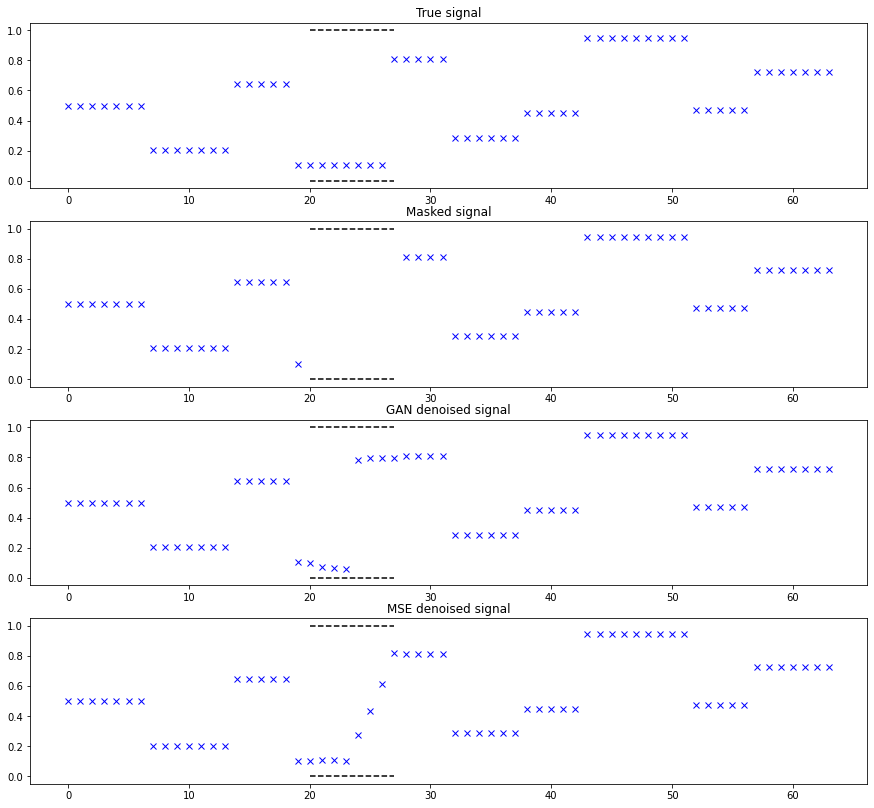

In [54]:
print_one(test_loader,netG,netMSE)

Mask Length: 5	Mask Start: 20


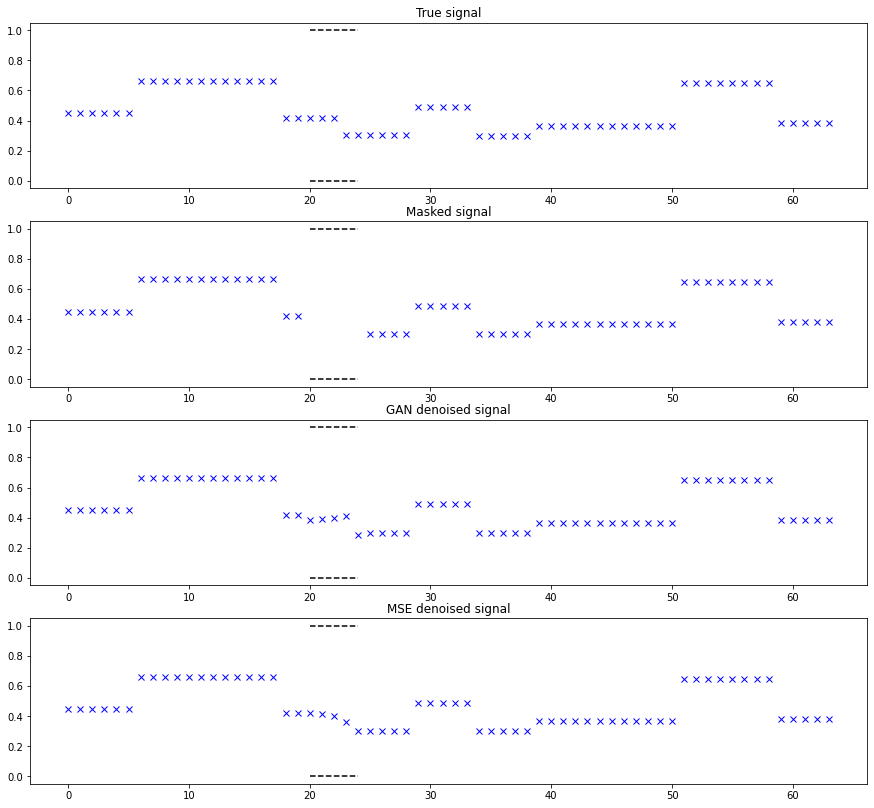

In [55]:
print_one(test_loader,netG,netMSE)

Mask Length: 8	Mask Start: 20


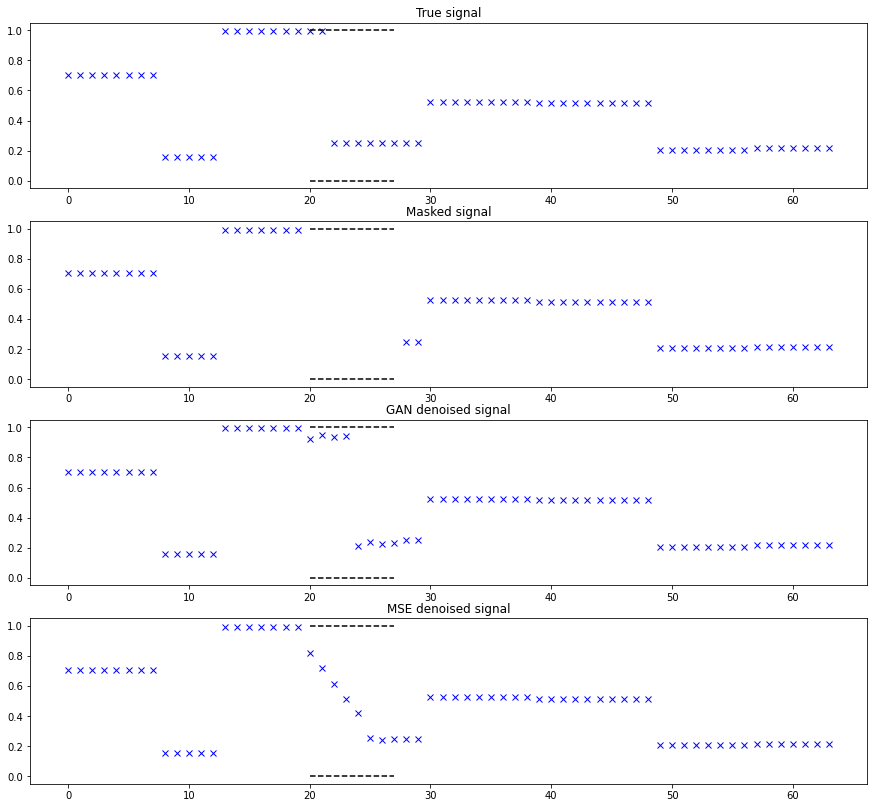

In [56]:
print_one(test_loader,netG,netMSE)

Mask Length: 5	Mask Start: 20


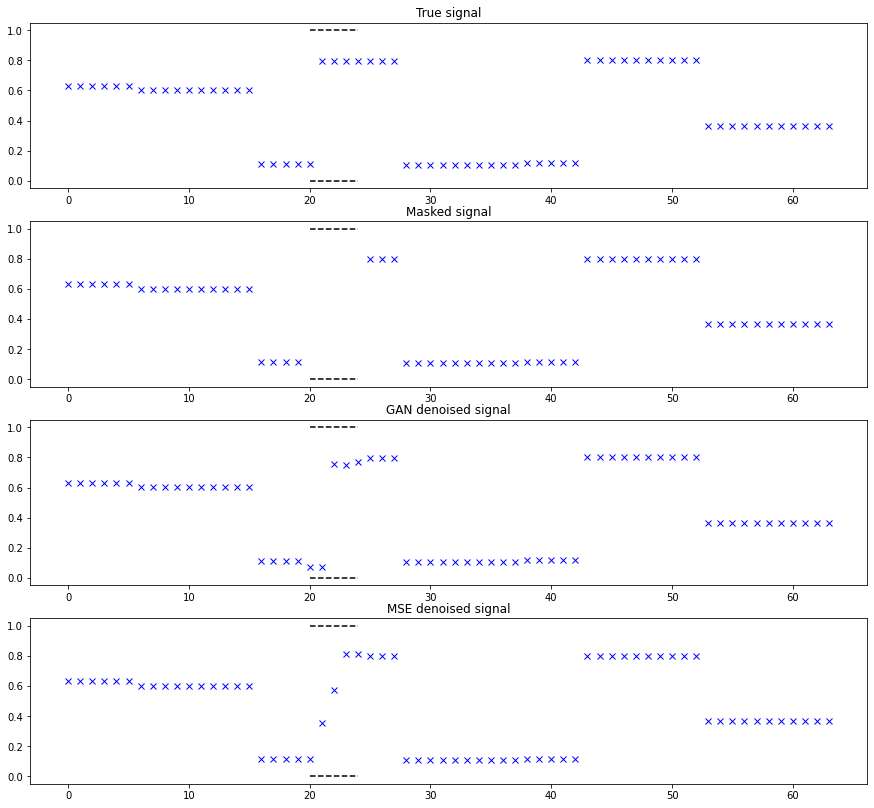

In [57]:
print_one(test_loader,netG,netMSE)

Mask Length: 6	Mask Start: 20


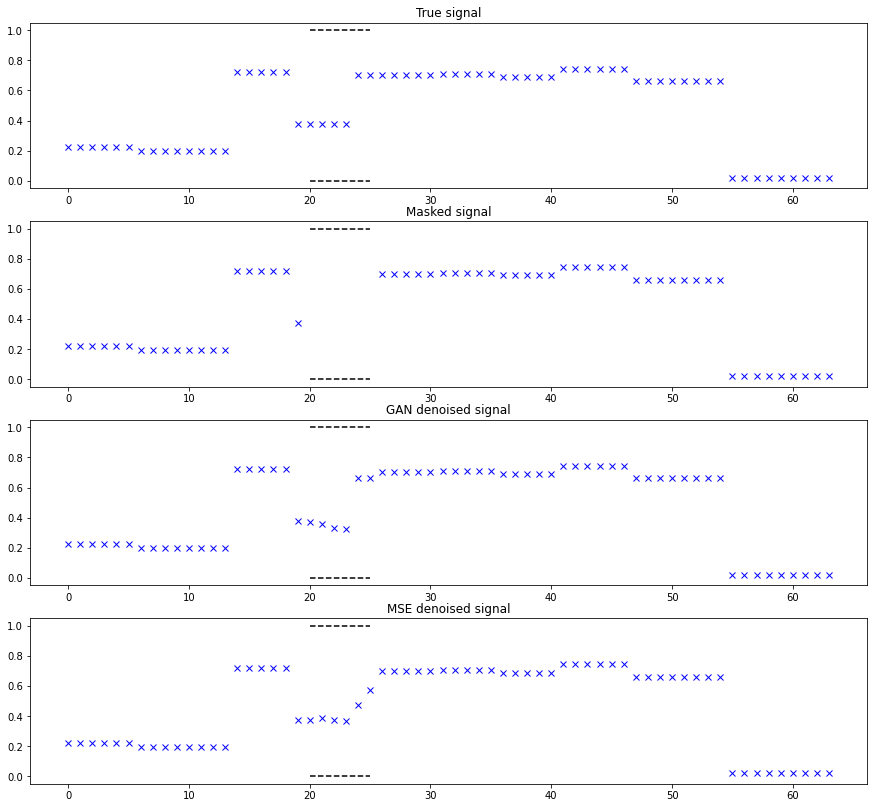

In [58]:
print_one(test_loader,netG,netMSE)

Mask Length: 6	Mask Start: 20


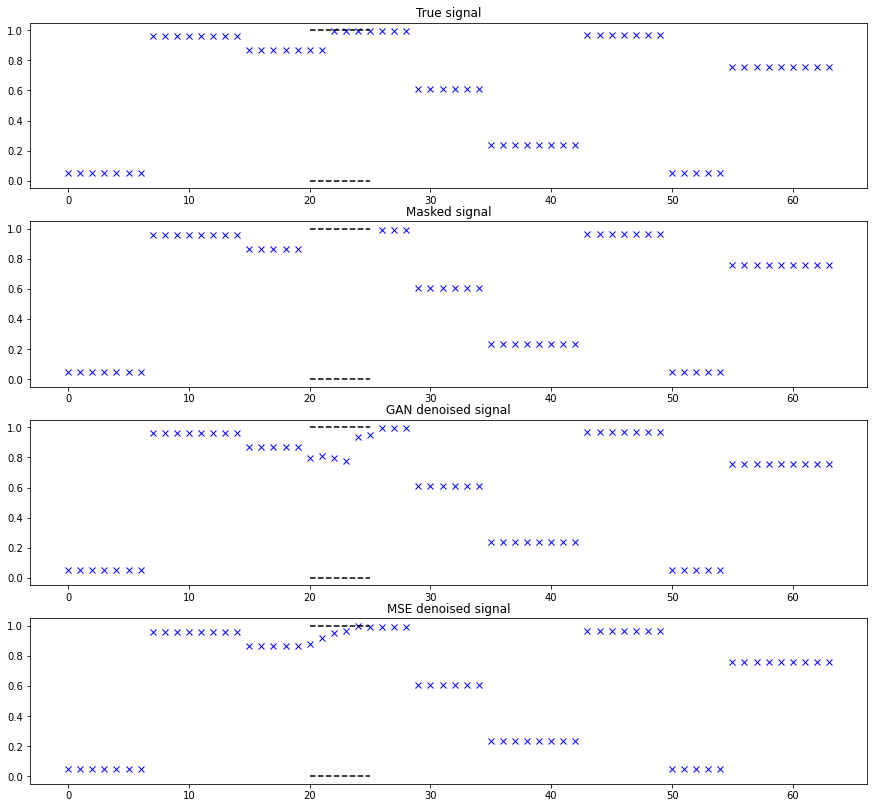

In [59]:
print_one(test_loader,netG,netMSE)

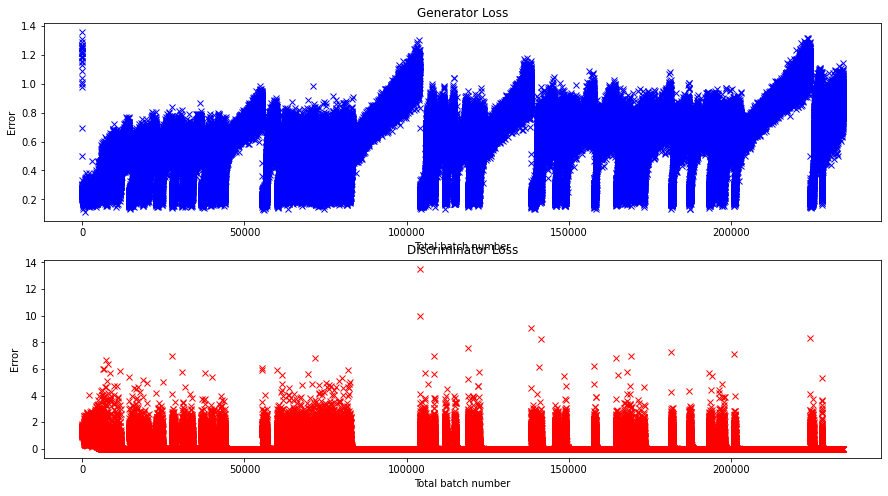

In [10]:
k=0
plt.figure(figsize=[15,8])
plt.subplot(2,1,1)
plt.title("Generator Loss")
plt.ylabel("Error")
plt.xlabel("Total batch number")
plt.plot(G_losses[k:],'bx')

plt.subplot(2,1,2)
plt.title("Discriminator Loss")
plt.ylabel("Error")
plt.xlabel("Total batch number")
plt.plot(D_losses[k:],'rx')

In [ ]:
len(D_losses)

In [9]:
## Saving the model
MODEL_PATHG = "models/trained/GAN_unet_generator_100kdata_300epoch_08_20_20.pth"
MODEL_PATHD = "models/trained/GAN_discriminator_100kdata_300epoch_08_20_20.pth"
torch.save(netG.state_dict(), MODEL_PATHG)
torch.save(netD.state_dict(), MODEL_PATHD)